In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
balanced_categories = False
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
balanced_categories = False
max_training_samples = 200000
enable_orig = "preprocess"
enable_aug = False
enable_aug3 = True
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = False
lstm_hidden_size = 64
epochs = 20
experiment_id = "classification-sentence-embeddings-balanced_categories-False-max_training_samples-200000-enable_orig-preprocess-enable_aug-False-enable_aug3-True-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-False-lstm_hidden_size-64-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    global data
    if enable_orig == "big" or enable_orig == "big-preprocess":
        data += load_gen_dataset("./yelp_dataset/more_yelp_234.json")
    if balanced_categories:
        orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    else:
        orig_data_uniform = data
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess" or enable_orig == "big-preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
if not balanced_categories:
    split_key += "-unbalanced"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

200000


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

200000
200000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs == True and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        if sentence_pairs == "3" and len(sents) > 2:
            sents = [a + b + c for a, b, c in zip(sents, sents[1:], sents[2:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs == True and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        if sentence_pairs == "3" and len(sents) > 2:
            sents = [a + b + c for a, b, c in zip(sents, sents[1:], sents[2:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    if sentence_pairs == "3":
        finetuning_data_key += f"-pairs"
    else:
        finetuning_data_key += f"-pairs-{sentence_pairs}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


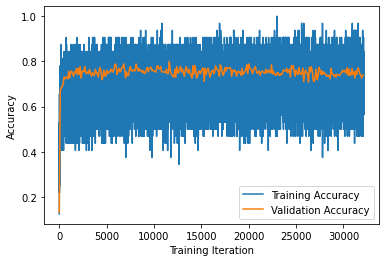

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs == True and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        if sentence_pairs == "3" and len(sents) > 2:
            sents = [a + b + c for a, b, c in zip(sents, sents[1:], sents[2:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.231 Validation Loss: 2.260 Accuracy: 0.102 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.227 Validation Loss: 2.260 Accuracy: 0.102 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.233 Validation Loss: 2.260 Accuracy: 0.099 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.231 Validation Loss: 2.260 Accuracy: 0.104 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.230 Validation Loss: 2.260 Accuracy: 0.106 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.234 Validation Loss: 2.260 Accuracy: 0.105 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.239 Validation Loss: 2.260 Accuracy: 0.100 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.240 Validation Loss: 2.260 Accuracy: 0.101 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.241 Validation Loss: 2.260 Accuracy: 0.099 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.241 Validation Loss: 2.260 Accuracy: 0.099 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.242 Validation Loss: 2.260 Accuracy: 0.098 Validation Accuracy: 0.074:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.242 Validation Loss: 2.260 Accuracy: 0.098 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 11 Loss: 2.244 Validation Loss: 2.260 Accuracy: 0.098 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 12 Loss: 2.242 Validation Loss: 2.260 Accuracy: 0.105 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 13 Loss: 2.242 Validation Loss: 2.260 Accuracy: 0.103 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 14 Loss: 2.243 Validation Loss: 2.260 Accuracy: 0.103 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 15 Loss: 2.242 Validation Loss: 2.260 Accuracy: 0.108 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 16 Loss: 2.241 Validation Loss: 2.260 Accuracy: 0.112 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 17 Loss: 2.241 Validation Loss: 2.260 Accuracy: 0.110 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 18 Loss: 2.240 Validation Loss: 2.260 Accuracy: 0.115 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 19 Loss: 2.241 Validation Loss: 2.260 Accuracy: 0.116 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 20 Loss: 2.241 Validation Loss: 2.260 Accuracy: 0.117 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 21 Loss: 2.241 Validation Loss: 2.260 Accuracy: 0.117 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 22 Loss: 2.241 Validation Loss: 2.260 Accuracy: 0.116 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 23 Loss: 2.241 Validation Loss: 2.260 Accuracy: 0.123 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 24 Loss: 2.241 Validation Loss: 2.260 Accuracy: 0.122 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 25 Loss: 2.240 Validation Loss: 2.260 Accuracy: 0.120 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 26 Loss: 2.239 Validation Loss: 2.260 Accuracy: 0.120 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 27 Loss: 2.238 Validation Loss: 2.260 Accuracy: 0.127 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 28 Loss: 2.237 Validation Loss: 2.260 Accuracy: 0.124 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 29 Loss: 2.235 Validation Loss: 2.260 Accuracy: 0.129 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 30 Loss: 2.235 Validation Loss: 2.260 Accuracy: 0.130 Validation Accuracy: 0.074:   1%|          | 11/1563 [00:00<00:14, 108.79it/s]

Epoch: 0 Iteration: 30 Loss: 2.235 Validation Loss: 2.260 Accuracy: 0.130 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 31 Loss: 2.233 Validation Loss: 2.260 Accuracy: 0.134 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 32 Loss: 2.234 Validation Loss: 2.260 Accuracy: 0.128 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 33 Loss: 2.233 Validation Loss: 2.260 Accuracy: 0.126 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 34 Loss: 2.231 Validation Loss: 2.260 Accuracy: 0.126 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 35 Loss: 2.231 Validation Loss: 2.260 Accuracy: 0.130 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 36 Loss: 2.231 Validation Loss: 2.260 Accuracy: 0.134 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 37 Loss: 2.230 Validation Loss: 2.260 Accuracy: 0.127 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 38 Loss: 2.230 Validation Loss: 2.260 Accuracy: 0.132 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 39 Loss: 2.230 Validation Loss: 2.260 Accuracy: 0.128 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 40 Loss: 2.229 Validation Loss: 2.260 Accuracy: 0.127 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 41 Loss: 2.229 Validation Loss: 2.260 Accuracy: 0.123 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 42 Loss: 2.227 Validation Loss: 2.260 Accuracy: 0.128 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 43 Loss: 2.227 Validation Loss: 2.260 Accuracy: 0.129 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 44 Loss: 2.226 Validation Loss: 2.260 Accuracy: 0.128 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 45 Loss: 2.225 Validation Loss: 2.260 Accuracy: 0.123 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 46 Loss: 2.225 Validation Loss: 2.260 Accuracy: 0.117 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 47 Loss: 2.224 Validation Loss: 2.260 Accuracy: 0.119 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 48 Loss: 2.224 Validation Loss: 2.260 Accuracy: 0.116 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 49 Loss: 2.224 Validation Loss: 2.260 Accuracy: 0.120 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 50 Loss: 2.222 Validation Loss: 2.260 Accuracy: 0.122 Validation Accuracy: 0.074:   2%|▏         | 31/1563 [00:00<00:09, 161.62it/s]

Epoch: 0 Iteration: 50 Loss: 2.222 Validation Loss: 2.260 Accuracy: 0.122 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 51 Loss: 2.221 Validation Loss: 2.260 Accuracy: 0.127 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 52 Loss: 2.221 Validation Loss: 2.260 Accuracy: 0.122 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 53 Loss: 2.221 Validation Loss: 2.260 Accuracy: 0.120 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 54 Loss: 2.221 Validation Loss: 2.260 Accuracy: 0.124 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 55 Loss: 2.220 Validation Loss: 2.260 Accuracy: 0.128 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 56 Loss: 2.219 Validation Loss: 2.260 Accuracy: 0.133 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 57 Loss: 2.218 Validation Loss: 2.260 Accuracy: 0.141 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 58 Loss: 2.218 Validation Loss: 2.260 Accuracy: 0.147 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 59 Loss: 2.216 Validation Loss: 2.260 Accuracy: 0.143 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 60 Loss: 2.215 Validation Loss: 2.260 Accuracy: 0.141 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 61 Loss: 2.217 Validation Loss: 2.260 Accuracy: 0.137 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 62 Loss: 2.217 Validation Loss: 2.260 Accuracy: 0.143 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 63 Loss: 2.218 Validation Loss: 2.260 Accuracy: 0.141 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 64 Loss: 2.217 Validation Loss: 2.260 Accuracy: 0.141 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 65 Loss: 2.216 Validation Loss: 2.260 Accuracy: 0.138 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 66 Loss: 2.214 Validation Loss: 2.260 Accuracy: 0.141 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 67 Loss: 2.212 Validation Loss: 2.260 Accuracy: 0.144 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 68 Loss: 2.212 Validation Loss: 2.260 Accuracy: 0.140 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 69 Loss: 2.213 Validation Loss: 2.260 Accuracy: 0.140 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 70 Loss: 2.211 Validation Loss: 2.260 Accuracy: 0.153 Validation Accuracy: 0.074:   3%|▎         | 51/1563 [00:00<00:08, 176.29it/s]

Epoch: 0 Iteration: 70 Loss: 2.211 Validation Loss: 2.260 Accuracy: 0.153 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 71 Loss: 2.211 Validation Loss: 2.260 Accuracy: 0.155 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 72 Loss: 2.210 Validation Loss: 2.260 Accuracy: 0.154 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 73 Loss: 2.210 Validation Loss: 2.260 Accuracy: 0.153 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 74 Loss: 2.209 Validation Loss: 2.260 Accuracy: 0.159 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 75 Loss: 2.208 Validation Loss: 2.260 Accuracy: 0.158 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 76 Loss: 2.207 Validation Loss: 2.260 Accuracy: 0.155 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 77 Loss: 2.209 Validation Loss: 2.260 Accuracy: 0.141 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 78 Loss: 2.207 Validation Loss: 2.260 Accuracy: 0.144 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 79 Loss: 2.208 Validation Loss: 2.260 Accuracy: 0.145 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 80 Loss: 2.206 Validation Loss: 2.260 Accuracy: 0.145 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 81 Loss: 2.204 Validation Loss: 2.260 Accuracy: 0.145 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 82 Loss: 2.203 Validation Loss: 2.260 Accuracy: 0.151 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 83 Loss: 2.201 Validation Loss: 2.260 Accuracy: 0.163 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 84 Loss: 2.199 Validation Loss: 2.260 Accuracy: 0.157 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 85 Loss: 2.201 Validation Loss: 2.260 Accuracy: 0.153 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 86 Loss: 2.201 Validation Loss: 2.260 Accuracy: 0.157 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 87 Loss: 2.202 Validation Loss: 2.260 Accuracy: 0.156 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 88 Loss: 2.199 Validation Loss: 2.260 Accuracy: 0.157 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 89 Loss: 2.198 Validation Loss: 2.260 Accuracy: 0.159 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 90 Loss: 2.199 Validation Loss: 2.260 Accuracy: 0.152 Validation Accuracy: 0.074:   5%|▍         | 71/1563 [00:00<00:08, 183.13it/s]

Epoch: 0 Iteration: 90 Loss: 2.199 Validation Loss: 2.260 Accuracy: 0.152 Validation Accuracy: 0.074:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 91 Loss: 2.199 Validation Loss: 2.260 Accuracy: 0.154 Validation Accuracy: 0.074:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 92 Loss: 2.199 Validation Loss: 2.260 Accuracy: 0.149 Validation Accuracy: 0.074:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 93 Loss: 2.197 Validation Loss: 2.260 Accuracy: 0.142 Validation Accuracy: 0.074:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 94 Loss: 2.197 Validation Loss: 2.260 Accuracy: 0.151 Validation Accuracy: 0.074:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 95 Loss: 2.196 Validation Loss: 2.260 Accuracy: 0.159 Validation Accuracy: 0.074:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 96 Loss: 2.195 Validation Loss: 2.260 Accuracy: 0.166 Validation Accuracy: 0.074:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 97 Loss: 2.194 Validation Loss: 2.260 Accuracy: 0.171 Validation Accuracy: 0.074:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 98 Loss: 2.192 Validation Loss: 2.260 Accuracy: 0.171 Validation Accuracy: 0.074:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 99 Loss: 2.190 Validation Loss: 2.260 Accuracy: 0.165 Validation Accuracy: 0.074:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 100 Loss: 2.191 Validation Loss: 2.190 Accuracy: 0.164 Validation Accuracy: 0.111:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 101 Loss: 2.188 Validation Loss: 2.190 Accuracy: 0.173 Validation Accuracy: 0.111:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 102 Loss: 2.189 Validation Loss: 2.190 Accuracy: 0.170 Validation Accuracy: 0.111:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 103 Loss: 2.189 Validation Loss: 2.190 Accuracy: 0.173 Validation Accuracy: 0.111:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 104 Loss: 2.188 Validation Loss: 2.190 Accuracy: 0.166 Validation Accuracy: 0.111:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 105 Loss: 2.184 Validation Loss: 2.190 Accuracy: 0.170 Validation Accuracy: 0.111:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 106 Loss: 2.184 Validation Loss: 2.190 Accuracy: 0.164 Validation Accuracy: 0.111:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 107 Loss: 2.183 Validation Loss: 2.190 Accuracy: 0.168 Validation Accuracy: 0.111:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 108 Loss: 2.185 Validation Loss: 2.190 Accuracy: 0.164 Validation Accuracy: 0.111:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 109 Loss: 2.184 Validation Loss: 2.190 Accuracy: 0.170 Validation Accuracy: 0.111:   6%|▌         | 91/1563 [00:00<00:07, 189.09it/s]

Epoch: 0 Iteration: 109 Loss: 2.184 Validation Loss: 2.190 Accuracy: 0.170 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 110 Loss: 2.183 Validation Loss: 2.190 Accuracy: 0.173 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 111 Loss: 2.180 Validation Loss: 2.190 Accuracy: 0.170 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 112 Loss: 2.179 Validation Loss: 2.190 Accuracy: 0.171 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 113 Loss: 2.177 Validation Loss: 2.190 Accuracy: 0.177 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 114 Loss: 2.177 Validation Loss: 2.190 Accuracy: 0.178 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 115 Loss: 2.175 Validation Loss: 2.190 Accuracy: 0.177 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 116 Loss: 2.175 Validation Loss: 2.190 Accuracy: 0.179 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 117 Loss: 2.175 Validation Loss: 2.190 Accuracy: 0.174 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 118 Loss: 2.175 Validation Loss: 2.190 Accuracy: 0.182 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 119 Loss: 2.175 Validation Loss: 2.190 Accuracy: 0.184 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 120 Loss: 2.172 Validation Loss: 2.190 Accuracy: 0.190 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 121 Loss: 2.173 Validation Loss: 2.190 Accuracy: 0.189 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 122 Loss: 2.171 Validation Loss: 2.190 Accuracy: 0.191 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 123 Loss: 2.171 Validation Loss: 2.190 Accuracy: 0.185 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 124 Loss: 2.172 Validation Loss: 2.190 Accuracy: 0.188 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 125 Loss: 2.171 Validation Loss: 2.190 Accuracy: 0.190 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 126 Loss: 2.169 Validation Loss: 2.190 Accuracy: 0.192 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 127 Loss: 2.168 Validation Loss: 2.190 Accuracy: 0.195 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 128 Loss: 2.167 Validation Loss: 2.190 Accuracy: 0.194 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 129 Loss: 2.168 Validation Loss: 2.190 Accuracy: 0.190 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 130 Loss: 2.168 Validation Loss: 2.190 Accuracy: 0.184 Validation Accuracy: 0.111:   7%|▋         | 110/1563 [00:00<00:07, 186.85it/s]

Epoch: 0 Iteration: 130 Loss: 2.168 Validation Loss: 2.190 Accuracy: 0.184 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 131 Loss: 2.167 Validation Loss: 2.190 Accuracy: 0.182 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 132 Loss: 2.165 Validation Loss: 2.190 Accuracy: 0.188 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 133 Loss: 2.164 Validation Loss: 2.190 Accuracy: 0.193 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 134 Loss: 2.162 Validation Loss: 2.190 Accuracy: 0.201 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 135 Loss: 2.163 Validation Loss: 2.190 Accuracy: 0.198 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 136 Loss: 2.163 Validation Loss: 2.190 Accuracy: 0.198 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 137 Loss: 2.161 Validation Loss: 2.190 Accuracy: 0.199 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 138 Loss: 2.162 Validation Loss: 2.190 Accuracy: 0.198 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 139 Loss: 2.161 Validation Loss: 2.190 Accuracy: 0.202 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 140 Loss: 2.163 Validation Loss: 2.190 Accuracy: 0.201 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 141 Loss: 2.162 Validation Loss: 2.190 Accuracy: 0.200 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 142 Loss: 2.163 Validation Loss: 2.190 Accuracy: 0.190 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 143 Loss: 2.162 Validation Loss: 2.190 Accuracy: 0.183 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 144 Loss: 2.161 Validation Loss: 2.190 Accuracy: 0.178 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 145 Loss: 2.163 Validation Loss: 2.190 Accuracy: 0.177 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 146 Loss: 2.163 Validation Loss: 2.190 Accuracy: 0.173 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 147 Loss: 2.162 Validation Loss: 2.190 Accuracy: 0.177 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 148 Loss: 2.160 Validation Loss: 2.190 Accuracy: 0.184 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 149 Loss: 2.158 Validation Loss: 2.190 Accuracy: 0.181 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 150 Loss: 2.156 Validation Loss: 2.190 Accuracy: 0.190 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 151 Loss: 2.155 Validation Loss: 2.190 Accuracy: 0.195 Validation Accuracy: 0.111:   8%|▊         | 131/1563 [00:00<00:07, 192.34it/s]

Epoch: 0 Iteration: 151 Loss: 2.155 Validation Loss: 2.190 Accuracy: 0.195 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 152 Loss: 2.153 Validation Loss: 2.190 Accuracy: 0.213 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 153 Loss: 2.155 Validation Loss: 2.190 Accuracy: 0.216 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 154 Loss: 2.154 Validation Loss: 2.190 Accuracy: 0.218 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 155 Loss: 2.150 Validation Loss: 2.190 Accuracy: 0.227 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 156 Loss: 2.150 Validation Loss: 2.190 Accuracy: 0.230 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 157 Loss: 2.148 Validation Loss: 2.190 Accuracy: 0.230 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 158 Loss: 2.146 Validation Loss: 2.190 Accuracy: 0.223 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 159 Loss: 2.144 Validation Loss: 2.190 Accuracy: 0.230 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 160 Loss: 2.143 Validation Loss: 2.190 Accuracy: 0.221 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 161 Loss: 2.143 Validation Loss: 2.190 Accuracy: 0.220 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 162 Loss: 2.144 Validation Loss: 2.190 Accuracy: 0.205 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 163 Loss: 2.143 Validation Loss: 2.190 Accuracy: 0.210 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 164 Loss: 2.144 Validation Loss: 2.190 Accuracy: 0.205 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 165 Loss: 2.142 Validation Loss: 2.190 Accuracy: 0.198 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 166 Loss: 2.140 Validation Loss: 2.190 Accuracy: 0.198 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 167 Loss: 2.138 Validation Loss: 2.190 Accuracy: 0.200 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 168 Loss: 2.139 Validation Loss: 2.190 Accuracy: 0.202 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 169 Loss: 2.138 Validation Loss: 2.190 Accuracy: 0.202 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 170 Loss: 2.138 Validation Loss: 2.190 Accuracy: 0.207 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 171 Loss: 2.138 Validation Loss: 2.190 Accuracy: 0.201 Validation Accuracy: 0.111:  10%|▉         | 152/1563 [00:00<00:07, 195.52it/s]

Epoch: 0 Iteration: 171 Loss: 2.138 Validation Loss: 2.190 Accuracy: 0.201 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 172 Loss: 2.142 Validation Loss: 2.190 Accuracy: 0.205 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 173 Loss: 2.140 Validation Loss: 2.190 Accuracy: 0.205 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 174 Loss: 2.139 Validation Loss: 2.190 Accuracy: 0.208 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 175 Loss: 2.143 Validation Loss: 2.190 Accuracy: 0.203 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 176 Loss: 2.142 Validation Loss: 2.190 Accuracy: 0.201 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 177 Loss: 2.142 Validation Loss: 2.190 Accuracy: 0.199 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 178 Loss: 2.142 Validation Loss: 2.190 Accuracy: 0.200 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 179 Loss: 2.144 Validation Loss: 2.190 Accuracy: 0.195 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 180 Loss: 2.142 Validation Loss: 2.190 Accuracy: 0.204 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 181 Loss: 2.141 Validation Loss: 2.190 Accuracy: 0.204 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 182 Loss: 2.140 Validation Loss: 2.190 Accuracy: 0.202 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 183 Loss: 2.140 Validation Loss: 2.190 Accuracy: 0.196 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 184 Loss: 2.140 Validation Loss: 2.190 Accuracy: 0.192 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 185 Loss: 2.140 Validation Loss: 2.190 Accuracy: 0.196 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 186 Loss: 2.142 Validation Loss: 2.190 Accuracy: 0.194 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 187 Loss: 2.142 Validation Loss: 2.190 Accuracy: 0.198 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:00<00:07, 195.61it/s]

Epoch: 0 Iteration: 188 Loss: 2.140 Validation Loss: 2.190 Accuracy: 0.202 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:01<00:07, 195.61it/s]

Epoch: 0 Iteration: 189 Loss: 2.139 Validation Loss: 2.190 Accuracy: 0.205 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:01<00:07, 195.61it/s]

Epoch: 0 Iteration: 190 Loss: 2.141 Validation Loss: 2.190 Accuracy: 0.196 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:01<00:07, 195.61it/s]

Epoch: 0 Iteration: 191 Loss: 2.139 Validation Loss: 2.190 Accuracy: 0.203 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:01<00:07, 195.61it/s]

Epoch: 0 Iteration: 192 Loss: 2.139 Validation Loss: 2.190 Accuracy: 0.202 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:01<00:07, 195.61it/s]

Epoch: 0 Iteration: 193 Loss: 2.140 Validation Loss: 2.190 Accuracy: 0.201 Validation Accuracy: 0.111:  11%|█         | 172/1563 [00:01<00:07, 195.61it/s]

Epoch: 0 Iteration: 193 Loss: 2.140 Validation Loss: 2.190 Accuracy: 0.201 Validation Accuracy: 0.111:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 194 Loss: 2.138 Validation Loss: 2.190 Accuracy: 0.210 Validation Accuracy: 0.111:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 195 Loss: 2.134 Validation Loss: 2.190 Accuracy: 0.218 Validation Accuracy: 0.111:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 196 Loss: 2.134 Validation Loss: 2.190 Accuracy: 0.222 Validation Accuracy: 0.111:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 197 Loss: 2.132 Validation Loss: 2.190 Accuracy: 0.223 Validation Accuracy: 0.111:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 198 Loss: 2.132 Validation Loss: 2.190 Accuracy: 0.216 Validation Accuracy: 0.111:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 199 Loss: 2.130 Validation Loss: 2.190 Accuracy: 0.215 Validation Accuracy: 0.111:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 200 Loss: 2.134 Validation Loss: 2.121 Accuracy: 0.209 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 201 Loss: 2.133 Validation Loss: 2.121 Accuracy: 0.205 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 202 Loss: 2.127 Validation Loss: 2.121 Accuracy: 0.216 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 203 Loss: 2.125 Validation Loss: 2.121 Accuracy: 0.222 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 204 Loss: 2.123 Validation Loss: 2.121 Accuracy: 0.220 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 205 Loss: 2.120 Validation Loss: 2.121 Accuracy: 0.215 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 206 Loss: 2.118 Validation Loss: 2.121 Accuracy: 0.216 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 207 Loss: 2.118 Validation Loss: 2.121 Accuracy: 0.212 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 208 Loss: 2.119 Validation Loss: 2.121 Accuracy: 0.216 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 209 Loss: 2.121 Validation Loss: 2.121 Accuracy: 0.212 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 210 Loss: 2.119 Validation Loss: 2.121 Accuracy: 0.224 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 211 Loss: 2.120 Validation Loss: 2.121 Accuracy: 0.224 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 212 Loss: 2.118 Validation Loss: 2.121 Accuracy: 0.222 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 213 Loss: 2.114 Validation Loss: 2.121 Accuracy: 0.228 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 214 Loss: 2.117 Validation Loss: 2.121 Accuracy: 0.222 Validation Accuracy: 0.143:  12%|█▏        | 194/1563 [00:01<00:06, 200.16it/s]

Epoch: 0 Iteration: 214 Loss: 2.117 Validation Loss: 2.121 Accuracy: 0.222 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 215 Loss: 2.119 Validation Loss: 2.121 Accuracy: 0.222 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 216 Loss: 2.120 Validation Loss: 2.121 Accuracy: 0.220 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 217 Loss: 2.118 Validation Loss: 2.121 Accuracy: 0.223 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 218 Loss: 2.118 Validation Loss: 2.121 Accuracy: 0.220 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 219 Loss: 2.117 Validation Loss: 2.121 Accuracy: 0.226 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 220 Loss: 2.114 Validation Loss: 2.121 Accuracy: 0.227 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 221 Loss: 2.113 Validation Loss: 2.121 Accuracy: 0.232 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 222 Loss: 2.116 Validation Loss: 2.121 Accuracy: 0.231 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 223 Loss: 2.118 Validation Loss: 2.121 Accuracy: 0.218 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 224 Loss: 2.117 Validation Loss: 2.121 Accuracy: 0.223 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 225 Loss: 2.117 Validation Loss: 2.121 Accuracy: 0.228 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 226 Loss: 2.116 Validation Loss: 2.121 Accuracy: 0.229 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 227 Loss: 2.118 Validation Loss: 2.121 Accuracy: 0.226 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 228 Loss: 2.118 Validation Loss: 2.121 Accuracy: 0.225 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 229 Loss: 2.114 Validation Loss: 2.121 Accuracy: 0.226 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 230 Loss: 2.113 Validation Loss: 2.121 Accuracy: 0.225 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 231 Loss: 2.111 Validation Loss: 2.121 Accuracy: 0.227 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 232 Loss: 2.111 Validation Loss: 2.121 Accuracy: 0.227 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 233 Loss: 2.110 Validation Loss: 2.121 Accuracy: 0.236 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 234 Loss: 2.109 Validation Loss: 2.121 Accuracy: 0.237 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 235 Loss: 2.107 Validation Loss: 2.121 Accuracy: 0.233 Validation Accuracy: 0.143:  14%|█▍        | 215/1563 [00:01<00:06, 199.33it/s]

Epoch: 0 Iteration: 235 Loss: 2.107 Validation Loss: 2.121 Accuracy: 0.233 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 236 Loss: 2.106 Validation Loss: 2.121 Accuracy: 0.232 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 237 Loss: 2.108 Validation Loss: 2.121 Accuracy: 0.234 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 238 Loss: 2.104 Validation Loss: 2.121 Accuracy: 0.241 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 239 Loss: 2.106 Validation Loss: 2.121 Accuracy: 0.236 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 240 Loss: 2.105 Validation Loss: 2.121 Accuracy: 0.234 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 241 Loss: 2.104 Validation Loss: 2.121 Accuracy: 0.230 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 242 Loss: 2.104 Validation Loss: 2.121 Accuracy: 0.227 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 243 Loss: 2.102 Validation Loss: 2.121 Accuracy: 0.227 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 244 Loss: 2.098 Validation Loss: 2.121 Accuracy: 0.237 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 245 Loss: 2.095 Validation Loss: 2.121 Accuracy: 0.242 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 246 Loss: 2.093 Validation Loss: 2.121 Accuracy: 0.247 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 247 Loss: 2.089 Validation Loss: 2.121 Accuracy: 0.255 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 248 Loss: 2.090 Validation Loss: 2.121 Accuracy: 0.245 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 249 Loss: 2.088 Validation Loss: 2.121 Accuracy: 0.258 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 250 Loss: 2.089 Validation Loss: 2.121 Accuracy: 0.258 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 251 Loss: 2.088 Validation Loss: 2.121 Accuracy: 0.258 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 252 Loss: 2.088 Validation Loss: 2.121 Accuracy: 0.261 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 253 Loss: 2.088 Validation Loss: 2.121 Accuracy: 0.261 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 254 Loss: 2.089 Validation Loss: 2.121 Accuracy: 0.252 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 255 Loss: 2.086 Validation Loss: 2.121 Accuracy: 0.254 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 256 Loss: 2.088 Validation Loss: 2.121 Accuracy: 0.244 Validation Accuracy: 0.143:  15%|█▌        | 236/1563 [00:01<00:06, 202.19it/s]

Epoch: 0 Iteration: 256 Loss: 2.088 Validation Loss: 2.121 Accuracy: 0.244 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 257 Loss: 2.086 Validation Loss: 2.121 Accuracy: 0.243 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 258 Loss: 2.087 Validation Loss: 2.121 Accuracy: 0.256 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 259 Loss: 2.084 Validation Loss: 2.121 Accuracy: 0.250 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 260 Loss: 2.083 Validation Loss: 2.121 Accuracy: 0.254 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 261 Loss: 2.083 Validation Loss: 2.121 Accuracy: 0.257 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 262 Loss: 2.082 Validation Loss: 2.121 Accuracy: 0.263 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 263 Loss: 2.079 Validation Loss: 2.121 Accuracy: 0.265 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 264 Loss: 2.083 Validation Loss: 2.121 Accuracy: 0.269 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 265 Loss: 2.085 Validation Loss: 2.121 Accuracy: 0.262 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 266 Loss: 2.085 Validation Loss: 2.121 Accuracy: 0.280 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 267 Loss: 2.084 Validation Loss: 2.121 Accuracy: 0.279 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 268 Loss: 2.080 Validation Loss: 2.121 Accuracy: 0.279 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 269 Loss: 2.081 Validation Loss: 2.121 Accuracy: 0.280 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 270 Loss: 2.077 Validation Loss: 2.121 Accuracy: 0.282 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 271 Loss: 2.077 Validation Loss: 2.121 Accuracy: 0.280 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 272 Loss: 2.075 Validation Loss: 2.121 Accuracy: 0.284 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 273 Loss: 2.074 Validation Loss: 2.121 Accuracy: 0.279 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 274 Loss: 2.071 Validation Loss: 2.121 Accuracy: 0.277 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 275 Loss: 2.072 Validation Loss: 2.121 Accuracy: 0.277 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 276 Loss: 2.069 Validation Loss: 2.121 Accuracy: 0.267 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 277 Loss: 2.069 Validation Loss: 2.121 Accuracy: 0.263 Validation Accuracy: 0.143:  16%|█▋        | 257/1563 [00:01<00:06, 202.46it/s]

Epoch: 0 Iteration: 277 Loss: 2.069 Validation Loss: 2.121 Accuracy: 0.263 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 278 Loss: 2.068 Validation Loss: 2.121 Accuracy: 0.258 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 279 Loss: 2.069 Validation Loss: 2.121 Accuracy: 0.256 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 280 Loss: 2.069 Validation Loss: 2.121 Accuracy: 0.256 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 281 Loss: 2.068 Validation Loss: 2.121 Accuracy: 0.259 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 282 Loss: 2.067 Validation Loss: 2.121 Accuracy: 0.255 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 283 Loss: 2.067 Validation Loss: 2.121 Accuracy: 0.255 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 284 Loss: 2.066 Validation Loss: 2.121 Accuracy: 0.256 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 285 Loss: 2.068 Validation Loss: 2.121 Accuracy: 0.252 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 286 Loss: 2.067 Validation Loss: 2.121 Accuracy: 0.261 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 287 Loss: 2.067 Validation Loss: 2.121 Accuracy: 0.264 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 288 Loss: 2.067 Validation Loss: 2.121 Accuracy: 0.266 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 289 Loss: 2.067 Validation Loss: 2.121 Accuracy: 0.265 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 290 Loss: 2.065 Validation Loss: 2.121 Accuracy: 0.268 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 291 Loss: 2.068 Validation Loss: 2.121 Accuracy: 0.260 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 292 Loss: 2.068 Validation Loss: 2.121 Accuracy: 0.262 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 293 Loss: 2.068 Validation Loss: 2.121 Accuracy: 0.267 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 294 Loss: 2.067 Validation Loss: 2.121 Accuracy: 0.263 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 295 Loss: 2.067 Validation Loss: 2.121 Accuracy: 0.273 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 296 Loss: 2.066 Validation Loss: 2.121 Accuracy: 0.265 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 297 Loss: 2.066 Validation Loss: 2.121 Accuracy: 0.263 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 298 Loss: 2.066 Validation Loss: 2.121 Accuracy: 0.263 Validation Accuracy: 0.143:  18%|█▊        | 278/1563 [00:01<00:06, 203.20it/s]

Epoch: 0 Iteration: 298 Loss: 2.066 Validation Loss: 2.121 Accuracy: 0.263 Validation Accuracy: 0.143:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 299 Loss: 2.064 Validation Loss: 2.121 Accuracy: 0.265 Validation Accuracy: 0.143:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 300 Loss: 2.063 Validation Loss: 2.052 Accuracy: 0.255 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 301 Loss: 2.061 Validation Loss: 2.052 Accuracy: 0.263 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 302 Loss: 2.056 Validation Loss: 2.052 Accuracy: 0.275 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 303 Loss: 2.057 Validation Loss: 2.052 Accuracy: 0.270 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 304 Loss: 2.057 Validation Loss: 2.052 Accuracy: 0.270 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 305 Loss: 2.055 Validation Loss: 2.052 Accuracy: 0.270 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 306 Loss: 2.057 Validation Loss: 2.052 Accuracy: 0.272 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 307 Loss: 2.056 Validation Loss: 2.052 Accuracy: 0.278 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 308 Loss: 2.056 Validation Loss: 2.052 Accuracy: 0.276 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 309 Loss: 2.056 Validation Loss: 2.052 Accuracy: 0.275 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 310 Loss: 2.056 Validation Loss: 2.052 Accuracy: 0.283 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 311 Loss: 2.054 Validation Loss: 2.052 Accuracy: 0.281 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 312 Loss: 2.053 Validation Loss: 2.052 Accuracy: 0.270 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 313 Loss: 2.055 Validation Loss: 2.052 Accuracy: 0.268 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 314 Loss: 2.053 Validation Loss: 2.052 Accuracy: 0.277 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 315 Loss: 2.055 Validation Loss: 2.052 Accuracy: 0.266 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 316 Loss: 2.052 Validation Loss: 2.052 Accuracy: 0.267 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 317 Loss: 2.050 Validation Loss: 2.052 Accuracy: 0.265 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 318 Loss: 2.045 Validation Loss: 2.052 Accuracy: 0.274 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 319 Loss: 2.042 Validation Loss: 2.052 Accuracy: 0.281 Validation Accuracy: 0.174:  19%|█▉        | 299/1563 [00:01<00:06, 204.58it/s]

Epoch: 0 Iteration: 319 Loss: 2.042 Validation Loss: 2.052 Accuracy: 0.281 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 320 Loss: 2.039 Validation Loss: 2.052 Accuracy: 0.283 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 321 Loss: 2.039 Validation Loss: 2.052 Accuracy: 0.281 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 322 Loss: 2.044 Validation Loss: 2.052 Accuracy: 0.281 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 323 Loss: 2.041 Validation Loss: 2.052 Accuracy: 0.286 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 324 Loss: 2.036 Validation Loss: 2.052 Accuracy: 0.282 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 325 Loss: 2.032 Validation Loss: 2.052 Accuracy: 0.298 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 326 Loss: 2.029 Validation Loss: 2.052 Accuracy: 0.295 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 327 Loss: 2.030 Validation Loss: 2.052 Accuracy: 0.293 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 328 Loss: 2.029 Validation Loss: 2.052 Accuracy: 0.286 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 329 Loss: 2.024 Validation Loss: 2.052 Accuracy: 0.284 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 330 Loss: 2.026 Validation Loss: 2.052 Accuracy: 0.284 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 331 Loss: 2.023 Validation Loss: 2.052 Accuracy: 0.288 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 332 Loss: 2.020 Validation Loss: 2.052 Accuracy: 0.291 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 333 Loss: 2.018 Validation Loss: 2.052 Accuracy: 0.295 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 334 Loss: 2.020 Validation Loss: 2.052 Accuracy: 0.287 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 335 Loss: 2.015 Validation Loss: 2.052 Accuracy: 0.287 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 336 Loss: 2.016 Validation Loss: 2.052 Accuracy: 0.294 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 337 Loss: 2.016 Validation Loss: 2.052 Accuracy: 0.298 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 338 Loss: 2.018 Validation Loss: 2.052 Accuracy: 0.306 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 339 Loss: 2.022 Validation Loss: 2.052 Accuracy: 0.302 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 340 Loss: 2.024 Validation Loss: 2.052 Accuracy: 0.298 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 341 Loss: 2.023 Validation Loss: 2.052 Accuracy: 0.302 Validation Accuracy: 0.174:  20%|██        | 320/1563 [00:01<00:06, 202.72it/s]

Epoch: 0 Iteration: 341 Loss: 2.023 Validation Loss: 2.052 Accuracy: 0.302 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 342 Loss: 2.023 Validation Loss: 2.052 Accuracy: 0.302 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 343 Loss: 2.024 Validation Loss: 2.052 Accuracy: 0.308 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 344 Loss: 2.024 Validation Loss: 2.052 Accuracy: 0.314 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 345 Loss: 2.027 Validation Loss: 2.052 Accuracy: 0.310 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 346 Loss: 2.025 Validation Loss: 2.052 Accuracy: 0.312 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 347 Loss: 2.026 Validation Loss: 2.052 Accuracy: 0.305 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 348 Loss: 2.026 Validation Loss: 2.052 Accuracy: 0.300 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 349 Loss: 2.030 Validation Loss: 2.052 Accuracy: 0.302 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 350 Loss: 2.030 Validation Loss: 2.052 Accuracy: 0.304 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 351 Loss: 2.030 Validation Loss: 2.052 Accuracy: 0.300 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 352 Loss: 2.029 Validation Loss: 2.052 Accuracy: 0.305 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 353 Loss: 2.029 Validation Loss: 2.052 Accuracy: 0.303 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 354 Loss: 2.027 Validation Loss: 2.052 Accuracy: 0.307 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 355 Loss: 2.029 Validation Loss: 2.052 Accuracy: 0.307 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 356 Loss: 2.030 Validation Loss: 2.052 Accuracy: 0.302 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 357 Loss: 2.026 Validation Loss: 2.052 Accuracy: 0.312 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 358 Loss: 2.028 Validation Loss: 2.052 Accuracy: 0.312 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 359 Loss: 2.026 Validation Loss: 2.052 Accuracy: 0.314 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 360 Loss: 2.027 Validation Loss: 2.052 Accuracy: 0.315 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 361 Loss: 2.028 Validation Loss: 2.052 Accuracy: 0.313 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 362 Loss: 2.024 Validation Loss: 2.052 Accuracy: 0.309 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 363 Loss: 2.021 Validation Loss: 2.052 Accuracy: 0.313 Validation Accuracy: 0.174:  22%|██▏       | 342/1563 [00:01<00:05, 205.00it/s]

Epoch: 0 Iteration: 363 Loss: 2.021 Validation Loss: 2.052 Accuracy: 0.313 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 364 Loss: 2.023 Validation Loss: 2.052 Accuracy: 0.309 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 365 Loss: 2.024 Validation Loss: 2.052 Accuracy: 0.308 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 366 Loss: 2.025 Validation Loss: 2.052 Accuracy: 0.306 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 367 Loss: 2.025 Validation Loss: 2.052 Accuracy: 0.297 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 368 Loss: 2.024 Validation Loss: 2.052 Accuracy: 0.298 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 369 Loss: 2.021 Validation Loss: 2.052 Accuracy: 0.297 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 370 Loss: 2.018 Validation Loss: 2.052 Accuracy: 0.297 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 371 Loss: 2.016 Validation Loss: 2.052 Accuracy: 0.303 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 372 Loss: 2.018 Validation Loss: 2.052 Accuracy: 0.300 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 373 Loss: 2.019 Validation Loss: 2.052 Accuracy: 0.291 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 374 Loss: 2.020 Validation Loss: 2.052 Accuracy: 0.293 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 375 Loss: 2.018 Validation Loss: 2.052 Accuracy: 0.295 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 376 Loss: 2.016 Validation Loss: 2.052 Accuracy: 0.298 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 377 Loss: 2.017 Validation Loss: 2.052 Accuracy: 0.302 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 378 Loss: 2.015 Validation Loss: 2.052 Accuracy: 0.295 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 379 Loss: 2.010 Validation Loss: 2.052 Accuracy: 0.300 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 380 Loss: 2.009 Validation Loss: 2.052 Accuracy: 0.297 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 381 Loss: 2.009 Validation Loss: 2.052 Accuracy: 0.292 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 382 Loss: 2.013 Validation Loss: 2.052 Accuracy: 0.291 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 383 Loss: 2.018 Validation Loss: 2.052 Accuracy: 0.289 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 384 Loss: 2.015 Validation Loss: 2.052 Accuracy: 0.291 Validation Accuracy: 0.174:  23%|██▎       | 364/1563 [00:01<00:05, 206.65it/s]

Epoch: 0 Iteration: 384 Loss: 2.015 Validation Loss: 2.052 Accuracy: 0.291 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:01<00:05, 207.36it/s]

Epoch: 0 Iteration: 385 Loss: 2.014 Validation Loss: 2.052 Accuracy: 0.284 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:01<00:05, 207.36it/s]

Epoch: 0 Iteration: 386 Loss: 2.015 Validation Loss: 2.052 Accuracy: 0.282 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:01<00:05, 207.36it/s]

Epoch: 0 Iteration: 387 Loss: 2.010 Validation Loss: 2.052 Accuracy: 0.291 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:01<00:05, 207.36it/s]

Epoch: 0 Iteration: 388 Loss: 2.010 Validation Loss: 2.052 Accuracy: 0.298 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:01<00:05, 207.36it/s]

Epoch: 0 Iteration: 389 Loss: 2.004 Validation Loss: 2.052 Accuracy: 0.307 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:01<00:05, 207.36it/s]

Epoch: 0 Iteration: 390 Loss: 2.005 Validation Loss: 2.052 Accuracy: 0.311 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:01<00:05, 207.36it/s]

Epoch: 0 Iteration: 391 Loss: 2.003 Validation Loss: 2.052 Accuracy: 0.320 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:01<00:05, 207.36it/s]

Epoch: 0 Iteration: 392 Loss: 2.003 Validation Loss: 2.052 Accuracy: 0.316 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:01<00:05, 207.36it/s]

Epoch: 0 Iteration: 393 Loss: 2.001 Validation Loss: 2.052 Accuracy: 0.319 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:01<00:05, 207.36it/s]

Epoch: 0 Iteration: 394 Loss: 1.997 Validation Loss: 2.052 Accuracy: 0.324 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 395 Loss: 1.997 Validation Loss: 2.052 Accuracy: 0.332 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 396 Loss: 1.994 Validation Loss: 2.052 Accuracy: 0.338 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 397 Loss: 1.994 Validation Loss: 2.052 Accuracy: 0.326 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 398 Loss: 1.994 Validation Loss: 2.052 Accuracy: 0.327 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 399 Loss: 1.996 Validation Loss: 2.052 Accuracy: 0.313 Validation Accuracy: 0.174:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 400 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.321 Validation Accuracy: 0.209:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 401 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.315 Validation Accuracy: 0.209:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 402 Loss: 1.989 Validation Loss: 1.984 Accuracy: 0.320 Validation Accuracy: 0.209:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 403 Loss: 1.984 Validation Loss: 1.984 Accuracy: 0.324 Validation Accuracy: 0.209:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 404 Loss: 1.985 Validation Loss: 1.984 Accuracy: 0.318 Validation Accuracy: 0.209:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 405 Loss: 1.985 Validation Loss: 1.984 Accuracy: 0.315 Validation Accuracy: 0.209:  25%|██▍       | 385/1563 [00:02<00:05, 207.36it/s]

Epoch: 0 Iteration: 405 Loss: 1.985 Validation Loss: 1.984 Accuracy: 0.315 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 406 Loss: 1.983 Validation Loss: 1.984 Accuracy: 0.309 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 407 Loss: 1.985 Validation Loss: 1.984 Accuracy: 0.314 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 408 Loss: 1.985 Validation Loss: 1.984 Accuracy: 0.312 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 409 Loss: 1.990 Validation Loss: 1.984 Accuracy: 0.313 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 410 Loss: 1.989 Validation Loss: 1.984 Accuracy: 0.309 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 411 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.298 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 412 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.295 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 413 Loss: 1.992 Validation Loss: 1.984 Accuracy: 0.298 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 414 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.296 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 415 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.296 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 416 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.300 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 417 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.300 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 418 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.298 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 419 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.303 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 420 Loss: 1.994 Validation Loss: 1.984 Accuracy: 0.301 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 421 Loss: 1.988 Validation Loss: 1.984 Accuracy: 0.316 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 422 Loss: 1.990 Validation Loss: 1.984 Accuracy: 0.322 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 423 Loss: 1.992 Validation Loss: 1.984 Accuracy: 0.324 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 424 Loss: 1.989 Validation Loss: 1.984 Accuracy: 0.330 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 425 Loss: 1.987 Validation Loss: 1.984 Accuracy: 0.335 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 426 Loss: 1.986 Validation Loss: 1.984 Accuracy: 0.338 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 427 Loss: 1.987 Validation Loss: 1.984 Accuracy: 0.338 Validation Accuracy: 0.209:  26%|██▌       | 406/1563 [00:02<00:05, 204.48it/s]

Epoch: 0 Iteration: 427 Loss: 1.987 Validation Loss: 1.984 Accuracy: 0.338 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 428 Loss: 1.985 Validation Loss: 1.984 Accuracy: 0.344 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 429 Loss: 1.987 Validation Loss: 1.984 Accuracy: 0.336 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 430 Loss: 1.989 Validation Loss: 1.984 Accuracy: 0.331 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 431 Loss: 1.988 Validation Loss: 1.984 Accuracy: 0.327 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 432 Loss: 1.989 Validation Loss: 1.984 Accuracy: 0.316 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 433 Loss: 1.988 Validation Loss: 1.984 Accuracy: 0.314 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 434 Loss: 1.988 Validation Loss: 1.984 Accuracy: 0.318 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 435 Loss: 1.987 Validation Loss: 1.984 Accuracy: 0.323 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 436 Loss: 1.989 Validation Loss: 1.984 Accuracy: 0.323 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 437 Loss: 1.992 Validation Loss: 1.984 Accuracy: 0.323 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 438 Loss: 1.991 Validation Loss: 1.984 Accuracy: 0.320 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 439 Loss: 1.992 Validation Loss: 1.984 Accuracy: 0.323 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 440 Loss: 1.991 Validation Loss: 1.984 Accuracy: 0.330 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 441 Loss: 1.993 Validation Loss: 1.984 Accuracy: 0.333 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 442 Loss: 1.991 Validation Loss: 1.984 Accuracy: 0.350 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 443 Loss: 1.988 Validation Loss: 1.984 Accuracy: 0.349 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 444 Loss: 1.987 Validation Loss: 1.984 Accuracy: 0.348 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 445 Loss: 1.984 Validation Loss: 1.984 Accuracy: 0.349 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 446 Loss: 1.983 Validation Loss: 1.984 Accuracy: 0.343 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 447 Loss: 1.980 Validation Loss: 1.984 Accuracy: 0.348 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 448 Loss: 1.980 Validation Loss: 1.984 Accuracy: 0.350 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 449 Loss: 1.979 Validation Loss: 1.984 Accuracy: 0.352 Validation Accuracy: 0.209:  27%|██▋       | 428/1563 [00:02<00:05, 206.38it/s]

Epoch: 0 Iteration: 449 Loss: 1.979 Validation Loss: 1.984 Accuracy: 0.352 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 450 Loss: 1.973 Validation Loss: 1.984 Accuracy: 0.357 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 451 Loss: 1.970 Validation Loss: 1.984 Accuracy: 0.356 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 452 Loss: 1.966 Validation Loss: 1.984 Accuracy: 0.356 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 453 Loss: 1.962 Validation Loss: 1.984 Accuracy: 0.359 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 454 Loss: 1.955 Validation Loss: 1.984 Accuracy: 0.365 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 455 Loss: 1.954 Validation Loss: 1.984 Accuracy: 0.361 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 456 Loss: 1.956 Validation Loss: 1.984 Accuracy: 0.356 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 457 Loss: 1.952 Validation Loss: 1.984 Accuracy: 0.361 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 458 Loss: 1.952 Validation Loss: 1.984 Accuracy: 0.366 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 459 Loss: 1.948 Validation Loss: 1.984 Accuracy: 0.377 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 460 Loss: 1.948 Validation Loss: 1.984 Accuracy: 0.370 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 461 Loss: 1.945 Validation Loss: 1.984 Accuracy: 0.378 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 462 Loss: 1.949 Validation Loss: 1.984 Accuracy: 0.367 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 463 Loss: 1.950 Validation Loss: 1.984 Accuracy: 0.361 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 464 Loss: 1.949 Validation Loss: 1.984 Accuracy: 0.353 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 465 Loss: 1.950 Validation Loss: 1.984 Accuracy: 0.353 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 466 Loss: 1.952 Validation Loss: 1.984 Accuracy: 0.358 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 467 Loss: 1.955 Validation Loss: 1.984 Accuracy: 0.359 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 468 Loss: 1.952 Validation Loss: 1.984 Accuracy: 0.355 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 469 Loss: 1.946 Validation Loss: 1.984 Accuracy: 0.352 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 470 Loss: 1.952 Validation Loss: 1.984 Accuracy: 0.352 Validation Accuracy: 0.209:  29%|██▉       | 450/1563 [00:02<00:05, 207.39it/s]

Epoch: 0 Iteration: 470 Loss: 1.952 Validation Loss: 1.984 Accuracy: 0.352 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 471 Loss: 1.955 Validation Loss: 1.984 Accuracy: 0.341 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 472 Loss: 1.955 Validation Loss: 1.984 Accuracy: 0.354 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 473 Loss: 1.962 Validation Loss: 1.984 Accuracy: 0.355 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 474 Loss: 1.968 Validation Loss: 1.984 Accuracy: 0.361 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 475 Loss: 1.968 Validation Loss: 1.984 Accuracy: 0.359 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 476 Loss: 1.963 Validation Loss: 1.984 Accuracy: 0.364 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 477 Loss: 1.965 Validation Loss: 1.984 Accuracy: 0.362 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 478 Loss: 1.964 Validation Loss: 1.984 Accuracy: 0.363 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 479 Loss: 1.961 Validation Loss: 1.984 Accuracy: 0.366 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 480 Loss: 1.960 Validation Loss: 1.984 Accuracy: 0.373 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 481 Loss: 1.959 Validation Loss: 1.984 Accuracy: 0.384 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 482 Loss: 1.954 Validation Loss: 1.984 Accuracy: 0.379 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 483 Loss: 1.954 Validation Loss: 1.984 Accuracy: 0.388 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 484 Loss: 1.956 Validation Loss: 1.984 Accuracy: 0.375 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 485 Loss: 1.959 Validation Loss: 1.984 Accuracy: 0.377 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 486 Loss: 1.954 Validation Loss: 1.984 Accuracy: 0.382 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 487 Loss: 1.947 Validation Loss: 1.984 Accuracy: 0.382 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 488 Loss: 1.948 Validation Loss: 1.984 Accuracy: 0.389 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 489 Loss: 1.950 Validation Loss: 1.984 Accuracy: 0.389 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 490 Loss: 1.945 Validation Loss: 1.984 Accuracy: 0.393 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 491 Loss: 1.942 Validation Loss: 1.984 Accuracy: 0.388 Validation Accuracy: 0.209:  30%|███       | 471/1563 [00:02<00:05, 207.35it/s]

Epoch: 0 Iteration: 491 Loss: 1.942 Validation Loss: 1.984 Accuracy: 0.388 Validation Accuracy: 0.209:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 492 Loss: 1.944 Validation Loss: 1.984 Accuracy: 0.381 Validation Accuracy: 0.209:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 493 Loss: 1.937 Validation Loss: 1.984 Accuracy: 0.381 Validation Accuracy: 0.209:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 494 Loss: 1.936 Validation Loss: 1.984 Accuracy: 0.393 Validation Accuracy: 0.209:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 495 Loss: 1.935 Validation Loss: 1.984 Accuracy: 0.392 Validation Accuracy: 0.209:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 496 Loss: 1.939 Validation Loss: 1.984 Accuracy: 0.384 Validation Accuracy: 0.209:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 497 Loss: 1.937 Validation Loss: 1.984 Accuracy: 0.382 Validation Accuracy: 0.209:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 498 Loss: 1.933 Validation Loss: 1.984 Accuracy: 0.387 Validation Accuracy: 0.209:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 499 Loss: 1.932 Validation Loss: 1.984 Accuracy: 0.389 Validation Accuracy: 0.209:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 500 Loss: 1.932 Validation Loss: 1.919 Accuracy: 0.379 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 501 Loss: 1.932 Validation Loss: 1.919 Accuracy: 0.384 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 502 Loss: 1.930 Validation Loss: 1.919 Accuracy: 0.398 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 503 Loss: 1.929 Validation Loss: 1.919 Accuracy: 0.394 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 504 Loss: 1.925 Validation Loss: 1.919 Accuracy: 0.391 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 505 Loss: 1.923 Validation Loss: 1.919 Accuracy: 0.395 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 506 Loss: 1.922 Validation Loss: 1.919 Accuracy: 0.404 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 507 Loss: 1.926 Validation Loss: 1.919 Accuracy: 0.401 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 508 Loss: 1.926 Validation Loss: 1.919 Accuracy: 0.388 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 509 Loss: 1.925 Validation Loss: 1.919 Accuracy: 0.384 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 510 Loss: 1.923 Validation Loss: 1.919 Accuracy: 0.390 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 511 Loss: 1.923 Validation Loss: 1.919 Accuracy: 0.381 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 512 Loss: 1.917 Validation Loss: 1.919 Accuracy: 0.385 Validation Accuracy: 0.244:  31%|███▏      | 492/1563 [00:02<00:05, 207.95it/s]

Epoch: 0 Iteration: 512 Loss: 1.917 Validation Loss: 1.919 Accuracy: 0.385 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 513 Loss: 1.919 Validation Loss: 1.919 Accuracy: 0.383 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 514 Loss: 1.918 Validation Loss: 1.919 Accuracy: 0.384 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 515 Loss: 1.915 Validation Loss: 1.919 Accuracy: 0.386 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 516 Loss: 1.912 Validation Loss: 1.919 Accuracy: 0.381 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 517 Loss: 1.909 Validation Loss: 1.919 Accuracy: 0.385 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 518 Loss: 1.913 Validation Loss: 1.919 Accuracy: 0.379 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 519 Loss: 1.920 Validation Loss: 1.919 Accuracy: 0.367 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 520 Loss: 1.917 Validation Loss: 1.919 Accuracy: 0.370 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 521 Loss: 1.920 Validation Loss: 1.919 Accuracy: 0.373 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 522 Loss: 1.916 Validation Loss: 1.919 Accuracy: 0.377 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 523 Loss: 1.915 Validation Loss: 1.919 Accuracy: 0.375 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 524 Loss: 1.916 Validation Loss: 1.919 Accuracy: 0.376 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 525 Loss: 1.913 Validation Loss: 1.919 Accuracy: 0.374 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 526 Loss: 1.912 Validation Loss: 1.919 Accuracy: 0.379 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 527 Loss: 1.910 Validation Loss: 1.919 Accuracy: 0.381 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 528 Loss: 1.909 Validation Loss: 1.919 Accuracy: 0.388 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 529 Loss: 1.912 Validation Loss: 1.919 Accuracy: 0.398 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 530 Loss: 1.913 Validation Loss: 1.919 Accuracy: 0.392 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 531 Loss: 1.911 Validation Loss: 1.919 Accuracy: 0.395 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 532 Loss: 1.913 Validation Loss: 1.919 Accuracy: 0.380 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 533 Loss: 1.911 Validation Loss: 1.919 Accuracy: 0.386 Validation Accuracy: 0.244:  33%|███▎      | 513/1563 [00:02<00:05, 205.37it/s]

Epoch: 0 Iteration: 533 Loss: 1.911 Validation Loss: 1.919 Accuracy: 0.386 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 534 Loss: 1.908 Validation Loss: 1.919 Accuracy: 0.389 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 535 Loss: 1.911 Validation Loss: 1.919 Accuracy: 0.392 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 536 Loss: 1.907 Validation Loss: 1.919 Accuracy: 0.390 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 537 Loss: 1.909 Validation Loss: 1.919 Accuracy: 0.383 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 538 Loss: 1.902 Validation Loss: 1.919 Accuracy: 0.395 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 539 Loss: 1.897 Validation Loss: 1.919 Accuracy: 0.397 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 540 Loss: 1.901 Validation Loss: 1.919 Accuracy: 0.393 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 541 Loss: 1.902 Validation Loss: 1.919 Accuracy: 0.393 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 542 Loss: 1.910 Validation Loss: 1.919 Accuracy: 0.391 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 543 Loss: 1.910 Validation Loss: 1.919 Accuracy: 0.389 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 544 Loss: 1.909 Validation Loss: 1.919 Accuracy: 0.395 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 545 Loss: 1.909 Validation Loss: 1.919 Accuracy: 0.391 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 546 Loss: 1.909 Validation Loss: 1.919 Accuracy: 0.398 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 547 Loss: 1.908 Validation Loss: 1.919 Accuracy: 0.408 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 548 Loss: 1.910 Validation Loss: 1.919 Accuracy: 0.402 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 549 Loss: 1.908 Validation Loss: 1.919 Accuracy: 0.405 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 550 Loss: 1.904 Validation Loss: 1.919 Accuracy: 0.413 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 551 Loss: 1.900 Validation Loss: 1.919 Accuracy: 0.422 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 552 Loss: 1.901 Validation Loss: 1.919 Accuracy: 0.427 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 553 Loss: 1.899 Validation Loss: 1.919 Accuracy: 0.434 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 554 Loss: 1.899 Validation Loss: 1.919 Accuracy: 0.429 Validation Accuracy: 0.244:  34%|███▍      | 534/1563 [00:02<00:04, 206.09it/s]

Epoch: 0 Iteration: 554 Loss: 1.899 Validation Loss: 1.919 Accuracy: 0.429 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 555 Loss: 1.896 Validation Loss: 1.919 Accuracy: 0.434 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 556 Loss: 1.897 Validation Loss: 1.919 Accuracy: 0.428 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 557 Loss: 1.892 Validation Loss: 1.919 Accuracy: 0.430 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 558 Loss: 1.896 Validation Loss: 1.919 Accuracy: 0.427 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 559 Loss: 1.897 Validation Loss: 1.919 Accuracy: 0.426 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 560 Loss: 1.890 Validation Loss: 1.919 Accuracy: 0.430 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 561 Loss: 1.889 Validation Loss: 1.919 Accuracy: 0.424 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 562 Loss: 1.884 Validation Loss: 1.919 Accuracy: 0.432 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 563 Loss: 1.881 Validation Loss: 1.919 Accuracy: 0.427 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 564 Loss: 1.879 Validation Loss: 1.919 Accuracy: 0.429 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 565 Loss: 1.875 Validation Loss: 1.919 Accuracy: 0.434 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 566 Loss: 1.876 Validation Loss: 1.919 Accuracy: 0.430 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 567 Loss: 1.878 Validation Loss: 1.919 Accuracy: 0.427 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 568 Loss: 1.876 Validation Loss: 1.919 Accuracy: 0.424 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 569 Loss: 1.876 Validation Loss: 1.919 Accuracy: 0.425 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 570 Loss: 1.881 Validation Loss: 1.919 Accuracy: 0.427 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 571 Loss: 1.883 Validation Loss: 1.919 Accuracy: 0.426 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 572 Loss: 1.879 Validation Loss: 1.919 Accuracy: 0.430 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 573 Loss: 1.875 Validation Loss: 1.919 Accuracy: 0.437 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 574 Loss: 1.879 Validation Loss: 1.919 Accuracy: 0.429 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 575 Loss: 1.883 Validation Loss: 1.919 Accuracy: 0.418 Validation Accuracy: 0.244:  36%|███▌      | 555/1563 [00:02<00:04, 205.06it/s]

Epoch: 0 Iteration: 575 Loss: 1.883 Validation Loss: 1.919 Accuracy: 0.418 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 576 Loss: 1.879 Validation Loss: 1.919 Accuracy: 0.422 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 577 Loss: 1.881 Validation Loss: 1.919 Accuracy: 0.424 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 578 Loss: 1.885 Validation Loss: 1.919 Accuracy: 0.425 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 579 Loss: 1.883 Validation Loss: 1.919 Accuracy: 0.427 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 580 Loss: 1.885 Validation Loss: 1.919 Accuracy: 0.423 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 581 Loss: 1.886 Validation Loss: 1.919 Accuracy: 0.422 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 582 Loss: 1.884 Validation Loss: 1.919 Accuracy: 0.418 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 583 Loss: 1.883 Validation Loss: 1.919 Accuracy: 0.418 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 584 Loss: 1.885 Validation Loss: 1.919 Accuracy: 0.422 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 585 Loss: 1.890 Validation Loss: 1.919 Accuracy: 0.424 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 586 Loss: 1.887 Validation Loss: 1.919 Accuracy: 0.432 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 587 Loss: 1.881 Validation Loss: 1.919 Accuracy: 0.434 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 588 Loss: 1.878 Validation Loss: 1.919 Accuracy: 0.444 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 589 Loss: 1.875 Validation Loss: 1.919 Accuracy: 0.440 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 590 Loss: 1.872 Validation Loss: 1.919 Accuracy: 0.435 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 591 Loss: 1.873 Validation Loss: 1.919 Accuracy: 0.430 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 592 Loss: 1.873 Validation Loss: 1.919 Accuracy: 0.427 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 593 Loss: 1.877 Validation Loss: 1.919 Accuracy: 0.424 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 594 Loss: 1.868 Validation Loss: 1.919 Accuracy: 0.437 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 595 Loss: 1.860 Validation Loss: 1.919 Accuracy: 0.441 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 596 Loss: 1.866 Validation Loss: 1.919 Accuracy: 0.429 Validation Accuracy: 0.244:  37%|███▋      | 576/1563 [00:02<00:04, 205.29it/s]

Epoch: 0 Iteration: 596 Loss: 1.866 Validation Loss: 1.919 Accuracy: 0.429 Validation Accuracy: 0.244:  38%|███▊      | 597/1563 [00:02<00:04, 205.96it/s]

Epoch: 0 Iteration: 597 Loss: 1.865 Validation Loss: 1.919 Accuracy: 0.427 Validation Accuracy: 0.244:  38%|███▊      | 597/1563 [00:02<00:04, 205.96it/s]

Epoch: 0 Iteration: 598 Loss: 1.858 Validation Loss: 1.919 Accuracy: 0.428 Validation Accuracy: 0.244:  38%|███▊      | 597/1563 [00:02<00:04, 205.96it/s]

Epoch: 0 Iteration: 599 Loss: 1.859 Validation Loss: 1.919 Accuracy: 0.433 Validation Accuracy: 0.244:  38%|███▊      | 597/1563 [00:02<00:04, 205.96it/s]

Epoch: 0 Iteration: 600 Loss: 1.858 Validation Loss: 1.853 Accuracy: 0.441 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 601 Loss: 1.855 Validation Loss: 1.853 Accuracy: 0.453 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 602 Loss: 1.856 Validation Loss: 1.853 Accuracy: 0.455 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 603 Loss: 1.855 Validation Loss: 1.853 Accuracy: 0.458 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 604 Loss: 1.850 Validation Loss: 1.853 Accuracy: 0.448 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 605 Loss: 1.850 Validation Loss: 1.853 Accuracy: 0.445 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 606 Loss: 1.852 Validation Loss: 1.853 Accuracy: 0.450 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 607 Loss: 1.856 Validation Loss: 1.853 Accuracy: 0.444 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 608 Loss: 1.856 Validation Loss: 1.853 Accuracy: 0.433 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 609 Loss: 1.857 Validation Loss: 1.853 Accuracy: 0.436 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 610 Loss: 1.855 Validation Loss: 1.853 Accuracy: 0.440 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 611 Loss: 1.857 Validation Loss: 1.853 Accuracy: 0.427 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 612 Loss: 1.856 Validation Loss: 1.853 Accuracy: 0.430 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 613 Loss: 1.854 Validation Loss: 1.853 Accuracy: 0.427 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 614 Loss: 1.857 Validation Loss: 1.853 Accuracy: 0.427 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 615 Loss: 1.857 Validation Loss: 1.853 Accuracy: 0.433 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 616 Loss: 1.854 Validation Loss: 1.853 Accuracy: 0.434 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 617 Loss: 1.858 Validation Loss: 1.853 Accuracy: 0.435 Validation Accuracy: 0.277:  38%|███▊      | 597/1563 [00:03<00:04, 205.96it/s]

Epoch: 0 Iteration: 617 Loss: 1.858 Validation Loss: 1.853 Accuracy: 0.435 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 618 Loss: 1.861 Validation Loss: 1.853 Accuracy: 0.443 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 619 Loss: 1.860 Validation Loss: 1.853 Accuracy: 0.438 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 620 Loss: 1.860 Validation Loss: 1.853 Accuracy: 0.423 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 621 Loss: 1.858 Validation Loss: 1.853 Accuracy: 0.431 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 622 Loss: 1.853 Validation Loss: 1.853 Accuracy: 0.431 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 623 Loss: 1.856 Validation Loss: 1.853 Accuracy: 0.429 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 624 Loss: 1.858 Validation Loss: 1.853 Accuracy: 0.433 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 625 Loss: 1.856 Validation Loss: 1.853 Accuracy: 0.427 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 626 Loss: 1.854 Validation Loss: 1.853 Accuracy: 0.427 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 627 Loss: 1.852 Validation Loss: 1.853 Accuracy: 0.434 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 628 Loss: 1.851 Validation Loss: 1.853 Accuracy: 0.434 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 629 Loss: 1.852 Validation Loss: 1.853 Accuracy: 0.430 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 630 Loss: 1.851 Validation Loss: 1.853 Accuracy: 0.437 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 631 Loss: 1.846 Validation Loss: 1.853 Accuracy: 0.441 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 632 Loss: 1.850 Validation Loss: 1.853 Accuracy: 0.433 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 633 Loss: 1.851 Validation Loss: 1.853 Accuracy: 0.433 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 634 Loss: 1.852 Validation Loss: 1.853 Accuracy: 0.427 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 635 Loss: 1.854 Validation Loss: 1.853 Accuracy: 0.427 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 636 Loss: 1.852 Validation Loss: 1.853 Accuracy: 0.431 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 637 Loss: 1.845 Validation Loss: 1.853 Accuracy: 0.436 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 638 Loss: 1.841 Validation Loss: 1.853 Accuracy: 0.431 Validation Accuracy: 0.277:  40%|███▉      | 618/1563 [00:03<00:04, 202.52it/s]

Epoch: 0 Iteration: 638 Loss: 1.841 Validation Loss: 1.853 Accuracy: 0.431 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 639 Loss: 1.839 Validation Loss: 1.853 Accuracy: 0.434 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 640 Loss: 1.835 Validation Loss: 1.853 Accuracy: 0.437 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 641 Loss: 1.833 Validation Loss: 1.853 Accuracy: 0.438 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 642 Loss: 1.833 Validation Loss: 1.853 Accuracy: 0.449 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 643 Loss: 1.835 Validation Loss: 1.853 Accuracy: 0.448 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 644 Loss: 1.839 Validation Loss: 1.853 Accuracy: 0.442 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 645 Loss: 1.839 Validation Loss: 1.853 Accuracy: 0.444 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 646 Loss: 1.840 Validation Loss: 1.853 Accuracy: 0.435 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 647 Loss: 1.837 Validation Loss: 1.853 Accuracy: 0.434 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 648 Loss: 1.838 Validation Loss: 1.853 Accuracy: 0.445 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 649 Loss: 1.835 Validation Loss: 1.853 Accuracy: 0.450 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 650 Loss: 1.837 Validation Loss: 1.853 Accuracy: 0.452 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 651 Loss: 1.835 Validation Loss: 1.853 Accuracy: 0.458 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 652 Loss: 1.832 Validation Loss: 1.853 Accuracy: 0.459 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 653 Loss: 1.830 Validation Loss: 1.853 Accuracy: 0.464 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 654 Loss: 1.825 Validation Loss: 1.853 Accuracy: 0.487 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 655 Loss: 1.822 Validation Loss: 1.853 Accuracy: 0.495 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 656 Loss: 1.821 Validation Loss: 1.853 Accuracy: 0.505 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 657 Loss: 1.821 Validation Loss: 1.853 Accuracy: 0.502 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 658 Loss: 1.822 Validation Loss: 1.853 Accuracy: 0.496 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 659 Loss: 1.821 Validation Loss: 1.853 Accuracy: 0.500 Validation Accuracy: 0.277:  41%|████      | 639/1563 [00:03<00:04, 203.93it/s]

Epoch: 0 Iteration: 659 Loss: 1.821 Validation Loss: 1.853 Accuracy: 0.500 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 660 Loss: 1.819 Validation Loss: 1.853 Accuracy: 0.502 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 661 Loss: 1.821 Validation Loss: 1.853 Accuracy: 0.495 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 662 Loss: 1.823 Validation Loss: 1.853 Accuracy: 0.493 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 663 Loss: 1.819 Validation Loss: 1.853 Accuracy: 0.491 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 664 Loss: 1.813 Validation Loss: 1.853 Accuracy: 0.477 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 665 Loss: 1.811 Validation Loss: 1.853 Accuracy: 0.475 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 666 Loss: 1.808 Validation Loss: 1.853 Accuracy: 0.475 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 667 Loss: 1.805 Validation Loss: 1.853 Accuracy: 0.483 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 668 Loss: 1.803 Validation Loss: 1.853 Accuracy: 0.487 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 669 Loss: 1.801 Validation Loss: 1.853 Accuracy: 0.484 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 670 Loss: 1.802 Validation Loss: 1.853 Accuracy: 0.480 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 671 Loss: 1.800 Validation Loss: 1.853 Accuracy: 0.483 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 672 Loss: 1.799 Validation Loss: 1.853 Accuracy: 0.485 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 673 Loss: 1.797 Validation Loss: 1.853 Accuracy: 0.495 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 674 Loss: 1.801 Validation Loss: 1.853 Accuracy: 0.502 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 675 Loss: 1.803 Validation Loss: 1.853 Accuracy: 0.502 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 676 Loss: 1.805 Validation Loss: 1.853 Accuracy: 0.502 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 677 Loss: 1.810 Validation Loss: 1.853 Accuracy: 0.494 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 678 Loss: 1.810 Validation Loss: 1.853 Accuracy: 0.493 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 679 Loss: 1.812 Validation Loss: 1.853 Accuracy: 0.486 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 680 Loss: 1.813 Validation Loss: 1.853 Accuracy: 0.486 Validation Accuracy: 0.277:  42%|████▏     | 660/1563 [00:03<00:04, 204.63it/s]

Epoch: 0 Iteration: 680 Loss: 1.813 Validation Loss: 1.853 Accuracy: 0.486 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 681 Loss: 1.814 Validation Loss: 1.853 Accuracy: 0.484 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 682 Loss: 1.820 Validation Loss: 1.853 Accuracy: 0.477 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 683 Loss: 1.819 Validation Loss: 1.853 Accuracy: 0.478 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 684 Loss: 1.820 Validation Loss: 1.853 Accuracy: 0.475 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 685 Loss: 1.822 Validation Loss: 1.853 Accuracy: 0.480 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 686 Loss: 1.826 Validation Loss: 1.853 Accuracy: 0.470 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 687 Loss: 1.834 Validation Loss: 1.853 Accuracy: 0.473 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 688 Loss: 1.837 Validation Loss: 1.853 Accuracy: 0.472 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 689 Loss: 1.836 Validation Loss: 1.853 Accuracy: 0.480 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 690 Loss: 1.834 Validation Loss: 1.853 Accuracy: 0.483 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 691 Loss: 1.840 Validation Loss: 1.853 Accuracy: 0.479 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 692 Loss: 1.837 Validation Loss: 1.853 Accuracy: 0.481 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 693 Loss: 1.839 Validation Loss: 1.853 Accuracy: 0.479 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 694 Loss: 1.836 Validation Loss: 1.853 Accuracy: 0.485 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 695 Loss: 1.833 Validation Loss: 1.853 Accuracy: 0.480 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 696 Loss: 1.834 Validation Loss: 1.853 Accuracy: 0.481 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 697 Loss: 1.826 Validation Loss: 1.853 Accuracy: 0.486 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 698 Loss: 1.824 Validation Loss: 1.853 Accuracy: 0.487 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 699 Loss: 1.824 Validation Loss: 1.853 Accuracy: 0.481 Validation Accuracy: 0.277:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 700 Loss: 1.827 Validation Loss: 1.783 Accuracy: 0.480 Validation Accuracy: 0.312:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 701 Loss: 1.825 Validation Loss: 1.783 Accuracy: 0.484 Validation Accuracy: 0.312:  44%|████▎     | 681/1563 [00:03<00:04, 205.23it/s]

Epoch: 0 Iteration: 701 Loss: 1.825 Validation Loss: 1.783 Accuracy: 0.484 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 702 Loss: 1.818 Validation Loss: 1.783 Accuracy: 0.494 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 703 Loss: 1.820 Validation Loss: 1.783 Accuracy: 0.490 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 704 Loss: 1.818 Validation Loss: 1.783 Accuracy: 0.492 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 705 Loss: 1.816 Validation Loss: 1.783 Accuracy: 0.488 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 706 Loss: 1.811 Validation Loss: 1.783 Accuracy: 0.494 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 707 Loss: 1.803 Validation Loss: 1.783 Accuracy: 0.502 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 708 Loss: 1.798 Validation Loss: 1.783 Accuracy: 0.504 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 709 Loss: 1.796 Validation Loss: 1.783 Accuracy: 0.512 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 710 Loss: 1.795 Validation Loss: 1.783 Accuracy: 0.511 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 711 Loss: 1.788 Validation Loss: 1.783 Accuracy: 0.516 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 712 Loss: 1.790 Validation Loss: 1.783 Accuracy: 0.516 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 713 Loss: 1.791 Validation Loss: 1.783 Accuracy: 0.520 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 714 Loss: 1.794 Validation Loss: 1.783 Accuracy: 0.513 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 715 Loss: 1.795 Validation Loss: 1.783 Accuracy: 0.522 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 716 Loss: 1.793 Validation Loss: 1.783 Accuracy: 0.521 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 717 Loss: 1.795 Validation Loss: 1.783 Accuracy: 0.507 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 718 Loss: 1.795 Validation Loss: 1.783 Accuracy: 0.503 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 719 Loss: 1.795 Validation Loss: 1.783 Accuracy: 0.495 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 720 Loss: 1.794 Validation Loss: 1.783 Accuracy: 0.493 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 721 Loss: 1.797 Validation Loss: 1.783 Accuracy: 0.484 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 722 Loss: 1.795 Validation Loss: 1.783 Accuracy: 0.476 Validation Accuracy: 0.312:  45%|████▍     | 702/1563 [00:03<00:04, 201.56it/s]

Epoch: 0 Iteration: 722 Loss: 1.795 Validation Loss: 1.783 Accuracy: 0.476 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 723 Loss: 1.795 Validation Loss: 1.783 Accuracy: 0.473 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 724 Loss: 1.796 Validation Loss: 1.783 Accuracy: 0.473 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 725 Loss: 1.793 Validation Loss: 1.783 Accuracy: 0.473 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 726 Loss: 1.794 Validation Loss: 1.783 Accuracy: 0.473 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 727 Loss: 1.797 Validation Loss: 1.783 Accuracy: 0.475 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 728 Loss: 1.798 Validation Loss: 1.783 Accuracy: 0.478 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 729 Loss: 1.802 Validation Loss: 1.783 Accuracy: 0.478 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 730 Loss: 1.800 Validation Loss: 1.783 Accuracy: 0.482 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 731 Loss: 1.801 Validation Loss: 1.783 Accuracy: 0.488 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 732 Loss: 1.798 Validation Loss: 1.783 Accuracy: 0.493 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 733 Loss: 1.794 Validation Loss: 1.783 Accuracy: 0.496 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 734 Loss: 1.794 Validation Loss: 1.783 Accuracy: 0.498 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 735 Loss: 1.792 Validation Loss: 1.783 Accuracy: 0.497 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 736 Loss: 1.789 Validation Loss: 1.783 Accuracy: 0.501 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 737 Loss: 1.790 Validation Loss: 1.783 Accuracy: 0.502 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 738 Loss: 1.789 Validation Loss: 1.783 Accuracy: 0.498 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 739 Loss: 1.787 Validation Loss: 1.783 Accuracy: 0.511 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 740 Loss: 1.781 Validation Loss: 1.783 Accuracy: 0.514 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 741 Loss: 1.772 Validation Loss: 1.783 Accuracy: 0.524 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 742 Loss: 1.773 Validation Loss: 1.783 Accuracy: 0.525 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 743 Loss: 1.768 Validation Loss: 1.783 Accuracy: 0.528 Validation Accuracy: 0.312:  46%|████▋     | 723/1563 [00:03<00:04, 203.47it/s]

Epoch: 0 Iteration: 743 Loss: 1.768 Validation Loss: 1.783 Accuracy: 0.528 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 744 Loss: 1.769 Validation Loss: 1.783 Accuracy: 0.518 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 745 Loss: 1.770 Validation Loss: 1.783 Accuracy: 0.512 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 746 Loss: 1.767 Validation Loss: 1.783 Accuracy: 0.512 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 747 Loss: 1.766 Validation Loss: 1.783 Accuracy: 0.517 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 748 Loss: 1.768 Validation Loss: 1.783 Accuracy: 0.517 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 749 Loss: 1.763 Validation Loss: 1.783 Accuracy: 0.516 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 750 Loss: 1.763 Validation Loss: 1.783 Accuracy: 0.520 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 751 Loss: 1.759 Validation Loss: 1.783 Accuracy: 0.518 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 752 Loss: 1.759 Validation Loss: 1.783 Accuracy: 0.513 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 753 Loss: 1.763 Validation Loss: 1.783 Accuracy: 0.505 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 754 Loss: 1.763 Validation Loss: 1.783 Accuracy: 0.512 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 755 Loss: 1.766 Validation Loss: 1.783 Accuracy: 0.512 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 756 Loss: 1.769 Validation Loss: 1.783 Accuracy: 0.504 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 757 Loss: 1.769 Validation Loss: 1.783 Accuracy: 0.501 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 758 Loss: 1.767 Validation Loss: 1.783 Accuracy: 0.504 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 759 Loss: 1.766 Validation Loss: 1.783 Accuracy: 0.502 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 760 Loss: 1.764 Validation Loss: 1.783 Accuracy: 0.506 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 761 Loss: 1.772 Validation Loss: 1.783 Accuracy: 0.499 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 762 Loss: 1.775 Validation Loss: 1.783 Accuracy: 0.495 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 763 Loss: 1.774 Validation Loss: 1.783 Accuracy: 0.509 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 764 Loss: 1.770 Validation Loss: 1.783 Accuracy: 0.518 Validation Accuracy: 0.312:  48%|████▊     | 744/1563 [00:03<00:04, 204.49it/s]

Epoch: 0 Iteration: 764 Loss: 1.770 Validation Loss: 1.783 Accuracy: 0.518 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 765 Loss: 1.763 Validation Loss: 1.783 Accuracy: 0.535 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 766 Loss: 1.757 Validation Loss: 1.783 Accuracy: 0.552 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 767 Loss: 1.757 Validation Loss: 1.783 Accuracy: 0.554 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 768 Loss: 1.754 Validation Loss: 1.783 Accuracy: 0.563 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 769 Loss: 1.756 Validation Loss: 1.783 Accuracy: 0.562 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 770 Loss: 1.750 Validation Loss: 1.783 Accuracy: 0.561 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 771 Loss: 1.753 Validation Loss: 1.783 Accuracy: 0.569 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 772 Loss: 1.752 Validation Loss: 1.783 Accuracy: 0.579 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 773 Loss: 1.745 Validation Loss: 1.783 Accuracy: 0.577 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 774 Loss: 1.744 Validation Loss: 1.783 Accuracy: 0.570 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 775 Loss: 1.742 Validation Loss: 1.783 Accuracy: 0.561 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 776 Loss: 1.737 Validation Loss: 1.783 Accuracy: 0.551 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 777 Loss: 1.735 Validation Loss: 1.783 Accuracy: 0.552 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 778 Loss: 1.737 Validation Loss: 1.783 Accuracy: 0.546 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 779 Loss: 1.733 Validation Loss: 1.783 Accuracy: 0.554 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 780 Loss: 1.736 Validation Loss: 1.783 Accuracy: 0.556 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 781 Loss: 1.732 Validation Loss: 1.783 Accuracy: 0.554 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 782 Loss: 1.732 Validation Loss: 1.783 Accuracy: 0.558 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 783 Loss: 1.731 Validation Loss: 1.783 Accuracy: 0.563 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 784 Loss: 1.733 Validation Loss: 1.783 Accuracy: 0.573 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 785 Loss: 1.737 Validation Loss: 1.783 Accuracy: 0.577 Validation Accuracy: 0.312:  49%|████▉     | 765/1563 [00:03<00:03, 205.57it/s]

Epoch: 0 Iteration: 785 Loss: 1.737 Validation Loss: 1.783 Accuracy: 0.577 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 786 Loss: 1.740 Validation Loss: 1.783 Accuracy: 0.591 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 787 Loss: 1.740 Validation Loss: 1.783 Accuracy: 0.591 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 788 Loss: 1.737 Validation Loss: 1.783 Accuracy: 0.597 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 789 Loss: 1.734 Validation Loss: 1.783 Accuracy: 0.598 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 790 Loss: 1.741 Validation Loss: 1.783 Accuracy: 0.595 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 791 Loss: 1.742 Validation Loss: 1.783 Accuracy: 0.598 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 792 Loss: 1.746 Validation Loss: 1.783 Accuracy: 0.598 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 793 Loss: 1.745 Validation Loss: 1.783 Accuracy: 0.595 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 794 Loss: 1.741 Validation Loss: 1.783 Accuracy: 0.592 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 795 Loss: 1.741 Validation Loss: 1.783 Accuracy: 0.591 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 796 Loss: 1.743 Validation Loss: 1.783 Accuracy: 0.579 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 797 Loss: 1.741 Validation Loss: 1.783 Accuracy: 0.577 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 798 Loss: 1.744 Validation Loss: 1.783 Accuracy: 0.573 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 799 Loss: 1.743 Validation Loss: 1.783 Accuracy: 0.573 Validation Accuracy: 0.312:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 800 Loss: 1.743 Validation Loss: 1.708 Accuracy: 0.571 Validation Accuracy: 0.347:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 801 Loss: 1.740 Validation Loss: 1.708 Accuracy: 0.567 Validation Accuracy: 0.347:  50%|█████     | 786/1563 [00:03<00:03, 205.72it/s]

Epoch: 0 Iteration: 802 Loss: 1.732 Validation Loss: 1.708 Accuracy: 0.568 Validation Accuracy: 0.347:  50%|█████     | 786/1563 [00:04<00:03, 205.72it/s]

Epoch: 0 Iteration: 803 Loss: 1.733 Validation Loss: 1.708 Accuracy: 0.562 Validation Accuracy: 0.347:  50%|█████     | 786/1563 [00:04<00:03, 205.72it/s]

Epoch: 0 Iteration: 804 Loss: 1.728 Validation Loss: 1.708 Accuracy: 0.562 Validation Accuracy: 0.347:  50%|█████     | 786/1563 [00:04<00:03, 205.72it/s]

Epoch: 0 Iteration: 805 Loss: 1.726 Validation Loss: 1.708 Accuracy: 0.565 Validation Accuracy: 0.347:  50%|█████     | 786/1563 [00:04<00:03, 205.72it/s]

Epoch: 0 Iteration: 806 Loss: 1.725 Validation Loss: 1.708 Accuracy: 0.572 Validation Accuracy: 0.347:  50%|█████     | 786/1563 [00:04<00:03, 205.72it/s]

Epoch: 0 Iteration: 806 Loss: 1.725 Validation Loss: 1.708 Accuracy: 0.572 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 807 Loss: 1.725 Validation Loss: 1.708 Accuracy: 0.573 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 808 Loss: 1.728 Validation Loss: 1.708 Accuracy: 0.569 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 809 Loss: 1.723 Validation Loss: 1.708 Accuracy: 0.566 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 810 Loss: 1.719 Validation Loss: 1.708 Accuracy: 0.572 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 811 Loss: 1.720 Validation Loss: 1.708 Accuracy: 0.566 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 812 Loss: 1.719 Validation Loss: 1.708 Accuracy: 0.562 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 813 Loss: 1.722 Validation Loss: 1.708 Accuracy: 0.560 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 814 Loss: 1.723 Validation Loss: 1.708 Accuracy: 0.557 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 815 Loss: 1.720 Validation Loss: 1.708 Accuracy: 0.555 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 816 Loss: 1.717 Validation Loss: 1.708 Accuracy: 0.551 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 817 Loss: 1.716 Validation Loss: 1.708 Accuracy: 0.551 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 818 Loss: 1.712 Validation Loss: 1.708 Accuracy: 0.558 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 819 Loss: 1.712 Validation Loss: 1.708 Accuracy: 0.559 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 820 Loss: 1.712 Validation Loss: 1.708 Accuracy: 0.556 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 821 Loss: 1.714 Validation Loss: 1.708 Accuracy: 0.564 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 822 Loss: 1.721 Validation Loss: 1.708 Accuracy: 0.560 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 823 Loss: 1.722 Validation Loss: 1.708 Accuracy: 0.562 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 824 Loss: 1.729 Validation Loss: 1.708 Accuracy: 0.563 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 825 Loss: 1.732 Validation Loss: 1.708 Accuracy: 0.562 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 826 Loss: 1.734 Validation Loss: 1.708 Accuracy: 0.558 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 827 Loss: 1.731 Validation Loss: 1.708 Accuracy: 0.568 Validation Accuracy: 0.347:  52%|█████▏    | 807/1563 [00:04<00:03, 201.60it/s]

Epoch: 0 Iteration: 827 Loss: 1.731 Validation Loss: 1.708 Accuracy: 0.568 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 828 Loss: 1.730 Validation Loss: 1.708 Accuracy: 0.575 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 829 Loss: 1.731 Validation Loss: 1.708 Accuracy: 0.576 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 830 Loss: 1.732 Validation Loss: 1.708 Accuracy: 0.573 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 831 Loss: 1.727 Validation Loss: 1.708 Accuracy: 0.573 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 832 Loss: 1.725 Validation Loss: 1.708 Accuracy: 0.588 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 833 Loss: 1.722 Validation Loss: 1.708 Accuracy: 0.590 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 834 Loss: 1.725 Validation Loss: 1.708 Accuracy: 0.590 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 835 Loss: 1.727 Validation Loss: 1.708 Accuracy: 0.596 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 836 Loss: 1.728 Validation Loss: 1.708 Accuracy: 0.605 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 837 Loss: 1.726 Validation Loss: 1.708 Accuracy: 0.593 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 838 Loss: 1.723 Validation Loss: 1.708 Accuracy: 0.591 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 839 Loss: 1.725 Validation Loss: 1.708 Accuracy: 0.589 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 840 Loss: 1.720 Validation Loss: 1.708 Accuracy: 0.591 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 841 Loss: 1.721 Validation Loss: 1.708 Accuracy: 0.588 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 842 Loss: 1.719 Validation Loss: 1.708 Accuracy: 0.578 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 843 Loss: 1.716 Validation Loss: 1.708 Accuracy: 0.578 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 844 Loss: 1.713 Validation Loss: 1.708 Accuracy: 0.578 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 845 Loss: 1.710 Validation Loss: 1.708 Accuracy: 0.572 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 846 Loss: 1.711 Validation Loss: 1.708 Accuracy: 0.562 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 847 Loss: 1.708 Validation Loss: 1.708 Accuracy: 0.568 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 848 Loss: 1.710 Validation Loss: 1.708 Accuracy: 0.559 Validation Accuracy: 0.347:  53%|█████▎    | 828/1563 [00:04<00:03, 202.47it/s]

Epoch: 0 Iteration: 848 Loss: 1.710 Validation Loss: 1.708 Accuracy: 0.559 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 849 Loss: 1.708 Validation Loss: 1.708 Accuracy: 0.563 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 850 Loss: 1.708 Validation Loss: 1.708 Accuracy: 0.562 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 851 Loss: 1.709 Validation Loss: 1.708 Accuracy: 0.564 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 852 Loss: 1.703 Validation Loss: 1.708 Accuracy: 0.567 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 853 Loss: 1.705 Validation Loss: 1.708 Accuracy: 0.567 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 854 Loss: 1.698 Validation Loss: 1.708 Accuracy: 0.573 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 855 Loss: 1.700 Validation Loss: 1.708 Accuracy: 0.577 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 856 Loss: 1.699 Validation Loss: 1.708 Accuracy: 0.583 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 857 Loss: 1.699 Validation Loss: 1.708 Accuracy: 0.587 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 858 Loss: 1.700 Validation Loss: 1.708 Accuracy: 0.591 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 859 Loss: 1.693 Validation Loss: 1.708 Accuracy: 0.601 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 860 Loss: 1.690 Validation Loss: 1.708 Accuracy: 0.608 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 861 Loss: 1.688 Validation Loss: 1.708 Accuracy: 0.604 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 862 Loss: 1.686 Validation Loss: 1.708 Accuracy: 0.602 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 863 Loss: 1.683 Validation Loss: 1.708 Accuracy: 0.609 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 864 Loss: 1.681 Validation Loss: 1.708 Accuracy: 0.602 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 865 Loss: 1.680 Validation Loss: 1.708 Accuracy: 0.597 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 866 Loss: 1.677 Validation Loss: 1.708 Accuracy: 0.602 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 867 Loss: 1.680 Validation Loss: 1.708 Accuracy: 0.609 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 868 Loss: 1.678 Validation Loss: 1.708 Accuracy: 0.608 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 869 Loss: 1.680 Validation Loss: 1.708 Accuracy: 0.600 Validation Accuracy: 0.347:  54%|█████▍    | 849/1563 [00:04<00:03, 203.30it/s]

Epoch: 0 Iteration: 869 Loss: 1.680 Validation Loss: 1.708 Accuracy: 0.600 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 870 Loss: 1.677 Validation Loss: 1.708 Accuracy: 0.595 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 871 Loss: 1.674 Validation Loss: 1.708 Accuracy: 0.605 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 872 Loss: 1.678 Validation Loss: 1.708 Accuracy: 0.605 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 873 Loss: 1.674 Validation Loss: 1.708 Accuracy: 0.605 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 874 Loss: 1.676 Validation Loss: 1.708 Accuracy: 0.612 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 875 Loss: 1.671 Validation Loss: 1.708 Accuracy: 0.618 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 876 Loss: 1.671 Validation Loss: 1.708 Accuracy: 0.617 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 877 Loss: 1.670 Validation Loss: 1.708 Accuracy: 0.610 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 878 Loss: 1.668 Validation Loss: 1.708 Accuracy: 0.620 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 879 Loss: 1.673 Validation Loss: 1.708 Accuracy: 0.616 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 880 Loss: 1.678 Validation Loss: 1.708 Accuracy: 0.623 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 881 Loss: 1.678 Validation Loss: 1.708 Accuracy: 0.622 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 882 Loss: 1.675 Validation Loss: 1.708 Accuracy: 0.632 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 883 Loss: 1.677 Validation Loss: 1.708 Accuracy: 0.628 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 884 Loss: 1.674 Validation Loss: 1.708 Accuracy: 0.629 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 885 Loss: 1.673 Validation Loss: 1.708 Accuracy: 0.628 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 886 Loss: 1.673 Validation Loss: 1.708 Accuracy: 0.634 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 887 Loss: 1.673 Validation Loss: 1.708 Accuracy: 0.630 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 888 Loss: 1.672 Validation Loss: 1.708 Accuracy: 0.628 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 889 Loss: 1.669 Validation Loss: 1.708 Accuracy: 0.640 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 890 Loss: 1.669 Validation Loss: 1.708 Accuracy: 0.634 Validation Accuracy: 0.347:  56%|█████▌    | 870/1563 [00:04<00:03, 204.25it/s]

Epoch: 0 Iteration: 890 Loss: 1.669 Validation Loss: 1.708 Accuracy: 0.634 Validation Accuracy: 0.347:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 891 Loss: 1.668 Validation Loss: 1.708 Accuracy: 0.639 Validation Accuracy: 0.347:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 892 Loss: 1.662 Validation Loss: 1.708 Accuracy: 0.638 Validation Accuracy: 0.347:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 893 Loss: 1.667 Validation Loss: 1.708 Accuracy: 0.634 Validation Accuracy: 0.347:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 894 Loss: 1.664 Validation Loss: 1.708 Accuracy: 0.642 Validation Accuracy: 0.347:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 895 Loss: 1.665 Validation Loss: 1.708 Accuracy: 0.649 Validation Accuracy: 0.347:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 896 Loss: 1.662 Validation Loss: 1.708 Accuracy: 0.650 Validation Accuracy: 0.347:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 897 Loss: 1.659 Validation Loss: 1.708 Accuracy: 0.659 Validation Accuracy: 0.347:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 898 Loss: 1.658 Validation Loss: 1.708 Accuracy: 0.656 Validation Accuracy: 0.347:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 899 Loss: 1.658 Validation Loss: 1.708 Accuracy: 0.646 Validation Accuracy: 0.347:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 900 Loss: 1.657 Validation Loss: 1.625 Accuracy: 0.652 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 901 Loss: 1.658 Validation Loss: 1.625 Accuracy: 0.646 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 902 Loss: 1.659 Validation Loss: 1.625 Accuracy: 0.637 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 903 Loss: 1.658 Validation Loss: 1.625 Accuracy: 0.645 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 904 Loss: 1.659 Validation Loss: 1.625 Accuracy: 0.634 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 905 Loss: 1.658 Validation Loss: 1.625 Accuracy: 0.634 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 906 Loss: 1.655 Validation Loss: 1.625 Accuracy: 0.637 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 907 Loss: 1.659 Validation Loss: 1.625 Accuracy: 0.625 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 908 Loss: 1.659 Validation Loss: 1.625 Accuracy: 0.626 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 909 Loss: 1.660 Validation Loss: 1.625 Accuracy: 0.630 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 910 Loss: 1.661 Validation Loss: 1.625 Accuracy: 0.634 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 911 Loss: 1.660 Validation Loss: 1.625 Accuracy: 0.638 Validation Accuracy: 0.384:  57%|█████▋    | 891/1563 [00:04<00:03, 204.76it/s]

Epoch: 0 Iteration: 911 Loss: 1.660 Validation Loss: 1.625 Accuracy: 0.638 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 912 Loss: 1.667 Validation Loss: 1.625 Accuracy: 0.642 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 913 Loss: 1.663 Validation Loss: 1.625 Accuracy: 0.645 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 914 Loss: 1.664 Validation Loss: 1.625 Accuracy: 0.652 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 915 Loss: 1.666 Validation Loss: 1.625 Accuracy: 0.647 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 916 Loss: 1.664 Validation Loss: 1.625 Accuracy: 0.643 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 917 Loss: 1.667 Validation Loss: 1.625 Accuracy: 0.657 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 918 Loss: 1.669 Validation Loss: 1.625 Accuracy: 0.658 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 919 Loss: 1.665 Validation Loss: 1.625 Accuracy: 0.659 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 920 Loss: 1.661 Validation Loss: 1.625 Accuracy: 0.655 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 921 Loss: 1.661 Validation Loss: 1.625 Accuracy: 0.649 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 922 Loss: 1.661 Validation Loss: 1.625 Accuracy: 0.649 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 923 Loss: 1.659 Validation Loss: 1.625 Accuracy: 0.648 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 924 Loss: 1.658 Validation Loss: 1.625 Accuracy: 0.644 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 925 Loss: 1.661 Validation Loss: 1.625 Accuracy: 0.639 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 926 Loss: 1.659 Validation Loss: 1.625 Accuracy: 0.642 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 927 Loss: 1.653 Validation Loss: 1.625 Accuracy: 0.634 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 928 Loss: 1.654 Validation Loss: 1.625 Accuracy: 0.630 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 929 Loss: 1.652 Validation Loss: 1.625 Accuracy: 0.637 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 930 Loss: 1.650 Validation Loss: 1.625 Accuracy: 0.637 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 931 Loss: 1.655 Validation Loss: 1.625 Accuracy: 0.639 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 932 Loss: 1.649 Validation Loss: 1.625 Accuracy: 0.651 Validation Accuracy: 0.384:  58%|█████▊    | 912/1563 [00:04<00:03, 201.00it/s]

Epoch: 0 Iteration: 932 Loss: 1.649 Validation Loss: 1.625 Accuracy: 0.651 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 933 Loss: 1.645 Validation Loss: 1.625 Accuracy: 0.651 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 934 Loss: 1.644 Validation Loss: 1.625 Accuracy: 0.645 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 935 Loss: 1.643 Validation Loss: 1.625 Accuracy: 0.654 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 936 Loss: 1.649 Validation Loss: 1.625 Accuracy: 0.652 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 937 Loss: 1.644 Validation Loss: 1.625 Accuracy: 0.662 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 938 Loss: 1.645 Validation Loss: 1.625 Accuracy: 0.669 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 939 Loss: 1.641 Validation Loss: 1.625 Accuracy: 0.663 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 940 Loss: 1.643 Validation Loss: 1.625 Accuracy: 0.666 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 941 Loss: 1.636 Validation Loss: 1.625 Accuracy: 0.669 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 942 Loss: 1.631 Validation Loss: 1.625 Accuracy: 0.662 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 943 Loss: 1.628 Validation Loss: 1.625 Accuracy: 0.670 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 944 Loss: 1.625 Validation Loss: 1.625 Accuracy: 0.684 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 945 Loss: 1.622 Validation Loss: 1.625 Accuracy: 0.686 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 946 Loss: 1.625 Validation Loss: 1.625 Accuracy: 0.682 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 947 Loss: 1.619 Validation Loss: 1.625 Accuracy: 0.677 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 948 Loss: 1.615 Validation Loss: 1.625 Accuracy: 0.680 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 949 Loss: 1.618 Validation Loss: 1.625 Accuracy: 0.685 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 950 Loss: 1.614 Validation Loss: 1.625 Accuracy: 0.691 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 951 Loss: 1.613 Validation Loss: 1.625 Accuracy: 0.691 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 952 Loss: 1.615 Validation Loss: 1.625 Accuracy: 0.689 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 953 Loss: 1.618 Validation Loss: 1.625 Accuracy: 0.680 Validation Accuracy: 0.384:  60%|█████▉    | 933/1563 [00:04<00:03, 202.39it/s]

Epoch: 0 Iteration: 953 Loss: 1.618 Validation Loss: 1.625 Accuracy: 0.680 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 954 Loss: 1.615 Validation Loss: 1.625 Accuracy: 0.680 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 955 Loss: 1.611 Validation Loss: 1.625 Accuracy: 0.673 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 956 Loss: 1.597 Validation Loss: 1.625 Accuracy: 0.686 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 957 Loss: 1.596 Validation Loss: 1.625 Accuracy: 0.685 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 958 Loss: 1.585 Validation Loss: 1.625 Accuracy: 0.683 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 959 Loss: 1.589 Validation Loss: 1.625 Accuracy: 0.672 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 960 Loss: 1.587 Validation Loss: 1.625 Accuracy: 0.661 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 961 Loss: 1.587 Validation Loss: 1.625 Accuracy: 0.666 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 962 Loss: 1.585 Validation Loss: 1.625 Accuracy: 0.668 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 963 Loss: 1.589 Validation Loss: 1.625 Accuracy: 0.670 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 964 Loss: 1.589 Validation Loss: 1.625 Accuracy: 0.670 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 965 Loss: 1.587 Validation Loss: 1.625 Accuracy: 0.677 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 966 Loss: 1.584 Validation Loss: 1.625 Accuracy: 0.662 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 967 Loss: 1.590 Validation Loss: 1.625 Accuracy: 0.655 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 968 Loss: 1.589 Validation Loss: 1.625 Accuracy: 0.661 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 969 Loss: 1.582 Validation Loss: 1.625 Accuracy: 0.673 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 970 Loss: 1.584 Validation Loss: 1.625 Accuracy: 0.679 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 971 Loss: 1.581 Validation Loss: 1.625 Accuracy: 0.673 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 972 Loss: 1.582 Validation Loss: 1.625 Accuracy: 0.669 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 973 Loss: 1.577 Validation Loss: 1.625 Accuracy: 0.670 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 974 Loss: 1.573 Validation Loss: 1.625 Accuracy: 0.673 Validation Accuracy: 0.384:  61%|██████    | 954/1563 [00:04<00:02, 203.24it/s]

Epoch: 0 Iteration: 974 Loss: 1.573 Validation Loss: 1.625 Accuracy: 0.673 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 975 Loss: 1.574 Validation Loss: 1.625 Accuracy: 0.667 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 976 Loss: 1.579 Validation Loss: 1.625 Accuracy: 0.674 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 977 Loss: 1.579 Validation Loss: 1.625 Accuracy: 0.679 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 978 Loss: 1.583 Validation Loss: 1.625 Accuracy: 0.672 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 979 Loss: 1.582 Validation Loss: 1.625 Accuracy: 0.667 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 980 Loss: 1.575 Validation Loss: 1.625 Accuracy: 0.670 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 981 Loss: 1.571 Validation Loss: 1.625 Accuracy: 0.674 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 982 Loss: 1.573 Validation Loss: 1.625 Accuracy: 0.678 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 983 Loss: 1.572 Validation Loss: 1.625 Accuracy: 0.670 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 984 Loss: 1.572 Validation Loss: 1.625 Accuracy: 0.662 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 985 Loss: 1.574 Validation Loss: 1.625 Accuracy: 0.658 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 986 Loss: 1.577 Validation Loss: 1.625 Accuracy: 0.648 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 987 Loss: 1.574 Validation Loss: 1.625 Accuracy: 0.648 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 988 Loss: 1.577 Validation Loss: 1.625 Accuracy: 0.648 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 989 Loss: 1.580 Validation Loss: 1.625 Accuracy: 0.648 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 990 Loss: 1.573 Validation Loss: 1.625 Accuracy: 0.651 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 991 Loss: 1.570 Validation Loss: 1.625 Accuracy: 0.641 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 992 Loss: 1.567 Validation Loss: 1.625 Accuracy: 0.637 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 993 Loss: 1.567 Validation Loss: 1.625 Accuracy: 0.642 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 994 Loss: 1.571 Validation Loss: 1.625 Accuracy: 0.645 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 995 Loss: 1.570 Validation Loss: 1.625 Accuracy: 0.652 Validation Accuracy: 0.384:  62%|██████▏   | 975/1563 [00:04<00:02, 204.01it/s]

Epoch: 0 Iteration: 995 Loss: 1.570 Validation Loss: 1.625 Accuracy: 0.652 Validation Accuracy: 0.384:  64%|██████▎   | 996/1563 [00:04<00:02, 204.38it/s]

Epoch: 0 Iteration: 996 Loss: 1.565 Validation Loss: 1.625 Accuracy: 0.664 Validation Accuracy: 0.384:  64%|██████▎   | 996/1563 [00:04<00:02, 204.38it/s]

Epoch: 0 Iteration: 997 Loss: 1.571 Validation Loss: 1.625 Accuracy: 0.658 Validation Accuracy: 0.384:  64%|██████▎   | 996/1563 [00:04<00:02, 204.38it/s]

Epoch: 0 Iteration: 998 Loss: 1.574 Validation Loss: 1.625 Accuracy: 0.656 Validation Accuracy: 0.384:  64%|██████▎   | 996/1563 [00:04<00:02, 204.38it/s]

Epoch: 0 Iteration: 999 Loss: 1.576 Validation Loss: 1.625 Accuracy: 0.656 Validation Accuracy: 0.384:  64%|██████▎   | 996/1563 [00:04<00:02, 204.38it/s]

Epoch: 0 Iteration: 1000 Loss: 1.584 Validation Loss: 1.533 Accuracy: 0.641 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:04<00:02, 204.38it/s]

Epoch: 0 Iteration: 1001 Loss: 1.588 Validation Loss: 1.533 Accuracy: 0.648 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:04<00:02, 204.38it/s]

Epoch: 0 Iteration: 1002 Loss: 1.586 Validation Loss: 1.533 Accuracy: 0.650 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:04<00:02, 204.38it/s]

Epoch: 0 Iteration: 1003 Loss: 1.582 Validation Loss: 1.533 Accuracy: 0.656 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:04<00:02, 204.38it/s]

Epoch: 0 Iteration: 1004 Loss: 1.582 Validation Loss: 1.533 Accuracy: 0.653 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:04<00:02, 204.38it/s]

Epoch: 0 Iteration: 1005 Loss: 1.579 Validation Loss: 1.533 Accuracy: 0.659 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1006 Loss: 1.577 Validation Loss: 1.533 Accuracy: 0.655 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1007 Loss: 1.573 Validation Loss: 1.533 Accuracy: 0.662 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1008 Loss: 1.570 Validation Loss: 1.533 Accuracy: 0.665 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1009 Loss: 1.570 Validation Loss: 1.533 Accuracy: 0.656 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1010 Loss: 1.574 Validation Loss: 1.533 Accuracy: 0.666 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1011 Loss: 1.574 Validation Loss: 1.533 Accuracy: 0.670 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1012 Loss: 1.575 Validation Loss: 1.533 Accuracy: 0.659 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1013 Loss: 1.577 Validation Loss: 1.533 Accuracy: 0.657 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1014 Loss: 1.576 Validation Loss: 1.533 Accuracy: 0.660 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1015 Loss: 1.570 Validation Loss: 1.533 Accuracy: 0.659 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1016 Loss: 1.576 Validation Loss: 1.533 Accuracy: 0.652 Validation Accuracy: 0.449:  64%|██████▎   | 996/1563 [00:05<00:02, 204.38it/s]

Epoch: 0 Iteration: 1016 Loss: 1.576 Validation Loss: 1.533 Accuracy: 0.652 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1017 Loss: 1.568 Validation Loss: 1.533 Accuracy: 0.655 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1018 Loss: 1.566 Validation Loss: 1.533 Accuracy: 0.648 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1019 Loss: 1.561 Validation Loss: 1.533 Accuracy: 0.652 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1020 Loss: 1.559 Validation Loss: 1.533 Accuracy: 0.649 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1021 Loss: 1.557 Validation Loss: 1.533 Accuracy: 0.638 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1022 Loss: 1.562 Validation Loss: 1.533 Accuracy: 0.643 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1023 Loss: 1.562 Validation Loss: 1.533 Accuracy: 0.644 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1024 Loss: 1.556 Validation Loss: 1.533 Accuracy: 0.646 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1025 Loss: 1.552 Validation Loss: 1.533 Accuracy: 0.645 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1026 Loss: 1.553 Validation Loss: 1.533 Accuracy: 0.649 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1027 Loss: 1.558 Validation Loss: 1.533 Accuracy: 0.644 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1028 Loss: 1.553 Validation Loss: 1.533 Accuracy: 0.653 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1029 Loss: 1.546 Validation Loss: 1.533 Accuracy: 0.664 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1030 Loss: 1.548 Validation Loss: 1.533 Accuracy: 0.665 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1031 Loss: 1.547 Validation Loss: 1.533 Accuracy: 0.673 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1032 Loss: 1.546 Validation Loss: 1.533 Accuracy: 0.681 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1033 Loss: 1.541 Validation Loss: 1.533 Accuracy: 0.684 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1034 Loss: 1.538 Validation Loss: 1.533 Accuracy: 0.684 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1035 Loss: 1.539 Validation Loss: 1.533 Accuracy: 0.688 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1036 Loss: 1.535 Validation Loss: 1.533 Accuracy: 0.693 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1037 Loss: 1.535 Validation Loss: 1.533 Accuracy: 0.698 Validation Accuracy: 0.449:  65%|██████▌   | 1017/1563 [00:05<00:02, 200.82it/s]

Epoch: 0 Iteration: 1037 Loss: 1.535 Validation Loss: 1.533 Accuracy: 0.698 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1038 Loss: 1.534 Validation Loss: 1.533 Accuracy: 0.693 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1039 Loss: 1.531 Validation Loss: 1.533 Accuracy: 0.695 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1040 Loss: 1.528 Validation Loss: 1.533 Accuracy: 0.699 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1041 Loss: 1.524 Validation Loss: 1.533 Accuracy: 0.704 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1042 Loss: 1.524 Validation Loss: 1.533 Accuracy: 0.699 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1043 Loss: 1.523 Validation Loss: 1.533 Accuracy: 0.696 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1044 Loss: 1.525 Validation Loss: 1.533 Accuracy: 0.696 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1045 Loss: 1.526 Validation Loss: 1.533 Accuracy: 0.693 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1046 Loss: 1.520 Validation Loss: 1.533 Accuracy: 0.696 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1047 Loss: 1.510 Validation Loss: 1.533 Accuracy: 0.700 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1048 Loss: 1.517 Validation Loss: 1.533 Accuracy: 0.703 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1049 Loss: 1.514 Validation Loss: 1.533 Accuracy: 0.703 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1050 Loss: 1.511 Validation Loss: 1.533 Accuracy: 0.704 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1051 Loss: 1.513 Validation Loss: 1.533 Accuracy: 0.698 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1052 Loss: 1.510 Validation Loss: 1.533 Accuracy: 0.701 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1053 Loss: 1.516 Validation Loss: 1.533 Accuracy: 0.698 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1054 Loss: 1.514 Validation Loss: 1.533 Accuracy: 0.702 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1055 Loss: 1.517 Validation Loss: 1.533 Accuracy: 0.700 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1056 Loss: 1.518 Validation Loss: 1.533 Accuracy: 0.698 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1057 Loss: 1.520 Validation Loss: 1.533 Accuracy: 0.699 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1058 Loss: 1.517 Validation Loss: 1.533 Accuracy: 0.702 Validation Accuracy: 0.449:  66%|██████▋   | 1038/1563 [00:05<00:02, 201.92it/s]

Epoch: 0 Iteration: 1058 Loss: 1.517 Validation Loss: 1.533 Accuracy: 0.702 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1059 Loss: 1.523 Validation Loss: 1.533 Accuracy: 0.688 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1060 Loss: 1.524 Validation Loss: 1.533 Accuracy: 0.688 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1061 Loss: 1.522 Validation Loss: 1.533 Accuracy: 0.698 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1062 Loss: 1.516 Validation Loss: 1.533 Accuracy: 0.695 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1063 Loss: 1.512 Validation Loss: 1.533 Accuracy: 0.704 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1064 Loss: 1.516 Validation Loss: 1.533 Accuracy: 0.698 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1065 Loss: 1.514 Validation Loss: 1.533 Accuracy: 0.702 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1066 Loss: 1.514 Validation Loss: 1.533 Accuracy: 0.704 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1067 Loss: 1.518 Validation Loss: 1.533 Accuracy: 0.702 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1068 Loss: 1.518 Validation Loss: 1.533 Accuracy: 0.692 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1069 Loss: 1.526 Validation Loss: 1.533 Accuracy: 0.697 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1070 Loss: 1.525 Validation Loss: 1.533 Accuracy: 0.695 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1071 Loss: 1.519 Validation Loss: 1.533 Accuracy: 0.688 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1072 Loss: 1.518 Validation Loss: 1.533 Accuracy: 0.694 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1073 Loss: 1.511 Validation Loss: 1.533 Accuracy: 0.692 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1074 Loss: 1.513 Validation Loss: 1.533 Accuracy: 0.688 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1075 Loss: 1.512 Validation Loss: 1.533 Accuracy: 0.691 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1076 Loss: 1.506 Validation Loss: 1.533 Accuracy: 0.690 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1077 Loss: 1.503 Validation Loss: 1.533 Accuracy: 0.696 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1078 Loss: 1.503 Validation Loss: 1.533 Accuracy: 0.706 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1079 Loss: 1.498 Validation Loss: 1.533 Accuracy: 0.708 Validation Accuracy: 0.449:  68%|██████▊   | 1059/1563 [00:05<00:02, 203.01it/s]

Epoch: 0 Iteration: 1079 Loss: 1.498 Validation Loss: 1.533 Accuracy: 0.708 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1080 Loss: 1.495 Validation Loss: 1.533 Accuracy: 0.709 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1081 Loss: 1.498 Validation Loss: 1.533 Accuracy: 0.706 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1082 Loss: 1.506 Validation Loss: 1.533 Accuracy: 0.701 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1083 Loss: 1.510 Validation Loss: 1.533 Accuracy: 0.696 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1084 Loss: 1.507 Validation Loss: 1.533 Accuracy: 0.700 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1085 Loss: 1.508 Validation Loss: 1.533 Accuracy: 0.699 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1086 Loss: 1.512 Validation Loss: 1.533 Accuracy: 0.690 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1087 Loss: 1.513 Validation Loss: 1.533 Accuracy: 0.684 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1088 Loss: 1.511 Validation Loss: 1.533 Accuracy: 0.679 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1089 Loss: 1.508 Validation Loss: 1.533 Accuracy: 0.684 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1090 Loss: 1.508 Validation Loss: 1.533 Accuracy: 0.691 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1091 Loss: 1.512 Validation Loss: 1.533 Accuracy: 0.695 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1092 Loss: 1.509 Validation Loss: 1.533 Accuracy: 0.705 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1093 Loss: 1.504 Validation Loss: 1.533 Accuracy: 0.710 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1094 Loss: 1.500 Validation Loss: 1.533 Accuracy: 0.711 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1095 Loss: 1.501 Validation Loss: 1.533 Accuracy: 0.709 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1096 Loss: 1.508 Validation Loss: 1.533 Accuracy: 0.709 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1097 Loss: 1.515 Validation Loss: 1.533 Accuracy: 0.705 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1098 Loss: 1.514 Validation Loss: 1.533 Accuracy: 0.706 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1099 Loss: 1.516 Validation Loss: 1.533 Accuracy: 0.706 Validation Accuracy: 0.449:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1100 Loss: 1.519 Validation Loss: 1.437 Accuracy: 0.703 Validation Accuracy: 0.510:  69%|██████▉   | 1080/1563 [00:05<00:02, 203.90it/s]

Epoch: 0 Iteration: 1100 Loss: 1.519 Validation Loss: 1.437 Accuracy: 0.703 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1101 Loss: 1.517 Validation Loss: 1.437 Accuracy: 0.702 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1102 Loss: 1.510 Validation Loss: 1.437 Accuracy: 0.695 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1103 Loss: 1.510 Validation Loss: 1.437 Accuracy: 0.688 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1104 Loss: 1.507 Validation Loss: 1.437 Accuracy: 0.690 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1105 Loss: 1.506 Validation Loss: 1.437 Accuracy: 0.696 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1106 Loss: 1.497 Validation Loss: 1.437 Accuracy: 0.703 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1107 Loss: 1.497 Validation Loss: 1.437 Accuracy: 0.702 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1108 Loss: 1.498 Validation Loss: 1.437 Accuracy: 0.698 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1109 Loss: 1.495 Validation Loss: 1.437 Accuracy: 0.698 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1110 Loss: 1.497 Validation Loss: 1.437 Accuracy: 0.689 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1111 Loss: 1.490 Validation Loss: 1.437 Accuracy: 0.695 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1112 Loss: 1.492 Validation Loss: 1.437 Accuracy: 0.690 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1113 Loss: 1.497 Validation Loss: 1.437 Accuracy: 0.699 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1114 Loss: 1.500 Validation Loss: 1.437 Accuracy: 0.695 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1115 Loss: 1.498 Validation Loss: 1.437 Accuracy: 0.691 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1116 Loss: 1.488 Validation Loss: 1.437 Accuracy: 0.694 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1117 Loss: 1.481 Validation Loss: 1.437 Accuracy: 0.695 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1118 Loss: 1.483 Validation Loss: 1.437 Accuracy: 0.694 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1119 Loss: 1.479 Validation Loss: 1.437 Accuracy: 0.695 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1120 Loss: 1.474 Validation Loss: 1.437 Accuracy: 0.704 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1121 Loss: 1.472 Validation Loss: 1.437 Accuracy: 0.697 Validation Accuracy: 0.510:  70%|███████   | 1101/1563 [00:05<00:02, 201.15it/s]

Epoch: 0 Iteration: 1121 Loss: 1.472 Validation Loss: 1.437 Accuracy: 0.697 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1122 Loss: 1.470 Validation Loss: 1.437 Accuracy: 0.700 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1123 Loss: 1.467 Validation Loss: 1.437 Accuracy: 0.695 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1124 Loss: 1.470 Validation Loss: 1.437 Accuracy: 0.694 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1125 Loss: 1.467 Validation Loss: 1.437 Accuracy: 0.698 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1126 Loss: 1.465 Validation Loss: 1.437 Accuracy: 0.701 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1127 Loss: 1.461 Validation Loss: 1.437 Accuracy: 0.703 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1128 Loss: 1.457 Validation Loss: 1.437 Accuracy: 0.706 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1129 Loss: 1.458 Validation Loss: 1.437 Accuracy: 0.702 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1130 Loss: 1.452 Validation Loss: 1.437 Accuracy: 0.696 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1131 Loss: 1.452 Validation Loss: 1.437 Accuracy: 0.703 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1132 Loss: 1.455 Validation Loss: 1.437 Accuracy: 0.705 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1133 Loss: 1.453 Validation Loss: 1.437 Accuracy: 0.708 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1134 Loss: 1.453 Validation Loss: 1.437 Accuracy: 0.702 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1135 Loss: 1.450 Validation Loss: 1.437 Accuracy: 0.702 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1136 Loss: 1.451 Validation Loss: 1.437 Accuracy: 0.701 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1137 Loss: 1.447 Validation Loss: 1.437 Accuracy: 0.707 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1138 Loss: 1.442 Validation Loss: 1.437 Accuracy: 0.712 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1139 Loss: 1.444 Validation Loss: 1.437 Accuracy: 0.709 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1140 Loss: 1.450 Validation Loss: 1.437 Accuracy: 0.709 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1141 Loss: 1.449 Validation Loss: 1.437 Accuracy: 0.698 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1142 Loss: 1.441 Validation Loss: 1.437 Accuracy: 0.704 Validation Accuracy: 0.510:  72%|███████▏  | 1122/1563 [00:05<00:02, 202.43it/s]

Epoch: 0 Iteration: 1142 Loss: 1.441 Validation Loss: 1.437 Accuracy: 0.704 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1143 Loss: 1.440 Validation Loss: 1.437 Accuracy: 0.697 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1144 Loss: 1.445 Validation Loss: 1.437 Accuracy: 0.698 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1145 Loss: 1.439 Validation Loss: 1.437 Accuracy: 0.698 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1146 Loss: 1.442 Validation Loss: 1.437 Accuracy: 0.702 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1147 Loss: 1.436 Validation Loss: 1.437 Accuracy: 0.703 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1148 Loss: 1.431 Validation Loss: 1.437 Accuracy: 0.705 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1149 Loss: 1.432 Validation Loss: 1.437 Accuracy: 0.705 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1150 Loss: 1.431 Validation Loss: 1.437 Accuracy: 0.713 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1151 Loss: 1.431 Validation Loss: 1.437 Accuracy: 0.718 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1152 Loss: 1.430 Validation Loss: 1.437 Accuracy: 0.709 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1153 Loss: 1.431 Validation Loss: 1.437 Accuracy: 0.717 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1154 Loss: 1.428 Validation Loss: 1.437 Accuracy: 0.727 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1155 Loss: 1.427 Validation Loss: 1.437 Accuracy: 0.726 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1156 Loss: 1.429 Validation Loss: 1.437 Accuracy: 0.714 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1157 Loss: 1.431 Validation Loss: 1.437 Accuracy: 0.705 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1158 Loss: 1.433 Validation Loss: 1.437 Accuracy: 0.699 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1159 Loss: 1.435 Validation Loss: 1.437 Accuracy: 0.695 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1160 Loss: 1.433 Validation Loss: 1.437 Accuracy: 0.690 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1161 Loss: 1.433 Validation Loss: 1.437 Accuracy: 0.695 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1162 Loss: 1.437 Validation Loss: 1.437 Accuracy: 0.699 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1163 Loss: 1.435 Validation Loss: 1.437 Accuracy: 0.700 Validation Accuracy: 0.510:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.51it/s]

Epoch: 0 Iteration: 1163 Loss: 1.435 Validation Loss: 1.437 Accuracy: 0.700 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1164 Loss: 1.427 Validation Loss: 1.437 Accuracy: 0.698 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1165 Loss: 1.434 Validation Loss: 1.437 Accuracy: 0.689 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1166 Loss: 1.428 Validation Loss: 1.437 Accuracy: 0.702 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1167 Loss: 1.431 Validation Loss: 1.437 Accuracy: 0.705 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1168 Loss: 1.434 Validation Loss: 1.437 Accuracy: 0.703 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1169 Loss: 1.429 Validation Loss: 1.437 Accuracy: 0.717 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1170 Loss: 1.425 Validation Loss: 1.437 Accuracy: 0.721 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1171 Loss: 1.428 Validation Loss: 1.437 Accuracy: 0.716 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1172 Loss: 1.420 Validation Loss: 1.437 Accuracy: 0.718 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1173 Loss: 1.415 Validation Loss: 1.437 Accuracy: 0.719 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1174 Loss: 1.417 Validation Loss: 1.437 Accuracy: 0.713 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1175 Loss: 1.417 Validation Loss: 1.437 Accuracy: 0.727 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1176 Loss: 1.415 Validation Loss: 1.437 Accuracy: 0.720 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1177 Loss: 1.413 Validation Loss: 1.437 Accuracy: 0.716 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1178 Loss: 1.410 Validation Loss: 1.437 Accuracy: 0.719 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1179 Loss: 1.403 Validation Loss: 1.437 Accuracy: 0.716 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1180 Loss: 1.398 Validation Loss: 1.437 Accuracy: 0.711 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1181 Loss: 1.396 Validation Loss: 1.437 Accuracy: 0.713 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1182 Loss: 1.398 Validation Loss: 1.437 Accuracy: 0.709 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1183 Loss: 1.399 Validation Loss: 1.437 Accuracy: 0.702 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1184 Loss: 1.397 Validation Loss: 1.437 Accuracy: 0.713 Validation Accuracy: 0.510:  74%|███████▍  | 1164/1563 [00:05<00:01, 204.24it/s]

Epoch: 0 Iteration: 1184 Loss: 1.397 Validation Loss: 1.437 Accuracy: 0.713 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1185 Loss: 1.394 Validation Loss: 1.437 Accuracy: 0.705 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1186 Loss: 1.398 Validation Loss: 1.437 Accuracy: 0.710 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1187 Loss: 1.400 Validation Loss: 1.437 Accuracy: 0.710 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1188 Loss: 1.399 Validation Loss: 1.437 Accuracy: 0.714 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1189 Loss: 1.399 Validation Loss: 1.437 Accuracy: 0.715 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1190 Loss: 1.401 Validation Loss: 1.437 Accuracy: 0.716 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1191 Loss: 1.398 Validation Loss: 1.437 Accuracy: 0.717 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1192 Loss: 1.397 Validation Loss: 1.437 Accuracy: 0.721 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1193 Loss: 1.402 Validation Loss: 1.437 Accuracy: 0.725 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1194 Loss: 1.392 Validation Loss: 1.437 Accuracy: 0.723 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1195 Loss: 1.390 Validation Loss: 1.437 Accuracy: 0.727 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1196 Loss: 1.391 Validation Loss: 1.437 Accuracy: 0.718 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1197 Loss: 1.388 Validation Loss: 1.437 Accuracy: 0.728 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1198 Loss: 1.389 Validation Loss: 1.437 Accuracy: 0.725 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1199 Loss: 1.388 Validation Loss: 1.437 Accuracy: 0.720 Validation Accuracy: 0.510:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1200 Loss: 1.389 Validation Loss: 1.340 Accuracy: 0.714 Validation Accuracy: 0.564:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1201 Loss: 1.388 Validation Loss: 1.340 Accuracy: 0.716 Validation Accuracy: 0.564:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1202 Loss: 1.386 Validation Loss: 1.340 Accuracy: 0.713 Validation Accuracy: 0.564:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1203 Loss: 1.380 Validation Loss: 1.340 Accuracy: 0.713 Validation Accuracy: 0.564:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1204 Loss: 1.377 Validation Loss: 1.340 Accuracy: 0.709 Validation Accuracy: 0.564:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1205 Loss: 1.375 Validation Loss: 1.340 Accuracy: 0.704 Validation Accuracy: 0.564:  76%|███████▌  | 1185/1563 [00:05<00:01, 203.15it/s]

Epoch: 0 Iteration: 1205 Loss: 1.375 Validation Loss: 1.340 Accuracy: 0.704 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:05<00:01, 196.78it/s]

Epoch: 0 Iteration: 1206 Loss: 1.376 Validation Loss: 1.340 Accuracy: 0.709 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1207 Loss: 1.373 Validation Loss: 1.340 Accuracy: 0.705 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1208 Loss: 1.370 Validation Loss: 1.340 Accuracy: 0.710 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1209 Loss: 1.367 Validation Loss: 1.340 Accuracy: 0.716 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1210 Loss: 1.364 Validation Loss: 1.340 Accuracy: 0.727 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1211 Loss: 1.364 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1212 Loss: 1.366 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1213 Loss: 1.360 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1214 Loss: 1.365 Validation Loss: 1.340 Accuracy: 0.718 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1215 Loss: 1.364 Validation Loss: 1.340 Accuracy: 0.720 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1216 Loss: 1.360 Validation Loss: 1.340 Accuracy: 0.720 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1217 Loss: 1.357 Validation Loss: 1.340 Accuracy: 0.725 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1218 Loss: 1.352 Validation Loss: 1.340 Accuracy: 0.722 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1219 Loss: 1.352 Validation Loss: 1.340 Accuracy: 0.716 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1220 Loss: 1.349 Validation Loss: 1.340 Accuracy: 0.715 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1221 Loss: 1.350 Validation Loss: 1.340 Accuracy: 0.719 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1222 Loss: 1.354 Validation Loss: 1.340 Accuracy: 0.719 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1223 Loss: 1.354 Validation Loss: 1.340 Accuracy: 0.716 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1224 Loss: 1.359 Validation Loss: 1.340 Accuracy: 0.725 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1225 Loss: 1.358 Validation Loss: 1.340 Accuracy: 0.722 Validation Accuracy: 0.564:  77%|███████▋  | 1206/1563 [00:06<00:01, 196.78it/s]

Epoch: 0 Iteration: 1225 Loss: 1.358 Validation Loss: 1.340 Accuracy: 0.722 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1226 Loss: 1.357 Validation Loss: 1.340 Accuracy: 0.717 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1227 Loss: 1.360 Validation Loss: 1.340 Accuracy: 0.708 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1228 Loss: 1.359 Validation Loss: 1.340 Accuracy: 0.709 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1229 Loss: 1.359 Validation Loss: 1.340 Accuracy: 0.719 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1230 Loss: 1.359 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1231 Loss: 1.352 Validation Loss: 1.340 Accuracy: 0.722 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1232 Loss: 1.342 Validation Loss: 1.340 Accuracy: 0.734 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1233 Loss: 1.346 Validation Loss: 1.340 Accuracy: 0.737 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1234 Loss: 1.351 Validation Loss: 1.340 Accuracy: 0.727 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1235 Loss: 1.348 Validation Loss: 1.340 Accuracy: 0.734 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1236 Loss: 1.338 Validation Loss: 1.340 Accuracy: 0.752 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1237 Loss: 1.335 Validation Loss: 1.340 Accuracy: 0.762 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1238 Loss: 1.337 Validation Loss: 1.340 Accuracy: 0.754 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1239 Loss: 1.340 Validation Loss: 1.340 Accuracy: 0.743 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1240 Loss: 1.337 Validation Loss: 1.340 Accuracy: 0.738 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1241 Loss: 1.339 Validation Loss: 1.340 Accuracy: 0.731 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1242 Loss: 1.337 Validation Loss: 1.340 Accuracy: 0.715 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1243 Loss: 1.337 Validation Loss: 1.340 Accuracy: 0.716 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1244 Loss: 1.339 Validation Loss: 1.340 Accuracy: 0.716 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1245 Loss: 1.342 Validation Loss: 1.340 Accuracy: 0.711 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1246 Loss: 1.340 Validation Loss: 1.340 Accuracy: 0.702 Validation Accuracy: 0.564:  78%|███████▊  | 1226/1563 [00:06<00:01, 197.58it/s]

Epoch: 0 Iteration: 1246 Loss: 1.340 Validation Loss: 1.340 Accuracy: 0.702 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1247 Loss: 1.335 Validation Loss: 1.340 Accuracy: 0.695 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1248 Loss: 1.338 Validation Loss: 1.340 Accuracy: 0.699 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1249 Loss: 1.333 Validation Loss: 1.340 Accuracy: 0.709 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1250 Loss: 1.340 Validation Loss: 1.340 Accuracy: 0.701 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1251 Loss: 1.344 Validation Loss: 1.340 Accuracy: 0.707 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1252 Loss: 1.350 Validation Loss: 1.340 Accuracy: 0.720 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1253 Loss: 1.351 Validation Loss: 1.340 Accuracy: 0.718 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1254 Loss: 1.340 Validation Loss: 1.340 Accuracy: 0.724 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1255 Loss: 1.343 Validation Loss: 1.340 Accuracy: 0.719 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1256 Loss: 1.350 Validation Loss: 1.340 Accuracy: 0.718 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1257 Loss: 1.355 Validation Loss: 1.340 Accuracy: 0.714 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1258 Loss: 1.350 Validation Loss: 1.340 Accuracy: 0.725 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1259 Loss: 1.343 Validation Loss: 1.340 Accuracy: 0.722 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1260 Loss: 1.341 Validation Loss: 1.340 Accuracy: 0.730 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1261 Loss: 1.341 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1262 Loss: 1.329 Validation Loss: 1.340 Accuracy: 0.724 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1263 Loss: 1.329 Validation Loss: 1.340 Accuracy: 0.727 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1264 Loss: 1.322 Validation Loss: 1.340 Accuracy: 0.730 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1265 Loss: 1.318 Validation Loss: 1.340 Accuracy: 0.732 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1266 Loss: 1.318 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  80%|███████▉  | 1247/1563 [00:06<00:01, 198.92it/s]

Epoch: 0 Iteration: 1266 Loss: 1.318 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1267 Loss: 1.313 Validation Loss: 1.340 Accuracy: 0.729 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1268 Loss: 1.312 Validation Loss: 1.340 Accuracy: 0.721 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1269 Loss: 1.315 Validation Loss: 1.340 Accuracy: 0.720 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1270 Loss: 1.307 Validation Loss: 1.340 Accuracy: 0.716 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1271 Loss: 1.314 Validation Loss: 1.340 Accuracy: 0.714 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1272 Loss: 1.316 Validation Loss: 1.340 Accuracy: 0.708 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1273 Loss: 1.308 Validation Loss: 1.340 Accuracy: 0.710 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1274 Loss: 1.309 Validation Loss: 1.340 Accuracy: 0.704 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1275 Loss: 1.308 Validation Loss: 1.340 Accuracy: 0.708 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1276 Loss: 1.305 Validation Loss: 1.340 Accuracy: 0.715 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1277 Loss: 1.307 Validation Loss: 1.340 Accuracy: 0.710 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1278 Loss: 1.310 Validation Loss: 1.340 Accuracy: 0.708 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1279 Loss: 1.311 Validation Loss: 1.340 Accuracy: 0.706 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1280 Loss: 1.315 Validation Loss: 1.340 Accuracy: 0.714 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1281 Loss: 1.311 Validation Loss: 1.340 Accuracy: 0.719 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1282 Loss: 1.320 Validation Loss: 1.340 Accuracy: 0.715 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1283 Loss: 1.314 Validation Loss: 1.340 Accuracy: 0.716 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1284 Loss: 1.313 Validation Loss: 1.340 Accuracy: 0.720 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1285 Loss: 1.311 Validation Loss: 1.340 Accuracy: 0.722 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1286 Loss: 1.306 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  81%|████████  | 1267/1563 [00:06<00:01, 199.18it/s]

Epoch: 0 Iteration: 1286 Loss: 1.306 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1287 Loss: 1.308 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1288 Loss: 1.299 Validation Loss: 1.340 Accuracy: 0.731 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1289 Loss: 1.302 Validation Loss: 1.340 Accuracy: 0.729 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1290 Loss: 1.303 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1291 Loss: 1.295 Validation Loss: 1.340 Accuracy: 0.721 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1292 Loss: 1.293 Validation Loss: 1.340 Accuracy: 0.726 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1293 Loss: 1.296 Validation Loss: 1.340 Accuracy: 0.727 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1294 Loss: 1.300 Validation Loss: 1.340 Accuracy: 0.720 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1295 Loss: 1.295 Validation Loss: 1.340 Accuracy: 0.724 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1296 Loss: 1.301 Validation Loss: 1.340 Accuracy: 0.723 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1297 Loss: 1.290 Validation Loss: 1.340 Accuracy: 0.733 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1298 Loss: 1.294 Validation Loss: 1.340 Accuracy: 0.717 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1299 Loss: 1.297 Validation Loss: 1.340 Accuracy: 0.718 Validation Accuracy: 0.564:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1300 Loss: 1.294 Validation Loss: 1.248 Accuracy: 0.719 Validation Accuracy: 0.613:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1301 Loss: 1.293 Validation Loss: 1.248 Accuracy: 0.720 Validation Accuracy: 0.613:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1302 Loss: 1.292 Validation Loss: 1.248 Accuracy: 0.719 Validation Accuracy: 0.613:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1303 Loss: 1.297 Validation Loss: 1.248 Accuracy: 0.713 Validation Accuracy: 0.613:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1304 Loss: 1.299 Validation Loss: 1.248 Accuracy: 0.715 Validation Accuracy: 0.613:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1305 Loss: 1.301 Validation Loss: 1.248 Accuracy: 0.703 Validation Accuracy: 0.613:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1306 Loss: 1.309 Validation Loss: 1.248 Accuracy: 0.693 Validation Accuracy: 0.613:  82%|████████▏ | 1287/1563 [00:06<00:01, 199.08it/s]

Epoch: 0 Iteration: 1306 Loss: 1.309 Validation Loss: 1.248 Accuracy: 0.693 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1307 Loss: 1.311 Validation Loss: 1.248 Accuracy: 0.680 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1308 Loss: 1.319 Validation Loss: 1.248 Accuracy: 0.681 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1309 Loss: 1.317 Validation Loss: 1.248 Accuracy: 0.683 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1310 Loss: 1.317 Validation Loss: 1.248 Accuracy: 0.681 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1311 Loss: 1.322 Validation Loss: 1.248 Accuracy: 0.678 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1312 Loss: 1.322 Validation Loss: 1.248 Accuracy: 0.677 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1313 Loss: 1.320 Validation Loss: 1.248 Accuracy: 0.679 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1314 Loss: 1.314 Validation Loss: 1.248 Accuracy: 0.686 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1315 Loss: 1.322 Validation Loss: 1.248 Accuracy: 0.690 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1316 Loss: 1.318 Validation Loss: 1.248 Accuracy: 0.702 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1317 Loss: 1.324 Validation Loss: 1.248 Accuracy: 0.708 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1318 Loss: 1.318 Validation Loss: 1.248 Accuracy: 0.713 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1319 Loss: 1.315 Validation Loss: 1.248 Accuracy: 0.709 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1320 Loss: 1.317 Validation Loss: 1.248 Accuracy: 0.708 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1321 Loss: 1.316 Validation Loss: 1.248 Accuracy: 0.713 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1322 Loss: 1.309 Validation Loss: 1.248 Accuracy: 0.720 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1323 Loss: 1.311 Validation Loss: 1.248 Accuracy: 0.711 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1324 Loss: 1.305 Validation Loss: 1.248 Accuracy: 0.710 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1325 Loss: 1.296 Validation Loss: 1.248 Accuracy: 0.719 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1326 Loss: 1.293 Validation Loss: 1.248 Accuracy: 0.711 Validation Accuracy: 0.613:  84%|████████▎ | 1307/1563 [00:06<00:01, 196.18it/s]

Epoch: 0 Iteration: 1326 Loss: 1.293 Validation Loss: 1.248 Accuracy: 0.711 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1327 Loss: 1.289 Validation Loss: 1.248 Accuracy: 0.709 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1328 Loss: 1.280 Validation Loss: 1.248 Accuracy: 0.718 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1329 Loss: 1.277 Validation Loss: 1.248 Accuracy: 0.727 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1330 Loss: 1.274 Validation Loss: 1.248 Accuracy: 0.730 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1331 Loss: 1.265 Validation Loss: 1.248 Accuracy: 0.734 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1332 Loss: 1.268 Validation Loss: 1.248 Accuracy: 0.720 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1333 Loss: 1.265 Validation Loss: 1.248 Accuracy: 0.729 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1334 Loss: 1.267 Validation Loss: 1.248 Accuracy: 0.724 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1335 Loss: 1.260 Validation Loss: 1.248 Accuracy: 0.718 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1336 Loss: 1.259 Validation Loss: 1.248 Accuracy: 0.726 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1337 Loss: 1.254 Validation Loss: 1.248 Accuracy: 0.729 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1338 Loss: 1.253 Validation Loss: 1.248 Accuracy: 0.725 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1339 Loss: 1.252 Validation Loss: 1.248 Accuracy: 0.718 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1340 Loss: 1.251 Validation Loss: 1.248 Accuracy: 0.716 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1341 Loss: 1.247 Validation Loss: 1.248 Accuracy: 0.714 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1342 Loss: 1.247 Validation Loss: 1.248 Accuracy: 0.720 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1343 Loss: 1.237 Validation Loss: 1.248 Accuracy: 0.723 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1344 Loss: 1.239 Validation Loss: 1.248 Accuracy: 0.721 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1345 Loss: 1.245 Validation Loss: 1.248 Accuracy: 0.720 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1346 Loss: 1.246 Validation Loss: 1.248 Accuracy: 0.712 Validation Accuracy: 0.613:  85%|████████▍ | 1327/1563 [00:06<00:01, 195.12it/s]

Epoch: 0 Iteration: 1346 Loss: 1.246 Validation Loss: 1.248 Accuracy: 0.712 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1347 Loss: 1.249 Validation Loss: 1.248 Accuracy: 0.710 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1348 Loss: 1.247 Validation Loss: 1.248 Accuracy: 0.710 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1349 Loss: 1.250 Validation Loss: 1.248 Accuracy: 0.708 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1350 Loss: 1.249 Validation Loss: 1.248 Accuracy: 0.706 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1351 Loss: 1.252 Validation Loss: 1.248 Accuracy: 0.703 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1352 Loss: 1.244 Validation Loss: 1.248 Accuracy: 0.709 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1353 Loss: 1.241 Validation Loss: 1.248 Accuracy: 0.711 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1354 Loss: 1.236 Validation Loss: 1.248 Accuracy: 0.717 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1355 Loss: 1.240 Validation Loss: 1.248 Accuracy: 0.716 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1356 Loss: 1.243 Validation Loss: 1.248 Accuracy: 0.722 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1357 Loss: 1.244 Validation Loss: 1.248 Accuracy: 0.723 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1358 Loss: 1.245 Validation Loss: 1.248 Accuracy: 0.723 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1359 Loss: 1.237 Validation Loss: 1.248 Accuracy: 0.730 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1360 Loss: 1.231 Validation Loss: 1.248 Accuracy: 0.738 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1361 Loss: 1.234 Validation Loss: 1.248 Accuracy: 0.733 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1362 Loss: 1.237 Validation Loss: 1.248 Accuracy: 0.725 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1363 Loss: 1.240 Validation Loss: 1.248 Accuracy: 0.713 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1364 Loss: 1.238 Validation Loss: 1.248 Accuracy: 0.707 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1365 Loss: 1.240 Validation Loss: 1.248 Accuracy: 0.709 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1366 Loss: 1.231 Validation Loss: 1.248 Accuracy: 0.713 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1367 Loss: 1.230 Validation Loss: 1.248 Accuracy: 0.704 Validation Accuracy: 0.613:  86%|████████▌ | 1347/1563 [00:06<00:01, 194.21it/s]

Epoch: 0 Iteration: 1367 Loss: 1.230 Validation Loss: 1.248 Accuracy: 0.704 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1368 Loss: 1.230 Validation Loss: 1.248 Accuracy: 0.705 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1369 Loss: 1.230 Validation Loss: 1.248 Accuracy: 0.703 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1370 Loss: 1.225 Validation Loss: 1.248 Accuracy: 0.700 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1371 Loss: 1.221 Validation Loss: 1.248 Accuracy: 0.709 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1372 Loss: 1.226 Validation Loss: 1.248 Accuracy: 0.713 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1373 Loss: 1.230 Validation Loss: 1.248 Accuracy: 0.721 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1374 Loss: 1.236 Validation Loss: 1.248 Accuracy: 0.720 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1375 Loss: 1.230 Validation Loss: 1.248 Accuracy: 0.725 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1376 Loss: 1.227 Validation Loss: 1.248 Accuracy: 0.724 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1377 Loss: 1.225 Validation Loss: 1.248 Accuracy: 0.733 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1378 Loss: 1.227 Validation Loss: 1.248 Accuracy: 0.725 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1379 Loss: 1.235 Validation Loss: 1.248 Accuracy: 0.722 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1380 Loss: 1.243 Validation Loss: 1.248 Accuracy: 0.714 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1381 Loss: 1.238 Validation Loss: 1.248 Accuracy: 0.713 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1382 Loss: 1.231 Validation Loss: 1.248 Accuracy: 0.719 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1383 Loss: 1.228 Validation Loss: 1.248 Accuracy: 0.718 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1384 Loss: 1.233 Validation Loss: 1.248 Accuracy: 0.717 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1385 Loss: 1.234 Validation Loss: 1.248 Accuracy: 0.711 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1386 Loss: 1.234 Validation Loss: 1.248 Accuracy: 0.705 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1387 Loss: 1.228 Validation Loss: 1.248 Accuracy: 0.705 Validation Accuracy: 0.613:  88%|████████▊ | 1368/1563 [00:06<00:00, 196.21it/s]

Epoch: 0 Iteration: 1387 Loss: 1.228 Validation Loss: 1.248 Accuracy: 0.705 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1388 Loss: 1.234 Validation Loss: 1.248 Accuracy: 0.710 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1389 Loss: 1.229 Validation Loss: 1.248 Accuracy: 0.714 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1390 Loss: 1.229 Validation Loss: 1.248 Accuracy: 0.721 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1391 Loss: 1.237 Validation Loss: 1.248 Accuracy: 0.713 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1392 Loss: 1.235 Validation Loss: 1.248 Accuracy: 0.705 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1393 Loss: 1.233 Validation Loss: 1.248 Accuracy: 0.705 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1394 Loss: 1.222 Validation Loss: 1.248 Accuracy: 0.715 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1395 Loss: 1.226 Validation Loss: 1.248 Accuracy: 0.713 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1396 Loss: 1.223 Validation Loss: 1.248 Accuracy: 0.720 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1397 Loss: 1.223 Validation Loss: 1.248 Accuracy: 0.723 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1398 Loss: 1.221 Validation Loss: 1.248 Accuracy: 0.720 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1399 Loss: 1.222 Validation Loss: 1.248 Accuracy: 0.713 Validation Accuracy: 0.613:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1400 Loss: 1.215 Validation Loss: 1.169 Accuracy: 0.715 Validation Accuracy: 0.654:  89%|████████▉ | 1388/1563 [00:06<00:00, 196.14it/s]

Epoch: 0 Iteration: 1401 Loss: 1.216 Validation Loss: 1.169 Accuracy: 0.723 Validation Accuracy: 0.654:  89%|████████▉ | 1388/1563 [00:07<00:00, 196.14it/s]

Epoch: 0 Iteration: 1402 Loss: 1.223 Validation Loss: 1.169 Accuracy: 0.721 Validation Accuracy: 0.654:  89%|████████▉ | 1388/1563 [00:07<00:00, 196.14it/s]

Epoch: 0 Iteration: 1403 Loss: 1.222 Validation Loss: 1.169 Accuracy: 0.727 Validation Accuracy: 0.654:  89%|████████▉ | 1388/1563 [00:07<00:00, 196.14it/s]

Epoch: 0 Iteration: 1404 Loss: 1.216 Validation Loss: 1.169 Accuracy: 0.721 Validation Accuracy: 0.654:  89%|████████▉ | 1388/1563 [00:07<00:00, 196.14it/s]

Epoch: 0 Iteration: 1405 Loss: 1.209 Validation Loss: 1.169 Accuracy: 0.727 Validation Accuracy: 0.654:  89%|████████▉ | 1388/1563 [00:07<00:00, 196.14it/s]

Epoch: 0 Iteration: 1406 Loss: 1.212 Validation Loss: 1.169 Accuracy: 0.718 Validation Accuracy: 0.654:  89%|████████▉ | 1388/1563 [00:07<00:00, 196.14it/s]

Epoch: 0 Iteration: 1407 Loss: 1.213 Validation Loss: 1.169 Accuracy: 0.713 Validation Accuracy: 0.654:  89%|████████▉ | 1388/1563 [00:07<00:00, 196.14it/s]

Epoch: 0 Iteration: 1407 Loss: 1.213 Validation Loss: 1.169 Accuracy: 0.713 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1408 Loss: 1.212 Validation Loss: 1.169 Accuracy: 0.712 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1409 Loss: 1.212 Validation Loss: 1.169 Accuracy: 0.721 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1410 Loss: 1.211 Validation Loss: 1.169 Accuracy: 0.721 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1411 Loss: 1.210 Validation Loss: 1.169 Accuracy: 0.714 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1412 Loss: 1.211 Validation Loss: 1.169 Accuracy: 0.713 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1413 Loss: 1.212 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1414 Loss: 1.219 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1415 Loss: 1.217 Validation Loss: 1.169 Accuracy: 0.702 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1416 Loss: 1.221 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1417 Loss: 1.223 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1418 Loss: 1.218 Validation Loss: 1.169 Accuracy: 0.710 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1419 Loss: 1.213 Validation Loss: 1.169 Accuracy: 0.706 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1420 Loss: 1.217 Validation Loss: 1.169 Accuracy: 0.708 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1421 Loss: 1.221 Validation Loss: 1.169 Accuracy: 0.710 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1422 Loss: 1.216 Validation Loss: 1.169 Accuracy: 0.716 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1423 Loss: 1.218 Validation Loss: 1.169 Accuracy: 0.713 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1424 Loss: 1.224 Validation Loss: 1.169 Accuracy: 0.705 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1425 Loss: 1.234 Validation Loss: 1.169 Accuracy: 0.702 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1426 Loss: 1.231 Validation Loss: 1.169 Accuracy: 0.698 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1427 Loss: 1.224 Validation Loss: 1.169 Accuracy: 0.704 Validation Accuracy: 0.654:  90%|█████████ | 1408/1563 [00:07<00:00, 191.82it/s]

Epoch: 0 Iteration: 1427 Loss: 1.224 Validation Loss: 1.169 Accuracy: 0.704 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1428 Loss: 1.218 Validation Loss: 1.169 Accuracy: 0.711 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1429 Loss: 1.217 Validation Loss: 1.169 Accuracy: 0.713 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1430 Loss: 1.220 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1431 Loss: 1.216 Validation Loss: 1.169 Accuracy: 0.705 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1432 Loss: 1.220 Validation Loss: 1.169 Accuracy: 0.695 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1433 Loss: 1.217 Validation Loss: 1.169 Accuracy: 0.693 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1434 Loss: 1.217 Validation Loss: 1.169 Accuracy: 0.698 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1435 Loss: 1.216 Validation Loss: 1.169 Accuracy: 0.702 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1436 Loss: 1.218 Validation Loss: 1.169 Accuracy: 0.700 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1437 Loss: 1.216 Validation Loss: 1.169 Accuracy: 0.697 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1438 Loss: 1.212 Validation Loss: 1.169 Accuracy: 0.695 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1439 Loss: 1.216 Validation Loss: 1.169 Accuracy: 0.688 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1440 Loss: 1.209 Validation Loss: 1.169 Accuracy: 0.688 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1441 Loss: 1.202 Validation Loss: 1.169 Accuracy: 0.694 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1442 Loss: 1.205 Validation Loss: 1.169 Accuracy: 0.700 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1443 Loss: 1.209 Validation Loss: 1.169 Accuracy: 0.695 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1444 Loss: 1.199 Validation Loss: 1.169 Accuracy: 0.701 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1445 Loss: 1.192 Validation Loss: 1.169 Accuracy: 0.703 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1446 Loss: 1.194 Validation Loss: 1.169 Accuracy: 0.702 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1447 Loss: 1.205 Validation Loss: 1.169 Accuracy: 0.695 Validation Accuracy: 0.654:  91%|█████████▏| 1428/1563 [00:07<00:00, 192.54it/s]

Epoch: 0 Iteration: 1447 Loss: 1.205 Validation Loss: 1.169 Accuracy: 0.695 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1448 Loss: 1.208 Validation Loss: 1.169 Accuracy: 0.692 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1449 Loss: 1.210 Validation Loss: 1.169 Accuracy: 0.694 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1450 Loss: 1.206 Validation Loss: 1.169 Accuracy: 0.695 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1451 Loss: 1.204 Validation Loss: 1.169 Accuracy: 0.693 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1452 Loss: 1.199 Validation Loss: 1.169 Accuracy: 0.690 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1453 Loss: 1.200 Validation Loss: 1.169 Accuracy: 0.700 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1454 Loss: 1.196 Validation Loss: 1.169 Accuracy: 0.699 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1455 Loss: 1.198 Validation Loss: 1.169 Accuracy: 0.695 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1456 Loss: 1.191 Validation Loss: 1.169 Accuracy: 0.702 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1457 Loss: 1.189 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1458 Loss: 1.193 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1459 Loss: 1.195 Validation Loss: 1.169 Accuracy: 0.698 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1460 Loss: 1.198 Validation Loss: 1.169 Accuracy: 0.696 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1461 Loss: 1.205 Validation Loss: 1.169 Accuracy: 0.696 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1462 Loss: 1.201 Validation Loss: 1.169 Accuracy: 0.703 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1463 Loss: 1.194 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1464 Loss: 1.194 Validation Loss: 1.169 Accuracy: 0.710 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1465 Loss: 1.193 Validation Loss: 1.169 Accuracy: 0.714 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1466 Loss: 1.189 Validation Loss: 1.169 Accuracy: 0.711 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1467 Loss: 1.182 Validation Loss: 1.169 Accuracy: 0.711 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1468 Loss: 1.177 Validation Loss: 1.169 Accuracy: 0.713 Validation Accuracy: 0.654:  93%|█████████▎| 1448/1563 [00:07<00:00, 191.07it/s]

Epoch: 0 Iteration: 1468 Loss: 1.177 Validation Loss: 1.169 Accuracy: 0.713 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1469 Loss: 1.175 Validation Loss: 1.169 Accuracy: 0.729 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1470 Loss: 1.171 Validation Loss: 1.169 Accuracy: 0.735 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1471 Loss: 1.164 Validation Loss: 1.169 Accuracy: 0.742 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1472 Loss: 1.160 Validation Loss: 1.169 Accuracy: 0.738 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1473 Loss: 1.159 Validation Loss: 1.169 Accuracy: 0.727 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1474 Loss: 1.157 Validation Loss: 1.169 Accuracy: 0.726 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1475 Loss: 1.155 Validation Loss: 1.169 Accuracy: 0.723 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1476 Loss: 1.156 Validation Loss: 1.169 Accuracy: 0.726 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1477 Loss: 1.158 Validation Loss: 1.169 Accuracy: 0.722 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1478 Loss: 1.157 Validation Loss: 1.169 Accuracy: 0.720 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1479 Loss: 1.157 Validation Loss: 1.169 Accuracy: 0.710 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1480 Loss: 1.155 Validation Loss: 1.169 Accuracy: 0.708 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1481 Loss: 1.145 Validation Loss: 1.169 Accuracy: 0.707 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1482 Loss: 1.142 Validation Loss: 1.169 Accuracy: 0.715 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1483 Loss: 1.142 Validation Loss: 1.169 Accuracy: 0.719 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1484 Loss: 1.148 Validation Loss: 1.169 Accuracy: 0.711 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1485 Loss: 1.152 Validation Loss: 1.169 Accuracy: 0.712 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1486 Loss: 1.153 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1487 Loss: 1.150 Validation Loss: 1.169 Accuracy: 0.713 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1488 Loss: 1.157 Validation Loss: 1.169 Accuracy: 0.707 Validation Accuracy: 0.654:  94%|█████████▍| 1469/1563 [00:07<00:00, 193.71it/s]

Epoch: 0 Iteration: 1488 Loss: 1.157 Validation Loss: 1.169 Accuracy: 0.707 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1489 Loss: 1.157 Validation Loss: 1.169 Accuracy: 0.712 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1490 Loss: 1.162 Validation Loss: 1.169 Accuracy: 0.710 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1491 Loss: 1.165 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1492 Loss: 1.159 Validation Loss: 1.169 Accuracy: 0.709 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1493 Loss: 1.162 Validation Loss: 1.169 Accuracy: 0.706 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1494 Loss: 1.168 Validation Loss: 1.169 Accuracy: 0.704 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1495 Loss: 1.162 Validation Loss: 1.169 Accuracy: 0.707 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1496 Loss: 1.160 Validation Loss: 1.169 Accuracy: 0.711 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1497 Loss: 1.156 Validation Loss: 1.169 Accuracy: 0.712 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1498 Loss: 1.163 Validation Loss: 1.169 Accuracy: 0.707 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1499 Loss: 1.155 Validation Loss: 1.169 Accuracy: 0.712 Validation Accuracy: 0.654:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1500 Loss: 1.145 Validation Loss: 1.102 Accuracy: 0.719 Validation Accuracy: 0.688:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1501 Loss: 1.143 Validation Loss: 1.102 Accuracy: 0.726 Validation Accuracy: 0.688:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1502 Loss: 1.146 Validation Loss: 1.102 Accuracy: 0.720 Validation Accuracy: 0.688:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1503 Loss: 1.148 Validation Loss: 1.102 Accuracy: 0.723 Validation Accuracy: 0.688:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1504 Loss: 1.138 Validation Loss: 1.102 Accuracy: 0.734 Validation Accuracy: 0.688:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1505 Loss: 1.134 Validation Loss: 1.102 Accuracy: 0.733 Validation Accuracy: 0.688:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1506 Loss: 1.132 Validation Loss: 1.102 Accuracy: 0.728 Validation Accuracy: 0.688:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1507 Loss: 1.137 Validation Loss: 1.102 Accuracy: 0.725 Validation Accuracy: 0.688:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1508 Loss: 1.133 Validation Loss: 1.102 Accuracy: 0.734 Validation Accuracy: 0.688:  95%|█████████▌| 1489/1563 [00:07<00:00, 193.11it/s]

Epoch: 0 Iteration: 1508 Loss: 1.133 Validation Loss: 1.102 Accuracy: 0.734 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1509 Loss: 1.133 Validation Loss: 1.102 Accuracy: 0.734 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1510 Loss: 1.132 Validation Loss: 1.102 Accuracy: 0.728 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1511 Loss: 1.134 Validation Loss: 1.102 Accuracy: 0.714 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1512 Loss: 1.140 Validation Loss: 1.102 Accuracy: 0.718 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1513 Loss: 1.140 Validation Loss: 1.102 Accuracy: 0.713 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1514 Loss: 1.140 Validation Loss: 1.102 Accuracy: 0.708 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1515 Loss: 1.141 Validation Loss: 1.102 Accuracy: 0.709 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1516 Loss: 1.143 Validation Loss: 1.102 Accuracy: 0.705 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1517 Loss: 1.140 Validation Loss: 1.102 Accuracy: 0.712 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1518 Loss: 1.129 Validation Loss: 1.102 Accuracy: 0.717 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1519 Loss: 1.128 Validation Loss: 1.102 Accuracy: 0.716 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1520 Loss: 1.136 Validation Loss: 1.102 Accuracy: 0.713 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1521 Loss: 1.137 Validation Loss: 1.102 Accuracy: 0.723 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1522 Loss: 1.139 Validation Loss: 1.102 Accuracy: 0.715 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1523 Loss: 1.138 Validation Loss: 1.102 Accuracy: 0.715 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1524 Loss: 1.144 Validation Loss: 1.102 Accuracy: 0.716 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1525 Loss: 1.138 Validation Loss: 1.102 Accuracy: 0.719 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1526 Loss: 1.139 Validation Loss: 1.102 Accuracy: 0.720 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1527 Loss: 1.129 Validation Loss: 1.102 Accuracy: 0.719 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1528 Loss: 1.131 Validation Loss: 1.102 Accuracy: 0.710 Validation Accuracy: 0.688:  97%|█████████▋| 1509/1563 [00:07<00:00, 191.66it/s]

Epoch: 0 Iteration: 1528 Loss: 1.131 Validation Loss: 1.102 Accuracy: 0.710 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1529 Loss: 1.129 Validation Loss: 1.102 Accuracy: 0.711 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1530 Loss: 1.128 Validation Loss: 1.102 Accuracy: 0.712 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1531 Loss: 1.125 Validation Loss: 1.102 Accuracy: 0.702 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1532 Loss: 1.123 Validation Loss: 1.102 Accuracy: 0.707 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1533 Loss: 1.119 Validation Loss: 1.102 Accuracy: 0.711 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1534 Loss: 1.116 Validation Loss: 1.102 Accuracy: 0.706 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1535 Loss: 1.117 Validation Loss: 1.102 Accuracy: 0.704 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1536 Loss: 1.112 Validation Loss: 1.102 Accuracy: 0.709 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1537 Loss: 1.112 Validation Loss: 1.102 Accuracy: 0.706 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1538 Loss: 1.119 Validation Loss: 1.102 Accuracy: 0.705 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1539 Loss: 1.122 Validation Loss: 1.102 Accuracy: 0.698 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1540 Loss: 1.120 Validation Loss: 1.102 Accuracy: 0.696 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1541 Loss: 1.119 Validation Loss: 1.102 Accuracy: 0.702 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1542 Loss: 1.113 Validation Loss: 1.102 Accuracy: 0.705 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1543 Loss: 1.112 Validation Loss: 1.102 Accuracy: 0.705 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1544 Loss: 1.111 Validation Loss: 1.102 Accuracy: 0.714 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1545 Loss: 1.115 Validation Loss: 1.102 Accuracy: 0.713 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1546 Loss: 1.109 Validation Loss: 1.102 Accuracy: 0.713 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1547 Loss: 1.115 Validation Loss: 1.102 Accuracy: 0.711 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1548 Loss: 1.115 Validation Loss: 1.102 Accuracy: 0.713 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1549 Loss: 1.114 Validation Loss: 1.102 Accuracy: 0.715 Validation Accuracy: 0.688:  98%|█████████▊| 1529/1563 [00:07<00:00, 193.80it/s]

Epoch: 0 Iteration: 1549 Loss: 1.114 Validation Loss: 1.102 Accuracy: 0.715 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1550 Loss: 1.121 Validation Loss: 1.102 Accuracy: 0.710 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1551 Loss: 1.120 Validation Loss: 1.102 Accuracy: 0.707 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1552 Loss: 1.122 Validation Loss: 1.102 Accuracy: 0.700 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1553 Loss: 1.123 Validation Loss: 1.102 Accuracy: 0.697 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1554 Loss: 1.119 Validation Loss: 1.102 Accuracy: 0.694 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1555 Loss: 1.115 Validation Loss: 1.102 Accuracy: 0.695 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1556 Loss: 1.118 Validation Loss: 1.102 Accuracy: 0.698 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1557 Loss: 1.116 Validation Loss: 1.102 Accuracy: 0.702 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1558 Loss: 1.117 Validation Loss: 1.102 Accuracy: 0.699 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1559 Loss: 1.113 Validation Loss: 1.102 Accuracy: 0.701 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1560 Loss: 1.117 Validation Loss: 1.102 Accuracy: 0.707 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1561 Loss: 1.121 Validation Loss: 1.102 Accuracy: 0.707 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1562 Loss: 1.122 Validation Loss: 1.102 Accuracy: 0.710 Validation Accuracy: 0.688:  99%|█████████▉| 1550/1563 [00:07<00:00, 195.78it/s]

Epoch: 0 Iteration: 1562 Loss: 1.122 Validation Loss: 1.102 Accuracy: 0.710 Validation Accuracy: 0.688: 100%|██████████| 1563/1563 [00:07<00:00, 199.77it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 1.121 Validation Loss: 1.066 Accuracy: 0.714 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 1.116 Validation Loss: 1.066 Accuracy: 0.719 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 1.126 Validation Loss: 1.066 Accuracy: 0.706 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 1.127 Validation Loss: 1.066 Accuracy: 0.705 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 1.125 Validation Loss: 1.066 Accuracy: 0.702 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 1.117 Validation Loss: 1.066 Accuracy: 0.711 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 1.115 Validation Loss: 1.066 Accuracy: 0.718 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 1.113 Validation Loss: 1.066 Accuracy: 0.713 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 1.114 Validation Loss: 1.066 Accuracy: 0.710 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 1.109 Validation Loss: 1.066 Accuracy: 0.718 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 1.105 Validation Loss: 1.066 Accuracy: 0.719 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 1.106 Validation Loss: 1.066 Accuracy: 0.712 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 1.109 Validation Loss: 1.066 Accuracy: 0.720 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 1.106 Validation Loss: 1.066 Accuracy: 0.714 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 1.109 Validation Loss: 1.066 Accuracy: 0.712 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 1.107 Validation Loss: 1.066 Accuracy: 0.704 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 1.113 Validation Loss: 1.066 Accuracy: 0.691 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 1.114 Validation Loss: 1.066 Accuracy: 0.691 Validation Accuracy: 0.716:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 1.114 Validation Loss: 1.066 Accuracy: 0.691 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 18 Loss: 1.115 Validation Loss: 1.066 Accuracy: 0.693 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 19 Loss: 1.112 Validation Loss: 1.066 Accuracy: 0.689 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 20 Loss: 1.111 Validation Loss: 1.066 Accuracy: 0.688 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 21 Loss: 1.114 Validation Loss: 1.066 Accuracy: 0.693 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 22 Loss: 1.105 Validation Loss: 1.066 Accuracy: 0.694 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 23 Loss: 1.103 Validation Loss: 1.066 Accuracy: 0.700 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 24 Loss: 1.109 Validation Loss: 1.066 Accuracy: 0.697 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 25 Loss: 1.109 Validation Loss: 1.066 Accuracy: 0.705 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 26 Loss: 1.109 Validation Loss: 1.066 Accuracy: 0.715 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 27 Loss: 1.099 Validation Loss: 1.066 Accuracy: 0.720 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 28 Loss: 1.101 Validation Loss: 1.066 Accuracy: 0.721 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 29 Loss: 1.099 Validation Loss: 1.066 Accuracy: 0.723 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 30 Loss: 1.099 Validation Loss: 1.066 Accuracy: 0.722 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 31 Loss: 1.098 Validation Loss: 1.066 Accuracy: 0.717 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 32 Loss: 1.101 Validation Loss: 1.066 Accuracy: 0.716 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 33 Loss: 1.100 Validation Loss: 1.066 Accuracy: 0.714 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 34 Loss: 1.097 Validation Loss: 1.066 Accuracy: 0.725 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 35 Loss: 1.094 Validation Loss: 1.066 Accuracy: 0.717 Validation Accuracy: 0.716:   1%|          | 18/1563 [00:00<00:08, 178.51it/s]

Epoch: 1 Iteration: 35 Loss: 1.094 Validation Loss: 1.066 Accuracy: 0.717 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 36 Loss: 1.087 Validation Loss: 1.066 Accuracy: 0.716 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 37 Loss: 1.079 Validation Loss: 1.066 Accuracy: 0.716 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 38 Loss: 1.080 Validation Loss: 1.066 Accuracy: 0.715 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 39 Loss: 1.078 Validation Loss: 1.066 Accuracy: 0.715 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 40 Loss: 1.078 Validation Loss: 1.066 Accuracy: 0.716 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 41 Loss: 1.080 Validation Loss: 1.066 Accuracy: 0.717 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 42 Loss: 1.082 Validation Loss: 1.066 Accuracy: 0.715 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 43 Loss: 1.084 Validation Loss: 1.066 Accuracy: 0.713 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 44 Loss: 1.078 Validation Loss: 1.066 Accuracy: 0.707 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 45 Loss: 1.077 Validation Loss: 1.066 Accuracy: 0.716 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 46 Loss: 1.079 Validation Loss: 1.066 Accuracy: 0.714 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 47 Loss: 1.078 Validation Loss: 1.066 Accuracy: 0.718 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 48 Loss: 1.077 Validation Loss: 1.066 Accuracy: 0.717 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 49 Loss: 1.082 Validation Loss: 1.066 Accuracy: 0.709 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 50 Loss: 1.082 Validation Loss: 1.066 Accuracy: 0.710 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 51 Loss: 1.083 Validation Loss: 1.066 Accuracy: 0.711 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 52 Loss: 1.079 Validation Loss: 1.066 Accuracy: 0.717 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 53 Loss: 1.075 Validation Loss: 1.066 Accuracy: 0.722 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 54 Loss: 1.077 Validation Loss: 1.066 Accuracy: 0.723 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 55 Loss: 1.080 Validation Loss: 1.066 Accuracy: 0.710 Validation Accuracy: 0.716:   2%|▏         | 36/1563 [00:00<00:08, 173.76it/s]

Epoch: 1 Iteration: 55 Loss: 1.080 Validation Loss: 1.066 Accuracy: 0.710 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 56 Loss: 1.083 Validation Loss: 1.066 Accuracy: 0.711 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 57 Loss: 1.085 Validation Loss: 1.066 Accuracy: 0.704 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 58 Loss: 1.080 Validation Loss: 1.066 Accuracy: 0.706 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 59 Loss: 1.087 Validation Loss: 1.066 Accuracy: 0.705 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 60 Loss: 1.090 Validation Loss: 1.066 Accuracy: 0.699 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 61 Loss: 1.089 Validation Loss: 1.066 Accuracy: 0.702 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 62 Loss: 1.087 Validation Loss: 1.066 Accuracy: 0.697 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 63 Loss: 1.091 Validation Loss: 1.066 Accuracy: 0.688 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 64 Loss: 1.090 Validation Loss: 1.066 Accuracy: 0.688 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 65 Loss: 1.098 Validation Loss: 1.066 Accuracy: 0.693 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 66 Loss: 1.096 Validation Loss: 1.066 Accuracy: 0.694 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 67 Loss: 1.097 Validation Loss: 1.066 Accuracy: 0.701 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 68 Loss: 1.094 Validation Loss: 1.066 Accuracy: 0.698 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 69 Loss: 1.093 Validation Loss: 1.066 Accuracy: 0.704 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 70 Loss: 1.094 Validation Loss: 1.066 Accuracy: 0.707 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 71 Loss: 1.087 Validation Loss: 1.066 Accuracy: 0.711 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 72 Loss: 1.093 Validation Loss: 1.066 Accuracy: 0.705 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 73 Loss: 1.095 Validation Loss: 1.066 Accuracy: 0.719 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 74 Loss: 1.100 Validation Loss: 1.066 Accuracy: 0.714 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 75 Loss: 1.090 Validation Loss: 1.066 Accuracy: 0.724 Validation Accuracy: 0.716:   4%|▎         | 56/1563 [00:00<00:08, 183.03it/s]

Epoch: 1 Iteration: 75 Loss: 1.090 Validation Loss: 1.066 Accuracy: 0.724 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 76 Loss: 1.087 Validation Loss: 1.066 Accuracy: 0.722 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 77 Loss: 1.090 Validation Loss: 1.066 Accuracy: 0.717 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 78 Loss: 1.091 Validation Loss: 1.066 Accuracy: 0.723 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 79 Loss: 1.085 Validation Loss: 1.066 Accuracy: 0.725 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 80 Loss: 1.076 Validation Loss: 1.066 Accuracy: 0.734 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 81 Loss: 1.074 Validation Loss: 1.066 Accuracy: 0.727 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 82 Loss: 1.069 Validation Loss: 1.066 Accuracy: 0.738 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 83 Loss: 1.065 Validation Loss: 1.066 Accuracy: 0.730 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 84 Loss: 1.072 Validation Loss: 1.066 Accuracy: 0.722 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 85 Loss: 1.067 Validation Loss: 1.066 Accuracy: 0.714 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 86 Loss: 1.070 Validation Loss: 1.066 Accuracy: 0.716 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 87 Loss: 1.069 Validation Loss: 1.066 Accuracy: 0.715 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 88 Loss: 1.066 Validation Loss: 1.066 Accuracy: 0.718 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 89 Loss: 1.063 Validation Loss: 1.066 Accuracy: 0.715 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 90 Loss: 1.067 Validation Loss: 1.066 Accuracy: 0.705 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 91 Loss: 1.072 Validation Loss: 1.066 Accuracy: 0.709 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 92 Loss: 1.064 Validation Loss: 1.066 Accuracy: 0.709 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 93 Loss: 1.065 Validation Loss: 1.066 Accuracy: 0.711 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 94 Loss: 1.063 Validation Loss: 1.066 Accuracy: 0.720 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 95 Loss: 1.065 Validation Loss: 1.066 Accuracy: 0.723 Validation Accuracy: 0.716:   5%|▍         | 76/1563 [00:00<00:07, 187.78it/s]

Epoch: 1 Iteration: 95 Loss: 1.065 Validation Loss: 1.066 Accuracy: 0.723 Validation Accuracy: 0.716:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 96 Loss: 1.062 Validation Loss: 1.066 Accuracy: 0.724 Validation Accuracy: 0.716:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 97 Loss: 1.054 Validation Loss: 1.066 Accuracy: 0.733 Validation Accuracy: 0.716:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 98 Loss: 1.052 Validation Loss: 1.066 Accuracy: 0.732 Validation Accuracy: 0.716:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 99 Loss: 1.056 Validation Loss: 1.066 Accuracy: 0.730 Validation Accuracy: 0.716:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 100 Loss: 1.059 Validation Loss: 1.018 Accuracy: 0.733 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 101 Loss: 1.056 Validation Loss: 1.018 Accuracy: 0.732 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 102 Loss: 1.059 Validation Loss: 1.018 Accuracy: 0.727 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 103 Loss: 1.062 Validation Loss: 1.018 Accuracy: 0.720 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 104 Loss: 1.053 Validation Loss: 1.018 Accuracy: 0.720 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 105 Loss: 1.052 Validation Loss: 1.018 Accuracy: 0.718 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 106 Loss: 1.054 Validation Loss: 1.018 Accuracy: 0.713 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 107 Loss: 1.059 Validation Loss: 1.018 Accuracy: 0.702 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 108 Loss: 1.061 Validation Loss: 1.018 Accuracy: 0.694 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 109 Loss: 1.058 Validation Loss: 1.018 Accuracy: 0.700 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 110 Loss: 1.052 Validation Loss: 1.018 Accuracy: 0.706 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 111 Loss: 1.053 Validation Loss: 1.018 Accuracy: 0.702 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 112 Loss: 1.055 Validation Loss: 1.018 Accuracy: 0.705 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 113 Loss: 1.056 Validation Loss: 1.018 Accuracy: 0.712 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 114 Loss: 1.057 Validation Loss: 1.018 Accuracy: 0.710 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 115 Loss: 1.055 Validation Loss: 1.018 Accuracy: 0.713 Validation Accuracy: 0.736:   6%|▌         | 96/1563 [00:00<00:07, 191.73it/s]

Epoch: 1 Iteration: 115 Loss: 1.055 Validation Loss: 1.018 Accuracy: 0.713 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 116 Loss: 1.057 Validation Loss: 1.018 Accuracy: 0.717 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 117 Loss: 1.062 Validation Loss: 1.018 Accuracy: 0.720 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 118 Loss: 1.068 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 119 Loss: 1.065 Validation Loss: 1.018 Accuracy: 0.710 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 120 Loss: 1.062 Validation Loss: 1.018 Accuracy: 0.707 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 121 Loss: 1.063 Validation Loss: 1.018 Accuracy: 0.712 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 122 Loss: 1.060 Validation Loss: 1.018 Accuracy: 0.712 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 123 Loss: 1.056 Validation Loss: 1.018 Accuracy: 0.707 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 124 Loss: 1.061 Validation Loss: 1.018 Accuracy: 0.706 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 125 Loss: 1.058 Validation Loss: 1.018 Accuracy: 0.707 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 126 Loss: 1.054 Validation Loss: 1.018 Accuracy: 0.706 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 127 Loss: 1.052 Validation Loss: 1.018 Accuracy: 0.707 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 128 Loss: 1.052 Validation Loss: 1.018 Accuracy: 0.711 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 129 Loss: 1.050 Validation Loss: 1.018 Accuracy: 0.718 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 130 Loss: 1.054 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 131 Loss: 1.048 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 132 Loss: 1.044 Validation Loss: 1.018 Accuracy: 0.720 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 133 Loss: 1.042 Validation Loss: 1.018 Accuracy: 0.732 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 134 Loss: 1.038 Validation Loss: 1.018 Accuracy: 0.735 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 135 Loss: 1.043 Validation Loss: 1.018 Accuracy: 0.728 Validation Accuracy: 0.736:   7%|▋         | 116/1563 [00:00<00:07, 191.11it/s]

Epoch: 1 Iteration: 135 Loss: 1.043 Validation Loss: 1.018 Accuracy: 0.728 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 136 Loss: 1.047 Validation Loss: 1.018 Accuracy: 0.720 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 137 Loss: 1.052 Validation Loss: 1.018 Accuracy: 0.715 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 138 Loss: 1.050 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 139 Loss: 1.045 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 140 Loss: 1.045 Validation Loss: 1.018 Accuracy: 0.719 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 141 Loss: 1.052 Validation Loss: 1.018 Accuracy: 0.715 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 142 Loss: 1.052 Validation Loss: 1.018 Accuracy: 0.714 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 143 Loss: 1.048 Validation Loss: 1.018 Accuracy: 0.706 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 144 Loss: 1.043 Validation Loss: 1.018 Accuracy: 0.709 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 145 Loss: 1.044 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 146 Loss: 1.046 Validation Loss: 1.018 Accuracy: 0.722 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 147 Loss: 1.043 Validation Loss: 1.018 Accuracy: 0.734 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 148 Loss: 1.042 Validation Loss: 1.018 Accuracy: 0.734 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 149 Loss: 1.046 Validation Loss: 1.018 Accuracy: 0.726 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 150 Loss: 1.043 Validation Loss: 1.018 Accuracy: 0.721 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 151 Loss: 1.049 Validation Loss: 1.018 Accuracy: 0.719 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 152 Loss: 1.050 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 153 Loss: 1.048 Validation Loss: 1.018 Accuracy: 0.718 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 154 Loss: 1.051 Validation Loss: 1.018 Accuracy: 0.714 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 155 Loss: 1.045 Validation Loss: 1.018 Accuracy: 0.708 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:07, 193.57it/s]

Epoch: 1 Iteration: 155 Loss: 1.045 Validation Loss: 1.018 Accuracy: 0.708 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 156 Loss: 1.043 Validation Loss: 1.018 Accuracy: 0.704 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 157 Loss: 1.037 Validation Loss: 1.018 Accuracy: 0.701 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 158 Loss: 1.036 Validation Loss: 1.018 Accuracy: 0.701 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 159 Loss: 1.041 Validation Loss: 1.018 Accuracy: 0.705 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 160 Loss: 1.043 Validation Loss: 1.018 Accuracy: 0.705 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 161 Loss: 1.032 Validation Loss: 1.018 Accuracy: 0.713 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 162 Loss: 1.030 Validation Loss: 1.018 Accuracy: 0.718 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 163 Loss: 1.031 Validation Loss: 1.018 Accuracy: 0.714 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 164 Loss: 1.031 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 165 Loss: 1.029 Validation Loss: 1.018 Accuracy: 0.717 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 166 Loss: 1.025 Validation Loss: 1.018 Accuracy: 0.723 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 167 Loss: 1.031 Validation Loss: 1.018 Accuracy: 0.714 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 168 Loss: 1.030 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 169 Loss: 1.032 Validation Loss: 1.018 Accuracy: 0.713 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 170 Loss: 1.030 Validation Loss: 1.018 Accuracy: 0.718 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 171 Loss: 1.029 Validation Loss: 1.018 Accuracy: 0.709 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 172 Loss: 1.027 Validation Loss: 1.018 Accuracy: 0.702 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 173 Loss: 1.022 Validation Loss: 1.018 Accuracy: 0.713 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 174 Loss: 1.019 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 175 Loss: 1.024 Validation Loss: 1.018 Accuracy: 0.713 Validation Accuracy: 0.736:  10%|▉         | 156/1563 [00:00<00:07, 195.20it/s]

Epoch: 1 Iteration: 175 Loss: 1.024 Validation Loss: 1.018 Accuracy: 0.713 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 176 Loss: 1.016 Validation Loss: 1.018 Accuracy: 0.721 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 177 Loss: 1.010 Validation Loss: 1.018 Accuracy: 0.734 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 178 Loss: 1.011 Validation Loss: 1.018 Accuracy: 0.730 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 179 Loss: 1.010 Validation Loss: 1.018 Accuracy: 0.730 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 180 Loss: 1.007 Validation Loss: 1.018 Accuracy: 0.725 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 181 Loss: 1.008 Validation Loss: 1.018 Accuracy: 0.732 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 182 Loss: 1.003 Validation Loss: 1.018 Accuracy: 0.741 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 183 Loss: 1.001 Validation Loss: 1.018 Accuracy: 0.740 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 184 Loss: 0.999 Validation Loss: 1.018 Accuracy: 0.739 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 185 Loss: 1.005 Validation Loss: 1.018 Accuracy: 0.741 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 186 Loss: 1.007 Validation Loss: 1.018 Accuracy: 0.730 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 187 Loss: 1.006 Validation Loss: 1.018 Accuracy: 0.722 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 188 Loss: 1.008 Validation Loss: 1.018 Accuracy: 0.722 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 189 Loss: 1.005 Validation Loss: 1.018 Accuracy: 0.723 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 190 Loss: 1.002 Validation Loss: 1.018 Accuracy: 0.727 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 191 Loss: 0.998 Validation Loss: 1.018 Accuracy: 0.726 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:00<00:07, 196.66it/s]

Epoch: 1 Iteration: 192 Loss: 1.001 Validation Loss: 1.018 Accuracy: 0.716 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:01<00:07, 196.66it/s]

Epoch: 1 Iteration: 193 Loss: 1.004 Validation Loss: 1.018 Accuracy: 0.711 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:01<00:07, 196.66it/s]

Epoch: 1 Iteration: 194 Loss: 1.000 Validation Loss: 1.018 Accuracy: 0.713 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:01<00:07, 196.66it/s]

Epoch: 1 Iteration: 195 Loss: 0.998 Validation Loss: 1.018 Accuracy: 0.720 Validation Accuracy: 0.736:  11%|█▏        | 176/1563 [00:01<00:07, 196.66it/s]

Epoch: 1 Iteration: 195 Loss: 0.998 Validation Loss: 1.018 Accuracy: 0.720 Validation Accuracy: 0.736:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 196 Loss: 1.000 Validation Loss: 1.018 Accuracy: 0.725 Validation Accuracy: 0.736:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 197 Loss: 1.005 Validation Loss: 1.018 Accuracy: 0.730 Validation Accuracy: 0.736:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 198 Loss: 1.003 Validation Loss: 1.018 Accuracy: 0.735 Validation Accuracy: 0.736:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 199 Loss: 1.003 Validation Loss: 1.018 Accuracy: 0.734 Validation Accuracy: 0.736:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 200 Loss: 1.004 Validation Loss: 0.976 Accuracy: 0.729 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 201 Loss: 1.001 Validation Loss: 0.976 Accuracy: 0.737 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 202 Loss: 1.000 Validation Loss: 0.976 Accuracy: 0.748 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 203 Loss: 1.007 Validation Loss: 0.976 Accuracy: 0.745 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 204 Loss: 1.005 Validation Loss: 0.976 Accuracy: 0.743 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 205 Loss: 1.001 Validation Loss: 0.976 Accuracy: 0.736 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 206 Loss: 1.001 Validation Loss: 0.976 Accuracy: 0.734 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 207 Loss: 0.998 Validation Loss: 0.976 Accuracy: 0.729 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 208 Loss: 0.994 Validation Loss: 0.976 Accuracy: 0.730 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 209 Loss: 0.988 Validation Loss: 0.976 Accuracy: 0.741 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 210 Loss: 0.992 Validation Loss: 0.976 Accuracy: 0.740 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 211 Loss: 0.991 Validation Loss: 0.976 Accuracy: 0.735 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 212 Loss: 0.989 Validation Loss: 0.976 Accuracy: 0.727 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 213 Loss: 0.992 Validation Loss: 0.976 Accuracy: 0.727 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 214 Loss: 0.994 Validation Loss: 0.976 Accuracy: 0.729 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 215 Loss: 0.988 Validation Loss: 0.976 Accuracy: 0.735 Validation Accuracy: 0.749:  13%|█▎        | 196/1563 [00:01<00:06, 197.62it/s]

Epoch: 1 Iteration: 215 Loss: 0.988 Validation Loss: 0.976 Accuracy: 0.735 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 216 Loss: 0.987 Validation Loss: 0.976 Accuracy: 0.734 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 217 Loss: 0.984 Validation Loss: 0.976 Accuracy: 0.735 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 218 Loss: 0.983 Validation Loss: 0.976 Accuracy: 0.731 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 219 Loss: 0.978 Validation Loss: 0.976 Accuracy: 0.725 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 220 Loss: 0.969 Validation Loss: 0.976 Accuracy: 0.738 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 221 Loss: 0.975 Validation Loss: 0.976 Accuracy: 0.737 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 222 Loss: 0.978 Validation Loss: 0.976 Accuracy: 0.744 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 223 Loss: 0.982 Validation Loss: 0.976 Accuracy: 0.738 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 224 Loss: 0.986 Validation Loss: 0.976 Accuracy: 0.728 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 225 Loss: 0.983 Validation Loss: 0.976 Accuracy: 0.725 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 226 Loss: 0.984 Validation Loss: 0.976 Accuracy: 0.720 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 227 Loss: 0.984 Validation Loss: 0.976 Accuracy: 0.722 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 228 Loss: 0.988 Validation Loss: 0.976 Accuracy: 0.723 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 229 Loss: 0.994 Validation Loss: 0.976 Accuracy: 0.717 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 230 Loss: 0.996 Validation Loss: 0.976 Accuracy: 0.704 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 231 Loss: 0.995 Validation Loss: 0.976 Accuracy: 0.705 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 232 Loss: 0.992 Validation Loss: 0.976 Accuracy: 0.702 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 233 Loss: 0.991 Validation Loss: 0.976 Accuracy: 0.708 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 234 Loss: 0.992 Validation Loss: 0.976 Accuracy: 0.712 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 235 Loss: 0.990 Validation Loss: 0.976 Accuracy: 0.716 Validation Accuracy: 0.749:  14%|█▍        | 216/1563 [00:01<00:06, 193.05it/s]

Epoch: 1 Iteration: 235 Loss: 0.990 Validation Loss: 0.976 Accuracy: 0.716 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 236 Loss: 0.994 Validation Loss: 0.976 Accuracy: 0.718 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 237 Loss: 0.997 Validation Loss: 0.976 Accuracy: 0.715 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 238 Loss: 0.999 Validation Loss: 0.976 Accuracy: 0.710 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 239 Loss: 1.006 Validation Loss: 0.976 Accuracy: 0.711 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 240 Loss: 1.018 Validation Loss: 0.976 Accuracy: 0.712 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 241 Loss: 1.019 Validation Loss: 0.976 Accuracy: 0.705 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 242 Loss: 1.029 Validation Loss: 0.976 Accuracy: 0.698 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 243 Loss: 1.022 Validation Loss: 0.976 Accuracy: 0.697 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 244 Loss: 1.014 Validation Loss: 0.976 Accuracy: 0.704 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 245 Loss: 1.013 Validation Loss: 0.976 Accuracy: 0.705 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 246 Loss: 1.009 Validation Loss: 0.976 Accuracy: 0.711 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 247 Loss: 1.006 Validation Loss: 0.976 Accuracy: 0.713 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 248 Loss: 0.999 Validation Loss: 0.976 Accuracy: 0.721 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 249 Loss: 0.999 Validation Loss: 0.976 Accuracy: 0.723 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 250 Loss: 0.995 Validation Loss: 0.976 Accuracy: 0.727 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 251 Loss: 0.999 Validation Loss: 0.976 Accuracy: 0.730 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 252 Loss: 1.005 Validation Loss: 0.976 Accuracy: 0.728 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 253 Loss: 1.004 Validation Loss: 0.976 Accuracy: 0.733 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 254 Loss: 1.002 Validation Loss: 0.976 Accuracy: 0.727 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 255 Loss: 1.010 Validation Loss: 0.976 Accuracy: 0.720 Validation Accuracy: 0.749:  15%|█▌        | 236/1563 [00:01<00:06, 192.65it/s]

Epoch: 1 Iteration: 255 Loss: 1.010 Validation Loss: 0.976 Accuracy: 0.720 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 256 Loss: 1.007 Validation Loss: 0.976 Accuracy: 0.720 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 257 Loss: 1.004 Validation Loss: 0.976 Accuracy: 0.719 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 258 Loss: 1.005 Validation Loss: 0.976 Accuracy: 0.712 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 259 Loss: 1.003 Validation Loss: 0.976 Accuracy: 0.705 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 260 Loss: 1.001 Validation Loss: 0.976 Accuracy: 0.702 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 261 Loss: 0.994 Validation Loss: 0.976 Accuracy: 0.705 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 262 Loss: 0.988 Validation Loss: 0.976 Accuracy: 0.711 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 263 Loss: 0.989 Validation Loss: 0.976 Accuracy: 0.705 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 264 Loss: 0.991 Validation Loss: 0.976 Accuracy: 0.707 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 265 Loss: 0.992 Validation Loss: 0.976 Accuracy: 0.708 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 266 Loss: 0.988 Validation Loss: 0.976 Accuracy: 0.709 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 267 Loss: 0.990 Validation Loss: 0.976 Accuracy: 0.709 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 268 Loss: 0.995 Validation Loss: 0.976 Accuracy: 0.710 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 269 Loss: 0.995 Validation Loss: 0.976 Accuracy: 0.716 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 270 Loss: 0.998 Validation Loss: 0.976 Accuracy: 0.718 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 271 Loss: 0.994 Validation Loss: 0.976 Accuracy: 0.718 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 272 Loss: 0.986 Validation Loss: 0.976 Accuracy: 0.721 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 273 Loss: 0.991 Validation Loss: 0.976 Accuracy: 0.720 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 274 Loss: 0.993 Validation Loss: 0.976 Accuracy: 0.717 Validation Accuracy: 0.749:  16%|█▋        | 256/1563 [00:01<00:06, 187.82it/s]

Epoch: 1 Iteration: 274 Loss: 0.993 Validation Loss: 0.976 Accuracy: 0.717 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 275 Loss: 0.982 Validation Loss: 0.976 Accuracy: 0.729 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 276 Loss: 0.981 Validation Loss: 0.976 Accuracy: 0.725 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 277 Loss: 0.975 Validation Loss: 0.976 Accuracy: 0.732 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 278 Loss: 0.969 Validation Loss: 0.976 Accuracy: 0.734 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 279 Loss: 0.962 Validation Loss: 0.976 Accuracy: 0.741 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 280 Loss: 0.960 Validation Loss: 0.976 Accuracy: 0.741 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 281 Loss: 0.964 Validation Loss: 0.976 Accuracy: 0.739 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 282 Loss: 0.967 Validation Loss: 0.976 Accuracy: 0.735 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 283 Loss: 0.967 Validation Loss: 0.976 Accuracy: 0.738 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 284 Loss: 0.966 Validation Loss: 0.976 Accuracy: 0.745 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 285 Loss: 0.971 Validation Loss: 0.976 Accuracy: 0.730 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 286 Loss: 0.976 Validation Loss: 0.976 Accuracy: 0.734 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 287 Loss: 0.977 Validation Loss: 0.976 Accuracy: 0.725 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 288 Loss: 0.977 Validation Loss: 0.976 Accuracy: 0.724 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 289 Loss: 0.975 Validation Loss: 0.976 Accuracy: 0.715 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 290 Loss: 0.972 Validation Loss: 0.976 Accuracy: 0.712 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 291 Loss: 0.974 Validation Loss: 0.976 Accuracy: 0.710 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 292 Loss: 0.973 Validation Loss: 0.976 Accuracy: 0.712 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 293 Loss: 0.969 Validation Loss: 0.976 Accuracy: 0.713 Validation Accuracy: 0.749:  18%|█▊        | 275/1563 [00:01<00:06, 184.12it/s]

Epoch: 1 Iteration: 293 Loss: 0.969 Validation Loss: 0.976 Accuracy: 0.713 Validation Accuracy: 0.749:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 294 Loss: 0.968 Validation Loss: 0.976 Accuracy: 0.705 Validation Accuracy: 0.749:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 295 Loss: 0.975 Validation Loss: 0.976 Accuracy: 0.709 Validation Accuracy: 0.749:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 296 Loss: 0.974 Validation Loss: 0.976 Accuracy: 0.709 Validation Accuracy: 0.749:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 297 Loss: 0.979 Validation Loss: 0.976 Accuracy: 0.713 Validation Accuracy: 0.749:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 298 Loss: 0.978 Validation Loss: 0.976 Accuracy: 0.721 Validation Accuracy: 0.749:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 299 Loss: 0.988 Validation Loss: 0.976 Accuracy: 0.720 Validation Accuracy: 0.749:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 300 Loss: 0.985 Validation Loss: 0.941 Accuracy: 0.726 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 301 Loss: 0.981 Validation Loss: 0.941 Accuracy: 0.734 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 302 Loss: 0.977 Validation Loss: 0.941 Accuracy: 0.734 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 303 Loss: 0.977 Validation Loss: 0.941 Accuracy: 0.732 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 304 Loss: 0.979 Validation Loss: 0.941 Accuracy: 0.733 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 305 Loss: 0.965 Validation Loss: 0.941 Accuracy: 0.741 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 306 Loss: 0.962 Validation Loss: 0.941 Accuracy: 0.741 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 307 Loss: 0.957 Validation Loss: 0.941 Accuracy: 0.741 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 308 Loss: 0.957 Validation Loss: 0.941 Accuracy: 0.730 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 309 Loss: 0.961 Validation Loss: 0.941 Accuracy: 0.730 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 310 Loss: 0.955 Validation Loss: 0.941 Accuracy: 0.734 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 311 Loss: 0.955 Validation Loss: 0.941 Accuracy: 0.729 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 312 Loss: 0.959 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  19%|█▉        | 294/1563 [00:01<00:06, 181.80it/s]

Epoch: 1 Iteration: 312 Loss: 0.959 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 313 Loss: 0.961 Validation Loss: 0.941 Accuracy: 0.726 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 314 Loss: 0.962 Validation Loss: 0.941 Accuracy: 0.724 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 315 Loss: 0.960 Validation Loss: 0.941 Accuracy: 0.721 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 316 Loss: 0.962 Validation Loss: 0.941 Accuracy: 0.722 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 317 Loss: 0.957 Validation Loss: 0.941 Accuracy: 0.725 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 318 Loss: 0.957 Validation Loss: 0.941 Accuracy: 0.732 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 319 Loss: 0.950 Validation Loss: 0.941 Accuracy: 0.737 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 320 Loss: 0.953 Validation Loss: 0.941 Accuracy: 0.728 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 321 Loss: 0.957 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 322 Loss: 0.962 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 323 Loss: 0.964 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 324 Loss: 0.963 Validation Loss: 0.941 Accuracy: 0.730 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 325 Loss: 0.971 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 326 Loss: 0.977 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 327 Loss: 0.985 Validation Loss: 0.941 Accuracy: 0.717 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 328 Loss: 0.979 Validation Loss: 0.941 Accuracy: 0.717 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 329 Loss: 0.976 Validation Loss: 0.941 Accuracy: 0.713 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 330 Loss: 0.984 Validation Loss: 0.941 Accuracy: 0.718 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 331 Loss: 0.988 Validation Loss: 0.941 Accuracy: 0.712 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 332 Loss: 0.986 Validation Loss: 0.941 Accuracy: 0.712 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 333 Loss: 0.985 Validation Loss: 0.941 Accuracy: 0.713 Validation Accuracy: 0.753:  20%|██        | 313/1563 [00:01<00:07, 175.81it/s]

Epoch: 1 Iteration: 333 Loss: 0.985 Validation Loss: 0.941 Accuracy: 0.713 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 334 Loss: 0.983 Validation Loss: 0.941 Accuracy: 0.713 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 335 Loss: 0.977 Validation Loss: 0.941 Accuracy: 0.722 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 336 Loss: 0.979 Validation Loss: 0.941 Accuracy: 0.717 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 337 Loss: 0.985 Validation Loss: 0.941 Accuracy: 0.723 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 338 Loss: 0.985 Validation Loss: 0.941 Accuracy: 0.726 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 339 Loss: 0.988 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 340 Loss: 0.987 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 341 Loss: 1.002 Validation Loss: 0.941 Accuracy: 0.716 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 342 Loss: 0.995 Validation Loss: 0.941 Accuracy: 0.720 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 343 Loss: 0.988 Validation Loss: 0.941 Accuracy: 0.723 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 344 Loss: 0.998 Validation Loss: 0.941 Accuracy: 0.715 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 345 Loss: 0.993 Validation Loss: 0.941 Accuracy: 0.706 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 346 Loss: 0.997 Validation Loss: 0.941 Accuracy: 0.699 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 347 Loss: 0.989 Validation Loss: 0.941 Accuracy: 0.702 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 348 Loss: 0.990 Validation Loss: 0.941 Accuracy: 0.702 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 349 Loss: 0.987 Validation Loss: 0.941 Accuracy: 0.702 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 350 Loss: 0.980 Validation Loss: 0.941 Accuracy: 0.708 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 351 Loss: 0.977 Validation Loss: 0.941 Accuracy: 0.722 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 352 Loss: 0.979 Validation Loss: 0.941 Accuracy: 0.717 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 353 Loss: 0.976 Validation Loss: 0.941 Accuracy: 0.717 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 354 Loss: 0.974 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  21%|██▏       | 334/1563 [00:01<00:06, 183.44it/s]

Epoch: 1 Iteration: 354 Loss: 0.974 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 355 Loss: 0.978 Validation Loss: 0.941 Accuracy: 0.732 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 356 Loss: 0.974 Validation Loss: 0.941 Accuracy: 0.741 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 357 Loss: 0.973 Validation Loss: 0.941 Accuracy: 0.741 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 358 Loss: 0.972 Validation Loss: 0.941 Accuracy: 0.738 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 359 Loss: 0.972 Validation Loss: 0.941 Accuracy: 0.738 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 360 Loss: 0.973 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 361 Loss: 0.958 Validation Loss: 0.941 Accuracy: 0.730 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 362 Loss: 0.966 Validation Loss: 0.941 Accuracy: 0.727 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 363 Loss: 0.967 Validation Loss: 0.941 Accuracy: 0.725 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 364 Loss: 0.956 Validation Loss: 0.941 Accuracy: 0.726 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 365 Loss: 0.965 Validation Loss: 0.941 Accuracy: 0.712 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 366 Loss: 0.955 Validation Loss: 0.941 Accuracy: 0.713 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 367 Loss: 0.957 Validation Loss: 0.941 Accuracy: 0.710 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 368 Loss: 0.963 Validation Loss: 0.941 Accuracy: 0.704 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 369 Loss: 0.964 Validation Loss: 0.941 Accuracy: 0.700 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 370 Loss: 0.964 Validation Loss: 0.941 Accuracy: 0.712 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 371 Loss: 0.957 Validation Loss: 0.941 Accuracy: 0.718 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 372 Loss: 0.953 Validation Loss: 0.941 Accuracy: 0.723 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 373 Loss: 0.952 Validation Loss: 0.941 Accuracy: 0.721 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 374 Loss: 0.953 Validation Loss: 0.941 Accuracy: 0.718 Validation Accuracy: 0.753:  23%|██▎       | 355/1563 [00:01<00:06, 188.98it/s]

Epoch: 1 Iteration: 374 Loss: 0.953 Validation Loss: 0.941 Accuracy: 0.718 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:01<00:06, 191.83it/s]

Epoch: 1 Iteration: 375 Loss: 0.957 Validation Loss: 0.941 Accuracy: 0.724 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:01<00:06, 191.83it/s]

Epoch: 1 Iteration: 376 Loss: 0.961 Validation Loss: 0.941 Accuracy: 0.720 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:01<00:06, 191.83it/s]

Epoch: 1 Iteration: 377 Loss: 0.961 Validation Loss: 0.941 Accuracy: 0.724 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 378 Loss: 0.958 Validation Loss: 0.941 Accuracy: 0.732 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 379 Loss: 0.958 Validation Loss: 0.941 Accuracy: 0.734 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 380 Loss: 0.953 Validation Loss: 0.941 Accuracy: 0.728 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 381 Loss: 0.958 Validation Loss: 0.941 Accuracy: 0.714 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 382 Loss: 0.953 Validation Loss: 0.941 Accuracy: 0.718 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 383 Loss: 0.958 Validation Loss: 0.941 Accuracy: 0.716 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 384 Loss: 0.966 Validation Loss: 0.941 Accuracy: 0.709 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 385 Loss: 0.963 Validation Loss: 0.941 Accuracy: 0.705 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 386 Loss: 0.964 Validation Loss: 0.941 Accuracy: 0.711 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 387 Loss: 0.958 Validation Loss: 0.941 Accuracy: 0.713 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 388 Loss: 0.955 Validation Loss: 0.941 Accuracy: 0.710 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 389 Loss: 0.958 Validation Loss: 0.941 Accuracy: 0.706 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 390 Loss: 0.958 Validation Loss: 0.941 Accuracy: 0.707 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 391 Loss: 0.959 Validation Loss: 0.941 Accuracy: 0.720 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 392 Loss: 0.958 Validation Loss: 0.941 Accuracy: 0.717 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 393 Loss: 0.957 Validation Loss: 0.941 Accuracy: 0.722 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 394 Loss: 0.955 Validation Loss: 0.941 Accuracy: 0.732 Validation Accuracy: 0.753:  24%|██▍       | 375/1563 [00:02<00:06, 191.83it/s]

Epoch: 1 Iteration: 394 Loss: 0.955 Validation Loss: 0.941 Accuracy: 0.732 Validation Accuracy: 0.753:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 395 Loss: 0.955 Validation Loss: 0.941 Accuracy: 0.733 Validation Accuracy: 0.753:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 396 Loss: 0.955 Validation Loss: 0.941 Accuracy: 0.730 Validation Accuracy: 0.753:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 397 Loss: 0.951 Validation Loss: 0.941 Accuracy: 0.729 Validation Accuracy: 0.753:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 398 Loss: 0.953 Validation Loss: 0.941 Accuracy: 0.730 Validation Accuracy: 0.753:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 399 Loss: 0.950 Validation Loss: 0.941 Accuracy: 0.738 Validation Accuracy: 0.753:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 400 Loss: 0.956 Validation Loss: 0.910 Accuracy: 0.731 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 401 Loss: 0.954 Validation Loss: 0.910 Accuracy: 0.720 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 402 Loss: 0.956 Validation Loss: 0.910 Accuracy: 0.718 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 403 Loss: 0.950 Validation Loss: 0.910 Accuracy: 0.720 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 404 Loss: 0.941 Validation Loss: 0.910 Accuracy: 0.716 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 405 Loss: 0.939 Validation Loss: 0.910 Accuracy: 0.720 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 406 Loss: 0.943 Validation Loss: 0.910 Accuracy: 0.716 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 407 Loss: 0.951 Validation Loss: 0.910 Accuracy: 0.707 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 408 Loss: 0.949 Validation Loss: 0.910 Accuracy: 0.708 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 409 Loss: 0.937 Validation Loss: 0.910 Accuracy: 0.712 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 410 Loss: 0.939 Validation Loss: 0.910 Accuracy: 0.714 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 411 Loss: 0.943 Validation Loss: 0.910 Accuracy: 0.720 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 412 Loss: 0.942 Validation Loss: 0.910 Accuracy: 0.724 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 413 Loss: 0.940 Validation Loss: 0.910 Accuracy: 0.727 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 414 Loss: 0.943 Validation Loss: 0.910 Accuracy: 0.726 Validation Accuracy: 0.756:  25%|██▌       | 395/1563 [00:02<00:06, 194.07it/s]

Epoch: 1 Iteration: 414 Loss: 0.943 Validation Loss: 0.910 Accuracy: 0.726 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 415 Loss: 0.939 Validation Loss: 0.910 Accuracy: 0.732 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 416 Loss: 0.937 Validation Loss: 0.910 Accuracy: 0.736 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 417 Loss: 0.939 Validation Loss: 0.910 Accuracy: 0.743 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 418 Loss: 0.935 Validation Loss: 0.910 Accuracy: 0.748 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 419 Loss: 0.940 Validation Loss: 0.910 Accuracy: 0.738 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 420 Loss: 0.934 Validation Loss: 0.910 Accuracy: 0.738 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 421 Loss: 0.925 Validation Loss: 0.910 Accuracy: 0.743 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 422 Loss: 0.923 Validation Loss: 0.910 Accuracy: 0.742 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 423 Loss: 0.932 Validation Loss: 0.910 Accuracy: 0.728 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 424 Loss: 0.929 Validation Loss: 0.910 Accuracy: 0.730 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 425 Loss: 0.932 Validation Loss: 0.910 Accuracy: 0.721 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 426 Loss: 0.932 Validation Loss: 0.910 Accuracy: 0.716 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 427 Loss: 0.926 Validation Loss: 0.910 Accuracy: 0.715 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 428 Loss: 0.926 Validation Loss: 0.910 Accuracy: 0.712 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 429 Loss: 0.928 Validation Loss: 0.910 Accuracy: 0.720 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 430 Loss: 0.927 Validation Loss: 0.910 Accuracy: 0.723 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 431 Loss: 0.926 Validation Loss: 0.910 Accuracy: 0.717 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 432 Loss: 0.925 Validation Loss: 0.910 Accuracy: 0.714 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 433 Loss: 0.935 Validation Loss: 0.910 Accuracy: 0.716 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 434 Loss: 0.935 Validation Loss: 0.910 Accuracy: 0.716 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 435 Loss: 0.943 Validation Loss: 0.910 Accuracy: 0.716 Validation Accuracy: 0.756:  27%|██▋       | 415/1563 [00:02<00:05, 192.34it/s]

Epoch: 1 Iteration: 435 Loss: 0.943 Validation Loss: 0.910 Accuracy: 0.716 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 436 Loss: 0.940 Validation Loss: 0.910 Accuracy: 0.721 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 437 Loss: 0.943 Validation Loss: 0.910 Accuracy: 0.717 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 438 Loss: 0.949 Validation Loss: 0.910 Accuracy: 0.714 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 439 Loss: 0.949 Validation Loss: 0.910 Accuracy: 0.705 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 440 Loss: 0.951 Validation Loss: 0.910 Accuracy: 0.698 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 441 Loss: 0.954 Validation Loss: 0.910 Accuracy: 0.702 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 442 Loss: 0.954 Validation Loss: 0.910 Accuracy: 0.704 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 443 Loss: 0.952 Validation Loss: 0.910 Accuracy: 0.705 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 444 Loss: 0.961 Validation Loss: 0.910 Accuracy: 0.698 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 445 Loss: 0.954 Validation Loss: 0.910 Accuracy: 0.702 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 446 Loss: 0.949 Validation Loss: 0.910 Accuracy: 0.706 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 447 Loss: 0.949 Validation Loss: 0.910 Accuracy: 0.709 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 448 Loss: 0.952 Validation Loss: 0.910 Accuracy: 0.707 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 449 Loss: 0.958 Validation Loss: 0.910 Accuracy: 0.705 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 450 Loss: 0.966 Validation Loss: 0.910 Accuracy: 0.705 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 451 Loss: 0.961 Validation Loss: 0.910 Accuracy: 0.706 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 452 Loss: 0.958 Validation Loss: 0.910 Accuracy: 0.709 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 453 Loss: 0.953 Validation Loss: 0.910 Accuracy: 0.719 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 454 Loss: 0.956 Validation Loss: 0.910 Accuracy: 0.721 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 455 Loss: 0.951 Validation Loss: 0.910 Accuracy: 0.721 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 456 Loss: 0.954 Validation Loss: 0.910 Accuracy: 0.712 Validation Accuracy: 0.756:  28%|██▊       | 436/1563 [00:02<00:05, 195.03it/s]

Epoch: 1 Iteration: 456 Loss: 0.954 Validation Loss: 0.910 Accuracy: 0.712 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 457 Loss: 0.950 Validation Loss: 0.910 Accuracy: 0.713 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 458 Loss: 0.947 Validation Loss: 0.910 Accuracy: 0.715 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 459 Loss: 0.937 Validation Loss: 0.910 Accuracy: 0.727 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 460 Loss: 0.938 Validation Loss: 0.910 Accuracy: 0.727 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 461 Loss: 0.936 Validation Loss: 0.910 Accuracy: 0.730 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 462 Loss: 0.933 Validation Loss: 0.910 Accuracy: 0.729 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 463 Loss: 0.922 Validation Loss: 0.910 Accuracy: 0.734 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 464 Loss: 0.917 Validation Loss: 0.910 Accuracy: 0.739 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 465 Loss: 0.916 Validation Loss: 0.910 Accuracy: 0.741 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 466 Loss: 0.916 Validation Loss: 0.910 Accuracy: 0.752 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 467 Loss: 0.910 Validation Loss: 0.910 Accuracy: 0.759 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 468 Loss: 0.907 Validation Loss: 0.910 Accuracy: 0.765 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 469 Loss: 0.906 Validation Loss: 0.910 Accuracy: 0.762 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 470 Loss: 0.900 Validation Loss: 0.910 Accuracy: 0.765 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 471 Loss: 0.894 Validation Loss: 0.910 Accuracy: 0.773 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 472 Loss: 0.898 Validation Loss: 0.910 Accuracy: 0.770 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 473 Loss: 0.895 Validation Loss: 0.910 Accuracy: 0.763 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 474 Loss: 0.891 Validation Loss: 0.910 Accuracy: 0.764 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 475 Loss: 0.893 Validation Loss: 0.910 Accuracy: 0.756 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 476 Loss: 0.888 Validation Loss: 0.910 Accuracy: 0.752 Validation Accuracy: 0.756:  29%|██▉       | 457/1563 [00:02<00:05, 197.56it/s]

Epoch: 1 Iteration: 476 Loss: 0.888 Validation Loss: 0.910 Accuracy: 0.752 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 477 Loss: 0.887 Validation Loss: 0.910 Accuracy: 0.745 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 478 Loss: 0.886 Validation Loss: 0.910 Accuracy: 0.746 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 479 Loss: 0.889 Validation Loss: 0.910 Accuracy: 0.746 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 480 Loss: 0.881 Validation Loss: 0.910 Accuracy: 0.756 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 481 Loss: 0.879 Validation Loss: 0.910 Accuracy: 0.748 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 482 Loss: 0.885 Validation Loss: 0.910 Accuracy: 0.741 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 483 Loss: 0.886 Validation Loss: 0.910 Accuracy: 0.745 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 484 Loss: 0.890 Validation Loss: 0.910 Accuracy: 0.735 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 485 Loss: 0.892 Validation Loss: 0.910 Accuracy: 0.741 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 486 Loss: 0.891 Validation Loss: 0.910 Accuracy: 0.743 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 487 Loss: 0.893 Validation Loss: 0.910 Accuracy: 0.747 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 488 Loss: 0.893 Validation Loss: 0.910 Accuracy: 0.745 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 489 Loss: 0.889 Validation Loss: 0.910 Accuracy: 0.741 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 490 Loss: 0.890 Validation Loss: 0.910 Accuracy: 0.729 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 491 Loss: 0.901 Validation Loss: 0.910 Accuracy: 0.723 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 492 Loss: 0.904 Validation Loss: 0.910 Accuracy: 0.730 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 493 Loss: 0.899 Validation Loss: 0.910 Accuracy: 0.732 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 494 Loss: 0.899 Validation Loss: 0.910 Accuracy: 0.739 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 495 Loss: 0.900 Validation Loss: 0.910 Accuracy: 0.734 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 496 Loss: 0.904 Validation Loss: 0.910 Accuracy: 0.727 Validation Accuracy: 0.756:  31%|███       | 477/1563 [00:02<00:05, 196.67it/s]

Epoch: 1 Iteration: 496 Loss: 0.904 Validation Loss: 0.910 Accuracy: 0.727 Validation Accuracy: 0.756:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 497 Loss: 0.904 Validation Loss: 0.910 Accuracy: 0.727 Validation Accuracy: 0.756:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 498 Loss: 0.902 Validation Loss: 0.910 Accuracy: 0.727 Validation Accuracy: 0.756:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 499 Loss: 0.907 Validation Loss: 0.910 Accuracy: 0.727 Validation Accuracy: 0.756:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 500 Loss: 0.910 Validation Loss: 0.882 Accuracy: 0.731 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 501 Loss: 0.915 Validation Loss: 0.882 Accuracy: 0.732 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 502 Loss: 0.911 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 503 Loss: 0.910 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 504 Loss: 0.909 Validation Loss: 0.882 Accuracy: 0.723 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 505 Loss: 0.908 Validation Loss: 0.882 Accuracy: 0.729 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 506 Loss: 0.909 Validation Loss: 0.882 Accuracy: 0.732 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 507 Loss: 0.915 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 508 Loss: 0.915 Validation Loss: 0.882 Accuracy: 0.723 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 509 Loss: 0.917 Validation Loss: 0.882 Accuracy: 0.723 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 510 Loss: 0.913 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 511 Loss: 0.914 Validation Loss: 0.882 Accuracy: 0.727 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 512 Loss: 0.913 Validation Loss: 0.882 Accuracy: 0.729 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 513 Loss: 0.918 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 514 Loss: 0.914 Validation Loss: 0.882 Accuracy: 0.728 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 515 Loss: 0.909 Validation Loss: 0.882 Accuracy: 0.726 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 516 Loss: 0.905 Validation Loss: 0.882 Accuracy: 0.727 Validation Accuracy: 0.757:  32%|███▏      | 497/1563 [00:02<00:05, 189.88it/s]

Epoch: 1 Iteration: 516 Loss: 0.905 Validation Loss: 0.882 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 517 Loss: 0.908 Validation Loss: 0.882 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 518 Loss: 0.909 Validation Loss: 0.882 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 519 Loss: 0.913 Validation Loss: 0.882 Accuracy: 0.716 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 520 Loss: 0.910 Validation Loss: 0.882 Accuracy: 0.716 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 521 Loss: 0.912 Validation Loss: 0.882 Accuracy: 0.714 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 522 Loss: 0.911 Validation Loss: 0.882 Accuracy: 0.716 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 523 Loss: 0.912 Validation Loss: 0.882 Accuracy: 0.720 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 524 Loss: 0.905 Validation Loss: 0.882 Accuracy: 0.720 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 525 Loss: 0.904 Validation Loss: 0.882 Accuracy: 0.723 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 526 Loss: 0.902 Validation Loss: 0.882 Accuracy: 0.723 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 527 Loss: 0.899 Validation Loss: 0.882 Accuracy: 0.726 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 528 Loss: 0.892 Validation Loss: 0.882 Accuracy: 0.730 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 529 Loss: 0.886 Validation Loss: 0.882 Accuracy: 0.744 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 530 Loss: 0.889 Validation Loss: 0.882 Accuracy: 0.739 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 531 Loss: 0.888 Validation Loss: 0.882 Accuracy: 0.737 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 532 Loss: 0.890 Validation Loss: 0.882 Accuracy: 0.735 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 533 Loss: 0.892 Validation Loss: 0.882 Accuracy: 0.730 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 534 Loss: 0.902 Validation Loss: 0.882 Accuracy: 0.720 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 535 Loss: 0.901 Validation Loss: 0.882 Accuracy: 0.720 Validation Accuracy: 0.757:  33%|███▎      | 517/1563 [00:02<00:05, 186.58it/s]

Epoch: 1 Iteration: 535 Loss: 0.901 Validation Loss: 0.882 Accuracy: 0.720 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 536 Loss: 0.902 Validation Loss: 0.882 Accuracy: 0.717 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 537 Loss: 0.901 Validation Loss: 0.882 Accuracy: 0.714 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 538 Loss: 0.899 Validation Loss: 0.882 Accuracy: 0.713 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 539 Loss: 0.891 Validation Loss: 0.882 Accuracy: 0.709 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 540 Loss: 0.894 Validation Loss: 0.882 Accuracy: 0.715 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 541 Loss: 0.888 Validation Loss: 0.882 Accuracy: 0.724 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 542 Loss: 0.889 Validation Loss: 0.882 Accuracy: 0.723 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 543 Loss: 0.890 Validation Loss: 0.882 Accuracy: 0.726 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 544 Loss: 0.893 Validation Loss: 0.882 Accuracy: 0.734 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 545 Loss: 0.894 Validation Loss: 0.882 Accuracy: 0.730 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 546 Loss: 0.897 Validation Loss: 0.882 Accuracy: 0.731 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 547 Loss: 0.895 Validation Loss: 0.882 Accuracy: 0.736 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 548 Loss: 0.900 Validation Loss: 0.882 Accuracy: 0.734 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 549 Loss: 0.904 Validation Loss: 0.882 Accuracy: 0.738 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 550 Loss: 0.906 Validation Loss: 0.882 Accuracy: 0.730 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 551 Loss: 0.904 Validation Loss: 0.882 Accuracy: 0.722 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 552 Loss: 0.904 Validation Loss: 0.882 Accuracy: 0.724 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 553 Loss: 0.905 Validation Loss: 0.882 Accuracy: 0.722 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 554 Loss: 0.893 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  34%|███▍      | 536/1563 [00:02<00:05, 186.31it/s]

Epoch: 1 Iteration: 554 Loss: 0.893 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 555 Loss: 0.896 Validation Loss: 0.882 Accuracy: 0.724 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 556 Loss: 0.898 Validation Loss: 0.882 Accuracy: 0.721 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 557 Loss: 0.896 Validation Loss: 0.882 Accuracy: 0.718 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 558 Loss: 0.901 Validation Loss: 0.882 Accuracy: 0.713 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 559 Loss: 0.902 Validation Loss: 0.882 Accuracy: 0.708 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 560 Loss: 0.900 Validation Loss: 0.882 Accuracy: 0.719 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 561 Loss: 0.901 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 562 Loss: 0.900 Validation Loss: 0.882 Accuracy: 0.724 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 563 Loss: 0.899 Validation Loss: 0.882 Accuracy: 0.731 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 564 Loss: 0.897 Validation Loss: 0.882 Accuracy: 0.730 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 565 Loss: 0.899 Validation Loss: 0.882 Accuracy: 0.733 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 566 Loss: 0.904 Validation Loss: 0.882 Accuracy: 0.732 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 567 Loss: 0.909 Validation Loss: 0.882 Accuracy: 0.731 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:02<00:05, 186.09it/s]

Epoch: 1 Iteration: 568 Loss: 0.909 Validation Loss: 0.882 Accuracy: 0.733 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:03<00:05, 186.09it/s]

Epoch: 1 Iteration: 569 Loss: 0.905 Validation Loss: 0.882 Accuracy: 0.740 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:03<00:05, 186.09it/s]

Epoch: 1 Iteration: 570 Loss: 0.901 Validation Loss: 0.882 Accuracy: 0.734 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:03<00:05, 186.09it/s]

Epoch: 1 Iteration: 571 Loss: 0.901 Validation Loss: 0.882 Accuracy: 0.730 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:03<00:05, 186.09it/s]

Epoch: 1 Iteration: 572 Loss: 0.900 Validation Loss: 0.882 Accuracy: 0.733 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:03<00:05, 186.09it/s]

Epoch: 1 Iteration: 573 Loss: 0.898 Validation Loss: 0.882 Accuracy: 0.724 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:03<00:05, 186.09it/s]

Epoch: 1 Iteration: 574 Loss: 0.902 Validation Loss: 0.882 Accuracy: 0.723 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:03<00:05, 186.09it/s]

Epoch: 1 Iteration: 575 Loss: 0.899 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  36%|███▌      | 555/1563 [00:03<00:05, 186.09it/s]

Epoch: 1 Iteration: 575 Loss: 0.899 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 576 Loss: 0.902 Validation Loss: 0.882 Accuracy: 0.727 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 577 Loss: 0.897 Validation Loss: 0.882 Accuracy: 0.735 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 578 Loss: 0.892 Validation Loss: 0.882 Accuracy: 0.738 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 579 Loss: 0.891 Validation Loss: 0.882 Accuracy: 0.734 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 580 Loss: 0.893 Validation Loss: 0.882 Accuracy: 0.734 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 581 Loss: 0.894 Validation Loss: 0.882 Accuracy: 0.734 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 582 Loss: 0.896 Validation Loss: 0.882 Accuracy: 0.729 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 583 Loss: 0.899 Validation Loss: 0.882 Accuracy: 0.736 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 584 Loss: 0.898 Validation Loss: 0.882 Accuracy: 0.734 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 585 Loss: 0.899 Validation Loss: 0.882 Accuracy: 0.730 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 586 Loss: 0.894 Validation Loss: 0.882 Accuracy: 0.734 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 587 Loss: 0.889 Validation Loss: 0.882 Accuracy: 0.731 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 588 Loss: 0.888 Validation Loss: 0.882 Accuracy: 0.733 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 589 Loss: 0.893 Validation Loss: 0.882 Accuracy: 0.734 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 590 Loss: 0.891 Validation Loss: 0.882 Accuracy: 0.735 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 591 Loss: 0.896 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 592 Loss: 0.901 Validation Loss: 0.882 Accuracy: 0.721 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 593 Loss: 0.897 Validation Loss: 0.882 Accuracy: 0.722 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 594 Loss: 0.901 Validation Loss: 0.882 Accuracy: 0.725 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 595 Loss: 0.902 Validation Loss: 0.882 Accuracy: 0.727 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 596 Loss: 0.895 Validation Loss: 0.882 Accuracy: 0.726 Validation Accuracy: 0.757:  37%|███▋      | 576/1563 [00:03<00:05, 191.83it/s]

Epoch: 1 Iteration: 596 Loss: 0.895 Validation Loss: 0.882 Accuracy: 0.726 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 597 Loss: 0.900 Validation Loss: 0.882 Accuracy: 0.724 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 598 Loss: 0.900 Validation Loss: 0.882 Accuracy: 0.726 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 599 Loss: 0.901 Validation Loss: 0.882 Accuracy: 0.722 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 600 Loss: 0.903 Validation Loss: 0.860 Accuracy: 0.719 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 601 Loss: 0.912 Validation Loss: 0.860 Accuracy: 0.721 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 602 Loss: 0.902 Validation Loss: 0.860 Accuracy: 0.733 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 603 Loss: 0.897 Validation Loss: 0.860 Accuracy: 0.733 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 604 Loss: 0.897 Validation Loss: 0.860 Accuracy: 0.733 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 605 Loss: 0.893 Validation Loss: 0.860 Accuracy: 0.734 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 606 Loss: 0.891 Validation Loss: 0.860 Accuracy: 0.738 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 607 Loss: 0.888 Validation Loss: 0.860 Accuracy: 0.741 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 608 Loss: 0.893 Validation Loss: 0.860 Accuracy: 0.734 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 609 Loss: 0.892 Validation Loss: 0.860 Accuracy: 0.736 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 610 Loss: 0.894 Validation Loss: 0.860 Accuracy: 0.737 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 611 Loss: 0.887 Validation Loss: 0.860 Accuracy: 0.745 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 612 Loss: 0.879 Validation Loss: 0.860 Accuracy: 0.739 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 613 Loss: 0.882 Validation Loss: 0.860 Accuracy: 0.739 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 614 Loss: 0.877 Validation Loss: 0.860 Accuracy: 0.734 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 615 Loss: 0.879 Validation Loss: 0.860 Accuracy: 0.731 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 616 Loss: 0.883 Validation Loss: 0.860 Accuracy: 0.726 Validation Accuracy: 0.757:  38%|███▊      | 597/1563 [00:03<00:04, 195.75it/s]

Epoch: 1 Iteration: 616 Loss: 0.883 Validation Loss: 0.860 Accuracy: 0.726 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 617 Loss: 0.878 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 618 Loss: 0.886 Validation Loss: 0.860 Accuracy: 0.724 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 619 Loss: 0.887 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 620 Loss: 0.878 Validation Loss: 0.860 Accuracy: 0.734 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 621 Loss: 0.871 Validation Loss: 0.860 Accuracy: 0.731 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 622 Loss: 0.883 Validation Loss: 0.860 Accuracy: 0.726 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 623 Loss: 0.884 Validation Loss: 0.860 Accuracy: 0.723 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 624 Loss: 0.887 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 625 Loss: 0.890 Validation Loss: 0.860 Accuracy: 0.724 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 626 Loss: 0.890 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 627 Loss: 0.892 Validation Loss: 0.860 Accuracy: 0.725 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 628 Loss: 0.883 Validation Loss: 0.860 Accuracy: 0.734 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 629 Loss: 0.883 Validation Loss: 0.860 Accuracy: 0.736 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 630 Loss: 0.882 Validation Loss: 0.860 Accuracy: 0.734 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 631 Loss: 0.878 Validation Loss: 0.860 Accuracy: 0.736 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 632 Loss: 0.881 Validation Loss: 0.860 Accuracy: 0.743 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 633 Loss: 0.888 Validation Loss: 0.860 Accuracy: 0.735 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 634 Loss: 0.895 Validation Loss: 0.860 Accuracy: 0.726 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 635 Loss: 0.892 Validation Loss: 0.860 Accuracy: 0.730 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 636 Loss: 0.887 Validation Loss: 0.860 Accuracy: 0.731 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 637 Loss: 0.893 Validation Loss: 0.860 Accuracy: 0.723 Validation Accuracy: 0.757:  39%|███▉      | 617/1563 [00:03<00:04, 194.91it/s]

Epoch: 1 Iteration: 637 Loss: 0.893 Validation Loss: 0.860 Accuracy: 0.723 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 638 Loss: 0.890 Validation Loss: 0.860 Accuracy: 0.716 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 639 Loss: 0.889 Validation Loss: 0.860 Accuracy: 0.713 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 640 Loss: 0.896 Validation Loss: 0.860 Accuracy: 0.712 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 641 Loss: 0.897 Validation Loss: 0.860 Accuracy: 0.710 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 642 Loss: 0.889 Validation Loss: 0.860 Accuracy: 0.713 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 643 Loss: 0.887 Validation Loss: 0.860 Accuracy: 0.722 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 644 Loss: 0.882 Validation Loss: 0.860 Accuracy: 0.735 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 645 Loss: 0.877 Validation Loss: 0.860 Accuracy: 0.741 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 646 Loss: 0.878 Validation Loss: 0.860 Accuracy: 0.735 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 647 Loss: 0.881 Validation Loss: 0.860 Accuracy: 0.738 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 648 Loss: 0.887 Validation Loss: 0.860 Accuracy: 0.739 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 649 Loss: 0.886 Validation Loss: 0.860 Accuracy: 0.742 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 650 Loss: 0.890 Validation Loss: 0.860 Accuracy: 0.738 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 651 Loss: 0.888 Validation Loss: 0.860 Accuracy: 0.743 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 652 Loss: 0.882 Validation Loss: 0.860 Accuracy: 0.748 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 653 Loss: 0.877 Validation Loss: 0.860 Accuracy: 0.746 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 654 Loss: 0.877 Validation Loss: 0.860 Accuracy: 0.733 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 655 Loss: 0.876 Validation Loss: 0.860 Accuracy: 0.729 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 656 Loss: 0.876 Validation Loss: 0.860 Accuracy: 0.738 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 657 Loss: 0.871 Validation Loss: 0.860 Accuracy: 0.745 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 658 Loss: 0.874 Validation Loss: 0.860 Accuracy: 0.741 Validation Accuracy: 0.757:  41%|████      | 638/1563 [00:03<00:04, 197.77it/s]

Epoch: 1 Iteration: 658 Loss: 0.874 Validation Loss: 0.860 Accuracy: 0.741 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 659 Loss: 0.875 Validation Loss: 0.860 Accuracy: 0.733 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 660 Loss: 0.873 Validation Loss: 0.860 Accuracy: 0.735 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 661 Loss: 0.874 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 662 Loss: 0.873 Validation Loss: 0.860 Accuracy: 0.723 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 663 Loss: 0.878 Validation Loss: 0.860 Accuracy: 0.726 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 664 Loss: 0.886 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 665 Loss: 0.884 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 666 Loss: 0.888 Validation Loss: 0.860 Accuracy: 0.718 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 667 Loss: 0.889 Validation Loss: 0.860 Accuracy: 0.710 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 668 Loss: 0.885 Validation Loss: 0.860 Accuracy: 0.718 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 669 Loss: 0.891 Validation Loss: 0.860 Accuracy: 0.715 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 670 Loss: 0.886 Validation Loss: 0.860 Accuracy: 0.718 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 671 Loss: 0.885 Validation Loss: 0.860 Accuracy: 0.725 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 672 Loss: 0.884 Validation Loss: 0.860 Accuracy: 0.730 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 673 Loss: 0.876 Validation Loss: 0.860 Accuracy: 0.734 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 674 Loss: 0.870 Validation Loss: 0.860 Accuracy: 0.740 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 675 Loss: 0.866 Validation Loss: 0.860 Accuracy: 0.746 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 676 Loss: 0.868 Validation Loss: 0.860 Accuracy: 0.747 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 677 Loss: 0.866 Validation Loss: 0.860 Accuracy: 0.755 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 678 Loss: 0.857 Validation Loss: 0.860 Accuracy: 0.758 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 679 Loss: 0.851 Validation Loss: 0.860 Accuracy: 0.767 Validation Accuracy: 0.757:  42%|████▏     | 659/1563 [00:03<00:04, 199.80it/s]

Epoch: 1 Iteration: 679 Loss: 0.851 Validation Loss: 0.860 Accuracy: 0.767 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 680 Loss: 0.851 Validation Loss: 0.860 Accuracy: 0.764 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 681 Loss: 0.849 Validation Loss: 0.860 Accuracy: 0.758 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 682 Loss: 0.853 Validation Loss: 0.860 Accuracy: 0.748 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 683 Loss: 0.847 Validation Loss: 0.860 Accuracy: 0.743 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 684 Loss: 0.844 Validation Loss: 0.860 Accuracy: 0.741 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 685 Loss: 0.845 Validation Loss: 0.860 Accuracy: 0.736 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 686 Loss: 0.843 Validation Loss: 0.860 Accuracy: 0.734 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 687 Loss: 0.839 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 688 Loss: 0.842 Validation Loss: 0.860 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 689 Loss: 0.828 Validation Loss: 0.860 Accuracy: 0.729 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 690 Loss: 0.834 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 691 Loss: 0.833 Validation Loss: 0.860 Accuracy: 0.735 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 692 Loss: 0.848 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 693 Loss: 0.851 Validation Loss: 0.860 Accuracy: 0.725 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 694 Loss: 0.850 Validation Loss: 0.860 Accuracy: 0.727 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 695 Loss: 0.858 Validation Loss: 0.860 Accuracy: 0.724 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 696 Loss: 0.856 Validation Loss: 0.860 Accuracy: 0.728 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 697 Loss: 0.856 Validation Loss: 0.860 Accuracy: 0.737 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 698 Loss: 0.859 Validation Loss: 0.860 Accuracy: 0.743 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 699 Loss: 0.859 Validation Loss: 0.860 Accuracy: 0.735 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 700 Loss: 0.859 Validation Loss: 0.837 Accuracy: 0.733 Validation Accuracy: 0.757:  44%|████▎     | 680/1563 [00:03<00:04, 201.79it/s]

Epoch: 1 Iteration: 700 Loss: 0.859 Validation Loss: 0.837 Accuracy: 0.733 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 701 Loss: 0.856 Validation Loss: 0.837 Accuracy: 0.734 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 702 Loss: 0.853 Validation Loss: 0.837 Accuracy: 0.743 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 703 Loss: 0.857 Validation Loss: 0.837 Accuracy: 0.742 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 704 Loss: 0.849 Validation Loss: 0.837 Accuracy: 0.748 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 705 Loss: 0.845 Validation Loss: 0.837 Accuracy: 0.759 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 706 Loss: 0.842 Validation Loss: 0.837 Accuracy: 0.760 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 707 Loss: 0.844 Validation Loss: 0.837 Accuracy: 0.755 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 708 Loss: 0.851 Validation Loss: 0.837 Accuracy: 0.741 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 709 Loss: 0.861 Validation Loss: 0.837 Accuracy: 0.740 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 710 Loss: 0.857 Validation Loss: 0.837 Accuracy: 0.744 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 711 Loss: 0.861 Validation Loss: 0.837 Accuracy: 0.736 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 712 Loss: 0.852 Validation Loss: 0.837 Accuracy: 0.734 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 713 Loss: 0.854 Validation Loss: 0.837 Accuracy: 0.738 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 714 Loss: 0.856 Validation Loss: 0.837 Accuracy: 0.731 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 715 Loss: 0.858 Validation Loss: 0.837 Accuracy: 0.720 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 716 Loss: 0.856 Validation Loss: 0.837 Accuracy: 0.720 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 717 Loss: 0.856 Validation Loss: 0.837 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 718 Loss: 0.859 Validation Loss: 0.837 Accuracy: 0.727 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 719 Loss: 0.868 Validation Loss: 0.837 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 720 Loss: 0.864 Validation Loss: 0.837 Accuracy: 0.727 Validation Accuracy: 0.757:  45%|████▍     | 701/1563 [00:03<00:04, 197.80it/s]

Epoch: 1 Iteration: 720 Loss: 0.864 Validation Loss: 0.837 Accuracy: 0.727 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 721 Loss: 0.863 Validation Loss: 0.837 Accuracy: 0.734 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 722 Loss: 0.862 Validation Loss: 0.837 Accuracy: 0.742 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 723 Loss: 0.863 Validation Loss: 0.837 Accuracy: 0.738 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 724 Loss: 0.869 Validation Loss: 0.837 Accuracy: 0.742 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 725 Loss: 0.878 Validation Loss: 0.837 Accuracy: 0.744 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 726 Loss: 0.877 Validation Loss: 0.837 Accuracy: 0.744 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 727 Loss: 0.877 Validation Loss: 0.837 Accuracy: 0.741 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 728 Loss: 0.869 Validation Loss: 0.837 Accuracy: 0.741 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 729 Loss: 0.860 Validation Loss: 0.837 Accuracy: 0.754 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 730 Loss: 0.859 Validation Loss: 0.837 Accuracy: 0.752 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 731 Loss: 0.863 Validation Loss: 0.837 Accuracy: 0.745 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 732 Loss: 0.865 Validation Loss: 0.837 Accuracy: 0.732 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 733 Loss: 0.865 Validation Loss: 0.837 Accuracy: 0.733 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 734 Loss: 0.865 Validation Loss: 0.837 Accuracy: 0.727 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 735 Loss: 0.859 Validation Loss: 0.837 Accuracy: 0.732 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 736 Loss: 0.857 Validation Loss: 0.837 Accuracy: 0.735 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 737 Loss: 0.863 Validation Loss: 0.837 Accuracy: 0.729 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 738 Loss: 0.866 Validation Loss: 0.837 Accuracy: 0.731 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 739 Loss: 0.866 Validation Loss: 0.837 Accuracy: 0.715 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 740 Loss: 0.866 Validation Loss: 0.837 Accuracy: 0.718 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 741 Loss: 0.870 Validation Loss: 0.837 Accuracy: 0.716 Validation Accuracy: 0.757:  46%|████▌     | 721/1563 [00:03<00:04, 198.07it/s]

Epoch: 1 Iteration: 741 Loss: 0.870 Validation Loss: 0.837 Accuracy: 0.716 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 742 Loss: 0.871 Validation Loss: 0.837 Accuracy: 0.725 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 743 Loss: 0.864 Validation Loss: 0.837 Accuracy: 0.734 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 744 Loss: 0.862 Validation Loss: 0.837 Accuracy: 0.734 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 745 Loss: 0.855 Validation Loss: 0.837 Accuracy: 0.738 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 746 Loss: 0.857 Validation Loss: 0.837 Accuracy: 0.730 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 747 Loss: 0.853 Validation Loss: 0.837 Accuracy: 0.738 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 748 Loss: 0.859 Validation Loss: 0.837 Accuracy: 0.731 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 749 Loss: 0.861 Validation Loss: 0.837 Accuracy: 0.745 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 750 Loss: 0.864 Validation Loss: 0.837 Accuracy: 0.735 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 751 Loss: 0.863 Validation Loss: 0.837 Accuracy: 0.738 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 752 Loss: 0.856 Validation Loss: 0.837 Accuracy: 0.738 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 753 Loss: 0.853 Validation Loss: 0.837 Accuracy: 0.730 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 754 Loss: 0.851 Validation Loss: 0.837 Accuracy: 0.734 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 755 Loss: 0.853 Validation Loss: 0.837 Accuracy: 0.725 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 756 Loss: 0.856 Validation Loss: 0.837 Accuracy: 0.727 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 757 Loss: 0.846 Validation Loss: 0.837 Accuracy: 0.732 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 758 Loss: 0.842 Validation Loss: 0.837 Accuracy: 0.742 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 759 Loss: 0.835 Validation Loss: 0.837 Accuracy: 0.734 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 760 Loss: 0.841 Validation Loss: 0.837 Accuracy: 0.734 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 761 Loss: 0.837 Validation Loss: 0.837 Accuracy: 0.737 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 762 Loss: 0.836 Validation Loss: 0.837 Accuracy: 0.739 Validation Accuracy: 0.757:  47%|████▋     | 742/1563 [00:03<00:04, 199.45it/s]

Epoch: 1 Iteration: 762 Loss: 0.836 Validation Loss: 0.837 Accuracy: 0.739 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:03<00:03, 200.83it/s]

Epoch: 1 Iteration: 763 Loss: 0.841 Validation Loss: 0.837 Accuracy: 0.738 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:03<00:03, 200.83it/s]

Epoch: 1 Iteration: 764 Loss: 0.845 Validation Loss: 0.837 Accuracy: 0.732 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:03<00:03, 200.83it/s]

Epoch: 1 Iteration: 765 Loss: 0.851 Validation Loss: 0.837 Accuracy: 0.731 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:03<00:03, 200.83it/s]

Epoch: 1 Iteration: 766 Loss: 0.853 Validation Loss: 0.837 Accuracy: 0.725 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:03<00:03, 200.83it/s]

Epoch: 1 Iteration: 767 Loss: 0.853 Validation Loss: 0.837 Accuracy: 0.719 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:03<00:03, 200.83it/s]

Epoch: 1 Iteration: 768 Loss: 0.847 Validation Loss: 0.837 Accuracy: 0.714 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:03<00:03, 200.83it/s]

Epoch: 1 Iteration: 769 Loss: 0.856 Validation Loss: 0.837 Accuracy: 0.712 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 770 Loss: 0.857 Validation Loss: 0.837 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 771 Loss: 0.854 Validation Loss: 0.837 Accuracy: 0.712 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 772 Loss: 0.854 Validation Loss: 0.837 Accuracy: 0.711 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 773 Loss: 0.856 Validation Loss: 0.837 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 774 Loss: 0.852 Validation Loss: 0.837 Accuracy: 0.715 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 775 Loss: 0.850 Validation Loss: 0.837 Accuracy: 0.718 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 776 Loss: 0.848 Validation Loss: 0.837 Accuracy: 0.729 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 777 Loss: 0.855 Validation Loss: 0.837 Accuracy: 0.730 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 778 Loss: 0.859 Validation Loss: 0.837 Accuracy: 0.728 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 779 Loss: 0.862 Validation Loss: 0.837 Accuracy: 0.730 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 780 Loss: 0.856 Validation Loss: 0.837 Accuracy: 0.738 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 781 Loss: 0.856 Validation Loss: 0.837 Accuracy: 0.737 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 782 Loss: 0.855 Validation Loss: 0.837 Accuracy: 0.740 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 783 Loss: 0.853 Validation Loss: 0.837 Accuracy: 0.745 Validation Accuracy: 0.757:  49%|████▉     | 763/1563 [00:04<00:03, 200.83it/s]

Epoch: 1 Iteration: 783 Loss: 0.853 Validation Loss: 0.837 Accuracy: 0.745 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 784 Loss: 0.854 Validation Loss: 0.837 Accuracy: 0.737 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 785 Loss: 0.852 Validation Loss: 0.837 Accuracy: 0.735 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 786 Loss: 0.848 Validation Loss: 0.837 Accuracy: 0.733 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 787 Loss: 0.848 Validation Loss: 0.837 Accuracy: 0.731 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 788 Loss: 0.850 Validation Loss: 0.837 Accuracy: 0.729 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 789 Loss: 0.844 Validation Loss: 0.837 Accuracy: 0.732 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 790 Loss: 0.847 Validation Loss: 0.837 Accuracy: 0.717 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 791 Loss: 0.850 Validation Loss: 0.837 Accuracy: 0.714 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 792 Loss: 0.849 Validation Loss: 0.837 Accuracy: 0.709 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 793 Loss: 0.843 Validation Loss: 0.837 Accuracy: 0.713 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 794 Loss: 0.846 Validation Loss: 0.837 Accuracy: 0.720 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 795 Loss: 0.844 Validation Loss: 0.837 Accuracy: 0.724 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 796 Loss: 0.849 Validation Loss: 0.837 Accuracy: 0.723 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 797 Loss: 0.844 Validation Loss: 0.837 Accuracy: 0.727 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 798 Loss: 0.844 Validation Loss: 0.837 Accuracy: 0.728 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 799 Loss: 0.840 Validation Loss: 0.837 Accuracy: 0.729 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 800 Loss: 0.846 Validation Loss: 0.818 Accuracy: 0.733 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 801 Loss: 0.849 Validation Loss: 0.818 Accuracy: 0.730 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 802 Loss: 0.850 Validation Loss: 0.818 Accuracy: 0.730 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 803 Loss: 0.852 Validation Loss: 0.818 Accuracy: 0.726 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 804 Loss: 0.848 Validation Loss: 0.818 Accuracy: 0.720 Validation Accuracy: 0.757:  50%|█████     | 784/1563 [00:04<00:03, 201.10it/s]

Epoch: 1 Iteration: 804 Loss: 0.848 Validation Loss: 0.818 Accuracy: 0.720 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 805 Loss: 0.844 Validation Loss: 0.818 Accuracy: 0.719 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 806 Loss: 0.846 Validation Loss: 0.818 Accuracy: 0.718 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 807 Loss: 0.847 Validation Loss: 0.818 Accuracy: 0.712 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 808 Loss: 0.848 Validation Loss: 0.818 Accuracy: 0.711 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 809 Loss: 0.852 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 810 Loss: 0.844 Validation Loss: 0.818 Accuracy: 0.718 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 811 Loss: 0.836 Validation Loss: 0.818 Accuracy: 0.730 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 812 Loss: 0.836 Validation Loss: 0.818 Accuracy: 0.728 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 813 Loss: 0.842 Validation Loss: 0.818 Accuracy: 0.727 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 814 Loss: 0.842 Validation Loss: 0.818 Accuracy: 0.732 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 815 Loss: 0.845 Validation Loss: 0.818 Accuracy: 0.730 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 816 Loss: 0.841 Validation Loss: 0.818 Accuracy: 0.734 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 817 Loss: 0.843 Validation Loss: 0.818 Accuracy: 0.738 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 818 Loss: 0.832 Validation Loss: 0.818 Accuracy: 0.752 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 819 Loss: 0.828 Validation Loss: 0.818 Accuracy: 0.757 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 820 Loss: 0.822 Validation Loss: 0.818 Accuracy: 0.759 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 821 Loss: 0.816 Validation Loss: 0.818 Accuracy: 0.759 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 822 Loss: 0.820 Validation Loss: 0.818 Accuracy: 0.756 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 823 Loss: 0.815 Validation Loss: 0.818 Accuracy: 0.761 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 824 Loss: 0.808 Validation Loss: 0.818 Accuracy: 0.767 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 825 Loss: 0.810 Validation Loss: 0.818 Accuracy: 0.768 Validation Accuracy: 0.757:  52%|█████▏    | 805/1563 [00:04<00:03, 197.87it/s]

Epoch: 1 Iteration: 825 Loss: 0.810 Validation Loss: 0.818 Accuracy: 0.768 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 826 Loss: 0.802 Validation Loss: 0.818 Accuracy: 0.770 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 827 Loss: 0.803 Validation Loss: 0.818 Accuracy: 0.764 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 828 Loss: 0.795 Validation Loss: 0.818 Accuracy: 0.760 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 829 Loss: 0.795 Validation Loss: 0.818 Accuracy: 0.753 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 830 Loss: 0.792 Validation Loss: 0.818 Accuracy: 0.755 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 831 Loss: 0.799 Validation Loss: 0.818 Accuracy: 0.748 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 832 Loss: 0.801 Validation Loss: 0.818 Accuracy: 0.746 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 833 Loss: 0.796 Validation Loss: 0.818 Accuracy: 0.745 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 834 Loss: 0.793 Validation Loss: 0.818 Accuracy: 0.739 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 835 Loss: 0.792 Validation Loss: 0.818 Accuracy: 0.737 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 836 Loss: 0.791 Validation Loss: 0.818 Accuracy: 0.734 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 837 Loss: 0.794 Validation Loss: 0.818 Accuracy: 0.732 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 838 Loss: 0.805 Validation Loss: 0.818 Accuracy: 0.725 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 839 Loss: 0.810 Validation Loss: 0.818 Accuracy: 0.726 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 840 Loss: 0.814 Validation Loss: 0.818 Accuracy: 0.720 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 841 Loss: 0.819 Validation Loss: 0.818 Accuracy: 0.720 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 842 Loss: 0.816 Validation Loss: 0.818 Accuracy: 0.722 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 843 Loss: 0.817 Validation Loss: 0.818 Accuracy: 0.723 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 844 Loss: 0.819 Validation Loss: 0.818 Accuracy: 0.727 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 845 Loss: 0.815 Validation Loss: 0.818 Accuracy: 0.735 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 846 Loss: 0.827 Validation Loss: 0.818 Accuracy: 0.730 Validation Accuracy: 0.757:  53%|█████▎    | 826/1563 [00:04<00:03, 199.03it/s]

Epoch: 1 Iteration: 846 Loss: 0.827 Validation Loss: 0.818 Accuracy: 0.730 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 847 Loss: 0.824 Validation Loss: 0.818 Accuracy: 0.738 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 848 Loss: 0.829 Validation Loss: 0.818 Accuracy: 0.737 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 849 Loss: 0.821 Validation Loss: 0.818 Accuracy: 0.743 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 850 Loss: 0.832 Validation Loss: 0.818 Accuracy: 0.737 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 851 Loss: 0.835 Validation Loss: 0.818 Accuracy: 0.733 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 852 Loss: 0.831 Validation Loss: 0.818 Accuracy: 0.738 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 853 Loss: 0.831 Validation Loss: 0.818 Accuracy: 0.740 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 854 Loss: 0.828 Validation Loss: 0.818 Accuracy: 0.743 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 855 Loss: 0.829 Validation Loss: 0.818 Accuracy: 0.735 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 856 Loss: 0.833 Validation Loss: 0.818 Accuracy: 0.735 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 857 Loss: 0.824 Validation Loss: 0.818 Accuracy: 0.739 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 858 Loss: 0.821 Validation Loss: 0.818 Accuracy: 0.745 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 859 Loss: 0.824 Validation Loss: 0.818 Accuracy: 0.734 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 860 Loss: 0.820 Validation Loss: 0.818 Accuracy: 0.746 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 861 Loss: 0.818 Validation Loss: 0.818 Accuracy: 0.750 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 862 Loss: 0.814 Validation Loss: 0.818 Accuracy: 0.753 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 863 Loss: 0.816 Validation Loss: 0.818 Accuracy: 0.748 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 864 Loss: 0.823 Validation Loss: 0.818 Accuracy: 0.738 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 865 Loss: 0.832 Validation Loss: 0.818 Accuracy: 0.738 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 866 Loss: 0.825 Validation Loss: 0.818 Accuracy: 0.740 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 867 Loss: 0.825 Validation Loss: 0.818 Accuracy: 0.735 Validation Accuracy: 0.757:  54%|█████▍    | 847/1563 [00:04<00:03, 200.63it/s]

Epoch: 1 Iteration: 867 Loss: 0.825 Validation Loss: 0.818 Accuracy: 0.735 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 868 Loss: 0.821 Validation Loss: 0.818 Accuracy: 0.734 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 869 Loss: 0.827 Validation Loss: 0.818 Accuracy: 0.740 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 870 Loss: 0.820 Validation Loss: 0.818 Accuracy: 0.736 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 871 Loss: 0.814 Validation Loss: 0.818 Accuracy: 0.736 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 872 Loss: 0.817 Validation Loss: 0.818 Accuracy: 0.730 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 873 Loss: 0.824 Validation Loss: 0.818 Accuracy: 0.725 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 874 Loss: 0.833 Validation Loss: 0.818 Accuracy: 0.725 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 875 Loss: 0.839 Validation Loss: 0.818 Accuracy: 0.719 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 876 Loss: 0.839 Validation Loss: 0.818 Accuracy: 0.718 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 877 Loss: 0.844 Validation Loss: 0.818 Accuracy: 0.717 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 878 Loss: 0.844 Validation Loss: 0.818 Accuracy: 0.716 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 879 Loss: 0.843 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 880 Loss: 0.841 Validation Loss: 0.818 Accuracy: 0.716 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 881 Loss: 0.842 Validation Loss: 0.818 Accuracy: 0.715 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 882 Loss: 0.848 Validation Loss: 0.818 Accuracy: 0.716 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 883 Loss: 0.850 Validation Loss: 0.818 Accuracy: 0.717 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 884 Loss: 0.844 Validation Loss: 0.818 Accuracy: 0.723 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 885 Loss: 0.840 Validation Loss: 0.818 Accuracy: 0.732 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 886 Loss: 0.842 Validation Loss: 0.818 Accuracy: 0.731 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 887 Loss: 0.851 Validation Loss: 0.818 Accuracy: 0.724 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 888 Loss: 0.852 Validation Loss: 0.818 Accuracy: 0.727 Validation Accuracy: 0.757:  56%|█████▌    | 868/1563 [00:04<00:03, 201.95it/s]

Epoch: 1 Iteration: 888 Loss: 0.852 Validation Loss: 0.818 Accuracy: 0.727 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 889 Loss: 0.856 Validation Loss: 0.818 Accuracy: 0.727 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 890 Loss: 0.852 Validation Loss: 0.818 Accuracy: 0.722 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 891 Loss: 0.857 Validation Loss: 0.818 Accuracy: 0.719 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 892 Loss: 0.861 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 893 Loss: 0.857 Validation Loss: 0.818 Accuracy: 0.716 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 894 Loss: 0.853 Validation Loss: 0.818 Accuracy: 0.713 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 895 Loss: 0.847 Validation Loss: 0.818 Accuracy: 0.709 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 896 Loss: 0.843 Validation Loss: 0.818 Accuracy: 0.710 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 897 Loss: 0.846 Validation Loss: 0.818 Accuracy: 0.712 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 898 Loss: 0.848 Validation Loss: 0.818 Accuracy: 0.707 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 899 Loss: 0.853 Validation Loss: 0.818 Accuracy: 0.708 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 900 Loss: 0.861 Validation Loss: 0.802 Accuracy: 0.702 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 901 Loss: 0.860 Validation Loss: 0.802 Accuracy: 0.706 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 902 Loss: 0.853 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 903 Loss: 0.852 Validation Loss: 0.802 Accuracy: 0.712 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 904 Loss: 0.853 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 905 Loss: 0.856 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 906 Loss: 0.852 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 907 Loss: 0.845 Validation Loss: 0.802 Accuracy: 0.718 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 908 Loss: 0.850 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 909 Loss: 0.851 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.757:  57%|█████▋    | 889/1563 [00:04<00:03, 204.00it/s]

Epoch: 1 Iteration: 909 Loss: 0.851 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 910 Loss: 0.856 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 911 Loss: 0.852 Validation Loss: 0.802 Accuracy: 0.722 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 912 Loss: 0.850 Validation Loss: 0.802 Accuracy: 0.715 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 913 Loss: 0.851 Validation Loss: 0.802 Accuracy: 0.718 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 914 Loss: 0.846 Validation Loss: 0.802 Accuracy: 0.718 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 915 Loss: 0.842 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 916 Loss: 0.843 Validation Loss: 0.802 Accuracy: 0.723 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 917 Loss: 0.849 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 918 Loss: 0.844 Validation Loss: 0.802 Accuracy: 0.729 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 919 Loss: 0.838 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 920 Loss: 0.837 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 921 Loss: 0.834 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 922 Loss: 0.837 Validation Loss: 0.802 Accuracy: 0.741 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 923 Loss: 0.842 Validation Loss: 0.802 Accuracy: 0.736 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 924 Loss: 0.843 Validation Loss: 0.802 Accuracy: 0.733 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 925 Loss: 0.844 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 926 Loss: 0.848 Validation Loss: 0.802 Accuracy: 0.724 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 927 Loss: 0.846 Validation Loss: 0.802 Accuracy: 0.735 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 928 Loss: 0.845 Validation Loss: 0.802 Accuracy: 0.720 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 929 Loss: 0.832 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 930 Loss: 0.826 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.757:  58%|█████▊    | 910/1563 [00:04<00:03, 201.55it/s]

Epoch: 1 Iteration: 930 Loss: 0.826 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 931 Loss: 0.821 Validation Loss: 0.802 Accuracy: 0.741 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 932 Loss: 0.820 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 933 Loss: 0.819 Validation Loss: 0.802 Accuracy: 0.740 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 934 Loss: 0.823 Validation Loss: 0.802 Accuracy: 0.742 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 935 Loss: 0.831 Validation Loss: 0.802 Accuracy: 0.735 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 936 Loss: 0.836 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 937 Loss: 0.824 Validation Loss: 0.802 Accuracy: 0.735 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 938 Loss: 0.826 Validation Loss: 0.802 Accuracy: 0.744 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 939 Loss: 0.824 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 940 Loss: 0.831 Validation Loss: 0.802 Accuracy: 0.716 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 941 Loss: 0.833 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 942 Loss: 0.836 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 943 Loss: 0.827 Validation Loss: 0.802 Accuracy: 0.709 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 944 Loss: 0.823 Validation Loss: 0.802 Accuracy: 0.713 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 945 Loss: 0.814 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 946 Loss: 0.812 Validation Loss: 0.802 Accuracy: 0.733 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 947 Loss: 0.817 Validation Loss: 0.802 Accuracy: 0.728 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 948 Loss: 0.811 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 949 Loss: 0.815 Validation Loss: 0.802 Accuracy: 0.732 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 950 Loss: 0.820 Validation Loss: 0.802 Accuracy: 0.742 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 951 Loss: 0.821 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.757:  60%|█████▉    | 931/1563 [00:04<00:03, 203.96it/s]

Epoch: 1 Iteration: 951 Loss: 0.821 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 952 Loss: 0.819 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 953 Loss: 0.818 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 954 Loss: 0.819 Validation Loss: 0.802 Accuracy: 0.745 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 955 Loss: 0.818 Validation Loss: 0.802 Accuracy: 0.735 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 956 Loss: 0.814 Validation Loss: 0.802 Accuracy: 0.733 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 957 Loss: 0.818 Validation Loss: 0.802 Accuracy: 0.736 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 958 Loss: 0.815 Validation Loss: 0.802 Accuracy: 0.742 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 959 Loss: 0.814 Validation Loss: 0.802 Accuracy: 0.743 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 960 Loss: 0.808 Validation Loss: 0.802 Accuracy: 0.738 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 961 Loss: 0.808 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 962 Loss: 0.805 Validation Loss: 0.802 Accuracy: 0.735 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 963 Loss: 0.805 Validation Loss: 0.802 Accuracy: 0.733 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 964 Loss: 0.805 Validation Loss: 0.802 Accuracy: 0.740 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 965 Loss: 0.806 Validation Loss: 0.802 Accuracy: 0.747 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 966 Loss: 0.804 Validation Loss: 0.802 Accuracy: 0.749 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 967 Loss: 0.798 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 968 Loss: 0.794 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 969 Loss: 0.798 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 970 Loss: 0.798 Validation Loss: 0.802 Accuracy: 0.753 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 971 Loss: 0.801 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 972 Loss: 0.801 Validation Loss: 0.802 Accuracy: 0.751 Validation Accuracy: 0.757:  61%|██████    | 952/1563 [00:04<00:02, 205.40it/s]

Epoch: 1 Iteration: 972 Loss: 0.801 Validation Loss: 0.802 Accuracy: 0.751 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:04<00:02, 206.35it/s]

Epoch: 1 Iteration: 973 Loss: 0.803 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 974 Loss: 0.795 Validation Loss: 0.802 Accuracy: 0.755 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 975 Loss: 0.791 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 976 Loss: 0.785 Validation Loss: 0.802 Accuracy: 0.759 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 977 Loss: 0.787 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 978 Loss: 0.790 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 979 Loss: 0.788 Validation Loss: 0.802 Accuracy: 0.747 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 980 Loss: 0.784 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 981 Loss: 0.782 Validation Loss: 0.802 Accuracy: 0.754 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 982 Loss: 0.783 Validation Loss: 0.802 Accuracy: 0.755 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 983 Loss: 0.782 Validation Loss: 0.802 Accuracy: 0.755 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 984 Loss: 0.789 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 985 Loss: 0.796 Validation Loss: 0.802 Accuracy: 0.747 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 986 Loss: 0.804 Validation Loss: 0.802 Accuracy: 0.731 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 987 Loss: 0.806 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 988 Loss: 0.810 Validation Loss: 0.802 Accuracy: 0.736 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 989 Loss: 0.809 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 990 Loss: 0.809 Validation Loss: 0.802 Accuracy: 0.731 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 991 Loss: 0.805 Validation Loss: 0.802 Accuracy: 0.730 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 992 Loss: 0.805 Validation Loss: 0.802 Accuracy: 0.727 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 993 Loss: 0.800 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.757:  62%|██████▏   | 973/1563 [00:05<00:02, 206.35it/s]

Epoch: 1 Iteration: 993 Loss: 0.800 Validation Loss: 0.802 Accuracy: 0.734 Validation Accuracy: 0.757:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 994 Loss: 0.800 Validation Loss: 0.802 Accuracy: 0.739 Validation Accuracy: 0.757:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 995 Loss: 0.800 Validation Loss: 0.802 Accuracy: 0.740 Validation Accuracy: 0.757:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 996 Loss: 0.807 Validation Loss: 0.802 Accuracy: 0.744 Validation Accuracy: 0.757:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 997 Loss: 0.800 Validation Loss: 0.802 Accuracy: 0.748 Validation Accuracy: 0.757:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 998 Loss: 0.798 Validation Loss: 0.802 Accuracy: 0.752 Validation Accuracy: 0.757:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 999 Loss: 0.797 Validation Loss: 0.802 Accuracy: 0.753 Validation Accuracy: 0.757:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1000 Loss: 0.801 Validation Loss: 0.785 Accuracy: 0.752 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1001 Loss: 0.808 Validation Loss: 0.785 Accuracy: 0.742 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1002 Loss: 0.806 Validation Loss: 0.785 Accuracy: 0.745 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1003 Loss: 0.811 Validation Loss: 0.785 Accuracy: 0.736 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1004 Loss: 0.804 Validation Loss: 0.785 Accuracy: 0.732 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1005 Loss: 0.796 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1006 Loss: 0.792 Validation Loss: 0.785 Accuracy: 0.735 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1007 Loss: 0.796 Validation Loss: 0.785 Accuracy: 0.728 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1008 Loss: 0.798 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1009 Loss: 0.795 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1010 Loss: 0.793 Validation Loss: 0.785 Accuracy: 0.724 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1011 Loss: 0.793 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1012 Loss: 0.784 Validation Loss: 0.785 Accuracy: 0.740 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1013 Loss: 0.789 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1014 Loss: 0.798 Validation Loss: 0.785 Accuracy: 0.735 Validation Accuracy: 0.756:  64%|██████▎   | 994/1563 [00:05<00:02, 206.88it/s]

Epoch: 1 Iteration: 1014 Loss: 0.798 Validation Loss: 0.785 Accuracy: 0.735 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1015 Loss: 0.795 Validation Loss: 0.785 Accuracy: 0.733 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1016 Loss: 0.793 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1017 Loss: 0.794 Validation Loss: 0.785 Accuracy: 0.747 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1018 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.752 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1019 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.752 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1020 Loss: 0.788 Validation Loss: 0.785 Accuracy: 0.753 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1021 Loss: 0.780 Validation Loss: 0.785 Accuracy: 0.752 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1022 Loss: 0.781 Validation Loss: 0.785 Accuracy: 0.746 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1023 Loss: 0.773 Validation Loss: 0.785 Accuracy: 0.752 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1024 Loss: 0.780 Validation Loss: 0.785 Accuracy: 0.752 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1025 Loss: 0.783 Validation Loss: 0.785 Accuracy: 0.750 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1026 Loss: 0.776 Validation Loss: 0.785 Accuracy: 0.752 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1027 Loss: 0.779 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1028 Loss: 0.780 Validation Loss: 0.785 Accuracy: 0.735 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1029 Loss: 0.780 Validation Loss: 0.785 Accuracy: 0.738 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1030 Loss: 0.782 Validation Loss: 0.785 Accuracy: 0.736 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1031 Loss: 0.782 Validation Loss: 0.785 Accuracy: 0.738 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1032 Loss: 0.792 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1033 Loss: 0.792 Validation Loss: 0.785 Accuracy: 0.729 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1034 Loss: 0.787 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1035 Loss: 0.794 Validation Loss: 0.785 Accuracy: 0.729 Validation Accuracy: 0.756:  65%|██████▍   | 1015/1563 [00:05<00:02, 203.98it/s]

Epoch: 1 Iteration: 1035 Loss: 0.794 Validation Loss: 0.785 Accuracy: 0.729 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1036 Loss: 0.799 Validation Loss: 0.785 Accuracy: 0.718 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1037 Loss: 0.798 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1038 Loss: 0.800 Validation Loss: 0.785 Accuracy: 0.736 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1039 Loss: 0.798 Validation Loss: 0.785 Accuracy: 0.736 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1040 Loss: 0.799 Validation Loss: 0.785 Accuracy: 0.739 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1041 Loss: 0.795 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1042 Loss: 0.797 Validation Loss: 0.785 Accuracy: 0.742 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1043 Loss: 0.802 Validation Loss: 0.785 Accuracy: 0.743 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1044 Loss: 0.796 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1045 Loss: 0.798 Validation Loss: 0.785 Accuracy: 0.741 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1046 Loss: 0.806 Validation Loss: 0.785 Accuracy: 0.745 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1047 Loss: 0.801 Validation Loss: 0.785 Accuracy: 0.740 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1048 Loss: 0.796 Validation Loss: 0.785 Accuracy: 0.740 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1049 Loss: 0.800 Validation Loss: 0.785 Accuracy: 0.735 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1050 Loss: 0.800 Validation Loss: 0.785 Accuracy: 0.732 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1051 Loss: 0.802 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1052 Loss: 0.803 Validation Loss: 0.785 Accuracy: 0.726 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1053 Loss: 0.803 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1054 Loss: 0.805 Validation Loss: 0.785 Accuracy: 0.718 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1055 Loss: 0.802 Validation Loss: 0.785 Accuracy: 0.720 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1056 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.729 Validation Accuracy: 0.756:  66%|██████▋   | 1036/1563 [00:05<00:02, 205.62it/s]

Epoch: 1 Iteration: 1056 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.729 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1057 Loss: 0.792 Validation Loss: 0.785 Accuracy: 0.736 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1058 Loss: 0.797 Validation Loss: 0.785 Accuracy: 0.727 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1059 Loss: 0.799 Validation Loss: 0.785 Accuracy: 0.728 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1060 Loss: 0.800 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1061 Loss: 0.803 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1062 Loss: 0.803 Validation Loss: 0.785 Accuracy: 0.737 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1063 Loss: 0.800 Validation Loss: 0.785 Accuracy: 0.744 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1064 Loss: 0.801 Validation Loss: 0.785 Accuracy: 0.745 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1065 Loss: 0.800 Validation Loss: 0.785 Accuracy: 0.749 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1066 Loss: 0.792 Validation Loss: 0.785 Accuracy: 0.750 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1067 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.745 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1068 Loss: 0.795 Validation Loss: 0.785 Accuracy: 0.748 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1069 Loss: 0.793 Validation Loss: 0.785 Accuracy: 0.749 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1070 Loss: 0.789 Validation Loss: 0.785 Accuracy: 0.752 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1071 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.748 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1072 Loss: 0.797 Validation Loss: 0.785 Accuracy: 0.742 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1073 Loss: 0.794 Validation Loss: 0.785 Accuracy: 0.739 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1074 Loss: 0.790 Validation Loss: 0.785 Accuracy: 0.742 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1075 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1076 Loss: 0.792 Validation Loss: 0.785 Accuracy: 0.731 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1077 Loss: 0.797 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.756:  68%|██████▊   | 1057/1563 [00:05<00:02, 206.53it/s]

Epoch: 1 Iteration: 1077 Loss: 0.797 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1078 Loss: 0.794 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1079 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.733 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1080 Loss: 0.790 Validation Loss: 0.785 Accuracy: 0.730 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1081 Loss: 0.789 Validation Loss: 0.785 Accuracy: 0.734 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1082 Loss: 0.783 Validation Loss: 0.785 Accuracy: 0.748 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1083 Loss: 0.784 Validation Loss: 0.785 Accuracy: 0.749 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1084 Loss: 0.783 Validation Loss: 0.785 Accuracy: 0.749 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1085 Loss: 0.781 Validation Loss: 0.785 Accuracy: 0.757 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1086 Loss: 0.779 Validation Loss: 0.785 Accuracy: 0.760 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1087 Loss: 0.777 Validation Loss: 0.785 Accuracy: 0.763 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1088 Loss: 0.774 Validation Loss: 0.785 Accuracy: 0.768 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1089 Loss: 0.782 Validation Loss: 0.785 Accuracy: 0.754 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1090 Loss: 0.783 Validation Loss: 0.785 Accuracy: 0.753 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1091 Loss: 0.782 Validation Loss: 0.785 Accuracy: 0.751 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1092 Loss: 0.770 Validation Loss: 0.785 Accuracy: 0.747 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1093 Loss: 0.766 Validation Loss: 0.785 Accuracy: 0.749 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1094 Loss: 0.774 Validation Loss: 0.785 Accuracy: 0.744 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1095 Loss: 0.775 Validation Loss: 0.785 Accuracy: 0.736 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1096 Loss: 0.781 Validation Loss: 0.785 Accuracy: 0.729 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1097 Loss: 0.784 Validation Loss: 0.785 Accuracy: 0.721 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1098 Loss: 0.782 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.756:  69%|██████▉   | 1078/1563 [00:05<00:02, 207.23it/s]

Epoch: 1 Iteration: 1098 Loss: 0.782 Validation Loss: 0.785 Accuracy: 0.723 Validation Accuracy: 0.756:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1099 Loss: 0.791 Validation Loss: 0.785 Accuracy: 0.728 Validation Accuracy: 0.756:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1100 Loss: 0.786 Validation Loss: 0.772 Accuracy: 0.734 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1101 Loss: 0.790 Validation Loss: 0.772 Accuracy: 0.727 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1102 Loss: 0.805 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1103 Loss: 0.803 Validation Loss: 0.772 Accuracy: 0.715 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1104 Loss: 0.807 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1105 Loss: 0.809 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1106 Loss: 0.817 Validation Loss: 0.772 Accuracy: 0.720 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1107 Loss: 0.819 Validation Loss: 0.772 Accuracy: 0.724 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1108 Loss: 0.819 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1109 Loss: 0.807 Validation Loss: 0.772 Accuracy: 0.731 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1110 Loss: 0.804 Validation Loss: 0.772 Accuracy: 0.730 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1111 Loss: 0.804 Validation Loss: 0.772 Accuracy: 0.731 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1112 Loss: 0.811 Validation Loss: 0.772 Accuracy: 0.737 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1113 Loss: 0.811 Validation Loss: 0.772 Accuracy: 0.734 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1114 Loss: 0.805 Validation Loss: 0.772 Accuracy: 0.741 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1115 Loss: 0.800 Validation Loss: 0.772 Accuracy: 0.741 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1116 Loss: 0.795 Validation Loss: 0.772 Accuracy: 0.745 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1117 Loss: 0.787 Validation Loss: 0.772 Accuracy: 0.748 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1118 Loss: 0.792 Validation Loss: 0.772 Accuracy: 0.745 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1119 Loss: 0.783 Validation Loss: 0.772 Accuracy: 0.746 Validation Accuracy: 0.757:  70%|███████   | 1099/1563 [00:05<00:02, 207.41it/s]

Epoch: 1 Iteration: 1119 Loss: 0.783 Validation Loss: 0.772 Accuracy: 0.746 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1120 Loss: 0.787 Validation Loss: 0.772 Accuracy: 0.741 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1121 Loss: 0.784 Validation Loss: 0.772 Accuracy: 0.744 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1122 Loss: 0.776 Validation Loss: 0.772 Accuracy: 0.748 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1123 Loss: 0.774 Validation Loss: 0.772 Accuracy: 0.748 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1124 Loss: 0.767 Validation Loss: 0.772 Accuracy: 0.752 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1125 Loss: 0.770 Validation Loss: 0.772 Accuracy: 0.745 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1126 Loss: 0.764 Validation Loss: 0.772 Accuracy: 0.747 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1127 Loss: 0.770 Validation Loss: 0.772 Accuracy: 0.738 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1128 Loss: 0.774 Validation Loss: 0.772 Accuracy: 0.735 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1129 Loss: 0.778 Validation Loss: 0.772 Accuracy: 0.729 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1130 Loss: 0.785 Validation Loss: 0.772 Accuracy: 0.726 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1131 Loss: 0.790 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1132 Loss: 0.785 Validation Loss: 0.772 Accuracy: 0.722 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1133 Loss: 0.785 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1134 Loss: 0.794 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1135 Loss: 0.795 Validation Loss: 0.772 Accuracy: 0.717 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1136 Loss: 0.797 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1137 Loss: 0.797 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1138 Loss: 0.796 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1139 Loss: 0.794 Validation Loss: 0.772 Accuracy: 0.728 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1140 Loss: 0.789 Validation Loss: 0.772 Accuracy: 0.738 Validation Accuracy: 0.757:  72%|███████▏  | 1120/1563 [00:05<00:02, 204.34it/s]

Epoch: 1 Iteration: 1140 Loss: 0.789 Validation Loss: 0.772 Accuracy: 0.738 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1141 Loss: 0.795 Validation Loss: 0.772 Accuracy: 0.741 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1142 Loss: 0.792 Validation Loss: 0.772 Accuracy: 0.738 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1143 Loss: 0.796 Validation Loss: 0.772 Accuracy: 0.736 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1144 Loss: 0.801 Validation Loss: 0.772 Accuracy: 0.740 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1145 Loss: 0.797 Validation Loss: 0.772 Accuracy: 0.740 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1146 Loss: 0.800 Validation Loss: 0.772 Accuracy: 0.740 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1147 Loss: 0.795 Validation Loss: 0.772 Accuracy: 0.735 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1148 Loss: 0.794 Validation Loss: 0.772 Accuracy: 0.733 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1149 Loss: 0.794 Validation Loss: 0.772 Accuracy: 0.725 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1150 Loss: 0.793 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1151 Loss: 0.786 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1152 Loss: 0.790 Validation Loss: 0.772 Accuracy: 0.719 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1153 Loss: 0.794 Validation Loss: 0.772 Accuracy: 0.714 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1154 Loss: 0.785 Validation Loss: 0.772 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1155 Loss: 0.782 Validation Loss: 0.772 Accuracy: 0.713 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1156 Loss: 0.778 Validation Loss: 0.772 Accuracy: 0.721 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1157 Loss: 0.779 Validation Loss: 0.772 Accuracy: 0.723 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1158 Loss: 0.772 Validation Loss: 0.772 Accuracy: 0.735 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1159 Loss: 0.778 Validation Loss: 0.772 Accuracy: 0.737 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1160 Loss: 0.784 Validation Loss: 0.772 Accuracy: 0.738 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1161 Loss: 0.779 Validation Loss: 0.772 Accuracy: 0.741 Validation Accuracy: 0.757:  73%|███████▎  | 1141/1563 [00:05<00:02, 205.86it/s]

Epoch: 1 Iteration: 1161 Loss: 0.779 Validation Loss: 0.772 Accuracy: 0.741 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1162 Loss: 0.782 Validation Loss: 0.772 Accuracy: 0.739 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1163 Loss: 0.777 Validation Loss: 0.772 Accuracy: 0.746 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1164 Loss: 0.767 Validation Loss: 0.772 Accuracy: 0.754 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1165 Loss: 0.768 Validation Loss: 0.772 Accuracy: 0.757 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1166 Loss: 0.769 Validation Loss: 0.772 Accuracy: 0.748 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1167 Loss: 0.769 Validation Loss: 0.772 Accuracy: 0.750 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1168 Loss: 0.764 Validation Loss: 0.772 Accuracy: 0.746 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1169 Loss: 0.757 Validation Loss: 0.772 Accuracy: 0.755 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1170 Loss: 0.752 Validation Loss: 0.772 Accuracy: 0.762 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1171 Loss: 0.750 Validation Loss: 0.772 Accuracy: 0.757 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1172 Loss: 0.754 Validation Loss: 0.772 Accuracy: 0.753 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1173 Loss: 0.750 Validation Loss: 0.772 Accuracy: 0.753 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1174 Loss: 0.751 Validation Loss: 0.772 Accuracy: 0.745 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1175 Loss: 0.756 Validation Loss: 0.772 Accuracy: 0.741 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1176 Loss: 0.754 Validation Loss: 0.772 Accuracy: 0.751 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1177 Loss: 0.747 Validation Loss: 0.772 Accuracy: 0.758 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1178 Loss: 0.752 Validation Loss: 0.772 Accuracy: 0.755 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:05<00:01, 206.67it/s]

Epoch: 1 Iteration: 1179 Loss: 0.750 Validation Loss: 0.772 Accuracy: 0.752 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:06<00:01, 206.67it/s]

Epoch: 1 Iteration: 1180 Loss: 0.746 Validation Loss: 0.772 Accuracy: 0.749 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:06<00:01, 206.67it/s]

Epoch: 1 Iteration: 1181 Loss: 0.749 Validation Loss: 0.772 Accuracy: 0.748 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:06<00:01, 206.67it/s]

Epoch: 1 Iteration: 1182 Loss: 0.744 Validation Loss: 0.772 Accuracy: 0.759 Validation Accuracy: 0.757:  74%|███████▍  | 1162/1563 [00:06<00:01, 206.67it/s]

Epoch: 1 Iteration: 1182 Loss: 0.744 Validation Loss: 0.772 Accuracy: 0.759 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1183 Loss: 0.742 Validation Loss: 0.772 Accuracy: 0.764 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1184 Loss: 0.751 Validation Loss: 0.772 Accuracy: 0.762 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1185 Loss: 0.754 Validation Loss: 0.772 Accuracy: 0.761 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1186 Loss: 0.752 Validation Loss: 0.772 Accuracy: 0.752 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1187 Loss: 0.748 Validation Loss: 0.772 Accuracy: 0.748 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1188 Loss: 0.754 Validation Loss: 0.772 Accuracy: 0.743 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1189 Loss: 0.753 Validation Loss: 0.772 Accuracy: 0.746 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1190 Loss: 0.749 Validation Loss: 0.772 Accuracy: 0.752 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1191 Loss: 0.758 Validation Loss: 0.772 Accuracy: 0.747 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1192 Loss: 0.751 Validation Loss: 0.772 Accuracy: 0.744 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1193 Loss: 0.753 Validation Loss: 0.772 Accuracy: 0.736 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1194 Loss: 0.752 Validation Loss: 0.772 Accuracy: 0.738 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1195 Loss: 0.751 Validation Loss: 0.772 Accuracy: 0.737 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1196 Loss: 0.756 Validation Loss: 0.772 Accuracy: 0.739 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1197 Loss: 0.765 Validation Loss: 0.772 Accuracy: 0.734 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1198 Loss: 0.768 Validation Loss: 0.772 Accuracy: 0.736 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1199 Loss: 0.763 Validation Loss: 0.772 Accuracy: 0.738 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1200 Loss: 0.759 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1201 Loss: 0.752 Validation Loss: 0.759 Accuracy: 0.752 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1202 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.751 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1203 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.748 Validation Accuracy: 0.757:  76%|███████▌  | 1183/1563 [00:06<00:01, 206.63it/s]

Epoch: 1 Iteration: 1203 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.748 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1204 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.752 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1205 Loss: 0.759 Validation Loss: 0.759 Accuracy: 0.753 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1206 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1207 Loss: 0.755 Validation Loss: 0.759 Accuracy: 0.761 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1208 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.767 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1209 Loss: 0.755 Validation Loss: 0.759 Accuracy: 0.758 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1210 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.752 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1211 Loss: 0.754 Validation Loss: 0.759 Accuracy: 0.750 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1212 Loss: 0.754 Validation Loss: 0.759 Accuracy: 0.751 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1213 Loss: 0.759 Validation Loss: 0.759 Accuracy: 0.749 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1214 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.749 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1215 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.752 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1216 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.746 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1217 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.741 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1218 Loss: 0.755 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1219 Loss: 0.759 Validation Loss: 0.759 Accuracy: 0.743 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1220 Loss: 0.763 Validation Loss: 0.759 Accuracy: 0.745 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1221 Loss: 0.771 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1222 Loss: 0.768 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1223 Loss: 0.773 Validation Loss: 0.759 Accuracy: 0.738 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1224 Loss: 0.774 Validation Loss: 0.759 Accuracy: 0.733 Validation Accuracy: 0.757:  77%|███████▋  | 1204/1563 [00:06<00:01, 202.09it/s]

Epoch: 1 Iteration: 1224 Loss: 0.774 Validation Loss: 0.759 Accuracy: 0.733 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1225 Loss: 0.772 Validation Loss: 0.759 Accuracy: 0.734 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1226 Loss: 0.778 Validation Loss: 0.759 Accuracy: 0.730 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1227 Loss: 0.780 Validation Loss: 0.759 Accuracy: 0.733 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1228 Loss: 0.780 Validation Loss: 0.759 Accuracy: 0.735 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1229 Loss: 0.778 Validation Loss: 0.759 Accuracy: 0.732 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1230 Loss: 0.772 Validation Loss: 0.759 Accuracy: 0.735 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1231 Loss: 0.775 Validation Loss: 0.759 Accuracy: 0.737 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1232 Loss: 0.772 Validation Loss: 0.759 Accuracy: 0.743 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1233 Loss: 0.766 Validation Loss: 0.759 Accuracy: 0.748 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1234 Loss: 0.778 Validation Loss: 0.759 Accuracy: 0.739 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1235 Loss: 0.772 Validation Loss: 0.759 Accuracy: 0.746 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1236 Loss: 0.765 Validation Loss: 0.759 Accuracy: 0.759 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1237 Loss: 0.766 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1238 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.759 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1239 Loss: 0.767 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1240 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.754 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1241 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.757 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1242 Loss: 0.760 Validation Loss: 0.759 Accuracy: 0.748 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1243 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.746 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1244 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.760 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1245 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.757:  78%|███████▊  | 1225/1563 [00:06<00:01, 203.93it/s]

Epoch: 1 Iteration: 1245 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1246 Loss: 0.752 Validation Loss: 0.759 Accuracy: 0.746 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1247 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.743 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1248 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.739 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1249 Loss: 0.755 Validation Loss: 0.759 Accuracy: 0.745 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1250 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.741 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1251 Loss: 0.743 Validation Loss: 0.759 Accuracy: 0.752 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1252 Loss: 0.749 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1253 Loss: 0.753 Validation Loss: 0.759 Accuracy: 0.754 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1254 Loss: 0.742 Validation Loss: 0.759 Accuracy: 0.752 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1255 Loss: 0.749 Validation Loss: 0.759 Accuracy: 0.748 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1256 Loss: 0.752 Validation Loss: 0.759 Accuracy: 0.750 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1257 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.759 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1258 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.748 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1259 Loss: 0.754 Validation Loss: 0.759 Accuracy: 0.750 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1260 Loss: 0.762 Validation Loss: 0.759 Accuracy: 0.751 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1261 Loss: 0.765 Validation Loss: 0.759 Accuracy: 0.736 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1262 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.736 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1263 Loss: 0.761 Validation Loss: 0.759 Accuracy: 0.739 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1264 Loss: 0.759 Validation Loss: 0.759 Accuracy: 0.739 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1265 Loss: 0.760 Validation Loss: 0.759 Accuracy: 0.737 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1266 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.741 Validation Accuracy: 0.757:  80%|███████▉  | 1246/1563 [00:06<00:01, 205.44it/s]

Epoch: 1 Iteration: 1266 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.741 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1267 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.734 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1268 Loss: 0.756 Validation Loss: 0.759 Accuracy: 0.745 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1269 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.744 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1270 Loss: 0.758 Validation Loss: 0.759 Accuracy: 0.744 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1271 Loss: 0.769 Validation Loss: 0.759 Accuracy: 0.751 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1272 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.752 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1273 Loss: 0.762 Validation Loss: 0.759 Accuracy: 0.754 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1274 Loss: 0.766 Validation Loss: 0.759 Accuracy: 0.747 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1275 Loss: 0.764 Validation Loss: 0.759 Accuracy: 0.750 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1276 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.753 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1277 Loss: 0.757 Validation Loss: 0.759 Accuracy: 0.759 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1278 Loss: 0.750 Validation Loss: 0.759 Accuracy: 0.758 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1279 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.756 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1280 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.754 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1281 Loss: 0.744 Validation Loss: 0.759 Accuracy: 0.750 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1282 Loss: 0.742 Validation Loss: 0.759 Accuracy: 0.751 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1283 Loss: 0.747 Validation Loss: 0.759 Accuracy: 0.742 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1284 Loss: 0.744 Validation Loss: 0.759 Accuracy: 0.754 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1285 Loss: 0.741 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1286 Loss: 0.739 Validation Loss: 0.759 Accuracy: 0.754 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1287 Loss: 0.742 Validation Loss: 0.759 Accuracy: 0.746 Validation Accuracy: 0.757:  81%|████████  | 1267/1563 [00:06<00:01, 205.78it/s]

Epoch: 1 Iteration: 1287 Loss: 0.742 Validation Loss: 0.759 Accuracy: 0.746 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1288 Loss: 0.748 Validation Loss: 0.759 Accuracy: 0.740 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1289 Loss: 0.743 Validation Loss: 0.759 Accuracy: 0.745 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1290 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.745 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1291 Loss: 0.746 Validation Loss: 0.759 Accuracy: 0.746 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1292 Loss: 0.744 Validation Loss: 0.759 Accuracy: 0.748 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1293 Loss: 0.741 Validation Loss: 0.759 Accuracy: 0.756 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1294 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.747 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1295 Loss: 0.732 Validation Loss: 0.759 Accuracy: 0.752 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1296 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.747 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1297 Loss: 0.741 Validation Loss: 0.759 Accuracy: 0.753 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1298 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.759 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1299 Loss: 0.739 Validation Loss: 0.759 Accuracy: 0.755 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1300 Loss: 0.739 Validation Loss: 0.747 Accuracy: 0.760 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1301 Loss: 0.736 Validation Loss: 0.747 Accuracy: 0.759 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1302 Loss: 0.740 Validation Loss: 0.747 Accuracy: 0.753 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1303 Loss: 0.737 Validation Loss: 0.747 Accuracy: 0.750 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1304 Loss: 0.734 Validation Loss: 0.747 Accuracy: 0.762 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1305 Loss: 0.733 Validation Loss: 0.747 Accuracy: 0.760 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1306 Loss: 0.739 Validation Loss: 0.747 Accuracy: 0.763 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1307 Loss: 0.735 Validation Loss: 0.747 Accuracy: 0.760 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1308 Loss: 0.731 Validation Loss: 0.747 Accuracy: 0.762 Validation Accuracy: 0.757:  82%|████████▏ | 1288/1563 [00:06<00:01, 207.00it/s]

Epoch: 1 Iteration: 1308 Loss: 0.731 Validation Loss: 0.747 Accuracy: 0.762 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1309 Loss: 0.741 Validation Loss: 0.747 Accuracy: 0.755 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1310 Loss: 0.738 Validation Loss: 0.747 Accuracy: 0.751 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1311 Loss: 0.744 Validation Loss: 0.747 Accuracy: 0.745 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1312 Loss: 0.749 Validation Loss: 0.747 Accuracy: 0.745 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1313 Loss: 0.753 Validation Loss: 0.747 Accuracy: 0.744 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1314 Loss: 0.753 Validation Loss: 0.747 Accuracy: 0.735 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1315 Loss: 0.756 Validation Loss: 0.747 Accuracy: 0.738 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1316 Loss: 0.753 Validation Loss: 0.747 Accuracy: 0.735 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1317 Loss: 0.753 Validation Loss: 0.747 Accuracy: 0.737 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1318 Loss: 0.758 Validation Loss: 0.747 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1319 Loss: 0.766 Validation Loss: 0.747 Accuracy: 0.727 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1320 Loss: 0.763 Validation Loss: 0.747 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1321 Loss: 0.760 Validation Loss: 0.747 Accuracy: 0.740 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1322 Loss: 0.763 Validation Loss: 0.747 Accuracy: 0.739 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1323 Loss: 0.760 Validation Loss: 0.747 Accuracy: 0.744 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1324 Loss: 0.771 Validation Loss: 0.747 Accuracy: 0.740 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1325 Loss: 0.770 Validation Loss: 0.747 Accuracy: 0.735 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1326 Loss: 0.772 Validation Loss: 0.747 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1327 Loss: 0.768 Validation Loss: 0.747 Accuracy: 0.735 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1328 Loss: 0.771 Validation Loss: 0.747 Accuracy: 0.734 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1329 Loss: 0.769 Validation Loss: 0.747 Accuracy: 0.741 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1330 Loss: 0.765 Validation Loss: 0.747 Accuracy: 0.743 Validation Accuracy: 0.757:  84%|████████▎ | 1309/1563 [00:06<00:01, 203.82it/s]

Epoch: 1 Iteration: 1330 Loss: 0.765 Validation Loss: 0.747 Accuracy: 0.743 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1331 Loss: 0.761 Validation Loss: 0.747 Accuracy: 0.735 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1332 Loss: 0.763 Validation Loss: 0.747 Accuracy: 0.732 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1333 Loss: 0.761 Validation Loss: 0.747 Accuracy: 0.730 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1334 Loss: 0.759 Validation Loss: 0.747 Accuracy: 0.733 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1335 Loss: 0.767 Validation Loss: 0.747 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1336 Loss: 0.768 Validation Loss: 0.747 Accuracy: 0.730 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1337 Loss: 0.770 Validation Loss: 0.747 Accuracy: 0.724 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1338 Loss: 0.769 Validation Loss: 0.747 Accuracy: 0.723 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1339 Loss: 0.765 Validation Loss: 0.747 Accuracy: 0.724 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1340 Loss: 0.766 Validation Loss: 0.747 Accuracy: 0.726 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1341 Loss: 0.769 Validation Loss: 0.747 Accuracy: 0.732 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1342 Loss: 0.766 Validation Loss: 0.747 Accuracy: 0.738 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1343 Loss: 0.769 Validation Loss: 0.747 Accuracy: 0.735 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1344 Loss: 0.769 Validation Loss: 0.747 Accuracy: 0.731 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1345 Loss: 0.774 Validation Loss: 0.747 Accuracy: 0.736 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1346 Loss: 0.773 Validation Loss: 0.747 Accuracy: 0.734 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1347 Loss: 0.773 Validation Loss: 0.747 Accuracy: 0.743 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1348 Loss: 0.769 Validation Loss: 0.747 Accuracy: 0.751 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1349 Loss: 0.767 Validation Loss: 0.747 Accuracy: 0.747 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1350 Loss: 0.775 Validation Loss: 0.747 Accuracy: 0.736 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1351 Loss: 0.777 Validation Loss: 0.747 Accuracy: 0.730 Validation Accuracy: 0.757:  85%|████████▌ | 1331/1563 [00:06<00:01, 205.79it/s]

Epoch: 1 Iteration: 1351 Loss: 0.777 Validation Loss: 0.747 Accuracy: 0.730 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1352 Loss: 0.774 Validation Loss: 0.747 Accuracy: 0.733 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1353 Loss: 0.776 Validation Loss: 0.747 Accuracy: 0.732 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1354 Loss: 0.774 Validation Loss: 0.747 Accuracy: 0.738 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1355 Loss: 0.769 Validation Loss: 0.747 Accuracy: 0.738 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1356 Loss: 0.773 Validation Loss: 0.747 Accuracy: 0.741 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1357 Loss: 0.777 Validation Loss: 0.747 Accuracy: 0.722 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1358 Loss: 0.776 Validation Loss: 0.747 Accuracy: 0.716 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1359 Loss: 0.776 Validation Loss: 0.747 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1360 Loss: 0.783 Validation Loss: 0.747 Accuracy: 0.719 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1361 Loss: 0.784 Validation Loss: 0.747 Accuracy: 0.723 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1362 Loss: 0.785 Validation Loss: 0.747 Accuracy: 0.719 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1363 Loss: 0.788 Validation Loss: 0.747 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1364 Loss: 0.792 Validation Loss: 0.747 Accuracy: 0.708 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1365 Loss: 0.785 Validation Loss: 0.747 Accuracy: 0.716 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1366 Loss: 0.793 Validation Loss: 0.747 Accuracy: 0.707 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1367 Loss: 0.796 Validation Loss: 0.747 Accuracy: 0.716 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1368 Loss: 0.798 Validation Loss: 0.747 Accuracy: 0.717 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1369 Loss: 0.800 Validation Loss: 0.747 Accuracy: 0.715 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1370 Loss: 0.795 Validation Loss: 0.747 Accuracy: 0.722 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1371 Loss: 0.798 Validation Loss: 0.747 Accuracy: 0.712 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1372 Loss: 0.797 Validation Loss: 0.747 Accuracy: 0.714 Validation Accuracy: 0.757:  87%|████████▋ | 1352/1563 [00:06<00:01, 205.77it/s]

Epoch: 1 Iteration: 1372 Loss: 0.797 Validation Loss: 0.747 Accuracy: 0.714 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1373 Loss: 0.795 Validation Loss: 0.747 Accuracy: 0.717 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1374 Loss: 0.796 Validation Loss: 0.747 Accuracy: 0.729 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1375 Loss: 0.808 Validation Loss: 0.747 Accuracy: 0.711 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1376 Loss: 0.806 Validation Loss: 0.747 Accuracy: 0.719 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1377 Loss: 0.804 Validation Loss: 0.747 Accuracy: 0.716 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1378 Loss: 0.810 Validation Loss: 0.747 Accuracy: 0.712 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1379 Loss: 0.810 Validation Loss: 0.747 Accuracy: 0.712 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1380 Loss: 0.803 Validation Loss: 0.747 Accuracy: 0.709 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1381 Loss: 0.805 Validation Loss: 0.747 Accuracy: 0.713 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1382 Loss: 0.806 Validation Loss: 0.747 Accuracy: 0.706 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1383 Loss: 0.799 Validation Loss: 0.747 Accuracy: 0.709 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1384 Loss: 0.794 Validation Loss: 0.747 Accuracy: 0.702 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:06<00:00, 206.89it/s]

Epoch: 1 Iteration: 1385 Loss: 0.799 Validation Loss: 0.747 Accuracy: 0.712 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:07<00:00, 206.89it/s]

Epoch: 1 Iteration: 1386 Loss: 0.787 Validation Loss: 0.747 Accuracy: 0.719 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:07<00:00, 206.89it/s]

Epoch: 1 Iteration: 1387 Loss: 0.786 Validation Loss: 0.747 Accuracy: 0.724 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:07<00:00, 206.89it/s]

Epoch: 1 Iteration: 1388 Loss: 0.783 Validation Loss: 0.747 Accuracy: 0.734 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:07<00:00, 206.89it/s]

Epoch: 1 Iteration: 1389 Loss: 0.784 Validation Loss: 0.747 Accuracy: 0.734 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:07<00:00, 206.89it/s]

Epoch: 1 Iteration: 1390 Loss: 0.788 Validation Loss: 0.747 Accuracy: 0.734 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:07<00:00, 206.89it/s]

Epoch: 1 Iteration: 1391 Loss: 0.783 Validation Loss: 0.747 Accuracy: 0.738 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:07<00:00, 206.89it/s]

Epoch: 1 Iteration: 1392 Loss: 0.787 Validation Loss: 0.747 Accuracy: 0.741 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:07<00:00, 206.89it/s]

Epoch: 1 Iteration: 1393 Loss: 0.784 Validation Loss: 0.747 Accuracy: 0.741 Validation Accuracy: 0.757:  88%|████████▊ | 1373/1563 [00:07<00:00, 206.89it/s]

Epoch: 1 Iteration: 1393 Loss: 0.784 Validation Loss: 0.747 Accuracy: 0.741 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1394 Loss: 0.784 Validation Loss: 0.747 Accuracy: 0.752 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1395 Loss: 0.773 Validation Loss: 0.747 Accuracy: 0.751 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1396 Loss: 0.769 Validation Loss: 0.747 Accuracy: 0.748 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1397 Loss: 0.761 Validation Loss: 0.747 Accuracy: 0.755 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1398 Loss: 0.748 Validation Loss: 0.747 Accuracy: 0.754 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1399 Loss: 0.746 Validation Loss: 0.747 Accuracy: 0.759 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1400 Loss: 0.742 Validation Loss: 0.740 Accuracy: 0.770 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1401 Loss: 0.740 Validation Loss: 0.740 Accuracy: 0.773 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1402 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.777 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1403 Loss: 0.729 Validation Loss: 0.740 Accuracy: 0.780 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1404 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.767 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1405 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.760 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1406 Loss: 0.732 Validation Loss: 0.740 Accuracy: 0.760 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1407 Loss: 0.741 Validation Loss: 0.740 Accuracy: 0.743 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1408 Loss: 0.743 Validation Loss: 0.740 Accuracy: 0.739 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1409 Loss: 0.738 Validation Loss: 0.740 Accuracy: 0.731 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1410 Loss: 0.728 Validation Loss: 0.740 Accuracy: 0.729 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1411 Loss: 0.726 Validation Loss: 0.740 Accuracy: 0.729 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1412 Loss: 0.724 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1413 Loss: 0.723 Validation Loss: 0.740 Accuracy: 0.722 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1414 Loss: 0.729 Validation Loss: 0.740 Accuracy: 0.727 Validation Accuracy: 0.757:  89%|████████▉ | 1394/1563 [00:07<00:00, 207.41it/s]

Epoch: 1 Iteration: 1414 Loss: 0.729 Validation Loss: 0.740 Accuracy: 0.727 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1415 Loss: 0.731 Validation Loss: 0.740 Accuracy: 0.736 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1416 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1417 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.748 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1418 Loss: 0.739 Validation Loss: 0.740 Accuracy: 0.749 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1419 Loss: 0.735 Validation Loss: 0.740 Accuracy: 0.762 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1420 Loss: 0.737 Validation Loss: 0.740 Accuracy: 0.757 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1421 Loss: 0.741 Validation Loss: 0.740 Accuracy: 0.751 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1422 Loss: 0.744 Validation Loss: 0.740 Accuracy: 0.757 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1423 Loss: 0.753 Validation Loss: 0.740 Accuracy: 0.752 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1424 Loss: 0.752 Validation Loss: 0.740 Accuracy: 0.750 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1425 Loss: 0.746 Validation Loss: 0.740 Accuracy: 0.748 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1426 Loss: 0.753 Validation Loss: 0.740 Accuracy: 0.740 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1427 Loss: 0.740 Validation Loss: 0.740 Accuracy: 0.745 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1428 Loss: 0.744 Validation Loss: 0.740 Accuracy: 0.742 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1429 Loss: 0.739 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1430 Loss: 0.747 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1431 Loss: 0.750 Validation Loss: 0.740 Accuracy: 0.738 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1432 Loss: 0.753 Validation Loss: 0.740 Accuracy: 0.734 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1433 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.732 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1434 Loss: 0.757 Validation Loss: 0.740 Accuracy: 0.731 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1435 Loss: 0.752 Validation Loss: 0.740 Accuracy: 0.734 Validation Accuracy: 0.757:  91%|█████████ | 1415/1563 [00:07<00:00, 204.40it/s]

Epoch: 1 Iteration: 1435 Loss: 0.752 Validation Loss: 0.740 Accuracy: 0.734 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1436 Loss: 0.749 Validation Loss: 0.740 Accuracy: 0.742 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1437 Loss: 0.756 Validation Loss: 0.740 Accuracy: 0.730 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1438 Loss: 0.758 Validation Loss: 0.740 Accuracy: 0.734 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1439 Loss: 0.760 Validation Loss: 0.740 Accuracy: 0.738 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1440 Loss: 0.762 Validation Loss: 0.740 Accuracy: 0.738 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1441 Loss: 0.760 Validation Loss: 0.740 Accuracy: 0.738 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1442 Loss: 0.763 Validation Loss: 0.740 Accuracy: 0.736 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1443 Loss: 0.763 Validation Loss: 0.740 Accuracy: 0.736 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1444 Loss: 0.760 Validation Loss: 0.740 Accuracy: 0.746 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1445 Loss: 0.756 Validation Loss: 0.740 Accuracy: 0.750 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1446 Loss: 0.749 Validation Loss: 0.740 Accuracy: 0.748 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1447 Loss: 0.752 Validation Loss: 0.740 Accuracy: 0.754 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1448 Loss: 0.749 Validation Loss: 0.740 Accuracy: 0.755 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1449 Loss: 0.749 Validation Loss: 0.740 Accuracy: 0.753 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1450 Loss: 0.744 Validation Loss: 0.740 Accuracy: 0.759 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1451 Loss: 0.743 Validation Loss: 0.740 Accuracy: 0.762 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1452 Loss: 0.736 Validation Loss: 0.740 Accuracy: 0.772 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1453 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.773 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1454 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.759 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1455 Loss: 0.734 Validation Loss: 0.740 Accuracy: 0.753 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1456 Loss: 0.742 Validation Loss: 0.740 Accuracy: 0.748 Validation Accuracy: 0.757:  92%|█████████▏| 1436/1563 [00:07<00:00, 205.83it/s]

Epoch: 1 Iteration: 1456 Loss: 0.742 Validation Loss: 0.740 Accuracy: 0.748 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1457 Loss: 0.735 Validation Loss: 0.740 Accuracy: 0.747 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1458 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.751 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1459 Loss: 0.728 Validation Loss: 0.740 Accuracy: 0.751 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1460 Loss: 0.729 Validation Loss: 0.740 Accuracy: 0.742 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1461 Loss: 0.723 Validation Loss: 0.740 Accuracy: 0.748 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1462 Loss: 0.718 Validation Loss: 0.740 Accuracy: 0.744 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1463 Loss: 0.718 Validation Loss: 0.740 Accuracy: 0.739 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1464 Loss: 0.719 Validation Loss: 0.740 Accuracy: 0.750 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1465 Loss: 0.725 Validation Loss: 0.740 Accuracy: 0.752 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1466 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.755 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1467 Loss: 0.733 Validation Loss: 0.740 Accuracy: 0.752 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1468 Loss: 0.735 Validation Loss: 0.740 Accuracy: 0.744 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1469 Loss: 0.746 Validation Loss: 0.740 Accuracy: 0.730 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1470 Loss: 0.748 Validation Loss: 0.740 Accuracy: 0.734 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1471 Loss: 0.750 Validation Loss: 0.740 Accuracy: 0.727 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1472 Loss: 0.751 Validation Loss: 0.740 Accuracy: 0.729 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1473 Loss: 0.749 Validation Loss: 0.740 Accuracy: 0.736 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1474 Loss: 0.743 Validation Loss: 0.740 Accuracy: 0.736 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1475 Loss: 0.744 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1476 Loss: 0.744 Validation Loss: 0.740 Accuracy: 0.734 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1477 Loss: 0.746 Validation Loss: 0.740 Accuracy: 0.735 Validation Accuracy: 0.757:  93%|█████████▎| 1457/1563 [00:07<00:00, 206.83it/s]

Epoch: 1 Iteration: 1477 Loss: 0.746 Validation Loss: 0.740 Accuracy: 0.735 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1478 Loss: 0.746 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1479 Loss: 0.755 Validation Loss: 0.740 Accuracy: 0.744 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1480 Loss: 0.755 Validation Loss: 0.740 Accuracy: 0.741 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1481 Loss: 0.762 Validation Loss: 0.740 Accuracy: 0.739 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1482 Loss: 0.766 Validation Loss: 0.740 Accuracy: 0.733 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1483 Loss: 0.765 Validation Loss: 0.740 Accuracy: 0.730 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1484 Loss: 0.763 Validation Loss: 0.740 Accuracy: 0.729 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1485 Loss: 0.753 Validation Loss: 0.740 Accuracy: 0.736 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1486 Loss: 0.744 Validation Loss: 0.740 Accuracy: 0.747 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1487 Loss: 0.743 Validation Loss: 0.740 Accuracy: 0.748 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1488 Loss: 0.741 Validation Loss: 0.740 Accuracy: 0.745 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1489 Loss: 0.731 Validation Loss: 0.740 Accuracy: 0.749 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1490 Loss: 0.725 Validation Loss: 0.740 Accuracy: 0.759 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1491 Loss: 0.717 Validation Loss: 0.740 Accuracy: 0.766 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1492 Loss: 0.726 Validation Loss: 0.740 Accuracy: 0.766 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1493 Loss: 0.727 Validation Loss: 0.740 Accuracy: 0.770 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1494 Loss: 0.729 Validation Loss: 0.740 Accuracy: 0.773 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1495 Loss: 0.730 Validation Loss: 0.740 Accuracy: 0.764 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1496 Loss: 0.728 Validation Loss: 0.740 Accuracy: 0.754 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1497 Loss: 0.723 Validation Loss: 0.740 Accuracy: 0.762 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1498 Loss: 0.725 Validation Loss: 0.740 Accuracy: 0.766 Validation Accuracy: 0.757:  95%|█████████▍| 1478/1563 [00:07<00:00, 207.61it/s]

Epoch: 1 Iteration: 1498 Loss: 0.725 Validation Loss: 0.740 Accuracy: 0.766 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1499 Loss: 0.722 Validation Loss: 0.740 Accuracy: 0.759 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1500 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.748 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1501 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.752 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1502 Loss: 0.709 Validation Loss: 0.728 Accuracy: 0.761 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1503 Loss: 0.712 Validation Loss: 0.728 Accuracy: 0.752 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1504 Loss: 0.707 Validation Loss: 0.728 Accuracy: 0.753 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1505 Loss: 0.713 Validation Loss: 0.728 Accuracy: 0.755 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1506 Loss: 0.726 Validation Loss: 0.728 Accuracy: 0.748 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1507 Loss: 0.729 Validation Loss: 0.728 Accuracy: 0.736 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1508 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.740 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1509 Loss: 0.721 Validation Loss: 0.728 Accuracy: 0.746 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1510 Loss: 0.727 Validation Loss: 0.728 Accuracy: 0.753 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1511 Loss: 0.729 Validation Loss: 0.728 Accuracy: 0.747 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1512 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.738 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1513 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.745 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1514 Loss: 0.727 Validation Loss: 0.728 Accuracy: 0.739 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1515 Loss: 0.722 Validation Loss: 0.728 Accuracy: 0.742 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1516 Loss: 0.722 Validation Loss: 0.728 Accuracy: 0.750 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1517 Loss: 0.725 Validation Loss: 0.728 Accuracy: 0.756 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1518 Loss: 0.718 Validation Loss: 0.728 Accuracy: 0.760 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1519 Loss: 0.710 Validation Loss: 0.728 Accuracy: 0.766 Validation Accuracy: 0.757:  96%|█████████▌| 1499/1563 [00:07<00:00, 208.02it/s]

Epoch: 1 Iteration: 1519 Loss: 0.710 Validation Loss: 0.728 Accuracy: 0.766 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1520 Loss: 0.707 Validation Loss: 0.728 Accuracy: 0.762 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1521 Loss: 0.718 Validation Loss: 0.728 Accuracy: 0.757 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1522 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.763 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1523 Loss: 0.709 Validation Loss: 0.728 Accuracy: 0.769 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1524 Loss: 0.711 Validation Loss: 0.728 Accuracy: 0.772 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1525 Loss: 0.710 Validation Loss: 0.728 Accuracy: 0.772 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1526 Loss: 0.705 Validation Loss: 0.728 Accuracy: 0.770 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1527 Loss: 0.706 Validation Loss: 0.728 Accuracy: 0.762 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1528 Loss: 0.708 Validation Loss: 0.728 Accuracy: 0.759 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1529 Loss: 0.716 Validation Loss: 0.728 Accuracy: 0.750 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1530 Loss: 0.720 Validation Loss: 0.728 Accuracy: 0.749 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1531 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.749 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1532 Loss: 0.725 Validation Loss: 0.728 Accuracy: 0.743 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1533 Loss: 0.724 Validation Loss: 0.728 Accuracy: 0.738 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1534 Loss: 0.720 Validation Loss: 0.728 Accuracy: 0.741 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1535 Loss: 0.730 Validation Loss: 0.728 Accuracy: 0.731 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1536 Loss: 0.730 Validation Loss: 0.728 Accuracy: 0.733 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1537 Loss: 0.730 Validation Loss: 0.728 Accuracy: 0.740 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1538 Loss: 0.737 Validation Loss: 0.728 Accuracy: 0.738 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1539 Loss: 0.742 Validation Loss: 0.728 Accuracy: 0.739 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1540 Loss: 0.742 Validation Loss: 0.728 Accuracy: 0.740 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1541 Loss: 0.737 Validation Loss: 0.728 Accuracy: 0.742 Validation Accuracy: 0.757:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.99it/s]

Epoch: 1 Iteration: 1541 Loss: 0.737 Validation Loss: 0.728 Accuracy: 0.742 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1542 Loss: 0.743 Validation Loss: 0.728 Accuracy: 0.746 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1543 Loss: 0.745 Validation Loss: 0.728 Accuracy: 0.743 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1544 Loss: 0.754 Validation Loss: 0.728 Accuracy: 0.733 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1545 Loss: 0.760 Validation Loss: 0.728 Accuracy: 0.738 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1546 Loss: 0.760 Validation Loss: 0.728 Accuracy: 0.738 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1547 Loss: 0.762 Validation Loss: 0.728 Accuracy: 0.727 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1548 Loss: 0.765 Validation Loss: 0.728 Accuracy: 0.726 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1549 Loss: 0.759 Validation Loss: 0.728 Accuracy: 0.727 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1550 Loss: 0.752 Validation Loss: 0.728 Accuracy: 0.732 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1551 Loss: 0.751 Validation Loss: 0.728 Accuracy: 0.730 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1552 Loss: 0.746 Validation Loss: 0.728 Accuracy: 0.730 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1553 Loss: 0.754 Validation Loss: 0.728 Accuracy: 0.728 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1554 Loss: 0.751 Validation Loss: 0.728 Accuracy: 0.739 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1555 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.745 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1556 Loss: 0.742 Validation Loss: 0.728 Accuracy: 0.740 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1557 Loss: 0.746 Validation Loss: 0.728 Accuracy: 0.750 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1558 Loss: 0.742 Validation Loss: 0.728 Accuracy: 0.754 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1559 Loss: 0.736 Validation Loss: 0.728 Accuracy: 0.757 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1560 Loss: 0.728 Validation Loss: 0.728 Accuracy: 0.760 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1561 Loss: 0.734 Validation Loss: 0.728 Accuracy: 0.758 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1562 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.752 Validation Accuracy: 0.757:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.56it/s]

Epoch: 1 Iteration: 1562 Loss: 0.740 Validation Loss: 0.728 Accuracy: 0.752 Validation Accuracy: 0.757: 100%|██████████| 1563/1563 [00:07<00:00, 198.84it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.755 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.742 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.736 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.736 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.752 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.749 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.742 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.721 Validation Loss: 0.722 Accuracy: 0.748 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.750 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.718 Validation Loss: 0.722 Accuracy: 0.756 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.715 Validation Loss: 0.722 Accuracy: 0.767 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.711 Validation Loss: 0.722 Accuracy: 0.766 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.757 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.755 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.749 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.748 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 0.721 Validation Loss: 0.722 Accuracy: 0.752 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.754 Validation Accuracy: 0.758:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.754 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 20 Loss: 0.710 Validation Loss: 0.722 Accuracy: 0.755 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 21 Loss: 0.706 Validation Loss: 0.722 Accuracy: 0.759 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 22 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.752 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 23 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.754 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 24 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.761 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 25 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.762 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 26 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.770 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 27 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.781 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 28 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.783 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 29 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.770 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 30 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.763 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 31 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.764 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 32 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.762 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 33 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.756 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 34 Loss: 0.707 Validation Loss: 0.722 Accuracy: 0.752 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 35 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.755 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 36 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.758 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 37 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.746 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 38 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.747 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 39 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.758 Validation Accuracy: 0.758:   1%|▏         | 20/1563 [00:00<00:07, 196.99it/s]

Epoch: 2 Iteration: 39 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.758 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 40 Loss: 0.700 Validation Loss: 0.722 Accuracy: 0.762 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 41 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.762 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 42 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.767 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 43 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.776 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 44 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.775 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 45 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.770 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 46 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.769 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 47 Loss: 0.711 Validation Loss: 0.722 Accuracy: 0.773 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 48 Loss: 0.710 Validation Loss: 0.722 Accuracy: 0.767 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 49 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.766 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 50 Loss: 0.707 Validation Loss: 0.722 Accuracy: 0.757 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 51 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.757 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 52 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.753 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 53 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.749 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 54 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.745 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 55 Loss: 0.707 Validation Loss: 0.722 Accuracy: 0.749 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 56 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.750 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 57 Loss: 0.711 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 58 Loss: 0.710 Validation Loss: 0.722 Accuracy: 0.748 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 59 Loss: 0.712 Validation Loss: 0.722 Accuracy: 0.743 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 60 Loss: 0.714 Validation Loss: 0.722 Accuracy: 0.755 Validation Accuracy: 0.758:   3%|▎         | 40/1563 [00:00<00:07, 197.96it/s]

Epoch: 2 Iteration: 60 Loss: 0.714 Validation Loss: 0.722 Accuracy: 0.755 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 61 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.750 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 62 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.746 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 63 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.745 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 64 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.743 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 65 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.739 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 66 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.737 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 67 Loss: 0.730 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 68 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.739 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 69 Loss: 0.729 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 70 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 71 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 72 Loss: 0.731 Validation Loss: 0.722 Accuracy: 0.737 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 73 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.739 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 74 Loss: 0.735 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 75 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 76 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.735 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 77 Loss: 0.727 Validation Loss: 0.722 Accuracy: 0.739 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 78 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.731 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 79 Loss: 0.732 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 80 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 81 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.758:   4%|▍         | 61/1563 [00:00<00:07, 200.41it/s]

Epoch: 2 Iteration: 81 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 82 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 83 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.739 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 84 Loss: 0.734 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 85 Loss: 0.739 Validation Loss: 0.722 Accuracy: 0.735 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 86 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.743 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 87 Loss: 0.736 Validation Loss: 0.722 Accuracy: 0.744 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 88 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.747 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 89 Loss: 0.737 Validation Loss: 0.722 Accuracy: 0.752 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 90 Loss: 0.738 Validation Loss: 0.722 Accuracy: 0.754 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 91 Loss: 0.733 Validation Loss: 0.722 Accuracy: 0.752 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 92 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.753 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 93 Loss: 0.723 Validation Loss: 0.722 Accuracy: 0.754 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 94 Loss: 0.714 Validation Loss: 0.722 Accuracy: 0.770 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 95 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.770 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 96 Loss: 0.719 Validation Loss: 0.722 Accuracy: 0.762 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 97 Loss: 0.726 Validation Loss: 0.722 Accuracy: 0.753 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 98 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.756 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 99 Loss: 0.728 Validation Loss: 0.722 Accuracy: 0.750 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 100 Loss: 0.724 Validation Loss: 0.714 Accuracy: 0.750 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 101 Loss: 0.730 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 102 Loss: 0.727 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.758:   5%|▌         | 82/1563 [00:00<00:07, 202.69it/s]

Epoch: 2 Iteration: 102 Loss: 0.727 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 103 Loss: 0.731 Validation Loss: 0.714 Accuracy: 0.736 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 104 Loss: 0.718 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 105 Loss: 0.718 Validation Loss: 0.714 Accuracy: 0.735 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 106 Loss: 0.718 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 107 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 108 Loss: 0.722 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 109 Loss: 0.720 Validation Loss: 0.714 Accuracy: 0.743 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 110 Loss: 0.718 Validation Loss: 0.714 Accuracy: 0.742 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 111 Loss: 0.726 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 112 Loss: 0.733 Validation Loss: 0.714 Accuracy: 0.733 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 113 Loss: 0.738 Validation Loss: 0.714 Accuracy: 0.735 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 114 Loss: 0.743 Validation Loss: 0.714 Accuracy: 0.734 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 115 Loss: 0.738 Validation Loss: 0.714 Accuracy: 0.733 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 116 Loss: 0.738 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 117 Loss: 0.733 Validation Loss: 0.714 Accuracy: 0.733 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 118 Loss: 0.730 Validation Loss: 0.714 Accuracy: 0.736 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 119 Loss: 0.723 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 120 Loss: 0.728 Validation Loss: 0.714 Accuracy: 0.737 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 121 Loss: 0.719 Validation Loss: 0.714 Accuracy: 0.749 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 122 Loss: 0.728 Validation Loss: 0.714 Accuracy: 0.751 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 123 Loss: 0.729 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.758:   7%|▋         | 103/1563 [00:00<00:07, 200.06it/s]

Epoch: 2 Iteration: 123 Loss: 0.729 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 124 Loss: 0.726 Validation Loss: 0.714 Accuracy: 0.750 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 125 Loss: 0.726 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 126 Loss: 0.727 Validation Loss: 0.714 Accuracy: 0.747 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 127 Loss: 0.730 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 128 Loss: 0.732 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 129 Loss: 0.741 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 130 Loss: 0.743 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 131 Loss: 0.737 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 132 Loss: 0.732 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 133 Loss: 0.729 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 134 Loss: 0.732 Validation Loss: 0.714 Accuracy: 0.728 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 135 Loss: 0.738 Validation Loss: 0.714 Accuracy: 0.728 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 136 Loss: 0.735 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 137 Loss: 0.727 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 138 Loss: 0.735 Validation Loss: 0.714 Accuracy: 0.735 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 139 Loss: 0.742 Validation Loss: 0.714 Accuracy: 0.735 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 140 Loss: 0.738 Validation Loss: 0.714 Accuracy: 0.734 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 141 Loss: 0.748 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 142 Loss: 0.741 Validation Loss: 0.714 Accuracy: 0.734 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 143 Loss: 0.735 Validation Loss: 0.714 Accuracy: 0.735 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 144 Loss: 0.736 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.758:   8%|▊         | 124/1563 [00:00<00:07, 202.58it/s]

Epoch: 2 Iteration: 144 Loss: 0.736 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 145 Loss: 0.733 Validation Loss: 0.714 Accuracy: 0.742 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 146 Loss: 0.729 Validation Loss: 0.714 Accuracy: 0.746 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 147 Loss: 0.725 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 148 Loss: 0.723 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 149 Loss: 0.713 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 150 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.747 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 151 Loss: 0.722 Validation Loss: 0.714 Accuracy: 0.754 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 152 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 153 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.751 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 154 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 155 Loss: 0.715 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 156 Loss: 0.721 Validation Loss: 0.714 Accuracy: 0.734 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 157 Loss: 0.728 Validation Loss: 0.714 Accuracy: 0.737 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 158 Loss: 0.727 Validation Loss: 0.714 Accuracy: 0.731 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 159 Loss: 0.722 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 160 Loss: 0.728 Validation Loss: 0.714 Accuracy: 0.733 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 161 Loss: 0.718 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 162 Loss: 0.723 Validation Loss: 0.714 Accuracy: 0.736 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 163 Loss: 0.722 Validation Loss: 0.714 Accuracy: 0.734 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 164 Loss: 0.724 Validation Loss: 0.714 Accuracy: 0.734 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 165 Loss: 0.726 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.758:   9%|▉         | 145/1563 [00:00<00:06, 204.23it/s]

Epoch: 2 Iteration: 165 Loss: 0.726 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 166 Loss: 0.729 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 167 Loss: 0.729 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 168 Loss: 0.730 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 169 Loss: 0.730 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 170 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 171 Loss: 0.715 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 172 Loss: 0.716 Validation Loss: 0.714 Accuracy: 0.751 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 173 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.752 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 174 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.757 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 175 Loss: 0.712 Validation Loss: 0.714 Accuracy: 0.759 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 176 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.761 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 177 Loss: 0.700 Validation Loss: 0.714 Accuracy: 0.760 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 178 Loss: 0.693 Validation Loss: 0.714 Accuracy: 0.760 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 179 Loss: 0.696 Validation Loss: 0.714 Accuracy: 0.755 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 180 Loss: 0.695 Validation Loss: 0.714 Accuracy: 0.744 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 181 Loss: 0.699 Validation Loss: 0.714 Accuracy: 0.745 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 182 Loss: 0.702 Validation Loss: 0.714 Accuracy: 0.743 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 183 Loss: 0.705 Validation Loss: 0.714 Accuracy: 0.742 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 184 Loss: 0.704 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 185 Loss: 0.708 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 186 Loss: 0.712 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.758:  11%|█         | 166/1563 [00:00<00:06, 204.71it/s]

Epoch: 2 Iteration: 186 Loss: 0.712 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 187 Loss: 0.715 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 188 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.734 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 189 Loss: 0.710 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 190 Loss: 0.712 Validation Loss: 0.714 Accuracy: 0.753 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 191 Loss: 0.714 Validation Loss: 0.714 Accuracy: 0.749 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 192 Loss: 0.716 Validation Loss: 0.714 Accuracy: 0.751 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 193 Loss: 0.717 Validation Loss: 0.714 Accuracy: 0.750 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 194 Loss: 0.725 Validation Loss: 0.714 Accuracy: 0.744 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 195 Loss: 0.724 Validation Loss: 0.714 Accuracy: 0.748 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 196 Loss: 0.730 Validation Loss: 0.714 Accuracy: 0.750 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 197 Loss: 0.735 Validation Loss: 0.714 Accuracy: 0.749 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 198 Loss: 0.740 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 199 Loss: 0.733 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:00<00:06, 202.24it/s]

Epoch: 2 Iteration: 200 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:01<00:06, 202.24it/s]

Epoch: 2 Iteration: 201 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:01<00:06, 202.24it/s]

Epoch: 2 Iteration: 202 Loss: 0.717 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:01<00:06, 202.24it/s]

Epoch: 2 Iteration: 203 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.749 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:01<00:06, 202.24it/s]

Epoch: 2 Iteration: 204 Loss: 0.716 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:01<00:06, 202.24it/s]

Epoch: 2 Iteration: 205 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.751 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:01<00:06, 202.24it/s]

Epoch: 2 Iteration: 206 Loss: 0.708 Validation Loss: 0.706 Accuracy: 0.751 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:01<00:06, 202.24it/s]

Epoch: 2 Iteration: 207 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.754 Validation Accuracy: 0.758:  12%|█▏        | 187/1563 [00:01<00:06, 202.24it/s]

Epoch: 2 Iteration: 207 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.754 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 208 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.759 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 209 Loss: 0.712 Validation Loss: 0.706 Accuracy: 0.753 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 210 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.750 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 211 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.746 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 212 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.756 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 213 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 214 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.755 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 215 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 216 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 217 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 218 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 219 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.757 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 220 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.768 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 221 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.766 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 222 Loss: 0.705 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 223 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.757 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 224 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.765 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 225 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.763 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 226 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.769 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 227 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.769 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 228 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.776 Validation Accuracy: 0.758:  13%|█▎        | 208/1563 [00:01<00:06, 199.04it/s]

Epoch: 2 Iteration: 228 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.776 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 229 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.773 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 230 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.767 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 231 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.763 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 232 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.780 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 233 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.773 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 234 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.766 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 235 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.776 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 236 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.763 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 237 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.763 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 238 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.753 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 239 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.755 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 240 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.755 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 241 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.762 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 242 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.759 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 243 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.757 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 244 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.759 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 245 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.759 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 246 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.766 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 247 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.762 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 248 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.767 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 249 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.773 Validation Accuracy: 0.758:  15%|█▍        | 229/1563 [00:01<00:06, 201.72it/s]

Epoch: 2 Iteration: 249 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.773 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 250 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.773 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 251 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.777 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 252 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.777 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 253 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.782 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 254 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.784 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 255 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.783 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 256 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.784 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 257 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.786 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 258 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.784 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 259 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.772 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 260 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.767 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 261 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.767 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 262 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.766 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 263 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.760 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 264 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.757 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 265 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.755 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 266 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.750 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 267 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.753 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 268 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.762 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 269 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.769 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 270 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.773 Validation Accuracy: 0.758:  16%|█▌        | 250/1563 [00:01<00:06, 203.86it/s]

Epoch: 2 Iteration: 270 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.773 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 271 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.765 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 272 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.758 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 273 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.762 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 274 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.756 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 275 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 276 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.754 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 277 Loss: 0.704 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 278 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 279 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 280 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 281 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 282 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 283 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.750 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 284 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.756 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 285 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.762 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 286 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.766 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 287 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.768 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 288 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.765 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 289 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.762 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 290 Loss: 0.703 Validation Loss: 0.706 Accuracy: 0.758 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 291 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.761 Validation Accuracy: 0.758:  17%|█▋        | 271/1563 [00:01<00:06, 205.31it/s]

Epoch: 2 Iteration: 291 Loss: 0.700 Validation Loss: 0.706 Accuracy: 0.761 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 292 Loss: 0.701 Validation Loss: 0.706 Accuracy: 0.753 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 293 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.749 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 294 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.754 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 295 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 296 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.751 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 297 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.753 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 298 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 299 Loss: 0.699 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 300 Loss: 0.701 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 301 Loss: 0.697 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 302 Loss: 0.702 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 303 Loss: 0.708 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 304 Loss: 0.708 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 305 Loss: 0.708 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 306 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 307 Loss: 0.706 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 308 Loss: 0.704 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 309 Loss: 0.702 Validation Loss: 0.698 Accuracy: 0.753 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 310 Loss: 0.697 Validation Loss: 0.698 Accuracy: 0.756 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 311 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.751 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 312 Loss: 0.690 Validation Loss: 0.698 Accuracy: 0.756 Validation Accuracy: 0.758:  19%|█▊        | 292/1563 [00:01<00:06, 206.43it/s]

Epoch: 2 Iteration: 312 Loss: 0.690 Validation Loss: 0.698 Accuracy: 0.756 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 313 Loss: 0.688 Validation Loss: 0.698 Accuracy: 0.757 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 314 Loss: 0.693 Validation Loss: 0.698 Accuracy: 0.753 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 315 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 316 Loss: 0.697 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 317 Loss: 0.707 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 318 Loss: 0.700 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 319 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 320 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 321 Loss: 0.702 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 322 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.746 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 323 Loss: 0.689 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 324 Loss: 0.693 Validation Loss: 0.698 Accuracy: 0.756 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 325 Loss: 0.691 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 326 Loss: 0.693 Validation Loss: 0.698 Accuracy: 0.762 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 327 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.762 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 328 Loss: 0.698 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 329 Loss: 0.697 Validation Loss: 0.698 Accuracy: 0.765 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 330 Loss: 0.711 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 331 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.756 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 332 Loss: 0.708 Validation Loss: 0.698 Accuracy: 0.753 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 333 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.758:  20%|██        | 313/1563 [00:01<00:06, 203.27it/s]

Epoch: 2 Iteration: 333 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 334 Loss: 0.695 Validation Loss: 0.698 Accuracy: 0.757 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 335 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 336 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.750 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 337 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 338 Loss: 0.697 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 339 Loss: 0.702 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 340 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 341 Loss: 0.709 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 342 Loss: 0.704 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 343 Loss: 0.704 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 344 Loss: 0.701 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 345 Loss: 0.707 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 346 Loss: 0.710 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 347 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 348 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 349 Loss: 0.707 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 350 Loss: 0.697 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 351 Loss: 0.700 Validation Loss: 0.698 Accuracy: 0.760 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 352 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 353 Loss: 0.696 Validation Loss: 0.698 Accuracy: 0.751 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 354 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.758:  21%|██▏       | 334/1563 [00:01<00:06, 203.37it/s]

Epoch: 2 Iteration: 354 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 355 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 356 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.758 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 357 Loss: 0.695 Validation Loss: 0.698 Accuracy: 0.758 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 358 Loss: 0.698 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 359 Loss: 0.692 Validation Loss: 0.698 Accuracy: 0.756 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 360 Loss: 0.695 Validation Loss: 0.698 Accuracy: 0.758 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 361 Loss: 0.687 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 362 Loss: 0.694 Validation Loss: 0.698 Accuracy: 0.751 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 363 Loss: 0.700 Validation Loss: 0.698 Accuracy: 0.750 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 364 Loss: 0.698 Validation Loss: 0.698 Accuracy: 0.755 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 365 Loss: 0.699 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 366 Loss: 0.702 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 367 Loss: 0.705 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 368 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 369 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 370 Loss: 0.703 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 371 Loss: 0.712 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 372 Loss: 0.709 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 373 Loss: 0.712 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 374 Loss: 0.709 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 375 Loss: 0.719 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.758:  23%|██▎       | 355/1563 [00:01<00:05, 202.79it/s]

Epoch: 2 Iteration: 375 Loss: 0.719 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 376 Loss: 0.715 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 377 Loss: 0.716 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 378 Loss: 0.712 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 379 Loss: 0.719 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 380 Loss: 0.715 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 381 Loss: 0.715 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 382 Loss: 0.711 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 383 Loss: 0.711 Validation Loss: 0.698 Accuracy: 0.750 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 384 Loss: 0.715 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 385 Loss: 0.720 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 386 Loss: 0.718 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 387 Loss: 0.717 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 388 Loss: 0.725 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 389 Loss: 0.732 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 390 Loss: 0.735 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 391 Loss: 0.732 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 392 Loss: 0.738 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 393 Loss: 0.733 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 394 Loss: 0.735 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 395 Loss: 0.730 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 396 Loss: 0.733 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.758:  24%|██▍       | 376/1563 [00:01<00:05, 201.71it/s]

Epoch: 2 Iteration: 396 Loss: 0.733 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.758:  25%|██▌       | 397/1563 [00:01<00:05, 198.28it/s]

Epoch: 2 Iteration: 397 Loss: 0.742 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.758:  25%|██▌       | 397/1563 [00:01<00:05, 198.28it/s]

Epoch: 2 Iteration: 398 Loss: 0.743 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.758:  25%|██▌       | 397/1563 [00:01<00:05, 198.28it/s]

Epoch: 2 Iteration: 399 Loss: 0.739 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.758:  25%|██▌       | 397/1563 [00:01<00:05, 198.28it/s]

Epoch: 2 Iteration: 400 Loss: 0.743 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:01<00:05, 198.28it/s]

Epoch: 2 Iteration: 401 Loss: 0.745 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 402 Loss: 0.747 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 403 Loss: 0.743 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 404 Loss: 0.745 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 405 Loss: 0.735 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 406 Loss: 0.728 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 407 Loss: 0.728 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 408 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 409 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 410 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 411 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.760 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 412 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.760 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 413 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.765 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 414 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.767 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 415 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.776 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 416 Loss: 0.679 Validation Loss: 0.691 Accuracy: 0.780 Validation Accuracy: 0.757:  25%|██▌       | 397/1563 [00:02<00:05, 198.28it/s]

Epoch: 2 Iteration: 416 Loss: 0.679 Validation Loss: 0.691 Accuracy: 0.780 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 417 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.772 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 418 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.768 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 419 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.769 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 420 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.766 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 421 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.775 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 422 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.771 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 423 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.762 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 424 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.757 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 425 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 426 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 427 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 428 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 429 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 430 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.761 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 431 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.754 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 432 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.760 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 433 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.764 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 434 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.779 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 435 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.779 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 436 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.779 Validation Accuracy: 0.757:  27%|██▋       | 417/1563 [00:02<00:05, 192.95it/s]

Epoch: 2 Iteration: 436 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.779 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 437 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.781 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 438 Loss: 0.677 Validation Loss: 0.691 Accuracy: 0.769 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 439 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 440 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.769 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 441 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.767 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 442 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.765 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 443 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.765 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 444 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.757 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 445 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.759 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 446 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.759 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 447 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.758 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 448 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 449 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.773 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 450 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 451 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.773 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 452 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.773 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 453 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 454 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.772 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 455 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 456 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 457 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.771 Validation Accuracy: 0.757:  28%|██▊       | 437/1563 [00:02<00:05, 192.21it/s]

Epoch: 2 Iteration: 457 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.771 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 458 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.762 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 459 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 460 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 461 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 462 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 463 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 464 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 465 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 466 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 467 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 468 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 469 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 470 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 471 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 472 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.764 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 473 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.754 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 474 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.757 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 475 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 476 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 477 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.771 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 478 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.763 Validation Accuracy: 0.757:  29%|██▉       | 458/1563 [00:02<00:05, 194.54it/s]

Epoch: 2 Iteration: 478 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.763 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 479 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.762 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 480 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.765 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 481 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.761 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 482 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 483 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.760 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 484 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.756 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 485 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 486 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.760 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 487 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.761 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 488 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.777 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 489 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.773 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 490 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.771 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 491 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 492 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.773 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 493 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 494 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.772 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 495 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.770 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 496 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.771 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 497 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.777 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 498 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.769 Validation Accuracy: 0.757:  31%|███       | 479/1563 [00:02<00:05, 196.63it/s]

Epoch: 2 Iteration: 498 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.769 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 499 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.762 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 500 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.760 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 501 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 502 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 503 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 504 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 505 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 506 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 507 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.744 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 508 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 509 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 510 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 511 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 512 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 513 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 514 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.750 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 515 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 516 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.757 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 517 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 518 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.757:  32%|███▏      | 499/1563 [00:02<00:05, 194.44it/s]

Epoch: 2 Iteration: 518 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 519 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 520 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.760 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 521 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 522 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.764 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 523 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 524 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 525 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 526 Loss: 0.677 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 527 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 528 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 529 Loss: 0.664 Validation Loss: 0.682 Accuracy: 0.760 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 530 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 531 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 532 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.749 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 533 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 534 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 535 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.771 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 536 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.771 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 537 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 538 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 539 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.768 Validation Accuracy: 0.757:  33%|███▎      | 519/1563 [00:02<00:05, 192.03it/s]

Epoch: 2 Iteration: 539 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.768 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 540 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.775 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 541 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.777 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 542 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.777 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 543 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.775 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 544 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.763 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 545 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.769 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 546 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.760 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 547 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 548 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 549 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 550 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 551 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 552 Loss: 0.669 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 553 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 554 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 555 Loss: 0.668 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 556 Loss: 0.670 Validation Loss: 0.682 Accuracy: 0.746 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 557 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.744 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 558 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 559 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.764 Validation Accuracy: 0.757:  35%|███▍      | 540/1563 [00:02<00:05, 194.84it/s]

Epoch: 2 Iteration: 559 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.764 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 560 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 561 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 562 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.771 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 563 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 564 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 565 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 566 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 567 Loss: 0.692 Validation Loss: 0.682 Accuracy: 0.764 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 568 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 569 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 570 Loss: 0.687 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 571 Loss: 0.686 Validation Loss: 0.682 Accuracy: 0.752 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 572 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.757 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 573 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.754 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 574 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 575 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.764 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 576 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.767 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 577 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 578 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.768 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 579 Loss: 0.678 Validation Loss: 0.682 Accuracy: 0.775 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 580 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.777 Validation Accuracy: 0.757:  36%|███▌      | 560/1563 [00:02<00:05, 195.56it/s]

Epoch: 2 Iteration: 580 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.777 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 581 Loss: 0.671 Validation Loss: 0.682 Accuracy: 0.774 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 582 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.770 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 583 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.767 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 584 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.765 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 585 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.771 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 586 Loss: 0.666 Validation Loss: 0.682 Accuracy: 0.764 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 587 Loss: 0.665 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 588 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.757 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 589 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 590 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 591 Loss: 0.667 Validation Loss: 0.682 Accuracy: 0.755 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 592 Loss: 0.675 Validation Loss: 0.682 Accuracy: 0.753 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 593 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 594 Loss: 0.672 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 595 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.751 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 596 Loss: 0.673 Validation Loss: 0.682 Accuracy: 0.758 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 597 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.759 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:02<00:04, 196.95it/s]

Epoch: 2 Iteration: 598 Loss: 0.679 Validation Loss: 0.682 Accuracy: 0.762 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:03<00:04, 196.95it/s]

Epoch: 2 Iteration: 599 Loss: 0.676 Validation Loss: 0.682 Accuracy: 0.766 Validation Accuracy: 0.757:  37%|███▋      | 581/1563 [00:03<00:04, 196.95it/s]

Epoch: 2 Iteration: 600 Loss: 0.678 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.756:  37%|███▋      | 581/1563 [00:03<00:04, 196.95it/s]

Epoch: 2 Iteration: 600 Loss: 0.678 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 601 Loss: 0.678 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 602 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 603 Loss: 0.672 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 604 Loss: 0.666 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 605 Loss: 0.670 Validation Loss: 0.676 Accuracy: 0.770 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 606 Loss: 0.666 Validation Loss: 0.676 Accuracy: 0.767 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 607 Loss: 0.658 Validation Loss: 0.676 Accuracy: 0.772 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 608 Loss: 0.666 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 609 Loss: 0.666 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 610 Loss: 0.666 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 611 Loss: 0.669 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 612 Loss: 0.664 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 613 Loss: 0.668 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 614 Loss: 0.665 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 615 Loss: 0.665 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 616 Loss: 0.666 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 617 Loss: 0.663 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 618 Loss: 0.657 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 619 Loss: 0.654 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 620 Loss: 0.648 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.756:  38%|███▊      | 601/1563 [00:03<00:04, 194.18it/s]

Epoch: 2 Iteration: 620 Loss: 0.648 Validation Loss: 0.676 Accuracy: 0.777 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 621 Loss: 0.645 Validation Loss: 0.676 Accuracy: 0.783 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 622 Loss: 0.646 Validation Loss: 0.676 Accuracy: 0.780 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 623 Loss: 0.643 Validation Loss: 0.676 Accuracy: 0.786 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 624 Loss: 0.640 Validation Loss: 0.676 Accuracy: 0.790 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 625 Loss: 0.641 Validation Loss: 0.676 Accuracy: 0.791 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 626 Loss: 0.643 Validation Loss: 0.676 Accuracy: 0.787 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 627 Loss: 0.654 Validation Loss: 0.676 Accuracy: 0.780 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 628 Loss: 0.642 Validation Loss: 0.676 Accuracy: 0.773 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 629 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.772 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 630 Loss: 0.637 Validation Loss: 0.676 Accuracy: 0.765 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 631 Loss: 0.629 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 632 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 633 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 634 Loss: 0.633 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 635 Loss: 0.634 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 636 Loss: 0.638 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 637 Loss: 0.642 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 638 Loss: 0.646 Validation Loss: 0.676 Accuracy: 0.769 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 639 Loss: 0.651 Validation Loss: 0.676 Accuracy: 0.766 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 640 Loss: 0.658 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.756:  40%|███▉      | 621/1563 [00:03<00:04, 194.63it/s]

Epoch: 2 Iteration: 640 Loss: 0.658 Validation Loss: 0.676 Accuracy: 0.763 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 641 Loss: 0.660 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 642 Loss: 0.668 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 643 Loss: 0.671 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 644 Loss: 0.680 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 645 Loss: 0.678 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 646 Loss: 0.678 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 647 Loss: 0.677 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 648 Loss: 0.682 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 649 Loss: 0.690 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 650 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.738 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 651 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.740 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 652 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.736 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 653 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.736 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 654 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 655 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 656 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 657 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 658 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 659 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 660 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.756:  41%|████      | 641/1563 [00:03<00:04, 195.58it/s]

Epoch: 2 Iteration: 660 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 661 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 662 Loss: 0.691 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 663 Loss: 0.689 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 664 Loss: 0.682 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 665 Loss: 0.683 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 666 Loss: 0.684 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 667 Loss: 0.683 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 668 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 669 Loss: 0.673 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 670 Loss: 0.670 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 671 Loss: 0.673 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 672 Loss: 0.665 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 673 Loss: 0.663 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 674 Loss: 0.664 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 675 Loss: 0.667 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 676 Loss: 0.670 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 677 Loss: 0.672 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 678 Loss: 0.674 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 679 Loss: 0.673 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 680 Loss: 0.671 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 681 Loss: 0.668 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.756:  42%|████▏     | 661/1563 [00:03<00:04, 196.42it/s]

Epoch: 2 Iteration: 681 Loss: 0.668 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 682 Loss: 0.674 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 683 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 684 Loss: 0.681 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 685 Loss: 0.680 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 686 Loss: 0.680 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 687 Loss: 0.673 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 688 Loss: 0.674 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 689 Loss: 0.675 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 690 Loss: 0.677 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 691 Loss: 0.675 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 692 Loss: 0.681 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 693 Loss: 0.679 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 694 Loss: 0.682 Validation Loss: 0.676 Accuracy: 0.756 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 695 Loss: 0.673 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 696 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 697 Loss: 0.674 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 698 Loss: 0.672 Validation Loss: 0.676 Accuracy: 0.751 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 699 Loss: 0.670 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 700 Loss: 0.673 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 701 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.756:  44%|████▎     | 682/1563 [00:03<00:04, 199.62it/s]

Epoch: 2 Iteration: 701 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 702 Loss: 0.655 Validation Loss: 0.671 Accuracy: 0.769 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 703 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 704 Loss: 0.665 Validation Loss: 0.671 Accuracy: 0.757 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 705 Loss: 0.666 Validation Loss: 0.671 Accuracy: 0.752 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 706 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 707 Loss: 0.666 Validation Loss: 0.671 Accuracy: 0.754 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 708 Loss: 0.663 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 709 Loss: 0.664 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 710 Loss: 0.656 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 711 Loss: 0.653 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 712 Loss: 0.652 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 713 Loss: 0.650 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 714 Loss: 0.645 Validation Loss: 0.671 Accuracy: 0.775 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 715 Loss: 0.654 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 716 Loss: 0.651 Validation Loss: 0.671 Accuracy: 0.769 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 717 Loss: 0.655 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 718 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 719 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 720 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 721 Loss: 0.661 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 722 Loss: 0.666 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.756:  45%|████▍     | 702/1563 [00:03<00:04, 198.58it/s]

Epoch: 2 Iteration: 722 Loss: 0.666 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 723 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 724 Loss: 0.654 Validation Loss: 0.671 Accuracy: 0.754 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 725 Loss: 0.651 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 726 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 727 Loss: 0.661 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 728 Loss: 0.673 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 729 Loss: 0.671 Validation Loss: 0.671 Accuracy: 0.744 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 730 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 731 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 732 Loss: 0.677 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 733 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.745 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 734 Loss: 0.688 Validation Loss: 0.671 Accuracy: 0.740 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 735 Loss: 0.677 Validation Loss: 0.671 Accuracy: 0.743 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 736 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.739 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 737 Loss: 0.676 Validation Loss: 0.671 Accuracy: 0.749 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 738 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.758 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 739 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 740 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 741 Loss: 0.672 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 742 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.769 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 743 Loss: 0.670 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.756:  46%|████▋     | 723/1563 [00:03<00:04, 199.41it/s]

Epoch: 2 Iteration: 743 Loss: 0.670 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 744 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 745 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.768 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 746 Loss: 0.666 Validation Loss: 0.671 Accuracy: 0.773 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 747 Loss: 0.660 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 748 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.766 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 749 Loss: 0.653 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 750 Loss: 0.653 Validation Loss: 0.671 Accuracy: 0.767 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 751 Loss: 0.648 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 752 Loss: 0.652 Validation Loss: 0.671 Accuracy: 0.752 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 753 Loss: 0.646 Validation Loss: 0.671 Accuracy: 0.760 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 754 Loss: 0.638 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 755 Loss: 0.645 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 756 Loss: 0.636 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 757 Loss: 0.635 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 758 Loss: 0.632 Validation Loss: 0.671 Accuracy: 0.768 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 759 Loss: 0.630 Validation Loss: 0.671 Accuracy: 0.770 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 760 Loss: 0.631 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 761 Loss: 0.630 Validation Loss: 0.671 Accuracy: 0.775 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 762 Loss: 0.635 Validation Loss: 0.671 Accuracy: 0.781 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 763 Loss: 0.630 Validation Loss: 0.671 Accuracy: 0.780 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 764 Loss: 0.631 Validation Loss: 0.671 Accuracy: 0.780 Validation Accuracy: 0.756:  48%|████▊     | 744/1563 [00:03<00:04, 201.90it/s]

Epoch: 2 Iteration: 764 Loss: 0.631 Validation Loss: 0.671 Accuracy: 0.780 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 765 Loss: 0.636 Validation Loss: 0.671 Accuracy: 0.782 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 766 Loss: 0.637 Validation Loss: 0.671 Accuracy: 0.772 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 767 Loss: 0.639 Validation Loss: 0.671 Accuracy: 0.771 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 768 Loss: 0.629 Validation Loss: 0.671 Accuracy: 0.774 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 769 Loss: 0.636 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 770 Loss: 0.639 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 771 Loss: 0.646 Validation Loss: 0.671 Accuracy: 0.749 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 772 Loss: 0.647 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 773 Loss: 0.653 Validation Loss: 0.671 Accuracy: 0.745 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 774 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.741 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 775 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.742 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 776 Loss: 0.663 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 777 Loss: 0.663 Validation Loss: 0.671 Accuracy: 0.750 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 778 Loss: 0.665 Validation Loss: 0.671 Accuracy: 0.747 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 779 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.748 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 780 Loss: 0.667 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 781 Loss: 0.673 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 782 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.754 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 783 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.751 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 784 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 785 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.756:  49%|████▉     | 765/1563 [00:03<00:03, 204.11it/s]

Epoch: 2 Iteration: 785 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 786 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.756 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 787 Loss: 0.677 Validation Loss: 0.671 Accuracy: 0.754 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 788 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.758 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 789 Loss: 0.675 Validation Loss: 0.671 Accuracy: 0.761 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 790 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.755 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 791 Loss: 0.675 Validation Loss: 0.671 Accuracy: 0.758 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 792 Loss: 0.672 Validation Loss: 0.671 Accuracy: 0.759 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 793 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 794 Loss: 0.670 Validation Loss: 0.671 Accuracy: 0.764 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 795 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.762 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 796 Loss: 0.677 Validation Loss: 0.671 Accuracy: 0.752 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 797 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.752 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 798 Loss: 0.679 Validation Loss: 0.671 Accuracy: 0.747 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:03<00:03, 205.33it/s]

Epoch: 2 Iteration: 799 Loss: 0.682 Validation Loss: 0.671 Accuracy: 0.739 Validation Accuracy: 0.756:  50%|█████     | 786/1563 [00:04<00:03, 205.33it/s]

Epoch: 2 Iteration: 800 Loss: 0.681 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.757:  50%|█████     | 786/1563 [00:04<00:03, 205.33it/s]

Epoch: 2 Iteration: 801 Loss: 0.678 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.757:  50%|█████     | 786/1563 [00:04<00:03, 205.33it/s]

Epoch: 2 Iteration: 802 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.757:  50%|█████     | 786/1563 [00:04<00:03, 205.33it/s]

Epoch: 2 Iteration: 803 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.743 Validation Accuracy: 0.757:  50%|█████     | 786/1563 [00:04<00:03, 205.33it/s]

Epoch: 2 Iteration: 804 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.757:  50%|█████     | 786/1563 [00:04<00:03, 205.33it/s]

Epoch: 2 Iteration: 805 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.757:  50%|█████     | 786/1563 [00:04<00:03, 205.33it/s]

Epoch: 2 Iteration: 806 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.757:  50%|█████     | 786/1563 [00:04<00:03, 205.33it/s]

Epoch: 2 Iteration: 806 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 807 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 808 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 809 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 810 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 811 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 812 Loss: 0.674 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 813 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 814 Loss: 0.663 Validation Loss: 0.664 Accuracy: 0.782 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 815 Loss: 0.659 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 816 Loss: 0.654 Validation Loss: 0.664 Accuracy: 0.782 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 817 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.790 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 818 Loss: 0.652 Validation Loss: 0.664 Accuracy: 0.787 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 819 Loss: 0.648 Validation Loss: 0.664 Accuracy: 0.787 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 820 Loss: 0.653 Validation Loss: 0.664 Accuracy: 0.783 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 821 Loss: 0.651 Validation Loss: 0.664 Accuracy: 0.774 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 822 Loss: 0.648 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 823 Loss: 0.644 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 824 Loss: 0.645 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 825 Loss: 0.645 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 826 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 827 Loss: 0.638 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.757:  52%|█████▏    | 807/1563 [00:04<00:03, 201.86it/s]

Epoch: 2 Iteration: 827 Loss: 0.638 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 828 Loss: 0.639 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 829 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 830 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 831 Loss: 0.634 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 832 Loss: 0.639 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 833 Loss: 0.637 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 834 Loss: 0.637 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 835 Loss: 0.639 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 836 Loss: 0.644 Validation Loss: 0.664 Accuracy: 0.776 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 837 Loss: 0.650 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 838 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.785 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 839 Loss: 0.639 Validation Loss: 0.664 Accuracy: 0.781 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 840 Loss: 0.637 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 841 Loss: 0.637 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 842 Loss: 0.633 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 843 Loss: 0.642 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 844 Loss: 0.636 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 845 Loss: 0.635 Validation Loss: 0.664 Accuracy: 0.771 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 846 Loss: 0.642 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 847 Loss: 0.647 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 848 Loss: 0.641 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.757:  53%|█████▎    | 828/1563 [00:04<00:03, 203.42it/s]

Epoch: 2 Iteration: 848 Loss: 0.641 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 849 Loss: 0.648 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 850 Loss: 0.649 Validation Loss: 0.664 Accuracy: 0.768 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 851 Loss: 0.650 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 852 Loss: 0.644 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 853 Loss: 0.648 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 854 Loss: 0.651 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 855 Loss: 0.652 Validation Loss: 0.664 Accuracy: 0.764 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 856 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 857 Loss: 0.648 Validation Loss: 0.664 Accuracy: 0.772 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 858 Loss: 0.647 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 859 Loss: 0.651 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 860 Loss: 0.653 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 861 Loss: 0.649 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 862 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 863 Loss: 0.660 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 864 Loss: 0.666 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 865 Loss: 0.670 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 866 Loss: 0.663 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 867 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 868 Loss: 0.665 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 869 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.757:  54%|█████▍    | 849/1563 [00:04<00:03, 204.96it/s]

Epoch: 2 Iteration: 869 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 870 Loss: 0.656 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 871 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 872 Loss: 0.662 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 873 Loss: 0.654 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 874 Loss: 0.651 Validation Loss: 0.664 Accuracy: 0.781 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 875 Loss: 0.647 Validation Loss: 0.664 Accuracy: 0.786 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 876 Loss: 0.657 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 877 Loss: 0.654 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 878 Loss: 0.651 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 879 Loss: 0.645 Validation Loss: 0.664 Accuracy: 0.778 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 880 Loss: 0.641 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 881 Loss: 0.651 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 882 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 883 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.769 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 884 Loss: 0.626 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 885 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 886 Loss: 0.633 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 887 Loss: 0.624 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 888 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 889 Loss: 0.629 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 890 Loss: 0.634 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.757:  56%|█████▌    | 870/1563 [00:04<00:03, 206.32it/s]

Epoch: 2 Iteration: 890 Loss: 0.634 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 891 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 892 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 893 Loss: 0.634 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 894 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.777 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 895 Loss: 0.638 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 896 Loss: 0.635 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 897 Loss: 0.635 Validation Loss: 0.664 Accuracy: 0.781 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 898 Loss: 0.641 Validation Loss: 0.664 Accuracy: 0.779 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 899 Loss: 0.641 Validation Loss: 0.664 Accuracy: 0.780 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 900 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 901 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.775 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 902 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 903 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 904 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 905 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 906 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 907 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 908 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 909 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 910 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 911 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.757:  57%|█████▋    | 891/1563 [00:04<00:03, 207.12it/s]

Epoch: 2 Iteration: 911 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 912 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 913 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 914 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 915 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 916 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 917 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 918 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 919 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 920 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 921 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 922 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.778 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 923 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.778 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 924 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.778 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 925 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 926 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 927 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 928 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 929 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 930 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 931 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 932 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.757:  58%|█████▊    | 912/1563 [00:04<00:03, 200.98it/s]

Epoch: 2 Iteration: 932 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 933 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 934 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 935 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.769 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 936 Loss: 0.647 Validation Loss: 0.659 Accuracy: 0.778 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 937 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 938 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 939 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 940 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 941 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 942 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 943 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 944 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 945 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 946 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 947 Loss: 0.651 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 948 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 949 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 950 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 951 Loss: 0.633 Validation Loss: 0.659 Accuracy: 0.776 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 952 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 953 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.789 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 954 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.788 Validation Accuracy: 0.757:  60%|█████▉    | 933/1563 [00:04<00:03, 197.72it/s]

Epoch: 2 Iteration: 954 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.788 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 955 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.792 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 956 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.797 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 957 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.795 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 958 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.787 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 959 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.784 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 960 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.787 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 961 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.784 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 962 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 963 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.776 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 964 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 965 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.776 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 966 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 967 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.769 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 968 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 969 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 970 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 971 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 972 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 973 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 974 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 975 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 976 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.757:  61%|██████    | 955/1563 [00:04<00:03, 201.46it/s]

Epoch: 2 Iteration: 976 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 977 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 978 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 979 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 980 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 981 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 982 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 983 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 984 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 985 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 986 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 987 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.769 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 988 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 989 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 990 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.776 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 991 Loss: 0.647 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 992 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.786 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 993 Loss: 0.639 Validation Loss: 0.659 Accuracy: 0.785 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 994 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.780 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 995 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.782 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 996 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 997 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.757:  63%|██████▎   | 977/1563 [00:04<00:02, 204.07it/s]

Epoch: 2 Iteration: 997 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.757:  64%|██████▍   | 998/1563 [00:04<00:02, 205.31it/s]

Epoch: 2 Iteration: 998 Loss: 0.639 Validation Loss: 0.659 Accuracy: 0.776 Validation Accuracy: 0.757:  64%|██████▍   | 998/1563 [00:04<00:02, 205.31it/s]

Epoch: 2 Iteration: 999 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.774 Validation Accuracy: 0.757:  64%|██████▍   | 998/1563 [00:04<00:02, 205.31it/s]

Epoch: 2 Iteration: 1000 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:04<00:02, 205.31it/s]

Epoch: 2 Iteration: 1001 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1002 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1003 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1004 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1005 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1006 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1007 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1008 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1009 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1010 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1011 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1012 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1013 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1014 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1015 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1016 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1017 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1018 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.758:  64%|██████▍   | 998/1563 [00:05<00:02, 205.31it/s]

Epoch: 2 Iteration: 1018 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1019 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1020 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1021 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1022 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1023 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1024 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1025 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1026 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1027 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1028 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1029 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1030 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1031 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1032 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1033 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1034 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1035 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1036 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1037 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1038 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1039 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.758:  65%|██████▌   | 1019/1563 [00:05<00:02, 201.50it/s]

Epoch: 2 Iteration: 1039 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1040 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1041 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1042 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1043 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1044 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1045 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1046 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1047 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1048 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1049 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1050 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1051 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.776 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1052 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1053 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1054 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1055 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1056 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1057 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1058 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1059 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1060 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1061 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.758:  67%|██████▋   | 1040/1563 [00:05<00:02, 203.20it/s]

Epoch: 2 Iteration: 1061 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1062 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1063 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1064 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.783 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1065 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.787 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1066 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1067 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1068 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1069 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1070 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.779 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1071 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1072 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1073 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1074 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1075 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1076 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.785 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1077 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1078 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1079 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1080 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1081 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1082 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.758:  68%|██████▊   | 1062/1563 [00:05<00:02, 205.37it/s]

Epoch: 2 Iteration: 1082 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1083 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1084 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1085 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1086 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1087 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1088 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1089 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.786 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1090 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.782 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1091 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1092 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1093 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1094 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1095 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1096 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1097 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1098 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1099 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.758:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1100 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.760:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1101 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.760:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1102 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.760:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1103 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.760:  69%|██████▉   | 1083/1563 [00:05<00:02, 206.41it/s]

Epoch: 2 Iteration: 1103 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1104 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1105 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1106 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1107 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1108 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1109 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1110 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1111 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1112 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1113 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1114 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.791 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1115 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1116 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.790 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1117 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.787 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1118 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1119 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.782 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1120 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1121 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1122 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1123 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1124 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.760:  71%|███████   | 1104/1563 [00:05<00:02, 202.56it/s]

Epoch: 2 Iteration: 1124 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1125 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1126 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1127 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1128 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1129 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1130 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1131 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1132 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1133 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1134 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1135 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1136 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1137 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1138 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1139 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1140 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1141 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1142 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1143 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1144 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1145 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.760:  72%|███████▏  | 1125/1563 [00:05<00:02, 204.24it/s]

Epoch: 2 Iteration: 1145 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1146 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1147 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1148 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1149 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1150 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1151 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.776 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1152 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1153 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1154 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1155 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1156 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1157 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1158 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1159 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.780 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1160 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.782 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1161 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.779 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1162 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1163 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1164 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1165 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1166 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:05<00:02, 205.36it/s]

Epoch: 2 Iteration: 1166 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1167 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1168 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1169 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1170 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1171 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1172 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1173 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1174 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1175 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1176 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1177 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1178 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.786 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1179 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.795 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1180 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.796 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1181 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.799 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1182 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.802 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1183 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.800 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1184 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.795 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1185 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1186 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.783 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1187 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.760:  75%|███████▍  | 1167/1563 [00:05<00:01, 206.61it/s]

Epoch: 2 Iteration: 1187 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1188 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1189 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1190 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1191 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1192 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1193 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1194 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1195 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1196 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.785 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1197 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.784 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1198 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.788 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1199 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.786 Validation Accuracy: 0.760:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1200 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.762:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1201 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.788 Validation Accuracy: 0.762:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1202 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.762:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1203 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.762:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1204 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.762:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1205 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  76%|███████▌  | 1188/1563 [00:05<00:01, 207.20it/s]

Epoch: 2 Iteration: 1206 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.762:  76%|███████▌  | 1188/1563 [00:06<00:01, 207.20it/s]

Epoch: 2 Iteration: 1207 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.762:  76%|███████▌  | 1188/1563 [00:06<00:01, 207.20it/s]

Epoch: 2 Iteration: 1208 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.762:  76%|███████▌  | 1188/1563 [00:06<00:01, 207.20it/s]

Epoch: 2 Iteration: 1208 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1209 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1210 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1211 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1212 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1213 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1214 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1215 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1216 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1217 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1218 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1219 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1220 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1221 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1222 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1223 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1224 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1225 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1226 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1227 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1228 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1229 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.762:  77%|███████▋  | 1209/1563 [00:06<00:01, 204.19it/s]

Epoch: 2 Iteration: 1229 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1230 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1231 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1232 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1233 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1234 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1235 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1236 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1237 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1238 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1239 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1240 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1241 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1242 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.786 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1243 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1244 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1245 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1246 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1247 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1248 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1249 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1250 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.762:  79%|███████▊  | 1230/1563 [00:06<00:01, 205.49it/s]

Epoch: 2 Iteration: 1250 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1251 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1252 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1253 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1254 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1255 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1256 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1257 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1258 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1259 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1260 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1261 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1262 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1263 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1264 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1265 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1266 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1267 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1268 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1269 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1270 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1271 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.762:  80%|████████  | 1251/1563 [00:06<00:01, 206.53it/s]

Epoch: 2 Iteration: 1271 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1272 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1273 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1274 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1275 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1276 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1277 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1278 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1279 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1280 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1281 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1282 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1283 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1284 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1285 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1286 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1287 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1288 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1289 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1290 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1291 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1292 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.788 Validation Accuracy: 0.762:  81%|████████▏ | 1272/1563 [00:06<00:01, 207.35it/s]

Epoch: 2 Iteration: 1292 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.788 Validation Accuracy: 0.762:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1293 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.762:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1294 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.787 Validation Accuracy: 0.762:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1295 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.785 Validation Accuracy: 0.762:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1296 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.788 Validation Accuracy: 0.762:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1297 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.792 Validation Accuracy: 0.762:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1298 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.794 Validation Accuracy: 0.762:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1299 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.792 Validation Accuracy: 0.762:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1300 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.792 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1301 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1302 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1303 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1304 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1305 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1306 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1307 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1308 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1309 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1310 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1311 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1312 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1313 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.764:  83%|████████▎ | 1293/1563 [00:06<00:01, 207.96it/s]

Epoch: 2 Iteration: 1313 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1314 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1315 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1316 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1317 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.790 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1318 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1319 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.789 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1320 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1321 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1322 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1323 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1324 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1325 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1326 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1327 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1328 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1329 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1330 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1331 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1332 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.795 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1333 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.793 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1334 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.764:  84%|████████▍ | 1314/1563 [00:06<00:01, 204.89it/s]

Epoch: 2 Iteration: 1334 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1335 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.787 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1336 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1337 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1338 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1339 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1340 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1341 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1342 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1343 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1344 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1345 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1346 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1347 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1348 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1349 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1350 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1351 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1352 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1353 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1354 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1355 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.764:  85%|████████▌ | 1335/1563 [00:06<00:01, 206.14it/s]

Epoch: 2 Iteration: 1355 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1356 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1357 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1358 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1359 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1360 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1361 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1362 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1363 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1364 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1365 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1366 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1367 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1368 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1369 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1370 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1371 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1372 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1373 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1374 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1375 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1376 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.764:  87%|████████▋ | 1356/1563 [00:06<00:01, 205.97it/s]

Epoch: 2 Iteration: 1376 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1377 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1378 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1379 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1380 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1381 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1382 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1383 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1384 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1385 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1386 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1387 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1388 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1389 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1390 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1391 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1392 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1393 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1394 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1395 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1396 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1397 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.764:  88%|████████▊ | 1377/1563 [00:06<00:00, 206.30it/s]

Epoch: 2 Iteration: 1397 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.764:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1398 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.764:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1399 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.764:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1400 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1401 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1402 Loss: 0.630 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1403 Loss: 0.630 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1404 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1405 Loss: 0.635 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1406 Loss: 0.641 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1407 Loss: 0.635 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1408 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1409 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:06<00:00, 203.24it/s]

Epoch: 2 Iteration: 1410 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:07<00:00, 203.24it/s]

Epoch: 2 Iteration: 1411 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:07<00:00, 203.24it/s]

Epoch: 2 Iteration: 1412 Loss: 0.626 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:07<00:00, 203.24it/s]

Epoch: 2 Iteration: 1413 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:07<00:00, 203.24it/s]

Epoch: 2 Iteration: 1414 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:07<00:00, 203.24it/s]

Epoch: 2 Iteration: 1415 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:07<00:00, 203.24it/s]

Epoch: 2 Iteration: 1416 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.795 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:07<00:00, 203.24it/s]

Epoch: 2 Iteration: 1417 Loss: 0.630 Validation Loss: 0.634 Accuracy: 0.783 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:07<00:00, 203.24it/s]

Epoch: 2 Iteration: 1418 Loss: 0.628 Validation Loss: 0.634 Accuracy: 0.785 Validation Accuracy: 0.765:  89%|████████▉ | 1398/1563 [00:07<00:00, 203.24it/s]

Epoch: 2 Iteration: 1418 Loss: 0.628 Validation Loss: 0.634 Accuracy: 0.785 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1419 Loss: 0.629 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1420 Loss: 0.625 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1421 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.786 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1422 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.791 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1423 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1424 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1425 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1426 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1427 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.790 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1428 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.790 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1429 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1430 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1431 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1432 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1433 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1434 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1435 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1436 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1437 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1438 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1439 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.765:  91%|█████████ | 1419/1563 [00:07<00:00, 198.12it/s]

Epoch: 2 Iteration: 1439 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1440 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.783 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1441 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1442 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.785 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1443 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.788 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1444 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1445 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.786 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1446 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.795 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1447 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.794 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1448 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.793 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1449 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1450 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1451 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1452 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1453 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1454 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1455 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1456 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1457 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1458 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1459 Loss: 0.626 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.765:  92%|█████████▏| 1440/1563 [00:07<00:00, 199.53it/s]

Epoch: 2 Iteration: 1459 Loss: 0.626 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1460 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1461 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1462 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1463 Loss: 0.629 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1464 Loss: 0.633 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1465 Loss: 0.635 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1466 Loss: 0.650 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1467 Loss: 0.648 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1468 Loss: 0.644 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1469 Loss: 0.648 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1470 Loss: 0.650 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1471 Loss: 0.653 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1472 Loss: 0.652 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1473 Loss: 0.651 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1474 Loss: 0.650 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1475 Loss: 0.639 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1476 Loss: 0.636 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1477 Loss: 0.642 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1478 Loss: 0.646 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1479 Loss: 0.641 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1480 Loss: 0.634 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.765:  93%|█████████▎| 1460/1563 [00:07<00:00, 199.30it/s]

Epoch: 2 Iteration: 1480 Loss: 0.634 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1481 Loss: 0.641 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1482 Loss: 0.633 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1483 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1484 Loss: 0.625 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1485 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1486 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1487 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1488 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.788 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1489 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1490 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1491 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.789 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1492 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.795 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1493 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.791 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1494 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.794 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1495 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.795 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1496 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.795 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1497 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.792 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1498 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.795 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1499 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.798 Validation Accuracy: 0.765:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1500 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.768:  95%|█████████▍| 1481/1563 [00:07<00:00, 199.68it/s]

Epoch: 2 Iteration: 1500 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1501 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1502 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1503 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1504 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1505 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1506 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1507 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1508 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1509 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1510 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1511 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1512 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1513 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1514 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1515 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1516 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1517 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1518 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.797 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1519 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1520 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.789 Validation Accuracy: 0.768:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.69it/s]

Epoch: 2 Iteration: 1520 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.789 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1521 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1522 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1523 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1524 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1525 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1526 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1527 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1528 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1529 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1530 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1531 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.790 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1532 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.792 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1533 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.794 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1534 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1535 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.798 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1536 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.792 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1537 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1538 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1539 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1540 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1541 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.792 Validation Accuracy: 0.768:  97%|█████████▋| 1521/1563 [00:07<00:00, 193.84it/s]

Epoch: 2 Iteration: 1541 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.792 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1542 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1543 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1544 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.793 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1545 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.793 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1546 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1547 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.794 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1548 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1549 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.795 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1550 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.790 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1551 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1552 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1553 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1554 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1555 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1556 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1557 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1558 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1559 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1560 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1561 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.768:  99%|█████████▊| 1542/1563 [00:07<00:00, 196.83it/s]

Epoch: 2 Iteration: 1561 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.768: 100%|█████████▉| 1562/1563 [00:07<00:00, 197.01it/s]

Epoch: 2 Iteration: 1562 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.768: 100%|█████████▉| 1562/1563 [00:07<00:00, 197.01it/s]

Epoch: 2 Iteration: 1562 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.768: 100%|██████████| 1563/1563 [00:07<00:00, 201.12it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.793 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.795 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.795 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.770:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 18 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 19 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 20 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 21 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 22 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 23 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 24 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 25 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 26 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 27 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 28 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 29 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 30 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 31 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 32 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 33 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 34 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 35 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 36 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.770:   1%|          | 18/1563 [00:00<00:08, 172.85it/s]

Epoch: 3 Iteration: 36 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 37 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 38 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 39 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 40 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 41 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 42 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 43 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 44 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 45 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 46 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 47 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 48 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 49 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 50 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 51 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 52 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 53 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 54 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 55 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 56 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.770:   2%|▏         | 37/1563 [00:00<00:08, 178.63it/s]

Epoch: 3 Iteration: 56 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 57 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 58 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.792 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 59 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.793 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 60 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 61 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 62 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 63 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 64 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 65 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 66 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 67 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 68 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 69 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 70 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 71 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 72 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 73 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 74 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 75 Loss: 0.627 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 76 Loss: 0.620 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.770:   4%|▎         | 57/1563 [00:00<00:08, 184.13it/s]

Epoch: 3 Iteration: 76 Loss: 0.620 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 77 Loss: 0.627 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 78 Loss: 0.630 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 79 Loss: 0.632 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 80 Loss: 0.628 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 81 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 82 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 83 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 84 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 85 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 86 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 87 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.794 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 88 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.796 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 89 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 90 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 91 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 92 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 93 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.792 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 94 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.793 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 95 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.793 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 96 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.770:   5%|▍         | 77/1563 [00:00<00:07, 189.90it/s]

Epoch: 3 Iteration: 96 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.770:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 97 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.770:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 98 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.770:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 99 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.770:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 100 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 101 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 102 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 103 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 104 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 105 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 106 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 107 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 108 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 109 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.802 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 110 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 111 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 112 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.789 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 113 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 114 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 115 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 116 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.771:   6%|▌         | 97/1563 [00:00<00:07, 192.95it/s]

Epoch: 3 Iteration: 116 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 117 Loss: 0.608 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 118 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 119 Loss: 0.599 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 120 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 121 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 122 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 123 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 124 Loss: 0.611 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 125 Loss: 0.611 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 126 Loss: 0.609 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 127 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 128 Loss: 0.610 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 129 Loss: 0.609 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 130 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 131 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 132 Loss: 0.599 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 133 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 134 Loss: 0.599 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 135 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 136 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.798 Validation Accuracy: 0.771:   7%|▋         | 117/1563 [00:00<00:07, 189.78it/s]

Epoch: 3 Iteration: 136 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.798 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 137 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 138 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.794 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 139 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 140 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 141 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 142 Loss: 0.604 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 143 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 144 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 145 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.787 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 146 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.790 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 147 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 148 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 149 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.788 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 150 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 151 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 152 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 153 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 154 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 155 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 156 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.771:   9%|▉         | 137/1563 [00:00<00:07, 191.45it/s]

Epoch: 3 Iteration: 156 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 157 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 158 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 159 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 160 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 161 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 162 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 163 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 164 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 165 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 166 Loss: 0.604 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 167 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 168 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 169 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 170 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 171 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 172 Loss: 0.604 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 173 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 174 Loss: 0.615 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 175 Loss: 0.612 Validation Loss: 0.622 Accuracy: 0.782 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 176 Loss: 0.611 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.771:  10%|█         | 157/1563 [00:00<00:07, 190.81it/s]

Epoch: 3 Iteration: 176 Loss: 0.611 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 177 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 178 Loss: 0.611 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 179 Loss: 0.612 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 180 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 181 Loss: 0.609 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 182 Loss: 0.610 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 183 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 184 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 185 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 186 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 187 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.792 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 188 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 189 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:00<00:07, 190.98it/s]

Epoch: 3 Iteration: 190 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:01<00:07, 190.98it/s]

Epoch: 3 Iteration: 191 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.796 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:01<00:07, 190.98it/s]

Epoch: 3 Iteration: 192 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.793 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:01<00:07, 190.98it/s]

Epoch: 3 Iteration: 193 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.795 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:01<00:07, 190.98it/s]

Epoch: 3 Iteration: 194 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:01<00:07, 190.98it/s]

Epoch: 3 Iteration: 195 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.791 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:01<00:07, 190.98it/s]

Epoch: 3 Iteration: 196 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:01<00:07, 190.98it/s]

Epoch: 3 Iteration: 197 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.771:  11%|█▏        | 177/1563 [00:01<00:07, 190.98it/s]

Epoch: 3 Iteration: 197 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.771:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 198 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.771:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 199 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.771:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 200 Loss: 0.586 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 201 Loss: 0.577 Validation Loss: 0.618 Accuracy: 0.793 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 202 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 203 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 204 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.796 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 205 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.788 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 206 Loss: 0.583 Validation Loss: 0.618 Accuracy: 0.793 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 207 Loss: 0.585 Validation Loss: 0.618 Accuracy: 0.796 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 208 Loss: 0.588 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 209 Loss: 0.591 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 210 Loss: 0.592 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 211 Loss: 0.595 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 212 Loss: 0.590 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 213 Loss: 0.593 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 214 Loss: 0.587 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 215 Loss: 0.591 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 216 Loss: 0.592 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 217 Loss: 0.592 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.772:  13%|█▎        | 198/1563 [00:01<00:07, 194.20it/s]

Epoch: 3 Iteration: 217 Loss: 0.592 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 218 Loss: 0.596 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 219 Loss: 0.594 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 220 Loss: 0.597 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 221 Loss: 0.597 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 222 Loss: 0.608 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 223 Loss: 0.605 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 224 Loss: 0.608 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 225 Loss: 0.600 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 226 Loss: 0.603 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 227 Loss: 0.599 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 228 Loss: 0.601 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 229 Loss: 0.603 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 230 Loss: 0.600 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 231 Loss: 0.596 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 232 Loss: 0.597 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 233 Loss: 0.603 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 234 Loss: 0.604 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 235 Loss: 0.598 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 236 Loss: 0.597 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 237 Loss: 0.597 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.772:  14%|█▍        | 218/1563 [00:01<00:07, 191.25it/s]

Epoch: 3 Iteration: 237 Loss: 0.597 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 238 Loss: 0.596 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 239 Loss: 0.593 Validation Loss: 0.618 Accuracy: 0.792 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 240 Loss: 0.593 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 241 Loss: 0.597 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 242 Loss: 0.590 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 243 Loss: 0.586 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 244 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 245 Loss: 0.584 Validation Loss: 0.618 Accuracy: 0.789 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 246 Loss: 0.585 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 247 Loss: 0.588 Validation Loss: 0.618 Accuracy: 0.794 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 248 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 249 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.795 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 250 Loss: 0.581 Validation Loss: 0.618 Accuracy: 0.793 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 251 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.792 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 252 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.796 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 253 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.790 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 254 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 255 Loss: 0.581 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 256 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 257 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.772:  15%|█▌        | 238/1563 [00:01<00:06, 193.00it/s]

Epoch: 3 Iteration: 257 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 258 Loss: 0.582 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 259 Loss: 0.585 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 260 Loss: 0.589 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 261 Loss: 0.589 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 262 Loss: 0.585 Validation Loss: 0.618 Accuracy: 0.768 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 263 Loss: 0.590 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 264 Loss: 0.593 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 265 Loss: 0.594 Validation Loss: 0.618 Accuracy: 0.779 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 266 Loss: 0.601 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 267 Loss: 0.602 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 268 Loss: 0.608 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 269 Loss: 0.603 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 270 Loss: 0.604 Validation Loss: 0.618 Accuracy: 0.786 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 271 Loss: 0.607 Validation Loss: 0.618 Accuracy: 0.787 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 272 Loss: 0.612 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 273 Loss: 0.614 Validation Loss: 0.618 Accuracy: 0.774 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 274 Loss: 0.609 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 275 Loss: 0.608 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 276 Loss: 0.612 Validation Loss: 0.618 Accuracy: 0.783 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 277 Loss: 0.611 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.772:  17%|█▋        | 258/1563 [00:01<00:06, 194.21it/s]

Epoch: 3 Iteration: 277 Loss: 0.611 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 278 Loss: 0.607 Validation Loss: 0.618 Accuracy: 0.784 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 279 Loss: 0.610 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 280 Loss: 0.605 Validation Loss: 0.618 Accuracy: 0.777 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 281 Loss: 0.611 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 282 Loss: 0.620 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 283 Loss: 0.616 Validation Loss: 0.618 Accuracy: 0.772 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 284 Loss: 0.613 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 285 Loss: 0.611 Validation Loss: 0.618 Accuracy: 0.776 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 286 Loss: 0.601 Validation Loss: 0.618 Accuracy: 0.778 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 287 Loss: 0.593 Validation Loss: 0.618 Accuracy: 0.791 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 288 Loss: 0.591 Validation Loss: 0.618 Accuracy: 0.793 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 289 Loss: 0.590 Validation Loss: 0.618 Accuracy: 0.803 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 290 Loss: 0.594 Validation Loss: 0.618 Accuracy: 0.798 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 291 Loss: 0.590 Validation Loss: 0.618 Accuracy: 0.808 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 292 Loss: 0.589 Validation Loss: 0.618 Accuracy: 0.811 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 293 Loss: 0.589 Validation Loss: 0.618 Accuracy: 0.808 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 294 Loss: 0.586 Validation Loss: 0.618 Accuracy: 0.809 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 295 Loss: 0.586 Validation Loss: 0.618 Accuracy: 0.805 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 296 Loss: 0.582 Validation Loss: 0.618 Accuracy: 0.802 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 297 Loss: 0.587 Validation Loss: 0.618 Accuracy: 0.782 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 298 Loss: 0.585 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.772:  18%|█▊        | 278/1563 [00:01<00:06, 195.73it/s]

Epoch: 3 Iteration: 298 Loss: 0.585 Validation Loss: 0.618 Accuracy: 0.781 Validation Accuracy: 0.772:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 299 Loss: 0.585 Validation Loss: 0.618 Accuracy: 0.775 Validation Accuracy: 0.772:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 300 Loss: 0.592 Validation Loss: 0.613 Accuracy: 0.772 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 301 Loss: 0.584 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 302 Loss: 0.579 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 303 Loss: 0.582 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 304 Loss: 0.584 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 305 Loss: 0.581 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 306 Loss: 0.583 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 307 Loss: 0.591 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 308 Loss: 0.590 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 309 Loss: 0.587 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 310 Loss: 0.585 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 311 Loss: 0.582 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 312 Loss: 0.581 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 313 Loss: 0.582 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 314 Loss: 0.589 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 315 Loss: 0.594 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 316 Loss: 0.593 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 317 Loss: 0.586 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 318 Loss: 0.597 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.773:  19%|█▉        | 299/1563 [00:01<00:06, 199.56it/s]

Epoch: 3 Iteration: 318 Loss: 0.597 Validation Loss: 0.613 Accuracy: 0.771 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 319 Loss: 0.597 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 320 Loss: 0.602 Validation Loss: 0.613 Accuracy: 0.756 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 321 Loss: 0.599 Validation Loss: 0.613 Accuracy: 0.758 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 322 Loss: 0.592 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 323 Loss: 0.597 Validation Loss: 0.613 Accuracy: 0.765 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 324 Loss: 0.595 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 325 Loss: 0.596 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 326 Loss: 0.601 Validation Loss: 0.613 Accuracy: 0.775 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 327 Loss: 0.598 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 328 Loss: 0.602 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 329 Loss: 0.599 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 330 Loss: 0.604 Validation Loss: 0.613 Accuracy: 0.801 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 331 Loss: 0.609 Validation Loss: 0.613 Accuracy: 0.794 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 332 Loss: 0.605 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 333 Loss: 0.605 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 334 Loss: 0.597 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 335 Loss: 0.590 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 336 Loss: 0.590 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 337 Loss: 0.584 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 338 Loss: 0.577 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 339 Loss: 0.570 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.773:  20%|██        | 319/1563 [00:01<00:06, 198.44it/s]

Epoch: 3 Iteration: 339 Loss: 0.570 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 340 Loss: 0.563 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 341 Loss: 0.571 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 342 Loss: 0.579 Validation Loss: 0.613 Accuracy: 0.789 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 343 Loss: 0.574 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 344 Loss: 0.574 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 345 Loss: 0.576 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 346 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.792 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 347 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.791 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 348 Loss: 0.562 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 349 Loss: 0.567 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 350 Loss: 0.559 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 351 Loss: 0.563 Validation Loss: 0.613 Accuracy: 0.801 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 352 Loss: 0.566 Validation Loss: 0.613 Accuracy: 0.802 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 353 Loss: 0.564 Validation Loss: 0.613 Accuracy: 0.798 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 354 Loss: 0.576 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 355 Loss: 0.587 Validation Loss: 0.613 Accuracy: 0.783 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 356 Loss: 0.593 Validation Loss: 0.613 Accuracy: 0.776 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 357 Loss: 0.600 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 358 Loss: 0.605 Validation Loss: 0.613 Accuracy: 0.762 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 359 Loss: 0.611 Validation Loss: 0.613 Accuracy: 0.759 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 360 Loss: 0.614 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.773:  22%|██▏       | 340/1563 [00:01<00:06, 201.33it/s]

Epoch: 3 Iteration: 360 Loss: 0.614 Validation Loss: 0.613 Accuracy: 0.755 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 361 Loss: 0.622 Validation Loss: 0.613 Accuracy: 0.745 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 362 Loss: 0.618 Validation Loss: 0.613 Accuracy: 0.748 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 363 Loss: 0.621 Validation Loss: 0.613 Accuracy: 0.745 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 364 Loss: 0.627 Validation Loss: 0.613 Accuracy: 0.753 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 365 Loss: 0.622 Validation Loss: 0.613 Accuracy: 0.766 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 366 Loss: 0.625 Validation Loss: 0.613 Accuracy: 0.767 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 367 Loss: 0.626 Validation Loss: 0.613 Accuracy: 0.768 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 368 Loss: 0.626 Validation Loss: 0.613 Accuracy: 0.770 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 369 Loss: 0.626 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 370 Loss: 0.628 Validation Loss: 0.613 Accuracy: 0.777 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 371 Loss: 0.629 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 372 Loss: 0.637 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 373 Loss: 0.637 Validation Loss: 0.613 Accuracy: 0.780 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 374 Loss: 0.627 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 375 Loss: 0.619 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 376 Loss: 0.606 Validation Loss: 0.613 Accuracy: 0.790 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 377 Loss: 0.595 Validation Loss: 0.613 Accuracy: 0.800 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 378 Loss: 0.593 Validation Loss: 0.613 Accuracy: 0.796 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 379 Loss: 0.591 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 380 Loss: 0.591 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 381 Loss: 0.580 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.773:  23%|██▎       | 361/1563 [00:01<00:05, 202.75it/s]

Epoch: 3 Iteration: 381 Loss: 0.580 Validation Loss: 0.613 Accuracy: 0.793 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:01<00:05, 202.21it/s]

Epoch: 3 Iteration: 382 Loss: 0.584 Validation Loss: 0.613 Accuracy: 0.800 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:01<00:05, 202.21it/s]

Epoch: 3 Iteration: 383 Loss: 0.588 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:01<00:05, 202.21it/s]

Epoch: 3 Iteration: 384 Loss: 0.582 Validation Loss: 0.613 Accuracy: 0.795 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:01<00:05, 202.21it/s]

Epoch: 3 Iteration: 385 Loss: 0.588 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:01<00:05, 202.21it/s]

Epoch: 3 Iteration: 386 Loss: 0.588 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:01<00:05, 202.21it/s]

Epoch: 3 Iteration: 387 Loss: 0.590 Validation Loss: 0.613 Accuracy: 0.773 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:01<00:05, 202.21it/s]

Epoch: 3 Iteration: 388 Loss: 0.591 Validation Loss: 0.613 Accuracy: 0.779 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:01<00:05, 202.21it/s]

Epoch: 3 Iteration: 389 Loss: 0.599 Validation Loss: 0.613 Accuracy: 0.774 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 390 Loss: 0.598 Validation Loss: 0.613 Accuracy: 0.781 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 391 Loss: 0.589 Validation Loss: 0.613 Accuracy: 0.782 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 392 Loss: 0.581 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 393 Loss: 0.583 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 394 Loss: 0.583 Validation Loss: 0.613 Accuracy: 0.786 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 395 Loss: 0.590 Validation Loss: 0.613 Accuracy: 0.787 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 396 Loss: 0.599 Validation Loss: 0.613 Accuracy: 0.784 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 397 Loss: 0.608 Validation Loss: 0.613 Accuracy: 0.785 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 398 Loss: 0.602 Validation Loss: 0.613 Accuracy: 0.788 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 399 Loss: 0.595 Validation Loss: 0.613 Accuracy: 0.797 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 400 Loss: 0.592 Validation Loss: 0.610 Accuracy: 0.796 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 401 Loss: 0.594 Validation Loss: 0.610 Accuracy: 0.794 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 402 Loss: 0.589 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.773:  24%|██▍       | 382/1563 [00:02<00:05, 202.21it/s]

Epoch: 3 Iteration: 402 Loss: 0.589 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 403 Loss: 0.579 Validation Loss: 0.610 Accuracy: 0.800 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 404 Loss: 0.584 Validation Loss: 0.610 Accuracy: 0.794 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 405 Loss: 0.584 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 406 Loss: 0.589 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 407 Loss: 0.591 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 408 Loss: 0.585 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 409 Loss: 0.577 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 410 Loss: 0.582 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 411 Loss: 0.590 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 412 Loss: 0.596 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 413 Loss: 0.592 Validation Loss: 0.610 Accuracy: 0.755 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 414 Loss: 0.598 Validation Loss: 0.610 Accuracy: 0.760 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 415 Loss: 0.592 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 416 Loss: 0.590 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 417 Loss: 0.596 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 418 Loss: 0.599 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 419 Loss: 0.605 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 420 Loss: 0.605 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 421 Loss: 0.605 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 422 Loss: 0.608 Validation Loss: 0.610 Accuracy: 0.785 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 423 Loss: 0.619 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.773:  26%|██▌       | 403/1563 [00:02<00:05, 198.38it/s]

Epoch: 3 Iteration: 423 Loss: 0.619 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 424 Loss: 0.611 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 425 Loss: 0.610 Validation Loss: 0.610 Accuracy: 0.783 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 426 Loss: 0.611 Validation Loss: 0.610 Accuracy: 0.774 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 427 Loss: 0.607 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 428 Loss: 0.610 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 429 Loss: 0.613 Validation Loss: 0.610 Accuracy: 0.775 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 430 Loss: 0.613 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 431 Loss: 0.614 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 432 Loss: 0.609 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 433 Loss: 0.615 Validation Loss: 0.610 Accuracy: 0.767 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 434 Loss: 0.612 Validation Loss: 0.610 Accuracy: 0.765 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 435 Loss: 0.607 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 436 Loss: 0.616 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 437 Loss: 0.607 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 438 Loss: 0.602 Validation Loss: 0.610 Accuracy: 0.776 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 439 Loss: 0.600 Validation Loss: 0.610 Accuracy: 0.782 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 440 Loss: 0.598 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 441 Loss: 0.588 Validation Loss: 0.610 Accuracy: 0.798 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 442 Loss: 0.590 Validation Loss: 0.610 Accuracy: 0.792 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 443 Loss: 0.579 Validation Loss: 0.610 Accuracy: 0.801 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 444 Loss: 0.583 Validation Loss: 0.610 Accuracy: 0.802 Validation Accuracy: 0.773:  27%|██▋       | 424/1563 [00:02<00:05, 199.19it/s]

Epoch: 3 Iteration: 444 Loss: 0.583 Validation Loss: 0.610 Accuracy: 0.802 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 445 Loss: 0.583 Validation Loss: 0.610 Accuracy: 0.797 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 446 Loss: 0.582 Validation Loss: 0.610 Accuracy: 0.801 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 447 Loss: 0.589 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 448 Loss: 0.592 Validation Loss: 0.610 Accuracy: 0.786 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 449 Loss: 0.596 Validation Loss: 0.610 Accuracy: 0.778 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 450 Loss: 0.591 Validation Loss: 0.610 Accuracy: 0.781 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 451 Loss: 0.588 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 452 Loss: 0.589 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 453 Loss: 0.587 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 454 Loss: 0.588 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 455 Loss: 0.597 Validation Loss: 0.610 Accuracy: 0.762 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 456 Loss: 0.587 Validation Loss: 0.610 Accuracy: 0.772 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 457 Loss: 0.587 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 458 Loss: 0.591 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 459 Loss: 0.590 Validation Loss: 0.610 Accuracy: 0.790 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 460 Loss: 0.593 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 461 Loss: 0.603 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 462 Loss: 0.598 Validation Loss: 0.610 Accuracy: 0.792 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 463 Loss: 0.604 Validation Loss: 0.610 Accuracy: 0.799 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 464 Loss: 0.605 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 465 Loss: 0.606 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.773:  28%|██▊       | 445/1563 [00:02<00:05, 199.66it/s]

Epoch: 3 Iteration: 465 Loss: 0.606 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 466 Loss: 0.596 Validation Loss: 0.610 Accuracy: 0.795 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 467 Loss: 0.593 Validation Loss: 0.610 Accuracy: 0.788 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 468 Loss: 0.594 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 469 Loss: 0.589 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 470 Loss: 0.595 Validation Loss: 0.610 Accuracy: 0.777 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 471 Loss: 0.595 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 472 Loss: 0.596 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 473 Loss: 0.592 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 474 Loss: 0.591 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 475 Loss: 0.588 Validation Loss: 0.610 Accuracy: 0.769 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 476 Loss: 0.589 Validation Loss: 0.610 Accuracy: 0.764 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 477 Loss: 0.590 Validation Loss: 0.610 Accuracy: 0.770 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 478 Loss: 0.587 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 479 Loss: 0.582 Validation Loss: 0.610 Accuracy: 0.789 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 480 Loss: 0.578 Validation Loss: 0.610 Accuracy: 0.798 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 481 Loss: 0.578 Validation Loss: 0.610 Accuracy: 0.801 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 482 Loss: 0.577 Validation Loss: 0.610 Accuracy: 0.805 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 483 Loss: 0.572 Validation Loss: 0.610 Accuracy: 0.809 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 484 Loss: 0.565 Validation Loss: 0.610 Accuracy: 0.814 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 485 Loss: 0.567 Validation Loss: 0.610 Accuracy: 0.816 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 486 Loss: 0.571 Validation Loss: 0.610 Accuracy: 0.816 Validation Accuracy: 0.773:  30%|██▉       | 466/1563 [00:02<00:05, 199.97it/s]

Epoch: 3 Iteration: 486 Loss: 0.571 Validation Loss: 0.610 Accuracy: 0.816 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 487 Loss: 0.562 Validation Loss: 0.610 Accuracy: 0.816 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 488 Loss: 0.558 Validation Loss: 0.610 Accuracy: 0.805 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 489 Loss: 0.562 Validation Loss: 0.610 Accuracy: 0.791 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 490 Loss: 0.556 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 491 Loss: 0.556 Validation Loss: 0.610 Accuracy: 0.790 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 492 Loss: 0.555 Validation Loss: 0.610 Accuracy: 0.787 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 493 Loss: 0.554 Validation Loss: 0.610 Accuracy: 0.784 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 494 Loss: 0.555 Validation Loss: 0.610 Accuracy: 0.780 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 495 Loss: 0.557 Validation Loss: 0.610 Accuracy: 0.779 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 496 Loss: 0.565 Validation Loss: 0.610 Accuracy: 0.771 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 497 Loss: 0.564 Validation Loss: 0.610 Accuracy: 0.766 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 498 Loss: 0.566 Validation Loss: 0.610 Accuracy: 0.768 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 499 Loss: 0.575 Validation Loss: 0.610 Accuracy: 0.773 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 500 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 501 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 502 Loss: 0.581 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 503 Loss: 0.584 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 504 Loss: 0.589 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 505 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 506 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.773:  31%|███       | 487/1563 [00:02<00:05, 199.12it/s]

Epoch: 3 Iteration: 506 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 507 Loss: 0.585 Validation Loss: 0.606 Accuracy: 0.793 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 508 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.793 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 509 Loss: 0.581 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 510 Loss: 0.585 Validation Loss: 0.606 Accuracy: 0.802 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 511 Loss: 0.588 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 512 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 513 Loss: 0.592 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 514 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 515 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 516 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 517 Loss: 0.578 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 518 Loss: 0.579 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 519 Loss: 0.581 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 520 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 521 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 522 Loss: 0.584 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 523 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 524 Loss: 0.595 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 525 Loss: 0.598 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 526 Loss: 0.599 Validation Loss: 0.606 Accuracy: 0.771 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 527 Loss: 0.599 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.773:  32%|███▏      | 507/1563 [00:02<00:05, 194.65it/s]

Epoch: 3 Iteration: 527 Loss: 0.599 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 528 Loss: 0.597 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 529 Loss: 0.594 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 530 Loss: 0.595 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 531 Loss: 0.591 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 532 Loss: 0.593 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 533 Loss: 0.593 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 534 Loss: 0.596 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 535 Loss: 0.606 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 536 Loss: 0.600 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 537 Loss: 0.602 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 538 Loss: 0.611 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 539 Loss: 0.610 Validation Loss: 0.606 Accuracy: 0.758 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 540 Loss: 0.615 Validation Loss: 0.606 Accuracy: 0.761 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 541 Loss: 0.620 Validation Loss: 0.606 Accuracy: 0.755 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 542 Loss: 0.612 Validation Loss: 0.606 Accuracy: 0.762 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 543 Loss: 0.614 Validation Loss: 0.606 Accuracy: 0.769 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 544 Loss: 0.604 Validation Loss: 0.606 Accuracy: 0.764 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 545 Loss: 0.603 Validation Loss: 0.606 Accuracy: 0.770 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 546 Loss: 0.601 Validation Loss: 0.606 Accuracy: 0.768 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 547 Loss: 0.607 Validation Loss: 0.606 Accuracy: 0.774 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 548 Loss: 0.620 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.773:  34%|███▍      | 528/1563 [00:02<00:05, 198.52it/s]

Epoch: 3 Iteration: 548 Loss: 0.620 Validation Loss: 0.606 Accuracy: 0.772 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 549 Loss: 0.624 Validation Loss: 0.606 Accuracy: 0.773 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 550 Loss: 0.620 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 551 Loss: 0.615 Validation Loss: 0.606 Accuracy: 0.787 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 552 Loss: 0.612 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 553 Loss: 0.612 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 554 Loss: 0.617 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 555 Loss: 0.610 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 556 Loss: 0.613 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 557 Loss: 0.614 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 558 Loss: 0.609 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 559 Loss: 0.607 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 560 Loss: 0.601 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 561 Loss: 0.603 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 562 Loss: 0.603 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 563 Loss: 0.604 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 564 Loss: 0.603 Validation Loss: 0.606 Accuracy: 0.786 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 565 Loss: 0.601 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 566 Loss: 0.604 Validation Loss: 0.606 Accuracy: 0.779 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 567 Loss: 0.604 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 568 Loss: 0.592 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 569 Loss: 0.593 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.773:  35%|███▌      | 549/1563 [00:02<00:05, 199.67it/s]

Epoch: 3 Iteration: 569 Loss: 0.593 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 570 Loss: 0.592 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 571 Loss: 0.594 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 572 Loss: 0.592 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 573 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.785 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 574 Loss: 0.593 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 575 Loss: 0.597 Validation Loss: 0.606 Accuracy: 0.784 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 576 Loss: 0.594 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 577 Loss: 0.591 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 578 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.788 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 579 Loss: 0.586 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 580 Loss: 0.590 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 581 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 582 Loss: 0.587 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 583 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.783 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 584 Loss: 0.578 Validation Loss: 0.606 Accuracy: 0.790 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 585 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 586 Loss: 0.569 Validation Loss: 0.606 Accuracy: 0.791 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 587 Loss: 0.574 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:02<00:04, 199.99it/s]

Epoch: 3 Iteration: 588 Loss: 0.574 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:03<00:04, 199.99it/s]

Epoch: 3 Iteration: 589 Loss: 0.571 Validation Loss: 0.606 Accuracy: 0.793 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:03<00:04, 199.99it/s]

Epoch: 3 Iteration: 590 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.773:  36%|███▋      | 570/1563 [00:03<00:04, 199.99it/s]

Epoch: 3 Iteration: 590 Loss: 0.575 Validation Loss: 0.606 Accuracy: 0.789 Validation Accuracy: 0.773:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 591 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.795 Validation Accuracy: 0.773:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 592 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.792 Validation Accuracy: 0.773:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 593 Loss: 0.589 Validation Loss: 0.606 Accuracy: 0.782 Validation Accuracy: 0.773:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 594 Loss: 0.580 Validation Loss: 0.606 Accuracy: 0.781 Validation Accuracy: 0.773:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 595 Loss: 0.577 Validation Loss: 0.606 Accuracy: 0.775 Validation Accuracy: 0.773:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 596 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.776 Validation Accuracy: 0.773:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 597 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.780 Validation Accuracy: 0.773:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 598 Loss: 0.583 Validation Loss: 0.606 Accuracy: 0.778 Validation Accuracy: 0.773:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 599 Loss: 0.582 Validation Loss: 0.606 Accuracy: 0.777 Validation Accuracy: 0.773:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 600 Loss: 0.584 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 601 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 602 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 603 Loss: 0.589 Validation Loss: 0.602 Accuracy: 0.786 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 604 Loss: 0.594 Validation Loss: 0.602 Accuracy: 0.781 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 605 Loss: 0.602 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 606 Loss: 0.614 Validation Loss: 0.602 Accuracy: 0.769 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 607 Loss: 0.603 Validation Loss: 0.602 Accuracy: 0.770 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 608 Loss: 0.612 Validation Loss: 0.602 Accuracy: 0.757 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 609 Loss: 0.610 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 610 Loss: 0.608 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 611 Loss: 0.600 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.774:  38%|███▊      | 591/1563 [00:03<00:04, 200.38it/s]

Epoch: 3 Iteration: 611 Loss: 0.600 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 612 Loss: 0.603 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 613 Loss: 0.602 Validation Loss: 0.602 Accuracy: 0.766 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 614 Loss: 0.611 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 615 Loss: 0.612 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 616 Loss: 0.603 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 617 Loss: 0.603 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 618 Loss: 0.602 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 619 Loss: 0.606 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 620 Loss: 0.605 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 621 Loss: 0.605 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 622 Loss: 0.596 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 623 Loss: 0.593 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 624 Loss: 0.596 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 625 Loss: 0.595 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 626 Loss: 0.584 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 627 Loss: 0.590 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 628 Loss: 0.582 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 629 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.794 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 630 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.797 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 631 Loss: 0.586 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 632 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.774:  39%|███▉      | 612/1563 [00:03<00:04, 197.31it/s]

Epoch: 3 Iteration: 632 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 633 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 634 Loss: 0.572 Validation Loss: 0.602 Accuracy: 0.789 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 635 Loss: 0.570 Validation Loss: 0.602 Accuracy: 0.789 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 636 Loss: 0.576 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 637 Loss: 0.581 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 638 Loss: 0.580 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 639 Loss: 0.576 Validation Loss: 0.602 Accuracy: 0.783 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 640 Loss: 0.574 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 641 Loss: 0.575 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 642 Loss: 0.585 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 643 Loss: 0.579 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 644 Loss: 0.571 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 645 Loss: 0.571 Validation Loss: 0.602 Accuracy: 0.784 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 646 Loss: 0.574 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 647 Loss: 0.573 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 648 Loss: 0.571 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 649 Loss: 0.578 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 650 Loss: 0.583 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 651 Loss: 0.587 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 652 Loss: 0.594 Validation Loss: 0.602 Accuracy: 0.768 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 653 Loss: 0.588 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.774:  40%|████      | 633/1563 [00:03<00:04, 198.62it/s]

Epoch: 3 Iteration: 653 Loss: 0.588 Validation Loss: 0.602 Accuracy: 0.767 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 654 Loss: 0.592 Validation Loss: 0.602 Accuracy: 0.761 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 655 Loss: 0.598 Validation Loss: 0.602 Accuracy: 0.763 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 656 Loss: 0.599 Validation Loss: 0.602 Accuracy: 0.759 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 657 Loss: 0.593 Validation Loss: 0.602 Accuracy: 0.764 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 658 Loss: 0.593 Validation Loss: 0.602 Accuracy: 0.762 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 659 Loss: 0.591 Validation Loss: 0.602 Accuracy: 0.772 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 660 Loss: 0.589 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 661 Loss: 0.594 Validation Loss: 0.602 Accuracy: 0.779 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 662 Loss: 0.595 Validation Loss: 0.602 Accuracy: 0.785 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 663 Loss: 0.599 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 664 Loss: 0.602 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 665 Loss: 0.595 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 666 Loss: 0.597 Validation Loss: 0.602 Accuracy: 0.791 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 667 Loss: 0.593 Validation Loss: 0.602 Accuracy: 0.794 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 668 Loss: 0.598 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 669 Loss: 0.591 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 670 Loss: 0.582 Validation Loss: 0.602 Accuracy: 0.797 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 671 Loss: 0.584 Validation Loss: 0.602 Accuracy: 0.800 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 672 Loss: 0.577 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 673 Loss: 0.578 Validation Loss: 0.602 Accuracy: 0.807 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 674 Loss: 0.575 Validation Loss: 0.602 Accuracy: 0.804 Validation Accuracy: 0.774:  42%|████▏     | 654/1563 [00:03<00:04, 199.46it/s]

Epoch: 3 Iteration: 674 Loss: 0.575 Validation Loss: 0.602 Accuracy: 0.804 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 675 Loss: 0.570 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 676 Loss: 0.573 Validation Loss: 0.602 Accuracy: 0.803 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 677 Loss: 0.569 Validation Loss: 0.602 Accuracy: 0.802 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 678 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.804 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 679 Loss: 0.578 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 680 Loss: 0.578 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 681 Loss: 0.568 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 682 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 683 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.789 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 684 Loss: 0.559 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 685 Loss: 0.560 Validation Loss: 0.602 Accuracy: 0.794 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 686 Loss: 0.558 Validation Loss: 0.602 Accuracy: 0.796 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 687 Loss: 0.567 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 688 Loss: 0.561 Validation Loss: 0.602 Accuracy: 0.792 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 689 Loss: 0.567 Validation Loss: 0.602 Accuracy: 0.793 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 690 Loss: 0.567 Validation Loss: 0.602 Accuracy: 0.798 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 691 Loss: 0.564 Validation Loss: 0.602 Accuracy: 0.795 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 692 Loss: 0.570 Validation Loss: 0.602 Accuracy: 0.790 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 693 Loss: 0.573 Validation Loss: 0.602 Accuracy: 0.787 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 694 Loss: 0.574 Validation Loss: 0.602 Accuracy: 0.780 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 695 Loss: 0.576 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.774:  43%|████▎     | 675/1563 [00:03<00:04, 200.24it/s]

Epoch: 3 Iteration: 695 Loss: 0.576 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 696 Loss: 0.577 Validation Loss: 0.602 Accuracy: 0.773 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 697 Loss: 0.577 Validation Loss: 0.602 Accuracy: 0.777 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 698 Loss: 0.576 Validation Loss: 0.602 Accuracy: 0.775 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 699 Loss: 0.569 Validation Loss: 0.602 Accuracy: 0.782 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 700 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 701 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 702 Loss: 0.583 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 703 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 704 Loss: 0.583 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 705 Loss: 0.588 Validation Loss: 0.600 Accuracy: 0.789 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 706 Loss: 0.592 Validation Loss: 0.600 Accuracy: 0.789 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 707 Loss: 0.590 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 708 Loss: 0.591 Validation Loss: 0.600 Accuracy: 0.789 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 709 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 710 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.789 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 711 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.790 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 712 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.789 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 713 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.786 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 714 Loss: 0.587 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 715 Loss: 0.589 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 716 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.774:  45%|████▍     | 696/1563 [00:03<00:04, 200.74it/s]

Epoch: 3 Iteration: 716 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 717 Loss: 0.590 Validation Loss: 0.600 Accuracy: 0.785 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 718 Loss: 0.594 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 719 Loss: 0.594 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 720 Loss: 0.593 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 721 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.789 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 722 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 723 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.795 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 724 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.798 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 725 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.808 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 726 Loss: 0.576 Validation Loss: 0.600 Accuracy: 0.806 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 727 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.812 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 728 Loss: 0.576 Validation Loss: 0.600 Accuracy: 0.809 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 729 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.809 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 730 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.806 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 731 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.798 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 732 Loss: 0.587 Validation Loss: 0.600 Accuracy: 0.794 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 733 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 734 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.790 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 735 Loss: 0.576 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 736 Loss: 0.573 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.774:  46%|████▌     | 717/1563 [00:03<00:04, 196.28it/s]

Epoch: 3 Iteration: 736 Loss: 0.573 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 737 Loss: 0.577 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 738 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 739 Loss: 0.576 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 740 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.772 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 741 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 742 Loss: 0.588 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 743 Loss: 0.589 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 744 Loss: 0.589 Validation Loss: 0.600 Accuracy: 0.785 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 745 Loss: 0.592 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 746 Loss: 0.591 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 747 Loss: 0.597 Validation Loss: 0.600 Accuracy: 0.785 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 748 Loss: 0.595 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 749 Loss: 0.595 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 750 Loss: 0.595 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 751 Loss: 0.595 Validation Loss: 0.600 Accuracy: 0.774 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 752 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 753 Loss: 0.588 Validation Loss: 0.600 Accuracy: 0.774 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 754 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 755 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 756 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.774:  47%|████▋     | 737/1563 [00:03<00:04, 196.44it/s]

Epoch: 3 Iteration: 756 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 757 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 758 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 759 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 760 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.790 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 761 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.794 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 762 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 763 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 764 Loss: 0.587 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 765 Loss: 0.587 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 766 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 767 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.789 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 768 Loss: 0.576 Validation Loss: 0.600 Accuracy: 0.795 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 769 Loss: 0.575 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 770 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 771 Loss: 0.563 Validation Loss: 0.600 Accuracy: 0.797 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 772 Loss: 0.566 Validation Loss: 0.600 Accuracy: 0.799 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 773 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 774 Loss: 0.570 Validation Loss: 0.600 Accuracy: 0.800 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 775 Loss: 0.572 Validation Loss: 0.600 Accuracy: 0.797 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 776 Loss: 0.572 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.774:  48%|████▊     | 757/1563 [00:03<00:04, 197.40it/s]

Epoch: 3 Iteration: 776 Loss: 0.572 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:03<00:03, 197.26it/s]

Epoch: 3 Iteration: 777 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:03<00:03, 197.26it/s]

Epoch: 3 Iteration: 778 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.776 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:03<00:03, 197.26it/s]

Epoch: 3 Iteration: 779 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:03<00:03, 197.26it/s]

Epoch: 3 Iteration: 780 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:03<00:03, 197.26it/s]

Epoch: 3 Iteration: 781 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.771 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:03<00:03, 197.26it/s]

Epoch: 3 Iteration: 782 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.768 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:03<00:03, 197.26it/s]

Epoch: 3 Iteration: 783 Loss: 0.575 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:03<00:03, 197.26it/s]

Epoch: 3 Iteration: 784 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:03<00:03, 197.26it/s]

Epoch: 3 Iteration: 785 Loss: 0.570 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 786 Loss: 0.575 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 787 Loss: 0.578 Validation Loss: 0.600 Accuracy: 0.794 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 788 Loss: 0.578 Validation Loss: 0.600 Accuracy: 0.795 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 789 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.789 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 790 Loss: 0.587 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 791 Loss: 0.588 Validation Loss: 0.600 Accuracy: 0.796 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 792 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.804 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 793 Loss: 0.576 Validation Loss: 0.600 Accuracy: 0.803 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 794 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.806 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 795 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.807 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 796 Loss: 0.565 Validation Loss: 0.600 Accuracy: 0.810 Validation Accuracy: 0.774:  50%|████▉     | 777/1563 [00:04<00:03, 197.26it/s]

Epoch: 3 Iteration: 796 Loss: 0.565 Validation Loss: 0.600 Accuracy: 0.810 Validation Accuracy: 0.774:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 797 Loss: 0.560 Validation Loss: 0.600 Accuracy: 0.806 Validation Accuracy: 0.774:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 798 Loss: 0.560 Validation Loss: 0.600 Accuracy: 0.804 Validation Accuracy: 0.774:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 799 Loss: 0.562 Validation Loss: 0.600 Accuracy: 0.804 Validation Accuracy: 0.774:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 800 Loss: 0.564 Validation Loss: 0.596 Accuracy: 0.798 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 801 Loss: 0.558 Validation Loss: 0.596 Accuracy: 0.804 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 802 Loss: 0.566 Validation Loss: 0.596 Accuracy: 0.794 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 803 Loss: 0.569 Validation Loss: 0.596 Accuracy: 0.790 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 804 Loss: 0.568 Validation Loss: 0.596 Accuracy: 0.791 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 805 Loss: 0.571 Validation Loss: 0.596 Accuracy: 0.784 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 806 Loss: 0.569 Validation Loss: 0.596 Accuracy: 0.781 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 807 Loss: 0.568 Validation Loss: 0.596 Accuracy: 0.790 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 808 Loss: 0.570 Validation Loss: 0.596 Accuracy: 0.791 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 809 Loss: 0.569 Validation Loss: 0.596 Accuracy: 0.794 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 810 Loss: 0.564 Validation Loss: 0.596 Accuracy: 0.795 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 811 Loss: 0.565 Validation Loss: 0.596 Accuracy: 0.789 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 812 Loss: 0.566 Validation Loss: 0.596 Accuracy: 0.797 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 813 Loss: 0.564 Validation Loss: 0.596 Accuracy: 0.801 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 814 Loss: 0.577 Validation Loss: 0.596 Accuracy: 0.789 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 815 Loss: 0.580 Validation Loss: 0.596 Accuracy: 0.792 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 816 Loss: 0.579 Validation Loss: 0.596 Accuracy: 0.795 Validation Accuracy: 0.775:  51%|█████     | 797/1563 [00:04<00:03, 196.53it/s]

Epoch: 3 Iteration: 816 Loss: 0.579 Validation Loss: 0.596 Accuracy: 0.795 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 817 Loss: 0.577 Validation Loss: 0.596 Accuracy: 0.789 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 818 Loss: 0.579 Validation Loss: 0.596 Accuracy: 0.784 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 819 Loss: 0.579 Validation Loss: 0.596 Accuracy: 0.787 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 820 Loss: 0.583 Validation Loss: 0.596 Accuracy: 0.780 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 821 Loss: 0.583 Validation Loss: 0.596 Accuracy: 0.783 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 822 Loss: 0.569 Validation Loss: 0.596 Accuracy: 0.787 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 823 Loss: 0.567 Validation Loss: 0.596 Accuracy: 0.784 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 824 Loss: 0.571 Validation Loss: 0.596 Accuracy: 0.794 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 825 Loss: 0.568 Validation Loss: 0.596 Accuracy: 0.795 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 826 Loss: 0.572 Validation Loss: 0.596 Accuracy: 0.787 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 827 Loss: 0.565 Validation Loss: 0.596 Accuracy: 0.796 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 828 Loss: 0.567 Validation Loss: 0.596 Accuracy: 0.800 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 829 Loss: 0.565 Validation Loss: 0.596 Accuracy: 0.803 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 830 Loss: 0.562 Validation Loss: 0.596 Accuracy: 0.811 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 831 Loss: 0.563 Validation Loss: 0.596 Accuracy: 0.808 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 832 Loss: 0.566 Validation Loss: 0.596 Accuracy: 0.800 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 833 Loss: 0.573 Validation Loss: 0.596 Accuracy: 0.796 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 834 Loss: 0.557 Validation Loss: 0.596 Accuracy: 0.802 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 835 Loss: 0.559 Validation Loss: 0.596 Accuracy: 0.795 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 836 Loss: 0.564 Validation Loss: 0.596 Accuracy: 0.801 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 837 Loss: 0.564 Validation Loss: 0.596 Accuracy: 0.793 Validation Accuracy: 0.775:  52%|█████▏    | 817/1563 [00:04<00:03, 195.92it/s]

Epoch: 3 Iteration: 837 Loss: 0.564 Validation Loss: 0.596 Accuracy: 0.793 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 838 Loss: 0.562 Validation Loss: 0.596 Accuracy: 0.795 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 839 Loss: 0.556 Validation Loss: 0.596 Accuracy: 0.795 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 840 Loss: 0.547 Validation Loss: 0.596 Accuracy: 0.796 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 841 Loss: 0.551 Validation Loss: 0.596 Accuracy: 0.792 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 842 Loss: 0.561 Validation Loss: 0.596 Accuracy: 0.790 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 843 Loss: 0.558 Validation Loss: 0.596 Accuracy: 0.793 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 844 Loss: 0.551 Validation Loss: 0.596 Accuracy: 0.793 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 845 Loss: 0.553 Validation Loss: 0.596 Accuracy: 0.797 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 846 Loss: 0.554 Validation Loss: 0.596 Accuracy: 0.795 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 847 Loss: 0.556 Validation Loss: 0.596 Accuracy: 0.800 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 848 Loss: 0.555 Validation Loss: 0.596 Accuracy: 0.798 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 849 Loss: 0.558 Validation Loss: 0.596 Accuracy: 0.793 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 850 Loss: 0.559 Validation Loss: 0.596 Accuracy: 0.794 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 851 Loss: 0.560 Validation Loss: 0.596 Accuracy: 0.799 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 852 Loss: 0.558 Validation Loss: 0.596 Accuracy: 0.804 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 853 Loss: 0.563 Validation Loss: 0.596 Accuracy: 0.796 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 854 Loss: 0.574 Validation Loss: 0.596 Accuracy: 0.784 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 855 Loss: 0.574 Validation Loss: 0.596 Accuracy: 0.782 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 856 Loss: 0.582 Validation Loss: 0.596 Accuracy: 0.775 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 857 Loss: 0.589 Validation Loss: 0.596 Accuracy: 0.761 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 858 Loss: 0.590 Validation Loss: 0.596 Accuracy: 0.757 Validation Accuracy: 0.775:  54%|█████▎    | 838/1563 [00:04<00:03, 198.09it/s]

Epoch: 3 Iteration: 858 Loss: 0.590 Validation Loss: 0.596 Accuracy: 0.757 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 859 Loss: 0.596 Validation Loss: 0.596 Accuracy: 0.754 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 860 Loss: 0.597 Validation Loss: 0.596 Accuracy: 0.757 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 861 Loss: 0.592 Validation Loss: 0.596 Accuracy: 0.756 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 862 Loss: 0.586 Validation Loss: 0.596 Accuracy: 0.757 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 863 Loss: 0.593 Validation Loss: 0.596 Accuracy: 0.759 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 864 Loss: 0.600 Validation Loss: 0.596 Accuracy: 0.763 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 865 Loss: 0.599 Validation Loss: 0.596 Accuracy: 0.765 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 866 Loss: 0.591 Validation Loss: 0.596 Accuracy: 0.776 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 867 Loss: 0.593 Validation Loss: 0.596 Accuracy: 0.787 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 868 Loss: 0.597 Validation Loss: 0.596 Accuracy: 0.786 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 869 Loss: 0.601 Validation Loss: 0.596 Accuracy: 0.782 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 870 Loss: 0.600 Validation Loss: 0.596 Accuracy: 0.780 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 871 Loss: 0.602 Validation Loss: 0.596 Accuracy: 0.780 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 872 Loss: 0.610 Validation Loss: 0.596 Accuracy: 0.777 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 873 Loss: 0.603 Validation Loss: 0.596 Accuracy: 0.783 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 874 Loss: 0.598 Validation Loss: 0.596 Accuracy: 0.787 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 875 Loss: 0.598 Validation Loss: 0.596 Accuracy: 0.789 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 876 Loss: 0.589 Validation Loss: 0.596 Accuracy: 0.783 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 877 Loss: 0.584 Validation Loss: 0.596 Accuracy: 0.779 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 878 Loss: 0.588 Validation Loss: 0.596 Accuracy: 0.779 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 879 Loss: 0.581 Validation Loss: 0.596 Accuracy: 0.790 Validation Accuracy: 0.775:  55%|█████▍    | 859/1563 [00:04<00:03, 198.84it/s]

Epoch: 3 Iteration: 879 Loss: 0.581 Validation Loss: 0.596 Accuracy: 0.790 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 880 Loss: 0.582 Validation Loss: 0.596 Accuracy: 0.787 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 881 Loss: 0.585 Validation Loss: 0.596 Accuracy: 0.788 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 882 Loss: 0.589 Validation Loss: 0.596 Accuracy: 0.792 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 883 Loss: 0.588 Validation Loss: 0.596 Accuracy: 0.788 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 884 Loss: 0.588 Validation Loss: 0.596 Accuracy: 0.789 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 885 Loss: 0.594 Validation Loss: 0.596 Accuracy: 0.785 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 886 Loss: 0.595 Validation Loss: 0.596 Accuracy: 0.793 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 887 Loss: 0.599 Validation Loss: 0.596 Accuracy: 0.792 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 888 Loss: 0.600 Validation Loss: 0.596 Accuracy: 0.794 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 889 Loss: 0.595 Validation Loss: 0.596 Accuracy: 0.790 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 890 Loss: 0.593 Validation Loss: 0.596 Accuracy: 0.794 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 891 Loss: 0.595 Validation Loss: 0.596 Accuracy: 0.789 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 892 Loss: 0.590 Validation Loss: 0.596 Accuracy: 0.784 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 893 Loss: 0.593 Validation Loss: 0.596 Accuracy: 0.780 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 894 Loss: 0.590 Validation Loss: 0.596 Accuracy: 0.784 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 895 Loss: 0.593 Validation Loss: 0.596 Accuracy: 0.784 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 896 Loss: 0.590 Validation Loss: 0.596 Accuracy: 0.780 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 897 Loss: 0.590 Validation Loss: 0.596 Accuracy: 0.783 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 898 Loss: 0.581 Validation Loss: 0.596 Accuracy: 0.789 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 899 Loss: 0.581 Validation Loss: 0.596 Accuracy: 0.792 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 900 Loss: 0.588 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  56%|█████▋    | 880/1563 [00:04<00:03, 200.04it/s]

Epoch: 3 Iteration: 900 Loss: 0.588 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 901 Loss: 0.593 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 902 Loss: 0.597 Validation Loss: 0.594 Accuracy: 0.778 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 903 Loss: 0.593 Validation Loss: 0.594 Accuracy: 0.787 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 904 Loss: 0.593 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 905 Loss: 0.593 Validation Loss: 0.594 Accuracy: 0.776 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 906 Loss: 0.593 Validation Loss: 0.594 Accuracy: 0.776 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 907 Loss: 0.597 Validation Loss: 0.594 Accuracy: 0.772 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 908 Loss: 0.595 Validation Loss: 0.594 Accuracy: 0.767 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 909 Loss: 0.590 Validation Loss: 0.594 Accuracy: 0.769 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 910 Loss: 0.599 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 911 Loss: 0.598 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 912 Loss: 0.593 Validation Loss: 0.594 Accuracy: 0.787 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 913 Loss: 0.592 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 914 Loss: 0.591 Validation Loss: 0.594 Accuracy: 0.783 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 915 Loss: 0.589 Validation Loss: 0.594 Accuracy: 0.789 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 916 Loss: 0.588 Validation Loss: 0.594 Accuracy: 0.791 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 917 Loss: 0.587 Validation Loss: 0.594 Accuracy: 0.798 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 918 Loss: 0.591 Validation Loss: 0.594 Accuracy: 0.799 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 919 Loss: 0.597 Validation Loss: 0.594 Accuracy: 0.795 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 920 Loss: 0.592 Validation Loss: 0.594 Accuracy: 0.790 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 921 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.793 Validation Accuracy: 0.775:  58%|█████▊    | 901/1563 [00:04<00:03, 198.43it/s]

Epoch: 3 Iteration: 921 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.793 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 922 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.788 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 923 Loss: 0.590 Validation Loss: 0.594 Accuracy: 0.787 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 924 Loss: 0.593 Validation Loss: 0.594 Accuracy: 0.781 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 925 Loss: 0.590 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 926 Loss: 0.588 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 927 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.774 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 928 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.774 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 929 Loss: 0.586 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 930 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.784 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 931 Loss: 0.580 Validation Loss: 0.594 Accuracy: 0.783 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 932 Loss: 0.584 Validation Loss: 0.594 Accuracy: 0.790 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 933 Loss: 0.582 Validation Loss: 0.594 Accuracy: 0.802 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 934 Loss: 0.587 Validation Loss: 0.594 Accuracy: 0.802 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 935 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 936 Loss: 0.584 Validation Loss: 0.594 Accuracy: 0.808 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 937 Loss: 0.587 Validation Loss: 0.594 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 938 Loss: 0.592 Validation Loss: 0.594 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 939 Loss: 0.587 Validation Loss: 0.594 Accuracy: 0.804 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 940 Loss: 0.583 Validation Loss: 0.594 Accuracy: 0.809 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 941 Loss: 0.590 Validation Loss: 0.594 Accuracy: 0.805 Validation Accuracy: 0.775:  59%|█████▉    | 922/1563 [00:04<00:03, 199.27it/s]

Epoch: 3 Iteration: 941 Loss: 0.590 Validation Loss: 0.594 Accuracy: 0.805 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 942 Loss: 0.583 Validation Loss: 0.594 Accuracy: 0.800 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 943 Loss: 0.573 Validation Loss: 0.594 Accuracy: 0.798 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 944 Loss: 0.572 Validation Loss: 0.594 Accuracy: 0.793 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 945 Loss: 0.572 Validation Loss: 0.594 Accuracy: 0.787 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 946 Loss: 0.574 Validation Loss: 0.594 Accuracy: 0.783 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 947 Loss: 0.570 Validation Loss: 0.594 Accuracy: 0.786 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 948 Loss: 0.566 Validation Loss: 0.594 Accuracy: 0.791 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 949 Loss: 0.567 Validation Loss: 0.594 Accuracy: 0.791 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 950 Loss: 0.565 Validation Loss: 0.594 Accuracy: 0.785 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 951 Loss: 0.569 Validation Loss: 0.594 Accuracy: 0.786 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 952 Loss: 0.567 Validation Loss: 0.594 Accuracy: 0.785 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 953 Loss: 0.567 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 954 Loss: 0.570 Validation Loss: 0.594 Accuracy: 0.784 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 955 Loss: 0.575 Validation Loss: 0.594 Accuracy: 0.781 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 956 Loss: 0.570 Validation Loss: 0.594 Accuracy: 0.793 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 957 Loss: 0.569 Validation Loss: 0.594 Accuracy: 0.787 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 958 Loss: 0.564 Validation Loss: 0.594 Accuracy: 0.783 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 959 Loss: 0.564 Validation Loss: 0.594 Accuracy: 0.781 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 960 Loss: 0.566 Validation Loss: 0.594 Accuracy: 0.782 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 961 Loss: 0.571 Validation Loss: 0.594 Accuracy: 0.779 Validation Accuracy: 0.775:  60%|██████    | 942/1563 [00:04<00:03, 198.70it/s]

Epoch: 3 Iteration: 961 Loss: 0.571 Validation Loss: 0.594 Accuracy: 0.779 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 962 Loss: 0.571 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 963 Loss: 0.579 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 964 Loss: 0.577 Validation Loss: 0.594 Accuracy: 0.784 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 965 Loss: 0.573 Validation Loss: 0.594 Accuracy: 0.789 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 966 Loss: 0.572 Validation Loss: 0.594 Accuracy: 0.783 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 967 Loss: 0.572 Validation Loss: 0.594 Accuracy: 0.784 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 968 Loss: 0.583 Validation Loss: 0.594 Accuracy: 0.779 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 969 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 970 Loss: 0.587 Validation Loss: 0.594 Accuracy: 0.775 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 971 Loss: 0.588 Validation Loss: 0.594 Accuracy: 0.781 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 972 Loss: 0.594 Validation Loss: 0.594 Accuracy: 0.776 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 973 Loss: 0.589 Validation Loss: 0.594 Accuracy: 0.781 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 974 Loss: 0.579 Validation Loss: 0.594 Accuracy: 0.784 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 975 Loss: 0.577 Validation Loss: 0.594 Accuracy: 0.784 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 976 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 977 Loss: 0.583 Validation Loss: 0.594 Accuracy: 0.778 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 978 Loss: 0.583 Validation Loss: 0.594 Accuracy: 0.785 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 979 Loss: 0.586 Validation Loss: 0.594 Accuracy: 0.788 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 980 Loss: 0.587 Validation Loss: 0.594 Accuracy: 0.792 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 981 Loss: 0.580 Validation Loss: 0.594 Accuracy: 0.787 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 982 Loss: 0.579 Validation Loss: 0.594 Accuracy: 0.793 Validation Accuracy: 0.775:  62%|██████▏   | 962/1563 [00:04<00:03, 198.79it/s]

Epoch: 3 Iteration: 982 Loss: 0.579 Validation Loss: 0.594 Accuracy: 0.793 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:04<00:02, 202.05it/s]

Epoch: 3 Iteration: 983 Loss: 0.575 Validation Loss: 0.594 Accuracy: 0.795 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:04<00:02, 202.05it/s]

Epoch: 3 Iteration: 984 Loss: 0.575 Validation Loss: 0.594 Accuracy: 0.790 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:04<00:02, 202.05it/s]

Epoch: 3 Iteration: 985 Loss: 0.578 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 986 Loss: 0.587 Validation Loss: 0.594 Accuracy: 0.778 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 987 Loss: 0.589 Validation Loss: 0.594 Accuracy: 0.779 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 988 Loss: 0.585 Validation Loss: 0.594 Accuracy: 0.780 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 989 Loss: 0.582 Validation Loss: 0.594 Accuracy: 0.782 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 990 Loss: 0.583 Validation Loss: 0.594 Accuracy: 0.777 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 991 Loss: 0.580 Validation Loss: 0.594 Accuracy: 0.782 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 992 Loss: 0.580 Validation Loss: 0.594 Accuracy: 0.778 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 993 Loss: 0.581 Validation Loss: 0.594 Accuracy: 0.778 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 994 Loss: 0.588 Validation Loss: 0.594 Accuracy: 0.783 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 995 Loss: 0.588 Validation Loss: 0.594 Accuracy: 0.789 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 996 Loss: 0.589 Validation Loss: 0.594 Accuracy: 0.788 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 997 Loss: 0.586 Validation Loss: 0.594 Accuracy: 0.791 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 998 Loss: 0.581 Validation Loss: 0.594 Accuracy: 0.791 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 999 Loss: 0.579 Validation Loss: 0.594 Accuracy: 0.787 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 1000 Loss: 0.574 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 1001 Loss: 0.576 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 1002 Loss: 0.572 Validation Loss: 0.589 Accuracy: 0.797 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 1003 Loss: 0.578 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.775:  63%|██████▎   | 983/1563 [00:05<00:02, 202.05it/s]

Epoch: 3 Iteration: 1003 Loss: 0.578 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1004 Loss: 0.577 Validation Loss: 0.589 Accuracy: 0.782 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1005 Loss: 0.575 Validation Loss: 0.589 Accuracy: 0.785 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1006 Loss: 0.570 Validation Loss: 0.589 Accuracy: 0.794 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1007 Loss: 0.567 Validation Loss: 0.589 Accuracy: 0.792 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1008 Loss: 0.568 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1009 Loss: 0.573 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1010 Loss: 0.567 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1011 Loss: 0.568 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1012 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.788 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1013 Loss: 0.565 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1014 Loss: 0.564 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1015 Loss: 0.561 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1016 Loss: 0.558 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1017 Loss: 0.567 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1018 Loss: 0.571 Validation Loss: 0.589 Accuracy: 0.782 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1019 Loss: 0.574 Validation Loss: 0.589 Accuracy: 0.785 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1020 Loss: 0.579 Validation Loss: 0.589 Accuracy: 0.785 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1021 Loss: 0.576 Validation Loss: 0.589 Accuracy: 0.783 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1022 Loss: 0.583 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1023 Loss: 0.581 Validation Loss: 0.589 Accuracy: 0.776 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1024 Loss: 0.581 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1025 Loss: 0.581 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.775:  64%|██████▍   | 1004/1563 [00:05<00:02, 201.64it/s]

Epoch: 3 Iteration: 1025 Loss: 0.581 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1026 Loss: 0.582 Validation Loss: 0.589 Accuracy: 0.770 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1027 Loss: 0.580 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1028 Loss: 0.580 Validation Loss: 0.589 Accuracy: 0.782 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1029 Loss: 0.575 Validation Loss: 0.589 Accuracy: 0.786 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1030 Loss: 0.579 Validation Loss: 0.589 Accuracy: 0.780 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1031 Loss: 0.575 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1032 Loss: 0.579 Validation Loss: 0.589 Accuracy: 0.790 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1033 Loss: 0.581 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1034 Loss: 0.579 Validation Loss: 0.589 Accuracy: 0.796 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1035 Loss: 0.581 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1036 Loss: 0.584 Validation Loss: 0.589 Accuracy: 0.798 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1037 Loss: 0.580 Validation Loss: 0.589 Accuracy: 0.794 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1038 Loss: 0.577 Validation Loss: 0.589 Accuracy: 0.794 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1039 Loss: 0.571 Validation Loss: 0.589 Accuracy: 0.791 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1040 Loss: 0.569 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1041 Loss: 0.572 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1042 Loss: 0.572 Validation Loss: 0.589 Accuracy: 0.783 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1043 Loss: 0.568 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1044 Loss: 0.570 Validation Loss: 0.589 Accuracy: 0.779 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1045 Loss: 0.573 Validation Loss: 0.589 Accuracy: 0.778 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1046 Loss: 0.572 Validation Loss: 0.589 Accuracy: 0.778 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1047 Loss: 0.571 Validation Loss: 0.589 Accuracy: 0.781 Validation Accuracy: 0.775:  66%|██████▌   | 1026/1563 [00:05<00:02, 205.45it/s]

Epoch: 3 Iteration: 1047 Loss: 0.571 Validation Loss: 0.589 Accuracy: 0.781 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1048 Loss: 0.576 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1049 Loss: 0.573 Validation Loss: 0.589 Accuracy: 0.773 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1050 Loss: 0.569 Validation Loss: 0.589 Accuracy: 0.778 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1051 Loss: 0.568 Validation Loss: 0.589 Accuracy: 0.779 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1052 Loss: 0.566 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1053 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.788 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1054 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1055 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1056 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.796 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1057 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.794 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1058 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.801 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1059 Loss: 0.563 Validation Loss: 0.589 Accuracy: 0.802 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1060 Loss: 0.565 Validation Loss: 0.589 Accuracy: 0.796 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1061 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.796 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1062 Loss: 0.556 Validation Loss: 0.589 Accuracy: 0.794 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1063 Loss: 0.552 Validation Loss: 0.589 Accuracy: 0.798 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1064 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.798 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1065 Loss: 0.542 Validation Loss: 0.589 Accuracy: 0.800 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1066 Loss: 0.538 Validation Loss: 0.589 Accuracy: 0.799 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1067 Loss: 0.539 Validation Loss: 0.589 Accuracy: 0.801 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1068 Loss: 0.529 Validation Loss: 0.589 Accuracy: 0.805 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1069 Loss: 0.534 Validation Loss: 0.589 Accuracy: 0.801 Validation Accuracy: 0.775:  67%|██████▋   | 1048/1563 [00:05<00:02, 207.94it/s]

Epoch: 3 Iteration: 1069 Loss: 0.534 Validation Loss: 0.589 Accuracy: 0.801 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1070 Loss: 0.540 Validation Loss: 0.589 Accuracy: 0.800 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1071 Loss: 0.545 Validation Loss: 0.589 Accuracy: 0.801 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1072 Loss: 0.553 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1073 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1074 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1075 Loss: 0.558 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1076 Loss: 0.554 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1077 Loss: 0.550 Validation Loss: 0.589 Accuracy: 0.790 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1078 Loss: 0.549 Validation Loss: 0.589 Accuracy: 0.790 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1079 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1080 Loss: 0.549 Validation Loss: 0.589 Accuracy: 0.789 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1081 Loss: 0.548 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1082 Loss: 0.547 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1083 Loss: 0.551 Validation Loss: 0.589 Accuracy: 0.800 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1084 Loss: 0.558 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1085 Loss: 0.559 Validation Loss: 0.589 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1086 Loss: 0.561 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1087 Loss: 0.571 Validation Loss: 0.589 Accuracy: 0.779 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1088 Loss: 0.573 Validation Loss: 0.589 Accuracy: 0.776 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1089 Loss: 0.568 Validation Loss: 0.589 Accuracy: 0.784 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1090 Loss: 0.564 Validation Loss: 0.589 Accuracy: 0.786 Validation Accuracy: 0.775:  68%|██████▊   | 1070/1563 [00:05<00:02, 209.50it/s]

Epoch: 3 Iteration: 1090 Loss: 0.564 Validation Loss: 0.589 Accuracy: 0.786 Validation Accuracy: 0.775:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1091 Loss: 0.568 Validation Loss: 0.589 Accuracy: 0.783 Validation Accuracy: 0.775:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1092 Loss: 0.564 Validation Loss: 0.589 Accuracy: 0.777 Validation Accuracy: 0.775:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1093 Loss: 0.560 Validation Loss: 0.589 Accuracy: 0.778 Validation Accuracy: 0.775:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1094 Loss: 0.554 Validation Loss: 0.589 Accuracy: 0.788 Validation Accuracy: 0.775:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1095 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.787 Validation Accuracy: 0.775:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1096 Loss: 0.554 Validation Loss: 0.589 Accuracy: 0.793 Validation Accuracy: 0.775:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1097 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.806 Validation Accuracy: 0.775:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1098 Loss: 0.555 Validation Loss: 0.589 Accuracy: 0.809 Validation Accuracy: 0.775:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1099 Loss: 0.557 Validation Loss: 0.589 Accuracy: 0.803 Validation Accuracy: 0.775:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1100 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.800 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1101 Loss: 0.560 Validation Loss: 0.588 Accuracy: 0.804 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1102 Loss: 0.563 Validation Loss: 0.588 Accuracy: 0.805 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1103 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.805 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1104 Loss: 0.556 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1105 Loss: 0.555 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1106 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1107 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1108 Loss: 0.548 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1109 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1110 Loss: 0.556 Validation Loss: 0.588 Accuracy: 0.796 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1111 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.776:  70%|██████▉   | 1091/1563 [00:05<00:02, 209.23it/s]

Epoch: 3 Iteration: 1111 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1112 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.805 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1113 Loss: 0.546 Validation Loss: 0.588 Accuracy: 0.806 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1114 Loss: 0.551 Validation Loss: 0.588 Accuracy: 0.805 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1115 Loss: 0.548 Validation Loss: 0.588 Accuracy: 0.805 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1116 Loss: 0.554 Validation Loss: 0.588 Accuracy: 0.804 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1117 Loss: 0.559 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1118 Loss: 0.567 Validation Loss: 0.588 Accuracy: 0.797 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1119 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1120 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1121 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1122 Loss: 0.562 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1123 Loss: 0.557 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1124 Loss: 0.558 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1125 Loss: 0.556 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1126 Loss: 0.550 Validation Loss: 0.588 Accuracy: 0.808 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1127 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.807 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1128 Loss: 0.550 Validation Loss: 0.588 Accuracy: 0.809 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1129 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.808 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1130 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.806 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1131 Loss: 0.545 Validation Loss: 0.588 Accuracy: 0.806 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1132 Loss: 0.550 Validation Loss: 0.588 Accuracy: 0.807 Validation Accuracy: 0.776:  71%|███████   | 1112/1563 [00:05<00:02, 203.59it/s]

Epoch: 3 Iteration: 1132 Loss: 0.550 Validation Loss: 0.588 Accuracy: 0.807 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1133 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.808 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1134 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1135 Loss: 0.553 Validation Loss: 0.588 Accuracy: 0.795 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1136 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1137 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1138 Loss: 0.543 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1139 Loss: 0.543 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1140 Loss: 0.541 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1141 Loss: 0.544 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1142 Loss: 0.540 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1143 Loss: 0.549 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1144 Loss: 0.552 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1145 Loss: 0.561 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1146 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1147 Loss: 0.565 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1148 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1149 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1150 Loss: 0.564 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1151 Loss: 0.570 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1152 Loss: 0.570 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1153 Loss: 0.574 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  72%|███████▏  | 1133/1563 [00:05<00:02, 204.39it/s]

Epoch: 3 Iteration: 1153 Loss: 0.574 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1154 Loss: 0.573 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1155 Loss: 0.578 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1156 Loss: 0.580 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1157 Loss: 0.590 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1158 Loss: 0.588 Validation Loss: 0.588 Accuracy: 0.765 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1159 Loss: 0.588 Validation Loss: 0.588 Accuracy: 0.763 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1160 Loss: 0.596 Validation Loss: 0.588 Accuracy: 0.760 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1161 Loss: 0.592 Validation Loss: 0.588 Accuracy: 0.769 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1162 Loss: 0.596 Validation Loss: 0.588 Accuracy: 0.768 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1163 Loss: 0.593 Validation Loss: 0.588 Accuracy: 0.771 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1164 Loss: 0.588 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1165 Loss: 0.589 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1166 Loss: 0.595 Validation Loss: 0.588 Accuracy: 0.771 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1167 Loss: 0.595 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1168 Loss: 0.603 Validation Loss: 0.588 Accuracy: 0.783 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1169 Loss: 0.603 Validation Loss: 0.588 Accuracy: 0.785 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1170 Loss: 0.601 Validation Loss: 0.588 Accuracy: 0.790 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1171 Loss: 0.600 Validation Loss: 0.588 Accuracy: 0.784 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1172 Loss: 0.602 Validation Loss: 0.588 Accuracy: 0.786 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1173 Loss: 0.595 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1174 Loss: 0.596 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.776:  74%|███████▍  | 1154/1563 [00:05<00:01, 204.72it/s]

Epoch: 3 Iteration: 1174 Loss: 0.596 Validation Loss: 0.588 Accuracy: 0.781 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1175 Loss: 0.589 Validation Loss: 0.588 Accuracy: 0.789 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1176 Loss: 0.595 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1177 Loss: 0.595 Validation Loss: 0.588 Accuracy: 0.782 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1178 Loss: 0.589 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1179 Loss: 0.581 Validation Loss: 0.588 Accuracy: 0.794 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1180 Loss: 0.571 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1181 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.798 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1182 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1183 Loss: 0.572 Validation Loss: 0.588 Accuracy: 0.802 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1184 Loss: 0.577 Validation Loss: 0.588 Accuracy: 0.806 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1185 Loss: 0.571 Validation Loss: 0.588 Accuracy: 0.804 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1186 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.815 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1187 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.814 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1188 Loss: 0.566 Validation Loss: 0.588 Accuracy: 0.812 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1189 Loss: 0.571 Validation Loss: 0.588 Accuracy: 0.791 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1190 Loss: 0.578 Validation Loss: 0.588 Accuracy: 0.787 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:05<00:01, 204.99it/s]

Epoch: 3 Iteration: 1191 Loss: 0.580 Validation Loss: 0.588 Accuracy: 0.780 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:06<00:01, 204.99it/s]

Epoch: 3 Iteration: 1192 Loss: 0.578 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:06<00:01, 204.99it/s]

Epoch: 3 Iteration: 1193 Loss: 0.583 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:06<00:01, 204.99it/s]

Epoch: 3 Iteration: 1194 Loss: 0.582 Validation Loss: 0.588 Accuracy: 0.772 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:06<00:01, 204.99it/s]

Epoch: 3 Iteration: 1195 Loss: 0.582 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.776:  75%|███████▌  | 1175/1563 [00:06<00:01, 204.99it/s]

Epoch: 3 Iteration: 1195 Loss: 0.582 Validation Loss: 0.588 Accuracy: 0.773 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1196 Loss: 0.577 Validation Loss: 0.588 Accuracy: 0.772 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1197 Loss: 0.569 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1198 Loss: 0.573 Validation Loss: 0.588 Accuracy: 0.777 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1199 Loss: 0.579 Validation Loss: 0.588 Accuracy: 0.788 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1200 Loss: 0.589 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1201 Loss: 0.595 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1202 Loss: 0.594 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1203 Loss: 0.593 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1204 Loss: 0.591 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1205 Loss: 0.587 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1206 Loss: 0.593 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1207 Loss: 0.586 Validation Loss: 0.586 Accuracy: 0.785 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1208 Loss: 0.581 Validation Loss: 0.586 Accuracy: 0.785 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1209 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1210 Loss: 0.569 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1211 Loss: 0.562 Validation Loss: 0.586 Accuracy: 0.802 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1212 Loss: 0.562 Validation Loss: 0.586 Accuracy: 0.801 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1213 Loss: 0.560 Validation Loss: 0.586 Accuracy: 0.804 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1214 Loss: 0.559 Validation Loss: 0.586 Accuracy: 0.804 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1215 Loss: 0.558 Validation Loss: 0.586 Accuracy: 0.802 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1216 Loss: 0.552 Validation Loss: 0.586 Accuracy: 0.812 Validation Accuracy: 0.776:  77%|███████▋  | 1196/1563 [00:06<00:01, 202.92it/s]

Epoch: 3 Iteration: 1216 Loss: 0.552 Validation Loss: 0.586 Accuracy: 0.812 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1217 Loss: 0.550 Validation Loss: 0.586 Accuracy: 0.806 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1218 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.809 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1219 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.805 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1220 Loss: 0.549 Validation Loss: 0.586 Accuracy: 0.802 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1221 Loss: 0.544 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1222 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1223 Loss: 0.545 Validation Loss: 0.586 Accuracy: 0.799 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1224 Loss: 0.549 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1225 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1226 Loss: 0.540 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1227 Loss: 0.540 Validation Loss: 0.586 Accuracy: 0.794 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1228 Loss: 0.541 Validation Loss: 0.586 Accuracy: 0.794 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1229 Loss: 0.544 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1230 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1231 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.794 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1232 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1233 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1234 Loss: 0.559 Validation Loss: 0.586 Accuracy: 0.800 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1235 Loss: 0.560 Validation Loss: 0.586 Accuracy: 0.799 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1236 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1237 Loss: 0.569 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1238 Loss: 0.568 Validation Loss: 0.586 Accuracy: 0.785 Validation Accuracy: 0.776:  78%|███████▊  | 1217/1563 [00:06<00:01, 199.49it/s]

Epoch: 3 Iteration: 1238 Loss: 0.568 Validation Loss: 0.586 Accuracy: 0.785 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1239 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1240 Loss: 0.565 Validation Loss: 0.586 Accuracy: 0.790 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1241 Loss: 0.560 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1242 Loss: 0.563 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1243 Loss: 0.558 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1244 Loss: 0.558 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1245 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.797 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1246 Loss: 0.567 Validation Loss: 0.586 Accuracy: 0.802 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1247 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1248 Loss: 0.572 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1249 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1250 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.790 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1251 Loss: 0.569 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1252 Loss: 0.568 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1253 Loss: 0.566 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1254 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1255 Loss: 0.560 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1256 Loss: 0.557 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1257 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1258 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.788 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1259 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.788 Validation Accuracy: 0.776:  79%|███████▉  | 1239/1563 [00:06<00:01, 202.96it/s]

Epoch: 3 Iteration: 1259 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.788 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1260 Loss: 0.559 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1261 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1262 Loss: 0.564 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1263 Loss: 0.566 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1264 Loss: 0.569 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1265 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.771 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1266 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1267 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.768 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1268 Loss: 0.576 Validation Loss: 0.586 Accuracy: 0.759 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1269 Loss: 0.575 Validation Loss: 0.586 Accuracy: 0.757 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1270 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.764 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1271 Loss: 0.575 Validation Loss: 0.586 Accuracy: 0.766 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1272 Loss: 0.572 Validation Loss: 0.586 Accuracy: 0.763 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1273 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.762 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1274 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.768 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1275 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1276 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.769 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1277 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.776 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1278 Loss: 0.580 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1279 Loss: 0.581 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1280 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.780 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1281 Loss: 0.567 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.776:  81%|████████  | 1260/1563 [00:06<00:01, 203.84it/s]

Epoch: 3 Iteration: 1281 Loss: 0.567 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1282 Loss: 0.569 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1283 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1284 Loss: 0.564 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1285 Loss: 0.567 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1286 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1287 Loss: 0.567 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1288 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1289 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.799 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1290 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1291 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.786 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1292 Loss: 0.557 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1293 Loss: 0.559 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1294 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.790 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1295 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1296 Loss: 0.558 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1297 Loss: 0.562 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1298 Loss: 0.554 Validation Loss: 0.586 Accuracy: 0.790 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1299 Loss: 0.549 Validation Loss: 0.586 Accuracy: 0.797 Validation Accuracy: 0.776:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1300 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.801 Validation Accuracy: 0.777:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1301 Loss: 0.551 Validation Loss: 0.585 Accuracy: 0.805 Validation Accuracy: 0.777:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1302 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.804 Validation Accuracy: 0.777:  82%|████████▏ | 1282/1563 [00:06<00:01, 206.00it/s]

Epoch: 3 Iteration: 1302 Loss: 0.557 Validation Loss: 0.585 Accuracy: 0.804 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1303 Loss: 0.551 Validation Loss: 0.585 Accuracy: 0.806 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1304 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.802 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1305 Loss: 0.542 Validation Loss: 0.585 Accuracy: 0.807 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1306 Loss: 0.542 Validation Loss: 0.585 Accuracy: 0.805 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1307 Loss: 0.541 Validation Loss: 0.585 Accuracy: 0.812 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1308 Loss: 0.546 Validation Loss: 0.585 Accuracy: 0.811 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1309 Loss: 0.550 Validation Loss: 0.585 Accuracy: 0.800 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1310 Loss: 0.548 Validation Loss: 0.585 Accuracy: 0.801 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1311 Loss: 0.545 Validation Loss: 0.585 Accuracy: 0.795 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1312 Loss: 0.548 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1313 Loss: 0.545 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1314 Loss: 0.552 Validation Loss: 0.585 Accuracy: 0.794 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1315 Loss: 0.552 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1316 Loss: 0.547 Validation Loss: 0.585 Accuracy: 0.796 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1317 Loss: 0.546 Validation Loss: 0.585 Accuracy: 0.789 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1318 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1319 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.789 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1320 Loss: 0.559 Validation Loss: 0.585 Accuracy: 0.792 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1321 Loss: 0.564 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1322 Loss: 0.558 Validation Loss: 0.585 Accuracy: 0.788 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1323 Loss: 0.559 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1324 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.788 Validation Accuracy: 0.777:  83%|████████▎ | 1303/1563 [00:06<00:01, 203.27it/s]

Epoch: 3 Iteration: 1324 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.788 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1325 Loss: 0.566 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1326 Loss: 0.564 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1327 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1328 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.792 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1329 Loss: 0.568 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1330 Loss: 0.564 Validation Loss: 0.585 Accuracy: 0.795 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1331 Loss: 0.559 Validation Loss: 0.585 Accuracy: 0.803 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1332 Loss: 0.555 Validation Loss: 0.585 Accuracy: 0.809 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1333 Loss: 0.561 Validation Loss: 0.585 Accuracy: 0.805 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1334 Loss: 0.551 Validation Loss: 0.585 Accuracy: 0.812 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1335 Loss: 0.548 Validation Loss: 0.585 Accuracy: 0.813 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1336 Loss: 0.553 Validation Loss: 0.585 Accuracy: 0.809 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1337 Loss: 0.549 Validation Loss: 0.585 Accuracy: 0.816 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1338 Loss: 0.544 Validation Loss: 0.585 Accuracy: 0.813 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1339 Loss: 0.533 Validation Loss: 0.585 Accuracy: 0.822 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1340 Loss: 0.538 Validation Loss: 0.585 Accuracy: 0.810 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1341 Loss: 0.535 Validation Loss: 0.585 Accuracy: 0.804 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1342 Loss: 0.538 Validation Loss: 0.585 Accuracy: 0.801 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1343 Loss: 0.536 Validation Loss: 0.585 Accuracy: 0.809 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1344 Loss: 0.535 Validation Loss: 0.585 Accuracy: 0.803 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1345 Loss: 0.534 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1346 Loss: 0.536 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.777:  85%|████████▍ | 1325/1563 [00:06<00:01, 205.61it/s]

Epoch: 3 Iteration: 1346 Loss: 0.536 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1347 Loss: 0.532 Validation Loss: 0.585 Accuracy: 0.796 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1348 Loss: 0.536 Validation Loss: 0.585 Accuracy: 0.795 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1349 Loss: 0.538 Validation Loss: 0.585 Accuracy: 0.783 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1350 Loss: 0.538 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1351 Loss: 0.545 Validation Loss: 0.585 Accuracy: 0.788 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1352 Loss: 0.551 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1353 Loss: 0.539 Validation Loss: 0.585 Accuracy: 0.789 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1354 Loss: 0.548 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1355 Loss: 0.551 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1356 Loss: 0.554 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1357 Loss: 0.556 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1358 Loss: 0.560 Validation Loss: 0.585 Accuracy: 0.789 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1359 Loss: 0.571 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1360 Loss: 0.570 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1361 Loss: 0.572 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1362 Loss: 0.567 Validation Loss: 0.585 Accuracy: 0.796 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1363 Loss: 0.570 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1364 Loss: 0.573 Validation Loss: 0.585 Accuracy: 0.794 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1365 Loss: 0.577 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1366 Loss: 0.577 Validation Loss: 0.585 Accuracy: 0.796 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1367 Loss: 0.575 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1368 Loss: 0.573 Validation Loss: 0.585 Accuracy: 0.796 Validation Accuracy: 0.777:  86%|████████▌ | 1347/1563 [00:06<00:01, 207.10it/s]

Epoch: 3 Iteration: 1368 Loss: 0.573 Validation Loss: 0.585 Accuracy: 0.796 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1369 Loss: 0.571 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1370 Loss: 0.577 Validation Loss: 0.585 Accuracy: 0.800 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1371 Loss: 0.575 Validation Loss: 0.585 Accuracy: 0.798 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1372 Loss: 0.573 Validation Loss: 0.585 Accuracy: 0.788 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1373 Loss: 0.579 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1374 Loss: 0.582 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1375 Loss: 0.579 Validation Loss: 0.585 Accuracy: 0.790 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1376 Loss: 0.572 Validation Loss: 0.585 Accuracy: 0.794 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1377 Loss: 0.567 Validation Loss: 0.585 Accuracy: 0.788 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1378 Loss: 0.566 Validation Loss: 0.585 Accuracy: 0.787 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1379 Loss: 0.570 Validation Loss: 0.585 Accuracy: 0.783 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1380 Loss: 0.568 Validation Loss: 0.585 Accuracy: 0.783 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1381 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.779 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1382 Loss: 0.572 Validation Loss: 0.585 Accuracy: 0.786 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1383 Loss: 0.574 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1384 Loss: 0.572 Validation Loss: 0.585 Accuracy: 0.789 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1385 Loss: 0.573 Validation Loss: 0.585 Accuracy: 0.776 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1386 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1387 Loss: 0.574 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1388 Loss: 0.574 Validation Loss: 0.585 Accuracy: 0.777 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1389 Loss: 0.575 Validation Loss: 0.585 Accuracy: 0.782 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1390 Loss: 0.573 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.777:  88%|████████▊ | 1369/1563 [00:06<00:00, 208.25it/s]

Epoch: 3 Iteration: 1390 Loss: 0.573 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:06<00:00, 208.93it/s]

Epoch: 3 Iteration: 1391 Loss: 0.566 Validation Loss: 0.585 Accuracy: 0.791 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:06<00:00, 208.93it/s]

Epoch: 3 Iteration: 1392 Loss: 0.571 Validation Loss: 0.585 Accuracy: 0.783 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:06<00:00, 208.93it/s]

Epoch: 3 Iteration: 1393 Loss: 0.568 Validation Loss: 0.585 Accuracy: 0.785 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:06<00:00, 208.93it/s]

Epoch: 3 Iteration: 1394 Loss: 0.564 Validation Loss: 0.585 Accuracy: 0.781 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:06<00:00, 208.93it/s]

Epoch: 3 Iteration: 1395 Loss: 0.569 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:06<00:00, 208.93it/s]

Epoch: 3 Iteration: 1396 Loss: 0.571 Validation Loss: 0.585 Accuracy: 0.780 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:06<00:00, 208.93it/s]

Epoch: 3 Iteration: 1397 Loss: 0.579 Validation Loss: 0.585 Accuracy: 0.775 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1398 Loss: 0.576 Validation Loss: 0.585 Accuracy: 0.784 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1399 Loss: 0.573 Validation Loss: 0.585 Accuracy: 0.779 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1400 Loss: 0.573 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1401 Loss: 0.570 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1402 Loss: 0.569 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1403 Loss: 0.569 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1404 Loss: 0.567 Validation Loss: 0.583 Accuracy: 0.781 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1405 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1406 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1407 Loss: 0.567 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1408 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.775 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1409 Loss: 0.564 Validation Loss: 0.583 Accuracy: 0.781 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1410 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.781 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1411 Loss: 0.581 Validation Loss: 0.583 Accuracy: 0.768 Validation Accuracy: 0.777:  89%|████████▉ | 1391/1563 [00:07<00:00, 208.93it/s]

Epoch: 3 Iteration: 1411 Loss: 0.581 Validation Loss: 0.583 Accuracy: 0.768 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1412 Loss: 0.573 Validation Loss: 0.583 Accuracy: 0.774 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1413 Loss: 0.577 Validation Loss: 0.583 Accuracy: 0.776 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1414 Loss: 0.577 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1415 Loss: 0.577 Validation Loss: 0.583 Accuracy: 0.773 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1416 Loss: 0.571 Validation Loss: 0.583 Accuracy: 0.778 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1417 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1418 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1419 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1420 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1421 Loss: 0.565 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1422 Loss: 0.567 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1423 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1424 Loss: 0.566 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1425 Loss: 0.570 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1426 Loss: 0.564 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1427 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1428 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.782 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1429 Loss: 0.559 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1430 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1431 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1432 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1433 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.777:  90%|█████████ | 1412/1563 [00:07<00:00, 205.96it/s]

Epoch: 3 Iteration: 1433 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1434 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1435 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1436 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1437 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1438 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1439 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.796 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1440 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1441 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1442 Loss: 0.539 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1443 Loss: 0.543 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1444 Loss: 0.545 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1445 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1446 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1447 Loss: 0.541 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1448 Loss: 0.542 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1449 Loss: 0.544 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1450 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1451 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1452 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1453 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1454 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1455 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.777:  92%|█████████▏| 1434/1563 [00:07<00:00, 207.44it/s]

Epoch: 3 Iteration: 1455 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1456 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1457 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1458 Loss: 0.549 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1459 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.788 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1460 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1461 Loss: 0.550 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1462 Loss: 0.556 Validation Loss: 0.583 Accuracy: 0.789 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1463 Loss: 0.551 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1464 Loss: 0.547 Validation Loss: 0.583 Accuracy: 0.801 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1465 Loss: 0.546 Validation Loss: 0.583 Accuracy: 0.791 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1466 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.776 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1467 Loss: 0.560 Validation Loss: 0.583 Accuracy: 0.783 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1468 Loss: 0.559 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1469 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1470 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1471 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1472 Loss: 0.560 Validation Loss: 0.583 Accuracy: 0.785 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1473 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1474 Loss: 0.553 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1475 Loss: 0.559 Validation Loss: 0.583 Accuracy: 0.784 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1476 Loss: 0.560 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1477 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.777:  93%|█████████▎| 1456/1563 [00:07<00:00, 208.37it/s]

Epoch: 3 Iteration: 1477 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.792 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1478 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.793 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1479 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.797 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1480 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1481 Loss: 0.561 Validation Loss: 0.583 Accuracy: 0.799 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1482 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.804 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1483 Loss: 0.562 Validation Loss: 0.583 Accuracy: 0.807 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1484 Loss: 0.567 Validation Loss: 0.583 Accuracy: 0.805 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1485 Loss: 0.557 Validation Loss: 0.583 Accuracy: 0.813 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1486 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.808 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1487 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.809 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1488 Loss: 0.556 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1489 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.801 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1490 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.802 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1491 Loss: 0.558 Validation Loss: 0.583 Accuracy: 0.795 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1492 Loss: 0.552 Validation Loss: 0.583 Accuracy: 0.794 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1493 Loss: 0.554 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1494 Loss: 0.556 Validation Loss: 0.583 Accuracy: 0.790 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1495 Loss: 0.560 Validation Loss: 0.583 Accuracy: 0.786 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1496 Loss: 0.564 Validation Loss: 0.583 Accuracy: 0.787 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1497 Loss: 0.568 Validation Loss: 0.583 Accuracy: 0.777 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1498 Loss: 0.567 Validation Loss: 0.583 Accuracy: 0.780 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1499 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.779 Validation Accuracy: 0.777:  95%|█████████▍| 1478/1563 [00:07<00:00, 208.97it/s]

Epoch: 3 Iteration: 1499 Loss: 0.563 Validation Loss: 0.583 Accuracy: 0.779 Validation Accuracy: 0.777:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1500 Loss: 0.560 Validation Loss: 0.580 Accuracy: 0.783 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1501 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.781 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1502 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.778 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1503 Loss: 0.570 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1504 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1505 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1506 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1507 Loss: 0.568 Validation Loss: 0.580 Accuracy: 0.789 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1508 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1509 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1510 Loss: 0.564 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1511 Loss: 0.568 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1512 Loss: 0.571 Validation Loss: 0.580 Accuracy: 0.789 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1513 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.796 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1514 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.794 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1515 Loss: 0.560 Validation Loss: 0.580 Accuracy: 0.789 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1516 Loss: 0.559 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1517 Loss: 0.560 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1518 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.781 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1519 Loss: 0.568 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1520 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:07<00:00, 209.48it/s]

Epoch: 3 Iteration: 1520 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1521 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1522 Loss: 0.559 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1523 Loss: 0.556 Validation Loss: 0.580 Accuracy: 0.783 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1524 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.779 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1525 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.782 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1526 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.781 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1527 Loss: 0.560 Validation Loss: 0.580 Accuracy: 0.789 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1528 Loss: 0.560 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1529 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.803 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1530 Loss: 0.556 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1531 Loss: 0.564 Validation Loss: 0.580 Accuracy: 0.792 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1532 Loss: 0.562 Validation Loss: 0.580 Accuracy: 0.794 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1533 Loss: 0.564 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1534 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1535 Loss: 0.562 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1536 Loss: 0.564 Validation Loss: 0.580 Accuracy: 0.803 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1537 Loss: 0.559 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1538 Loss: 0.554 Validation Loss: 0.580 Accuracy: 0.796 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1539 Loss: 0.556 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1540 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1541 Loss: 0.559 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.778:  97%|█████████▋| 1521/1563 [00:07<00:00, 206.21it/s]

Epoch: 3 Iteration: 1541 Loss: 0.559 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1542 Loss: 0.562 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1543 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1544 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1545 Loss: 0.560 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1546 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1547 Loss: 0.560 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1548 Loss: 0.560 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1549 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1550 Loss: 0.560 Validation Loss: 0.580 Accuracy: 0.806 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1551 Loss: 0.552 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1552 Loss: 0.556 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1553 Loss: 0.561 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1554 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.805 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1555 Loss: 0.554 Validation Loss: 0.580 Accuracy: 0.812 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1556 Loss: 0.553 Validation Loss: 0.580 Accuracy: 0.805 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1557 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.799 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1558 Loss: 0.554 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1559 Loss: 0.551 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1560 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1561 Loss: 0.565 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1562 Loss: 0.570 Validation Loss: 0.580 Accuracy: 0.779 Validation Accuracy: 0.778:  99%|█████████▊| 1542/1563 [00:07<00:00, 207.09it/s]

Epoch: 3 Iteration: 1562 Loss: 0.570 Validation Loss: 0.580 Accuracy: 0.779 Validation Accuracy: 0.778: 100%|██████████| 1563/1563 [00:07<00:00, 200.50it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.572 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.573 Validation Loss: 0.580 Accuracy: 0.773 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.570 Validation Loss: 0.580 Accuracy: 0.769 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.773 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.572 Validation Loss: 0.580 Accuracy: 0.777 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.572 Validation Loss: 0.580 Accuracy: 0.777 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.571 Validation Loss: 0.580 Accuracy: 0.776 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.571 Validation Loss: 0.580 Accuracy: 0.782 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.564 Validation Loss: 0.580 Accuracy: 0.796 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.797 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.562 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.572 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.569 Validation Loss: 0.580 Accuracy: 0.801 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.572 Validation Loss: 0.580 Accuracy: 0.794 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.573 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.570 Validation Loss: 0.580 Accuracy: 0.803 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.570 Validation Loss: 0.580 Accuracy: 0.803 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.799 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.553 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.778:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.553 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 19 Loss: 0.548 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 20 Loss: 0.543 Validation Loss: 0.580 Accuracy: 0.801 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 21 Loss: 0.543 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 22 Loss: 0.545 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 23 Loss: 0.549 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 24 Loss: 0.543 Validation Loss: 0.580 Accuracy: 0.805 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 25 Loss: 0.541 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 26 Loss: 0.542 Validation Loss: 0.580 Accuracy: 0.805 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 27 Loss: 0.548 Validation Loss: 0.580 Accuracy: 0.801 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 28 Loss: 0.556 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 29 Loss: 0.549 Validation Loss: 0.580 Accuracy: 0.792 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 30 Loss: 0.549 Validation Loss: 0.580 Accuracy: 0.794 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 31 Loss: 0.542 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 32 Loss: 0.544 Validation Loss: 0.580 Accuracy: 0.797 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 33 Loss: 0.540 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 34 Loss: 0.537 Validation Loss: 0.580 Accuracy: 0.796 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 35 Loss: 0.545 Validation Loss: 0.580 Accuracy: 0.785 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 36 Loss: 0.542 Validation Loss: 0.580 Accuracy: 0.786 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 37 Loss: 0.542 Validation Loss: 0.580 Accuracy: 0.792 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 38 Loss: 0.545 Validation Loss: 0.580 Accuracy: 0.797 Validation Accuracy: 0.778:   1%|          | 19/1563 [00:00<00:08, 187.30it/s]

Epoch: 4 Iteration: 38 Loss: 0.545 Validation Loss: 0.580 Accuracy: 0.797 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 39 Loss: 0.548 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 40 Loss: 0.554 Validation Loss: 0.580 Accuracy: 0.785 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 41 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.777 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 42 Loss: 0.561 Validation Loss: 0.580 Accuracy: 0.772 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 43 Loss: 0.564 Validation Loss: 0.580 Accuracy: 0.773 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 44 Loss: 0.571 Validation Loss: 0.580 Accuracy: 0.768 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 45 Loss: 0.576 Validation Loss: 0.580 Accuracy: 0.773 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 46 Loss: 0.580 Validation Loss: 0.580 Accuracy: 0.762 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 47 Loss: 0.569 Validation Loss: 0.580 Accuracy: 0.767 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 48 Loss: 0.569 Validation Loss: 0.580 Accuracy: 0.763 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 49 Loss: 0.571 Validation Loss: 0.580 Accuracy: 0.767 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 50 Loss: 0.571 Validation Loss: 0.580 Accuracy: 0.776 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 51 Loss: 0.572 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 52 Loss: 0.572 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 53 Loss: 0.575 Validation Loss: 0.580 Accuracy: 0.788 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 54 Loss: 0.573 Validation Loss: 0.580 Accuracy: 0.794 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 55 Loss: 0.566 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 56 Loss: 0.569 Validation Loss: 0.580 Accuracy: 0.805 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 57 Loss: 0.565 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 58 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.803 Validation Accuracy: 0.778:   2%|▏         | 39/1563 [00:00<00:07, 193.67it/s]

Epoch: 4 Iteration: 58 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.803 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 59 Loss: 0.565 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 60 Loss: 0.556 Validation Loss: 0.580 Accuracy: 0.802 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 61 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.797 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 62 Loss: 0.548 Validation Loss: 0.580 Accuracy: 0.796 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 63 Loss: 0.546 Validation Loss: 0.580 Accuracy: 0.795 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 64 Loss: 0.546 Validation Loss: 0.580 Accuracy: 0.793 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 65 Loss: 0.545 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 66 Loss: 0.547 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 67 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.782 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 68 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 69 Loss: 0.558 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 70 Loss: 0.556 Validation Loss: 0.580 Accuracy: 0.785 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 71 Loss: 0.561 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 72 Loss: 0.563 Validation Loss: 0.580 Accuracy: 0.783 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 73 Loss: 0.564 Validation Loss: 0.580 Accuracy: 0.780 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 74 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.784 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 75 Loss: 0.569 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 76 Loss: 0.571 Validation Loss: 0.580 Accuracy: 0.787 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 77 Loss: 0.577 Validation Loss: 0.580 Accuracy: 0.785 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 78 Loss: 0.576 Validation Loss: 0.580 Accuracy: 0.790 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 79 Loss: 0.574 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.778:   4%|▍         | 59/1563 [00:00<00:07, 196.42it/s]

Epoch: 4 Iteration: 79 Loss: 0.574 Validation Loss: 0.580 Accuracy: 0.791 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 80 Loss: 0.574 Validation Loss: 0.580 Accuracy: 0.792 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 81 Loss: 0.565 Validation Loss: 0.580 Accuracy: 0.800 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 82 Loss: 0.567 Validation Loss: 0.580 Accuracy: 0.798 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 83 Loss: 0.565 Validation Loss: 0.580 Accuracy: 0.809 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 84 Loss: 0.562 Validation Loss: 0.580 Accuracy: 0.808 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 85 Loss: 0.557 Validation Loss: 0.580 Accuracy: 0.806 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 86 Loss: 0.555 Validation Loss: 0.580 Accuracy: 0.809 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 87 Loss: 0.550 Validation Loss: 0.580 Accuracy: 0.818 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 88 Loss: 0.547 Validation Loss: 0.580 Accuracy: 0.819 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 89 Loss: 0.549 Validation Loss: 0.580 Accuracy: 0.818 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 90 Loss: 0.552 Validation Loss: 0.580 Accuracy: 0.814 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 91 Loss: 0.546 Validation Loss: 0.580 Accuracy: 0.813 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 92 Loss: 0.547 Validation Loss: 0.580 Accuracy: 0.814 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 93 Loss: 0.546 Validation Loss: 0.580 Accuracy: 0.809 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 94 Loss: 0.540 Validation Loss: 0.580 Accuracy: 0.813 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 95 Loss: 0.538 Validation Loss: 0.580 Accuracy: 0.814 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 96 Loss: 0.532 Validation Loss: 0.580 Accuracy: 0.820 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 97 Loss: 0.529 Validation Loss: 0.580 Accuracy: 0.816 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 98 Loss: 0.532 Validation Loss: 0.580 Accuracy: 0.812 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 99 Loss: 0.533 Validation Loss: 0.580 Accuracy: 0.810 Validation Accuracy: 0.778:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 100 Loss: 0.535 Validation Loss: 0.579 Accuracy: 0.808 Validation Accuracy: 0.779:   5%|▌         | 80/1563 [00:00<00:07, 198.96it/s]

Epoch: 4 Iteration: 100 Loss: 0.535 Validation Loss: 0.579 Accuracy: 0.808 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 101 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 102 Loss: 0.545 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 103 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 104 Loss: 0.538 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 105 Loss: 0.540 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 106 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 107 Loss: 0.537 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 108 Loss: 0.533 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 109 Loss: 0.532 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 110 Loss: 0.537 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 111 Loss: 0.537 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 112 Loss: 0.535 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 113 Loss: 0.539 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 114 Loss: 0.545 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 115 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.800 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 116 Loss: 0.550 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 117 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 118 Loss: 0.546 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 119 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 120 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 121 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:   6%|▋         | 101/1563 [00:00<00:07, 196.07it/s]

Epoch: 4 Iteration: 121 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 122 Loss: 0.537 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 123 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 124 Loss: 0.550 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 125 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.778 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 126 Loss: 0.556 Validation Loss: 0.579 Accuracy: 0.781 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 127 Loss: 0.558 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 128 Loss: 0.561 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 129 Loss: 0.560 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 130 Loss: 0.559 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 131 Loss: 0.561 Validation Loss: 0.579 Accuracy: 0.785 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 132 Loss: 0.564 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 133 Loss: 0.559 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 134 Loss: 0.557 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 135 Loss: 0.560 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 136 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 137 Loss: 0.550 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 138 Loss: 0.548 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 139 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 140 Loss: 0.558 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 141 Loss: 0.563 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:   8%|▊         | 122/1563 [00:00<00:07, 198.74it/s]

Epoch: 4 Iteration: 141 Loss: 0.563 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 142 Loss: 0.559 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 143 Loss: 0.561 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 144 Loss: 0.561 Validation Loss: 0.579 Accuracy: 0.788 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 145 Loss: 0.560 Validation Loss: 0.579 Accuracy: 0.789 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 146 Loss: 0.556 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 147 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.784 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 148 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 149 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.780 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 150 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 151 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 152 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 153 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.797 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 154 Loss: 0.543 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 155 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.806 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 156 Loss: 0.542 Validation Loss: 0.579 Accuracy: 0.808 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 157 Loss: 0.549 Validation Loss: 0.579 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 158 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 159 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 160 Loss: 0.551 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 161 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 162 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:00<00:07, 198.27it/s]

Epoch: 4 Iteration: 162 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 163 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 164 Loss: 0.545 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 165 Loss: 0.538 Validation Loss: 0.579 Accuracy: 0.789 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 166 Loss: 0.538 Validation Loss: 0.579 Accuracy: 0.787 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 167 Loss: 0.540 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 168 Loss: 0.537 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 169 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.789 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 170 Loss: 0.548 Validation Loss: 0.579 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 171 Loss: 0.549 Validation Loss: 0.579 Accuracy: 0.782 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 172 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.777 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 173 Loss: 0.554 Validation Loss: 0.579 Accuracy: 0.781 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 174 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 175 Loss: 0.555 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 176 Loss: 0.565 Validation Loss: 0.579 Accuracy: 0.781 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 177 Loss: 0.562 Validation Loss: 0.579 Accuracy: 0.786 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 178 Loss: 0.558 Validation Loss: 0.579 Accuracy: 0.785 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 179 Loss: 0.555 Validation Loss: 0.579 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 180 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.790 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 181 Loss: 0.555 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 182 Loss: 0.560 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 183 Loss: 0.562 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:  10%|█         | 163/1563 [00:00<00:06, 200.53it/s]

Epoch: 4 Iteration: 183 Loss: 0.562 Validation Loss: 0.579 Accuracy: 0.793 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 184 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 185 Loss: 0.559 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 186 Loss: 0.557 Validation Loss: 0.579 Accuracy: 0.800 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 187 Loss: 0.560 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 188 Loss: 0.564 Validation Loss: 0.579 Accuracy: 0.789 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 189 Loss: 0.552 Validation Loss: 0.579 Accuracy: 0.790 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 190 Loss: 0.549 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 191 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.800 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 192 Loss: 0.541 Validation Loss: 0.579 Accuracy: 0.805 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 193 Loss: 0.547 Validation Loss: 0.579 Accuracy: 0.801 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 194 Loss: 0.557 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 195 Loss: 0.553 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 196 Loss: 0.546 Validation Loss: 0.579 Accuracy: 0.795 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 197 Loss: 0.548 Validation Loss: 0.579 Accuracy: 0.792 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 198 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.799 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:00<00:06, 203.41it/s]

Epoch: 4 Iteration: 199 Loss: 0.544 Validation Loss: 0.579 Accuracy: 0.796 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:01<00:06, 203.41it/s]

Epoch: 4 Iteration: 200 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:01<00:06, 203.41it/s]

Epoch: 4 Iteration: 201 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:01<00:06, 203.41it/s]

Epoch: 4 Iteration: 202 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:01<00:06, 203.41it/s]

Epoch: 4 Iteration: 203 Loss: 0.536 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:01<00:06, 203.41it/s]

Epoch: 4 Iteration: 204 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.779:  12%|█▏        | 184/1563 [00:01<00:06, 203.41it/s]

Epoch: 4 Iteration: 204 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 205 Loss: 0.544 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 206 Loss: 0.545 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 207 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 208 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 209 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 210 Loss: 0.549 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 211 Loss: 0.554 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 212 Loss: 0.555 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 213 Loss: 0.549 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 214 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 215 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.816 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 216 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.807 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 217 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.809 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 218 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.816 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 219 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.812 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 220 Loss: 0.547 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 221 Loss: 0.555 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 222 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.797 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 223 Loss: 0.548 Validation Loss: 0.577 Accuracy: 0.797 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 224 Loss: 0.548 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 225 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.793 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 226 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.779:  13%|█▎        | 205/1563 [00:01<00:06, 200.16it/s]

Epoch: 4 Iteration: 226 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 227 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 228 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.800 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 229 Loss: 0.535 Validation Loss: 0.577 Accuracy: 0.808 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 230 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 231 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.809 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 232 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.811 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 233 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.812 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 234 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.816 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 235 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.810 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 236 Loss: 0.544 Validation Loss: 0.577 Accuracy: 0.806 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 237 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.804 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 238 Loss: 0.553 Validation Loss: 0.577 Accuracy: 0.800 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 239 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.800 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 240 Loss: 0.530 Validation Loss: 0.577 Accuracy: 0.809 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 241 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.812 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 242 Loss: 0.532 Validation Loss: 0.577 Accuracy: 0.807 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 243 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 244 Loss: 0.527 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 245 Loss: 0.530 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 246 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 247 Loss: 0.529 Validation Loss: 0.577 Accuracy: 0.804 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 248 Loss: 0.535 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.779:  15%|█▍        | 227/1563 [00:01<00:06, 203.48it/s]

Epoch: 4 Iteration: 248 Loss: 0.535 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 249 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.793 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 250 Loss: 0.534 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 251 Loss: 0.528 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 252 Loss: 0.522 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 253 Loss: 0.525 Validation Loss: 0.577 Accuracy: 0.800 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 254 Loss: 0.530 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 255 Loss: 0.526 Validation Loss: 0.577 Accuracy: 0.802 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 256 Loss: 0.518 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 257 Loss: 0.521 Validation Loss: 0.577 Accuracy: 0.806 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 258 Loss: 0.522 Validation Loss: 0.577 Accuracy: 0.804 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 259 Loss: 0.530 Validation Loss: 0.577 Accuracy: 0.809 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 260 Loss: 0.537 Validation Loss: 0.577 Accuracy: 0.808 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 261 Loss: 0.544 Validation Loss: 0.577 Accuracy: 0.794 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 262 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 263 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 264 Loss: 0.536 Validation Loss: 0.577 Accuracy: 0.792 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 265 Loss: 0.537 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 266 Loss: 0.544 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 267 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.792 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 268 Loss: 0.538 Validation Loss: 0.577 Accuracy: 0.801 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 269 Loss: 0.529 Validation Loss: 0.577 Accuracy: 0.806 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 270 Loss: 0.531 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.779:  16%|█▌        | 249/1563 [00:01<00:06, 205.73it/s]

Epoch: 4 Iteration: 270 Loss: 0.531 Validation Loss: 0.577 Accuracy: 0.805 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 271 Loss: 0.535 Validation Loss: 0.577 Accuracy: 0.814 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 272 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.814 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 273 Loss: 0.542 Validation Loss: 0.577 Accuracy: 0.811 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 274 Loss: 0.544 Validation Loss: 0.577 Accuracy: 0.809 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 275 Loss: 0.547 Validation Loss: 0.577 Accuracy: 0.810 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 276 Loss: 0.547 Validation Loss: 0.577 Accuracy: 0.810 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 277 Loss: 0.554 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 278 Loss: 0.553 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 279 Loss: 0.550 Validation Loss: 0.577 Accuracy: 0.789 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 280 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.791 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 281 Loss: 0.540 Validation Loss: 0.577 Accuracy: 0.786 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 282 Loss: 0.539 Validation Loss: 0.577 Accuracy: 0.784 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 283 Loss: 0.543 Validation Loss: 0.577 Accuracy: 0.782 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 284 Loss: 0.552 Validation Loss: 0.577 Accuracy: 0.778 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 285 Loss: 0.548 Validation Loss: 0.577 Accuracy: 0.779 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 286 Loss: 0.546 Validation Loss: 0.577 Accuracy: 0.777 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 287 Loss: 0.547 Validation Loss: 0.577 Accuracy: 0.780 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 288 Loss: 0.548 Validation Loss: 0.577 Accuracy: 0.786 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 289 Loss: 0.557 Validation Loss: 0.577 Accuracy: 0.780 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 290 Loss: 0.559 Validation Loss: 0.577 Accuracy: 0.781 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 291 Loss: 0.558 Validation Loss: 0.577 Accuracy: 0.787 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 292 Loss: 0.555 Validation Loss: 0.577 Accuracy: 0.792 Validation Accuracy: 0.779:  17%|█▋        | 271/1563 [00:01<00:06, 207.15it/s]

Epoch: 4 Iteration: 292 Loss: 0.555 Validation Loss: 0.577 Accuracy: 0.792 Validation Accuracy: 0.779:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 293 Loss: 0.551 Validation Loss: 0.577 Accuracy: 0.799 Validation Accuracy: 0.779:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 294 Loss: 0.557 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.779:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 295 Loss: 0.553 Validation Loss: 0.577 Accuracy: 0.795 Validation Accuracy: 0.779:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 296 Loss: 0.557 Validation Loss: 0.577 Accuracy: 0.798 Validation Accuracy: 0.779:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 297 Loss: 0.553 Validation Loss: 0.577 Accuracy: 0.796 Validation Accuracy: 0.779:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 298 Loss: 0.553 Validation Loss: 0.577 Accuracy: 0.789 Validation Accuracy: 0.779:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 299 Loss: 0.553 Validation Loss: 0.577 Accuracy: 0.789 Validation Accuracy: 0.779:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 300 Loss: 0.554 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 301 Loss: 0.556 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 302 Loss: 0.559 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 303 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.773 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 304 Loss: 0.554 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 305 Loss: 0.557 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 306 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 307 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 308 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 309 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 310 Loss: 0.555 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 311 Loss: 0.558 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 312 Loss: 0.559 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 313 Loss: 0.563 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:01<00:06, 208.03it/s]

Epoch: 4 Iteration: 313 Loss: 0.563 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 314 Loss: 0.555 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 315 Loss: 0.557 Validation Loss: 0.574 Accuracy: 0.772 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 316 Loss: 0.557 Validation Loss: 0.574 Accuracy: 0.767 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 317 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 318 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.774 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 319 Loss: 0.565 Validation Loss: 0.574 Accuracy: 0.768 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 320 Loss: 0.563 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 321 Loss: 0.559 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 322 Loss: 0.558 Validation Loss: 0.574 Accuracy: 0.776 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 323 Loss: 0.559 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 324 Loss: 0.560 Validation Loss: 0.574 Accuracy: 0.777 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 325 Loss: 0.556 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 326 Loss: 0.559 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 327 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 328 Loss: 0.563 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 329 Loss: 0.555 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 330 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 331 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 332 Loss: 0.551 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 333 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 334 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.780:  20%|██        | 314/1563 [00:01<00:06, 205.01it/s]

Epoch: 4 Iteration: 334 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 335 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 336 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 337 Loss: 0.552 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 338 Loss: 0.545 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 339 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 340 Loss: 0.534 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 341 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 342 Loss: 0.527 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 343 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.811 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 344 Loss: 0.528 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 345 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 346 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 347 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 348 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 349 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 350 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 351 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 352 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 353 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 354 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 355 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:01<00:05, 206.37it/s]

Epoch: 4 Iteration: 355 Loss: 0.547 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 356 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 357 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 358 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 359 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 360 Loss: 0.555 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 361 Loss: 0.556 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 362 Loss: 0.561 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 363 Loss: 0.555 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 364 Loss: 0.555 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 365 Loss: 0.553 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 366 Loss: 0.549 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 367 Loss: 0.546 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 368 Loss: 0.544 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 369 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 370 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 371 Loss: 0.548 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 372 Loss: 0.550 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 373 Loss: 0.543 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 374 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 375 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 376 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.780:  23%|██▎       | 356/1563 [00:01<00:05, 206.36it/s]

Epoch: 4 Iteration: 376 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 377 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 378 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 379 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 380 Loss: 0.528 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 381 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 382 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 383 Loss: 0.539 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 384 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 385 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 386 Loss: 0.542 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 387 Loss: 0.538 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 388 Loss: 0.541 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 389 Loss: 0.536 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 390 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 391 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 392 Loss: 0.531 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 393 Loss: 0.529 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 394 Loss: 0.533 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 395 Loss: 0.537 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 396 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.810 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 397 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.780:  24%|██▍       | 377/1563 [00:01<00:05, 206.06it/s]

Epoch: 4 Iteration: 397 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.780:  25%|██▌       | 398/1563 [00:01<00:05, 206.81it/s]

Epoch: 4 Iteration: 398 Loss: 0.532 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.780:  25%|██▌       | 398/1563 [00:01<00:05, 206.81it/s]

Epoch: 4 Iteration: 399 Loss: 0.535 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.780:  25%|██▌       | 398/1563 [00:01<00:05, 206.81it/s]

Epoch: 4 Iteration: 400 Loss: 0.533 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:01<00:05, 206.81it/s]

Epoch: 4 Iteration: 401 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:01<00:05, 206.81it/s]

Epoch: 4 Iteration: 402 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:01<00:05, 206.81it/s]

Epoch: 4 Iteration: 403 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:01<00:05, 206.81it/s]

Epoch: 4 Iteration: 404 Loss: 0.542 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:01<00:05, 206.81it/s]

Epoch: 4 Iteration: 405 Loss: 0.536 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 406 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 407 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 408 Loss: 0.537 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 409 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 410 Loss: 0.545 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 411 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.781 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 412 Loss: 0.546 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 413 Loss: 0.547 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 414 Loss: 0.545 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 415 Loss: 0.547 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 416 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 417 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 418 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.781:  25%|██▌       | 398/1563 [00:02<00:05, 206.81it/s]

Epoch: 4 Iteration: 418 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 419 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 420 Loss: 0.556 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 421 Loss: 0.561 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 422 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 423 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 424 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 425 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 426 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 427 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.781 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 428 Loss: 0.556 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 429 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 430 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 431 Loss: 0.557 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 432 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 433 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 434 Loss: 0.558 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 435 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 436 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 437 Loss: 0.557 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 438 Loss: 0.558 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 439 Loss: 0.560 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.781:  27%|██▋       | 419/1563 [00:02<00:05, 203.34it/s]

Epoch: 4 Iteration: 439 Loss: 0.560 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 440 Loss: 0.561 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 441 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 442 Loss: 0.564 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 443 Loss: 0.567 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 444 Loss: 0.556 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 445 Loss: 0.549 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 446 Loss: 0.547 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 447 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 448 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 449 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 450 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 451 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 452 Loss: 0.558 Validation Loss: 0.572 Accuracy: 0.808 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 453 Loss: 0.557 Validation Loss: 0.572 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 454 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.813 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 455 Loss: 0.564 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 456 Loss: 0.566 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 457 Loss: 0.564 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 458 Loss: 0.565 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 459 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 460 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 4 Iteration: 460 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 461 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 462 Loss: 0.548 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 463 Loss: 0.542 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 464 Loss: 0.548 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 465 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 466 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 467 Loss: 0.560 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 468 Loss: 0.561 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 469 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 470 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 471 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 472 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 473 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 474 Loss: 0.563 Validation Loss: 0.572 Accuracy: 0.781 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 475 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 476 Loss: 0.549 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 477 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 478 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 479 Loss: 0.558 Validation Loss: 0.572 Accuracy: 0.774 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 480 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 481 Loss: 0.570 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:02<00:05, 203.50it/s]

Epoch: 4 Iteration: 481 Loss: 0.570 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 482 Loss: 0.573 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 483 Loss: 0.576 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 484 Loss: 0.574 Validation Loss: 0.572 Accuracy: 0.769 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 485 Loss: 0.573 Validation Loss: 0.572 Accuracy: 0.772 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 486 Loss: 0.569 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 487 Loss: 0.570 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 488 Loss: 0.567 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 489 Loss: 0.568 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 490 Loss: 0.565 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 491 Loss: 0.560 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 492 Loss: 0.557 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 493 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.810 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 494 Loss: 0.549 Validation Loss: 0.572 Accuracy: 0.816 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 495 Loss: 0.549 Validation Loss: 0.572 Accuracy: 0.817 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 496 Loss: 0.549 Validation Loss: 0.572 Accuracy: 0.819 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 497 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.813 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 498 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 499 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 500 Loss: 0.551 Validation Loss: 0.571 Accuracy: 0.810 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 501 Loss: 0.545 Validation Loss: 0.571 Accuracy: 0.803 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 502 Loss: 0.545 Validation Loss: 0.571 Accuracy: 0.799 Validation Accuracy: 0.781:  31%|███       | 482/1563 [00:02<00:05, 202.78it/s]

Epoch: 4 Iteration: 502 Loss: 0.545 Validation Loss: 0.571 Accuracy: 0.799 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 503 Loss: 0.544 Validation Loss: 0.571 Accuracy: 0.800 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 504 Loss: 0.541 Validation Loss: 0.571 Accuracy: 0.800 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 505 Loss: 0.540 Validation Loss: 0.571 Accuracy: 0.800 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 506 Loss: 0.547 Validation Loss: 0.571 Accuracy: 0.793 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 507 Loss: 0.552 Validation Loss: 0.571 Accuracy: 0.796 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 508 Loss: 0.550 Validation Loss: 0.571 Accuracy: 0.803 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 509 Loss: 0.550 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 510 Loss: 0.545 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 511 Loss: 0.550 Validation Loss: 0.571 Accuracy: 0.800 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 512 Loss: 0.555 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 513 Loss: 0.560 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 514 Loss: 0.559 Validation Loss: 0.571 Accuracy: 0.792 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 515 Loss: 0.552 Validation Loss: 0.571 Accuracy: 0.797 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 516 Loss: 0.549 Validation Loss: 0.571 Accuracy: 0.806 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 517 Loss: 0.551 Validation Loss: 0.571 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 518 Loss: 0.547 Validation Loss: 0.571 Accuracy: 0.800 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 519 Loss: 0.553 Validation Loss: 0.571 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 520 Loss: 0.548 Validation Loss: 0.571 Accuracy: 0.797 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 521 Loss: 0.544 Validation Loss: 0.571 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 522 Loss: 0.544 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 523 Loss: 0.542 Validation Loss: 0.571 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 503/1563 [00:02<00:05, 199.51it/s]

Epoch: 4 Iteration: 523 Loss: 0.542 Validation Loss: 0.571 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 524 Loss: 0.542 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 525 Loss: 0.550 Validation Loss: 0.571 Accuracy: 0.780 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 526 Loss: 0.541 Validation Loss: 0.571 Accuracy: 0.774 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 527 Loss: 0.536 Validation Loss: 0.571 Accuracy: 0.777 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 528 Loss: 0.533 Validation Loss: 0.571 Accuracy: 0.780 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 529 Loss: 0.533 Validation Loss: 0.571 Accuracy: 0.785 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 530 Loss: 0.530 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 531 Loss: 0.530 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 532 Loss: 0.540 Validation Loss: 0.571 Accuracy: 0.785 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 533 Loss: 0.540 Validation Loss: 0.571 Accuracy: 0.784 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 534 Loss: 0.544 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 535 Loss: 0.548 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 536 Loss: 0.552 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 537 Loss: 0.549 Validation Loss: 0.571 Accuracy: 0.800 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 538 Loss: 0.541 Validation Loss: 0.571 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 539 Loss: 0.539 Validation Loss: 0.571 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 540 Loss: 0.543 Validation Loss: 0.571 Accuracy: 0.800 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 541 Loss: 0.551 Validation Loss: 0.571 Accuracy: 0.793 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 542 Loss: 0.553 Validation Loss: 0.571 Accuracy: 0.793 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 543 Loss: 0.553 Validation Loss: 0.571 Accuracy: 0.799 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 544 Loss: 0.563 Validation Loss: 0.571 Accuracy: 0.794 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:02<00:05, 201.22it/s]

Epoch: 4 Iteration: 544 Loss: 0.563 Validation Loss: 0.571 Accuracy: 0.794 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 545 Loss: 0.558 Validation Loss: 0.571 Accuracy: 0.786 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 546 Loss: 0.557 Validation Loss: 0.571 Accuracy: 0.790 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 547 Loss: 0.559 Validation Loss: 0.571 Accuracy: 0.787 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 548 Loss: 0.567 Validation Loss: 0.571 Accuracy: 0.777 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 549 Loss: 0.571 Validation Loss: 0.571 Accuracy: 0.777 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 550 Loss: 0.583 Validation Loss: 0.571 Accuracy: 0.770 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 551 Loss: 0.584 Validation Loss: 0.571 Accuracy: 0.773 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 552 Loss: 0.576 Validation Loss: 0.571 Accuracy: 0.778 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 553 Loss: 0.577 Validation Loss: 0.571 Accuracy: 0.773 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 554 Loss: 0.577 Validation Loss: 0.571 Accuracy: 0.779 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 555 Loss: 0.581 Validation Loss: 0.571 Accuracy: 0.777 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 556 Loss: 0.579 Validation Loss: 0.571 Accuracy: 0.773 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 557 Loss: 0.575 Validation Loss: 0.571 Accuracy: 0.778 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 558 Loss: 0.584 Validation Loss: 0.571 Accuracy: 0.778 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 559 Loss: 0.594 Validation Loss: 0.571 Accuracy: 0.769 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 560 Loss: 0.600 Validation Loss: 0.571 Accuracy: 0.772 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 561 Loss: 0.603 Validation Loss: 0.571 Accuracy: 0.769 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 562 Loss: 0.598 Validation Loss: 0.571 Accuracy: 0.766 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 563 Loss: 0.603 Validation Loss: 0.571 Accuracy: 0.760 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 564 Loss: 0.595 Validation Loss: 0.571 Accuracy: 0.755 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 565 Loss: 0.593 Validation Loss: 0.571 Accuracy: 0.762 Validation Accuracy: 0.781:  35%|███▍      | 545/1563 [00:02<00:05, 200.99it/s]

Epoch: 4 Iteration: 565 Loss: 0.593 Validation Loss: 0.571 Accuracy: 0.762 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 566 Loss: 0.595 Validation Loss: 0.571 Accuracy: 0.762 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 567 Loss: 0.599 Validation Loss: 0.571 Accuracy: 0.759 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 568 Loss: 0.598 Validation Loss: 0.571 Accuracy: 0.759 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 569 Loss: 0.599 Validation Loss: 0.571 Accuracy: 0.763 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 570 Loss: 0.596 Validation Loss: 0.571 Accuracy: 0.762 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 571 Loss: 0.593 Validation Loss: 0.571 Accuracy: 0.768 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 572 Loss: 0.592 Validation Loss: 0.571 Accuracy: 0.773 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 573 Loss: 0.593 Validation Loss: 0.571 Accuracy: 0.778 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 574 Loss: 0.593 Validation Loss: 0.571 Accuracy: 0.778 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 575 Loss: 0.596 Validation Loss: 0.571 Accuracy: 0.775 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 576 Loss: 0.598 Validation Loss: 0.571 Accuracy: 0.773 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 577 Loss: 0.603 Validation Loss: 0.571 Accuracy: 0.773 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 578 Loss: 0.595 Validation Loss: 0.571 Accuracy: 0.780 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 579 Loss: 0.582 Validation Loss: 0.571 Accuracy: 0.788 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 580 Loss: 0.576 Validation Loss: 0.571 Accuracy: 0.792 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 581 Loss: 0.573 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 582 Loss: 0.575 Validation Loss: 0.571 Accuracy: 0.792 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 583 Loss: 0.571 Validation Loss: 0.571 Accuracy: 0.793 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 584 Loss: 0.573 Validation Loss: 0.571 Accuracy: 0.789 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 585 Loss: 0.573 Validation Loss: 0.571 Accuracy: 0.793 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 586 Loss: 0.577 Validation Loss: 0.571 Accuracy: 0.793 Validation Accuracy: 0.781:  36%|███▌      | 566/1563 [00:02<00:04, 201.88it/s]

Epoch: 4 Iteration: 586 Loss: 0.577 Validation Loss: 0.571 Accuracy: 0.793 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 587 Loss: 0.568 Validation Loss: 0.571 Accuracy: 0.800 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 588 Loss: 0.558 Validation Loss: 0.571 Accuracy: 0.805 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 589 Loss: 0.549 Validation Loss: 0.571 Accuracy: 0.809 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 590 Loss: 0.546 Validation Loss: 0.571 Accuracy: 0.809 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 591 Loss: 0.549 Validation Loss: 0.571 Accuracy: 0.806 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 592 Loss: 0.545 Validation Loss: 0.571 Accuracy: 0.809 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 593 Loss: 0.544 Validation Loss: 0.571 Accuracy: 0.807 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 594 Loss: 0.539 Validation Loss: 0.571 Accuracy: 0.815 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 595 Loss: 0.533 Validation Loss: 0.571 Accuracy: 0.814 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 596 Loss: 0.533 Validation Loss: 0.571 Accuracy: 0.812 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 597 Loss: 0.530 Validation Loss: 0.571 Accuracy: 0.810 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 598 Loss: 0.535 Validation Loss: 0.571 Accuracy: 0.798 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 599 Loss: 0.540 Validation Loss: 0.571 Accuracy: 0.791 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 600 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 601 Loss: 0.542 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 602 Loss: 0.545 Validation Loss: 0.569 Accuracy: 0.782 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 603 Loss: 0.547 Validation Loss: 0.569 Accuracy: 0.786 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 604 Loss: 0.541 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:02<00:04, 201.10it/s]

Epoch: 4 Iteration: 605 Loss: 0.546 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:03<00:04, 201.10it/s]

Epoch: 4 Iteration: 606 Loss: 0.542 Validation Loss: 0.569 Accuracy: 0.782 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:03<00:04, 201.10it/s]

Epoch: 4 Iteration: 607 Loss: 0.551 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.781:  38%|███▊      | 587/1563 [00:03<00:04, 201.10it/s]

Epoch: 4 Iteration: 607 Loss: 0.551 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 608 Loss: 0.561 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 609 Loss: 0.565 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 610 Loss: 0.571 Validation Loss: 0.569 Accuracy: 0.776 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 611 Loss: 0.570 Validation Loss: 0.569 Accuracy: 0.781 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 612 Loss: 0.571 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 613 Loss: 0.569 Validation Loss: 0.569 Accuracy: 0.783 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 614 Loss: 0.571 Validation Loss: 0.569 Accuracy: 0.781 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 615 Loss: 0.571 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 616 Loss: 0.574 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 617 Loss: 0.577 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 618 Loss: 0.580 Validation Loss: 0.569 Accuracy: 0.783 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 619 Loss: 0.574 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 620 Loss: 0.576 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 621 Loss: 0.564 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 622 Loss: 0.562 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 623 Loss: 0.558 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 624 Loss: 0.566 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 625 Loss: 0.567 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 626 Loss: 0.565 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 627 Loss: 0.559 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 628 Loss: 0.551 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.781:  39%|███▉      | 608/1563 [00:03<00:04, 198.79it/s]

Epoch: 4 Iteration: 628 Loss: 0.551 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 629 Loss: 0.552 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 630 Loss: 0.549 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 631 Loss: 0.550 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 632 Loss: 0.555 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 633 Loss: 0.555 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 634 Loss: 0.567 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 635 Loss: 0.569 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 636 Loss: 0.568 Validation Loss: 0.569 Accuracy: 0.783 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 637 Loss: 0.571 Validation Loss: 0.569 Accuracy: 0.778 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 638 Loss: 0.567 Validation Loss: 0.569 Accuracy: 0.769 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 639 Loss: 0.572 Validation Loss: 0.569 Accuracy: 0.769 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 640 Loss: 0.566 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 641 Loss: 0.568 Validation Loss: 0.569 Accuracy: 0.782 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 642 Loss: 0.562 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 643 Loss: 0.558 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 644 Loss: 0.551 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 645 Loss: 0.543 Validation Loss: 0.569 Accuracy: 0.818 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 646 Loss: 0.547 Validation Loss: 0.569 Accuracy: 0.820 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 647 Loss: 0.545 Validation Loss: 0.569 Accuracy: 0.830 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 648 Loss: 0.554 Validation Loss: 0.569 Accuracy: 0.829 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 649 Loss: 0.549 Validation Loss: 0.569 Accuracy: 0.835 Validation Accuracy: 0.781:  40%|████      | 629/1563 [00:03<00:04, 199.64it/s]

Epoch: 4 Iteration: 649 Loss: 0.549 Validation Loss: 0.569 Accuracy: 0.835 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 650 Loss: 0.549 Validation Loss: 0.569 Accuracy: 0.830 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 651 Loss: 0.546 Validation Loss: 0.569 Accuracy: 0.825 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 652 Loss: 0.545 Validation Loss: 0.569 Accuracy: 0.813 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 653 Loss: 0.540 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 654 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 655 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 656 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 657 Loss: 0.524 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 658 Loss: 0.519 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 659 Loss: 0.518 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 660 Loss: 0.522 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 661 Loss: 0.522 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 662 Loss: 0.521 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 663 Loss: 0.528 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 664 Loss: 0.529 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 665 Loss: 0.534 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 666 Loss: 0.534 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 667 Loss: 0.538 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 668 Loss: 0.536 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 669 Loss: 0.541 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 670 Loss: 0.538 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.781:  42%|████▏     | 650/1563 [00:03<00:04, 200.46it/s]

Epoch: 4 Iteration: 670 Loss: 0.538 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 671 Loss: 0.535 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 672 Loss: 0.535 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 673 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 674 Loss: 0.535 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 675 Loss: 0.538 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 676 Loss: 0.539 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 677 Loss: 0.536 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 678 Loss: 0.542 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 679 Loss: 0.538 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 680 Loss: 0.535 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 681 Loss: 0.537 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 682 Loss: 0.542 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 683 Loss: 0.536 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 684 Loss: 0.537 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 685 Loss: 0.538 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 686 Loss: 0.531 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 687 Loss: 0.527 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 688 Loss: 0.528 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 689 Loss: 0.526 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 690 Loss: 0.528 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 691 Loss: 0.525 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:03<00:04, 198.33it/s]

Epoch: 4 Iteration: 691 Loss: 0.525 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 692 Loss: 0.522 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 693 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 694 Loss: 0.521 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 695 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 696 Loss: 0.513 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 697 Loss: 0.512 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 698 Loss: 0.509 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 699 Loss: 0.512 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 700 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 701 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.816 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 702 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.814 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 703 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.813 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 704 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 705 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.814 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 706 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 707 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 708 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 709 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 710 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 711 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:03<00:04, 199.72it/s]

Epoch: 4 Iteration: 711 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 712 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 713 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 714 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 715 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 716 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 717 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.811 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 718 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 719 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 720 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 721 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 722 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.815 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 723 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.811 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 724 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 725 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 726 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 727 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 728 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 729 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 730 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 731 Loss: 0.541 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.781:  46%|████▌     | 712/1563 [00:03<00:04, 194.28it/s]

Epoch: 4 Iteration: 731 Loss: 0.541 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 732 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 733 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 734 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 735 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 736 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 737 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 738 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 739 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 740 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 741 Loss: 0.550 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 742 Loss: 0.551 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 743 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 744 Loss: 0.549 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 745 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 746 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 747 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 748 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 749 Loss: 0.549 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 750 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.807 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 751 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.781:  47%|████▋     | 732/1563 [00:03<00:04, 193.74it/s]

Epoch: 4 Iteration: 751 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 752 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.811 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 753 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 754 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 755 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.814 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 756 Loss: 0.541 Validation Loss: 0.567 Accuracy: 0.816 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 757 Loss: 0.547 Validation Loss: 0.567 Accuracy: 0.815 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 758 Loss: 0.549 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 759 Loss: 0.545 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 760 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 761 Loss: 0.543 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 762 Loss: 0.544 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 763 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 764 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 765 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 766 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 767 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 768 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 769 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 770 Loss: 0.555 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 771 Loss: 0.562 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.781:  48%|████▊     | 752/1563 [00:03<00:04, 193.64it/s]

Epoch: 4 Iteration: 771 Loss: 0.562 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 772 Loss: 0.567 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 773 Loss: 0.562 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 774 Loss: 0.562 Validation Loss: 0.567 Accuracy: 0.771 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 775 Loss: 0.563 Validation Loss: 0.567 Accuracy: 0.771 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 776 Loss: 0.555 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 777 Loss: 0.554 Validation Loss: 0.567 Accuracy: 0.774 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 778 Loss: 0.556 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 779 Loss: 0.560 Validation Loss: 0.567 Accuracy: 0.767 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 780 Loss: 0.560 Validation Loss: 0.567 Accuracy: 0.771 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 781 Loss: 0.563 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 782 Loss: 0.560 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 783 Loss: 0.557 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 784 Loss: 0.559 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 785 Loss: 0.563 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 786 Loss: 0.557 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 787 Loss: 0.558 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 788 Loss: 0.553 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 789 Loss: 0.548 Validation Loss: 0.567 Accuracy: 0.815 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 790 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 791 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.816 Validation Accuracy: 0.781:  49%|████▉     | 772/1563 [00:03<00:04, 194.05it/s]

Epoch: 4 Iteration: 791 Loss: 0.540 Validation Loss: 0.567 Accuracy: 0.816 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:03<00:03, 194.26it/s]

Epoch: 4 Iteration: 792 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.816 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:03<00:03, 194.26it/s]

Epoch: 4 Iteration: 793 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.813 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:03<00:03, 194.26it/s]

Epoch: 4 Iteration: 794 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:03<00:03, 194.26it/s]

Epoch: 4 Iteration: 795 Loss: 0.539 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:03<00:03, 194.26it/s]

Epoch: 4 Iteration: 796 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:03<00:03, 194.26it/s]

Epoch: 4 Iteration: 797 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:03<00:03, 194.26it/s]

Epoch: 4 Iteration: 798 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:03<00:03, 194.26it/s]

Epoch: 4 Iteration: 799 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:03<00:03, 194.26it/s]

Epoch: 4 Iteration: 800 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 801 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 802 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 803 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 804 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 805 Loss: 0.550 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 806 Loss: 0.552 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 807 Loss: 0.554 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 808 Loss: 0.562 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 809 Loss: 0.569 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 810 Loss: 0.566 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 811 Loss: 0.570 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.781:  51%|█████     | 792/1563 [00:04<00:03, 194.26it/s]

Epoch: 4 Iteration: 811 Loss: 0.570 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 812 Loss: 0.571 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 813 Loss: 0.567 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 814 Loss: 0.562 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 815 Loss: 0.557 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 816 Loss: 0.565 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 817 Loss: 0.561 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 818 Loss: 0.556 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 819 Loss: 0.555 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 820 Loss: 0.555 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 821 Loss: 0.550 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 822 Loss: 0.552 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 823 Loss: 0.553 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 824 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 825 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 826 Loss: 0.550 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 827 Loss: 0.539 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 828 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 829 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 830 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 831 Loss: 0.541 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 832 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.781:  52%|█████▏    | 812/1563 [00:04<00:03, 193.87it/s]

Epoch: 4 Iteration: 832 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.792 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 833 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 834 Loss: 0.555 Validation Loss: 0.566 Accuracy: 0.788 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 835 Loss: 0.554 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 836 Loss: 0.553 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 837 Loss: 0.554 Validation Loss: 0.566 Accuracy: 0.781 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 838 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 839 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 840 Loss: 0.540 Validation Loss: 0.566 Accuracy: 0.796 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 841 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 842 Loss: 0.545 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 843 Loss: 0.540 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 844 Loss: 0.547 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 845 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 846 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 847 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 848 Loss: 0.557 Validation Loss: 0.566 Accuracy: 0.777 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 849 Loss: 0.558 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 850 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.779 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 851 Loss: 0.547 Validation Loss: 0.566 Accuracy: 0.782 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 852 Loss: 0.547 Validation Loss: 0.566 Accuracy: 0.785 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 853 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  53%|█████▎    | 833/1563 [00:04<00:03, 198.39it/s]

Epoch: 4 Iteration: 853 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 854 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 855 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.786 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 856 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 857 Loss: 0.536 Validation Loss: 0.566 Accuracy: 0.794 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 858 Loss: 0.547 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 859 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 860 Loss: 0.551 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 861 Loss: 0.549 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 862 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.797 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 863 Loss: 0.554 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 864 Loss: 0.556 Validation Loss: 0.566 Accuracy: 0.784 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 865 Loss: 0.551 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 866 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 867 Loss: 0.554 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 868 Loss: 0.545 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 869 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.802 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 870 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 871 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 872 Loss: 0.540 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 873 Loss: 0.546 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 874 Loss: 0.547 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:04<00:03, 201.55it/s]

Epoch: 4 Iteration: 874 Loss: 0.547 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 875 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 876 Loss: 0.542 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 877 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.803 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 878 Loss: 0.529 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 879 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 880 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 881 Loss: 0.526 Validation Loss: 0.566 Accuracy: 0.800 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 882 Loss: 0.521 Validation Loss: 0.566 Accuracy: 0.809 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 883 Loss: 0.519 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 884 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.812 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 885 Loss: 0.527 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 886 Loss: 0.530 Validation Loss: 0.566 Accuracy: 0.806 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 887 Loss: 0.518 Validation Loss: 0.566 Accuracy: 0.805 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 888 Loss: 0.525 Validation Loss: 0.566 Accuracy: 0.799 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 889 Loss: 0.532 Validation Loss: 0.566 Accuracy: 0.801 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 890 Loss: 0.543 Validation Loss: 0.566 Accuracy: 0.793 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 891 Loss: 0.533 Validation Loss: 0.566 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 892 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 893 Loss: 0.538 Validation Loss: 0.566 Accuracy: 0.787 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 894 Loss: 0.531 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 895 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:04<00:03, 203.79it/s]

Epoch: 4 Iteration: 895 Loss: 0.537 Validation Loss: 0.566 Accuracy: 0.790 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 896 Loss: 0.535 Validation Loss: 0.566 Accuracy: 0.789 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 897 Loss: 0.548 Validation Loss: 0.566 Accuracy: 0.780 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 898 Loss: 0.545 Validation Loss: 0.566 Accuracy: 0.795 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 899 Loss: 0.547 Validation Loss: 0.566 Accuracy: 0.791 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 900 Loss: 0.551 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 901 Loss: 0.548 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 902 Loss: 0.550 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 903 Loss: 0.547 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 904 Loss: 0.543 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 905 Loss: 0.542 Validation Loss: 0.564 Accuracy: 0.808 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 906 Loss: 0.542 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 907 Loss: 0.547 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 908 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 909 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 910 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 911 Loss: 0.537 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 912 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 913 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 914 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 915 Loss: 0.551 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 916 Loss: 0.552 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:04<00:03, 205.27it/s]

Epoch: 4 Iteration: 916 Loss: 0.552 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 917 Loss: 0.551 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 918 Loss: 0.561 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 919 Loss: 0.561 Validation Loss: 0.564 Accuracy: 0.772 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 920 Loss: 0.559 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 921 Loss: 0.561 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 922 Loss: 0.560 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 923 Loss: 0.561 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 924 Loss: 0.560 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 925 Loss: 0.556 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 926 Loss: 0.555 Validation Loss: 0.564 Accuracy: 0.818 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 927 Loss: 0.556 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 928 Loss: 0.557 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 929 Loss: 0.561 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 930 Loss: 0.563 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 931 Loss: 0.566 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 932 Loss: 0.564 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 933 Loss: 0.562 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 934 Loss: 0.557 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 935 Loss: 0.548 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 936 Loss: 0.553 Validation Loss: 0.564 Accuracy: 0.772 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 937 Loss: 0.558 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.781:  59%|█████▊    | 917/1563 [00:04<00:03, 202.63it/s]

Epoch: 4 Iteration: 937 Loss: 0.558 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 938 Loss: 0.552 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 939 Loss: 0.553 Validation Loss: 0.564 Accuracy: 0.775 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 940 Loss: 0.557 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 941 Loss: 0.565 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 942 Loss: 0.568 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 943 Loss: 0.569 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 944 Loss: 0.573 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 945 Loss: 0.571 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 946 Loss: 0.573 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 947 Loss: 0.575 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 948 Loss: 0.577 Validation Loss: 0.564 Accuracy: 0.771 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 949 Loss: 0.574 Validation Loss: 0.564 Accuracy: 0.776 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 950 Loss: 0.565 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 951 Loss: 0.563 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 952 Loss: 0.565 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 953 Loss: 0.561 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 954 Loss: 0.566 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 955 Loss: 0.574 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 956 Loss: 0.571 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 957 Loss: 0.568 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 958 Loss: 0.568 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:04<00:03, 202.90it/s]

Epoch: 4 Iteration: 958 Loss: 0.568 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 959 Loss: 0.566 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 960 Loss: 0.564 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 961 Loss: 0.560 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 962 Loss: 0.553 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 963 Loss: 0.551 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 964 Loss: 0.548 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 965 Loss: 0.557 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 966 Loss: 0.553 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 967 Loss: 0.551 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 968 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 969 Loss: 0.547 Validation Loss: 0.564 Accuracy: 0.811 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 970 Loss: 0.555 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 971 Loss: 0.552 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 972 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 973 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 974 Loss: 0.542 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 975 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 976 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 977 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 978 Loss: 0.530 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 979 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.781:  61%|██████▏   | 959/1563 [00:04<00:02, 202.04it/s]

Epoch: 4 Iteration: 979 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 980 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 981 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 982 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 983 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 984 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 985 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 986 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 987 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 988 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 989 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 990 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 991 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 992 Loss: 0.538 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 993 Loss: 0.537 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 994 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 995 Loss: 0.542 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 996 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 997 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 998 Loss: 0.537 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 999 Loss: 0.539 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 1000 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.781:  63%|██████▎   | 980/1563 [00:04<00:02, 201.89it/s]

Epoch: 4 Iteration: 1000 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:04<00:02, 198.18it/s]

Epoch: 4 Iteration: 1001 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:04<00:02, 198.18it/s]

Epoch: 4 Iteration: 1002 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:04<00:02, 198.18it/s]

Epoch: 4 Iteration: 1003 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1004 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1005 Loss: 0.535 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1006 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1007 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1008 Loss: 0.546 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1009 Loss: 0.553 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1010 Loss: 0.552 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1011 Loss: 0.553 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1012 Loss: 0.554 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1013 Loss: 0.559 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1014 Loss: 0.556 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1015 Loss: 0.556 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1016 Loss: 0.554 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1017 Loss: 0.558 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1018 Loss: 0.563 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1019 Loss: 0.556 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1020 Loss: 0.556 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1021 Loss: 0.560 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.781:  64%|██████▍   | 1001/1563 [00:05<00:02, 198.18it/s]

Epoch: 4 Iteration: 1021 Loss: 0.560 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1022 Loss: 0.559 Validation Loss: 0.562 Accuracy: 0.777 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1023 Loss: 0.556 Validation Loss: 0.562 Accuracy: 0.779 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1024 Loss: 0.559 Validation Loss: 0.562 Accuracy: 0.768 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1025 Loss: 0.556 Validation Loss: 0.562 Accuracy: 0.768 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1026 Loss: 0.556 Validation Loss: 0.562 Accuracy: 0.772 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1027 Loss: 0.556 Validation Loss: 0.562 Accuracy: 0.773 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1028 Loss: 0.554 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1029 Loss: 0.551 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1030 Loss: 0.558 Validation Loss: 0.562 Accuracy: 0.771 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1031 Loss: 0.557 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1032 Loss: 0.556 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1033 Loss: 0.554 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1034 Loss: 0.559 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1035 Loss: 0.559 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1036 Loss: 0.562 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1037 Loss: 0.562 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1038 Loss: 0.560 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1039 Loss: 0.560 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1040 Loss: 0.559 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1041 Loss: 0.548 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1042 Loss: 0.545 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.781:  65%|██████▌   | 1022/1563 [00:05<00:02, 199.34it/s]

Epoch: 4 Iteration: 1042 Loss: 0.545 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1043 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.816 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1044 Loss: 0.546 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1045 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1046 Loss: 0.543 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1047 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.811 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1048 Loss: 0.536 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1049 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1050 Loss: 0.536 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1051 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1052 Loss: 0.543 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1053 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.773 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1054 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.776 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1055 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1056 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.776 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1057 Loss: 0.536 Validation Loss: 0.562 Accuracy: 0.779 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1058 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1059 Loss: 0.536 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1060 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1061 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1062 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1063 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.781:  67%|██████▋   | 1043/1563 [00:05<00:02, 200.26it/s]

Epoch: 4 Iteration: 1063 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1064 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1065 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1066 Loss: 0.536 Validation Loss: 0.562 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1067 Loss: 0.536 Validation Loss: 0.562 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1068 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1069 Loss: 0.536 Validation Loss: 0.562 Accuracy: 0.811 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1070 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1071 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1072 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1073 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1074 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1075 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1076 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1077 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1078 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1079 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1080 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1081 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1082 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1083 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1084 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.85it/s]

Epoch: 4 Iteration: 1084 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1085 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1086 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1087 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1088 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1089 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1090 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1091 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1092 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1093 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1094 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1095 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1096 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1097 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1098 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1099 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1100 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1101 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1102 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1103 Loss: 0.527 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1104 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1105 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:05<00:02, 200.43it/s]

Epoch: 4 Iteration: 1105 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1106 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1107 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1108 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1109 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1110 Loss: 0.542 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1111 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1112 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1113 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1114 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1115 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1116 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1117 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1118 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1119 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1120 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.808 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1121 Loss: 0.529 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1122 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1123 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1124 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1125 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1126 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.781:  71%|███████   | 1106/1563 [00:05<00:02, 198.40it/s]

Epoch: 4 Iteration: 1126 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1127 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1128 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1129 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1130 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1131 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1132 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1133 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1134 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1135 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1136 Loss: 0.532 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1137 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1138 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.810 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1139 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1140 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1141 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1142 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1143 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1144 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1145 Loss: 0.521 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1146 Loss: 0.524 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1147 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.781:  72%|███████▏  | 1127/1563 [00:05<00:02, 200.56it/s]

Epoch: 4 Iteration: 1147 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1148 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1149 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1150 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1151 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1152 Loss: 0.547 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1153 Loss: 0.544 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1154 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1155 Loss: 0.552 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1156 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1157 Loss: 0.548 Validation Loss: 0.561 Accuracy: 0.782 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1158 Loss: 0.546 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1159 Loss: 0.542 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1160 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1161 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1162 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.810 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1163 Loss: 0.549 Validation Loss: 0.561 Accuracy: 0.803 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1164 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1165 Loss: 0.554 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1166 Loss: 0.556 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1167 Loss: 0.556 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1168 Loss: 0.547 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.781:  73%|███████▎  | 1148/1563 [00:05<00:02, 202.12it/s]

Epoch: 4 Iteration: 1168 Loss: 0.547 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1169 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1170 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1171 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1172 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1173 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1174 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1175 Loss: 0.527 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1176 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1177 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1178 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.789 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1179 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1180 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1181 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1182 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1183 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1184 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1185 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1186 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1187 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.800 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1188 Loss: 0.546 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1189 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:05<00:01, 203.30it/s]

Epoch: 4 Iteration: 1189 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1190 Loss: 0.553 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1191 Loss: 0.553 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1192 Loss: 0.558 Validation Loss: 0.561 Accuracy: 0.774 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1193 Loss: 0.560 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1194 Loss: 0.553 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1195 Loss: 0.563 Validation Loss: 0.561 Accuracy: 0.776 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1196 Loss: 0.557 Validation Loss: 0.561 Accuracy: 0.769 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1197 Loss: 0.552 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1198 Loss: 0.549 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1199 Loss: 0.551 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.781:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1200 Loss: 0.552 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1201 Loss: 0.551 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1202 Loss: 0.559 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1203 Loss: 0.560 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1204 Loss: 0.561 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:05<00:01, 204.15it/s]

Epoch: 4 Iteration: 1205 Loss: 0.558 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:06<00:01, 204.15it/s]

Epoch: 4 Iteration: 1206 Loss: 0.553 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:06<00:01, 204.15it/s]

Epoch: 4 Iteration: 1207 Loss: 0.553 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:06<00:01, 204.15it/s]

Epoch: 4 Iteration: 1208 Loss: 0.557 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:06<00:01, 204.15it/s]

Epoch: 4 Iteration: 1209 Loss: 0.562 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:06<00:01, 204.15it/s]

Epoch: 4 Iteration: 1210 Loss: 0.556 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:06<00:01, 204.15it/s]

Epoch: 4 Iteration: 1210 Loss: 0.556 Validation Loss: 0.561 Accuracy: 0.779 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1211 Loss: 0.558 Validation Loss: 0.561 Accuracy: 0.778 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1212 Loss: 0.552 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1213 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1214 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1215 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1216 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1217 Loss: 0.542 Validation Loss: 0.561 Accuracy: 0.799 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1218 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1219 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1220 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.808 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1221 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1222 Loss: 0.528 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1223 Loss: 0.534 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1224 Loss: 0.531 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1225 Loss: 0.532 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1226 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1227 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1228 Loss: 0.527 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1229 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1230 Loss: 0.513 Validation Loss: 0.561 Accuracy: 0.794 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1231 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:06<00:01, 202.72it/s]

Epoch: 4 Iteration: 1231 Loss: 0.507 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1232 Loss: 0.506 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1233 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1234 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1235 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1236 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1237 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1238 Loss: 0.520 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1239 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.806 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1240 Loss: 0.523 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1241 Loss: 0.527 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1242 Loss: 0.530 Validation Loss: 0.561 Accuracy: 0.792 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1243 Loss: 0.519 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1244 Loss: 0.514 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1245 Loss: 0.515 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1246 Loss: 0.518 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1247 Loss: 0.517 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1248 Loss: 0.522 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1249 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1250 Loss: 0.532 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1251 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1252 Loss: 0.547 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1253 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:06<00:01, 204.78it/s]

Epoch: 4 Iteration: 1253 Loss: 0.550 Validation Loss: 0.561 Accuracy: 0.780 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1254 Loss: 0.553 Validation Loss: 0.561 Accuracy: 0.768 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1255 Loss: 0.558 Validation Loss: 0.561 Accuracy: 0.765 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1256 Loss: 0.566 Validation Loss: 0.561 Accuracy: 0.759 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1257 Loss: 0.565 Validation Loss: 0.561 Accuracy: 0.759 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1258 Loss: 0.565 Validation Loss: 0.561 Accuracy: 0.770 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1259 Loss: 0.565 Validation Loss: 0.561 Accuracy: 0.770 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1260 Loss: 0.562 Validation Loss: 0.561 Accuracy: 0.773 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1261 Loss: 0.561 Validation Loss: 0.561 Accuracy: 0.777 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1262 Loss: 0.560 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1263 Loss: 0.562 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1264 Loss: 0.575 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1265 Loss: 0.578 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1266 Loss: 0.578 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1267 Loss: 0.578 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1268 Loss: 0.566 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1269 Loss: 0.561 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1270 Loss: 0.561 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1271 Loss: 0.555 Validation Loss: 0.561 Accuracy: 0.787 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1272 Loss: 0.555 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1273 Loss: 0.549 Validation Loss: 0.561 Accuracy: 0.791 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1274 Loss: 0.544 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:06<00:01, 206.40it/s]

Epoch: 4 Iteration: 1274 Loss: 0.544 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1275 Loss: 0.539 Validation Loss: 0.561 Accuracy: 0.810 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1276 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1277 Loss: 0.532 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1278 Loss: 0.535 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1279 Loss: 0.532 Validation Loss: 0.561 Accuracy: 0.798 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1280 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.797 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1281 Loss: 0.542 Validation Loss: 0.561 Accuracy: 0.795 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1282 Loss: 0.544 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1283 Loss: 0.545 Validation Loss: 0.561 Accuracy: 0.786 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1284 Loss: 0.538 Validation Loss: 0.561 Accuracy: 0.781 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1285 Loss: 0.525 Validation Loss: 0.561 Accuracy: 0.788 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1286 Loss: 0.526 Validation Loss: 0.561 Accuracy: 0.793 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1287 Loss: 0.533 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1288 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.784 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1289 Loss: 0.542 Validation Loss: 0.561 Accuracy: 0.783 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1290 Loss: 0.543 Validation Loss: 0.561 Accuracy: 0.785 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1291 Loss: 0.546 Validation Loss: 0.561 Accuracy: 0.790 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1292 Loss: 0.544 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1293 Loss: 0.540 Validation Loss: 0.561 Accuracy: 0.802 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1294 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.804 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1295 Loss: 0.542 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.780:  82%|████████▏ | 1275/1563 [00:06<00:01, 207.19it/s]

Epoch: 4 Iteration: 1295 Loss: 0.542 Validation Loss: 0.561 Accuracy: 0.796 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1296 Loss: 0.537 Validation Loss: 0.561 Accuracy: 0.801 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1297 Loss: 0.536 Validation Loss: 0.561 Accuracy: 0.809 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1298 Loss: 0.541 Validation Loss: 0.561 Accuracy: 0.807 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1299 Loss: 0.544 Validation Loss: 0.561 Accuracy: 0.805 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1300 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1301 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1302 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1303 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1304 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1305 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1306 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1307 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1308 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1309 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1310 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1311 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1312 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1313 Loss: 0.535 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1314 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1315 Loss: 0.536 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1316 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.780:  83%|████████▎ | 1296/1563 [00:06<00:01, 207.36it/s]

Epoch: 4 Iteration: 1316 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1317 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1318 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1319 Loss: 0.535 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1320 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1321 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1322 Loss: 0.533 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1323 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1324 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1325 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1326 Loss: 0.542 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1327 Loss: 0.551 Validation Loss: 0.562 Accuracy: 0.778 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1328 Loss: 0.550 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1329 Loss: 0.555 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1330 Loss: 0.552 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1331 Loss: 0.549 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1332 Loss: 0.552 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1333 Loss: 0.552 Validation Loss: 0.562 Accuracy: 0.776 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1334 Loss: 0.548 Validation Loss: 0.562 Accuracy: 0.777 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1335 Loss: 0.541 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1336 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.780:  84%|████████▍ | 1317/1563 [00:06<00:01, 197.35it/s]

Epoch: 4 Iteration: 1336 Loss: 0.540 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1337 Loss: 0.549 Validation Loss: 0.562 Accuracy: 0.790 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1338 Loss: 0.549 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1339 Loss: 0.545 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1340 Loss: 0.546 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1341 Loss: 0.547 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1342 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1343 Loss: 0.553 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1344 Loss: 0.553 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1345 Loss: 0.550 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1346 Loss: 0.544 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1347 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1348 Loss: 0.543 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1349 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1350 Loss: 0.537 Validation Loss: 0.562 Accuracy: 0.811 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1351 Loss: 0.539 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1352 Loss: 0.538 Validation Loss: 0.562 Accuracy: 0.811 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1353 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.815 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1354 Loss: 0.532 Validation Loss: 0.562 Accuracy: 0.820 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1355 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.824 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1356 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.818 Validation Accuracy: 0.780:  86%|████████▌ | 1337/1563 [00:06<00:01, 197.20it/s]

Epoch: 4 Iteration: 1356 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.818 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1357 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.814 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1358 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.814 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1359 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.814 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1360 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1361 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.824 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1362 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.827 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1363 Loss: 0.508 Validation Loss: 0.562 Accuracy: 0.826 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1364 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.820 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1365 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1366 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1367 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1368 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1369 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1370 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1371 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1372 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1373 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1374 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1375 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1376 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.780:  87%|████████▋ | 1357/1563 [00:06<00:01, 197.00it/s]

Epoch: 4 Iteration: 1376 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1377 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1378 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1379 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1380 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1381 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1382 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1383 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1384 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1385 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1386 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1387 Loss: 0.528 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1388 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1389 Loss: 0.529 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1390 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1391 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1392 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1393 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1394 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1395 Loss: 0.525 Validation Loss: 0.562 Accuracy: 0.811 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1396 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.780:  88%|████████▊ | 1377/1563 [00:06<00:00, 197.27it/s]

Epoch: 4 Iteration: 1396 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:06<00:00, 196.74it/s]

Epoch: 4 Iteration: 1397 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:06<00:00, 196.74it/s]

Epoch: 4 Iteration: 1398 Loss: 0.524 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:06<00:00, 196.74it/s]

Epoch: 4 Iteration: 1399 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:06<00:00, 196.74it/s]

Epoch: 4 Iteration: 1400 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:06<00:00, 196.74it/s]

Epoch: 4 Iteration: 1401 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:06<00:00, 196.74it/s]

Epoch: 4 Iteration: 1402 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:06<00:00, 196.74it/s]

Epoch: 4 Iteration: 1403 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.778 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:06<00:00, 196.74it/s]

Epoch: 4 Iteration: 1404 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.767 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1405 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.770 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1406 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.769 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1407 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.772 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1408 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.772 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1409 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.772 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1410 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1411 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1412 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1413 Loss: 0.548 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1414 Loss: 0.551 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1415 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1416 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.780:  89%|████████▉ | 1397/1563 [00:07<00:00, 196.74it/s]

Epoch: 4 Iteration: 1416 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.811 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1417 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1418 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1419 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.814 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1420 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1421 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1422 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1423 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1424 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1425 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1426 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1427 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.771 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1428 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1429 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.774 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1430 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1431 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.772 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1432 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1433 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1434 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1435 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1436 Loss: 0.551 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1437 Loss: 0.558 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1438 Loss: 0.551 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.780:  91%|█████████ | 1417/1563 [00:07<00:00, 196.23it/s]

Epoch: 4 Iteration: 1438 Loss: 0.551 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1439 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1440 Loss: 0.555 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1441 Loss: 0.555 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1442 Loss: 0.552 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1443 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1444 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1445 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1446 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1447 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1448 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1449 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1450 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1451 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1452 Loss: 0.541 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1453 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1454 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.771 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1455 Loss: 0.547 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1456 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.772 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1457 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.774 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1458 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.774 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1459 Loss: 0.540 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1460 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:07<00:00, 201.95it/s]

Epoch: 4 Iteration: 1460 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1461 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.797 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1462 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1463 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1464 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1465 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.815 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1466 Loss: 0.540 Validation Loss: 0.560 Accuracy: 0.818 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1467 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.816 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1468 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.813 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1469 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.812 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1470 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1471 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1472 Loss: 0.536 Validation Loss: 0.560 Accuracy: 0.788 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1473 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1474 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1475 Loss: 0.530 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1476 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1477 Loss: 0.534 Validation Loss: 0.560 Accuracy: 0.785 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1478 Loss: 0.540 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1479 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1480 Loss: 0.537 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1481 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1482 Loss: 0.548 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.780:  93%|█████████▎| 1461/1563 [00:07<00:00, 206.07it/s]

Epoch: 4 Iteration: 1482 Loss: 0.548 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1483 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1484 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.783 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1485 Loss: 0.548 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1486 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1487 Loss: 0.553 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1488 Loss: 0.558 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1489 Loss: 0.562 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1490 Loss: 0.561 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1491 Loss: 0.558 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1492 Loss: 0.551 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1493 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1494 Loss: 0.554 Validation Loss: 0.560 Accuracy: 0.784 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1495 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.774 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1496 Loss: 0.551 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1497 Loss: 0.557 Validation Loss: 0.560 Accuracy: 0.768 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1498 Loss: 0.553 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1499 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1500 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1501 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1502 Loss: 0.553 Validation Loss: 0.560 Accuracy: 0.774 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1503 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.780:  95%|█████████▍| 1483/1563 [00:07<00:00, 209.17it/s]

Epoch: 4 Iteration: 1503 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.775 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1504 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1505 Loss: 0.553 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1506 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1507 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1508 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1509 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.809 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1510 Loss: 0.548 Validation Loss: 0.560 Accuracy: 0.805 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1511 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1512 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1513 Loss: 0.552 Validation Loss: 0.560 Accuracy: 0.804 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1514 Loss: 0.554 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1515 Loss: 0.557 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1516 Loss: 0.560 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1517 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1518 Loss: 0.549 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1519 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1520 Loss: 0.550 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1521 Loss: 0.548 Validation Loss: 0.560 Accuracy: 0.782 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1522 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1523 Loss: 0.538 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1524 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1525 Loss: 0.541 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.780:  96%|█████████▌| 1504/1563 [00:07<00:00, 206.79it/s]

Epoch: 4 Iteration: 1525 Loss: 0.541 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1526 Loss: 0.541 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1527 Loss: 0.543 Validation Loss: 0.560 Accuracy: 0.796 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1528 Loss: 0.542 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1529 Loss: 0.539 Validation Loss: 0.560 Accuracy: 0.792 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1530 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.801 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1531 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1532 Loss: 0.524 Validation Loss: 0.560 Accuracy: 0.802 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1533 Loss: 0.523 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1534 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1535 Loss: 0.516 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1536 Loss: 0.520 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1537 Loss: 0.532 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1538 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1539 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.789 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1540 Loss: 0.525 Validation Loss: 0.560 Accuracy: 0.786 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1541 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1542 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1543 Loss: 0.519 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1544 Loss: 0.521 Validation Loss: 0.560 Accuracy: 0.794 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1545 Loss: 0.522 Validation Loss: 0.560 Accuracy: 0.791 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1546 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:07<00:00, 209.36it/s]

Epoch: 4 Iteration: 1546 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1547 Loss: 0.529 Validation Loss: 0.560 Accuracy: 0.803 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1548 Loss: 0.533 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1549 Loss: 0.535 Validation Loss: 0.560 Accuracy: 0.799 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1550 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.790 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1551 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.780 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1552 Loss: 0.549 Validation Loss: 0.560 Accuracy: 0.779 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1553 Loss: 0.548 Validation Loss: 0.560 Accuracy: 0.773 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1554 Loss: 0.544 Validation Loss: 0.560 Accuracy: 0.781 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1555 Loss: 0.552 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1556 Loss: 0.545 Validation Loss: 0.560 Accuracy: 0.777 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1557 Loss: 0.528 Validation Loss: 0.560 Accuracy: 0.787 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1558 Loss: 0.527 Validation Loss: 0.560 Accuracy: 0.798 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1559 Loss: 0.531 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1560 Loss: 0.540 Validation Loss: 0.560 Accuracy: 0.795 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1561 Loss: 0.546 Validation Loss: 0.560 Accuracy: 0.800 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1562 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.780:  99%|█████████▉| 1547/1563 [00:07<00:00, 208.22it/s]

Epoch: 4 Iteration: 1562 Loss: 0.556 Validation Loss: 0.560 Accuracy: 0.793 Validation Accuracy: 0.780: 100%|██████████| 1563/1563 [00:07<00:00, 201.48it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.563 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.559 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.560 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.559 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.563 Validation Loss: 0.559 Accuracy: 0.778 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.555 Validation Loss: 0.559 Accuracy: 0.777 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.550 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.546 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.548 Validation Loss: 0.559 Accuracy: 0.786 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.550 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.553 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.556 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.547 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.546 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.554 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.562 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.565 Validation Loss: 0.559 Accuracy: 0.779 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.557 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.553 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.553 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 19 Loss: 0.547 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 20 Loss: 0.544 Validation Loss: 0.559 Accuracy: 0.788 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 21 Loss: 0.544 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 22 Loss: 0.547 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 23 Loss: 0.547 Validation Loss: 0.559 Accuracy: 0.781 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 24 Loss: 0.538 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 25 Loss: 0.539 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 26 Loss: 0.543 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 27 Loss: 0.543 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 28 Loss: 0.536 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 29 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 30 Loss: 0.527 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 31 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 32 Loss: 0.523 Validation Loss: 0.559 Accuracy: 0.806 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 33 Loss: 0.522 Validation Loss: 0.559 Accuracy: 0.811 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 34 Loss: 0.517 Validation Loss: 0.559 Accuracy: 0.817 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 35 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 36 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.811 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 37 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 38 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.780:   1%|          | 19/1563 [00:00<00:08, 182.43it/s]

Epoch: 5 Iteration: 38 Loss: 0.520 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 39 Loss: 0.519 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 40 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 41 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 42 Loss: 0.518 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 43 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 44 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 45 Loss: 0.507 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 46 Loss: 0.506 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 47 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 48 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 49 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 50 Loss: 0.514 Validation Loss: 0.559 Accuracy: 0.806 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 51 Loss: 0.512 Validation Loss: 0.559 Accuracy: 0.808 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 52 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 53 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 54 Loss: 0.541 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 55 Loss: 0.540 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 56 Loss: 0.539 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 57 Loss: 0.539 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 58 Loss: 0.543 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 59 Loss: 0.546 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.780:   2%|▏         | 39/1563 [00:00<00:07, 190.73it/s]

Epoch: 5 Iteration: 59 Loss: 0.546 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 60 Loss: 0.547 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 61 Loss: 0.550 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 62 Loss: 0.545 Validation Loss: 0.559 Accuracy: 0.781 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 63 Loss: 0.549 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 64 Loss: 0.554 Validation Loss: 0.559 Accuracy: 0.781 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 65 Loss: 0.563 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 66 Loss: 0.567 Validation Loss: 0.559 Accuracy: 0.778 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 67 Loss: 0.575 Validation Loss: 0.559 Accuracy: 0.768 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 68 Loss: 0.573 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 69 Loss: 0.576 Validation Loss: 0.559 Accuracy: 0.776 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 70 Loss: 0.575 Validation Loss: 0.559 Accuracy: 0.776 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 71 Loss: 0.577 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 72 Loss: 0.571 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 73 Loss: 0.570 Validation Loss: 0.559 Accuracy: 0.774 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 74 Loss: 0.571 Validation Loss: 0.559 Accuracy: 0.777 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 75 Loss: 0.575 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 76 Loss: 0.575 Validation Loss: 0.559 Accuracy: 0.775 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 77 Loss: 0.580 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 78 Loss: 0.577 Validation Loss: 0.559 Accuracy: 0.777 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 79 Loss: 0.574 Validation Loss: 0.559 Accuracy: 0.777 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 80 Loss: 0.575 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.780:   4%|▍         | 60/1563 [00:00<00:07, 198.68it/s]

Epoch: 5 Iteration: 80 Loss: 0.575 Validation Loss: 0.559 Accuracy: 0.773 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 81 Loss: 0.568 Validation Loss: 0.559 Accuracy: 0.774 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 82 Loss: 0.568 Validation Loss: 0.559 Accuracy: 0.781 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 83 Loss: 0.570 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 84 Loss: 0.561 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 85 Loss: 0.553 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 86 Loss: 0.554 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 87 Loss: 0.544 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 88 Loss: 0.547 Validation Loss: 0.559 Accuracy: 0.806 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 89 Loss: 0.548 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 90 Loss: 0.548 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 91 Loss: 0.546 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 92 Loss: 0.535 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 93 Loss: 0.532 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 94 Loss: 0.534 Validation Loss: 0.559 Accuracy: 0.798 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 95 Loss: 0.537 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 96 Loss: 0.533 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 97 Loss: 0.526 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 98 Loss: 0.529 Validation Loss: 0.559 Accuracy: 0.782 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 99 Loss: 0.528 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.780:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 100 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.781:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 101 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.781:   5%|▌         | 81/1563 [00:00<00:07, 203.02it/s]

Epoch: 5 Iteration: 101 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 102 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 103 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 104 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 105 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 106 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 107 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 108 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 109 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 110 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 111 Loss: 0.536 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 112 Loss: 0.547 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 113 Loss: 0.550 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 114 Loss: 0.549 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 115 Loss: 0.545 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 116 Loss: 0.545 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 117 Loss: 0.548 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 118 Loss: 0.540 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 119 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 120 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 121 Loss: 0.535 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 122 Loss: 0.541 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.781:   7%|▋         | 102/1563 [00:00<00:07, 199.71it/s]

Epoch: 5 Iteration: 122 Loss: 0.541 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 123 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 124 Loss: 0.543 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 125 Loss: 0.542 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 126 Loss: 0.540 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 127 Loss: 0.541 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 128 Loss: 0.538 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 129 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 130 Loss: 0.539 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 131 Loss: 0.536 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 132 Loss: 0.537 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 133 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 134 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 135 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 136 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 137 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 138 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 139 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 140 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 141 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 142 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.818 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 143 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.816 Validation Accuracy: 0.781:   8%|▊         | 123/1563 [00:00<00:07, 199.91it/s]

Epoch: 5 Iteration: 143 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.816 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 144 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 145 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 146 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 147 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 148 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 149 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 150 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 151 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 152 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 153 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 154 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 155 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 156 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 157 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 158 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 159 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 160 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 161 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 162 Loss: 0.534 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 163 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 164 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:00<00:07, 198.87it/s]

Epoch: 5 Iteration: 164 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 165 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 166 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 167 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 168 Loss: 0.533 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 169 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 170 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 171 Loss: 0.531 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 172 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 173 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 174 Loss: 0.528 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 175 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 176 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 177 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 178 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 179 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 180 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 181 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 182 Loss: 0.524 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 183 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 184 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.781:  11%|█         | 165/1563 [00:00<00:07, 199.30it/s]

Epoch: 5 Iteration: 184 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 185 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 186 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 187 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 188 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 189 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 190 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 191 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 192 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 193 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 194 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 195 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 196 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 197 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:00<00:06, 198.56it/s]

Epoch: 5 Iteration: 198 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:01<00:06, 198.56it/s]

Epoch: 5 Iteration: 199 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:01<00:06, 198.56it/s]

Epoch: 5 Iteration: 200 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:01<00:06, 198.56it/s]

Epoch: 5 Iteration: 201 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:01<00:06, 198.56it/s]

Epoch: 5 Iteration: 202 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:01<00:06, 198.56it/s]

Epoch: 5 Iteration: 203 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:01<00:06, 198.56it/s]

Epoch: 5 Iteration: 204 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  12%|█▏        | 185/1563 [00:01<00:06, 198.56it/s]

Epoch: 5 Iteration: 204 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 205 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 206 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 207 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 208 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 209 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 210 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 211 Loss: 0.543 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 212 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 213 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 214 Loss: 0.552 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 215 Loss: 0.551 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 216 Loss: 0.555 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 217 Loss: 0.551 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 218 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 219 Loss: 0.550 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 220 Loss: 0.546 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 221 Loss: 0.543 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 222 Loss: 0.557 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 223 Loss: 0.552 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 224 Loss: 0.554 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 225 Loss: 0.554 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.781:  13%|█▎        | 205/1563 [00:01<00:06, 194.81it/s]

Epoch: 5 Iteration: 225 Loss: 0.554 Validation Loss: 0.555 Accuracy: 0.774 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 226 Loss: 0.555 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 227 Loss: 0.562 Validation Loss: 0.555 Accuracy: 0.771 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 228 Loss: 0.561 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 229 Loss: 0.558 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 230 Loss: 0.558 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 231 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 232 Loss: 0.549 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 233 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 234 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 235 Loss: 0.543 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 236 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 237 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 238 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 239 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 240 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 241 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 242 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 243 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 244 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 245 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.781:  14%|█▍        | 226/1563 [00:01<00:06, 197.22it/s]

Epoch: 5 Iteration: 245 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 246 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 247 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 248 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 249 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 250 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 251 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 252 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 253 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 254 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 255 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 256 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 257 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 258 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 259 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 260 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 261 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.772 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 262 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 263 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 264 Loss: 0.543 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 265 Loss: 0.546 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 266 Loss: 0.542 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  16%|█▌        | 246/1563 [00:01<00:06, 196.86it/s]

Epoch: 5 Iteration: 266 Loss: 0.542 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 267 Loss: 0.550 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 268 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 269 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 270 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 271 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 272 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 273 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 274 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 275 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 276 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 277 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 278 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 279 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 280 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 281 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 282 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 283 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 284 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 285 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 286 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 287 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  17%|█▋        | 267/1563 [00:01<00:06, 198.65it/s]

Epoch: 5 Iteration: 287 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 288 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 289 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 290 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 291 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 292 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 293 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 294 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 295 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 296 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 297 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 298 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 299 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 300 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 301 Loss: 0.541 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 302 Loss: 0.536 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 303 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 304 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 305 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 306 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 307 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 308 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.781:  18%|█▊        | 288/1563 [00:01<00:06, 200.79it/s]

Epoch: 5 Iteration: 308 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 309 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 310 Loss: 0.535 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 311 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 312 Loss: 0.544 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 313 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 314 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 315 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 316 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 317 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 318 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 319 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 320 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 321 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 322 Loss: 0.514 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 323 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 324 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 325 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 326 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 327 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 328 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 329 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 198.86it/s]

Epoch: 5 Iteration: 329 Loss: 0.534 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 330 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 331 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 332 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 333 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 334 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 335 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 336 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 337 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 338 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 339 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 340 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 341 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 342 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 343 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 344 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 345 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 346 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 347 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 348 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 349 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 350 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.781:  21%|██        | 330/1563 [00:01<00:06, 200.46it/s]

Epoch: 5 Iteration: 350 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 351 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 352 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 353 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 354 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 355 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 356 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 357 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 358 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 359 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 360 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 361 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 362 Loss: 0.522 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 363 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 364 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 365 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 366 Loss: 0.525 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 367 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 368 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 369 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 370 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 371 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.781:  22%|██▏       | 351/1563 [00:01<00:06, 201.62it/s]

Epoch: 5 Iteration: 371 Loss: 0.532 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 372 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 373 Loss: 0.538 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 374 Loss: 0.543 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 375 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 376 Loss: 0.546 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 377 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.783 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 378 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 379 Loss: 0.552 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 380 Loss: 0.544 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 381 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 382 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 383 Loss: 0.540 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 384 Loss: 0.546 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 385 Loss: 0.548 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 386 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 387 Loss: 0.551 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 388 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 389 Loss: 0.554 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 390 Loss: 0.547 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 391 Loss: 0.544 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 392 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  24%|██▍       | 372/1563 [00:01<00:05, 200.71it/s]

Epoch: 5 Iteration: 392 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  25%|██▌       | 393/1563 [00:01<00:05, 202.69it/s]

Epoch: 5 Iteration: 393 Loss: 0.548 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.781:  25%|██▌       | 393/1563 [00:01<00:05, 202.69it/s]

Epoch: 5 Iteration: 394 Loss: 0.542 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.781:  25%|██▌       | 393/1563 [00:01<00:05, 202.69it/s]

Epoch: 5 Iteration: 395 Loss: 0.545 Validation Loss: 0.555 Accuracy: 0.786 Validation Accuracy: 0.781:  25%|██▌       | 393/1563 [00:01<00:05, 202.69it/s]

Epoch: 5 Iteration: 396 Loss: 0.537 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.781:  25%|██▌       | 393/1563 [00:01<00:05, 202.69it/s]

Epoch: 5 Iteration: 397 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.781:  25%|██▌       | 393/1563 [00:01<00:05, 202.69it/s]

Epoch: 5 Iteration: 398 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.781:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 399 Loss: 0.529 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.781:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 400 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 401 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 402 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 403 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 404 Loss: 0.538 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 405 Loss: 0.540 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 406 Loss: 0.536 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 407 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 408 Loss: 0.536 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 409 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 410 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 411 Loss: 0.541 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 412 Loss: 0.539 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 413 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.782:  25%|██▌       | 393/1563 [00:02<00:05, 202.69it/s]

Epoch: 5 Iteration: 413 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 414 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 415 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 416 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 417 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 418 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 419 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 420 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 421 Loss: 0.540 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 422 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 423 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 424 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 425 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 426 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 427 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 428 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 429 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 430 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 431 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 432 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 433 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 434 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:02<00:05, 200.76it/s]

Epoch: 5 Iteration: 434 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 435 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 436 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 437 Loss: 0.541 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 438 Loss: 0.542 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 439 Loss: 0.544 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 440 Loss: 0.539 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 441 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 442 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 443 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 444 Loss: 0.536 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 445 Loss: 0.540 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 446 Loss: 0.540 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 447 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 448 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 449 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 450 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 451 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 452 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 453 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 454 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 455 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.782:  28%|██▊       | 435/1563 [00:02<00:05, 203.34it/s]

Epoch: 5 Iteration: 455 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 456 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 457 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 458 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 459 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 460 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 461 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 462 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 463 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 464 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 465 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 466 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 467 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 468 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 469 Loss: 0.535 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 470 Loss: 0.539 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 471 Loss: 0.536 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 472 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 473 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 474 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 475 Loss: 0.535 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 476 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.782:  29%|██▉       | 456/1563 [00:02<00:05, 204.96it/s]

Epoch: 5 Iteration: 476 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 477 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 478 Loss: 0.535 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 479 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 480 Loss: 0.533 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 481 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 482 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 483 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 484 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 485 Loss: 0.542 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 486 Loss: 0.538 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 487 Loss: 0.539 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 488 Loss: 0.536 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 489 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 490 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 491 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 492 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 493 Loss: 0.537 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 494 Loss: 0.546 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 495 Loss: 0.554 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 496 Loss: 0.558 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 497 Loss: 0.554 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  31%|███       | 477/1563 [00:02<00:05, 206.06it/s]

Epoch: 5 Iteration: 497 Loss: 0.554 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 498 Loss: 0.555 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 499 Loss: 0.557 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 500 Loss: 0.561 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 501 Loss: 0.557 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 502 Loss: 0.561 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 503 Loss: 0.560 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 504 Loss: 0.565 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 505 Loss: 0.560 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 506 Loss: 0.565 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 507 Loss: 0.568 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 508 Loss: 0.564 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 509 Loss: 0.569 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 510 Loss: 0.566 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 511 Loss: 0.571 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 512 Loss: 0.571 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 513 Loss: 0.563 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 514 Loss: 0.561 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 515 Loss: 0.555 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 516 Loss: 0.555 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 517 Loss: 0.553 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 518 Loss: 0.547 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  32%|███▏      | 498/1563 [00:02<00:05, 206.87it/s]

Epoch: 5 Iteration: 518 Loss: 0.547 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 519 Loss: 0.548 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 520 Loss: 0.547 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 521 Loss: 0.542 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 522 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 523 Loss: 0.543 Validation Loss: 0.553 Accuracy: 0.785 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 524 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 525 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 526 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 527 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 528 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 529 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 530 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 531 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 532 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 533 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 534 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 535 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 536 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 537 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 538 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 539 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.782:  33%|███▎      | 519/1563 [00:02<00:05, 204.04it/s]

Epoch: 5 Iteration: 539 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 540 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 541 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 542 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.814 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 543 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 544 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 545 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 546 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.785 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 547 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 548 Loss: 0.542 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 549 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.779 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 550 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 551 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.785 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 552 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 553 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 554 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 555 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 556 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 557 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 558 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 559 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 560 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.782:  35%|███▍      | 540/1563 [00:02<00:04, 205.49it/s]

Epoch: 5 Iteration: 560 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 561 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 562 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 563 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 564 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 565 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 566 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 567 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 568 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 569 Loss: 0.508 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 570 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 571 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 572 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 573 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.776 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 574 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 575 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 576 Loss: 0.515 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 577 Loss: 0.518 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 578 Loss: 0.517 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 579 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 580 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 581 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  36%|███▌      | 561/1563 [00:02<00:04, 206.52it/s]

Epoch: 5 Iteration: 581 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 582 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 583 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 584 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 585 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 586 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 587 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 588 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 589 Loss: 0.548 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 590 Loss: 0.543 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 591 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 592 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.779 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 593 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.775 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 594 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 595 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.776 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 596 Loss: 0.548 Validation Loss: 0.553 Accuracy: 0.773 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 597 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.779 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 598 Loss: 0.546 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 599 Loss: 0.542 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.782:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 600 Loss: 0.546 Validation Loss: 0.553 Accuracy: 0.776 Validation Accuracy: 0.783:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 601 Loss: 0.540 Validation Loss: 0.553 Accuracy: 0.774 Validation Accuracy: 0.783:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 602 Loss: 0.545 Validation Loss: 0.553 Accuracy: 0.773 Validation Accuracy: 0.783:  37%|███▋      | 582/1563 [00:02<00:04, 207.30it/s]

Epoch: 5 Iteration: 602 Loss: 0.545 Validation Loss: 0.553 Accuracy: 0.773 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:02<00:04, 204.25it/s]

Epoch: 5 Iteration: 603 Loss: 0.543 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:02<00:04, 204.25it/s]

Epoch: 5 Iteration: 604 Loss: 0.545 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 605 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 606 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 607 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 608 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 609 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 610 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 611 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 612 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 613 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 614 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 615 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 616 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 617 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 618 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 619 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 620 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 621 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 622 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 623 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:04, 204.25it/s]

Epoch: 5 Iteration: 623 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 624 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 625 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 626 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 627 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 628 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 629 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 630 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 631 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 632 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 633 Loss: 0.545 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 634 Loss: 0.542 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 635 Loss: 0.549 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 636 Loss: 0.556 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 637 Loss: 0.548 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 638 Loss: 0.549 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 639 Loss: 0.549 Validation Loss: 0.553 Accuracy: 0.776 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 640 Loss: 0.545 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 641 Loss: 0.549 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 642 Loss: 0.545 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 643 Loss: 0.548 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 644 Loss: 0.547 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 205.81it/s]

Epoch: 5 Iteration: 644 Loss: 0.547 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 645 Loss: 0.557 Validation Loss: 0.553 Accuracy: 0.775 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 646 Loss: 0.557 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 647 Loss: 0.557 Validation Loss: 0.553 Accuracy: 0.777 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 648 Loss: 0.556 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 649 Loss: 0.551 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 650 Loss: 0.551 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 651 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 652 Loss: 0.542 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 653 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 654 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 655 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 656 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 657 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 658 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 659 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 660 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 661 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 662 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 663 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 664 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 665 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:03<00:04, 206.60it/s]

Epoch: 5 Iteration: 665 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 666 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 667 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 668 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 669 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 670 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 671 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 672 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 673 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 674 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 675 Loss: 0.543 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 676 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 677 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 678 Loss: 0.540 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 679 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 680 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 681 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 682 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 683 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 684 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 685 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 686 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  43%|████▎     | 666/1563 [00:03<00:04, 207.34it/s]

Epoch: 5 Iteration: 686 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 687 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 688 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 689 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 690 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 691 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 692 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 693 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 694 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 695 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 696 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 697 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 698 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 699 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 700 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 701 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 702 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 703 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 704 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 705 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 706 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 707 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  44%|████▍     | 687/1563 [00:03<00:04, 207.89it/s]

Epoch: 5 Iteration: 707 Loss: 0.519 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 708 Loss: 0.514 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 709 Loss: 0.523 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 710 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 711 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.813 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 712 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 713 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 714 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 715 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 716 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 717 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 718 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 719 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 720 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 721 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 722 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 723 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 724 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 725 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 726 Loss: 0.525 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 727 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 728 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  45%|████▌     | 708/1563 [00:03<00:04, 204.66it/s]

Epoch: 5 Iteration: 728 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 729 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 730 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 731 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 732 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 733 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 734 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.779 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 735 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 736 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 737 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 738 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 739 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 740 Loss: 0.520 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 741 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 742 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 743 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 744 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 745 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 746 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 747 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 748 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 749 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  47%|████▋     | 729/1563 [00:03<00:04, 206.11it/s]

Epoch: 5 Iteration: 749 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 750 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 751 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 752 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 753 Loss: 0.528 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 754 Loss: 0.522 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 755 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 756 Loss: 0.535 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 757 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 758 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 759 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 760 Loss: 0.533 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 761 Loss: 0.527 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 762 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 763 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 764 Loss: 0.536 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 765 Loss: 0.534 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 766 Loss: 0.538 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 767 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 768 Loss: 0.531 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 769 Loss: 0.530 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 770 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 750/1563 [00:03<00:03, 206.50it/s]

Epoch: 5 Iteration: 770 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 771 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 772 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 773 Loss: 0.521 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 774 Loss: 0.524 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 775 Loss: 0.526 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 776 Loss: 0.529 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 777 Loss: 0.541 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 778 Loss: 0.537 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 779 Loss: 0.539 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 780 Loss: 0.532 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 781 Loss: 0.540 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 782 Loss: 0.551 Validation Loss: 0.553 Accuracy: 0.775 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 783 Loss: 0.546 Validation Loss: 0.553 Accuracy: 0.776 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 784 Loss: 0.542 Validation Loss: 0.553 Accuracy: 0.773 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 785 Loss: 0.552 Validation Loss: 0.553 Accuracy: 0.775 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 786 Loss: 0.548 Validation Loss: 0.553 Accuracy: 0.776 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 787 Loss: 0.548 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 788 Loss: 0.550 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 789 Loss: 0.553 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 790 Loss: 0.552 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 791 Loss: 0.552 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.783:  49%|████▉     | 771/1563 [00:03<00:03, 207.42it/s]

Epoch: 5 Iteration: 791 Loss: 0.552 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 792 Loss: 0.560 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 793 Loss: 0.568 Validation Loss: 0.553 Accuracy: 0.783 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 794 Loss: 0.571 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 795 Loss: 0.562 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 796 Loss: 0.555 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 797 Loss: 0.544 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 798 Loss: 0.551 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 799 Loss: 0.549 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 800 Loss: 0.552 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 801 Loss: 0.550 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 802 Loss: 0.537 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 803 Loss: 0.540 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 804 Loss: 0.541 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 805 Loss: 0.534 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 806 Loss: 0.534 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 807 Loss: 0.538 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 808 Loss: 0.530 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 809 Loss: 0.534 Validation Loss: 0.552 Accuracy: 0.781 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:03<00:03, 208.15it/s]

Epoch: 5 Iteration: 810 Loss: 0.536 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:04<00:03, 208.15it/s]

Epoch: 5 Iteration: 811 Loss: 0.538 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:04<00:03, 208.15it/s]

Epoch: 5 Iteration: 812 Loss: 0.531 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:04<00:03, 208.15it/s]

Epoch: 5 Iteration: 812 Loss: 0.531 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 813 Loss: 0.523 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 814 Loss: 0.518 Validation Loss: 0.552 Accuracy: 0.782 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 815 Loss: 0.527 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 816 Loss: 0.540 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 817 Loss: 0.542 Validation Loss: 0.552 Accuracy: 0.771 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 818 Loss: 0.539 Validation Loss: 0.552 Accuracy: 0.765 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 819 Loss: 0.542 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 820 Loss: 0.545 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 821 Loss: 0.546 Validation Loss: 0.552 Accuracy: 0.772 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 822 Loss: 0.543 Validation Loss: 0.552 Accuracy: 0.774 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 823 Loss: 0.538 Validation Loss: 0.552 Accuracy: 0.776 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 824 Loss: 0.532 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 825 Loss: 0.529 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 826 Loss: 0.530 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 827 Loss: 0.534 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 828 Loss: 0.539 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 829 Loss: 0.540 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 830 Loss: 0.541 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 831 Loss: 0.537 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 832 Loss: 0.539 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 833 Loss: 0.537 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.783:  52%|█████▏    | 813/1563 [00:04<00:03, 204.82it/s]

Epoch: 5 Iteration: 833 Loss: 0.537 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 834 Loss: 0.538 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 835 Loss: 0.529 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 836 Loss: 0.517 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 837 Loss: 0.518 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 838 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 839 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 840 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 841 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 842 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 843 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 844 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 845 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 846 Loss: 0.511 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 847 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 848 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 849 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 850 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 851 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 852 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 853 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 854 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.783:  53%|█████▎    | 834/1563 [00:04<00:03, 206.29it/s]

Epoch: 5 Iteration: 854 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 855 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 856 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 857 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.814 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 858 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 859 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 860 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 861 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 862 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 863 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 864 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 865 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 866 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 867 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 868 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 869 Loss: 0.507 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 870 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 871 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 872 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 873 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 874 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 875 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.818 Validation Accuracy: 0.783:  55%|█████▍    | 855/1563 [00:04<00:03, 207.09it/s]

Epoch: 5 Iteration: 875 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.818 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 876 Loss: 0.517 Validation Loss: 0.552 Accuracy: 0.814 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 877 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 878 Loss: 0.514 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 879 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 880 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 881 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.819 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 882 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 883 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 884 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 885 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 886 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 887 Loss: 0.518 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 888 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 889 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 890 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 891 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 892 Loss: 0.522 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 893 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 894 Loss: 0.521 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 895 Loss: 0.527 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 896 Loss: 0.526 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.783:  56%|█████▌    | 876/1563 [00:04<00:03, 207.73it/s]

Epoch: 5 Iteration: 896 Loss: 0.526 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 897 Loss: 0.536 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 898 Loss: 0.541 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 899 Loss: 0.549 Validation Loss: 0.552 Accuracy: 0.778 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 900 Loss: 0.550 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 901 Loss: 0.548 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 902 Loss: 0.550 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 903 Loss: 0.543 Validation Loss: 0.551 Accuracy: 0.779 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 904 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 905 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 906 Loss: 0.539 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 907 Loss: 0.536 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 908 Loss: 0.539 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 909 Loss: 0.538 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 910 Loss: 0.538 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 911 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 912 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 913 Loss: 0.538 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 914 Loss: 0.537 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 915 Loss: 0.537 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 916 Loss: 0.537 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 917 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  57%|█████▋    | 897/1563 [00:04<00:03, 208.29it/s]

Epoch: 5 Iteration: 917 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 918 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 919 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 920 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 921 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 922 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 923 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 924 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 925 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 926 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 927 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 928 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 929 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 930 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 931 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 932 Loss: 0.528 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 933 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 934 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.780 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 935 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.779 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 936 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.783 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 937 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 938 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.783:  59%|█████▊    | 918/1563 [00:04<00:03, 202.99it/s]

Epoch: 5 Iteration: 938 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 939 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 940 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 941 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 942 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 943 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 944 Loss: 0.542 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 945 Loss: 0.544 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 946 Loss: 0.540 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 947 Loss: 0.537 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 948 Loss: 0.538 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 949 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 950 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 951 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 952 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 953 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 954 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 955 Loss: 0.516 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 956 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 957 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 958 Loss: 0.521 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 959 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 201.51it/s]

Epoch: 5 Iteration: 959 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 960 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 961 Loss: 0.522 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 962 Loss: 0.525 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 963 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 964 Loss: 0.517 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 965 Loss: 0.518 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 966 Loss: 0.523 Validation Loss: 0.551 Accuracy: 0.781 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 967 Loss: 0.520 Validation Loss: 0.551 Accuracy: 0.777 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 968 Loss: 0.519 Validation Loss: 0.551 Accuracy: 0.775 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 969 Loss: 0.524 Validation Loss: 0.551 Accuracy: 0.770 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 970 Loss: 0.526 Validation Loss: 0.551 Accuracy: 0.764 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 971 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.771 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 972 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.768 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 973 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.773 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 974 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 975 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 976 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 977 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 978 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 979 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 980 Loss: 0.537 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 981 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:02, 203.11it/s]

Epoch: 5 Iteration: 981 Loss: 0.533 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 982 Loss: 0.535 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 983 Loss: 0.540 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 984 Loss: 0.535 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 985 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 986 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 987 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 988 Loss: 0.530 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 989 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 990 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 991 Loss: 0.527 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 992 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 993 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 994 Loss: 0.534 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 995 Loss: 0.531 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 996 Loss: 0.529 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 997 Loss: 0.534 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 998 Loss: 0.535 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 999 Loss: 0.532 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 1000 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 1001 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 1002 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 205.30it/s]

Epoch: 5 Iteration: 1002 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1003 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1004 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1005 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1006 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1007 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1008 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1009 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1010 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1011 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1012 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1013 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1014 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:04<00:02, 202.01it/s]

Epoch: 5 Iteration: 1015 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:05<00:02, 202.01it/s]

Epoch: 5 Iteration: 1016 Loss: 0.531 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:05<00:02, 202.01it/s]

Epoch: 5 Iteration: 1017 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:05<00:02, 202.01it/s]

Epoch: 5 Iteration: 1018 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:05<00:02, 202.01it/s]

Epoch: 5 Iteration: 1019 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:05<00:02, 202.01it/s]

Epoch: 5 Iteration: 1020 Loss: 0.533 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:05<00:02, 202.01it/s]

Epoch: 5 Iteration: 1021 Loss: 0.536 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:05<00:02, 202.01it/s]

Epoch: 5 Iteration: 1022 Loss: 0.532 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:05<00:02, 202.01it/s]

Epoch: 5 Iteration: 1023 Loss: 0.537 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.783:  64%|██████▍   | 1003/1563 [00:05<00:02, 202.01it/s]

Epoch: 5 Iteration: 1023 Loss: 0.537 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1024 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1025 Loss: 0.544 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1026 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1027 Loss: 0.547 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1028 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1029 Loss: 0.551 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1030 Loss: 0.551 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1031 Loss: 0.549 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1032 Loss: 0.555 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1033 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1034 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1035 Loss: 0.541 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1036 Loss: 0.540 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1037 Loss: 0.538 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1038 Loss: 0.541 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1039 Loss: 0.537 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1040 Loss: 0.532 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1041 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1042 Loss: 0.535 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1043 Loss: 0.533 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1044 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  66%|██████▌   | 1024/1563 [00:05<00:02, 202.88it/s]

Epoch: 5 Iteration: 1044 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1045 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1046 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1047 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1048 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1049 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1050 Loss: 0.531 Validation Loss: 0.550 Accuracy: 0.770 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1051 Loss: 0.535 Validation Loss: 0.550 Accuracy: 0.769 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1052 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.779 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1053 Loss: 0.534 Validation Loss: 0.550 Accuracy: 0.779 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1054 Loss: 0.530 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1055 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1056 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1057 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.772 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1058 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1059 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1060 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1061 Loss: 0.530 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1062 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1063 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1064 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1065 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  67%|██████▋   | 1045/1563 [00:05<00:02, 204.02it/s]

Epoch: 5 Iteration: 1065 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1066 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1067 Loss: 0.534 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1068 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1069 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1070 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1071 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1072 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1073 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1074 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1075 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1076 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1077 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1078 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1079 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1080 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1081 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1082 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1083 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1084 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1085 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1086 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.783:  68%|██████▊   | 1066/1563 [00:05<00:02, 204.66it/s]

Epoch: 5 Iteration: 1086 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1087 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1088 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1089 Loss: 0.532 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1090 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1091 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1092 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1093 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1094 Loss: 0.526 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1095 Loss: 0.533 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1096 Loss: 0.540 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1097 Loss: 0.537 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1098 Loss: 0.538 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1099 Loss: 0.538 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1100 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1101 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1102 Loss: 0.543 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1103 Loss: 0.548 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1104 Loss: 0.554 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1105 Loss: 0.553 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1106 Loss: 0.547 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1107 Loss: 0.553 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:05<00:02, 205.09it/s]

Epoch: 5 Iteration: 1107 Loss: 0.553 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1108 Loss: 0.550 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1109 Loss: 0.552 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1110 Loss: 0.560 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1111 Loss: 0.564 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1112 Loss: 0.569 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1113 Loss: 0.575 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1114 Loss: 0.571 Validation Loss: 0.550 Accuracy: 0.779 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1115 Loss: 0.560 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1116 Loss: 0.557 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1117 Loss: 0.563 Validation Loss: 0.550 Accuracy: 0.778 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1118 Loss: 0.564 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1119 Loss: 0.556 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1120 Loss: 0.553 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1121 Loss: 0.556 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1122 Loss: 0.554 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1123 Loss: 0.546 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1124 Loss: 0.536 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1125 Loss: 0.541 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1126 Loss: 0.545 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1127 Loss: 0.542 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1128 Loss: 0.541 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.783:  71%|███████   | 1108/1563 [00:05<00:02, 202.05it/s]

Epoch: 5 Iteration: 1128 Loss: 0.541 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1129 Loss: 0.536 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1130 Loss: 0.531 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1131 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1132 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1133 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1134 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1135 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1136 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1137 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1138 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1139 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1140 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1141 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1142 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1143 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1144 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.821 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1145 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1146 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1147 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1148 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1149 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.783:  72%|███████▏  | 1129/1563 [00:05<00:02, 203.26it/s]

Epoch: 5 Iteration: 1149 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1150 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1151 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1152 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1153 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1154 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1155 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1156 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1157 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1158 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1159 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1160 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1161 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1162 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1163 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1164 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1165 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1166 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1167 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1168 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1169 Loss: 0.532 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1170 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.783:  74%|███████▎  | 1150/1563 [00:05<00:02, 204.04it/s]

Epoch: 5 Iteration: 1170 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1171 Loss: 0.530 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1172 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1173 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1174 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1175 Loss: 0.530 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1176 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1177 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.823 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1178 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1179 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.823 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1180 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1181 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1182 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1183 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1184 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1185 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1186 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1187 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1188 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1189 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.779 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1190 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1191 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  75%|███████▍  | 1171/1563 [00:05<00:01, 204.23it/s]

Epoch: 5 Iteration: 1191 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1192 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.783:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1193 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.783:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1194 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1195 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.783:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1196 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.783:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1197 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1198 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1199 Loss: 0.529 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.783:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1200 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1201 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1202 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1203 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1204 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.778 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1205 Loss: 0.536 Validation Loss: 0.548 Accuracy: 0.782 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1206 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1207 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.778 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1208 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1209 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1210 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1211 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1212 Loss: 0.514 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  76%|███████▋  | 1192/1563 [00:05<00:01, 205.05it/s]

Epoch: 5 Iteration: 1212 Loss: 0.514 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:05<00:01, 201.66it/s]

Epoch: 5 Iteration: 1213 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:05<00:01, 201.66it/s]

Epoch: 5 Iteration: 1214 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:05<00:01, 201.66it/s]

Epoch: 5 Iteration: 1215 Loss: 0.523 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:05<00:01, 201.66it/s]

Epoch: 5 Iteration: 1216 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:05<00:01, 201.66it/s]

Epoch: 5 Iteration: 1217 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:05<00:01, 201.66it/s]

Epoch: 5 Iteration: 1218 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1219 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1220 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1221 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1222 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1223 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1224 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1225 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1226 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1227 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1228 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1229 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.823 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1230 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.818 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1231 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1232 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1233 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  78%|███████▊  | 1213/1563 [00:06<00:01, 201.66it/s]

Epoch: 5 Iteration: 1233 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1234 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1235 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1236 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1237 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1238 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1239 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1240 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1241 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1242 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1243 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1244 Loss: 0.519 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1245 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1246 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1247 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1248 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.782 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1249 Loss: 0.532 Validation Loss: 0.548 Accuracy: 0.782 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1250 Loss: 0.536 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1251 Loss: 0.532 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1252 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1253 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1254 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.782:  79%|███████▉  | 1234/1563 [00:06<00:01, 202.81it/s]

Epoch: 5 Iteration: 1254 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1255 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1256 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1257 Loss: 0.530 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1258 Loss: 0.534 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1259 Loss: 0.534 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1260 Loss: 0.533 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1261 Loss: 0.532 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1262 Loss: 0.534 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1263 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1264 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1265 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1266 Loss: 0.514 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1267 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1268 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1269 Loss: 0.533 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1270 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1271 Loss: 0.532 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1272 Loss: 0.533 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1273 Loss: 0.538 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1274 Loss: 0.535 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1275 Loss: 0.538 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.782:  80%|████████  | 1255/1563 [00:06<00:01, 200.91it/s]

Epoch: 5 Iteration: 1275 Loss: 0.538 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1276 Loss: 0.536 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1277 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1278 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1279 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1280 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1281 Loss: 0.528 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1282 Loss: 0.531 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1283 Loss: 0.533 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1284 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1285 Loss: 0.529 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1286 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1287 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1288 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1289 Loss: 0.514 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1290 Loss: 0.517 Validation Loss: 0.548 Accuracy: 0.782 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1291 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1292 Loss: 0.510 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1293 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1294 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1295 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.782:  82%|████████▏ | 1276/1563 [00:06<00:01, 198.89it/s]

Epoch: 5 Iteration: 1295 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1296 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1297 Loss: 0.527 Validation Loss: 0.548 Accuracy: 0.782 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1298 Loss: 0.525 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1299 Loss: 0.526 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1300 Loss: 0.525 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1301 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1302 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1303 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1304 Loss: 0.528 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1305 Loss: 0.529 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1306 Loss: 0.525 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1307 Loss: 0.529 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1308 Loss: 0.527 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1309 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1310 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1311 Loss: 0.527 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1312 Loss: 0.528 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1313 Loss: 0.530 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1314 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1315 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.782:  83%|████████▎ | 1296/1563 [00:06<00:01, 198.69it/s]

Epoch: 5 Iteration: 1315 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1316 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1317 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1318 Loss: 0.529 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1319 Loss: 0.533 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1320 Loss: 0.525 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1321 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1322 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1323 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1324 Loss: 0.519 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1325 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1326 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1327 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1328 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1329 Loss: 0.530 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1330 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1331 Loss: 0.524 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1332 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1333 Loss: 0.523 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1334 Loss: 0.525 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1335 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1336 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.782:  84%|████████▍ | 1316/1563 [00:06<00:01, 196.46it/s]

Epoch: 5 Iteration: 1336 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1337 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1338 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1339 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1340 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1341 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1342 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1343 Loss: 0.517 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1344 Loss: 0.517 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1345 Loss: 0.523 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1346 Loss: 0.527 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1347 Loss: 0.525 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1348 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1349 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1350 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1351 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1352 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1353 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1354 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1355 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1356 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1357 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.782:  86%|████████▌ | 1337/1563 [00:06<00:01, 199.71it/s]

Epoch: 5 Iteration: 1357 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1358 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1359 Loss: 0.519 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1360 Loss: 0.527 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1361 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1362 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1363 Loss: 0.523 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1364 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1365 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1366 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1367 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1368 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1369 Loss: 0.517 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1370 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1371 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1372 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1373 Loss: 0.514 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1374 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1375 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1376 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1377 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1378 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1358/1563 [00:06<00:01, 200.22it/s]

Epoch: 5 Iteration: 1378 Loss: 0.516 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1379 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1380 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1381 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1382 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1383 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1384 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1385 Loss: 0.515 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1386 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1387 Loss: 0.517 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1388 Loss: 0.520 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1389 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1390 Loss: 0.521 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1391 Loss: 0.526 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1392 Loss: 0.528 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1393 Loss: 0.541 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1394 Loss: 0.544 Validation Loss: 0.547 Accuracy: 0.782 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1395 Loss: 0.556 Validation Loss: 0.547 Accuracy: 0.775 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1396 Loss: 0.549 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1397 Loss: 0.545 Validation Loss: 0.547 Accuracy: 0.781 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1398 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.780 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1399 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.782:  88%|████████▊ | 1379/1563 [00:06<00:00, 202.36it/s]

Epoch: 5 Iteration: 1399 Loss: 0.539 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.782:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1400 Loss: 0.538 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1401 Loss: 0.538 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1402 Loss: 0.534 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1403 Loss: 0.536 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1404 Loss: 0.534 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1405 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1406 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1407 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1408 Loss: 0.524 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1409 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1410 Loss: 0.524 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1411 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1412 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1413 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1414 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1415 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1416 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1417 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:06<00:00, 203.75it/s]

Epoch: 5 Iteration: 1418 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:07<00:00, 203.75it/s]

Epoch: 5 Iteration: 1419 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:07<00:00, 203.75it/s]

Epoch: 5 Iteration: 1420 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.783:  90%|████████▉ | 1400/1563 [00:07<00:00, 203.75it/s]

Epoch: 5 Iteration: 1420 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1421 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1422 Loss: 0.530 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1423 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1424 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1425 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1426 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1427 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1428 Loss: 0.525 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1429 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1430 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1431 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1432 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1433 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1434 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1435 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1436 Loss: 0.524 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1437 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1438 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1439 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1440 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1441 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  91%|█████████ | 1421/1563 [00:07<00:00, 200.43it/s]

Epoch: 5 Iteration: 1441 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1442 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1443 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1444 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1445 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1446 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1447 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1448 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1449 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1450 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1451 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1452 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1453 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1454 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1455 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1456 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1457 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1458 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1459 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1460 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1461 Loss: 0.532 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1462 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.775 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:07<00:00, 202.36it/s]

Epoch: 5 Iteration: 1462 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.775 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1463 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.778 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1464 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1465 Loss: 0.530 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1466 Loss: 0.538 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1467 Loss: 0.539 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1468 Loss: 0.542 Validation Loss: 0.546 Accuracy: 0.775 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1469 Loss: 0.549 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1470 Loss: 0.548 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1471 Loss: 0.550 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1472 Loss: 0.548 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1473 Loss: 0.552 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1474 Loss: 0.548 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1475 Loss: 0.549 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1476 Loss: 0.546 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1477 Loss: 0.547 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1478 Loss: 0.558 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1479 Loss: 0.548 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1480 Loss: 0.547 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1481 Loss: 0.538 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1482 Loss: 0.534 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1483 Loss: 0.535 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  94%|█████████▎| 1463/1563 [00:07<00:00, 200.72it/s]

Epoch: 5 Iteration: 1483 Loss: 0.535 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1484 Loss: 0.536 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1485 Loss: 0.535 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1486 Loss: 0.527 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1487 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1488 Loss: 0.524 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1489 Loss: 0.525 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1490 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1491 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1492 Loss: 0.532 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1493 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1494 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1495 Loss: 0.534 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1496 Loss: 0.532 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1497 Loss: 0.526 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1498 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1499 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1500 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1501 Loss: 0.524 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1502 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1503 Loss: 0.538 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1504 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.783:  95%|█████████▍| 1484/1563 [00:07<00:00, 201.03it/s]

Epoch: 5 Iteration: 1504 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1505 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1506 Loss: 0.530 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1507 Loss: 0.534 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1508 Loss: 0.531 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1509 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1510 Loss: 0.539 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1511 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1512 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1513 Loss: 0.525 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1514 Loss: 0.524 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1515 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1516 Loss: 0.515 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1517 Loss: 0.521 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1518 Loss: 0.524 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1519 Loss: 0.522 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1520 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1521 Loss: 0.517 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1522 Loss: 0.522 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1523 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1524 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.783:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.46it/s]

Epoch: 5 Iteration: 1524 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1525 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1526 Loss: 0.530 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1527 Loss: 0.525 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1528 Loss: 0.530 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1529 Loss: 0.527 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1530 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1531 Loss: 0.524 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1532 Loss: 0.522 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1533 Loss: 0.531 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1534 Loss: 0.534 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1535 Loss: 0.536 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1536 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1537 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1538 Loss: 0.533 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1539 Loss: 0.533 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1540 Loss: 0.534 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1541 Loss: 0.528 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1542 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1543 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1544 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.783:  98%|█████████▊| 1525/1563 [00:07<00:00, 195.64it/s]

Epoch: 5 Iteration: 1544 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1545 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.821 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1546 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1547 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.822 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1548 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1549 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1550 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.826 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1551 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1552 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1553 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1554 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1555 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1556 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1557 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1558 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1559 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1560 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1561 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.778 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1562 Loss: 0.523 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.783:  99%|█████████▉| 1545/1563 [00:07<00:00, 191.87it/s]

Epoch: 5 Iteration: 1562 Loss: 0.523 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.783: 100%|██████████| 1563/1563 [00:07<00:00, 202.14it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.533 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.537 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.534 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.537 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.537 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.538 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.538 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.547 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.544 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.544 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.541 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.539 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.546 Validation Loss: 0.546 Accuracy: 0.774 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.543 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.542 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.549 Validation Loss: 0.546 Accuracy: 0.772 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.544 Validation Loss: 0.546 Accuracy: 0.771 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.543 Validation Loss: 0.546 Accuracy: 0.775 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.544 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.538 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.538 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 20 Loss: 0.537 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 21 Loss: 0.541 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 22 Loss: 0.547 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 23 Loss: 0.541 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 24 Loss: 0.543 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 25 Loss: 0.537 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 26 Loss: 0.539 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 27 Loss: 0.542 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 28 Loss: 0.546 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 29 Loss: 0.539 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 30 Loss: 0.535 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 31 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 32 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 33 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 34 Loss: 0.529 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 35 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 36 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 37 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 38 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 39 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 40 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.74it/s]

Epoch: 6 Iteration: 40 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 41 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 42 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 43 Loss: 0.521 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 44 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 45 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 46 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 47 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 48 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 49 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 50 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 51 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 52 Loss: 0.527 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 53 Loss: 0.532 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 54 Loss: 0.524 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 55 Loss: 0.532 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 56 Loss: 0.533 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 57 Loss: 0.533 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 58 Loss: 0.532 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 59 Loss: 0.531 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 60 Loss: 0.525 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 61 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 201.74it/s]

Epoch: 6 Iteration: 61 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 62 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 63 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 64 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 65 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 66 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 67 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 68 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 69 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 70 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 71 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 72 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 73 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 74 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 75 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 76 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 77 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 78 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 79 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 80 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 81 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 82 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 203.14it/s]

Epoch: 6 Iteration: 82 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 83 Loss: 0.518 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 84 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 85 Loss: 0.520 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 86 Loss: 0.517 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 87 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 88 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 89 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 90 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 91 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 92 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 93 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 94 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 95 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 96 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 97 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 98 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 99 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 100 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.783:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 101 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.783:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 102 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.783:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 103 Loss: 0.506 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.783:   5%|▌         | 83/1563 [00:00<00:07, 203.00it/s]

Epoch: 6 Iteration: 103 Loss: 0.506 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 104 Loss: 0.514 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 105 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 106 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 107 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 108 Loss: 0.508 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 109 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 110 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 111 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 112 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 113 Loss: 0.499 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 114 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.817 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 115 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 116 Loss: 0.506 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 117 Loss: 0.506 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 118 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 119 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 120 Loss: 0.503 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 121 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 122 Loss: 0.523 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 123 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 124 Loss: 0.508 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.783:   7%|▋         | 104/1563 [00:00<00:07, 198.38it/s]

Epoch: 6 Iteration: 124 Loss: 0.508 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 125 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 126 Loss: 0.523 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 127 Loss: 0.521 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 128 Loss: 0.526 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 129 Loss: 0.527 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 130 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 131 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 132 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 133 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 134 Loss: 0.524 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 135 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 136 Loss: 0.521 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 137 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 138 Loss: 0.515 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 139 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 140 Loss: 0.514 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 141 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 142 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 143 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 144 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 145 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.783:   8%|▊         | 125/1563 [00:00<00:07, 199.16it/s]

Epoch: 6 Iteration: 145 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 146 Loss: 0.508 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 147 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 148 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 149 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 150 Loss: 0.503 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 151 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 152 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 153 Loss: 0.518 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 154 Loss: 0.514 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 155 Loss: 0.521 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 156 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 157 Loss: 0.526 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 158 Loss: 0.523 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 159 Loss: 0.522 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 160 Loss: 0.530 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 161 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 162 Loss: 0.531 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 163 Loss: 0.535 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 164 Loss: 0.541 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 165 Loss: 0.547 Validation Loss: 0.545 Accuracy: 0.782 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 166 Loss: 0.539 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.783:   9%|▉         | 146/1563 [00:00<00:07, 200.47it/s]

Epoch: 6 Iteration: 166 Loss: 0.539 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 167 Loss: 0.547 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 168 Loss: 0.547 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 169 Loss: 0.551 Validation Loss: 0.545 Accuracy: 0.778 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 170 Loss: 0.551 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 171 Loss: 0.553 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 172 Loss: 0.552 Validation Loss: 0.545 Accuracy: 0.773 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 173 Loss: 0.553 Validation Loss: 0.545 Accuracy: 0.778 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 174 Loss: 0.555 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 175 Loss: 0.553 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 176 Loss: 0.554 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 177 Loss: 0.552 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 178 Loss: 0.556 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 179 Loss: 0.552 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 180 Loss: 0.548 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 181 Loss: 0.542 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 182 Loss: 0.541 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 183 Loss: 0.535 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 184 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 185 Loss: 0.534 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 186 Loss: 0.536 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 187 Loss: 0.536 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.783:  11%|█         | 167/1563 [00:00<00:06, 201.13it/s]

Epoch: 6 Iteration: 187 Loss: 0.536 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 188 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 189 Loss: 0.533 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 190 Loss: 0.535 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 191 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 192 Loss: 0.525 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 193 Loss: 0.522 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 194 Loss: 0.525 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 195 Loss: 0.526 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 196 Loss: 0.523 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 197 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 198 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 199 Loss: 0.530 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.783:  12%|█▏        | 188/1563 [00:00<00:06, 201.38it/s]

Epoch: 6 Iteration: 200 Loss: 0.527 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 201.38it/s]

Epoch: 6 Iteration: 201 Loss: 0.528 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 201.38it/s]

Epoch: 6 Iteration: 202 Loss: 0.524 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 201.38it/s]

Epoch: 6 Iteration: 203 Loss: 0.524 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 201.38it/s]

Epoch: 6 Iteration: 204 Loss: 0.523 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 201.38it/s]

Epoch: 6 Iteration: 205 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 201.38it/s]

Epoch: 6 Iteration: 206 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 201.38it/s]

Epoch: 6 Iteration: 207 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 201.38it/s]

Epoch: 6 Iteration: 208 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 201.38it/s]

Epoch: 6 Iteration: 208 Loss: 0.511 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 209 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 210 Loss: 0.506 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 211 Loss: 0.508 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 212 Loss: 0.517 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 213 Loss: 0.518 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 214 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 215 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 216 Loss: 0.518 Validation Loss: 0.545 Accuracy: 0.782 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 217 Loss: 0.521 Validation Loss: 0.545 Accuracy: 0.773 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 218 Loss: 0.522 Validation Loss: 0.545 Accuracy: 0.775 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 219 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.770 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 220 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.770 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 221 Loss: 0.518 Validation Loss: 0.545 Accuracy: 0.770 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 222 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.772 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 223 Loss: 0.535 Validation Loss: 0.545 Accuracy: 0.778 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 224 Loss: 0.526 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 225 Loss: 0.530 Validation Loss: 0.545 Accuracy: 0.781 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 226 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.775 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 227 Loss: 0.542 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 228 Loss: 0.541 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 229 Loss: 0.538 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 198.96it/s]

Epoch: 6 Iteration: 229 Loss: 0.538 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 230 Loss: 0.541 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 231 Loss: 0.542 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 232 Loss: 0.542 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 233 Loss: 0.543 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 234 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 235 Loss: 0.536 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 236 Loss: 0.534 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 237 Loss: 0.528 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 238 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 239 Loss: 0.538 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 240 Loss: 0.539 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 241 Loss: 0.541 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 242 Loss: 0.534 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 243 Loss: 0.531 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 244 Loss: 0.535 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 245 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 246 Loss: 0.528 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 247 Loss: 0.526 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 248 Loss: 0.522 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 249 Loss: 0.530 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 250 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.782:  15%|█▍        | 230/1563 [00:01<00:06, 201.08it/s]

Epoch: 6 Iteration: 250 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 251 Loss: 0.534 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 252 Loss: 0.531 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 253 Loss: 0.528 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 254 Loss: 0.535 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 255 Loss: 0.542 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 256 Loss: 0.543 Validation Loss: 0.545 Accuracy: 0.778 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 257 Loss: 0.549 Validation Loss: 0.545 Accuracy: 0.774 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 258 Loss: 0.541 Validation Loss: 0.545 Accuracy: 0.777 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 259 Loss: 0.533 Validation Loss: 0.545 Accuracy: 0.775 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 260 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 261 Loss: 0.530 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 262 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 263 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 264 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 265 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 266 Loss: 0.526 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 267 Loss: 0.526 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 268 Loss: 0.528 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 269 Loss: 0.526 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 270 Loss: 0.518 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 271 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 271 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 272 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 273 Loss: 0.518 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 274 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 275 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 276 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 277 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 278 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 279 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 280 Loss: 0.515 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 281 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 282 Loss: 0.514 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 283 Loss: 0.521 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 284 Loss: 0.522 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 285 Loss: 0.528 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 286 Loss: 0.535 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 287 Loss: 0.538 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 288 Loss: 0.543 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 289 Loss: 0.540 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 290 Loss: 0.541 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 291 Loss: 0.532 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 292 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.782:  17%|█▋        | 272/1563 [00:01<00:06, 204.93it/s]

Epoch: 6 Iteration: 292 Loss: 0.537 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 293 Loss: 0.540 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 294 Loss: 0.543 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 295 Loss: 0.539 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 296 Loss: 0.543 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 297 Loss: 0.542 Validation Loss: 0.545 Accuracy: 0.819 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 298 Loss: 0.541 Validation Loss: 0.545 Accuracy: 0.821 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 299 Loss: 0.549 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 300 Loss: 0.544 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 301 Loss: 0.545 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 302 Loss: 0.540 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 303 Loss: 0.530 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 304 Loss: 0.528 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 305 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 306 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 307 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 308 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 309 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 310 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 311 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 312 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 313 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  19%|█▊        | 293/1563 [00:01<00:06, 205.92it/s]

Epoch: 6 Iteration: 313 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 314 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 315 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 316 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 317 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 318 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 319 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 320 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 321 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 322 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 323 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 324 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 325 Loss: 0.533 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 326 Loss: 0.526 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 327 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 328 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 329 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 330 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 331 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 332 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.821 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 333 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 334 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.818 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:01<00:06, 203.27it/s]

Epoch: 6 Iteration: 334 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.818 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 335 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.829 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 336 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.827 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 337 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 338 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 339 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 340 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 341 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 342 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 343 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 344 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 345 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 346 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 347 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 348 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 349 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 350 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 351 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 352 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 353 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 354 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 355 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.782:  21%|██▏       | 335/1563 [00:01<00:05, 205.03it/s]

Epoch: 6 Iteration: 355 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 356 Loss: 0.528 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 357 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 358 Loss: 0.528 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 359 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 360 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 361 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 362 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 363 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 364 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 365 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 366 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 367 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 368 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 369 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 370 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 371 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 372 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 373 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 374 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 375 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 376 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:01<00:05, 206.28it/s]

Epoch: 6 Iteration: 376 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 377 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 378 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 379 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 380 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 381 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.818 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 382 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 383 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 384 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 385 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 386 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 387 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 388 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 389 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 390 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 391 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 392 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 393 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 394 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 395 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 396 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 397 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.782:  24%|██▍       | 377/1563 [00:01<00:05, 207.08it/s]

Epoch: 6 Iteration: 397 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.782:  25%|██▌       | 398/1563 [00:01<00:05, 207.33it/s]

Epoch: 6 Iteration: 398 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  25%|██▌       | 398/1563 [00:01<00:05, 207.33it/s]

Epoch: 6 Iteration: 399 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  25%|██▌       | 398/1563 [00:01<00:05, 207.33it/s]

Epoch: 6 Iteration: 400 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:01<00:05, 207.33it/s]

Epoch: 6 Iteration: 401 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:01<00:05, 207.33it/s]

Epoch: 6 Iteration: 402 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:01<00:05, 207.33it/s]

Epoch: 6 Iteration: 403 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.818 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:01<00:05, 207.33it/s]

Epoch: 6 Iteration: 404 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:01<00:05, 207.33it/s]

Epoch: 6 Iteration: 405 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 406 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 407 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 408 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 409 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 410 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 411 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 412 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 413 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 414 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 415 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 416 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 417 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 418 Loss: 0.528 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:05, 207.33it/s]

Epoch: 6 Iteration: 418 Loss: 0.528 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 419 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 420 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 421 Loss: 0.532 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 422 Loss: 0.532 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 423 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 424 Loss: 0.531 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 425 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 426 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 427 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 428 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 429 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 430 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 431 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 432 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.823 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 433 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 434 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 435 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 436 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 437 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 438 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 439 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.783:  27%|██▋       | 419/1563 [00:02<00:05, 203.76it/s]

Epoch: 6 Iteration: 439 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 440 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 441 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 442 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.783 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 443 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 444 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 445 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 446 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 447 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 448 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 449 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 450 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 451 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 452 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 453 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 454 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 455 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 456 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 457 Loss: 0.517 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 458 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 459 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 460 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:02<00:05, 204.17it/s]

Epoch: 6 Iteration: 460 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 461 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.778 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 462 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 463 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 464 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 465 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 466 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 467 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 468 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 469 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.771 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 470 Loss: 0.523 Validation Loss: 0.542 Accuracy: 0.771 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 471 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 472 Loss: 0.530 Validation Loss: 0.542 Accuracy: 0.773 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 473 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.776 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 474 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 475 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.777 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 476 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.775 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 477 Loss: 0.519 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 478 Loss: 0.525 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 479 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 480 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 481 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  29%|██▉       | 461/1563 [00:02<00:05, 204.59it/s]

Epoch: 6 Iteration: 481 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 482 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 483 Loss: 0.520 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 484 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 485 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 486 Loss: 0.534 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 487 Loss: 0.530 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 488 Loss: 0.528 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 489 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.779 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 490 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 491 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 492 Loss: 0.522 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 493 Loss: 0.529 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 494 Loss: 0.529 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 495 Loss: 0.526 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 496 Loss: 0.524 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 497 Loss: 0.530 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 498 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 499 Loss: 0.535 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 500 Loss: 0.530 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 501 Loss: 0.527 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 502 Loss: 0.529 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:02<00:05, 204.79it/s]

Epoch: 6 Iteration: 502 Loss: 0.529 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 503 Loss: 0.530 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 504 Loss: 0.529 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 505 Loss: 0.527 Validation Loss: 0.543 Accuracy: 0.779 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 506 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 507 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 508 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 509 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 510 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 511 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 512 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 513 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 514 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 515 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 516 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 517 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 518 Loss: 0.501 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 519 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 520 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 521 Loss: 0.511 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 522 Loss: 0.511 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 523 Loss: 0.506 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.783:  32%|███▏      | 503/1563 [00:02<00:05, 201.48it/s]

Epoch: 6 Iteration: 523 Loss: 0.506 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 524 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 525 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 526 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 527 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 528 Loss: 0.521 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 529 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 530 Loss: 0.511 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 531 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 532 Loss: 0.514 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 533 Loss: 0.523 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 534 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 535 Loss: 0.525 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 536 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 537 Loss: 0.521 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 538 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 539 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 540 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 541 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 542 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 543 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 544 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.783:  34%|███▎      | 524/1563 [00:02<00:05, 202.69it/s]

Epoch: 6 Iteration: 544 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 545 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 546 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 547 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 548 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 549 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 550 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 551 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 552 Loss: 0.525 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 553 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 554 Loss: 0.511 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 555 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 556 Loss: 0.516 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 557 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 558 Loss: 0.528 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 559 Loss: 0.530 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 560 Loss: 0.531 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 561 Loss: 0.527 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 562 Loss: 0.513 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 563 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 564 Loss: 0.519 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 565 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.783:  35%|███▍      | 545/1563 [00:02<00:04, 203.62it/s]

Epoch: 6 Iteration: 565 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 566 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 567 Loss: 0.521 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 568 Loss: 0.532 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 569 Loss: 0.526 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 570 Loss: 0.527 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 571 Loss: 0.519 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 572 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 573 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 574 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 575 Loss: 0.514 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 576 Loss: 0.517 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 577 Loss: 0.519 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 578 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 579 Loss: 0.513 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 580 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 581 Loss: 0.520 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 582 Loss: 0.525 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 583 Loss: 0.525 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 584 Loss: 0.521 Validation Loss: 0.543 Accuracy: 0.783 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 585 Loss: 0.521 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 586 Loss: 0.528 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.783:  36%|███▌      | 566/1563 [00:02<00:04, 204.20it/s]

Epoch: 6 Iteration: 586 Loss: 0.528 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 587 Loss: 0.529 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 588 Loss: 0.523 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 589 Loss: 0.530 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 590 Loss: 0.527 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 591 Loss: 0.530 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 592 Loss: 0.537 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 593 Loss: 0.533 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 594 Loss: 0.537 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 595 Loss: 0.539 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 596 Loss: 0.537 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 597 Loss: 0.531 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 598 Loss: 0.528 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 599 Loss: 0.522 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 600 Loss: 0.528 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 601 Loss: 0.528 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 602 Loss: 0.528 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 603 Loss: 0.532 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 604 Loss: 0.537 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 605 Loss: 0.537 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 606 Loss: 0.539 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 607 Loss: 0.536 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:02<00:04, 203.97it/s]

Epoch: 6 Iteration: 607 Loss: 0.536 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:02<00:04, 200.75it/s]

Epoch: 6 Iteration: 608 Loss: 0.536 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 609 Loss: 0.530 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 610 Loss: 0.525 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 611 Loss: 0.523 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 612 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 613 Loss: 0.526 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 614 Loss: 0.527 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 615 Loss: 0.521 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 616 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.817 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 617 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 618 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 619 Loss: 0.523 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 620 Loss: 0.523 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 621 Loss: 0.529 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 622 Loss: 0.535 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 623 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 624 Loss: 0.513 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 625 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 626 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 627 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 628 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▉      | 608/1563 [00:03<00:04, 200.75it/s]

Epoch: 6 Iteration: 628 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 629 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 630 Loss: 0.520 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 631 Loss: 0.525 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 632 Loss: 0.527 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 633 Loss: 0.527 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 634 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 635 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.793 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 636 Loss: 0.521 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 637 Loss: 0.526 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 638 Loss: 0.532 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 639 Loss: 0.535 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 640 Loss: 0.533 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 641 Loss: 0.533 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 642 Loss: 0.534 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 643 Loss: 0.544 Validation Loss: 0.541 Accuracy: 0.772 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 644 Loss: 0.546 Validation Loss: 0.541 Accuracy: 0.773 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 645 Loss: 0.550 Validation Loss: 0.541 Accuracy: 0.764 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 646 Loss: 0.553 Validation Loss: 0.541 Accuracy: 0.770 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 647 Loss: 0.552 Validation Loss: 0.541 Accuracy: 0.771 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 648 Loss: 0.551 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 649 Loss: 0.549 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.783:  40%|████      | 629/1563 [00:03<00:04, 200.77it/s]

Epoch: 6 Iteration: 649 Loss: 0.549 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 650 Loss: 0.549 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 651 Loss: 0.545 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 652 Loss: 0.548 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 653 Loss: 0.545 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 654 Loss: 0.544 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 655 Loss: 0.548 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 656 Loss: 0.544 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 657 Loss: 0.544 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 658 Loss: 0.534 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 659 Loss: 0.525 Validation Loss: 0.541 Accuracy: 0.824 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 660 Loss: 0.519 Validation Loss: 0.541 Accuracy: 0.827 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 661 Loss: 0.521 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 662 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 663 Loss: 0.518 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 664 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 665 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.823 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 666 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 667 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.815 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 668 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 669 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 670 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.783:  42%|████▏     | 650/1563 [00:03<00:04, 200.39it/s]

Epoch: 6 Iteration: 670 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 671 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 672 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 673 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 674 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 675 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 676 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 677 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 678 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 679 Loss: 0.517 Validation Loss: 0.541 Accuracy: 0.779 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 680 Loss: 0.516 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 681 Loss: 0.514 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 682 Loss: 0.512 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 683 Loss: 0.515 Validation Loss: 0.541 Accuracy: 0.785 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 684 Loss: 0.529 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 685 Loss: 0.532 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 686 Loss: 0.535 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 687 Loss: 0.531 Validation Loss: 0.541 Accuracy: 0.784 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 688 Loss: 0.530 Validation Loss: 0.541 Accuracy: 0.783 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 689 Loss: 0.538 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 690 Loss: 0.538 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 691 Loss: 0.532 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 671/1563 [00:03<00:04, 201.60it/s]

Epoch: 6 Iteration: 691 Loss: 0.532 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 692 Loss: 0.527 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 693 Loss: 0.523 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 694 Loss: 0.525 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 695 Loss: 0.528 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 696 Loss: 0.528 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 697 Loss: 0.534 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 698 Loss: 0.537 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 699 Loss: 0.537 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 700 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 701 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 702 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 703 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 704 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 705 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 706 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 707 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 708 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 709 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 710 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 711 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 712 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  44%|████▍     | 692/1563 [00:03<00:04, 203.40it/s]

Epoch: 6 Iteration: 712 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 713 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 714 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 715 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 716 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 717 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 718 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 719 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 720 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 721 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 722 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 723 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 724 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 725 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 726 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 727 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 728 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 729 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 730 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 731 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 732 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 733 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.783:  46%|████▌     | 713/1563 [00:03<00:04, 200.84it/s]

Epoch: 6 Iteration: 733 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 734 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 735 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 736 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 737 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 738 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 739 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 740 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 741 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 742 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 743 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 744 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 745 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 746 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 747 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 748 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 749 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 750 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 751 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 752 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 753 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 754 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  47%|████▋     | 734/1563 [00:03<00:04, 202.81it/s]

Epoch: 6 Iteration: 754 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 755 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 756 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 757 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 758 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 759 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 760 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 761 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 762 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 763 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 764 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 765 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 766 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 767 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 768 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 769 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 770 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 771 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 772 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 773 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 774 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 775 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.783:  48%|████▊     | 755/1563 [00:03<00:03, 203.42it/s]

Epoch: 6 Iteration: 775 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 776 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 777 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 778 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 779 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 780 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 781 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 782 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 783 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 784 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 785 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 786 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 787 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 788 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 789 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.775 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 790 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 791 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 792 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 793 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.778 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 794 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 795 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 796 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:03, 203.65it/s]

Epoch: 6 Iteration: 796 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 797 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.783:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 798 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 799 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.783:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 800 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 801 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 802 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 803 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 804 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 805 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 806 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:03<00:03, 198.76it/s]

Epoch: 6 Iteration: 807 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:04<00:03, 198.76it/s]

Epoch: 6 Iteration: 808 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:04<00:03, 198.76it/s]

Epoch: 6 Iteration: 809 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:04<00:03, 198.76it/s]

Epoch: 6 Iteration: 810 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:04<00:03, 198.76it/s]

Epoch: 6 Iteration: 811 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:04<00:03, 198.76it/s]

Epoch: 6 Iteration: 812 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:04<00:03, 198.76it/s]

Epoch: 6 Iteration: 813 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:04<00:03, 198.76it/s]

Epoch: 6 Iteration: 814 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:04<00:03, 198.76it/s]

Epoch: 6 Iteration: 815 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:04<00:03, 198.76it/s]

Epoch: 6 Iteration: 816 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 797/1563 [00:04<00:03, 198.76it/s]

Epoch: 6 Iteration: 816 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 817 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 818 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 819 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 820 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 821 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 822 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 823 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 824 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 825 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 826 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 827 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 828 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 829 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 830 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 831 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 832 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 833 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 834 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 835 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 836 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 837 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:  52%|█████▏    | 817/1563 [00:04<00:03, 193.03it/s]

Epoch: 6 Iteration: 837 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 838 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 839 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 840 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 841 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 842 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 843 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 844 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 845 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 846 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 847 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 848 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 849 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 850 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 851 Loss: 0.542 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 852 Loss: 0.545 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 853 Loss: 0.546 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 854 Loss: 0.543 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 855 Loss: 0.546 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 856 Loss: 0.546 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 857 Loss: 0.548 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.782:  54%|█████▎    | 838/1563 [00:04<00:03, 195.49it/s]

Epoch: 6 Iteration: 857 Loss: 0.548 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 858 Loss: 0.548 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 859 Loss: 0.545 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 860 Loss: 0.544 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 861 Loss: 0.539 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 862 Loss: 0.540 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 863 Loss: 0.538 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 864 Loss: 0.540 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 865 Loss: 0.540 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 866 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 867 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 868 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 869 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 870 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 871 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 872 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 873 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 874 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 875 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 876 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 877 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.775 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 878 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.762 Validation Accuracy: 0.782:  55%|█████▍    | 858/1563 [00:04<00:03, 195.64it/s]

Epoch: 6 Iteration: 878 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.762 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 879 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.764 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 880 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.772 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 881 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.773 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 882 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 883 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 884 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 885 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 886 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 887 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 888 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 889 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 890 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 891 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 892 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 893 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 894 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 895 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 896 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 897 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 898 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.782:  56%|█████▌    | 879/1563 [00:04<00:03, 197.86it/s]

Epoch: 6 Iteration: 898 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 899 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 900 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 901 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 902 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 903 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 904 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 905 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 906 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 907 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 908 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 909 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 910 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 911 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 912 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 913 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 914 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 915 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 916 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 917 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 918 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 197.11it/s]

Epoch: 6 Iteration: 918 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 919 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 920 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 921 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 922 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 923 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 924 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 925 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 926 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 927 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 928 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 929 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 930 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 931 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 932 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 933 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 934 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 935 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 936 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 937 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 938 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 194.78it/s]

Epoch: 6 Iteration: 938 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 939 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 940 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 941 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 942 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 943 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 944 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 945 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 946 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 947 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 948 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.779 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 949 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 950 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 951 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 952 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 953 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 954 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 955 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 956 Loss: 0.536 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 957 Loss: 0.538 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 958 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  60%|██████    | 939/1563 [00:04<00:03, 196.06it/s]

Epoch: 6 Iteration: 958 Loss: 0.535 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 959 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 960 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 961 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 962 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 963 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 964 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 965 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 966 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 967 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 968 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 969 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 970 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 971 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 972 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 973 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 974 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 975 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 976 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 977 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 978 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.783:  61%|██████▏   | 959/1563 [00:04<00:03, 196.99it/s]

Epoch: 6 Iteration: 978 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 979 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 980 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 981 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 982 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.772 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 983 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 984 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.773 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 985 Loss: 0.538 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 986 Loss: 0.545 Validation Loss: 0.538 Accuracy: 0.769 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 987 Loss: 0.544 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 988 Loss: 0.537 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 989 Loss: 0.544 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 990 Loss: 0.548 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 991 Loss: 0.544 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 992 Loss: 0.550 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 993 Loss: 0.555 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 994 Loss: 0.555 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 995 Loss: 0.553 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 996 Loss: 0.561 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 997 Loss: 0.551 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 998 Loss: 0.552 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 999 Loss: 0.554 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.783:  63%|██████▎   | 979/1563 [00:04<00:02, 197.02it/s]

Epoch: 6 Iteration: 999 Loss: 0.554 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:04<00:02, 198.14it/s]

Epoch: 6 Iteration: 1000 Loss: 0.540 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:04<00:02, 198.14it/s]

Epoch: 6 Iteration: 1001 Loss: 0.540 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:04<00:02, 198.14it/s]

Epoch: 6 Iteration: 1002 Loss: 0.546 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:04<00:02, 198.14it/s]

Epoch: 6 Iteration: 1003 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:04<00:02, 198.14it/s]

Epoch: 6 Iteration: 1004 Loss: 0.544 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1005 Loss: 0.550 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1006 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1007 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1008 Loss: 0.541 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1009 Loss: 0.534 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1010 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1011 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1012 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1013 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1014 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1015 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1016 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1017 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1018 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1019 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.783:  64%|██████▍   | 1000/1563 [00:05<00:02, 198.14it/s]

Epoch: 6 Iteration: 1019 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1020 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.778 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1021 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1022 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1023 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1024 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1025 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1026 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1027 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1028 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1029 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1030 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1031 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.773 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1032 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.773 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1033 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.773 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1034 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.776 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1035 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.767 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1036 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.776 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1037 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1038 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1039 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1040 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  65%|██████▌   | 1020/1563 [00:05<00:02, 195.11it/s]

Epoch: 6 Iteration: 1040 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1041 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1042 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.825 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1043 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.825 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1044 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.830 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1045 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.831 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1046 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.825 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1047 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1048 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1049 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1050 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1051 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1052 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1053 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1054 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1055 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1056 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1057 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1058 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1059 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1060 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1061 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  67%|██████▋   | 1041/1563 [00:05<00:02, 197.88it/s]

Epoch: 6 Iteration: 1061 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1062 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1063 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1064 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1065 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1066 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1067 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1068 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1069 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1070 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1071 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1072 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1073 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1074 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1075 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1076 Loss: 0.522 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1077 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1078 Loss: 0.534 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1079 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1080 Loss: 0.540 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1081 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.783:  68%|██████▊   | 1062/1563 [00:05<00:02, 199.08it/s]

Epoch: 6 Iteration: 1081 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1082 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1083 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1084 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1085 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1086 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1087 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1088 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1089 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1090 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1091 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1092 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1093 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1094 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1095 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1096 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1097 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1098 Loss: 0.534 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1099 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1100 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1101 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  69%|██████▉   | 1082/1563 [00:05<00:02, 199.15it/s]

Epoch: 6 Iteration: 1101 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1102 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1103 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1104 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1105 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1106 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1107 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1108 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1109 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1110 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1111 Loss: 0.525 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1112 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1113 Loss: 0.542 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1114 Loss: 0.537 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1115 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1116 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1117 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1118 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1119 Loss: 0.529 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1120 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1121 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1122 Loss: 0.533 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  71%|███████   | 1102/1563 [00:05<00:02, 196.46it/s]

Epoch: 6 Iteration: 1122 Loss: 0.533 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1123 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1124 Loss: 0.534 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1125 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1126 Loss: 0.533 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1127 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1128 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1129 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1130 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1131 Loss: 0.525 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1132 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1133 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1134 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1135 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1136 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1137 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1138 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1139 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1140 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1141 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1142 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1143 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  72%|███████▏  | 1123/1563 [00:05<00:02, 198.06it/s]

Epoch: 6 Iteration: 1143 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1144 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1145 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1146 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1147 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1148 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1149 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1150 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1151 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1152 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1153 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1154 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1155 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1156 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1157 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1158 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.783 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1159 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1160 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1161 Loss: 0.552 Validation Loss: 0.539 Accuracy: 0.774 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1162 Loss: 0.560 Validation Loss: 0.539 Accuracy: 0.766 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1163 Loss: 0.562 Validation Loss: 0.539 Accuracy: 0.756 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1164 Loss: 0.555 Validation Loss: 0.539 Accuracy: 0.762 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 199.28it/s]

Epoch: 6 Iteration: 1164 Loss: 0.555 Validation Loss: 0.539 Accuracy: 0.762 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1165 Loss: 0.547 Validation Loss: 0.539 Accuracy: 0.760 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1166 Loss: 0.536 Validation Loss: 0.539 Accuracy: 0.766 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1167 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.762 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1168 Loss: 0.544 Validation Loss: 0.539 Accuracy: 0.769 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1169 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.766 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1170 Loss: 0.547 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1171 Loss: 0.556 Validation Loss: 0.539 Accuracy: 0.769 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1172 Loss: 0.555 Validation Loss: 0.539 Accuracy: 0.776 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1173 Loss: 0.553 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1174 Loss: 0.545 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1175 Loss: 0.553 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1176 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1177 Loss: 0.546 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1178 Loss: 0.536 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1179 Loss: 0.534 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1180 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1181 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1182 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1183 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1184 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1185 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:01, 200.09it/s]

Epoch: 6 Iteration: 1185 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1186 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1187 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1188 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1189 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1190 Loss: 0.532 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1191 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1192 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1193 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1194 Loss: 0.529 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1195 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1196 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1197 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1198 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1199 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1200 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1201 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1202 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 200.60it/s]

Epoch: 6 Iteration: 1203 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:06<00:01, 200.60it/s]

Epoch: 6 Iteration: 1204 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:06<00:01, 200.60it/s]

Epoch: 6 Iteration: 1205 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:06<00:01, 200.60it/s]

Epoch: 6 Iteration: 1206 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:06<00:01, 200.60it/s]

Epoch: 6 Iteration: 1206 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1207 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1208 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1209 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1210 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1211 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1212 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1213 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1214 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1215 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1216 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1217 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1218 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1219 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1220 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1221 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1222 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1223 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1224 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1225 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1226 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1227 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:  77%|███████▋  | 1207/1563 [00:06<00:01, 197.75it/s]

Epoch: 6 Iteration: 1227 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1228 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1229 Loss: 0.532 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1230 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.781 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1231 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1232 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1233 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1234 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1235 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1236 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1237 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1238 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1239 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1240 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1241 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1242 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1243 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1244 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1245 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1246 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1247 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1248 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.783:  79%|███████▊  | 1228/1563 [00:06<00:01, 199.13it/s]

Epoch: 6 Iteration: 1248 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1249 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1250 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1251 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1252 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1253 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1254 Loss: 0.529 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1255 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1256 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1257 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.775 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1258 Loss: 0.529 Validation Loss: 0.539 Accuracy: 0.766 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1259 Loss: 0.532 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1260 Loss: 0.534 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1261 Loss: 0.537 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1262 Loss: 0.536 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1263 Loss: 0.543 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1264 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1265 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1266 Loss: 0.543 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1267 Loss: 0.542 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1268 Loss: 0.544 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1269 Loss: 0.539 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  80%|███████▉  | 1249/1563 [00:06<00:01, 199.99it/s]

Epoch: 6 Iteration: 1269 Loss: 0.539 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1270 Loss: 0.532 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1271 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1272 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1273 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1274 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1275 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1276 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1277 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1278 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1279 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1280 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1281 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1282 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1283 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1284 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1285 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1286 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1287 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1288 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1289 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1290 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  81%|████████▏ | 1270/1563 [00:06<00:01, 200.61it/s]

Epoch: 6 Iteration: 1290 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1291 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1292 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1293 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1294 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1295 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1296 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1297 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1298 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1299 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1300 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1301 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1302 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1303 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1304 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1305 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1306 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1307 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1308 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1309 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1310 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1311 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.783:  83%|████████▎ | 1291/1563 [00:06<00:01, 201.05it/s]

Epoch: 6 Iteration: 1311 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1312 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1313 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1314 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1315 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1316 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1317 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1318 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1319 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1320 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1321 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1322 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1323 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1324 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1325 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1326 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1327 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1328 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1329 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1330 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1331 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1332 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:06<00:01, 198.06it/s]

Epoch: 6 Iteration: 1332 Loss: 0.528 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1333 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1334 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1335 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1336 Loss: 0.521 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1337 Loss: 0.525 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1338 Loss: 0.529 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1339 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1340 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1341 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1342 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1343 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1344 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1345 Loss: 0.534 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1346 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1347 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1348 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1349 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1350 Loss: 0.519 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1351 Loss: 0.523 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1352 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1353 Loss: 0.542 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.783:  85%|████████▌ | 1333/1563 [00:06<00:01, 199.20it/s]

Epoch: 6 Iteration: 1353 Loss: 0.542 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1354 Loss: 0.548 Validation Loss: 0.540 Accuracy: 0.778 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1355 Loss: 0.548 Validation Loss: 0.540 Accuracy: 0.774 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1356 Loss: 0.550 Validation Loss: 0.540 Accuracy: 0.770 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1357 Loss: 0.551 Validation Loss: 0.540 Accuracy: 0.767 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1358 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.768 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1359 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.766 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1360 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.760 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1361 Loss: 0.557 Validation Loss: 0.540 Accuracy: 0.759 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1362 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.773 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1363 Loss: 0.546 Validation Loss: 0.540 Accuracy: 0.773 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1364 Loss: 0.543 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1365 Loss: 0.550 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1366 Loss: 0.551 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1367 Loss: 0.545 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1368 Loss: 0.549 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1369 Loss: 0.554 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1370 Loss: 0.554 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1371 Loss: 0.556 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1372 Loss: 0.548 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1373 Loss: 0.542 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1374 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.783:  87%|████████▋ | 1354/1563 [00:06<00:01, 200.12it/s]

Epoch: 6 Iteration: 1374 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1375 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1376 Loss: 0.534 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1377 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1378 Loss: 0.531 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1379 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1380 Loss: 0.533 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1381 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1382 Loss: 0.544 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1383 Loss: 0.543 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1384 Loss: 0.537 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1385 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1386 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1387 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1388 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1389 Loss: 0.524 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1390 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1391 Loss: 0.526 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1392 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1393 Loss: 0.535 Validation Loss: 0.540 Accuracy: 0.783 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1394 Loss: 0.540 Validation Loss: 0.540 Accuracy: 0.774 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1395 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.783:  88%|████████▊ | 1375/1563 [00:06<00:00, 200.68it/s]

Epoch: 6 Iteration: 1395 Loss: 0.536 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.783:  89%|████████▉ | 1396/1563 [00:06<00:00, 200.97it/s]

Epoch: 6 Iteration: 1396 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.783:  89%|████████▉ | 1396/1563 [00:06<00:00, 200.97it/s]

Epoch: 6 Iteration: 1397 Loss: 0.530 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.783:  89%|████████▉ | 1396/1563 [00:06<00:00, 200.97it/s]

Epoch: 6 Iteration: 1398 Loss: 0.532 Validation Loss: 0.540 Accuracy: 0.778 Validation Accuracy: 0.783:  89%|████████▉ | 1396/1563 [00:06<00:00, 200.97it/s]

Epoch: 6 Iteration: 1399 Loss: 0.527 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.783:  89%|████████▉ | 1396/1563 [00:06<00:00, 200.97it/s]

Epoch: 6 Iteration: 1400 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:06<00:00, 200.97it/s]

Epoch: 6 Iteration: 1401 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:06<00:00, 200.97it/s]

Epoch: 6 Iteration: 1402 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:06<00:00, 200.97it/s]

Epoch: 6 Iteration: 1403 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1404 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1405 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1406 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1407 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1408 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1409 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1410 Loss: 0.528 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1411 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1412 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1413 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1414 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1415 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1416 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  89%|████████▉ | 1396/1563 [00:07<00:00, 200.97it/s]

Epoch: 6 Iteration: 1416 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1417 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1418 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1419 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1420 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1421 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1422 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1423 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1424 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1425 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1426 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1427 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1428 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1429 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1430 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1431 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1432 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1433 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1434 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1435 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1436 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1437 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:07<00:00, 198.02it/s]

Epoch: 6 Iteration: 1437 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1438 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1439 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1440 Loss: 0.517 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1441 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1442 Loss: 0.521 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1443 Loss: 0.531 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1444 Loss: 0.534 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1445 Loss: 0.538 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1446 Loss: 0.530 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1447 Loss: 0.532 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1448 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1449 Loss: 0.519 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1450 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1451 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1452 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1453 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1454 Loss: 0.520 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1455 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1456 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1457 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1458 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  92%|█████████▏| 1438/1563 [00:07<00:00, 199.27it/s]

Epoch: 6 Iteration: 1458 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1459 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1460 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1461 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1462 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1463 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1464 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1465 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.775 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1466 Loss: 0.523 Validation Loss: 0.538 Accuracy: 0.770 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1467 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1468 Loss: 0.525 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1469 Loss: 0.529 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1470 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1471 Loss: 0.527 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1472 Loss: 0.526 Validation Loss: 0.538 Accuracy: 0.776 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1473 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1474 Loss: 0.522 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1475 Loss: 0.524 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1476 Loss: 0.518 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1477 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1478 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1479 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.782:  93%|█████████▎| 1459/1563 [00:07<00:00, 200.15it/s]

Epoch: 6 Iteration: 1479 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1480 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1481 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.831 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1482 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.828 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1483 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.830 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1484 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.828 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1485 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1486 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1487 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1488 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1489 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1490 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1491 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1492 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1493 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1494 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1495 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1496 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1497 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1498 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1499 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.782:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1500 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  95%|█████████▍| 1480/1563 [00:07<00:00, 200.74it/s]

Epoch: 6 Iteration: 1500 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1501 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1502 Loss: 0.529 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1503 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1504 Loss: 0.535 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1505 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1506 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1507 Loss: 0.525 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1508 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1509 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1510 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1511 Loss: 0.533 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1512 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1513 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1514 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1515 Loss: 0.525 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1516 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1517 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1518 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1519 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1520 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1521 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:07<00:00, 196.12it/s]

Epoch: 6 Iteration: 1521 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1522 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1523 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1524 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1525 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1526 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1527 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1528 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1529 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1530 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1531 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1532 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1533 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1534 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1535 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1536 Loss: 0.521 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1537 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1538 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1539 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1540 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1541 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1542 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  97%|█████████▋| 1522/1563 [00:07<00:00, 197.80it/s]

Epoch: 6 Iteration: 1542 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1543 Loss: 0.540 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1544 Loss: 0.543 Validation Loss: 0.539 Accuracy: 0.779 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1545 Loss: 0.545 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1546 Loss: 0.546 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1547 Loss: 0.543 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1548 Loss: 0.541 Validation Loss: 0.539 Accuracy: 0.782 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1549 Loss: 0.549 Validation Loss: 0.539 Accuracy: 0.776 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1550 Loss: 0.552 Validation Loss: 0.539 Accuracy: 0.766 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1551 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1552 Loss: 0.549 Validation Loss: 0.539 Accuracy: 0.776 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1553 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.782 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1554 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1555 Loss: 0.547 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1556 Loss: 0.548 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1557 Loss: 0.545 Validation Loss: 0.539 Accuracy: 0.778 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1558 Loss: 0.538 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1559 Loss: 0.535 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1560 Loss: 0.542 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1561 Loss: 0.535 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1562 Loss: 0.538 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  99%|█████████▊| 1543/1563 [00:07<00:00, 199.08it/s]

Epoch: 6 Iteration: 1562 Loss: 0.538 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783: 100%|██████████| 1563/1563 [00:07<00:00, 200.48it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.525 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 19 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 20 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 21 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 22 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 23 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 24 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 25 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 26 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 27 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 28 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 29 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 30 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 31 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 32 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 33 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 34 Loss: 0.535 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 35 Loss: 0.534 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 36 Loss: 0.528 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 37 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 38 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:   1%|          | 19/1563 [00:00<00:08, 189.28it/s]

Epoch: 7 Iteration: 38 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 39 Loss: 0.523 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 40 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 41 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 42 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 43 Loss: 0.533 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 44 Loss: 0.534 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 45 Loss: 0.530 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 46 Loss: 0.529 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 47 Loss: 0.531 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 48 Loss: 0.532 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 49 Loss: 0.532 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 50 Loss: 0.535 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 51 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 52 Loss: 0.533 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 53 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 54 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 55 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 56 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 57 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 58 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:   2%|▏         | 39/1563 [00:00<00:07, 194.76it/s]

Epoch: 7 Iteration: 58 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 59 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 60 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 61 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 62 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 63 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 64 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 65 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 66 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 67 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 68 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 69 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 70 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 71 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 72 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 73 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 74 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 75 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 76 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 77 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 78 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.783:   4%|▍         | 59/1563 [00:00<00:07, 189.18it/s]

Epoch: 7 Iteration: 78 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 79 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 80 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 81 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 82 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 83 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 84 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 85 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 86 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 87 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 88 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 89 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 90 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 91 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 92 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 93 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 94 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 95 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 96 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 97 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 98 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:   5%|▌         | 79/1563 [00:00<00:07, 190.96it/s]

Epoch: 7 Iteration: 98 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 99 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 100 Loss: 0.526 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 101 Loss: 0.531 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 102 Loss: 0.543 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 103 Loss: 0.541 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 104 Loss: 0.535 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 105 Loss: 0.530 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 106 Loss: 0.531 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 107 Loss: 0.534 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 108 Loss: 0.532 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 109 Loss: 0.532 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 110 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 111 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 112 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 113 Loss: 0.525 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 114 Loss: 0.531 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 115 Loss: 0.533 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 116 Loss: 0.535 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 117 Loss: 0.535 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 118 Loss: 0.533 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.783:   6%|▋         | 99/1563 [00:00<00:07, 193.76it/s]

Epoch: 7 Iteration: 118 Loss: 0.533 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 119 Loss: 0.532 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 120 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 121 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 122 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 123 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 124 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 125 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 126 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 127 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 128 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 129 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 130 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 131 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 132 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 133 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 134 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 135 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 136 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 137 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 138 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.783:   8%|▊         | 119/1563 [00:00<00:07, 188.85it/s]

Epoch: 7 Iteration: 138 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 139 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 140 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 141 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 142 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 143 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 144 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 145 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 146 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 147 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 148 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 149 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 150 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 151 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 152 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 153 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 154 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 155 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 156 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 157 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 158 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.783:   9%|▉         | 139/1563 [00:00<00:07, 191.25it/s]

Epoch: 7 Iteration: 158 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 159 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 160 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 161 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 162 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 163 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 164 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 165 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 166 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 167 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 168 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 169 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 170 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 171 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 172 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 173 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 174 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 175 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 176 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 177 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 178 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.783:  10%|█         | 159/1563 [00:00<00:07, 193.06it/s]

Epoch: 7 Iteration: 178 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 179 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 180 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 181 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 182 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 183 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 184 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 185 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 186 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 187 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 188 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 189 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 190 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 191 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:00<00:07, 193.85it/s]

Epoch: 7 Iteration: 192 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:01<00:07, 193.85it/s]

Epoch: 7 Iteration: 193 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:01<00:07, 193.85it/s]

Epoch: 7 Iteration: 194 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:01<00:07, 193.85it/s]

Epoch: 7 Iteration: 195 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:01<00:07, 193.85it/s]

Epoch: 7 Iteration: 196 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:01<00:07, 193.85it/s]

Epoch: 7 Iteration: 197 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:01<00:07, 193.85it/s]

Epoch: 7 Iteration: 198 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  11%|█▏        | 179/1563 [00:01<00:07, 193.85it/s]

Epoch: 7 Iteration: 198 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 199 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 200 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 201 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 202 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 203 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 204 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 205 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 206 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 207 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 208 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 209 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 210 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 211 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 212 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 213 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 214 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 215 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 216 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 217 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 218 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  13%|█▎        | 199/1563 [00:01<00:07, 194.08it/s]

Epoch: 7 Iteration: 218 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 219 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 220 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 221 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 222 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 223 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 224 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 225 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 226 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 227 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 228 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 229 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 230 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 231 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 232 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 233 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 234 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 235 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 236 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 237 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 238 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 239 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.783:  14%|█▍        | 219/1563 [00:01<00:07, 190.70it/s]

Epoch: 7 Iteration: 239 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 240 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 241 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 242 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.776 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 243 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 244 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.773 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 245 Loss: 0.536 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 246 Loss: 0.536 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 247 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 248 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 249 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 250 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 251 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 252 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 253 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 254 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 255 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 256 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 257 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 258 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 259 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 260 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  15%|█▌        | 240/1563 [00:01<00:06, 195.36it/s]

Epoch: 7 Iteration: 260 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 261 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 262 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 263 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 264 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 265 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 266 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 267 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 268 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 269 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 270 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 271 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 272 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 273 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 274 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 275 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 276 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 277 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 278 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 279 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 280 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 281 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.776 Validation Accuracy: 0.783:  17%|█▋        | 261/1563 [00:01<00:06, 199.35it/s]

Epoch: 7 Iteration: 281 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.776 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 282 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 283 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 284 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 285 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 286 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 287 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 288 Loss: 0.535 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 289 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 290 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 291 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 292 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 293 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 294 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 295 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 296 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 297 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 298 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 299 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 300 Loss: 0.526 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 301 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 302 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.783:  18%|█▊        | 282/1563 [00:01<00:06, 202.13it/s]

Epoch: 7 Iteration: 302 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 303 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 304 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 305 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 306 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 307 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 308 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 309 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 310 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 311 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 312 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 313 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 314 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 315 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 316 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 317 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 318 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 319 Loss: 0.526 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 320 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 321 Loss: 0.526 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 322 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 323 Loss: 0.529 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 200.62it/s]

Epoch: 7 Iteration: 323 Loss: 0.529 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 324 Loss: 0.526 Validation Loss: 0.537 Accuracy: 0.781 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 325 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 326 Loss: 0.526 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 327 Loss: 0.525 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 328 Loss: 0.526 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 329 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 330 Loss: 0.529 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 331 Loss: 0.535 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 332 Loss: 0.542 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 333 Loss: 0.539 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 334 Loss: 0.536 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 335 Loss: 0.535 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 336 Loss: 0.537 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 337 Loss: 0.532 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 338 Loss: 0.531 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 339 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 340 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 341 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 342 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 343 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 344 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 203.09it/s]

Epoch: 7 Iteration: 344 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 345 Loss: 0.525 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 346 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 347 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 348 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 349 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 350 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 351 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 352 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 353 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 354 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 355 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 356 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 357 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 358 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 359 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 360 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 361 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 362 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 363 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 364 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 365 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.783:  22%|██▏       | 345/1563 [00:01<00:05, 205.03it/s]

Epoch: 7 Iteration: 365 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 366 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 367 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 368 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 369 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 370 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 371 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 372 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 373 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 374 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 375 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 376 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 377 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 378 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 379 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 380 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 381 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 382 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 383 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 384 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 385 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 386 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  23%|██▎       | 366/1563 [00:01<00:05, 206.24it/s]

Epoch: 7 Iteration: 386 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:01<00:05, 207.13it/s]

Epoch: 7 Iteration: 387 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:01<00:05, 207.13it/s]

Epoch: 7 Iteration: 388 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:01<00:05, 207.13it/s]

Epoch: 7 Iteration: 389 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:01<00:05, 207.13it/s]

Epoch: 7 Iteration: 390 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:01<00:05, 207.13it/s]

Epoch: 7 Iteration: 391 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:01<00:05, 207.13it/s]

Epoch: 7 Iteration: 392 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:01<00:05, 207.13it/s]

Epoch: 7 Iteration: 393 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:01<00:05, 207.13it/s]

Epoch: 7 Iteration: 394 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:01<00:05, 207.13it/s]

Epoch: 7 Iteration: 395 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:01<00:05, 207.13it/s]

Epoch: 7 Iteration: 396 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 397 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 398 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 399 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 400 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 401 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 402 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 403 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 404 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 405 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 406 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 407 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  25%|██▍       | 387/1563 [00:02<00:05, 207.13it/s]

Epoch: 7 Iteration: 407 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 408 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 409 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 410 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 411 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 412 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 413 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 414 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 415 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 416 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 417 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 418 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 419 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 420 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 421 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 422 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 423 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 424 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 425 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 426 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 427 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 428 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.783:  26%|██▌       | 408/1563 [00:02<00:05, 204.00it/s]

Epoch: 7 Iteration: 428 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 429 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 430 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 431 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 432 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 433 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 434 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 435 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 436 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 437 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 438 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 439 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 440 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 441 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 442 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 443 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 444 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 445 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 446 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 447 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 448 Loss: 0.538 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 449 Loss: 0.537 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 450 Loss: 0.537 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.783:  27%|██▋       | 429/1563 [00:02<00:05, 205.59it/s]

Epoch: 7 Iteration: 450 Loss: 0.537 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 451 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 452 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 453 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 454 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 455 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 456 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 457 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 458 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 459 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 460 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 461 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 462 Loss: 0.538 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 463 Loss: 0.546 Validation Loss: 0.536 Accuracy: 0.775 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 464 Loss: 0.550 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 465 Loss: 0.543 Validation Loss: 0.536 Accuracy: 0.776 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 466 Loss: 0.538 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 467 Loss: 0.538 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 468 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 469 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 470 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 471 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 472 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.783:  29%|██▉       | 451/1563 [00:02<00:05, 206.97it/s]

Epoch: 7 Iteration: 472 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 473 Loss: 0.536 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 474 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 475 Loss: 0.539 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 476 Loss: 0.543 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 477 Loss: 0.535 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 478 Loss: 0.538 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 479 Loss: 0.537 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 480 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 481 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 482 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 483 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 484 Loss: 0.516 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 485 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 486 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 487 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 488 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 489 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 490 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 491 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 492 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 493 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 494 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  30%|███       | 473/1563 [00:02<00:05, 207.95it/s]

Epoch: 7 Iteration: 494 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 495 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 496 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 497 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.783:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 498 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.783:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 499 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.783:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 500 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 501 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 502 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 503 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 504 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 505 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 506 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 507 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 508 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 509 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 510 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 511 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 512 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 513 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 514 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 515 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.784:  32%|███▏      | 495/1563 [00:02<00:05, 208.82it/s]

Epoch: 7 Iteration: 515 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 516 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 517 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 518 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 519 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 520 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 521 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 522 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 523 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 524 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 525 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 526 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 527 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 528 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 529 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 530 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 531 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 532 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 533 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 534 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 535 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 536 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:02<00:05, 205.52it/s]

Epoch: 7 Iteration: 536 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 537 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 538 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 539 Loss: 0.512 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 540 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 541 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 542 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 543 Loss: 0.526 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 544 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 545 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 546 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 547 Loss: 0.511 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 548 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 549 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 550 Loss: 0.525 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 551 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 552 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 553 Loss: 0.522 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 554 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 555 Loss: 0.526 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 556 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 557 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.784:  34%|███▍      | 537/1563 [00:02<00:04, 206.67it/s]

Epoch: 7 Iteration: 557 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 558 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 559 Loss: 0.518 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 560 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 561 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 562 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 563 Loss: 0.520 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 564 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 565 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 566 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 567 Loss: 0.531 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 568 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 569 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 570 Loss: 0.529 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 571 Loss: 0.538 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 572 Loss: 0.533 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 573 Loss: 0.531 Validation Loss: 0.537 Accuracy: 0.783 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 574 Loss: 0.528 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 575 Loss: 0.535 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 576 Loss: 0.530 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 577 Loss: 0.527 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 578 Loss: 0.532 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.784:  36%|███▌      | 558/1563 [00:02<00:04, 207.49it/s]

Epoch: 7 Iteration: 578 Loss: 0.532 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 579 Loss: 0.533 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 580 Loss: 0.536 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 581 Loss: 0.541 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 582 Loss: 0.541 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 583 Loss: 0.542 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 584 Loss: 0.546 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 585 Loss: 0.547 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 586 Loss: 0.542 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 587 Loss: 0.538 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 588 Loss: 0.537 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 589 Loss: 0.531 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 590 Loss: 0.523 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 591 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 592 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 593 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 594 Loss: 0.509 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 595 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 596 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 597 Loss: 0.517 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 598 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 599 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.784:  37%|███▋      | 579/1563 [00:02<00:04, 208.05it/s]

Epoch: 7 Iteration: 599 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.784:  38%|███▊      | 600/1563 [00:02<00:04, 207.61it/s]

Epoch: 7 Iteration: 600 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:02<00:04, 207.61it/s]

Epoch: 7 Iteration: 601 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:02<00:04, 207.61it/s]

Epoch: 7 Iteration: 602 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 603 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 604 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 605 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 606 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 607 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 608 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 609 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 610 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 611 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 612 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 613 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 614 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 615 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 616 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 617 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 618 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 619 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 620 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  38%|███▊      | 600/1563 [00:03<00:04, 207.61it/s]

Epoch: 7 Iteration: 620 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 621 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 622 Loss: 0.530 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 623 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 624 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 625 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 626 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 627 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 628 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 629 Loss: 0.535 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 630 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 631 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 632 Loss: 0.537 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 633 Loss: 0.540 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 634 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 635 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 636 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 637 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 638 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 639 Loss: 0.538 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 640 Loss: 0.542 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 641 Loss: 0.533 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 642 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.783:  40%|███▉      | 621/1563 [00:03<00:04, 201.49it/s]

Epoch: 7 Iteration: 642 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 643 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 644 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 645 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 646 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 647 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 648 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 649 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.832 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 650 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.835 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 651 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.831 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 652 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.832 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 653 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.828 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 654 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 655 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 656 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 657 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 658 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 659 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 660 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 661 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 662 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 663 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  41%|████      | 643/1563 [00:03<00:04, 204.13it/s]

Epoch: 7 Iteration: 663 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 664 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 665 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 666 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 667 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 668 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 669 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 670 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 671 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 672 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 673 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 674 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 675 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 676 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 677 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 678 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 679 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 680 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 681 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 682 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 683 Loss: 0.535 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 684 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  42%|████▏     | 664/1563 [00:03<00:04, 205.61it/s]

Epoch: 7 Iteration: 684 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 685 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 686 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 687 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 688 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 689 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 690 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 691 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 692 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 693 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 694 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 695 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 696 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 697 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 698 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 699 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 700 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 701 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 702 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 703 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 704 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 705 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 206.81it/s]

Epoch: 7 Iteration: 705 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 706 Loss: 0.523 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 707 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 708 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 709 Loss: 0.520 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 710 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 711 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 712 Loss: 0.518 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 713 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 714 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 715 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 716 Loss: 0.526 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 717 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 718 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 719 Loss: 0.521 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 720 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 721 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 722 Loss: 0.535 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 723 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 724 Loss: 0.535 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 725 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 726 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 727 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  45%|████▌     | 706/1563 [00:03<00:04, 204.15it/s]

Epoch: 7 Iteration: 727 Loss: 0.524 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 728 Loss: 0.525 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 729 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 730 Loss: 0.534 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 731 Loss: 0.532 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 732 Loss: 0.527 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 733 Loss: 0.531 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 734 Loss: 0.528 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 735 Loss: 0.529 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 736 Loss: 0.522 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 737 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 738 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 739 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 740 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 741 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 742 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 743 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 744 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 745 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 746 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 747 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 748 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 749 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.784:  47%|████▋     | 728/1563 [00:03<00:04, 206.07it/s]

Epoch: 7 Iteration: 749 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 750 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 751 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 752 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 753 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 754 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 755 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 756 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 757 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 758 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 759 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 760 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 761 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 762 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 763 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 764 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 765 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 766 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 767 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 768 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 769 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 770 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  48%|████▊     | 750/1563 [00:03<00:03, 207.48it/s]

Epoch: 7 Iteration: 770 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 771 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 772 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 773 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 774 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 775 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 776 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 777 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 778 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 779 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 780 Loss: 0.519 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 781 Loss: 0.517 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 782 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 783 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 784 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 785 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 786 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 787 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 788 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 789 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 790 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 791 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.784:  49%|████▉     | 771/1563 [00:03<00:03, 208.21it/s]

Epoch: 7 Iteration: 791 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 792 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 793 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 794 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 795 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 796 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 797 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 798 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 799 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 800 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 801 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 802 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 803 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 804 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 805 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 806 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 807 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:03<00:03, 208.58it/s]

Epoch: 7 Iteration: 808 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:04<00:03, 208.58it/s]

Epoch: 7 Iteration: 809 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:04<00:03, 208.58it/s]

Epoch: 7 Iteration: 810 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:04<00:03, 208.58it/s]

Epoch: 7 Iteration: 811 Loss: 0.527 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:04<00:03, 208.58it/s]

Epoch: 7 Iteration: 812 Loss: 0.531 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.784:  51%|█████     | 792/1563 [00:04<00:03, 208.58it/s]

Epoch: 7 Iteration: 812 Loss: 0.531 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 813 Loss: 0.525 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 814 Loss: 0.526 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 815 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 816 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 817 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 818 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 819 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 820 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 821 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 822 Loss: 0.510 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 823 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 824 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 825 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 826 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 827 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 828 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 829 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 830 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 831 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 832 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 833 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 834 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.784:  52%|█████▏    | 813/1563 [00:04<00:03, 205.65it/s]

Epoch: 7 Iteration: 834 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 835 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 836 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 837 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 838 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 839 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 840 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 841 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 842 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 843 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 844 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 845 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 846 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 847 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 848 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 849 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 850 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 851 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 852 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 853 Loss: 0.527 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 854 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 855 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.784:  53%|█████▎    | 835/1563 [00:04<00:03, 206.95it/s]

Epoch: 7 Iteration: 855 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 856 Loss: 0.533 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 857 Loss: 0.532 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 858 Loss: 0.528 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 859 Loss: 0.532 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 860 Loss: 0.531 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 861 Loss: 0.535 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 862 Loss: 0.530 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 863 Loss: 0.531 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 864 Loss: 0.529 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 865 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 866 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 867 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 868 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 869 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 870 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 871 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 872 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 873 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 874 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 875 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 876 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 877 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.784:  55%|█████▍    | 856/1563 [00:04<00:03, 207.57it/s]

Epoch: 7 Iteration: 877 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 878 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 879 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 880 Loss: 0.511 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 881 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 882 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 883 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 884 Loss: 0.505 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 885 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 886 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 887 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 888 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 889 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 890 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 891 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 892 Loss: 0.517 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 893 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 894 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 895 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 896 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 897 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 898 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 899 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  56%|█████▌    | 878/1563 [00:04<00:03, 208.38it/s]

Epoch: 7 Iteration: 899 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 900 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 901 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 902 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 903 Loss: 0.531 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 904 Loss: 0.528 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 905 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 906 Loss: 0.526 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 907 Loss: 0.530 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 908 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 909 Loss: 0.529 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 910 Loss: 0.535 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 911 Loss: 0.530 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 912 Loss: 0.530 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 913 Loss: 0.532 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 914 Loss: 0.538 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 915 Loss: 0.539 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 916 Loss: 0.539 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 917 Loss: 0.537 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 918 Loss: 0.538 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 919 Loss: 0.543 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 920 Loss: 0.544 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  58%|█████▊    | 900/1563 [00:04<00:03, 208.87it/s]

Epoch: 7 Iteration: 920 Loss: 0.544 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 921 Loss: 0.544 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 922 Loss: 0.543 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 923 Loss: 0.535 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 924 Loss: 0.535 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 925 Loss: 0.531 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 926 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 927 Loss: 0.526 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 928 Loss: 0.531 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 929 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 930 Loss: 0.521 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 931 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 932 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 933 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 934 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 935 Loss: 0.518 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 936 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 937 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 938 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 939 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 940 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 941 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 942 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  59%|█████▉    | 921/1563 [00:04<00:03, 205.82it/s]

Epoch: 7 Iteration: 942 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 943 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 944 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 945 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 946 Loss: 0.517 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 947 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 948 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 949 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 950 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 951 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 952 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 953 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 954 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 955 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 956 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 957 Loss: 0.517 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 958 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 959 Loss: 0.517 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 960 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 961 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 962 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 963 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 964 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.784:  60%|██████    | 943/1563 [00:04<00:02, 207.17it/s]

Epoch: 7 Iteration: 964 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 965 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 966 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 967 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 968 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 969 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 970 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 971 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 972 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 973 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 974 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 975 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 976 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 977 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 978 Loss: 0.514 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 979 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 980 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 981 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 982 Loss: 0.517 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 983 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 984 Loss: 0.518 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 985 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  62%|██████▏   | 965/1563 [00:04<00:02, 208.03it/s]

Epoch: 7 Iteration: 985 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 986 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 987 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 988 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 989 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 990 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.834 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 991 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 992 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 993 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 994 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 995 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 996 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 997 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 998 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 999 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 1000 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 1001 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 1002 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 1003 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 1004 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 1005 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 1006 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.784:  63%|██████▎   | 986/1563 [00:04<00:02, 207.58it/s]

Epoch: 7 Iteration: 1006 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:04<00:02, 204.74it/s]

Epoch: 7 Iteration: 1007 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:04<00:02, 204.74it/s]

Epoch: 7 Iteration: 1008 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:04<00:02, 204.74it/s]

Epoch: 7 Iteration: 1009 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.776 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:04<00:02, 204.74it/s]

Epoch: 7 Iteration: 1010 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:04<00:02, 204.74it/s]

Epoch: 7 Iteration: 1011 Loss: 0.521 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:04<00:02, 204.74it/s]

Epoch: 7 Iteration: 1012 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:04<00:02, 204.74it/s]

Epoch: 7 Iteration: 1013 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:04<00:02, 204.74it/s]

Epoch: 7 Iteration: 1014 Loss: 0.520 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:04<00:02, 204.74it/s]

Epoch: 7 Iteration: 1015 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:04<00:02, 204.74it/s]

Epoch: 7 Iteration: 1016 Loss: 0.523 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1017 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1018 Loss: 0.534 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1019 Loss: 0.530 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1020 Loss: 0.528 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1021 Loss: 0.527 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1022 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1023 Loss: 0.515 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1024 Loss: 0.521 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1025 Loss: 0.524 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1026 Loss: 0.528 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1027 Loss: 0.533 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.784:  64%|██████▍   | 1007/1563 [00:05<00:02, 204.74it/s]

Epoch: 7 Iteration: 1027 Loss: 0.533 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1028 Loss: 0.537 Validation Loss: 0.533 Accuracy: 0.774 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1029 Loss: 0.533 Validation Loss: 0.533 Accuracy: 0.777 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1030 Loss: 0.531 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1031 Loss: 0.533 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1032 Loss: 0.532 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1033 Loss: 0.532 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1034 Loss: 0.530 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1035 Loss: 0.525 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1036 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1037 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1038 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1039 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1040 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1041 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.829 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1042 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.824 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1043 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1044 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1045 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1046 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1047 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1048 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1049 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.784:  66%|██████▌   | 1028/1563 [00:05<00:02, 205.94it/s]

Epoch: 7 Iteration: 1049 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1050 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1051 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1052 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1053 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1054 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1055 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1056 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1057 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1058 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1059 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1060 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.819 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1061 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.819 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1062 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1063 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1064 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1065 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1066 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1067 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1068 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1069 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1070 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.784:  67%|██████▋   | 1050/1563 [00:05<00:02, 207.39it/s]

Epoch: 7 Iteration: 1070 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1071 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1072 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1073 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1074 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1075 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1076 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1077 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1078 Loss: 0.522 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1079 Loss: 0.521 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1080 Loss: 0.519 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1081 Loss: 0.517 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1082 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1083 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1084 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1085 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1086 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1087 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1088 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1089 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1090 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1091 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1092 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  69%|██████▊   | 1071/1563 [00:05<00:02, 207.12it/s]

Epoch: 7 Iteration: 1092 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.784:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1093 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.784:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1094 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.784:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1095 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.784:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1096 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.784:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1097 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.784:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1098 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.784:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1099 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.784:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1100 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1101 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1102 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1103 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1104 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1105 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1106 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1107 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1108 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1109 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1110 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1111 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1112 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1113 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 208.93it/s]

Epoch: 7 Iteration: 1113 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1114 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1115 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1116 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1117 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1118 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1119 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1120 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1121 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1122 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1123 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1124 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1125 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1126 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1127 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1128 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1129 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1130 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1131 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1132 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1133 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1134 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.785:  71%|███████▏  | 1114/1563 [00:05<00:02, 206.08it/s]

Epoch: 7 Iteration: 1134 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1135 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1136 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1137 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1138 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1139 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1140 Loss: 0.527 Validation Loss: 0.534 Accuracy: 0.778 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1141 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.778 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1142 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1143 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1144 Loss: 0.530 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1145 Loss: 0.529 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1146 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1147 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1148 Loss: 0.530 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1149 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1150 Loss: 0.536 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1151 Loss: 0.537 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1152 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1153 Loss: 0.529 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1154 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1155 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1156 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.785:  73%|███████▎  | 1135/1563 [00:05<00:02, 206.91it/s]

Epoch: 7 Iteration: 1156 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1157 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1158 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1159 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1160 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1161 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1162 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1163 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1164 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1165 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1166 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1167 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1168 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1169 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1170 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1171 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1172 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1173 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1174 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1175 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1176 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1177 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1178 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.785:  74%|███████▍  | 1157/1563 [00:05<00:01, 208.67it/s]

Epoch: 7 Iteration: 1178 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1179 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1180 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1181 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1182 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1183 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1184 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1185 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1186 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1187 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1188 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1189 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1190 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1191 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1192 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1193 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1194 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1195 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1196 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1197 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1198 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1199 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.785:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1200 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.784:  75%|███████▌  | 1179/1563 [00:05<00:01, 210.38it/s]

Epoch: 7 Iteration: 1200 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1201 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1202 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1203 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1204 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1205 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1206 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1207 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1208 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1209 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1210 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1211 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1212 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1213 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1214 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1215 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1216 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1217 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1218 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1219 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1220 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1221 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1222 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  77%|███████▋  | 1201/1563 [00:05<00:01, 207.75it/s]

Epoch: 7 Iteration: 1222 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:05<00:01, 209.90it/s]

Epoch: 7 Iteration: 1223 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:05<00:01, 209.90it/s]

Epoch: 7 Iteration: 1224 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:05<00:01, 209.90it/s]

Epoch: 7 Iteration: 1225 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1226 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1227 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1228 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1229 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1230 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1231 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1232 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1233 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1234 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1235 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1236 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1237 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1238 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1239 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1240 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1241 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1242 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1243 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1244 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  78%|███████▊  | 1223/1563 [00:06<00:01, 209.90it/s]

Epoch: 7 Iteration: 1244 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1245 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1246 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1247 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1248 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1249 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1250 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1251 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1252 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1253 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1254 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1255 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1256 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1257 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1258 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1259 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1260 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1261 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1262 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1263 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1264 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1265 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1266 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  80%|███████▉  | 1245/1563 [00:06<00:01, 211.47it/s]

Epoch: 7 Iteration: 1266 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1267 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1268 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1269 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1270 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1271 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1272 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1273 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1274 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1275 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1276 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1277 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1278 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1279 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1280 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1281 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1282 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1283 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1284 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1285 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1286 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1287 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1288 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  81%|████████  | 1267/1563 [00:06<00:01, 212.67it/s]

Epoch: 7 Iteration: 1288 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1289 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1290 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1291 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1292 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1293 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1294 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1295 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1296 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1297 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1298 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1299 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1300 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1301 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1302 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1303 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1304 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1305 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1306 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1307 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1308 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1309 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1310 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.784:  82%|████████▏ | 1289/1563 [00:06<00:01, 213.46it/s]

Epoch: 7 Iteration: 1310 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1311 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1312 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1313 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1314 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1315 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1316 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1317 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1318 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1319 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1320 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1321 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1322 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1323 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1324 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1325 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1326 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1327 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1328 Loss: 0.519 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1329 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1330 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1331 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1332 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.784:  84%|████████▍ | 1311/1563 [00:06<00:01, 210.05it/s]

Epoch: 7 Iteration: 1332 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1333 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1334 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1335 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1336 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1337 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1338 Loss: 0.537 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1339 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1340 Loss: 0.527 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1341 Loss: 0.528 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1342 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1343 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1344 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1345 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1346 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1347 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1348 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1349 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1350 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1351 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1352 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1353 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1354 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  85%|████████▌ | 1333/1563 [00:06<00:01, 211.58it/s]

Epoch: 7 Iteration: 1354 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1355 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1356 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1357 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1358 Loss: 0.523 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1359 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1360 Loss: 0.520 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1361 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1362 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1363 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1364 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1365 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1366 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1367 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1368 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1369 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1370 Loss: 0.521 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1371 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1372 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1373 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1374 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1375 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1376 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.828 Validation Accuracy: 0.784:  87%|████████▋ | 1355/1563 [00:06<00:00, 212.84it/s]

Epoch: 7 Iteration: 1376 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.828 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1377 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1378 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1379 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1380 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1381 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1382 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1383 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1384 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1385 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1386 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1387 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1388 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1389 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1390 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1391 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1392 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1393 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1394 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1395 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1396 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1397 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1398 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.784:  88%|████████▊ | 1377/1563 [00:06<00:00, 213.99it/s]

Epoch: 7 Iteration: 1398 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1399 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1400 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1401 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1402 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1403 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1404 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1405 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1406 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1407 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1408 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.774 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1409 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1410 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1411 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1412 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1413 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1414 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1415 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1416 Loss: 0.529 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1417 Loss: 0.532 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1418 Loss: 0.534 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1419 Loss: 0.537 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1420 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:  90%|████████▉ | 1399/1563 [00:06<00:00, 214.57it/s]

Epoch: 7 Iteration: 1420 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1421 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1422 Loss: 0.546 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1423 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1424 Loss: 0.540 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1425 Loss: 0.541 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1426 Loss: 0.544 Validation Loss: 0.531 Accuracy: 0.768 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1427 Loss: 0.545 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1428 Loss: 0.540 Validation Loss: 0.531 Accuracy: 0.772 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1429 Loss: 0.545 Validation Loss: 0.531 Accuracy: 0.774 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1430 Loss: 0.547 Validation Loss: 0.531 Accuracy: 0.775 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1431 Loss: 0.550 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1432 Loss: 0.559 Validation Loss: 0.531 Accuracy: 0.766 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1433 Loss: 0.558 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1434 Loss: 0.560 Validation Loss: 0.531 Accuracy: 0.768 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1435 Loss: 0.561 Validation Loss: 0.531 Accuracy: 0.771 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1436 Loss: 0.554 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:06<00:00, 210.56it/s]

Epoch: 7 Iteration: 1437 Loss: 0.547 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:07<00:00, 210.56it/s]

Epoch: 7 Iteration: 1438 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:07<00:00, 210.56it/s]

Epoch: 7 Iteration: 1439 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:07<00:00, 210.56it/s]

Epoch: 7 Iteration: 1440 Loss: 0.532 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:07<00:00, 210.56it/s]

Epoch: 7 Iteration: 1441 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:07<00:00, 210.56it/s]

Epoch: 7 Iteration: 1442 Loss: 0.539 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.784:  91%|█████████ | 1421/1563 [00:07<00:00, 210.56it/s]

Epoch: 7 Iteration: 1442 Loss: 0.539 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1443 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1444 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1445 Loss: 0.539 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1446 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1447 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1448 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1449 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1450 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1451 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1452 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1453 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1454 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1455 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1456 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1457 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1458 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1459 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1460 Loss: 0.528 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1461 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1462 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1463 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1464 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  92%|█████████▏| 1443/1563 [00:07<00:00, 212.12it/s]

Epoch: 7 Iteration: 1464 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1465 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1466 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1467 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1468 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1469 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1470 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1471 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1472 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1473 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1474 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1475 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1476 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1477 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1478 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1479 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1480 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1481 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1482 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1483 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1484 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1485 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1486 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  94%|█████████▎| 1465/1563 [00:07<00:00, 213.05it/s]

Epoch: 7 Iteration: 1486 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1487 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1488 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1489 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1490 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1491 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1492 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1493 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1494 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1495 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1496 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1497 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1498 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1499 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1500 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1501 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1502 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1503 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1504 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1505 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1506 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1507 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1508 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  95%|█████████▌| 1487/1563 [00:07<00:00, 213.92it/s]

Epoch: 7 Iteration: 1508 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1509 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1510 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1511 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1512 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1513 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1514 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1515 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1516 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1517 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1518 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1519 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1520 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1521 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1522 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1523 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1524 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1525 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1526 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1527 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1528 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1529 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1530 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.784:  97%|█████████▋| 1509/1563 [00:07<00:00, 210.49it/s]

Epoch: 7 Iteration: 1530 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1531 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1532 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1533 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1534 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1535 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1536 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1537 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1538 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1539 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1540 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1541 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1542 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1543 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1544 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1545 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1546 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1547 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1548 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1549 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1550 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1551 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1552 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.784:  98%|█████████▊| 1531/1563 [00:07<00:00, 211.85it/s]

Epoch: 7 Iteration: 1552 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1553 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1554 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1555 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1556 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1557 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1558 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1559 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1560 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1561 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1562 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  99%|█████████▉| 1553/1563 [00:07<00:00, 213.16it/s]

Epoch: 7 Iteration: 1562 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784: 100%|██████████| 1563/1563 [00:07<00:00, 206.07it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.784:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 21 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 22 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 23 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 24 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 25 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 26 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 27 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 28 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 29 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 30 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 31 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 32 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 33 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 34 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 35 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 36 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 37 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 38 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 39 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 40 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 41 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 42 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   1%|▏         | 21/1563 [00:00<00:07, 203.50it/s]

Epoch: 8 Iteration: 42 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 43 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 44 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 45 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 46 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 47 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 48 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 49 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 50 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 51 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 52 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 53 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 54 Loss: 0.529 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 55 Loss: 0.528 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 56 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 57 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 58 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.775 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 59 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 60 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 61 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 62 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 63 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 64 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   3%|▎         | 43/1563 [00:00<00:07, 210.69it/s]

Epoch: 8 Iteration: 64 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 65 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 66 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 67 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 68 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 69 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 70 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 71 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 72 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 73 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 74 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 75 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 76 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 77 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 78 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 79 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 80 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 81 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 82 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 83 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 84 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 85 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 86 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   4%|▍         | 65/1563 [00:00<00:07, 213.20it/s]

Epoch: 8 Iteration: 86 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 87 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 88 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 89 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 90 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 91 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 92 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 93 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 94 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 95 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 96 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 97 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 98 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 99 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 100 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 101 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 102 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 103 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 104 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 105 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 106 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 107 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 108 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.784:   6%|▌         | 87/1563 [00:00<00:06, 214.32it/s]

Epoch: 8 Iteration: 108 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 109 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 110 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 111 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 112 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 113 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 114 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 115 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 116 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 117 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 118 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 119 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 120 Loss: 0.522 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 121 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 122 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 123 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 124 Loss: 0.532 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 125 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 126 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 127 Loss: 0.524 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 128 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 129 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 130 Loss: 0.529 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.784:   7%|▋         | 109/1563 [00:00<00:06, 209.81it/s]

Epoch: 8 Iteration: 130 Loss: 0.529 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 131 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 132 Loss: 0.524 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 133 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 134 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 135 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 136 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 137 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 138 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 139 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 140 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 141 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 142 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 143 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 144 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 145 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 146 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 147 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 148 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 149 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 150 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 151 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 152 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.784:   8%|▊         | 131/1563 [00:00<00:06, 211.86it/s]

Epoch: 8 Iteration: 152 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 153 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 154 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 155 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 156 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 157 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 158 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 159 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 160 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 161 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 162 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 163 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 164 Loss: 0.537 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 165 Loss: 0.537 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 166 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 167 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 168 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 169 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 170 Loss: 0.522 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 171 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 172 Loss: 0.534 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 173 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 174 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  10%|▉         | 153/1563 [00:00<00:06, 213.15it/s]

Epoch: 8 Iteration: 174 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 175 Loss: 0.522 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 176 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 177 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 178 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 179 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 180 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 181 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 182 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 183 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 184 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 185 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 186 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 187 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 188 Loss: 0.536 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 189 Loss: 0.542 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 190 Loss: 0.546 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 191 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 192 Loss: 0.542 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 193 Loss: 0.547 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 194 Loss: 0.544 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 195 Loss: 0.554 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 196 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.784:  11%|█         | 175/1563 [00:00<00:06, 214.18it/s]

Epoch: 8 Iteration: 196 Loss: 0.550 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 197 Loss: 0.559 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 198 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 199 Loss: 0.570 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 200 Loss: 0.572 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 201 Loss: 0.571 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 202 Loss: 0.560 Validation Loss: 0.531 Accuracy: 0.776 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 203 Loss: 0.552 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 204 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.779 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 205 Loss: 0.541 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 206 Loss: 0.544 Validation Loss: 0.531 Accuracy: 0.774 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 207 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 208 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 209 Loss: 0.540 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 210 Loss: 0.538 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:00<00:06, 214.82it/s]

Epoch: 8 Iteration: 211 Loss: 0.535 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:01<00:06, 214.82it/s]

Epoch: 8 Iteration: 212 Loss: 0.531 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:01<00:06, 214.82it/s]

Epoch: 8 Iteration: 213 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:01<00:06, 214.82it/s]

Epoch: 8 Iteration: 214 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:01<00:06, 214.82it/s]

Epoch: 8 Iteration: 215 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:01<00:06, 214.82it/s]

Epoch: 8 Iteration: 216 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:01<00:06, 214.82it/s]

Epoch: 8 Iteration: 217 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:01<00:06, 214.82it/s]

Epoch: 8 Iteration: 218 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  13%|█▎        | 197/1563 [00:01<00:06, 214.82it/s]

Epoch: 8 Iteration: 218 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 219 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 220 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 221 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 222 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 223 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 224 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 225 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 226 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 227 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 228 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 229 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 230 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 231 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 232 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 233 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 234 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 235 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 236 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 237 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 238 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 239 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 240 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:  14%|█▍        | 219/1563 [00:01<00:06, 210.33it/s]

Epoch: 8 Iteration: 240 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 241 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 242 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 243 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 244 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 245 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 246 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 247 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 248 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 249 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 250 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 251 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 252 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 253 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 254 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 255 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 256 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 257 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 258 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 259 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 260 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 261 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  15%|█▌        | 241/1563 [00:01<00:06, 208.48it/s]

Epoch: 8 Iteration: 261 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 262 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 263 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 264 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 265 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 266 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 267 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 268 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 269 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 270 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 271 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 272 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 273 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 274 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 275 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 276 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 277 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 278 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 279 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 280 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 281 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 282 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  17%|█▋        | 262/1563 [00:01<00:06, 206.90it/s]

Epoch: 8 Iteration: 282 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 283 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 284 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 285 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 286 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 287 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 288 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 289 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 290 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 291 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 292 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 293 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 294 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 295 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 296 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 297 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 298 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 299 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 300 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 301 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 302 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 303 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  18%|█▊        | 283/1563 [00:01<00:06, 206.32it/s]

Epoch: 8 Iteration: 303 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 304 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 305 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 306 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 307 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 308 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 309 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 310 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 311 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 312 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 313 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 314 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 315 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 316 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 317 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 318 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 319 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 320 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 321 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 322 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 323 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 324 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.784:  19%|█▉        | 304/1563 [00:01<00:06, 200.10it/s]

Epoch: 8 Iteration: 324 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 325 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 326 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 327 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 328 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 329 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 330 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 331 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 332 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 333 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 334 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 335 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 336 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 337 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.777 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 338 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 339 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 340 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 341 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 342 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 343 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 344 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.784:  21%|██        | 325/1563 [00:01<00:06, 194.42it/s]

Epoch: 8 Iteration: 344 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 345 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 346 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 347 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 348 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 349 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 350 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 351 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 352 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 353 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 354 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 355 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 356 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 357 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 358 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 359 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 360 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 361 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 362 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 363 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 364 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.784:  22%|██▏       | 345/1563 [00:01<00:06, 191.54it/s]

Epoch: 8 Iteration: 364 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 365 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 366 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 367 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 368 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 369 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 370 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 371 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 372 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 373 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 374 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 375 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 376 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 377 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 378 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 379 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 380 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 381 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 382 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 383 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 384 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.784:  23%|██▎       | 365/1563 [00:01<00:06, 190.73it/s]

Epoch: 8 Iteration: 384 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 385 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 386 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 387 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 388 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 389 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 390 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 391 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 392 Loss: 0.508 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 393 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 394 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 395 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 396 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 397 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 398 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 399 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 400 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 401 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:01<00:06, 189.56it/s]

Epoch: 8 Iteration: 402 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:02<00:06, 189.56it/s]

Epoch: 8 Iteration: 403 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.784:  25%|██▍       | 385/1563 [00:02<00:06, 189.56it/s]

Epoch: 8 Iteration: 403 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 404 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 405 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 406 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 407 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 408 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 409 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 410 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 411 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 412 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 413 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 414 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 415 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 416 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 417 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 418 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.775 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 419 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 420 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 421 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 422 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.784:  26%|██▌       | 404/1563 [00:02<00:06, 183.84it/s]

Epoch: 8 Iteration: 422 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 423 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 424 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 425 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 426 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 427 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 428 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 429 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 430 Loss: 0.525 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 431 Loss: 0.528 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 432 Loss: 0.525 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 433 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 434 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 435 Loss: 0.525 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 436 Loss: 0.528 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 437 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 438 Loss: 0.522 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 439 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 440 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 441 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  27%|██▋       | 423/1563 [00:02<00:06, 184.25it/s]

Epoch: 8 Iteration: 441 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 442 Loss: 0.526 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 443 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 444 Loss: 0.527 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 445 Loss: 0.530 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 446 Loss: 0.528 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 447 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 448 Loss: 0.529 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 449 Loss: 0.520 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 450 Loss: 0.516 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 451 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 452 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 453 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 454 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 455 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 456 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 457 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 458 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 459 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 460 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.784:  28%|██▊       | 442/1563 [00:02<00:06, 185.59it/s]

Epoch: 8 Iteration: 460 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 461 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 462 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 463 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 464 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 465 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 466 Loss: 0.513 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 467 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 468 Loss: 0.523 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 469 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.781 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 470 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.778 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 471 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 472 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.786 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 473 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 474 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 475 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 476 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 477 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 478 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 479 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 480 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.784:  29%|██▉       | 461/1563 [00:02<00:05, 186.64it/s]

Epoch: 8 Iteration: 480 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 481 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 482 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 483 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 484 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 485 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 486 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 487 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 488 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 489 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 490 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 491 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 492 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 493 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 494 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 495 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 496 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 497 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 498 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 499 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.784:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 500 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.783:  31%|███       | 481/1563 [00:02<00:05, 189.99it/s]

Epoch: 8 Iteration: 500 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 501 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 502 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 503 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 504 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 505 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 506 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 507 Loss: 0.524 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 508 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 509 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 510 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 511 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 512 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 513 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 514 Loss: 0.507 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 515 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 516 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 517 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 518 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 519 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 520 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 521 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.783:  32%|███▏      | 501/1563 [00:02<00:05, 187.30it/s]

Epoch: 8 Iteration: 521 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 522 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 523 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 524 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 525 Loss: 0.504 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 526 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 527 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 528 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 529 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 530 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 531 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 532 Loss: 0.510 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 533 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 534 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 535 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 536 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 537 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 538 Loss: 0.517 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 539 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 540 Loss: 0.514 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 541 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 542 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.783:  33%|███▎      | 522/1563 [00:02<00:05, 191.65it/s]

Epoch: 8 Iteration: 542 Loss: 0.511 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 543 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.784 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 544 Loss: 0.521 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 545 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.780 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 546 Loss: 0.518 Validation Loss: 0.530 Accuracy: 0.782 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 547 Loss: 0.512 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 548 Loss: 0.519 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 549 Loss: 0.515 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 550 Loss: 0.509 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 551 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 552 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 553 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 554 Loss: 0.506 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 555 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 556 Loss: 0.505 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 557 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 558 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 559 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 560 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 561 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 562 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:02<00:05, 194.26it/s]

Epoch: 8 Iteration: 562 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 563 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 564 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 565 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 566 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 567 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 568 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 569 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 570 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 571 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 572 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 573 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 574 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 575 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 576 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 577 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 578 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 579 Loss: 0.501 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 580 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 581 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 582 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.783:  36%|███▌      | 563/1563 [00:02<00:05, 195.68it/s]

Epoch: 8 Iteration: 582 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 583 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 584 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 585 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 586 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 587 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 588 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 589 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 590 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 591 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 592 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:02<00:05, 190.39it/s]

Epoch: 8 Iteration: 593 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:03<00:05, 190.39it/s]

Epoch: 8 Iteration: 594 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:03<00:05, 190.39it/s]

Epoch: 8 Iteration: 595 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:03<00:05, 190.39it/s]

Epoch: 8 Iteration: 596 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:03<00:05, 190.39it/s]

Epoch: 8 Iteration: 597 Loss: 0.498 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:03<00:05, 190.39it/s]

Epoch: 8 Iteration: 598 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:03<00:05, 190.39it/s]

Epoch: 8 Iteration: 599 Loss: 0.500 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:03<00:05, 190.39it/s]

Epoch: 8 Iteration: 600 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:03<00:05, 190.39it/s]

Epoch: 8 Iteration: 601 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:03<00:05, 190.39it/s]

Epoch: 8 Iteration: 602 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  37%|███▋      | 583/1563 [00:03<00:05, 190.39it/s]

Epoch: 8 Iteration: 602 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 603 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 604 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 605 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 606 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 607 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 608 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 609 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 610 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 611 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 612 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 613 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 614 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 615 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 616 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 617 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 618 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 619 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 620 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 621 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 622 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 623 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  39%|███▊      | 603/1563 [00:03<00:05, 187.81it/s]

Epoch: 8 Iteration: 623 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 624 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 625 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 626 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 627 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 628 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 629 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 630 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 631 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 632 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 633 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 634 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 635 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 636 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 637 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 638 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 639 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 640 Loss: 0.529 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 641 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 642 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 643 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  40%|███▉      | 624/1563 [00:03<00:04, 192.16it/s]

Epoch: 8 Iteration: 643 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 644 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 645 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 646 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 647 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 648 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 649 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 650 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 651 Loss: 0.522 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 652 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 653 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 654 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 655 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 656 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 657 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 658 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 659 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 660 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 661 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 662 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 663 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 664 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  41%|████      | 644/1563 [00:03<00:04, 193.87it/s]

Epoch: 8 Iteration: 664 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 665 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 666 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 667 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 668 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 669 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 670 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 671 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 672 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 673 Loss: 0.522 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 674 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 675 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 676 Loss: 0.524 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 677 Loss: 0.529 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 678 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 679 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 680 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 681 Loss: 0.531 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 682 Loss: 0.533 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 683 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 684 Loss: 0.536 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 685 Loss: 0.534 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  43%|████▎     | 665/1563 [00:03<00:04, 196.58it/s]

Epoch: 8 Iteration: 685 Loss: 0.534 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 686 Loss: 0.534 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 687 Loss: 0.531 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 688 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 689 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 690 Loss: 0.545 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 691 Loss: 0.544 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 692 Loss: 0.546 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 693 Loss: 0.546 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 694 Loss: 0.541 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 695 Loss: 0.541 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 696 Loss: 0.537 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 697 Loss: 0.537 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 698 Loss: 0.539 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 699 Loss: 0.538 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 700 Loss: 0.542 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 701 Loss: 0.536 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 702 Loss: 0.527 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 703 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 704 Loss: 0.531 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 705 Loss: 0.535 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.783:  44%|████▍     | 686/1563 [00:03<00:04, 198.91it/s]

Epoch: 8 Iteration: 705 Loss: 0.535 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 706 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 707 Loss: 0.532 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 708 Loss: 0.536 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 709 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 710 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 711 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 712 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 713 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 714 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 715 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 716 Loss: 0.518 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 717 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 718 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 719 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 720 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 721 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 722 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 723 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 724 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 725 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 726 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  45%|████▌     | 706/1563 [00:03<00:04, 197.73it/s]

Epoch: 8 Iteration: 726 Loss: 0.513 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 727 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 728 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 729 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 730 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 731 Loss: 0.527 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 732 Loss: 0.530 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 733 Loss: 0.534 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 734 Loss: 0.526 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 735 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 736 Loss: 0.541 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 737 Loss: 0.546 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 738 Loss: 0.555 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 739 Loss: 0.556 Validation Loss: 0.534 Accuracy: 0.777 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 740 Loss: 0.545 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 741 Loss: 0.542 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 742 Loss: 0.544 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 743 Loss: 0.546 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 744 Loss: 0.539 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 745 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 746 Loss: 0.533 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 747 Loss: 0.534 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.783:  47%|████▋     | 727/1563 [00:03<00:04, 200.62it/s]

Epoch: 8 Iteration: 747 Loss: 0.534 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 748 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 749 Loss: 0.527 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 750 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 751 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 752 Loss: 0.525 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 753 Loss: 0.524 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 754 Loss: 0.522 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 755 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 756 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 757 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 758 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 759 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 760 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 761 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 762 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 763 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 764 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 765 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 766 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 767 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 768 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.783:  48%|████▊     | 748/1563 [00:03<00:04, 202.68it/s]

Epoch: 8 Iteration: 768 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 769 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 770 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 771 Loss: 0.504 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 772 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 773 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 774 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 775 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 776 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 777 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 778 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 779 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 780 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 781 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 782 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 783 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 784 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 785 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 786 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 787 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 788 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 789 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  49%|████▉     | 769/1563 [00:03<00:03, 204.21it/s]

Epoch: 8 Iteration: 789 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:03<00:03, 204.38it/s]

Epoch: 8 Iteration: 790 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:03<00:03, 204.38it/s]

Epoch: 8 Iteration: 791 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:03<00:03, 204.38it/s]

Epoch: 8 Iteration: 792 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:03<00:03, 204.38it/s]

Epoch: 8 Iteration: 793 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:03<00:03, 204.38it/s]

Epoch: 8 Iteration: 794 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:03<00:03, 204.38it/s]

Epoch: 8 Iteration: 795 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 796 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 797 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 798 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 799 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 800 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 801 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 802 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 803 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 804 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 805 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 806 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 807 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 808 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 809 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 810 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:04<00:03, 204.38it/s]

Epoch: 8 Iteration: 810 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 811 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 812 Loss: 0.524 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 813 Loss: 0.532 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 814 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 815 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 816 Loss: 0.524 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 817 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 818 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 819 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.775 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 820 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 821 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 822 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 823 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 824 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 825 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 826 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 827 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 828 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 829 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 830 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 831 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  52%|█████▏    | 811/1563 [00:04<00:03, 201.06it/s]

Epoch: 8 Iteration: 831 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 832 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 833 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 834 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 835 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 836 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 837 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 838 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 839 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 840 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 841 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 842 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 843 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 844 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 845 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 846 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 847 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 848 Loss: 0.529 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 849 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 850 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 851 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 852 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:04<00:03, 201.99it/s]

Epoch: 8 Iteration: 852 Loss: 0.520 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 853 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 854 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 855 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 856 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 857 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 858 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 859 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 860 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 861 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 862 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 863 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 864 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 865 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 866 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 867 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 868 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 869 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 870 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 871 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 872 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 873 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  55%|█████▍    | 853/1563 [00:04<00:03, 202.70it/s]

Epoch: 8 Iteration: 873 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 874 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 875 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 876 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 877 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 878 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 879 Loss: 0.518 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 880 Loss: 0.515 Validation Loss: 0.532 Accuracy: 0.779 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 881 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 882 Loss: 0.522 Validation Loss: 0.532 Accuracy: 0.770 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 883 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 884 Loss: 0.517 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 885 Loss: 0.521 Validation Loss: 0.532 Accuracy: 0.773 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 886 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.776 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 887 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 888 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 889 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 890 Loss: 0.532 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 891 Loss: 0.529 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 892 Loss: 0.531 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 893 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 894 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:04<00:03, 202.07it/s]

Epoch: 8 Iteration: 894 Loss: 0.530 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 895 Loss: 0.532 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 896 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 897 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 898 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 899 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 900 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 901 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 902 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 903 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 904 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 905 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 906 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 907 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 908 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 909 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 910 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 911 Loss: 0.520 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 912 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 913 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 914 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 915 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  57%|█████▋    | 895/1563 [00:04<00:03, 201.51it/s]

Epoch: 8 Iteration: 915 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 916 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 917 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 918 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 919 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 920 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 921 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 922 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 923 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 924 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 925 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 926 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 927 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 928 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 929 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 930 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 931 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 932 Loss: 0.519 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 933 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 934 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 935 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.783:  59%|█████▊    | 916/1563 [00:04<00:03, 198.02it/s]

Epoch: 8 Iteration: 935 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 936 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 937 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 938 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 939 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 940 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 941 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 942 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 943 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 944 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 945 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 946 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 947 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 948 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 949 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 950 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 951 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 952 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 953 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 954 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 955 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  60%|█████▉    | 936/1563 [00:04<00:03, 198.47it/s]

Epoch: 8 Iteration: 955 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 956 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 957 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 958 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 959 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 960 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 961 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 962 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 963 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 964 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 965 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 966 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 967 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 968 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 969 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 970 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 971 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 972 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 973 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 974 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 975 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  61%|██████    | 956/1563 [00:04<00:03, 198.75it/s]

Epoch: 8 Iteration: 975 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 976 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 977 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 978 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 979 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 980 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 981 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 982 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 983 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 984 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 985 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 986 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 987 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 988 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 989 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 990 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 991 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 992 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 993 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:04<00:02, 198.77it/s]

Epoch: 8 Iteration: 994 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:05<00:02, 198.77it/s]

Epoch: 8 Iteration: 995 Loss: 0.523 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:05<00:02, 198.77it/s]

Epoch: 8 Iteration: 996 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  62%|██████▏   | 976/1563 [00:05<00:02, 198.77it/s]

Epoch: 8 Iteration: 996 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 997 Loss: 0.537 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 998 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 999 Loss: 0.527 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1000 Loss: 0.541 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1001 Loss: 0.546 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1002 Loss: 0.543 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1003 Loss: 0.542 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1004 Loss: 0.536 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1005 Loss: 0.532 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1006 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1007 Loss: 0.543 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1008 Loss: 0.539 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1009 Loss: 0.536 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1010 Loss: 0.525 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1011 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1012 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1013 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1014 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1015 Loss: 0.518 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1016 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1017 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  64%|██████▍   | 997/1563 [00:05<00:02, 199.98it/s]

Epoch: 8 Iteration: 1017 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1018 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1019 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1020 Loss: 0.512 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1021 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1022 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1023 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1024 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1025 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1026 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1027 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1028 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1029 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1030 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1031 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1032 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1033 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1034 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1035 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1036 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1037 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1038 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.783:  65%|██████▌   | 1018/1563 [00:05<00:02, 197.90it/s]

Epoch: 8 Iteration: 1038 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1039 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1040 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1041 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1042 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1043 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1044 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1045 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1046 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1047 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1048 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1049 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1050 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1051 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1052 Loss: 0.514 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1053 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1054 Loss: 0.516 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1055 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1056 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1057 Loss: 0.526 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1058 Loss: 0.534 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.783:  66%|██████▋   | 1039/1563 [00:05<00:02, 199.61it/s]

Epoch: 8 Iteration: 1058 Loss: 0.534 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1059 Loss: 0.533 Validation Loss: 0.531 Accuracy: 0.778 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1060 Loss: 0.534 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1061 Loss: 0.536 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1062 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.776 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1063 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.772 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1064 Loss: 0.549 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1065 Loss: 0.552 Validation Loss: 0.531 Accuracy: 0.773 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1066 Loss: 0.554 Validation Loss: 0.531 Accuracy: 0.772 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1067 Loss: 0.552 Validation Loss: 0.531 Accuracy: 0.770 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1068 Loss: 0.545 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1069 Loss: 0.552 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1070 Loss: 0.550 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1071 Loss: 0.548 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1072 Loss: 0.548 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1073 Loss: 0.546 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1074 Loss: 0.541 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1075 Loss: 0.541 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1076 Loss: 0.532 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1077 Loss: 0.530 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1078 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1079 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  68%|██████▊   | 1059/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1079 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1080 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1081 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1082 Loss: 0.506 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1083 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1084 Loss: 0.504 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1085 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1086 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1087 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1088 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1089 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1090 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1091 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1092 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1093 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1094 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1095 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1096 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1097 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1098 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1099 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.783:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1100 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.782:  69%|██████▉   | 1080/1563 [00:05<00:02, 199.27it/s]

Epoch: 8 Iteration: 1100 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1101 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1102 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1103 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1104 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1105 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1106 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1107 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1108 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1109 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1110 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1111 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1112 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1113 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1114 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1115 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1116 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1117 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1118 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1119 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1120 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1121 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.782:  70%|███████   | 1101/1563 [00:05<00:02, 197.36it/s]

Epoch: 8 Iteration: 1121 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1122 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1123 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1124 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1125 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1126 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1127 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1128 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1129 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1130 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1131 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1132 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.781 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1133 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.774 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1134 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1135 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1136 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1137 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1138 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1139 Loss: 0.509 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1140 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1141 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1142 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.782:  72%|███████▏  | 1122/1563 [00:05<00:02, 199.39it/s]

Epoch: 8 Iteration: 1142 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1143 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1144 Loss: 0.504 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1145 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1146 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1147 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1148 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1149 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1150 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1151 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1152 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1153 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1154 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1155 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1156 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1157 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1158 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1159 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1160 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1161 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1162 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1163 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.782:  73%|███████▎  | 1143/1563 [00:05<00:02, 200.93it/s]

Epoch: 8 Iteration: 1163 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1164 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1165 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1166 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1167 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1168 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1169 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1170 Loss: 0.519 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1171 Loss: 0.525 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1172 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1173 Loss: 0.531 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1174 Loss: 0.534 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1175 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1176 Loss: 0.526 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1177 Loss: 0.528 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1178 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1179 Loss: 0.522 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1180 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1181 Loss: 0.523 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1182 Loss: 0.527 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1183 Loss: 0.522 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1184 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  74%|███████▍  | 1164/1563 [00:05<00:01, 202.04it/s]

Epoch: 8 Iteration: 1184 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1185 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1186 Loss: 0.513 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1187 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1188 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1189 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1190 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1191 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1192 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1193 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1194 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:05<00:01, 202.87it/s]

Epoch: 8 Iteration: 1195 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1196 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1197 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1198 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1199 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1200 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1201 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1202 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1203 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1204 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1205 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:06<00:01, 202.87it/s]

Epoch: 8 Iteration: 1205 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1206 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1207 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1208 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1209 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1210 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1211 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1212 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1213 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1214 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1215 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1216 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1217 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1218 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1219 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1220 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1221 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1222 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1223 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1224 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1225 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1226 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  77%|███████▋  | 1206/1563 [00:06<00:01, 200.13it/s]

Epoch: 8 Iteration: 1226 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1227 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1228 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1229 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1230 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1231 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1232 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1233 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1234 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1235 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1236 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1237 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1238 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1239 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1240 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1241 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1242 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1243 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1244 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1245 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1246 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1247 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  79%|███████▊  | 1227/1563 [00:06<00:01, 200.74it/s]

Epoch: 8 Iteration: 1247 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1248 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1249 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1250 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1251 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1252 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1253 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1254 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1255 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1256 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1257 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1258 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1259 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1260 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1261 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1262 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1263 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1264 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1265 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1266 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1267 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1268 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  80%|███████▉  | 1248/1563 [00:06<00:01, 203.12it/s]

Epoch: 8 Iteration: 1268 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1269 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1270 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1271 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1272 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1273 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1274 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1275 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1276 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1277 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1278 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1279 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1280 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1281 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1282 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1283 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1284 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1285 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1286 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1287 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1288 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1289 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  81%|████████  | 1269/1563 [00:06<00:01, 205.00it/s]

Epoch: 8 Iteration: 1289 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1290 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1291 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1292 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1293 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1294 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1295 Loss: 0.527 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1296 Loss: 0.527 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1297 Loss: 0.532 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1298 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1299 Loss: 0.524 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1300 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1301 Loss: 0.533 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1302 Loss: 0.526 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1303 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1304 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1305 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1306 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1307 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1308 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1309 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1310 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 206.09it/s]

Epoch: 8 Iteration: 1310 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1311 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1312 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1313 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1314 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1315 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1316 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1317 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1318 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1319 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1320 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1321 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1322 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1323 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1324 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1325 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1326 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1327 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1328 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1329 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1330 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1331 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 203.44it/s]

Epoch: 8 Iteration: 1331 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1332 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1333 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1334 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1335 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1336 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1337 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1338 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1339 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1340 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1341 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1342 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1343 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1344 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1345 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1346 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1347 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1348 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1349 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1350 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1351 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1352 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.17it/s]

Epoch: 8 Iteration: 1352 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1353 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1354 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1355 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1356 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1357 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1358 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1359 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1360 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1361 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1362 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1363 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1364 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1365 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1366 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1367 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1368 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1369 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1370 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1371 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1372 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1373 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 206.46it/s]

Epoch: 8 Iteration: 1373 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1374 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.774 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1375 Loss: 0.517 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1376 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1377 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1378 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1379 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1380 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1381 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1382 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1383 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1384 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1385 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1386 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.826 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1387 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1388 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.826 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1389 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1390 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1391 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1392 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1393 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1394 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 207.26it/s]

Epoch: 8 Iteration: 1394 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 207.88it/s]

Epoch: 8 Iteration: 1395 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 207.88it/s]

Epoch: 8 Iteration: 1396 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 207.88it/s]

Epoch: 8 Iteration: 1397 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 207.88it/s]

Epoch: 8 Iteration: 1398 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 207.88it/s]

Epoch: 8 Iteration: 1399 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 207.88it/s]

Epoch: 8 Iteration: 1400 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1401 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1402 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1403 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1404 Loss: 0.531 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1405 Loss: 0.541 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1406 Loss: 0.547 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1407 Loss: 0.544 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1408 Loss: 0.545 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1409 Loss: 0.538 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1410 Loss: 0.537 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1411 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1412 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1413 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1414 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1415 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 207.88it/s]

Epoch: 8 Iteration: 1415 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1416 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1417 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1418 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1419 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1420 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1421 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1422 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1423 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1424 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1425 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1426 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1427 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1428 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1429 Loss: 0.527 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1430 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1431 Loss: 0.529 Validation Loss: 0.529 Accuracy: 0.773 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1432 Loss: 0.529 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1433 Loss: 0.529 Validation Loss: 0.529 Accuracy: 0.778 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1434 Loss: 0.527 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1435 Loss: 0.526 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1436 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:07<00:00, 204.90it/s]

Epoch: 8 Iteration: 1436 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1437 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1438 Loss: 0.521 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1439 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1440 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1441 Loss: 0.532 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1442 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1443 Loss: 0.528 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1444 Loss: 0.526 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1445 Loss: 0.533 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1446 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1447 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1448 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1449 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1450 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1451 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1452 Loss: 0.517 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1453 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1454 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1455 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1456 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1457 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 1437/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1457 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1458 Loss: 0.527 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1459 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1460 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1461 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1462 Loss: 0.530 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1463 Loss: 0.529 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1464 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1465 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1466 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1467 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1468 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1469 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1470 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1471 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1472 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1473 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1474 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1475 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1476 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1477 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1478 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:07<00:00, 207.09it/s]

Epoch: 8 Iteration: 1478 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1479 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1480 Loss: 0.517 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1481 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1482 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1483 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1484 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1485 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1486 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1487 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1488 Loss: 0.517 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1489 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1490 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1491 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1492 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1493 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1494 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1495 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1496 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1497 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1498 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1499 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  95%|█████████▍| 1479/1563 [00:07<00:00, 207.68it/s]

Epoch: 8 Iteration: 1499 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1500 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1501 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1502 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1503 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1504 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1505 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1506 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1507 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1508 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1509 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1510 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1511 Loss: 0.524 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1512 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1513 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1514 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1515 Loss: 0.524 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1516 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1517 Loss: 0.534 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1518 Loss: 0.534 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1519 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1520 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:07<00:00, 208.04it/s]

Epoch: 8 Iteration: 1520 Loss: 0.533 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1521 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1522 Loss: 0.526 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1523 Loss: 0.526 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1524 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1525 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1526 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1527 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1528 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1529 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1530 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1531 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1532 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1533 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1534 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1535 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1536 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1537 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1538 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1539 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1540 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1541 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:07<00:00, 204.87it/s]

Epoch: 8 Iteration: 1541 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1542 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.774 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1543 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1544 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1545 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1546 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1547 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1548 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1549 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1550 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1551 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1552 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1553 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1554 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1555 Loss: 0.524 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1556 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1557 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1558 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1559 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1560 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1561 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1562 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.22it/s]

Epoch: 8 Iteration: 1562 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782: 100%|██████████| 1563/1563 [00:07<00:00, 200.83it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 19 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 20 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 21 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 22 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 23 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 24 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 25 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 26 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 27 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 28 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 29 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 30 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 31 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 32 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 33 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 34 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 35 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 36 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 37 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 38 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 39 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 40 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:   1%|▏         | 20/1563 [00:00<00:07, 197.38it/s]

Epoch: 9 Iteration: 40 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 41 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 42 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 43 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 44 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 45 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 46 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 47 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 48 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 49 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 50 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 51 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 52 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 53 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 54 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 55 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 56 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 57 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 58 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 59 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 60 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 61 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:   3%|▎         | 41/1563 [00:00<00:07, 204.44it/s]

Epoch: 9 Iteration: 61 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 62 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 63 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 64 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 65 Loss: 0.524 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 66 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 67 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 68 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 69 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 70 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 71 Loss: 0.529 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 72 Loss: 0.535 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 73 Loss: 0.534 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 74 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 75 Loss: 0.526 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 76 Loss: 0.528 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 77 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 78 Loss: 0.528 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 79 Loss: 0.528 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 80 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 81 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 82 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:   4%|▍         | 62/1563 [00:00<00:07, 204.00it/s]

Epoch: 9 Iteration: 82 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 83 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 84 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 85 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 86 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 87 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 88 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 89 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 90 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 91 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 92 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 93 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 94 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 95 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 96 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 97 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 98 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 99 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 100 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 101 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.819 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 102 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 103 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.829 Validation Accuracy: 0.782:   5%|▌         | 83/1563 [00:00<00:07, 204.06it/s]

Epoch: 9 Iteration: 103 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.829 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 104 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.833 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 105 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.830 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 106 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.834 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 107 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.838 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 108 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.837 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 109 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 110 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 111 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 112 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 113 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 114 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 115 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 116 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 117 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 118 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 119 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 120 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 121 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 122 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 123 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 124 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   7%|▋         | 104/1563 [00:00<00:07, 198.94it/s]

Epoch: 9 Iteration: 124 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 125 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 126 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 127 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 128 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 129 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 130 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 131 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 132 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 133 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 134 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 135 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 136 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 137 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 138 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 139 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 140 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 141 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 142 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 143 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 144 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 145 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.782:   8%|▊         | 125/1563 [00:00<00:07, 200.37it/s]

Epoch: 9 Iteration: 145 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 146 Loss: 0.518 Validation Loss: 0.527 Accuracy: 0.774 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 147 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 148 Loss: 0.526 Validation Loss: 0.527 Accuracy: 0.769 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 149 Loss: 0.526 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 150 Loss: 0.527 Validation Loss: 0.527 Accuracy: 0.767 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 151 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 152 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.766 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 153 Loss: 0.531 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 154 Loss: 0.535 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 155 Loss: 0.536 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 156 Loss: 0.544 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 157 Loss: 0.544 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 158 Loss: 0.545 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 159 Loss: 0.537 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 160 Loss: 0.533 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 161 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 162 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 163 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 164 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 165 Loss: 0.528 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 166 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:   9%|▉         | 146/1563 [00:00<00:07, 201.56it/s]

Epoch: 9 Iteration: 166 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 167 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 168 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 169 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 170 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 171 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 172 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 173 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 174 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 175 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 176 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 177 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 178 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 179 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 180 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 181 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 182 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 183 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 184 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 185 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 186 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 187 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  11%|█         | 167/1563 [00:00<00:06, 202.07it/s]

Epoch: 9 Iteration: 187 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 188 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 189 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 190 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 191 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 192 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 193 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 194 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 195 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 196 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 197 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 198 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 199 Loss: 0.526 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:00<00:06, 202.49it/s]

Epoch: 9 Iteration: 200 Loss: 0.526 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 202.49it/s]

Epoch: 9 Iteration: 201 Loss: 0.529 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 202.49it/s]

Epoch: 9 Iteration: 202 Loss: 0.534 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 202.49it/s]

Epoch: 9 Iteration: 203 Loss: 0.525 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 202.49it/s]

Epoch: 9 Iteration: 204 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 202.49it/s]

Epoch: 9 Iteration: 205 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 202.49it/s]

Epoch: 9 Iteration: 206 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 202.49it/s]

Epoch: 9 Iteration: 207 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 202.49it/s]

Epoch: 9 Iteration: 208 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  12%|█▏        | 188/1563 [00:01<00:06, 202.49it/s]

Epoch: 9 Iteration: 208 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 209 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 210 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 211 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 212 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 213 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 214 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 215 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 216 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 217 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 218 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 219 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 220 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 221 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 222 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 223 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 224 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 225 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 226 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 227 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.828 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 228 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.833 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 229 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.830 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 230 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.830 Validation Accuracy: 0.782:  13%|█▎        | 209/1563 [00:01<00:06, 199.85it/s]

Epoch: 9 Iteration: 230 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.830 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 231 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.828 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 232 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 233 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 234 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 235 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 236 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 237 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 238 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 239 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 240 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 241 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 242 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 243 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 244 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 245 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 246 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 247 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 248 Loss: 0.516 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 249 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 250 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 251 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 252 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:06, 203.12it/s]

Epoch: 9 Iteration: 252 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 253 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 254 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 255 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 256 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 257 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 258 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 259 Loss: 0.513 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 260 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 261 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 262 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 263 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 264 Loss: 0.517 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 265 Loss: 0.519 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 266 Loss: 0.523 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 267 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 268 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 269 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 270 Loss: 0.515 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 271 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 272 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 273 Loss: 0.517 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 274 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.782:  16%|█▌        | 253/1563 [00:01<00:06, 205.38it/s]

Epoch: 9 Iteration: 274 Loss: 0.524 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 275 Loss: 0.522 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 276 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 277 Loss: 0.517 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 278 Loss: 0.520 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 279 Loss: 0.518 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 280 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 281 Loss: 0.510 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 282 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 283 Loss: 0.508 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 284 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 285 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 286 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 287 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 288 Loss: 0.507 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 289 Loss: 0.511 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 290 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 291 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 292 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 293 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 294 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 295 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.785 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 296 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.782:  18%|█▊        | 275/1563 [00:01<00:06, 206.93it/s]

Epoch: 9 Iteration: 296 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 297 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 298 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 299 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 300 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 301 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 302 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 303 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 304 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 305 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 306 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 307 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 308 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 309 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 310 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 311 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 312 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 313 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 314 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 315 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 316 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 317 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:01<00:06, 208.12it/s]

Epoch: 9 Iteration: 317 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 318 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 319 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 320 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 321 Loss: 0.527 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 322 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 323 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 324 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 325 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 326 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 327 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 328 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 329 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 330 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 331 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 332 Loss: 0.519 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 333 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 334 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 335 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 336 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 337 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 338 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 339 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  20%|██        | 318/1563 [00:01<00:06, 205.56it/s]

Epoch: 9 Iteration: 339 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 340 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 341 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 342 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 343 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 344 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 345 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 346 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 347 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 348 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 349 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 350 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 351 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 352 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 353 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 354 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 355 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 356 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 357 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 358 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 359 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 360 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 361 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  22%|██▏       | 340/1563 [00:01<00:05, 207.13it/s]

Epoch: 9 Iteration: 361 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 362 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 363 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 364 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 365 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 366 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 367 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 368 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 369 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 370 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 371 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 372 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 373 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 374 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 375 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 376 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 377 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 378 Loss: 0.522 Validation Loss: 0.528 Accuracy: 0.785 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 379 Loss: 0.529 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 380 Loss: 0.525 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 381 Loss: 0.531 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 382 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  23%|██▎       | 362/1563 [00:01<00:05, 208.35it/s]

Epoch: 9 Iteration: 382 Loss: 0.530 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 383 Loss: 0.524 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 384 Loss: 0.521 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 385 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 386 Loss: 0.528 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 387 Loss: 0.535 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 388 Loss: 0.536 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 389 Loss: 0.536 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 390 Loss: 0.531 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 391 Loss: 0.526 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 392 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 393 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 394 Loss: 0.523 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 395 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 396 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 397 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 398 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 399 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 400 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.783:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 401 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 402 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 403 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  25%|██▍       | 383/1563 [00:01<00:05, 208.36it/s]

Epoch: 9 Iteration: 403 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:01<00:05, 205.42it/s]

Epoch: 9 Iteration: 404 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:01<00:05, 205.42it/s]

Epoch: 9 Iteration: 405 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:01<00:05, 205.42it/s]

Epoch: 9 Iteration: 406 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:01<00:05, 205.42it/s]

Epoch: 9 Iteration: 407 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:01<00:05, 205.42it/s]

Epoch: 9 Iteration: 408 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 409 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 410 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 411 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 412 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 413 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 414 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 415 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 416 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 417 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 418 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 419 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 420 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 421 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 422 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 423 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 424 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 425 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:05, 205.42it/s]

Epoch: 9 Iteration: 425 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 426 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 427 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 428 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 429 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 430 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 431 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 432 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 433 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 434 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 435 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 436 Loss: 0.528 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 437 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 438 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 439 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 440 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 441 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 442 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 443 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 444 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 445 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 446 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 447 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:02<00:05, 207.17it/s]

Epoch: 9 Iteration: 447 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 448 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 449 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 450 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 451 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 452 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 453 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 454 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 455 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 456 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 457 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 458 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 459 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 460 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 461 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 462 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 463 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 464 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 465 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 466 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 467 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 468 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 469 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  29%|██▊       | 448/1563 [00:02<00:05, 208.45it/s]

Epoch: 9 Iteration: 469 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 470 Loss: 0.529 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 471 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 472 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 473 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 474 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 475 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 476 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 477 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 478 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 479 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 480 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 481 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 482 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 483 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 484 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 485 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 486 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 487 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 488 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 489 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 490 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 491 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  30%|███       | 470/1563 [00:02<00:05, 209.03it/s]

Epoch: 9 Iteration: 491 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 492 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 493 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 494 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 495 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 496 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 497 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 498 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 499 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 500 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 501 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 502 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 503 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 504 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 505 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.770 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 506 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 507 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 508 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 509 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.775 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 510 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 511 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 512 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.783:  31%|███▏      | 492/1563 [00:02<00:05, 209.34it/s]

Epoch: 9 Iteration: 512 Loss: 0.516 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 513 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 514 Loss: 0.518 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 515 Loss: 0.515 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 516 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 517 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 518 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 519 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 520 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 521 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 522 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 523 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 524 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 525 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 526 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 527 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 528 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 529 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 530 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 531 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 532 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 533 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:02<00:05, 202.43it/s]

Epoch: 9 Iteration: 533 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 534 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 535 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 536 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 537 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 538 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 539 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 540 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 541 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 542 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 543 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 544 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 545 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 546 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 547 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 548 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 549 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 550 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 551 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 552 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 553 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 554 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.783:  34%|███▍      | 534/1563 [00:02<00:05, 201.11it/s]

Epoch: 9 Iteration: 554 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 555 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 556 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 557 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 558 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 559 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 560 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 561 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 562 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 563 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 564 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 565 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 566 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 567 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 568 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 569 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 570 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 571 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 572 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 573 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 574 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 575 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.783:  36%|███▌      | 555/1563 [00:02<00:05, 201.48it/s]

Epoch: 9 Iteration: 575 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 576 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 577 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 578 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 579 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 580 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 581 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 582 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 583 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 584 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 585 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 586 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 587 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 588 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 589 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 590 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 591 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 592 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 593 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 594 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 595 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 596 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.783:  37%|███▋      | 576/1563 [00:02<00:04, 200.30it/s]

Epoch: 9 Iteration: 596 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 597 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 598 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 599 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 600 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 601 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 602 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 603 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 604 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 605 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 606 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 607 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 608 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.822 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 609 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:03<00:04, 199.16it/s]

Epoch: 9 Iteration: 610 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:03<00:04, 199.16it/s]

Epoch: 9 Iteration: 611 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:03<00:04, 199.16it/s]

Epoch: 9 Iteration: 612 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:03<00:04, 199.16it/s]

Epoch: 9 Iteration: 613 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.830 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:03<00:04, 199.16it/s]

Epoch: 9 Iteration: 614 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.829 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:03<00:04, 199.16it/s]

Epoch: 9 Iteration: 615 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.834 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:03<00:04, 199.16it/s]

Epoch: 9 Iteration: 616 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.830 Validation Accuracy: 0.783:  38%|███▊      | 597/1563 [00:03<00:04, 199.16it/s]

Epoch: 9 Iteration: 616 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.830 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 617 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 618 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 619 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 620 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 621 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 622 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 623 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 624 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 625 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 626 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 627 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 628 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 629 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 630 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 631 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 632 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 633 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 634 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 635 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 636 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  39%|███▉      | 617/1563 [00:03<00:04, 194.51it/s]

Epoch: 9 Iteration: 636 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 637 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 638 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 639 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 640 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 641 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 642 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 643 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 644 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 645 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 646 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 647 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 648 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 649 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 650 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 651 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 652 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 653 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 654 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 655 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 656 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 657 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  41%|████      | 637/1563 [00:03<00:04, 194.81it/s]

Epoch: 9 Iteration: 657 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 658 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 659 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 660 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 661 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 662 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 663 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 664 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 665 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 666 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 667 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 668 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 669 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 670 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 671 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 672 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 673 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 674 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 675 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 676 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 677 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.783:  42%|████▏     | 658/1563 [00:03<00:04, 196.72it/s]

Epoch: 9 Iteration: 677 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 678 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 679 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 680 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 681 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 682 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 683 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 684 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 685 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 686 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 687 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 688 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 689 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 690 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 691 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 692 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 693 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 694 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 695 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 696 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 697 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 698 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.783:  43%|████▎     | 678/1563 [00:03<00:04, 196.90it/s]

Epoch: 9 Iteration: 698 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.783:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 699 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.776 Validation Accuracy: 0.783:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 700 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 701 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 702 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 703 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 704 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 705 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 706 Loss: 0.524 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 707 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 708 Loss: 0.525 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 709 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 710 Loss: 0.525 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 711 Loss: 0.527 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 712 Loss: 0.524 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 713 Loss: 0.524 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 714 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 715 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 716 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 717 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 718 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.784:  45%|████▍     | 699/1563 [00:03<00:04, 198.42it/s]

Epoch: 9 Iteration: 718 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 719 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 720 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 721 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 722 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 723 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 724 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 725 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 726 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 727 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 728 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 729 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 730 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 731 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 732 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 733 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 734 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 735 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 736 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 737 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 738 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.784:  46%|████▌     | 719/1563 [00:03<00:04, 194.72it/s]

Epoch: 9 Iteration: 738 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 739 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 740 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 741 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 742 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 743 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 744 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 745 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 746 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 747 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 748 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 749 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 750 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 751 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 752 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 753 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 754 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 755 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 756 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 757 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 758 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.784:  47%|████▋     | 739/1563 [00:03<00:04, 195.64it/s]

Epoch: 9 Iteration: 758 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 759 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 760 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 761 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 762 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 763 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.778 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 764 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 765 Loss: 0.527 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 766 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 767 Loss: 0.533 Validation Loss: 0.527 Accuracy: 0.775 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 768 Loss: 0.541 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 769 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 770 Loss: 0.548 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 771 Loss: 0.543 Validation Loss: 0.527 Accuracy: 0.779 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 772 Loss: 0.542 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 773 Loss: 0.535 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 774 Loss: 0.536 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 775 Loss: 0.533 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 776 Loss: 0.527 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 777 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 778 Loss: 0.534 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.784:  49%|████▊     | 759/1563 [00:03<00:04, 196.35it/s]

Epoch: 9 Iteration: 778 Loss: 0.534 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 779 Loss: 0.530 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 780 Loss: 0.533 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 781 Loss: 0.532 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 782 Loss: 0.529 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 783 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 784 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 785 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 786 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 787 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 788 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 789 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 790 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 791 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 792 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 793 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 794 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 795 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 796 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 797 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 798 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.784:  50%|████▉     | 779/1563 [00:03<00:03, 197.30it/s]

Epoch: 9 Iteration: 798 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.784:  51%|█████     | 799/1563 [00:03<00:03, 197.57it/s]

Epoch: 9 Iteration: 799 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.784:  51%|█████     | 799/1563 [00:03<00:03, 197.57it/s]

Epoch: 9 Iteration: 800 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:03<00:03, 197.57it/s]

Epoch: 9 Iteration: 801 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:03<00:03, 197.57it/s]

Epoch: 9 Iteration: 802 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:03<00:03, 197.57it/s]

Epoch: 9 Iteration: 803 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:03<00:03, 197.57it/s]

Epoch: 9 Iteration: 804 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:03<00:03, 197.57it/s]

Epoch: 9 Iteration: 805 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 806 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 807 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 808 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 809 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 810 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 811 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 812 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 813 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 814 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 815 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 816 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 817 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 818 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.783:  51%|█████     | 799/1563 [00:04<00:03, 197.57it/s]

Epoch: 9 Iteration: 818 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 819 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 820 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 821 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 822 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 823 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 824 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 825 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 826 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 827 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 828 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 829 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 830 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 831 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 832 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 833 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 834 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 835 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 836 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 837 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 838 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  52%|█████▏    | 819/1563 [00:04<00:03, 194.56it/s]

Epoch: 9 Iteration: 838 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 839 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 840 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 841 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 842 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 843 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 844 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 845 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 846 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 847 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 848 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 849 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 850 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 851 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 852 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 853 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 854 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 855 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 856 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 857 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 858 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 859 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.783:  54%|█████▎    | 839/1563 [00:04<00:03, 195.84it/s]

Epoch: 9 Iteration: 859 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 860 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 861 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.829 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 862 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 863 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 864 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 865 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 866 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 867 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 868 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 869 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 870 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 871 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 872 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 873 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 874 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 875 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 876 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 877 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 878 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 879 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 880 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:04<00:03, 197.20it/s]

Epoch: 9 Iteration: 880 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 881 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 882 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 883 Loss: 0.534 Validation Loss: 0.526 Accuracy: 0.776 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 884 Loss: 0.533 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 885 Loss: 0.529 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 886 Loss: 0.529 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 887 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 888 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 889 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 890 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 891 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 892 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 893 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 894 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 895 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 896 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 897 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 898 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 899 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 900 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:04<00:03, 198.59it/s]

Epoch: 9 Iteration: 900 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 901 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 902 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 903 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 904 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 905 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 906 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 907 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 908 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 909 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 910 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 911 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 912 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 913 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 914 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 915 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 916 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 917 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 918 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 919 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 920 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  58%|█████▊    | 901/1563 [00:04<00:03, 195.18it/s]

Epoch: 9 Iteration: 920 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 921 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 922 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 923 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 924 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 925 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 926 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 927 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 928 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 929 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 930 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 931 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 932 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 933 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 934 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 935 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 936 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 937 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 938 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 939 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 940 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  59%|█████▉    | 921/1563 [00:04<00:03, 194.51it/s]

Epoch: 9 Iteration: 940 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 941 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 942 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 943 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 944 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 945 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 946 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 947 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 948 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 949 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 950 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 951 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 952 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 953 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 954 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 955 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 956 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 957 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 958 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 959 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 960 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 961 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  60%|██████    | 941/1563 [00:04<00:03, 193.07it/s]

Epoch: 9 Iteration: 961 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 962 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 963 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 964 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 965 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 966 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 967 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 968 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 969 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 970 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 971 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 972 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 973 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 974 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 975 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 976 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 977 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 978 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 979 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 980 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.779 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 981 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.783:  62%|██████▏   | 962/1563 [00:04<00:03, 195.95it/s]

Epoch: 9 Iteration: 981 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 982 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 983 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 984 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 985 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 986 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 987 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 988 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 989 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 990 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 991 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 992 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 993 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 994 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 995 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 996 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 997 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 998 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 999 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 1000 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:04<00:02, 196.61it/s]

Epoch: 9 Iteration: 1001 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  63%|██████▎   | 982/1563 [00:05<00:02, 196.61it/s]

Epoch: 9 Iteration: 1001 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1002 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1003 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1004 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1005 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1006 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1007 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1008 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1009 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1010 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1011 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1012 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1013 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1014 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1015 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1016 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1017 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1018 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1019 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1020 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1021 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1022 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 1002/1563 [00:05<00:02, 194.82it/s]

Epoch: 9 Iteration: 1022 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1023 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1024 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1025 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1026 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1027 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1028 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1029 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1030 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1031 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1032 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1033 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1034 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1035 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1036 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1037 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1038 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1039 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1040 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1041 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1042 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  65%|██████▌   | 1023/1563 [00:05<00:02, 197.29it/s]

Epoch: 9 Iteration: 1042 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1043 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1044 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1045 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1046 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1047 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.777 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1048 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1049 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1050 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1051 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1052 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1053 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1054 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1055 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1056 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1057 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1058 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1059 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1060 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1061 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1062 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1063 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 198.05it/s]

Epoch: 9 Iteration: 1063 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1064 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1065 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1066 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1067 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1068 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1069 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1070 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1071 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1072 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1073 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1074 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1075 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.776 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1076 Loss: 0.530 Validation Loss: 0.524 Accuracy: 0.771 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1077 Loss: 0.532 Validation Loss: 0.524 Accuracy: 0.768 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1078 Loss: 0.529 Validation Loss: 0.524 Accuracy: 0.780 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1079 Loss: 0.535 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1080 Loss: 0.534 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1081 Loss: 0.529 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1082 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1083 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1084 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  68%|██████▊   | 1064/1563 [00:05<00:02, 200.19it/s]

Epoch: 9 Iteration: 1084 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1085 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1086 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1087 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1088 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1089 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1090 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1091 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1092 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1093 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1094 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1095 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1096 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1097 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1098 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1099 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1100 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1101 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1102 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1103 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1104 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:05<00:02, 199.46it/s]

Epoch: 9 Iteration: 1104 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1105 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1106 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1107 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1108 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1109 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1110 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1111 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1112 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1113 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1114 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1115 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1116 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1117 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1118 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1119 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1120 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1121 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1122 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1123 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1124 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  71%|███████   | 1105/1563 [00:05<00:02, 197.01it/s]

Epoch: 9 Iteration: 1124 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1125 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1126 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1127 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1128 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1129 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1130 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1131 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1132 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1133 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1134 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1135 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1136 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1137 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1138 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1139 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1140 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1141 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1142 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1143 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1144 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  72%|███████▏  | 1125/1563 [00:05<00:02, 196.95it/s]

Epoch: 9 Iteration: 1144 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1145 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1146 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1147 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1148 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1149 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1150 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1151 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1152 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1153 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1154 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1155 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1156 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1157 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1158 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1159 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1160 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1161 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1162 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1163 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1164 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.783:  73%|███████▎  | 1145/1563 [00:05<00:02, 197.21it/s]

Epoch: 9 Iteration: 1164 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1165 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1166 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1167 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1168 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1169 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1170 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1171 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1172 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1173 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1174 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1175 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1176 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1177 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1178 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1179 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1180 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1181 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1182 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1183 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1184 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1185 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  75%|███████▍  | 1165/1563 [00:05<00:02, 197.69it/s]

Epoch: 9 Iteration: 1185 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1186 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1187 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1188 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1189 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1190 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1191 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1192 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1193 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1194 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1195 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1196 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1197 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1198 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1199 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:05<00:01, 198.52it/s]

Epoch: 9 Iteration: 1200 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:06<00:01, 198.52it/s]

Epoch: 9 Iteration: 1201 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:06<00:01, 198.52it/s]

Epoch: 9 Iteration: 1202 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:06<00:01, 198.52it/s]

Epoch: 9 Iteration: 1203 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:06<00:01, 198.52it/s]

Epoch: 9 Iteration: 1204 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:06<00:01, 198.52it/s]

Epoch: 9 Iteration: 1205 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  76%|███████▌  | 1186/1563 [00:06<00:01, 198.52it/s]

Epoch: 9 Iteration: 1205 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1206 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1207 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1208 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1209 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1210 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1211 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1212 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1213 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1214 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1215 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1216 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1217 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1218 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1219 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1220 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1221 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1222 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1223 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1224 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1225 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1226 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  77%|███████▋  | 1206/1563 [00:06<00:01, 194.58it/s]

Epoch: 9 Iteration: 1226 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1227 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1228 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1229 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1230 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1231 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1232 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1233 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1234 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1235 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1236 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1237 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1238 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1239 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1240 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1241 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1242 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1243 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1244 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1245 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1246 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1247 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:06<00:01, 196.26it/s]

Epoch: 9 Iteration: 1247 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1248 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1249 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1250 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1251 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1252 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1253 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1254 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1255 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1256 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1257 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1258 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1259 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1260 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1261 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1262 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1263 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1264 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1265 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1266 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1267 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1268 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  80%|███████▉  | 1248/1563 [00:06<00:01, 198.76it/s]

Epoch: 9 Iteration: 1268 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1269 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1270 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1271 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1272 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1273 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1274 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1275 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1276 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1277 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1278 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1279 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1280 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1281 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1282 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1283 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1284 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1285 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1286 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1287 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1288 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1289 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:06<00:01, 199.31it/s]

Epoch: 9 Iteration: 1289 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1290 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1291 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1292 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1293 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1294 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1295 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1296 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1297 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1298 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1299 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1300 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1301 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1302 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1303 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1304 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1305 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1306 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1307 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1308 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1309 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1310 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  83%|████████▎ | 1290/1563 [00:06<00:01, 201.08it/s]

Epoch: 9 Iteration: 1310 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1311 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1312 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1313 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1314 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1315 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1316 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1317 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1318 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1319 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1320 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1321 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1322 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1323 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1324 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1325 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1326 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1327 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1328 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1329 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1330 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1331 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:06<00:01, 197.56it/s]

Epoch: 9 Iteration: 1331 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1332 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1333 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1334 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1335 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1336 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1337 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1338 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1339 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1340 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1341 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1342 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1343 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1344 Loss: 0.462 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1345 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1346 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1347 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1348 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1349 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1350 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1351 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1352 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▌ | 1332/1563 [00:06<00:01, 199.81it/s]

Epoch: 9 Iteration: 1352 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1353 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1354 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1355 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1356 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1357 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1358 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1359 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1360 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1361 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1362 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1363 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1364 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1365 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1366 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1367 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1368 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1369 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1370 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1371 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1372 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1373 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:06<00:01, 199.85it/s]

Epoch: 9 Iteration: 1373 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1374 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1375 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1376 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1377 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1378 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.786 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1379 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1380 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1381 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1382 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1383 Loss: 0.527 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1384 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1385 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1386 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1387 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1388 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1389 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1390 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1391 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.785 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1392 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1393 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1394 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.782:  88%|████████▊ | 1374/1563 [00:06<00:00, 201.33it/s]

Epoch: 9 Iteration: 1394 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 199.00it/s]

Epoch: 9 Iteration: 1395 Loss: 0.518 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 199.00it/s]

Epoch: 9 Iteration: 1396 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 199.00it/s]

Epoch: 9 Iteration: 1397 Loss: 0.513 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 199.00it/s]

Epoch: 9 Iteration: 1398 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:06<00:00, 199.00it/s]

Epoch: 9 Iteration: 1399 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1400 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1401 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1402 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1403 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1404 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1405 Loss: 0.511 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1406 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1407 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1408 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.774 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1409 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1410 Loss: 0.525 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1411 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.780 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1412 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.777 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1413 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.781 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1414 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:07<00:00, 199.00it/s]

Epoch: 9 Iteration: 1414 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1415 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1416 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1417 Loss: 0.519 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1418 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1419 Loss: 0.509 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1420 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1421 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1422 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1423 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1424 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1425 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1426 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1427 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1428 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1429 Loss: 0.524 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1430 Loss: 0.525 Validation Loss: 0.527 Accuracy: 0.770 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1431 Loss: 0.526 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1432 Loss: 0.525 Validation Loss: 0.527 Accuracy: 0.772 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1433 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.769 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1434 Loss: 0.526 Validation Loss: 0.527 Accuracy: 0.773 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1435 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.782:  91%|█████████ | 1415/1563 [00:07<00:00, 194.27it/s]

Epoch: 9 Iteration: 1435 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.782 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1436 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1437 Loss: 0.524 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1438 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1439 Loss: 0.523 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1440 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1441 Loss: 0.518 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1442 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1443 Loss: 0.518 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1444 Loss: 0.512 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1445 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1446 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1447 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1448 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1449 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1450 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1451 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1452 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1453 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1454 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1455 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  92%|█████████▏| 1436/1563 [00:07<00:00, 196.24it/s]

Epoch: 9 Iteration: 1455 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1456 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1457 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1458 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1459 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1460 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1461 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1462 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1463 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1464 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1465 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1466 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.822 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1467 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1468 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1469 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1470 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1471 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1472 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.826 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1473 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1474 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1475 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1476 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1456/1563 [00:07<00:00, 196.31it/s]

Epoch: 9 Iteration: 1476 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1477 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1478 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1479 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1480 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1481 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1482 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1483 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1484 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1485 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1486 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1487 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1488 Loss: 0.503 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1489 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1490 Loss: 0.514 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1491 Loss: 0.521 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1492 Loss: 0.517 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1493 Loss: 0.516 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1494 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1495 Loss: 0.520 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1496 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:07<00:00, 198.08it/s]

Epoch: 9 Iteration: 1496 Loss: 0.522 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.782:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1497 Loss: 0.515 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.782:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1498 Loss: 0.508 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.782:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1499 Loss: 0.507 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.782:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1500 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1501 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1502 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1503 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1504 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1505 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1506 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1507 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.774 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1508 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1509 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1510 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1511 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1512 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1513 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1514 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1515 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1516 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:07<00:00, 198.03it/s]

Epoch: 9 Iteration: 1516 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1517 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1518 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1519 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1520 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1521 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1522 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1523 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1524 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1525 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1526 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1527 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1528 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1529 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1530 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1531 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1532 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1533 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1534 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1535 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1536 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  97%|█████████▋| 1517/1563 [00:07<00:00, 195.64it/s]

Epoch: 9 Iteration: 1536 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1537 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1538 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1539 Loss: 0.530 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1540 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1541 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1542 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1543 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1544 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1545 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1546 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1547 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1548 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1549 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1550 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1551 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1552 Loss: 0.530 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1553 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1554 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1555 Loss: 0.530 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1556 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.781:  98%|█████████▊| 1537/1563 [00:07<00:00, 196.74it/s]

Epoch: 9 Iteration: 1556 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.781: 100%|█████████▉| 1557/1563 [00:07<00:00, 197.61it/s]

Epoch: 9 Iteration: 1557 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781: 100%|█████████▉| 1557/1563 [00:07<00:00, 197.61it/s]

Epoch: 9 Iteration: 1558 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781: 100%|█████████▉| 1557/1563 [00:07<00:00, 197.61it/s]

Epoch: 9 Iteration: 1559 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781: 100%|█████████▉| 1557/1563 [00:07<00:00, 197.61it/s]

Epoch: 9 Iteration: 1560 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781: 100%|█████████▉| 1557/1563 [00:07<00:00, 197.61it/s]

Epoch: 9 Iteration: 1561 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.781: 100%|█████████▉| 1557/1563 [00:07<00:00, 197.61it/s]

Epoch: 9 Iteration: 1562 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781: 100%|█████████▉| 1557/1563 [00:07<00:00, 197.61it/s]

Epoch: 9 Iteration: 1562 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781: 100%|██████████| 1563/1563 [00:07<00:00, 199.59it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 19 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 20 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 21 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 22 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 23 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 24 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 25 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 26 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 27 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 28 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 29 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 30 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 31 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 32 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 33 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 34 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 35 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 36 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 37 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 38 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 39 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 40 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   1%|▏         | 20/1563 [00:00<00:08, 190.89it/s]

Epoch: 10 Iteration: 40 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 41 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 42 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 43 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 44 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 45 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 46 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 47 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 48 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 49 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 50 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 51 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 52 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 53 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 54 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 55 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 56 Loss: 0.528 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 57 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 58 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 59 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 60 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 61 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:07, 198.87it/s]

Epoch: 10 Iteration: 61 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 62 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 63 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 64 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 65 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 66 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 67 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 68 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 69 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 70 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 71 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 72 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 73 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 74 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 75 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 76 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 77 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 78 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 79 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 80 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 81 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 82 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.781:   4%|▍         | 62/1563 [00:00<00:07, 200.39it/s]

Epoch: 10 Iteration: 82 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 83 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 84 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 85 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 86 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 87 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 88 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 89 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 90 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 91 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 92 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 93 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 94 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 95 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 96 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 97 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 98 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 99 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 100 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 101 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 102 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 103 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.781:   5%|▌         | 83/1563 [00:00<00:07, 201.25it/s]

Epoch: 10 Iteration: 103 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 104 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 105 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 106 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 107 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 108 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 109 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 110 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 111 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 112 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 113 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 114 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 115 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 116 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 117 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 118 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 119 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 120 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 121 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 122 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 123 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 124 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:   7%|▋         | 104/1563 [00:00<00:07, 196.91it/s]

Epoch: 10 Iteration: 124 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 125 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 126 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 127 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 128 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 129 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 130 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 131 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 132 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 133 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 134 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 135 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 136 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 137 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 138 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 139 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 140 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 141 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 142 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 143 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 144 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 145 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:   8%|▊         | 125/1563 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 145 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 146 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 147 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 148 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 149 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 150 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 151 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 152 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 153 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 154 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 155 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 156 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 157 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 158 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 159 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 160 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 161 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 162 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 163 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 164 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 165 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 166 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:00<00:07, 200.60it/s]

Epoch: 10 Iteration: 166 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 167 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 168 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 169 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 170 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 171 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 172 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 173 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 174 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 175 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 176 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 177 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 178 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 179 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 180 Loss: 0.528 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 181 Loss: 0.528 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 182 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 183 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 184 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.777 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 185 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.772 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 186 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 187 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.776 Validation Accuracy: 0.781:  11%|█         | 167/1563 [00:00<00:06, 199.91it/s]

Epoch: 10 Iteration: 187 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.776 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 188 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.774 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 189 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.774 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 190 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 191 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 192 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 193 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 194 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 195 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 196 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 197 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 198 Loss: 0.530 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:00<00:06, 199.44it/s]

Epoch: 10 Iteration: 199 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:01<00:06, 199.44it/s]

Epoch: 10 Iteration: 200 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:01<00:06, 199.44it/s]

Epoch: 10 Iteration: 201 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:01<00:06, 199.44it/s]

Epoch: 10 Iteration: 202 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:01<00:06, 199.44it/s]

Epoch: 10 Iteration: 203 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:01<00:06, 199.44it/s]

Epoch: 10 Iteration: 204 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:01<00:06, 199.44it/s]

Epoch: 10 Iteration: 205 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:01<00:06, 199.44it/s]

Epoch: 10 Iteration: 206 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:01<00:06, 199.44it/s]

Epoch: 10 Iteration: 207 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  12%|█▏        | 188/1563 [00:01<00:06, 199.44it/s]

Epoch: 10 Iteration: 207 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 208 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 209 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 210 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 211 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 212 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 213 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 214 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 215 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 216 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 217 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 218 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 219 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 220 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 221 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 222 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 223 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 224 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 225 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 226 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 227 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  13%|█▎        | 208/1563 [00:01<00:06, 195.24it/s]

Epoch: 10 Iteration: 227 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 228 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 229 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 230 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 231 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 232 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 233 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 234 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 235 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 236 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 237 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 238 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 239 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 240 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 241 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 242 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 243 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 244 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 245 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 246 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 247 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 248 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  15%|█▍        | 228/1563 [00:01<00:06, 195.16it/s]

Epoch: 10 Iteration: 248 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 249 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 250 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 251 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 252 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 253 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 254 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 255 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 256 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 257 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 258 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 259 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 260 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 261 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 262 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 263 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 264 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 265 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 266 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 267 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 268 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:06, 197.17it/s]

Epoch: 10 Iteration: 268 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 269 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 270 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 271 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 272 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 273 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 274 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 275 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 276 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 277 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 278 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 279 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 280 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 281 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 282 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 283 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 284 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 285 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 286 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 287 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 288 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 269/1563 [00:01<00:06, 197.19it/s]

Epoch: 10 Iteration: 288 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 289 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 290 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 291 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 292 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 293 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 294 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 295 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 296 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 297 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 298 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 299 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 300 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 301 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 302 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 303 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 304 Loss: 0.527 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 305 Loss: 0.525 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 306 Loss: 0.522 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 307 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 308 Loss: 0.520 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.781:  18%|█▊        | 289/1563 [00:01<00:06, 195.79it/s]

Epoch: 10 Iteration: 308 Loss: 0.520 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 309 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 310 Loss: 0.521 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 311 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 312 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 313 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 314 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 315 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 316 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 317 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 318 Loss: 0.525 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 319 Loss: 0.526 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 320 Loss: 0.529 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 321 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 322 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 323 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 324 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 325 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 326 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 327 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 328 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:01<00:06, 192.89it/s]

Epoch: 10 Iteration: 328 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 329 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 330 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 331 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 332 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 333 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 334 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 335 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 336 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 337 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 338 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 339 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 340 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 341 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 342 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 343 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 344 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 345 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 346 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 347 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 348 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  21%|██        | 329/1563 [00:01<00:06, 194.86it/s]

Epoch: 10 Iteration: 348 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 349 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 350 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 351 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 352 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 353 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 354 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 355 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 356 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 357 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 358 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 359 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 360 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 361 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 362 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 363 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 364 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 365 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 366 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 367 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 368 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 369 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:01<00:06, 196.18it/s]

Epoch: 10 Iteration: 369 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 370 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 371 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 372 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 373 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 374 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 375 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 376 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 377 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 378 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 379 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 380 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 381 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 382 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 383 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 384 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 385 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 386 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 387 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 388 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 389 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 390 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:01<00:06, 197.42it/s]

Epoch: 10 Iteration: 390 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:01<00:05, 198.35it/s]

Epoch: 10 Iteration: 391 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:01<00:05, 198.35it/s]

Epoch: 10 Iteration: 392 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:01<00:05, 198.35it/s]

Epoch: 10 Iteration: 393 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:01<00:05, 198.35it/s]

Epoch: 10 Iteration: 394 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 395 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 396 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 397 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 398 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 399 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 400 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 401 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 402 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 403 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 404 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 405 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 406 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 407 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 408 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 409 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 410 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▌       | 391/1563 [00:02<00:05, 198.35it/s]

Epoch: 10 Iteration: 410 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 411 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 412 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 413 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 414 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 415 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 416 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 417 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 418 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 419 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 420 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 421 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 422 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 423 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 424 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 425 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 426 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 427 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 428 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 429 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 430 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 431 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:02<00:05, 195.53it/s]

Epoch: 10 Iteration: 431 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 432 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 433 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 434 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 435 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 436 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 437 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 438 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 439 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 440 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 441 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 442 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 443 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 444 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 445 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 446 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 447 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 448 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 449 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 450 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 451 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:02<00:05, 197.42it/s]

Epoch: 10 Iteration: 451 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 452 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 453 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 454 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 455 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 456 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 457 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 458 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.828 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 459 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 460 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.830 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 461 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.830 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 462 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 463 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 464 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 465 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 466 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 467 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 468 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 469 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 470 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 471 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 472 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  29%|██▉       | 452/1563 [00:02<00:05, 196.65it/s]

Epoch: 10 Iteration: 472 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 473 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 474 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 475 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 476 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 477 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 478 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 479 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 480 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 481 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 482 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 483 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 484 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 485 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 486 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 487 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 488 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 489 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 490 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 491 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 492 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|███       | 473/1563 [00:02<00:05, 197.91it/s]

Epoch: 10 Iteration: 492 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 493 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 494 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 495 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 496 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 497 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 498 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 499 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 500 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 501 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 502 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 503 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 504 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 505 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 506 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 507 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 508 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 509 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 510 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 511 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 512 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  32%|███▏      | 493/1563 [00:02<00:05, 198.01it/s]

Epoch: 10 Iteration: 512 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 513 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 514 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 515 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 516 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 517 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 518 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 519 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 520 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 521 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 522 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 523 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 524 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 525 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 526 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 527 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 528 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 529 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 530 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 531 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 532 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  33%|███▎      | 513/1563 [00:02<00:05, 194.18it/s]

Epoch: 10 Iteration: 532 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 533 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 534 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 535 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 536 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 537 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 538 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 539 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 540 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 541 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 542 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 543 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 544 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 545 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.782 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 546 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 547 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 548 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 549 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 550 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 551 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 552 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.782:  34%|███▍      | 533/1563 [00:02<00:05, 191.99it/s]

Epoch: 10 Iteration: 552 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 553 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 554 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 555 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 556 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 557 Loss: 0.518 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 558 Loss: 0.522 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 559 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.778 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 560 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.783 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 561 Loss: 0.525 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 562 Loss: 0.520 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 563 Loss: 0.517 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 564 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 565 Loss: 0.521 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 566 Loss: 0.524 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 567 Loss: 0.527 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 568 Loss: 0.526 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 569 Loss: 0.523 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 570 Loss: 0.519 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 571 Loss: 0.515 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 572 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 573 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.782:  35%|███▌      | 553/1563 [00:02<00:05, 193.62it/s]

Epoch: 10 Iteration: 573 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 574 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 575 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 576 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 577 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 578 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 579 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 580 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 581 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 582 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 583 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 584 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 585 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 586 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 587 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 588 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 589 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:02<00:05, 197.02it/s]

Epoch: 10 Iteration: 590 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:03<00:05, 197.02it/s]

Epoch: 10 Iteration: 591 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:03<00:05, 197.02it/s]

Epoch: 10 Iteration: 592 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:03<00:05, 197.02it/s]

Epoch: 10 Iteration: 593 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:03<00:05, 197.02it/s]

Epoch: 10 Iteration: 594 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.782:  37%|███▋      | 574/1563 [00:03<00:05, 197.02it/s]

Epoch: 10 Iteration: 594 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.782:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 595 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.782:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 596 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.782:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 597 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.782:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 598 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.782:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 599 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.782:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 600 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 601 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 602 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 603 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 604 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 605 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 606 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 607 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 608 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 609 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 610 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 611 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 612 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 613 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 614 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  38%|███▊      | 595/1563 [00:03<00:04, 198.00it/s]

Epoch: 10 Iteration: 614 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 615 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 616 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 617 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 618 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 619 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 620 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 621 Loss: 0.528 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 622 Loss: 0.530 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 623 Loss: 0.529 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 624 Loss: 0.529 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 625 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 626 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 627 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 628 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 629 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 630 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 631 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 632 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 633 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 634 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:03<00:04, 194.50it/s]

Epoch: 10 Iteration: 634 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 635 Loss: 0.528 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 636 Loss: 0.526 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 637 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 638 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 639 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 640 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 641 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 642 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 643 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 644 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 645 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 646 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 647 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 648 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 649 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 650 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 651 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 652 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 653 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 654 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 655 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  41%|████      | 635/1563 [00:03<00:04, 196.05it/s]

Epoch: 10 Iteration: 655 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 656 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 657 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 658 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 659 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 660 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 661 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 662 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 663 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 664 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 665 Loss: 0.542 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 666 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 667 Loss: 0.543 Validation Loss: 0.526 Accuracy: 0.781 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 668 Loss: 0.541 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 669 Loss: 0.537 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 670 Loss: 0.534 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 671 Loss: 0.536 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 672 Loss: 0.534 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 673 Loss: 0.531 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 674 Loss: 0.531 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 675 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  42%|████▏     | 656/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 675 Loss: 0.527 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 676 Loss: 0.529 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 677 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 678 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 679 Loss: 0.523 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 680 Loss: 0.521 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 681 Loss: 0.525 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 682 Loss: 0.524 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 683 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 684 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 685 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 686 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 687 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 688 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 689 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 690 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 691 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 692 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 693 Loss: 0.518 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 694 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 695 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.783:  43%|████▎     | 676/1563 [00:03<00:04, 197.54it/s]

Epoch: 10 Iteration: 695 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.778 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 696 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 697 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 698 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 699 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 700 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 701 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 702 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 703 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 704 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 705 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 706 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 707 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 708 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 709 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 710 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 711 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.784 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 712 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 713 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 714 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 715 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  45%|████▍     | 696/1563 [00:03<00:04, 196.96it/s]

Epoch: 10 Iteration: 715 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 716 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 717 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 718 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 719 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 720 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 721 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 722 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 723 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 724 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 725 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 726 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 727 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 728 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 729 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 730 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 731 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 732 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 733 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 734 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 735 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  46%|████▌     | 716/1563 [00:03<00:04, 193.98it/s]

Epoch: 10 Iteration: 735 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 736 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 737 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 738 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 739 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 740 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 741 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 742 Loss: 0.514 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 743 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 744 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 745 Loss: 0.510 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 746 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 747 Loss: 0.505 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 748 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 749 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 750 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 751 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 752 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 753 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 754 Loss: 0.515 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 755 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  47%|████▋     | 736/1563 [00:03<00:04, 192.90it/s]

Epoch: 10 Iteration: 755 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 756 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 757 Loss: 0.520 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 758 Loss: 0.522 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 759 Loss: 0.517 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 760 Loss: 0.519 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 761 Loss: 0.516 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 762 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 763 Loss: 0.513 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 764 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 765 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 766 Loss: 0.512 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 767 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 768 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 769 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 770 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 771 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 772 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 773 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 774 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 775 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  48%|████▊     | 756/1563 [00:03<00:04, 194.73it/s]

Epoch: 10 Iteration: 775 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:04, 196.10it/s]

Epoch: 10 Iteration: 776 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:04, 196.10it/s]

Epoch: 10 Iteration: 777 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:04, 196.10it/s]

Epoch: 10 Iteration: 778 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:04, 196.10it/s]

Epoch: 10 Iteration: 779 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:04, 196.10it/s]

Epoch: 10 Iteration: 780 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:04, 196.10it/s]

Epoch: 10 Iteration: 781 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:04, 196.10it/s]

Epoch: 10 Iteration: 782 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:04, 196.10it/s]

Epoch: 10 Iteration: 783 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:04, 196.10it/s]

Epoch: 10 Iteration: 784 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:03<00:04, 196.10it/s]

Epoch: 10 Iteration: 785 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 786 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 787 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 788 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 789 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 790 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 791 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 792 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 793 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 794 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 795 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  50%|████▉     | 776/1563 [00:04<00:04, 196.10it/s]

Epoch: 10 Iteration: 795 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 796 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 797 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 798 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 799 Loss: 0.502 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 800 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 801 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 802 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 803 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 804 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 805 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 806 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 807 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 808 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 809 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 810 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 811 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 812 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 813 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 814 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 815 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  51%|█████     | 796/1563 [00:04<00:03, 194.19it/s]

Epoch: 10 Iteration: 815 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 816 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 817 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 818 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 819 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 820 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 821 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 822 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 823 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 824 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 825 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 826 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 827 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 828 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 829 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 830 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 831 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 832 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 833 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.830 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 834 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.834 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 835 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.783:  52%|█████▏    | 816/1563 [00:04<00:03, 192.90it/s]

Epoch: 10 Iteration: 835 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 836 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 837 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 838 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 839 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 840 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 841 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 842 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 843 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 844 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 845 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 846 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 847 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 848 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 849 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 850 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 851 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 852 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 853 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 854 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 855 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 856 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:04<00:03, 194.53it/s]

Epoch: 10 Iteration: 856 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 857 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 858 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 859 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 860 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 861 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 862 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 863 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 864 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 865 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 866 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 867 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 868 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 869 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 870 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 871 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 872 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 873 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 874 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 875 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 876 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 877 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.783:  55%|█████▍    | 857/1563 [00:04<00:03, 196.85it/s]

Epoch: 10 Iteration: 877 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 878 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 879 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 880 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 881 Loss: 0.502 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 882 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 883 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 884 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 885 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 886 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 887 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 888 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 889 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 890 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 891 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 892 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 893 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 894 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 895 Loss: 0.513 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 896 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 897 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 898 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.783:  56%|█████▌    | 878/1563 [00:04<00:03, 197.86it/s]

Epoch: 10 Iteration: 898 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 899 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.781 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 900 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.781 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 901 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 902 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 903 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 904 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 905 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 906 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 907 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 908 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 909 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 910 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 911 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 912 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 913 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 914 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 915 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 916 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 917 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 918 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  58%|█████▊    | 899/1563 [00:04<00:03, 199.73it/s]

Epoch: 10 Iteration: 918 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 919 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 920 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 921 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 922 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 923 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 924 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 925 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 926 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 927 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 928 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 929 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 930 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 931 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 932 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 933 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 934 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 935 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 936 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 937 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 938 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 939 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  59%|█████▉    | 919/1563 [00:04<00:03, 195.82it/s]

Epoch: 10 Iteration: 939 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 940 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 941 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 942 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 943 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 944 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 945 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 946 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 947 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 948 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 949 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 950 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 951 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 952 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 953 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 954 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 955 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 956 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 957 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 958 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 959 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:04<00:03, 197.72it/s]

Epoch: 10 Iteration: 959 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 960 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 961 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 962 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 963 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 964 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 965 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 966 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 967 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 968 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 969 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 970 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 971 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 972 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 973 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 974 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 975 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 976 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 977 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 978 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 979 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 980 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  61%|██████▏   | 960/1563 [00:04<00:03, 197.98it/s]

Epoch: 10 Iteration: 980 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:04<00:02, 198.91it/s]

Epoch: 10 Iteration: 981 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:04<00:02, 198.91it/s]

Epoch: 10 Iteration: 982 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:04<00:02, 198.91it/s]

Epoch: 10 Iteration: 983 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 984 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 985 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 986 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 987 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 988 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 989 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 990 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 991 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 992 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 993 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 994 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 995 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 996 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 997 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 998 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 999 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 1000 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.783:  63%|██████▎   | 981/1563 [00:05<00:02, 198.91it/s]

Epoch: 10 Iteration: 1000 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1001 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.778 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1002 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.780 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1003 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1004 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1005 Loss: 0.520 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1006 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1007 Loss: 0.514 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1008 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1009 Loss: 0.519 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1010 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1011 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1012 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1013 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1014 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1015 Loss: 0.515 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1016 Loss: 0.518 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1017 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1018 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1019 Loss: 0.516 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1020 Loss: 0.517 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1021 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  64%|██████▍   | 1001/1563 [00:05<00:02, 192.24it/s]

Epoch: 10 Iteration: 1021 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1022 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1023 Loss: 0.503 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1024 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1025 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1026 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1027 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1028 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1029 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1030 Loss: 0.511 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1031 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1032 Loss: 0.512 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1033 Loss: 0.520 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1034 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1035 Loss: 0.533 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1036 Loss: 0.532 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1037 Loss: 0.537 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1038 Loss: 0.539 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1039 Loss: 0.532 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1040 Loss: 0.523 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1041 Loss: 0.528 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1042 Loss: 0.526 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  65%|██████▌   | 1022/1563 [00:05<00:02, 194.96it/s]

Epoch: 10 Iteration: 1042 Loss: 0.526 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1043 Loss: 0.529 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1044 Loss: 0.524 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1045 Loss: 0.532 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1046 Loss: 0.528 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1047 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1048 Loss: 0.529 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1049 Loss: 0.528 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1050 Loss: 0.527 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1051 Loss: 0.531 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1052 Loss: 0.526 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1053 Loss: 0.510 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1054 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1055 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1056 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1057 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1058 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1059 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1060 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1061 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1062 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:05<00:02, 196.76it/s]

Epoch: 10 Iteration: 1062 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1063 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1064 Loss: 0.504 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1065 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1066 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1067 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1068 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1069 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1070 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1071 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1072 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1073 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1074 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1075 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1076 Loss: 0.505 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1077 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1078 Loss: 0.506 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1079 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1080 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1081 Loss: 0.509 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1082 Loss: 0.508 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1083 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  68%|██████▊   | 1063/1563 [00:05<00:02, 196.71it/s]

Epoch: 10 Iteration: 1083 Loss: 0.507 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1084 Loss: 0.500 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1085 Loss: 0.499 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1086 Loss: 0.496 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1087 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1088 Loss: 0.498 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1089 Loss: 0.501 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1090 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1091 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1092 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1093 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1094 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1095 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1096 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1097 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1098 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1099 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1100 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1101 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1102 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1103 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  69%|██████▉   | 1084/1563 [00:05<00:02, 198.32it/s]

Epoch: 10 Iteration: 1103 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1104 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1105 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1106 Loss: 0.503 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1107 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1108 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1109 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1110 Loss: 0.514 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1111 Loss: 0.516 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1112 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1113 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1114 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1115 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1116 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1117 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1118 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1119 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1120 Loss: 0.506 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1121 Loss: 0.507 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1122 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1123 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████   | 1104/1563 [00:05<00:02, 194.67it/s]

Epoch: 10 Iteration: 1123 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1124 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1125 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1126 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1127 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1128 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1129 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1130 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1131 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1132 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1133 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1134 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1135 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1136 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1137 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1138 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1139 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1140 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1141 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1142 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1143 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  72%|███████▏  | 1124/1563 [00:05<00:02, 194.15it/s]

Epoch: 10 Iteration: 1143 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1144 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1145 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1146 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1147 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1148 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1149 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1150 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1151 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1152 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1153 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.784 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1154 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1155 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1156 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1157 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1158 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1159 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1160 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1161 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1162 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1163 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  73%|███████▎  | 1144/1563 [00:05<00:02, 191.36it/s]

Epoch: 10 Iteration: 1163 Loss: 0.504 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1164 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1165 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1166 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1167 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1168 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1169 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1170 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1171 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1172 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1173 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1174 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:05<00:02, 191.08it/s]

Epoch: 10 Iteration: 1175 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:06<00:02, 191.08it/s]

Epoch: 10 Iteration: 1176 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:06<00:02, 191.08it/s]

Epoch: 10 Iteration: 1177 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:06<00:02, 191.08it/s]

Epoch: 10 Iteration: 1178 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:06<00:02, 191.08it/s]

Epoch: 10 Iteration: 1179 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:06<00:02, 191.08it/s]

Epoch: 10 Iteration: 1180 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:06<00:02, 191.08it/s]

Epoch: 10 Iteration: 1181 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:06<00:02, 191.08it/s]

Epoch: 10 Iteration: 1182 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:06<00:02, 191.08it/s]

Epoch: 10 Iteration: 1183 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  74%|███████▍  | 1164/1563 [00:06<00:02, 191.08it/s]

Epoch: 10 Iteration: 1183 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1184 Loss: 0.509 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1185 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1186 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1187 Loss: 0.511 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1188 Loss: 0.513 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1189 Loss: 0.512 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1190 Loss: 0.510 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1191 Loss: 0.508 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1192 Loss: 0.502 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1193 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1194 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1195 Loss: 0.499 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1196 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1197 Loss: 0.505 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1198 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1199 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1200 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1201 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1202 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  76%|███████▌  | 1184/1563 [00:06<00:02, 189.02it/s]

Epoch: 10 Iteration: 1202 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1203 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1204 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1205 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1206 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1207 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1208 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1209 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1210 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1211 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1212 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1213 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1214 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1215 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1216 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1217 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1218 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1219 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1220 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1221 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1222 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1223 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.783:  77%|███████▋  | 1203/1563 [00:06<00:01, 189.00it/s]

Epoch: 10 Iteration: 1223 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1224 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1225 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1226 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1227 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1228 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1229 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1230 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1231 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1232 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1233 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1234 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1235 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1236 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1237 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1238 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1239 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1240 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1241 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1242 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1243 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 1224/1563 [00:06<00:01, 192.47it/s]

Epoch: 10 Iteration: 1243 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1244 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1245 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1246 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1247 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1248 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1249 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1250 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1251 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1252 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1253 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1254 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1255 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1256 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1257 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1258 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1259 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1260 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1261 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1262 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1263 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1264 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  80%|███████▉  | 1244/1563 [00:06<00:01, 194.40it/s]

Epoch: 10 Iteration: 1264 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1265 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1266 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1267 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1268 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1269 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1270 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1271 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1272 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1273 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1274 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1275 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1276 Loss: 0.528 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1277 Loss: 0.530 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1278 Loss: 0.531 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1279 Loss: 0.530 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1280 Loss: 0.527 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1281 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1282 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1283 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1284 Loss: 0.534 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████  | 1265/1563 [00:06<00:01, 196.34it/s]

Epoch: 10 Iteration: 1284 Loss: 0.534 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1285 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1286 Loss: 0.533 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1287 Loss: 0.537 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1288 Loss: 0.541 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1289 Loss: 0.542 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1290 Loss: 0.548 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1291 Loss: 0.544 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1292 Loss: 0.544 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1293 Loss: 0.536 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1294 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1295 Loss: 0.521 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1296 Loss: 0.524 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1297 Loss: 0.526 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1298 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1299 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.783:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1300 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1301 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1302 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.782:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1303 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1304 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.782:  82%|████████▏ | 1285/1563 [00:06<00:01, 195.88it/s]

Epoch: 10 Iteration: 1304 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1305 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1306 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1307 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1308 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1309 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1310 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1311 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1312 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1313 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1314 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1315 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1316 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1317 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1318 Loss: 0.529 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1319 Loss: 0.543 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1320 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1321 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1322 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1323 Loss: 0.539 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1324 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1325 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:  83%|████████▎ | 1305/1563 [00:06<00:01, 193.58it/s]

Epoch: 10 Iteration: 1325 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1326 Loss: 0.526 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1327 Loss: 0.532 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1328 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1329 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1330 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1331 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1332 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1333 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1334 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1335 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1336 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1337 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1338 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1339 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1340 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1341 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1342 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1343 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1344 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1345 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.782:  85%|████████▍ | 1326/1563 [00:06<00:01, 195.97it/s]

Epoch: 10 Iteration: 1345 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1346 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1347 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1348 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1349 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1350 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1351 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1352 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1353 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1354 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1355 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1356 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1357 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1358 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1359 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1360 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1361 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1362 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1363 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1364 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1365 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1366 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.782:  86%|████████▌ | 1346/1563 [00:06<00:01, 197.04it/s]

Epoch: 10 Iteration: 1366 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:06<00:00, 198.78it/s]

Epoch: 10 Iteration: 1367 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:06<00:00, 198.78it/s]

Epoch: 10 Iteration: 1368 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:06<00:00, 198.78it/s]

Epoch: 10 Iteration: 1369 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:06<00:00, 198.78it/s]

Epoch: 10 Iteration: 1370 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:06<00:00, 198.78it/s]

Epoch: 10 Iteration: 1371 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:06<00:00, 198.78it/s]

Epoch: 10 Iteration: 1372 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1373 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1374 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1375 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1376 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1377 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1378 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1379 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1380 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1381 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1382 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1383 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1384 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1385 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1386 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1387 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:07<00:00, 198.78it/s]

Epoch: 10 Iteration: 1387 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1388 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1389 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1390 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1391 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1392 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1393 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1394 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1395 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1396 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1397 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1398 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1399 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1400 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1401 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1402 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1403 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1404 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1405 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1406 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1407 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  89%|████████▉ | 1388/1563 [00:07<00:00, 199.27it/s]

Epoch: 10 Iteration: 1407 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1408 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1409 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1410 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1411 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1412 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1413 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1414 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1415 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1416 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1417 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1418 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1419 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1420 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1421 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1422 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1423 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1424 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1425 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1426 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1427 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1428 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  90%|█████████ | 1408/1563 [00:07<00:00, 197.71it/s]

Epoch: 10 Iteration: 1428 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1429 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1430 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1431 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1432 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1433 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1434 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1435 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1436 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1437 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1438 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1439 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1440 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1441 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1442 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1443 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1444 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1445 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1446 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1447 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1448 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1449 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.783:  91%|█████████▏| 1429/1563 [00:07<00:00, 199.03it/s]

Epoch: 10 Iteration: 1449 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1450 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1451 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1452 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1453 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1454 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1455 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1456 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1457 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1458 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1459 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1460 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1461 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1462 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1463 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1464 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1465 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1466 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1467 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1468 Loss: 0.518 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1469 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1470 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.783:  93%|█████████▎| 1450/1563 [00:07<00:00, 200.21it/s]

Epoch: 10 Iteration: 1470 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1471 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1472 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1473 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1474 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1475 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1476 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1477 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1478 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1479 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1480 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1481 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1482 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1483 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1484 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1485 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1486 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1487 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1488 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1489 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1490 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1491 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  94%|█████████▍| 1471/1563 [00:07<00:00, 200.78it/s]

Epoch: 10 Iteration: 1491 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1492 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1493 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1494 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1495 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1496 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1497 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1498 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1499 Loss: 0.520 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1500 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1501 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1502 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1503 Loss: 0.527 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1504 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1505 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1506 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1507 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1508 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1509 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1510 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1511 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1512 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:07<00:00, 201.41it/s]

Epoch: 10 Iteration: 1512 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1513 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1514 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1515 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1516 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1517 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1518 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1519 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1520 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1521 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1522 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1523 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1524 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1525 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1526 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1527 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1528 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1529 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1530 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1531 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1532 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.783:  97%|█████████▋| 1513/1563 [00:07<00:00, 198.73it/s]

Epoch: 10 Iteration: 1532 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1533 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1534 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1535 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1536 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1537 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1538 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1539 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1540 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1541 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1542 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1543 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1544 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1545 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1546 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1547 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1548 Loss: 0.529 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1549 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1550 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1551 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1552 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  98%|█████████▊| 1533/1563 [00:07<00:00, 197.19it/s]

Epoch: 10 Iteration: 1552 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1553 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1554 Loss: 0.533 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1555 Loss: 0.529 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1556 Loss: 0.527 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1557 Loss: 0.527 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1558 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1559 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1560 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1561 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1562 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.783:  99%|█████████▉| 1553/1563 [00:07<00:00, 197.87it/s]

Epoch: 10 Iteration: 1562 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.783: 100%|██████████| 1563/1563 [00:07<00:00, 196.38it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 19 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 20 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 21 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 22 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 23 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 24 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 25 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 26 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 27 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 28 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 29 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 30 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 31 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 32 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 33 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 34 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 35 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 36 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 37 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 38 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:   1%|          | 19/1563 [00:00<00:08, 189.87it/s]

Epoch: 11 Iteration: 38 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 39 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 40 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 41 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 42 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 43 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 44 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 45 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 46 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 47 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 48 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 49 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 50 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 51 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 52 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 53 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 54 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 55 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 56 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 57 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 58 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:   2%|▏         | 39/1563 [00:00<00:07, 195.42it/s]

Epoch: 11 Iteration: 58 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 59 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 60 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 61 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 62 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 63 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 64 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 65 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 66 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 67 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 68 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 69 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 70 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 71 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 72 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 73 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 74 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 75 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 76 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 77 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 78 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 79 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▍         | 59/1563 [00:00<00:07, 196.51it/s]

Epoch: 11 Iteration: 79 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 80 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 81 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 82 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 83 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 84 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 85 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 86 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 87 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 88 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 89 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 90 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 91 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 92 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 93 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 94 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 95 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 96 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 97 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 98 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 99 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:   5%|▌         | 80/1563 [00:00<00:07, 198.84it/s]

Epoch: 11 Iteration: 99 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 100 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 101 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 102 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 103 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 104 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 105 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 106 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 107 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 108 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 109 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 110 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 111 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 112 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 113 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 114 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 115 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 116 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 117 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 118 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 119 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:   6%|▋         | 100/1563 [00:00<00:07, 198.83it/s]

Epoch: 11 Iteration: 119 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 120 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 121 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 122 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 123 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 124 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 125 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 126 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 127 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 128 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 129 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 130 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 131 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 132 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 133 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 134 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 135 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.776 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 136 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.778 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 137 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 138 Loss: 0.517 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 139 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.782:   8%|▊         | 120/1563 [00:00<00:07, 193.46it/s]

Epoch: 11 Iteration: 139 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 140 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 141 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 142 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 143 Loss: 0.522 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 144 Loss: 0.523 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 145 Loss: 0.525 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 146 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 147 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 148 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 149 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 150 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 151 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 152 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 153 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 154 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 155 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 156 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 157 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 158 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 159 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.782:   9%|▉         | 140/1563 [00:00<00:07, 195.06it/s]

Epoch: 11 Iteration: 159 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 160 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 161 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 162 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 163 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 164 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 165 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 166 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 167 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 168 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 169 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 170 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 171 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 172 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 173 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 174 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 175 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 176 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 177 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 178 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 179 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.782:  10%|█         | 160/1563 [00:00<00:07, 192.97it/s]

Epoch: 11 Iteration: 179 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 180 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 181 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 182 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 183 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.782 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 184 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 185 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 186 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 187 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 188 Loss: 0.507 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 189 Loss: 0.514 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 190 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 191 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 192 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:00<00:07, 191.71it/s]

Epoch: 11 Iteration: 193 Loss: 0.511 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:01<00:07, 191.71it/s]

Epoch: 11 Iteration: 194 Loss: 0.516 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:01<00:07, 191.71it/s]

Epoch: 11 Iteration: 195 Loss: 0.518 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:01<00:07, 191.71it/s]

Epoch: 11 Iteration: 196 Loss: 0.513 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:01<00:07, 191.71it/s]

Epoch: 11 Iteration: 197 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:01<00:07, 191.71it/s]

Epoch: 11 Iteration: 198 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:01<00:07, 191.71it/s]

Epoch: 11 Iteration: 199 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.782:  12%|█▏        | 180/1563 [00:01<00:07, 191.71it/s]

Epoch: 11 Iteration: 199 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.782:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 200 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 201 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 202 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 203 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 204 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 205 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 206 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 207 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 208 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 209 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 210 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 211 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 212 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 213 Loss: 0.510 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 214 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 215 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 216 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 217 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 218 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.777 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 219 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.783:  13%|█▎        | 200/1563 [00:01<00:07, 190.91it/s]

Epoch: 11 Iteration: 219 Loss: 0.512 Validation Loss: 0.522 Accuracy: 0.773 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 220 Loss: 0.515 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 221 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 222 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 223 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 224 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 225 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 226 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 227 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 228 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 229 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 230 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 231 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 232 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 233 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 234 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 235 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 236 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 237 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 238 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 239 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 240 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  14%|█▍        | 220/1563 [00:01<00:07, 190.47it/s]

Epoch: 11 Iteration: 240 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 241 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 242 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 243 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 244 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 245 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 246 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 247 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 248 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 249 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 250 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 251 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 252 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 253 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 254 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 255 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 256 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 257 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 258 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 259 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 260 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 261 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  15%|█▌        | 241/1563 [00:01<00:06, 193.47it/s]

Epoch: 11 Iteration: 261 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 262 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 263 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 264 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 265 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 266 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 267 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 268 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 269 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 270 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 271 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 272 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 273 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 274 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 275 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 276 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 277 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 278 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 279 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 280 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 281 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 282 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  17%|█▋        | 262/1563 [00:01<00:06, 195.47it/s]

Epoch: 11 Iteration: 282 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 283 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 284 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 285 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 286 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 287 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 288 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 289 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 290 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 291 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 292 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 293 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 294 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 295 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 296 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 297 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 298 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 299 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 300 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 301 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 302 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  18%|█▊        | 283/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 302 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 303 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 304 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 305 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 306 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 307 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 308 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 309 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 310 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 311 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 312 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 313 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 314 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 315 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 316 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 317 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 318 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 319 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 320 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 321 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 322 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 323 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  19%|█▉        | 303/1563 [00:01<00:06, 195.09it/s]

Epoch: 11 Iteration: 323 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 324 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 325 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 326 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 327 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 328 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 329 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 330 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 331 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 332 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 333 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 334 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 335 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 336 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 337 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 338 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 339 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 340 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 341 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 342 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 343 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  21%|██        | 324/1563 [00:01<00:06, 197.15it/s]

Epoch: 11 Iteration: 343 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 344 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 345 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 346 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 347 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 348 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 349 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 350 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 351 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 352 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 353 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 354 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 355 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 356 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 357 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.775 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 358 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 359 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 360 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 361 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 362 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 363 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  22%|██▏       | 344/1563 [00:01<00:06, 196.65it/s]

Epoch: 11 Iteration: 363 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 364 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 365 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 366 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 367 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 368 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 369 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 370 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 371 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 372 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 373 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 374 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 375 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 376 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 377 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 378 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 379 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 380 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 381 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 382 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 383 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.783:  23%|██▎       | 364/1563 [00:01<00:06, 196.19it/s]

Epoch: 11 Iteration: 383 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:01<00:06, 195.76it/s]

Epoch: 11 Iteration: 384 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:01<00:06, 195.76it/s]

Epoch: 11 Iteration: 385 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:01<00:06, 195.76it/s]

Epoch: 11 Iteration: 386 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:01<00:06, 195.76it/s]

Epoch: 11 Iteration: 387 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:01<00:06, 195.76it/s]

Epoch: 11 Iteration: 388 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:01<00:06, 195.76it/s]

Epoch: 11 Iteration: 389 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:01<00:06, 195.76it/s]

Epoch: 11 Iteration: 390 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 391 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 392 Loss: 0.540 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 393 Loss: 0.541 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 394 Loss: 0.544 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 395 Loss: 0.547 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 396 Loss: 0.539 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 397 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 398 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 399 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 400 Loss: 0.530 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 401 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 402 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 403 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  25%|██▍       | 384/1563 [00:02<00:06, 195.76it/s]

Epoch: 11 Iteration: 403 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 404 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 405 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 406 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 407 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 408 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 409 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 410 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 411 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 412 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 413 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 414 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 415 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 416 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 417 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 418 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 419 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 420 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 421 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 422 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 423 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 424 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  26%|██▌       | 404/1563 [00:02<00:06, 192.21it/s]

Epoch: 11 Iteration: 424 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 425 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 426 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 427 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 428 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 429 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 430 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 431 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 432 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 433 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 434 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 435 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 436 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 437 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 438 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 439 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 440 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 441 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 442 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 443 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 444 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:  27%|██▋       | 425/1563 [00:02<00:05, 194.68it/s]

Epoch: 11 Iteration: 444 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 445 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 446 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 447 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 448 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 449 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 450 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 451 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 452 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 453 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 454 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 455 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 456 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 457 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 458 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 459 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 460 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 461 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 462 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 463 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 464 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 465 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  28%|██▊       | 445/1563 [00:02<00:05, 193.31it/s]

Epoch: 11 Iteration: 465 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 466 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 467 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 468 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 469 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 470 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 471 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 472 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 473 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 474 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 475 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 476 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 477 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 478 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 479 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 480 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 481 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 482 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 483 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 484 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 485 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  30%|██▉       | 466/1563 [00:02<00:05, 195.66it/s]

Epoch: 11 Iteration: 485 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 486 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 487 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 488 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 489 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 490 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 491 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 492 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 493 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 494 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 495 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 496 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 497 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 498 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 499 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 500 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 501 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 502 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 503 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 504 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 505 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  31%|███       | 486/1563 [00:02<00:05, 196.89it/s]

Epoch: 11 Iteration: 505 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 506 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 507 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 508 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 509 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 510 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 511 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 512 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 513 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 514 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 515 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 516 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 517 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 518 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 519 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 520 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 521 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 522 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 523 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 524 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 525 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 526 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.783:  32%|███▏      | 506/1563 [00:02<00:05, 194.55it/s]

Epoch: 11 Iteration: 526 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 527 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 528 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 529 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 530 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 531 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 532 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 533 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 534 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 535 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 536 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 537 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 538 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 539 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 540 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 541 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 542 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 543 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 544 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 545 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 546 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  34%|███▎      | 527/1563 [00:02<00:05, 196.30it/s]

Epoch: 11 Iteration: 546 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 547 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 548 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 549 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 550 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 551 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 552 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 553 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.783 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 554 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 555 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 556 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 557 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 558 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 559 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 560 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 561 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 562 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 563 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 564 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 565 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 566 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.783:  35%|███▍      | 547/1563 [00:02<00:05, 191.69it/s]

Epoch: 11 Iteration: 566 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 567 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 568 Loss: 0.520 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 569 Loss: 0.518 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 570 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 571 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 572 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 573 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 574 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 575 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 576 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 577 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 578 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 579 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 580 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 581 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 582 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:02<00:05, 191.36it/s]

Epoch: 11 Iteration: 583 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:03<00:05, 191.36it/s]

Epoch: 11 Iteration: 584 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:03<00:05, 191.36it/s]

Epoch: 11 Iteration: 585 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:03<00:05, 191.36it/s]

Epoch: 11 Iteration: 586 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  36%|███▋      | 567/1563 [00:03<00:05, 191.36it/s]

Epoch: 11 Iteration: 586 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 587 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 588 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 589 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 590 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 591 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 592 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 593 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 594 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 595 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 596 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 597 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 598 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 599 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 600 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.784:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 601 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 602 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.784:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 603 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 604 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 605 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.784:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 606 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.784:  38%|███▊      | 587/1563 [00:03<00:05, 192.41it/s]

Epoch: 11 Iteration: 606 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 607 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 608 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 609 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 610 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 611 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 612 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 613 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 614 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 615 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 616 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 617 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 618 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 619 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 620 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 621 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 622 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.781 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 623 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 624 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 625 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.784:  39%|███▉      | 607/1563 [00:03<00:05, 187.43it/s]

Epoch: 11 Iteration: 625 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 626 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 627 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 628 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 629 Loss: 0.520 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 630 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 631 Loss: 0.533 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 632 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 633 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 634 Loss: 0.529 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 635 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 636 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.776 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 637 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 638 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 639 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 640 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 641 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 642 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 643 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 644 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.784:  40%|████      | 626/1563 [00:03<00:05, 186.66it/s]

Epoch: 11 Iteration: 644 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 645 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 646 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 647 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 648 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 649 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 650 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 651 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 652 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 653 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 654 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 655 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 656 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 657 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 658 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 659 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 660 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 661 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 662 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 663 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  41%|████▏     | 645/1563 [00:03<00:04, 185.12it/s]

Epoch: 11 Iteration: 663 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 664 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 665 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 666 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 667 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 668 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 669 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 670 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 671 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 672 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 673 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 674 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 675 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 676 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 677 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 678 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 679 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 680 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 681 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 682 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 683 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 684 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.784:  42%|████▏     | 664/1563 [00:03<00:04, 186.42it/s]

Epoch: 11 Iteration: 684 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 685 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 686 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 687 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 688 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 689 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 690 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 691 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 692 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 693 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 694 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 695 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 696 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 697 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 698 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 699 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 700 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 701 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 702 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 703 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 704 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  44%|████▍     | 685/1563 [00:03<00:04, 191.39it/s]

Epoch: 11 Iteration: 704 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 705 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 706 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 707 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 708 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 709 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 710 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 711 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 712 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 713 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 714 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 715 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 716 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 717 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 718 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 719 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 720 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 721 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 722 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 723 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 724 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.784:  45%|████▌     | 705/1563 [00:03<00:04, 190.59it/s]

Epoch: 11 Iteration: 724 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 725 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 726 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 727 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 728 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 729 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 730 Loss: 0.529 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 731 Loss: 0.532 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 732 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 733 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 734 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 735 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 736 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 737 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 738 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 739 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 740 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 741 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 742 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 743 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 744 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  46%|████▋     | 725/1563 [00:03<00:04, 193.31it/s]

Epoch: 11 Iteration: 744 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 745 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 746 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 747 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 748 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 749 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 750 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 751 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 752 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 753 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 754 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 755 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 756 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 757 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 758 Loss: 0.527 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 759 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 760 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 761 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 762 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 763 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 764 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 765 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.784:  48%|████▊     | 745/1563 [00:03<00:04, 195.22it/s]

Epoch: 11 Iteration: 765 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:03<00:04, 196.94it/s]

Epoch: 11 Iteration: 766 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:03<00:04, 196.94it/s]

Epoch: 11 Iteration: 767 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:03<00:04, 196.94it/s]

Epoch: 11 Iteration: 768 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:03<00:04, 196.94it/s]

Epoch: 11 Iteration: 769 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:03<00:04, 196.94it/s]

Epoch: 11 Iteration: 770 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:03<00:04, 196.94it/s]

Epoch: 11 Iteration: 771 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:03<00:04, 196.94it/s]

Epoch: 11 Iteration: 772 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:03<00:04, 196.94it/s]

Epoch: 11 Iteration: 773 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:03<00:04, 196.94it/s]

Epoch: 11 Iteration: 774 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:03<00:04, 196.94it/s]

Epoch: 11 Iteration: 775 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 776 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 777 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 778 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 779 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 780 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 781 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 782 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 783 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 784 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 785 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 786 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  49%|████▉     | 766/1563 [00:04<00:04, 196.94it/s]

Epoch: 11 Iteration: 786 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 787 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 788 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 789 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 790 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 791 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 792 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 793 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 794 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 795 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 796 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 797 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 798 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 799 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 800 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 801 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 802 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 803 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 804 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 805 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 806 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.784:  50%|█████     | 787/1563 [00:04<00:03, 198.64it/s]

Epoch: 11 Iteration: 806 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 807 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 808 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 809 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 810 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 811 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 812 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 813 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 814 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 815 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 816 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 817 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 818 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 819 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 820 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 821 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 822 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 823 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 824 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 825 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 826 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 827 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.784:  52%|█████▏    | 807/1563 [00:04<00:03, 194.80it/s]

Epoch: 11 Iteration: 827 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 828 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 829 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 830 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 831 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 832 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 833 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 834 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 835 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 836 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 837 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 838 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 839 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 840 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 841 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 842 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 843 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.825 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 844 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 845 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 846 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 847 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.784:  53%|█████▎    | 828/1563 [00:04<00:03, 196.99it/s]

Epoch: 11 Iteration: 847 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 848 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 849 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 850 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 851 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 852 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 853 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 854 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 855 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 856 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 857 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 858 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 859 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 860 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 861 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 862 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 863 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 864 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 865 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 866 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 867 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 868 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.784:  54%|█████▍    | 848/1563 [00:04<00:03, 197.20it/s]

Epoch: 11 Iteration: 868 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 869 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 870 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 871 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 872 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 873 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 874 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 875 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 876 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 877 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 878 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 879 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 880 Loss: 0.524 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 881 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 882 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 883 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 884 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 885 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 886 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 887 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 888 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  56%|█████▌    | 869/1563 [00:04<00:03, 198.38it/s]

Epoch: 11 Iteration: 888 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 889 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 890 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 891 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 892 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 893 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 894 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 895 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 896 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 897 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 898 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 899 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 900 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 901 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 902 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 903 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 904 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 905 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 906 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 907 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 908 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  57%|█████▋    | 889/1563 [00:04<00:03, 198.85it/s]

Epoch: 11 Iteration: 908 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 909 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 910 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 911 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 912 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 913 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 914 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 915 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 916 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 917 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 918 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 919 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 920 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 921 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 922 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 923 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 924 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 925 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 926 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 927 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 928 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  58%|█████▊    | 909/1563 [00:04<00:03, 195.89it/s]

Epoch: 11 Iteration: 928 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 929 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 930 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 931 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 932 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 933 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 934 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 935 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 936 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 937 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 938 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 939 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.826 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 940 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.831 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 941 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 942 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.828 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 943 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 944 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 945 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 946 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 947 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 948 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.784:  59%|█████▉    | 929/1563 [00:04<00:03, 195.42it/s]

Epoch: 11 Iteration: 948 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 949 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 950 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 951 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 952 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 953 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 954 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 955 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 956 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 957 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 958 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 959 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 960 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 961 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 962 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 963 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 964 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 965 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 966 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 967 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 968 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 969 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  61%|██████    | 949/1563 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 969 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:04<00:03, 196.65it/s]

Epoch: 11 Iteration: 970 Loss: 0.513 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:04<00:03, 196.65it/s]

Epoch: 11 Iteration: 971 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 972 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 973 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 974 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 975 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 976 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 977 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 978 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 979 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 980 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 981 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 982 Loss: 0.518 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 983 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 984 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.782 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 985 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 986 Loss: 0.518 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 987 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 988 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 989 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 990 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  62%|██████▏   | 970/1563 [00:05<00:03, 196.65it/s]

Epoch: 11 Iteration: 990 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.784:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 991 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.784:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 992 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.784:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 993 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 994 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.784:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 995 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.784:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 996 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.784:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 997 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.784:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 998 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.784:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 999 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.784:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1000 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1001 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1002 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1003 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1004 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1005 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1006 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1007 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1008 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1009 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1010 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:05<00:02, 198.40it/s]

Epoch: 11 Iteration: 1010 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1011 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1012 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1013 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1014 Loss: 0.524 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1015 Loss: 0.529 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1016 Loss: 0.526 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1017 Loss: 0.526 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1018 Loss: 0.526 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1019 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1020 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1021 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1022 Loss: 0.530 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1023 Loss: 0.532 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1024 Loss: 0.526 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1025 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1026 Loss: 0.519 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1027 Loss: 0.523 Validation Loss: 0.521 Accuracy: 0.782 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1028 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1029 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1030 Loss: 0.535 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1031 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.785:  65%|██████▍   | 1011/1563 [00:05<00:02, 195.19it/s]

Epoch: 11 Iteration: 1031 Loss: 0.534 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1032 Loss: 0.537 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1033 Loss: 0.531 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1034 Loss: 0.530 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1035 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1036 Loss: 0.530 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1037 Loss: 0.529 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1038 Loss: 0.521 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1039 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1040 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1041 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1042 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1043 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1044 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1045 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1046 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1047 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1048 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1049 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1050 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1051 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.785:  66%|██████▌   | 1032/1563 [00:05<00:02, 196.93it/s]

Epoch: 11 Iteration: 1051 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1052 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1053 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1054 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1055 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1056 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1057 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1058 Loss: 0.498 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1059 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1060 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1061 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1062 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1063 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1064 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1065 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1066 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1067 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1068 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1069 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1070 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1071 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.785:  67%|██████▋   | 1052/1563 [00:05<00:02, 197.18it/s]

Epoch: 11 Iteration: 1071 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1072 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1073 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1074 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1075 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1076 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1077 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1078 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1079 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1080 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.770 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1081 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.773 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1082 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1083 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.776 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1084 Loss: 0.517 Validation Loss: 0.521 Accuracy: 0.772 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1085 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1086 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1087 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1088 Loss: 0.526 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1089 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1090 Loss: 0.526 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1091 Loss: 0.520 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1092 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:  69%|██████▊   | 1072/1563 [00:05<00:02, 196.83it/s]

Epoch: 11 Iteration: 1092 Loss: 0.518 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1093 Loss: 0.514 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1094 Loss: 0.516 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1095 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1096 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1097 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1098 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1099 Loss: 0.502 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1100 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1101 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1102 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1103 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1104 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1105 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1106 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1107 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1108 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1109 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1110 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1111 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1112 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:05<00:02, 199.19it/s]

Epoch: 11 Iteration: 1112 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1113 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1114 Loss: 0.498 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1115 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1116 Loss: 0.503 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1117 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1118 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1119 Loss: 0.507 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1120 Loss: 0.517 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1121 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1122 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1123 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.780 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1124 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1125 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.777 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1126 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1127 Loss: 0.536 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1128 Loss: 0.534 Validation Loss: 0.520 Accuracy: 0.779 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1129 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1130 Loss: 0.524 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1131 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1132 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.785:  71%|███████   | 1113/1563 [00:05<00:02, 196.52it/s]

Epoch: 11 Iteration: 1132 Loss: 0.531 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1133 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1134 Loss: 0.538 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1135 Loss: 0.537 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1136 Loss: 0.530 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1137 Loss: 0.526 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1138 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1139 Loss: 0.527 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1140 Loss: 0.522 Validation Loss: 0.520 Accuracy: 0.778 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1141 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.774 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1142 Loss: 0.519 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1143 Loss: 0.517 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1144 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1145 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1146 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1147 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1148 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1149 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1150 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1151 Loss: 0.516 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1152 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.785:  72%|███████▏  | 1133/1563 [00:05<00:02, 196.94it/s]

Epoch: 11 Iteration: 1152 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1153 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1154 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1155 Loss: 0.508 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1156 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1157 Loss: 0.512 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1158 Loss: 0.506 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1159 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1160 Loss: 0.501 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1161 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1162 Loss: 0.495 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1163 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1164 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1165 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1166 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1167 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1168 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:05<00:02, 197.58it/s]

Epoch: 11 Iteration: 1169 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:06<00:02, 197.58it/s]

Epoch: 11 Iteration: 1170 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:06<00:02, 197.58it/s]

Epoch: 11 Iteration: 1171 Loss: 0.491 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:06<00:02, 197.58it/s]

Epoch: 11 Iteration: 1172 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:06<00:02, 197.58it/s]

Epoch: 11 Iteration: 1173 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  74%|███████▍  | 1153/1563 [00:06<00:02, 197.58it/s]

Epoch: 11 Iteration: 1173 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1174 Loss: 0.497 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1175 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1176 Loss: 0.496 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1177 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1178 Loss: 0.502 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1179 Loss: 0.505 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1180 Loss: 0.499 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1181 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1182 Loss: 0.494 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1183 Loss: 0.500 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1184 Loss: 0.504 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1185 Loss: 0.510 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1186 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1187 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1188 Loss: 0.525 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1189 Loss: 0.528 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1190 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1191 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1192 Loss: 0.518 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1193 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.785:  75%|███████▌  | 1174/1563 [00:06<00:01, 198.49it/s]

Epoch: 11 Iteration: 1193 Loss: 0.515 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1194 Loss: 0.514 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1195 Loss: 0.518 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1196 Loss: 0.521 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1197 Loss: 0.523 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1198 Loss: 0.511 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1199 Loss: 0.509 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1200 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1201 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1202 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1203 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1204 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1205 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1206 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1207 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1208 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1209 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1210 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1211 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1212 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1213 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.785:  76%|███████▋  | 1194/1563 [00:06<00:01, 198.32it/s]

Epoch: 11 Iteration: 1213 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1214 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.781 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1215 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1216 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1217 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1218 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1219 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1220 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1221 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1222 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1223 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1224 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1225 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1226 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1227 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1228 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1229 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1230 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1231 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1232 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1233 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1234 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.785:  78%|███████▊  | 1214/1563 [00:06<00:01, 196.67it/s]

Epoch: 11 Iteration: 1234 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1235 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1236 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1237 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1238 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1239 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1240 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1241 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1242 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1243 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1244 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1245 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1246 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1247 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1248 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1249 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1250 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1251 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1252 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1253 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1254 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.785:  79%|███████▉  | 1235/1563 [00:06<00:01, 198.30it/s]

Epoch: 11 Iteration: 1254 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1255 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1256 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1257 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1258 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1259 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1260 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1261 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1262 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1263 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1264 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1265 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1266 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1267 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1268 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1269 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1270 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1271 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1272 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1273 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1274 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1275 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.785:  80%|████████  | 1255/1563 [00:06<00:01, 198.61it/s]

Epoch: 11 Iteration: 1275 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1276 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1277 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1278 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1279 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1280 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1281 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1282 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1283 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1284 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1285 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1286 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1287 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1288 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1289 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1290 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1291 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1292 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1293 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1294 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1295 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1296 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  82%|████████▏ | 1276/1563 [00:06<00:01, 199.42it/s]

Epoch: 11 Iteration: 1296 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1297 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1298 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1299 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1300 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1301 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1302 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1303 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1304 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1305 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1306 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1307 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1308 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1309 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1310 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1311 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1312 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1313 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1314 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1315 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1316 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.785:  83%|████████▎ | 1297/1563 [00:06<00:01, 199.66it/s]

Epoch: 11 Iteration: 1316 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1317 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1318 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1319 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1320 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1321 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1322 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1323 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1324 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1325 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1326 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1327 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1328 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1329 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1330 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1331 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1332 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1333 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1334 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1335 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1336 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.785:  84%|████████▍ | 1317/1563 [00:06<00:01, 196.58it/s]

Epoch: 11 Iteration: 1336 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1337 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1338 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1339 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1340 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1341 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1342 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1343 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1344 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1345 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1346 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1347 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1348 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1349 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1350 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1351 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1352 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1353 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1354 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1355 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1356 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1357 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.785:  86%|████████▌ | 1337/1563 [00:06<00:01, 195.66it/s]

Epoch: 11 Iteration: 1357 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:06<00:01, 197.56it/s]

Epoch: 11 Iteration: 1358 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:06<00:01, 197.56it/s]

Epoch: 11 Iteration: 1359 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:06<00:01, 197.56it/s]

Epoch: 11 Iteration: 1360 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:06<00:01, 197.56it/s]

Epoch: 11 Iteration: 1361 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:06<00:01, 197.56it/s]

Epoch: 11 Iteration: 1362 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:06<00:01, 197.56it/s]

Epoch: 11 Iteration: 1363 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:06<00:01, 197.56it/s]

Epoch: 11 Iteration: 1364 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:06<00:01, 197.56it/s]

Epoch: 11 Iteration: 1365 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:06<00:01, 197.56it/s]

Epoch: 11 Iteration: 1366 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1367 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1368 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1369 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1370 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1371 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1372 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1373 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1374 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1375 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1376 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1377 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1378 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.785:  87%|████████▋ | 1358/1563 [00:07<00:01, 197.56it/s]

Epoch: 11 Iteration: 1378 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1379 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1380 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1381 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1382 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1383 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1384 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1385 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1386 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1387 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1388 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1389 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1390 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1391 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1392 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1393 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1394 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1395 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1396 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1397 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1398 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1399 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.785:  88%|████████▊ | 1379/1563 [00:07<00:00, 198.98it/s]

Epoch: 11 Iteration: 1399 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1400 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1401 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1402 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1403 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1404 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1405 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1406 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1407 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1408 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1409 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1410 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1411 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1412 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1413 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1414 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1415 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1416 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1417 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1418 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1419 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1420 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  90%|████████▉ | 1400/1563 [00:07<00:00, 200.13it/s]

Epoch: 11 Iteration: 1420 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1421 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1422 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1423 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1424 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1425 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1426 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1427 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1428 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1429 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1430 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1431 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1432 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1433 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1434 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1435 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1436 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1437 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1438 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1439 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1440 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1441 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  91%|█████████ | 1421/1563 [00:07<00:00, 197.56it/s]

Epoch: 11 Iteration: 1441 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1442 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1443 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1444 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1445 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1446 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1447 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1448 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1449 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1450 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1451 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1452 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1453 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1454 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1455 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1456 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1457 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1458 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1459 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1460 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1461 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1462 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.785:  92%|█████████▏| 1442/1563 [00:07<00:00, 199.17it/s]

Epoch: 11 Iteration: 1462 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1463 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1464 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1465 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1466 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1467 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1468 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1469 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1470 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1471 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1472 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1473 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1474 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1475 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1476 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1477 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1478 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1479 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1480 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1481 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1482 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1483 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:  94%|█████████▎| 1463/1563 [00:07<00:00, 199.85it/s]

Epoch: 11 Iteration: 1483 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1484 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1485 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1486 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1487 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1488 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1489 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1490 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1491 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1492 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1493 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1494 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1495 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1496 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1497 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1498 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1499 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1500 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.786:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1501 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.776 Validation Accuracy: 0.786:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1502 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.771 Validation Accuracy: 0.786:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1503 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.786:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1504 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.786:  95%|█████████▍| 1484/1563 [00:07<00:00, 200.66it/s]

Epoch: 11 Iteration: 1504 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.777 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1505 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1506 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.772 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1507 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.775 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1508 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1509 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1510 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1511 Loss: 0.524 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1512 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1513 Loss: 0.526 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1514 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1515 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1516 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1517 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1518 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1519 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1520 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1521 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1522 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1523 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1524 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1525 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  96%|█████████▋| 1505/1563 [00:07<00:00, 197.89it/s]

Epoch: 11 Iteration: 1525 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1526 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1527 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1528 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1529 Loss: 0.524 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1530 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1531 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1532 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1533 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1534 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1535 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1536 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1537 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1538 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1539 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1540 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1541 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1542 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1543 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1544 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1545 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1546 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  98%|█████████▊| 1526/1563 [00:07<00:00, 199.16it/s]

Epoch: 11 Iteration: 1546 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1547 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1548 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1549 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1550 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1551 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1552 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1553 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1554 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1555 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1556 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1557 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1558 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1559 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1560 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1561 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1562 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  99%|█████████▉| 1547/1563 [00:07<00:00, 200.53it/s]

Epoch: 11 Iteration: 1562 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786: 100%|██████████| 1563/1563 [00:07<00:00, 195.89it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 20 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 21 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 22 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 23 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 24 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 25 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 26 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 27 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 28 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 29 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 30 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 31 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 32 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 33 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 34 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 35 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 36 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 37 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 38 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 39 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   1%|▏         | 20/1563 [00:00<00:07, 193.72it/s]

Epoch: 12 Iteration: 39 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 40 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 41 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 42 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 43 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 44 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 45 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 46 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 47 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 48 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 49 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 50 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 51 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 52 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 53 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 54 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 55 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 56 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 57 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 58 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 59 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:   3%|▎         | 40/1563 [00:00<00:07, 197.23it/s]

Epoch: 12 Iteration: 59 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 60 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 61 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 62 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 63 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 64 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 65 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 66 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 67 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 68 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 69 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 70 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 71 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 72 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 73 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 74 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 75 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 76 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 77 Loss: 0.521 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 78 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.782 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 79 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.786:   4%|▍         | 60/1563 [00:00<00:07, 191.57it/s]

Epoch: 12 Iteration: 79 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.779 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 80 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 81 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 82 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 83 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 84 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 85 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 86 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 87 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 88 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 89 Loss: 0.519 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 90 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 91 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 92 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 93 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 94 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 95 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 96 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 97 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 98 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 99 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.786:   5%|▌         | 80/1563 [00:00<00:07, 190.71it/s]

Epoch: 12 Iteration: 99 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 100 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 101 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 102 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 103 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 104 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 105 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 106 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 107 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 108 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 109 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 110 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 111 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 112 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 113 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 114 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 115 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 116 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 117 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 118 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:   6%|▋         | 100/1563 [00:00<00:07, 189.83it/s]

Epoch: 12 Iteration: 118 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 119 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 120 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 121 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 122 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 123 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 124 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 125 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 126 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 127 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 128 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 129 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 130 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 131 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 132 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 133 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 134 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 135 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 136 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 137 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 138 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 139 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:   8%|▊         | 119/1563 [00:00<00:07, 189.66it/s]

Epoch: 12 Iteration: 139 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 140 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 141 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 142 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 143 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 144 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 145 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 146 Loss: 0.486 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 147 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 148 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 149 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 150 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 151 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 152 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 153 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 154 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.787 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 155 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 156 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 157 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.786 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 158 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 159 Loss: 0.498 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 160 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:   9%|▉         | 140/1563 [00:00<00:07, 195.54it/s]

Epoch: 12 Iteration: 160 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 161 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 162 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 163 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 164 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 165 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 166 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 167 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 168 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 169 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 170 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 171 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 172 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 173 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 174 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 175 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 176 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 177 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 178 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 179 Loss: 0.502 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 180 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 181 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  10%|█         | 161/1563 [00:00<00:07, 199.66it/s]

Epoch: 12 Iteration: 181 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 182 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 183 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 184 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 185 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 186 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 187 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 188 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 189 Loss: 0.491 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 190 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 191 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 192 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 193 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 194 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:00<00:06, 199.92it/s]

Epoch: 12 Iteration: 195 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:01<00:06, 199.92it/s]

Epoch: 12 Iteration: 196 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:01<00:06, 199.92it/s]

Epoch: 12 Iteration: 197 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:01<00:06, 199.92it/s]

Epoch: 12 Iteration: 198 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:01<00:06, 199.92it/s]

Epoch: 12 Iteration: 199 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:01<00:06, 199.92it/s]

Epoch: 12 Iteration: 200 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:01<00:06, 199.92it/s]

Epoch: 12 Iteration: 201 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:01<00:06, 199.92it/s]

Epoch: 12 Iteration: 202 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  12%|█▏        | 182/1563 [00:01<00:06, 199.92it/s]

Epoch: 12 Iteration: 202 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 203 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 204 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 205 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 206 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 207 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 208 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 209 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 210 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 211 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 212 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 213 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 214 Loss: 0.509 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 215 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 216 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 217 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 218 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 219 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 220 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 221 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 222 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:  13%|█▎        | 203/1563 [00:01<00:06, 195.70it/s]

Epoch: 12 Iteration: 222 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 223 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 224 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 225 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 226 Loss: 0.515 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 227 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 228 Loss: 0.513 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 229 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 230 Loss: 0.525 Validation Loss: 0.519 Accuracy: 0.788 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 231 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 232 Loss: 0.524 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 233 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 234 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 235 Loss: 0.517 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 236 Loss: 0.522 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 237 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 238 Loss: 0.518 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 239 Loss: 0.529 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 240 Loss: 0.523 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 241 Loss: 0.528 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 242 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  14%|█▍        | 223/1563 [00:01<00:06, 196.58it/s]

Epoch: 12 Iteration: 242 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 243 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 244 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 245 Loss: 0.520 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 246 Loss: 0.514 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 247 Loss: 0.516 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 248 Loss: 0.512 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 249 Loss: 0.511 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 250 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 251 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 252 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 253 Loss: 0.499 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 254 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 255 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 256 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 257 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 258 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 259 Loss: 0.497 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 260 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 261 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 262 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:  16%|█▌        | 243/1563 [00:01<00:06, 197.16it/s]

Epoch: 12 Iteration: 262 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 263 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 264 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 265 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 266 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 267 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 268 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 269 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 270 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 271 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 272 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 273 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 274 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 275 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 276 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 277 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 278 Loss: 0.474 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 279 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 280 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 281 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 282 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.786:  17%|█▋        | 263/1563 [00:01<00:06, 197.29it/s]

Epoch: 12 Iteration: 282 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.785 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 283 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 284 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 285 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 286 Loss: 0.508 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 287 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 288 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.780 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 289 Loss: 0.510 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 290 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 291 Loss: 0.507 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 292 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 293 Loss: 0.504 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 294 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 295 Loss: 0.503 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 296 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 297 Loss: 0.506 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 298 Loss: 0.505 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 299 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 300 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 301 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 302 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  18%|█▊        | 283/1563 [00:01<00:06, 196.95it/s]

Epoch: 12 Iteration: 302 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 303 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 304 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 305 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 306 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 307 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 308 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 309 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 310 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 311 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 312 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 313 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 314 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 315 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 316 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 317 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 318 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 319 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 320 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 321 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 322 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.786:  19%|█▉        | 303/1563 [00:01<00:06, 193.71it/s]

Epoch: 12 Iteration: 322 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.776 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 323 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 324 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 325 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 326 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 327 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 328 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 329 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 330 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 331 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 332 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 333 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 334 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 335 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 336 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 337 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 338 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 339 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 340 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 341 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 342 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  21%|██        | 323/1563 [00:01<00:06, 195.09it/s]

Epoch: 12 Iteration: 342 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 343 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 344 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 345 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 346 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 347 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 348 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 349 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 350 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 351 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 352 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 353 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 354 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 355 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 356 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 357 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 358 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 359 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 360 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 361 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 362 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  22%|██▏       | 343/1563 [00:01<00:06, 195.75it/s]

Epoch: 12 Iteration: 362 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 363 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 364 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 365 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 366 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 367 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 368 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 369 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 370 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 371 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 372 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 373 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 374 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 375 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 376 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 377 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 378 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 379 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 380 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 381 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 382 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.786:  23%|██▎       | 363/1563 [00:01<00:06, 196.25it/s]

Epoch: 12 Iteration: 382 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:01<00:06, 195.67it/s]

Epoch: 12 Iteration: 383 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:01<00:06, 195.67it/s]

Epoch: 12 Iteration: 384 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:01<00:06, 195.67it/s]

Epoch: 12 Iteration: 385 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:01<00:06, 195.67it/s]

Epoch: 12 Iteration: 386 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:01<00:06, 195.67it/s]

Epoch: 12 Iteration: 387 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:01<00:06, 195.67it/s]

Epoch: 12 Iteration: 388 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:01<00:06, 195.67it/s]

Epoch: 12 Iteration: 389 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:01<00:06, 195.67it/s]

Epoch: 12 Iteration: 390 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:01<00:06, 195.67it/s]

Epoch: 12 Iteration: 391 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 392 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 393 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 394 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 395 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 396 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 397 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 398 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 399 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 400 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 401 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 402 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  25%|██▍       | 383/1563 [00:02<00:06, 195.67it/s]

Epoch: 12 Iteration: 402 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 403 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 404 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 405 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 406 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 407 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 408 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 409 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 410 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 411 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 412 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 413 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 414 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 415 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 416 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 417 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 418 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 419 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 420 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 421 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 422 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 423 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  26%|██▌       | 403/1563 [00:02<00:05, 193.82it/s]

Epoch: 12 Iteration: 423 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 424 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 425 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 426 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 427 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 428 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 429 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 430 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.834 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 431 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.832 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 432 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 433 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 434 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 435 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 436 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 437 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 438 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 439 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 440 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 441 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 442 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 443 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 444 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.786:  27%|██▋       | 424/1563 [00:02<00:05, 196.52it/s]

Epoch: 12 Iteration: 444 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 445 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 446 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 447 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 448 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 449 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 450 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 451 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 452 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 453 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 454 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 455 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 456 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 457 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 458 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 459 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 460 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 461 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 462 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 463 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 464 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 465 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.786:  28%|██▊       | 445/1563 [00:02<00:05, 198.28it/s]

Epoch: 12 Iteration: 465 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 466 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 467 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 468 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 469 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 470 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 471 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 472 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 473 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 474 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 475 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 476 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 477 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 478 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 479 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 480 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 481 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 482 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 483 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 484 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 485 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 486 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.786:  30%|██▉       | 466/1563 [00:02<00:05, 199.71it/s]

Epoch: 12 Iteration: 486 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 487 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 488 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 489 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 490 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 491 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 492 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 493 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 494 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 495 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 496 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 497 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 498 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 499 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 500 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 501 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 502 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 503 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 504 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 505 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 506 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 507 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  31%|███       | 487/1563 [00:02<00:05, 200.68it/s]

Epoch: 12 Iteration: 507 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 508 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 509 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 510 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 511 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 512 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 513 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 514 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 515 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 516 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 517 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 518 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 519 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 520 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 521 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 522 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 523 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 524 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 525 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 526 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 527 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 528 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  33%|███▎      | 508/1563 [00:02<00:05, 198.03it/s]

Epoch: 12 Iteration: 528 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 529 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 530 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 531 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 532 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 533 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 534 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 535 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 536 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 537 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 538 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 539 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 540 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 541 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 542 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 543 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 544 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 545 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 546 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 547 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 548 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 549 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.786:  34%|███▍      | 529/1563 [00:02<00:05, 199.37it/s]

Epoch: 12 Iteration: 549 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 550 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 551 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 552 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 553 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 554 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 555 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 556 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 557 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 558 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 559 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 560 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 561 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 562 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 563 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 564 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 565 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 566 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 567 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 568 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 569 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 570 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.786:  35%|███▌      | 550/1563 [00:02<00:05, 200.83it/s]

Epoch: 12 Iteration: 570 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 571 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 572 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 573 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 574 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 575 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 576 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 577 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 578 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 579 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 580 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 581 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 582 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 583 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 584 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 585 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 586 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 587 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 588 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 589 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 590 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:02<00:04, 201.77it/s]

Epoch: 12 Iteration: 591 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  37%|███▋      | 571/1563 [00:03<00:04, 201.77it/s]

Epoch: 12 Iteration: 591 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 592 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 593 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 594 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 595 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 596 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 597 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 598 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 599 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 600 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 601 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 602 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 603 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 604 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 605 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 606 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 607 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 608 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 609 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 610 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 611 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 612 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  38%|███▊      | 592/1563 [00:03<00:04, 202.45it/s]

Epoch: 12 Iteration: 612 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 613 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 614 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 615 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 616 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 617 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 618 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.773 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 619 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.772 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 620 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 621 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 622 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 623 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 624 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 625 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 626 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 627 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 628 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 629 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 630 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 631 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 632 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 633 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 199.76it/s]

Epoch: 12 Iteration: 633 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 634 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 635 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 636 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 637 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 638 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 639 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 640 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 641 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 642 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 643 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 644 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 645 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 646 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 647 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 648 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 649 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 650 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 651 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 652 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 653 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 654 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  41%|████      | 634/1563 [00:03<00:04, 200.96it/s]

Epoch: 12 Iteration: 654 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 655 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 656 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 657 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 658 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 659 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 660 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 661 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 662 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 663 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 664 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 665 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 666 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 667 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 668 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 669 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 670 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 671 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 672 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 673 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 674 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 675 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.786:  42%|████▏     | 655/1563 [00:03<00:04, 201.82it/s]

Epoch: 12 Iteration: 675 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 676 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 677 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 678 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 679 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 680 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 681 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 682 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 683 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 684 Loss: 0.532 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 685 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 686 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 687 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 688 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 689 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 690 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 691 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 692 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 693 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 694 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 695 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 696 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  43%|████▎     | 676/1563 [00:03<00:04, 202.36it/s]

Epoch: 12 Iteration: 696 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 697 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 698 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 699 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 700 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 701 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 702 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 703 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 704 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 705 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 706 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 707 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 708 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 709 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 710 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 711 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 712 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 713 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 714 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 715 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 716 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.786:  45%|████▍     | 697/1563 [00:03<00:04, 197.05it/s]

Epoch: 12 Iteration: 716 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.779 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 717 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 718 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 719 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 720 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 721 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 722 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 723 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 724 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 725 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 726 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 727 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 728 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 729 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 730 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 731 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 732 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 733 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 734 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 735 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 736 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 737 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.786:  46%|████▌     | 717/1563 [00:03<00:04, 196.26it/s]

Epoch: 12 Iteration: 737 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 738 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 739 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 740 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 741 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 742 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 743 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 744 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 745 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 746 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.824 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 747 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 748 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 749 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 750 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 751 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 752 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 753 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 754 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.768 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 755 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 756 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 757 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 758 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.786:  47%|████▋     | 738/1563 [00:03<00:04, 199.22it/s]

Epoch: 12 Iteration: 758 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 759 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 760 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 761 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 762 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 763 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 764 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 765 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 766 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 767 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 768 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 769 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 770 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 771 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 772 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 773 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 774 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 775 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 776 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 777 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 778 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 779 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.786:  49%|████▊     | 759/1563 [00:03<00:03, 201.92it/s]

Epoch: 12 Iteration: 779 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 780 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 781 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 782 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 783 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 784 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 785 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 786 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 787 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 788 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 789 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 790 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 791 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:03<00:03, 203.18it/s]

Epoch: 12 Iteration: 792 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:04<00:03, 203.18it/s]

Epoch: 12 Iteration: 793 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:04<00:03, 203.18it/s]

Epoch: 12 Iteration: 794 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:04<00:03, 203.18it/s]

Epoch: 12 Iteration: 795 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:04<00:03, 203.18it/s]

Epoch: 12 Iteration: 796 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:04<00:03, 203.18it/s]

Epoch: 12 Iteration: 797 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:04<00:03, 203.18it/s]

Epoch: 12 Iteration: 798 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:04<00:03, 203.18it/s]

Epoch: 12 Iteration: 799 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:04<00:03, 203.18it/s]

Epoch: 12 Iteration: 800 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  50%|████▉     | 780/1563 [00:04<00:03, 203.18it/s]

Epoch: 12 Iteration: 800 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 801 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 802 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 803 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 804 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 805 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 806 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 807 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 808 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 809 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 810 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 811 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 812 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 813 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 814 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 815 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 816 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 817 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 818 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 819 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 820 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 821 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.786:  51%|█████     | 801/1563 [00:04<00:03, 199.19it/s]

Epoch: 12 Iteration: 821 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 822 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 823 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 824 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 825 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 826 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 827 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 828 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 829 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 830 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 831 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 832 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 833 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 834 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 835 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 836 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 837 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 838 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 839 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 840 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 841 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 842 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.786:  53%|█████▎    | 822/1563 [00:04<00:03, 200.03it/s]

Epoch: 12 Iteration: 842 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 843 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 844 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 845 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 846 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 847 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 848 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 849 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 850 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 851 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 852 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 853 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 854 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 855 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 856 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 857 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 858 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 859 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 860 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 861 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 862 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 863 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  54%|█████▍    | 843/1563 [00:04<00:03, 200.55it/s]

Epoch: 12 Iteration: 863 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 864 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 865 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 866 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 867 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 868 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 869 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 870 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 871 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 872 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 873 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 874 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 875 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 876 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 877 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 878 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 879 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 880 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 881 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 882 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 883 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 884 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  55%|█████▌    | 864/1563 [00:04<00:03, 198.28it/s]

Epoch: 12 Iteration: 884 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 885 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 886 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 887 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 888 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 889 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 890 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 891 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 892 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 893 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 894 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 895 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 896 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 897 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 898 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 899 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 900 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 901 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 902 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 903 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 904 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  57%|█████▋    | 885/1563 [00:04<00:03, 199.82it/s]

Epoch: 12 Iteration: 904 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 905 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 906 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 907 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 908 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 909 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 910 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 911 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 912 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 913 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 914 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 915 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 916 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 917 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 918 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 919 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 920 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 921 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 922 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 923 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 924 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 925 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  58%|█████▊    | 905/1563 [00:04<00:03, 198.33it/s]

Epoch: 12 Iteration: 925 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 926 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 927 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 928 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 929 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 930 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 931 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 932 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 933 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 934 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 935 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 936 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 937 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 938 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 939 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 940 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 941 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 942 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 943 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 944 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 945 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 946 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.787:  59%|█████▉    | 926/1563 [00:04<00:03, 200.29it/s]

Epoch: 12 Iteration: 946 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 947 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 948 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 949 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 950 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 951 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 952 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 953 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 954 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 955 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 956 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 957 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 958 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 959 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 960 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 961 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 962 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 963 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 964 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 965 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 966 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 967 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  61%|██████    | 947/1563 [00:04<00:03, 201.32it/s]

Epoch: 12 Iteration: 967 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 968 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 969 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 970 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 971 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 972 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 973 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 974 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 975 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 976 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 977 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 978 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 979 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 980 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 981 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 982 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 983 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 984 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 985 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 986 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 987 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 988 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  62%|██████▏   | 968/1563 [00:04<00:02, 202.30it/s]

Epoch: 12 Iteration: 988 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:04<00:02, 201.10it/s]

Epoch: 12 Iteration: 989 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:04<00:02, 201.10it/s]

Epoch: 12 Iteration: 990 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:04<00:02, 201.10it/s]

Epoch: 12 Iteration: 991 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 992 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 993 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 994 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 995 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 996 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 997 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 998 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 999 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1000 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.786:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1001 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.786:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1002 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1003 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1004 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.786:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1005 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.786:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1006 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.786:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1007 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1008 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.786:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1009 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.786:  63%|██████▎   | 989/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1009 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1010 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1011 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1012 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1013 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1014 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1015 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1016 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1017 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1018 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1019 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1020 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1021 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1022 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1023 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1024 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1025 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1026 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1027 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1028 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1029 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  65%|██████▍   | 1010/1563 [00:05<00:02, 195.87it/s]

Epoch: 12 Iteration: 1029 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1030 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1031 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1032 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1033 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1034 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1035 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1036 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1037 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1038 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1039 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1040 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1041 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1042 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1043 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1044 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1045 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1046 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1047 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1048 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1049 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1050 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.53it/s]

Epoch: 12 Iteration: 1050 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1051 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1052 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1053 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1054 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1055 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1056 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1057 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1058 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1059 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1060 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1061 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1062 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1063 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1064 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1065 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1066 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1067 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1068 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1069 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1070 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1071 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  67%|██████▋   | 1051/1563 [00:05<00:02, 198.49it/s]

Epoch: 12 Iteration: 1071 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1072 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1073 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1074 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1075 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1076 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1077 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1078 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1079 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1080 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1081 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1082 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1083 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1084 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1085 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1086 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1087 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1088 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1089 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1090 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1091 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1092 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  69%|██████▊   | 1072/1563 [00:05<00:02, 201.10it/s]

Epoch: 12 Iteration: 1092 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1093 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1094 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1095 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1096 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1097 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1098 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1099 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1100 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1101 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1102 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1103 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1104 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1105 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1106 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1107 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1108 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1109 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1110 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1111 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1112 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1113 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:05<00:02, 203.02it/s]

Epoch: 12 Iteration: 1113 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1114 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1115 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1116 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1117 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1118 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1119 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1120 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1121 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1122 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1123 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1124 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1125 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1126 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1127 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1128 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1129 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1130 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1131 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1132 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1133 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1134 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  71%|███████▏  | 1114/1563 [00:05<00:02, 199.47it/s]

Epoch: 12 Iteration: 1134 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1135 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1136 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1137 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1138 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1139 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1140 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1141 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1142 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1143 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1144 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1145 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1146 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1147 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1148 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1149 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1150 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1151 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1152 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1153 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1154 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1155 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  73%|███████▎  | 1135/1563 [00:05<00:02, 201.65it/s]

Epoch: 12 Iteration: 1155 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1156 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1157 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1158 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1159 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1160 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1161 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1162 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1163 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1164 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1165 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1166 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1167 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1168 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1169 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1170 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1171 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1172 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1173 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1174 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1175 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1176 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  74%|███████▍  | 1156/1563 [00:05<00:01, 203.53it/s]

Epoch: 12 Iteration: 1176 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1177 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1178 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1179 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1180 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1181 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1182 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1183 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1184 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1185 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1186 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1187 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1188 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1189 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1190 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1191 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1192 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:05<00:01, 204.88it/s]

Epoch: 12 Iteration: 1193 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:06<00:01, 204.88it/s]

Epoch: 12 Iteration: 1194 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:06<00:01, 204.88it/s]

Epoch: 12 Iteration: 1195 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:06<00:01, 204.88it/s]

Epoch: 12 Iteration: 1196 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:06<00:01, 204.88it/s]

Epoch: 12 Iteration: 1197 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  75%|███████▌  | 1177/1563 [00:06<00:01, 204.88it/s]

Epoch: 12 Iteration: 1197 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1198 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1199 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1200 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1201 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1202 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1203 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1204 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1205 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1206 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1207 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1208 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1209 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1210 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1211 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1212 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1213 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1214 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1215 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1216 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1217 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1218 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.786:  77%|███████▋  | 1198/1563 [00:06<00:01, 205.28it/s]

Epoch: 12 Iteration: 1218 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1219 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1220 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1221 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1222 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1223 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1224 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1225 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1226 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1227 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1228 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1229 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1230 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1231 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1232 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1233 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1234 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1235 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1236 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1237 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1238 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1239 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1240 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.786:  78%|███████▊  | 1219/1563 [00:06<00:01, 202.94it/s]

Epoch: 12 Iteration: 1240 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1241 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1242 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1243 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1244 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1245 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1246 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1247 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1248 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1249 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1250 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1251 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1252 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1253 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1254 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1255 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1256 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1257 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1258 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1259 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1260 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1261 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1262 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  79%|███████▉  | 1241/1563 [00:06<00:01, 206.27it/s]

Epoch: 12 Iteration: 1262 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1263 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1264 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1265 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1266 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1267 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1268 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1269 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1270 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1271 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1272 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1273 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1274 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1275 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1276 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1277 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1278 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1279 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1280 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1281 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1282 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1283 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.768 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1284 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.786:  81%|████████  | 1263/1563 [00:06<00:01, 208.33it/s]

Epoch: 12 Iteration: 1284 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1285 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1286 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1287 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1288 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1289 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1290 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1291 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1292 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1293 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1294 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1295 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1296 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1297 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1298 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1299 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1300 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1301 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1302 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1303 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1304 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1305 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  82%|████████▏ | 1285/1563 [00:06<00:01, 209.90it/s]

Epoch: 12 Iteration: 1305 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1306 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1307 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1308 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1309 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1310 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1311 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1312 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1313 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1314 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1315 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1316 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1317 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1318 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1319 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1320 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1321 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1322 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1323 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1324 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1325 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1326 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  84%|████████▎ | 1306/1563 [00:06<00:01, 205.85it/s]

Epoch: 12 Iteration: 1326 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1327 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1328 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1329 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1330 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1331 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1332 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1333 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1334 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1335 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1336 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1337 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1338 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1339 Loss: 0.538 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1340 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1341 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1342 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1343 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1344 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1345 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1346 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1347 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.786:  85%|████████▍ | 1327/1563 [00:06<00:01, 206.96it/s]

Epoch: 12 Iteration: 1347 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1348 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1349 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1350 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1351 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1352 Loss: 0.504 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1353 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1354 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1355 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1356 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.779 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1357 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1358 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1359 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1360 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1361 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1362 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.774 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1363 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1364 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1365 Loss: 0.540 Validation Loss: 0.518 Accuracy: 0.762 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1366 Loss: 0.534 Validation Loss: 0.518 Accuracy: 0.775 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1367 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.766 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1368 Loss: 0.528 Validation Loss: 0.518 Accuracy: 0.762 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1369 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.786:  86%|████████▌ | 1348/1563 [00:06<00:01, 206.00it/s]

Epoch: 12 Iteration: 1369 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1370 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1371 Loss: 0.539 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1372 Loss: 0.535 Validation Loss: 0.518 Accuracy: 0.780 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1373 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1374 Loss: 0.531 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1375 Loss: 0.525 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1376 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1377 Loss: 0.519 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1378 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1379 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1380 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1381 Loss: 0.516 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1382 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1383 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1384 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1385 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1386 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1387 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1388 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1389 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1390 Loss: 0.506 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1391 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  88%|████████▊ | 1370/1563 [00:06<00:00, 208.17it/s]

Epoch: 12 Iteration: 1391 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:06<00:00, 209.50it/s]

Epoch: 12 Iteration: 1392 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:06<00:00, 209.50it/s]

Epoch: 12 Iteration: 1393 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:06<00:00, 209.50it/s]

Epoch: 12 Iteration: 1394 Loss: 0.515 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:06<00:00, 209.50it/s]

Epoch: 12 Iteration: 1395 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:06<00:00, 209.50it/s]

Epoch: 12 Iteration: 1396 Loss: 0.522 Validation Loss: 0.518 Accuracy: 0.781 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:06<00:00, 209.50it/s]

Epoch: 12 Iteration: 1397 Loss: 0.524 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:06<00:00, 209.50it/s]

Epoch: 12 Iteration: 1398 Loss: 0.526 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:06<00:00, 209.50it/s]

Epoch: 12 Iteration: 1399 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:06<00:00, 209.50it/s]

Epoch: 12 Iteration: 1400 Loss: 0.514 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1401 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1402 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1403 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1404 Loss: 0.511 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1405 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1406 Loss: 0.507 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1407 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1408 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1409 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1410 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1411 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1412 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  89%|████████▉ | 1392/1563 [00:07<00:00, 209.50it/s]

Epoch: 12 Iteration: 1412 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1413 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1414 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1415 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1416 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1417 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1418 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1419 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1420 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1421 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1422 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1423 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1424 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1425 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1426 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1427 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1428 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1429 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.783 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1430 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.786 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1431 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.777 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1432 Loss: 0.512 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1433 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.786:  90%|█████████ | 1413/1563 [00:07<00:00, 204.26it/s]

Epoch: 12 Iteration: 1433 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1434 Loss: 0.523 Validation Loss: 0.518 Accuracy: 0.770 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1435 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.778 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1436 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1437 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.785 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1438 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1439 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1440 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.793 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1441 Loss: 0.521 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1442 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1443 Loss: 0.518 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1444 Loss: 0.520 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1445 Loss: 0.517 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1446 Loss: 0.510 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1447 Loss: 0.513 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1448 Loss: 0.509 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1449 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1450 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1451 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1452 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1453 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1454 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.786:  92%|█████████▏| 1434/1563 [00:07<00:00, 204.70it/s]

Epoch: 12 Iteration: 1454 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1455 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1456 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1457 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1458 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1459 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1460 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1461 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1462 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1463 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1464 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1465 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1466 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1467 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1468 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1469 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1470 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1471 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1472 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1473 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1474 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1475 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1476 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  93%|█████████▎| 1455/1563 [00:07<00:00, 203.55it/s]

Epoch: 12 Iteration: 1476 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1477 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1478 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1479 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1480 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1481 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1482 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1483 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1484 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1485 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1486 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1487 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1488 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1489 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1490 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1491 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1492 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1493 Loss: 0.493 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1494 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1495 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1496 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1497 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1498 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  94%|█████████▍| 1477/1563 [00:07<00:00, 205.81it/s]

Epoch: 12 Iteration: 1498 Loss: 0.499 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.786:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1499 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.786:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1500 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1501 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1502 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1503 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1504 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1505 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1506 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1507 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1508 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1509 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1510 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1511 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1512 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1513 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1514 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1515 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1516 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1517 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1518 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1519 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  96%|█████████▌| 1499/1563 [00:07<00:00, 207.87it/s]

Epoch: 12 Iteration: 1519 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1520 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1521 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1522 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1523 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1524 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1525 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1526 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1527 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1528 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1529 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1530 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1531 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1532 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1533 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1534 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1535 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1536 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1537 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1538 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1539 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1540 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1541 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  97%|█████████▋| 1520/1563 [00:07<00:00, 204.13it/s]

Epoch: 12 Iteration: 1541 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1542 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1543 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1544 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1545 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1546 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1547 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1548 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1549 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1550 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1551 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1552 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1553 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1554 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1555 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1556 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1557 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1558 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1559 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1560 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1561 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1562 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  99%|█████████▊| 1542/1563 [00:07<00:00, 206.48it/s]

Epoch: 12 Iteration: 1562 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785: 100%|██████████| 1563/1563 [00:07<00:00, 200.77it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 20 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 21 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 22 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 23 Loss: 0.528 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 24 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 25 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 26 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 27 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 28 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 29 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 30 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 31 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 32 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 33 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 34 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 35 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 36 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 37 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 38 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 39 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 40 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 41 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:   1%|▏         | 20/1563 [00:00<00:07, 197.26it/s]

Epoch: 13 Iteration: 41 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 42 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 43 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 44 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 45 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 46 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 47 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 48 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 49 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 50 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 51 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 52 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 53 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 54 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 55 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 56 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 57 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 58 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 59 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 60 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 61 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 62 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 63 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.785:   3%|▎         | 42/1563 [00:00<00:07, 206.04it/s]

Epoch: 13 Iteration: 63 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 64 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 65 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 66 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 67 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 68 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 69 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 70 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 71 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 72 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 73 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 74 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 75 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 76 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 77 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 78 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 79 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 80 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 81 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 82 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 83 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 84 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 85 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.785:   4%|▍         | 64/1563 [00:00<00:07, 209.19it/s]

Epoch: 13 Iteration: 85 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 86 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 87 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 88 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 89 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 90 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 91 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 92 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 93 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 94 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 95 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 96 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 97 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 98 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 99 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 100 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 101 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 102 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 103 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 104 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 105 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 106 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 107 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.785:   6%|▌         | 86/1563 [00:00<00:07, 210.63it/s]

Epoch: 13 Iteration: 107 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 108 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 109 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 110 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 111 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 112 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 113 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 114 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 115 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 116 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 117 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 118 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 119 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 120 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 121 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 122 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 123 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 124 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 125 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 126 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 127 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.835 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 128 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 129 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:   7%|▋         | 108/1563 [00:00<00:07, 206.92it/s]

Epoch: 13 Iteration: 129 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 130 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 131 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 132 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 133 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 134 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 135 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 136 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 137 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 138 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 139 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 140 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 141 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 142 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 143 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 144 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 145 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 146 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 147 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 148 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 149 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 150 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 151 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.785:   8%|▊         | 130/1563 [00:00<00:06, 208.85it/s]

Epoch: 13 Iteration: 151 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 152 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 153 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 154 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 155 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 156 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 157 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 158 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 159 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 160 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 161 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 162 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 163 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 164 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 165 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 166 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 167 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 168 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 169 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 170 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 171 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 172 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 173 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:  10%|▉         | 152/1563 [00:00<00:06, 210.18it/s]

Epoch: 13 Iteration: 173 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 174 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 175 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 176 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 177 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 178 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 179 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 180 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 181 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 182 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 183 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 184 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 185 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 186 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 187 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 188 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 189 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 190 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 191 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 192 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 193 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 194 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 195 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.785:  11%|█         | 174/1563 [00:00<00:06, 211.04it/s]

Epoch: 13 Iteration: 195 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 196 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 197 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 198 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 199 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 200 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 201 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 202 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 203 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 204 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 205 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 206 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 207 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:00<00:06, 211.51it/s]

Epoch: 13 Iteration: 208 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:01<00:06, 211.51it/s]

Epoch: 13 Iteration: 209 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:01<00:06, 211.51it/s]

Epoch: 13 Iteration: 210 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:01<00:06, 211.51it/s]

Epoch: 13 Iteration: 211 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:01<00:06, 211.51it/s]

Epoch: 13 Iteration: 212 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:01<00:06, 211.51it/s]

Epoch: 13 Iteration: 213 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:01<00:06, 211.51it/s]

Epoch: 13 Iteration: 214 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:01<00:06, 211.51it/s]

Epoch: 13 Iteration: 215 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:01<00:06, 211.51it/s]

Epoch: 13 Iteration: 216 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:01<00:06, 211.51it/s]

Epoch: 13 Iteration: 217 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.785:  13%|█▎        | 196/1563 [00:01<00:06, 211.51it/s]

Epoch: 13 Iteration: 217 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 218 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 219 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 220 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.781 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 221 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 222 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 223 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 224 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 225 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 226 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 227 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 228 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 229 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 230 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 231 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 232 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 233 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 234 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 235 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 236 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 237 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 238 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 239 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  14%|█▍        | 218/1563 [00:01<00:06, 207.85it/s]

Epoch: 13 Iteration: 239 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 240 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 241 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 242 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 243 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 244 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 245 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 246 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 247 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 248 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 249 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 250 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 251 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 252 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 253 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 254 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 255 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 256 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 257 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 258 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 259 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 260 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 261 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:  15%|█▌        | 240/1563 [00:01<00:06, 208.88it/s]

Epoch: 13 Iteration: 261 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 262 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 263 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 264 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 265 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 266 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 267 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 268 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 269 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 270 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 271 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 272 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 273 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 274 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 275 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 276 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 277 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 278 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 279 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 280 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 281 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 282 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 283 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.785:  17%|█▋        | 262/1563 [00:01<00:06, 209.23it/s]

Epoch: 13 Iteration: 283 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 284 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 285 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 286 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 287 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 288 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 289 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 290 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 291 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 292 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 293 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 294 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 295 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 296 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 297 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.834 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 298 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.837 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 299 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.844 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 300 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.837 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 301 Loss: 0.455 Validation Loss: 0.517 Accuracy: 0.835 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 302 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.835 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 303 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.834 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 304 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.785:  18%|█▊        | 284/1563 [00:01<00:06, 209.63it/s]

Epoch: 13 Iteration: 304 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 305 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 306 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 307 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 308 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 309 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 310 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 311 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 312 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 313 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 314 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 315 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 316 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 317 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 318 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 319 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 320 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 321 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 322 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 323 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 324 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 325 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 326 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  20%|█▉        | 305/1563 [00:01<00:06, 205.98it/s]

Epoch: 13 Iteration: 326 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 327 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 328 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 329 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 330 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 331 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 332 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 333 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 334 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 335 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 336 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 337 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 338 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 339 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 340 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 341 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 342 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 343 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 344 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 345 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 346 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 347 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 348 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:  21%|██        | 327/1563 [00:01<00:05, 207.42it/s]

Epoch: 13 Iteration: 348 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 349 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 350 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 351 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 352 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 353 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 354 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 355 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 356 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 357 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 358 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 359 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 360 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 361 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 362 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 363 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 364 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 365 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 366 Loss: 0.519 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 367 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 368 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 369 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 370 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.785:  22%|██▏       | 349/1563 [00:01<00:05, 208.77it/s]

Epoch: 13 Iteration: 370 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 371 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 372 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 373 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 374 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 375 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 376 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 377 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 378 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 379 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 380 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 381 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 382 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 383 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 384 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 385 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 386 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 387 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 388 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 389 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 390 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 391 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 392 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  24%|██▎       | 371/1563 [00:01<00:05, 210.10it/s]

Epoch: 13 Iteration: 392 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 393 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 394 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 395 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 396 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 397 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 398 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 399 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 400 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 401 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 402 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 403 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 404 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 405 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 406 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 407 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 408 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 409 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 410 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 411 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 412 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 413 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 414 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.785:  25%|██▌       | 393/1563 [00:01<00:05, 210.78it/s]

Epoch: 13 Iteration: 414 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:01<00:05, 207.47it/s]

Epoch: 13 Iteration: 415 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:01<00:05, 207.47it/s]

Epoch: 13 Iteration: 416 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:01<00:05, 207.47it/s]

Epoch: 13 Iteration: 417 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 418 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 419 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 420 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 421 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 422 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 423 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 424 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 425 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 426 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 427 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 428 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 429 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 430 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 431 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 432 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 433 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 434 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 435 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 436 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.785:  27%|██▋       | 415/1563 [00:02<00:05, 207.47it/s]

Epoch: 13 Iteration: 436 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 437 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 438 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 439 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 440 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 441 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 442 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 443 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 444 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 445 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 446 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 447 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 448 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 449 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 450 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 451 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 452 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 453 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 454 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 455 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 456 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 457 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 458 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.785:  28%|██▊       | 437/1563 [00:02<00:05, 208.84it/s]

Epoch: 13 Iteration: 458 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 459 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 460 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 461 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 462 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 463 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 464 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 465 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 466 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 467 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 468 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 469 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 470 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 471 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 472 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 473 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 474 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 475 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 476 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 477 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 478 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 479 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 480 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.785:  29%|██▉       | 459/1563 [00:02<00:05, 209.92it/s]

Epoch: 13 Iteration: 480 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 481 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 482 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 483 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 484 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 485 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 486 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 487 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 488 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 489 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 490 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 491 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 492 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 493 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 494 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 495 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 496 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 497 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 498 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 499 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.785:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 500 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 501 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 502 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  31%|███       | 481/1563 [00:02<00:05, 210.72it/s]

Epoch: 13 Iteration: 502 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 503 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 504 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 505 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 506 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 507 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 508 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 509 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 510 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 511 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 512 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 513 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 514 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 515 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 516 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 517 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 518 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 519 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 520 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 521 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 522 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 523 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 524 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  32%|███▏      | 503/1563 [00:02<00:05, 207.55it/s]

Epoch: 13 Iteration: 524 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 525 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 526 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 527 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 528 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 529 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 530 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 531 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 532 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 533 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 534 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 535 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 536 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 537 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 538 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 539 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 540 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 541 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 542 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 543 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 544 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 545 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 546 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  34%|███▎      | 525/1563 [00:02<00:04, 208.88it/s]

Epoch: 13 Iteration: 546 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 547 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 548 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 549 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 550 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 551 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 552 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 553 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 554 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 555 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 556 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 557 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 558 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 559 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 560 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 561 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 562 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 563 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 564 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 565 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 566 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 567 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 568 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  35%|███▍      | 547/1563 [00:02<00:04, 209.83it/s]

Epoch: 13 Iteration: 568 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 569 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 570 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 571 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 572 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 573 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 574 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 575 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 576 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 577 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 578 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 579 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 580 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 581 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 582 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 583 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 584 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 585 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 586 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 587 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 588 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 589 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 590 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  36%|███▋      | 569/1563 [00:02<00:04, 210.21it/s]

Epoch: 13 Iteration: 590 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 591 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 592 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 593 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 594 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 595 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 596 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 597 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 598 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 599 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 600 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 601 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 602 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 603 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 604 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 605 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 606 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 607 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 608 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 609 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 610 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 611 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 612 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:02<00:04, 210.91it/s]

Epoch: 13 Iteration: 612 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 613 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 614 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 615 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 616 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 617 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 618 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 619 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 620 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 621 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 622 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 623 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 624 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 625 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:02<00:04, 206.83it/s]

Epoch: 13 Iteration: 626 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 206.83it/s]

Epoch: 13 Iteration: 627 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 206.83it/s]

Epoch: 13 Iteration: 628 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 206.83it/s]

Epoch: 13 Iteration: 629 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 206.83it/s]

Epoch: 13 Iteration: 630 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 206.83it/s]

Epoch: 13 Iteration: 631 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 206.83it/s]

Epoch: 13 Iteration: 632 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 206.83it/s]

Epoch: 13 Iteration: 633 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 206.83it/s]

Epoch: 13 Iteration: 634 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.786:  39%|███▉      | 613/1563 [00:03<00:04, 206.83it/s]

Epoch: 13 Iteration: 634 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 635 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 636 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 637 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 638 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 639 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 640 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 641 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 642 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 643 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 644 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 645 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 646 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 647 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 648 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 649 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 650 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 651 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 652 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 653 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 654 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 655 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 656 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.786:  41%|████      | 635/1563 [00:03<00:04, 207.90it/s]

Epoch: 13 Iteration: 656 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 657 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 658 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 659 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 660 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 661 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 662 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 663 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 664 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 665 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 666 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 667 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 668 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 669 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 670 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 671 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 672 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 673 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 674 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 675 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 676 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 677 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 678 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.786:  42%|████▏     | 657/1563 [00:03<00:04, 208.69it/s]

Epoch: 13 Iteration: 678 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 679 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 680 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 681 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 682 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 683 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 684 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 685 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 686 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 687 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 688 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 689 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 690 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 691 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 692 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 693 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 694 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 695 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 696 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 697 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 698 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 699 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 700 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  43%|████▎     | 679/1563 [00:03<00:04, 209.63it/s]

Epoch: 13 Iteration: 700 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 701 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 702 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 703 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 704 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 705 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 706 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 707 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 708 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 709 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 710 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 711 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 712 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 713 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 714 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 715 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 716 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 717 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 718 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 719 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 720 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 721 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 722 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  45%|████▍     | 701/1563 [00:03<00:04, 206.81it/s]

Epoch: 13 Iteration: 722 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 723 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 724 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 725 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 726 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 727 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 728 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 729 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 730 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 731 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 732 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 733 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 734 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 735 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 736 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 737 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 738 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 739 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 740 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 741 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 742 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 743 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 744 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  46%|████▋     | 723/1563 [00:03<00:04, 207.93it/s]

Epoch: 13 Iteration: 744 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 745 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 746 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 747 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 748 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 749 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 750 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 751 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 752 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 753 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 754 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 755 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 756 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 757 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 758 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 759 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 760 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 761 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 762 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 763 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 764 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 765 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 766 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  48%|████▊     | 745/1563 [00:03<00:03, 209.02it/s]

Epoch: 13 Iteration: 766 Loss: 0.514 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 767 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 768 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 769 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 770 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 771 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.782 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 772 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 773 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 774 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 775 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 776 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 777 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 778 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 779 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 780 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 781 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 782 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 783 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 784 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 785 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 786 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 787 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 788 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  49%|████▉     | 767/1563 [00:03<00:03, 210.29it/s]

Epoch: 13 Iteration: 788 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 789 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 790 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 791 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 792 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 793 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 794 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 795 Loss: 0.512 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 796 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 797 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.771 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 798 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.774 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 799 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 800 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.777 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 801 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.770 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 802 Loss: 0.548 Validation Loss: 0.515 Accuracy: 0.763 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 803 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.766 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 804 Loss: 0.544 Validation Loss: 0.515 Accuracy: 0.764 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 805 Loss: 0.550 Validation Loss: 0.515 Accuracy: 0.764 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 806 Loss: 0.545 Validation Loss: 0.515 Accuracy: 0.769 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 807 Loss: 0.541 Validation Loss: 0.515 Accuracy: 0.779 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 808 Loss: 0.534 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 809 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 810 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  50%|█████     | 789/1563 [00:03<00:03, 211.37it/s]

Epoch: 13 Iteration: 810 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 811 Loss: 0.540 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 812 Loss: 0.543 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 813 Loss: 0.536 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 814 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 815 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 816 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 817 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 818 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 819 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 820 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 821 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 822 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 823 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 824 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 825 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 826 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 827 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 828 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 829 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 830 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 831 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 832 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  52%|█████▏    | 811/1563 [00:03<00:03, 208.20it/s]

Epoch: 13 Iteration: 832 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:03<00:03, 209.66it/s]

Epoch: 13 Iteration: 833 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:03<00:03, 209.66it/s]

Epoch: 13 Iteration: 834 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:03<00:03, 209.66it/s]

Epoch: 13 Iteration: 835 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:03<00:03, 209.66it/s]

Epoch: 13 Iteration: 836 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 837 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 838 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 839 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 840 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 841 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 842 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 843 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 844 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 845 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 846 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 847 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 848 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 849 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 850 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 851 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 852 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 853 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 854 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  53%|█████▎    | 833/1563 [00:04<00:03, 209.66it/s]

Epoch: 13 Iteration: 854 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 855 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 856 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 857 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 858 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 859 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 860 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 861 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 862 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 863 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 864 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 865 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 866 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 867 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 868 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 869 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 870 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 871 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 872 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 873 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 874 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 875 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 876 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 210.82it/s]

Epoch: 13 Iteration: 876 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 877 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 878 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 879 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 880 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 881 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 882 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 883 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 884 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 885 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 886 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 887 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 888 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 889 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 890 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 891 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 892 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 893 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 894 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 895 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 896 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 897 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 898 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  56%|█████▌    | 877/1563 [00:04<00:03, 211.54it/s]

Epoch: 13 Iteration: 898 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 899 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 900 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 901 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 902 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 903 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 904 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 905 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 906 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 907 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 908 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 909 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 910 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 911 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 912 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 913 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 914 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 915 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 916 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 917 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 918 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 919 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 920 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  58%|█████▊    | 899/1563 [00:04<00:03, 212.16it/s]

Epoch: 13 Iteration: 920 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 921 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 922 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 923 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 924 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 925 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 926 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 927 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 928 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 929 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 930 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 931 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 932 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 933 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 934 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 935 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 936 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 937 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 938 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 939 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 940 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 941 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 942 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  59%|█████▉    | 921/1563 [00:04<00:03, 206.76it/s]

Epoch: 13 Iteration: 942 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 943 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 944 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 945 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 946 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 947 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 948 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 949 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 950 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 951 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 952 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 953 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 954 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 955 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 956 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 957 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 958 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 959 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 960 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 961 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 962 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 963 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  60%|██████    | 943/1563 [00:04<00:02, 207.91it/s]

Epoch: 13 Iteration: 963 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 964 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 965 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 966 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 967 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 968 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 969 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 970 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 971 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 972 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 973 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 974 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 975 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 976 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 977 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 978 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 979 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 980 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 981 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 982 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 983 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 984 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 985 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  62%|██████▏   | 964/1563 [00:04<00:02, 207.71it/s]

Epoch: 13 Iteration: 985 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 986 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 987 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 988 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 989 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 990 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 991 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 992 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 993 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 994 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 995 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 996 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 997 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 998 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 999 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 1000 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 1001 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 1002 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 1003 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 1004 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 1005 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 1006 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  63%|██████▎   | 986/1563 [00:04<00:02, 208.89it/s]

Epoch: 13 Iteration: 1006 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1007 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1008 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1009 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1010 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1011 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1012 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1013 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1014 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1015 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1016 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1017 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1018 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1019 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1020 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1021 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1022 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1023 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1024 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1025 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1026 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1027 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1028 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  64%|██████▍   | 1007/1563 [00:04<00:02, 205.88it/s]

Epoch: 13 Iteration: 1028 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1029 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1030 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1031 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1032 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1033 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1034 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1035 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1036 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1037 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1038 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1039 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1040 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1041 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1042 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1043 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:04<00:02, 208.17it/s]

Epoch: 13 Iteration: 1044 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.17it/s]

Epoch: 13 Iteration: 1045 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.17it/s]

Epoch: 13 Iteration: 1046 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.17it/s]

Epoch: 13 Iteration: 1047 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.17it/s]

Epoch: 13 Iteration: 1048 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.17it/s]

Epoch: 13 Iteration: 1049 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.17it/s]

Epoch: 13 Iteration: 1050 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.787:  66%|██████▌   | 1029/1563 [00:05<00:02, 208.17it/s]

Epoch: 13 Iteration: 1050 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1051 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1052 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1053 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1054 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1055 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1056 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1057 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1058 Loss: 0.534 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1059 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1060 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1061 Loss: 0.541 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1062 Loss: 0.546 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1063 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1064 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1065 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1066 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1067 Loss: 0.525 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1068 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1069 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1070 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1071 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1072 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  67%|██████▋   | 1051/1563 [00:05<00:02, 209.54it/s]

Epoch: 13 Iteration: 1072 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1073 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1074 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1075 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1076 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1077 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1078 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1079 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1080 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1081 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1082 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1083 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1084 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1085 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1086 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1087 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1088 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1089 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1090 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1091 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1092 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1093 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1094 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  69%|██████▊   | 1073/1563 [00:05<00:02, 211.01it/s]

Epoch: 13 Iteration: 1094 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1095 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1096 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1097 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1098 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1099 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1100 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1101 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1102 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1103 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1104 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1105 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1106 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1107 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1108 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1109 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1110 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1111 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1112 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1113 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1114 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1115 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1116 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  70%|███████   | 1095/1563 [00:05<00:02, 211.66it/s]

Epoch: 13 Iteration: 1116 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1117 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1118 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1119 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1120 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1121 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1122 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1123 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1124 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1125 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1126 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1127 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1128 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1129 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1130 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1131 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1132 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1133 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1134 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1135 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1136 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1137 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1138 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.787:  71%|███████▏  | 1117/1563 [00:05<00:02, 208.67it/s]

Epoch: 13 Iteration: 1138 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1139 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1140 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1141 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1142 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1143 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1144 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1145 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1146 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1147 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1148 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1149 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1150 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1151 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1152 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1153 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1154 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1155 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1156 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1157 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1158 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1159 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1160 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.787:  73%|███████▎  | 1139/1563 [00:05<00:02, 210.22it/s]

Epoch: 13 Iteration: 1160 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1161 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1162 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1163 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1164 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1165 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1166 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1167 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1168 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1169 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1170 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1171 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1172 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1173 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1174 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1175 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.774 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1176 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1177 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1178 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1179 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1180 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1181 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1182 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  74%|███████▍  | 1161/1563 [00:05<00:01, 210.99it/s]

Epoch: 13 Iteration: 1182 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1183 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1184 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1185 Loss: 0.524 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1186 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1187 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1188 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1189 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1190 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1191 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1192 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1193 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1194 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1195 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1196 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.833 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1197 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1198 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1199 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1200 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1201 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1202 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1203 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1204 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:05<00:01, 211.80it/s]

Epoch: 13 Iteration: 1204 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1205 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1206 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1207 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1208 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1209 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1210 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.786 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1211 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1212 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1213 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1214 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1215 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1216 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1217 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1218 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1219 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1220 Loss: 0.534 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1221 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1222 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1223 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1224 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1225 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1226 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  77%|███████▋  | 1205/1563 [00:05<00:01, 208.67it/s]

Epoch: 13 Iteration: 1226 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1227 Loss: 0.531 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1228 Loss: 0.526 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1229 Loss: 0.528 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1230 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1231 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.778 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1232 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1233 Loss: 0.513 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1234 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1235 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1236 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1237 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1238 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1239 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1240 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1241 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1242 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1243 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1244 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1245 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1246 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1247 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1248 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  79%|███████▊  | 1227/1563 [00:05<00:01, 210.00it/s]

Epoch: 13 Iteration: 1248 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:05<00:01, 205.65it/s]

Epoch: 13 Iteration: 1249 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:05<00:01, 205.65it/s]

Epoch: 13 Iteration: 1250 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:05<00:01, 205.65it/s]

Epoch: 13 Iteration: 1251 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:05<00:01, 205.65it/s]

Epoch: 13 Iteration: 1252 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:05<00:01, 205.65it/s]

Epoch: 13 Iteration: 1253 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1254 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1255 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1256 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1257 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1258 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1259 Loss: 0.511 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1260 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1261 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1262 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1263 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1264 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1265 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1266 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1267 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1268 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1269 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:  80%|███████▉  | 1249/1563 [00:06<00:01, 205.65it/s]

Epoch: 13 Iteration: 1269 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1270 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1271 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1272 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1273 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1274 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1275 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1276 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1277 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1278 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1279 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1280 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1281 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1282 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1283 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1284 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1285 Loss: 0.491 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1286 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.780 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1287 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1288 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.779 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1289 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1290 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  81%|████████▏ | 1270/1563 [00:06<00:01, 201.02it/s]

Epoch: 13 Iteration: 1290 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1291 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1292 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1293 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1294 Loss: 0.508 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1295 Loss: 0.519 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1296 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1297 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1298 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1299 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1300 Loss: 0.520 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1301 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1302 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.774 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1303 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1304 Loss: 0.535 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1305 Loss: 0.543 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1306 Loss: 0.538 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1307 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1308 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1309 Loss: 0.527 Validation Loss: 0.517 Accuracy: 0.785 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1310 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  83%|████████▎ | 1291/1563 [00:06<00:01, 198.75it/s]

Epoch: 13 Iteration: 1310 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1311 Loss: 0.524 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1312 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1313 Loss: 0.529 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1314 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1315 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1316 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1317 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1318 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1319 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1320 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1321 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1322 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1323 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1324 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1325 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1326 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1327 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1328 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1329 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1330 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  84%|████████▍ | 1311/1563 [00:06<00:01, 194.49it/s]

Epoch: 13 Iteration: 1330 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1331 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1332 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1333 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1334 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1335 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1336 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1337 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1338 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1339 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1340 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1341 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1342 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1343 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1344 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1345 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1346 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1347 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1348 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1349 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1350 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1351 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  85%|████████▌ | 1331/1563 [00:06<00:01, 194.43it/s]

Epoch: 13 Iteration: 1351 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1352 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1353 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1354 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1355 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.833 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1356 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.836 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1357 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1358 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1359 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1360 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1361 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1362 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1363 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1364 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1365 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1366 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1367 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1368 Loss: 0.483 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1369 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1370 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1371 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1372 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  87%|████████▋ | 1352/1563 [00:06<00:01, 196.91it/s]

Epoch: 13 Iteration: 1372 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1373 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1374 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1375 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1376 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1377 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1378 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1379 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1380 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1381 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.828 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1382 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1383 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1384 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1385 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1386 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1387 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1388 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1389 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1390 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1391 Loss: 0.479 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1392 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1393 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.787:  88%|████████▊ | 1373/1563 [00:06<00:00, 198.80it/s]

Epoch: 13 Iteration: 1393 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1394 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1395 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1396 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.770 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1397 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.772 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1398 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1399 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1400 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1401 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1402 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1403 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1404 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.786 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1405 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1406 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1407 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1408 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1409 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1410 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1411 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1412 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1413 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1414 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  89%|████████▉ | 1394/1563 [00:06<00:00, 200.80it/s]

Epoch: 13 Iteration: 1414 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1415 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1416 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1417 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1418 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1419 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1420 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1421 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1422 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1423 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1424 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1425 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1426 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1427 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1428 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1429 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1430 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1431 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1432 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1433 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1434 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  91%|█████████ | 1415/1563 [00:06<00:00, 197.58it/s]

Epoch: 13 Iteration: 1434 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1435 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1436 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1437 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1438 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1439 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1440 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1441 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1442 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1443 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1444 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1445 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1446 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1447 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:06<00:00, 196.79it/s]

Epoch: 13 Iteration: 1448 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:07<00:00, 196.79it/s]

Epoch: 13 Iteration: 1449 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:07<00:00, 196.79it/s]

Epoch: 13 Iteration: 1450 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.783 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:07<00:00, 196.79it/s]

Epoch: 13 Iteration: 1451 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:07<00:00, 196.79it/s]

Epoch: 13 Iteration: 1452 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:07<00:00, 196.79it/s]

Epoch: 13 Iteration: 1453 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:07<00:00, 196.79it/s]

Epoch: 13 Iteration: 1454 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  92%|█████████▏| 1435/1563 [00:07<00:00, 196.79it/s]

Epoch: 13 Iteration: 1454 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1455 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1456 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1457 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1458 Loss: 0.531 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1459 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1460 Loss: 0.526 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1461 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1462 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1463 Loss: 0.510 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1464 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1465 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1466 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1467 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1468 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1469 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1470 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1471 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1472 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1473 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1474 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  93%|█████████▎| 1455/1563 [00:07<00:00, 196.19it/s]

Epoch: 13 Iteration: 1474 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1475 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1476 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1477 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1478 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1479 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1480 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1481 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1482 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1483 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1484 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1485 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1486 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1487 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1488 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1489 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1490 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1491 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1492 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1493 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1494 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  94%|█████████▍| 1475/1563 [00:07<00:00, 197.06it/s]

Epoch: 13 Iteration: 1494 Loss: 0.506 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1495 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1496 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1497 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1498 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1499 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1500 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1501 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1502 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1503 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1504 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1505 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1506 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1507 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1508 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1509 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1510 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1511 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1512 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1513 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1514 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  96%|█████████▌| 1495/1563 [00:07<00:00, 197.39it/s]

Epoch: 13 Iteration: 1514 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1515 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1516 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1517 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1518 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1519 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1520 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1521 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1522 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1523 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1524 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1525 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1526 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1527 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1528 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1529 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1530 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1531 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1532 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1533 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1534 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  97%|█████████▋| 1515/1563 [00:07<00:00, 193.67it/s]

Epoch: 13 Iteration: 1534 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1535 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1536 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1537 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1538 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1539 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1540 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1541 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1542 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1543 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1544 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1545 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1546 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1547 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1548 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1549 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1550 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1551 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1552 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1553 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1554 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1555 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  98%|█████████▊| 1535/1563 [00:07<00:00, 195.48it/s]

Epoch: 13 Iteration: 1555 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787: 100%|█████████▉| 1556/1563 [00:07<00:00, 197.10it/s]

Epoch: 13 Iteration: 1556 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787: 100%|█████████▉| 1556/1563 [00:07<00:00, 197.10it/s]

Epoch: 13 Iteration: 1557 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787: 100%|█████████▉| 1556/1563 [00:07<00:00, 197.10it/s]

Epoch: 13 Iteration: 1558 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787: 100%|█████████▉| 1556/1563 [00:07<00:00, 197.10it/s]

Epoch: 13 Iteration: 1559 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787: 100%|█████████▉| 1556/1563 [00:07<00:00, 197.10it/s]

Epoch: 13 Iteration: 1560 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787: 100%|█████████▉| 1556/1563 [00:07<00:00, 197.10it/s]

Epoch: 13 Iteration: 1561 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787: 100%|█████████▉| 1556/1563 [00:07<00:00, 197.10it/s]

Epoch: 13 Iteration: 1562 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787: 100%|█████████▉| 1556/1563 [00:07<00:00, 197.10it/s]

Epoch: 13 Iteration: 1562 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787: 100%|██████████| 1563/1563 [00:07<00:00, 206.21it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 19 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 20 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 21 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 22 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 23 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 24 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 25 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 26 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 27 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 28 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 29 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 30 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 31 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 32 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 33 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 34 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 35 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 36 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 37 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 38 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 39 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:   1%|          | 19/1563 [00:00<00:08, 184.88it/s]

Epoch: 14 Iteration: 39 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 40 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 41 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 42 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 43 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 44 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 45 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 46 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 47 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 48 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 49 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 50 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 51 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 52 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 53 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 54 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 55 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 56 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 57 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 58 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 59 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   3%|▎         | 40/1563 [00:00<00:07, 194.91it/s]

Epoch: 14 Iteration: 59 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 60 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 61 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 62 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 63 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 64 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 65 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 66 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 67 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 68 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 69 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 70 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 71 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 72 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 73 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 74 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 75 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 76 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 77 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 78 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 79 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 80 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   4%|▍         | 60/1563 [00:00<00:07, 194.34it/s]

Epoch: 14 Iteration: 80 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 81 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 82 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 83 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 84 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 85 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 86 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 87 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 88 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 89 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 90 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 91 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 92 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 93 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 94 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 95 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 96 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 97 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 98 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 99 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 100 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   5%|▌         | 81/1563 [00:00<00:07, 197.67it/s]

Epoch: 14 Iteration: 100 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 101 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 102 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 103 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 104 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 105 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 106 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 107 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 108 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 109 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 110 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 111 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 112 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 113 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 114 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 115 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 116 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 117 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 118 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 119 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 120 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 121 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.787:   6%|▋         | 101/1563 [00:00<00:07, 195.38it/s]

Epoch: 14 Iteration: 121 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 122 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 123 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 124 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 125 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 126 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.780 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 127 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 128 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 129 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 130 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 131 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 132 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 133 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 134 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 135 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 136 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 137 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 138 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 139 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 140 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 141 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 142 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   8%|▊         | 122/1563 [00:00<00:07, 197.29it/s]

Epoch: 14 Iteration: 142 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 143 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 144 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 145 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 146 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 147 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 148 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 149 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 150 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 151 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 152 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 153 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 154 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 155 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 156 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 157 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 158 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 159 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 160 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 161 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 162 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 163 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:   9%|▉         | 143/1563 [00:00<00:07, 199.13it/s]

Epoch: 14 Iteration: 163 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 164 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 165 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 166 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 167 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 168 Loss: 0.462 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 169 Loss: 0.458 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 170 Loss: 0.451 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 171 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 172 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 173 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 174 Loss: 0.454 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 175 Loss: 0.455 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 176 Loss: 0.448 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 177 Loss: 0.443 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 178 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 179 Loss: 0.451 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 180 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 181 Loss: 0.451 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 182 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 183 Loss: 0.453 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 184 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.787:  10%|█         | 164/1563 [00:00<00:06, 200.07it/s]

Epoch: 14 Iteration: 184 Loss: 0.452 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 185 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 186 Loss: 0.447 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 187 Loss: 0.449 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 188 Loss: 0.457 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 189 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 190 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 191 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 192 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 193 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 194 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 195 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 196 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 197 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:00<00:06, 200.91it/s]

Epoch: 14 Iteration: 198 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:01<00:06, 200.91it/s]

Epoch: 14 Iteration: 199 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:01<00:06, 200.91it/s]

Epoch: 14 Iteration: 200 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:01<00:06, 200.91it/s]

Epoch: 14 Iteration: 201 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:01<00:06, 200.91it/s]

Epoch: 14 Iteration: 202 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:01<00:06, 200.91it/s]

Epoch: 14 Iteration: 203 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:01<00:06, 200.91it/s]

Epoch: 14 Iteration: 204 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:01<00:06, 200.91it/s]

Epoch: 14 Iteration: 205 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  12%|█▏        | 185/1563 [00:01<00:06, 200.91it/s]

Epoch: 14 Iteration: 205 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 206 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 207 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 208 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 209 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 210 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 211 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 212 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 213 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 214 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 215 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 216 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 217 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 218 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 219 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 220 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 221 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 222 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 223 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 224 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 225 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 226 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  13%|█▎        | 206/1563 [00:01<00:06, 197.70it/s]

Epoch: 14 Iteration: 226 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 227 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 228 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 229 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 230 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 231 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 232 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 233 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 234 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 235 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 236 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 237 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 238 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 239 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 240 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 241 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 242 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 243 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 244 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 245 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 246 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  15%|█▍        | 227/1563 [00:01<00:06, 198.76it/s]

Epoch: 14 Iteration: 246 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 247 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 248 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 249 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 250 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 251 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 252 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 253 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 254 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 255 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 256 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 257 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 258 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 259 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 260 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 261 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 262 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 263 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.771 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 264 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 265 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.767 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 266 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.766 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 267 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.787:  16%|█▌        | 247/1563 [00:01<00:06, 197.06it/s]

Epoch: 14 Iteration: 267 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.774 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 268 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 269 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.769 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 270 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.770 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 271 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.775 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 272 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 273 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 274 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 275 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 276 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 277 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 278 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 279 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 280 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 281 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 282 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 283 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 284 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 285 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 286 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 287 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  17%|█▋        | 268/1563 [00:01<00:06, 198.95it/s]

Epoch: 14 Iteration: 287 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 288 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 289 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 290 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 291 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 292 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 293 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 294 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 295 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 296 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 297 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 298 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 299 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 300 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 301 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 302 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 303 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 304 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 305 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 306 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 307 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  18%|█▊        | 288/1563 [00:01<00:06, 197.77it/s]

Epoch: 14 Iteration: 307 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 308 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 309 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 310 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 311 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 312 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 313 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 314 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 315 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 316 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 317 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 318 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 319 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 320 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 321 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 322 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 323 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 324 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 325 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 326 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 327 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  20%|█▉        | 308/1563 [00:01<00:06, 193.57it/s]

Epoch: 14 Iteration: 327 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 328 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 329 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 330 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 331 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 332 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 333 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 334 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 335 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 336 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 337 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 338 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 339 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 340 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 341 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 342 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 343 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 344 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 345 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 346 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 347 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  21%|██        | 328/1563 [00:01<00:06, 195.19it/s]

Epoch: 14 Iteration: 347 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 348 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 349 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 350 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 351 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 352 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 353 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 354 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 355 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 356 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 357 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 358 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 359 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 360 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 361 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 362 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 363 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 364 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 365 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 366 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 367 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  22%|██▏       | 348/1563 [00:01<00:06, 195.92it/s]

Epoch: 14 Iteration: 367 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 368 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 369 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 370 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 371 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 372 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 373 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 374 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 375 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 376 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 377 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 378 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 379 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 380 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 381 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 382 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 383 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 384 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 385 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 386 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 387 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  24%|██▎       | 368/1563 [00:01<00:06, 195.97it/s]

Epoch: 14 Iteration: 387 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:01<00:06, 195.60it/s]

Epoch: 14 Iteration: 388 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:01<00:06, 195.60it/s]

Epoch: 14 Iteration: 389 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:01<00:06, 195.60it/s]

Epoch: 14 Iteration: 390 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:01<00:06, 195.60it/s]

Epoch: 14 Iteration: 391 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:01<00:06, 195.60it/s]

Epoch: 14 Iteration: 392 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:01<00:06, 195.60it/s]

Epoch: 14 Iteration: 393 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 394 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 395 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 396 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 397 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 398 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 399 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 400 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 401 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 402 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 403 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 404 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 405 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 406 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 407 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.787:  25%|██▍       | 388/1563 [00:02<00:06, 195.60it/s]

Epoch: 14 Iteration: 407 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 408 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 409 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 410 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 411 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 412 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 413 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 414 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 415 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 416 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 417 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 418 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 419 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 420 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 421 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 422 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 423 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 424 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 425 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 426 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 427 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  26%|██▌       | 408/1563 [00:02<00:06, 191.70it/s]

Epoch: 14 Iteration: 427 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 428 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 429 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 430 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 431 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 432 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 433 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 434 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 435 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 436 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 437 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 438 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 439 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 440 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 441 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 442 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 443 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 444 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 445 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.780 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 446 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 447 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.787:  27%|██▋       | 428/1563 [00:02<00:05, 192.30it/s]

Epoch: 14 Iteration: 447 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 448 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 449 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 450 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 451 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 452 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 453 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 454 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 455 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 456 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 457 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 458 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 459 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 460 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 461 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 462 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 463 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 464 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 465 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 466 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 467 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  29%|██▊       | 448/1563 [00:02<00:05, 192.85it/s]

Epoch: 14 Iteration: 467 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 468 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 469 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 470 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 471 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 472 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 473 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 474 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 475 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 476 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 477 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 478 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 479 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 480 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 481 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 482 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 483 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 484 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 485 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 486 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 487 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  30%|██▉       | 468/1563 [00:02<00:05, 190.62it/s]

Epoch: 14 Iteration: 487 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 488 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 489 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 490 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 491 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 492 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 493 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 494 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 495 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 496 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 497 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 498 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 499 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 500 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 501 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 502 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 503 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 504 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 505 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 506 Loss: 0.503 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 507 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  31%|███       | 488/1563 [00:02<00:05, 192.49it/s]

Epoch: 14 Iteration: 507 Loss: 0.507 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 508 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 509 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 510 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 511 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 512 Loss: 0.516 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 513 Loss: 0.521 Validation Loss: 0.516 Accuracy: 0.789 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 514 Loss: 0.518 Validation Loss: 0.516 Accuracy: 0.793 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 515 Loss: 0.517 Validation Loss: 0.516 Accuracy: 0.794 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 516 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 517 Loss: 0.500 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 518 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 519 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 520 Loss: 0.506 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 521 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 522 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 523 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 524 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 525 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 526 Loss: 0.502 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 527 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 528 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  33%|███▎      | 508/1563 [00:02<00:05, 191.19it/s]

Epoch: 14 Iteration: 528 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 529 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 530 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 531 Loss: 0.496 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 532 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 533 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 534 Loss: 0.494 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 535 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 536 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 537 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 538 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 539 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 540 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 541 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 542 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 543 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 544 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 545 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 546 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 547 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 548 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  34%|███▍      | 529/1563 [00:02<00:05, 194.03it/s]

Epoch: 14 Iteration: 548 Loss: 0.499 Validation Loss: 0.516 Accuracy: 0.792 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 549 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 550 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 551 Loss: 0.501 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 552 Loss: 0.505 Validation Loss: 0.516 Accuracy: 0.785 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 553 Loss: 0.509 Validation Loss: 0.516 Accuracy: 0.788 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 554 Loss: 0.515 Validation Loss: 0.516 Accuracy: 0.783 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 555 Loss: 0.522 Validation Loss: 0.516 Accuracy: 0.777 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 556 Loss: 0.525 Validation Loss: 0.516 Accuracy: 0.781 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 557 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 558 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.790 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 559 Loss: 0.529 Validation Loss: 0.516 Accuracy: 0.787 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 560 Loss: 0.524 Validation Loss: 0.516 Accuracy: 0.784 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 561 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 562 Loss: 0.530 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 563 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 564 Loss: 0.523 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 565 Loss: 0.527 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 566 Loss: 0.520 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 567 Loss: 0.510 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 568 Loss: 0.498 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 569 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  35%|███▌      | 549/1563 [00:02<00:05, 195.09it/s]

Epoch: 14 Iteration: 569 Loss: 0.497 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 570 Loss: 0.504 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 571 Loss: 0.495 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 572 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 573 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 574 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 575 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 576 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 577 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 578 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 579 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 580 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 581 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 582 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 583 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 584 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 585 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 586 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:02<00:05, 196.94it/s]

Epoch: 14 Iteration: 587 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:03<00:05, 196.94it/s]

Epoch: 14 Iteration: 588 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:03<00:05, 196.94it/s]

Epoch: 14 Iteration: 589 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:03<00:05, 196.94it/s]

Epoch: 14 Iteration: 590 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  36%|███▋      | 570/1563 [00:03<00:05, 196.94it/s]

Epoch: 14 Iteration: 590 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 591 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 592 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 593 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 594 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 595 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 596 Loss: 0.486 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 597 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 598 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 599 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.787:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 600 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 601 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 602 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 603 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 604 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 605 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 606 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 607 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 608 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 609 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 610 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  38%|███▊      | 591/1563 [00:03<00:04, 198.15it/s]

Epoch: 14 Iteration: 610 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 611 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 612 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 613 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 614 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 615 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 616 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 617 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 618 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 619 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 620 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 621 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 622 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 623 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 624 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 625 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 626 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 627 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 628 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 629 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 630 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.786:  39%|███▉      | 611/1563 [00:03<00:04, 195.58it/s]

Epoch: 14 Iteration: 630 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 631 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 632 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 633 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 634 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 635 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 636 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 637 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 638 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 639 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 640 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 641 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 642 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 643 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 644 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 645 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 646 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 647 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 648 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 649 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 650 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 651 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.786:  40%|████      | 631/1563 [00:03<00:04, 195.33it/s]

Epoch: 14 Iteration: 651 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 652 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 653 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 654 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 655 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 656 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.832 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 657 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 658 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 659 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 660 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 661 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 662 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 663 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 664 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 665 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 666 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 667 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 668 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 669 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 670 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 671 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.786:  42%|████▏     | 652/1563 [00:03<00:04, 197.50it/s]

Epoch: 14 Iteration: 671 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 672 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 673 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 674 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 675 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 676 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 677 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 678 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 679 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 680 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 681 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 682 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 683 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 684 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 685 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 686 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 687 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 688 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 689 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 690 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 691 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 692 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  43%|████▎     | 672/1563 [00:03<00:04, 197.80it/s]

Epoch: 14 Iteration: 692 Loss: 0.505 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 693 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.786:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 694 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.786:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 695 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.786:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 696 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.786:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 697 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.786:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 698 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.786:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 699 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.786:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 700 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 701 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 702 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 703 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 704 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 705 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 706 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 707 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 708 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 709 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 710 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 711 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 712 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  44%|████▍     | 693/1563 [00:03<00:04, 198.48it/s]

Epoch: 14 Iteration: 712 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 713 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 714 Loss: 0.511 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 715 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 716 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 717 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 718 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 719 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 720 Loss: 0.514 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 721 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 722 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 723 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 724 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 725 Loss: 0.530 Validation Loss: 0.517 Accuracy: 0.776 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 726 Loss: 0.534 Validation Loss: 0.517 Accuracy: 0.771 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 727 Loss: 0.525 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 728 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.777 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 729 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 730 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 731 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 732 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 733 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  46%|████▌     | 713/1563 [00:03<00:04, 195.60it/s]

Epoch: 14 Iteration: 733 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 734 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 735 Loss: 0.522 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 736 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 737 Loss: 0.523 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 738 Loss: 0.521 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 739 Loss: 0.515 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 740 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.799 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 741 Loss: 0.518 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 742 Loss: 0.516 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 743 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 744 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 745 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 746 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 747 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.824 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 748 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 749 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 750 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 751 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 752 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 753 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  47%|████▋     | 734/1563 [00:03<00:04, 197.38it/s]

Epoch: 14 Iteration: 753 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 754 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 755 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 756 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 757 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 758 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 759 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 760 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 761 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 762 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 763 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 764 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 765 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 766 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.778 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 767 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 768 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 769 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 770 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.773 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 771 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.775 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 772 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.782 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 773 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.787:  48%|████▊     | 754/1563 [00:03<00:04, 196.91it/s]

Epoch: 14 Iteration: 773 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 774 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 775 Loss: 0.500 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 776 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 777 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 778 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.780 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 779 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.784 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 780 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 781 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.789 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 782 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 783 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.792 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:03<00:04, 197.13it/s]

Epoch: 14 Iteration: 784 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:04<00:04, 197.13it/s]

Epoch: 14 Iteration: 785 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:04<00:04, 197.13it/s]

Epoch: 14 Iteration: 786 Loss: 0.503 Validation Loss: 0.517 Accuracy: 0.790 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:04<00:04, 197.13it/s]

Epoch: 14 Iteration: 787 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:04<00:04, 197.13it/s]

Epoch: 14 Iteration: 788 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.795 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:04<00:04, 197.13it/s]

Epoch: 14 Iteration: 789 Loss: 0.509 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:04<00:04, 197.13it/s]

Epoch: 14 Iteration: 790 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:04<00:04, 197.13it/s]

Epoch: 14 Iteration: 791 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:04<00:04, 197.13it/s]

Epoch: 14 Iteration: 792 Loss: 0.512 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:04<00:04, 197.13it/s]

Epoch: 14 Iteration: 793 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  50%|████▉     | 774/1563 [00:04<00:04, 197.13it/s]

Epoch: 14 Iteration: 793 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 794 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 795 Loss: 0.504 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 796 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 797 Loss: 0.507 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 798 Loss: 0.513 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 799 Loss: 0.517 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 800 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 801 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 802 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 803 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 804 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 805 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 806 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 807 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 808 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 809 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 810 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 811 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 812 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 813 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  51%|█████     | 794/1563 [00:04<00:03, 197.03it/s]

Epoch: 14 Iteration: 813 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 814 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 815 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 816 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 817 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 818 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 819 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 820 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 821 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 822 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 823 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 824 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 825 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 826 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 827 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 828 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 829 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 830 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 831 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 832 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 833 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 834 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  52%|█████▏    | 814/1563 [00:04<00:03, 193.56it/s]

Epoch: 14 Iteration: 834 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 835 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 836 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 837 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 838 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 839 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 840 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 841 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 842 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 843 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 844 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 845 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 846 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 847 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 848 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 849 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 850 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 851 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 852 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 853 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 854 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  53%|█████▎    | 835/1563 [00:04<00:03, 195.75it/s]

Epoch: 14 Iteration: 854 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 855 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 856 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 857 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 858 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 859 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 860 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 861 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 862 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 863 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 864 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 865 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 866 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 867 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 868 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 869 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 870 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 871 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 872 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 873 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 874 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  55%|█████▍    | 855/1563 [00:04<00:03, 196.30it/s]

Epoch: 14 Iteration: 874 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 875 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 876 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 877 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 878 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 879 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 880 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 881 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 882 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 883 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 884 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 885 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 886 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 887 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 888 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 889 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 890 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 891 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 892 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 893 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 894 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  56%|█████▌    | 875/1563 [00:04<00:03, 196.47it/s]

Epoch: 14 Iteration: 894 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 895 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 896 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 897 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 898 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 899 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 900 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 901 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 902 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 903 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 904 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 905 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 906 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 907 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 908 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 909 Loss: 0.523 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 910 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 911 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 912 Loss: 0.524 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 913 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 914 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  57%|█████▋    | 895/1563 [00:04<00:03, 196.32it/s]

Epoch: 14 Iteration: 914 Loss: 0.535 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 915 Loss: 0.538 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 916 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 917 Loss: 0.529 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 918 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 919 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 920 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 921 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 922 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 923 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 924 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 925 Loss: 0.537 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 926 Loss: 0.530 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 927 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 928 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 929 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 930 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 931 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 932 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 933 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 934 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 935 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  59%|█████▊    | 915/1563 [00:04<00:03, 194.61it/s]

Epoch: 14 Iteration: 935 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 936 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 937 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 938 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 939 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 940 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 941 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 942 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 943 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 944 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 945 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 946 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 947 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 948 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 949 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 950 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 951 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 952 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 953 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 954 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 955 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 956 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.787:  60%|█████▉    | 936/1563 [00:04<00:03, 196.93it/s]

Epoch: 14 Iteration: 956 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 957 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 958 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 959 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 960 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 961 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 962 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 963 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 964 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 965 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 966 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 967 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 968 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 969 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 970 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 971 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 972 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 973 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 974 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 975 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 976 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 977 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  61%|██████    | 957/1563 [00:04<00:03, 198.39it/s]

Epoch: 14 Iteration: 977 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:04<00:02, 200.08it/s]

Epoch: 14 Iteration: 978 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:04<00:02, 200.08it/s]

Epoch: 14 Iteration: 979 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:04<00:02, 200.08it/s]

Epoch: 14 Iteration: 980 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:04<00:02, 200.08it/s]

Epoch: 14 Iteration: 981 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 982 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 983 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 984 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 985 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 986 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 987 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 988 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 989 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 990 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 991 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 992 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 993 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 994 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 995 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 996 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 997 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 998 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  63%|██████▎   | 978/1563 [00:05<00:02, 200.08it/s]

Epoch: 14 Iteration: 998 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 999 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1000 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1001 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1002 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1003 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1004 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1005 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1006 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1007 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1008 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1009 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1010 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1011 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1012 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1013 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1014 Loss: 0.521 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1015 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1016 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1017 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1018 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1019 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  64%|██████▍   | 999/1563 [00:05<00:02, 200.30it/s]

Epoch: 14 Iteration: 1019 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1020 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1021 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1022 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1023 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1024 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1025 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1026 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1027 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1028 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1029 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1030 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1031 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1032 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1033 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1034 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1035 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1036 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1037 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1038 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1039 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.788:  65%|██████▌   | 1020/1563 [00:05<00:02, 198.35it/s]

Epoch: 14 Iteration: 1039 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.779 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1040 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.777 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1041 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1042 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1043 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1044 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1045 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1046 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1047 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1048 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1049 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1050 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1051 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1052 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1053 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1054 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1055 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1056 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1057 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1058 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1059 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  67%|██████▋   | 1040/1563 [00:05<00:02, 198.79it/s]

Epoch: 14 Iteration: 1059 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1060 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1061 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1062 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1063 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1064 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1065 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1066 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1067 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1068 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1069 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1070 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1071 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1072 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1073 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1074 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1075 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1076 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1077 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1078 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1079 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  68%|██████▊   | 1060/1563 [00:05<00:02, 197.22it/s]

Epoch: 14 Iteration: 1079 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1080 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1081 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1082 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1083 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1084 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1085 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1086 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1087 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.829 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1088 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1089 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.831 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1090 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.831 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1091 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1092 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1093 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1094 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1095 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1096 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1097 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1098 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1099 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 194.16it/s]

Epoch: 14 Iteration: 1099 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.788:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1100 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1101 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1102 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1103 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1104 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1105 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1106 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1107 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1108 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1109 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1110 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1111 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1112 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1113 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1114 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1115 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1116 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1117 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1118 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1119 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  70%|███████   | 1100/1563 [00:05<00:02, 193.72it/s]

Epoch: 14 Iteration: 1119 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1120 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1121 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1122 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1123 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1124 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1125 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1126 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1127 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1128 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1129 Loss: 0.464 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1130 Loss: 0.469 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1131 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1132 Loss: 0.471 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1133 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1134 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1135 Loss: 0.472 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1136 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1137 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1138 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1139 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1140 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.787:  72%|███████▏  | 1120/1563 [00:05<00:02, 192.88it/s]

Epoch: 14 Iteration: 1140 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1141 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1142 Loss: 0.470 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1143 Loss: 0.463 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1144 Loss: 0.467 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1145 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1146 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1147 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1148 Loss: 0.473 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1149 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1150 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1151 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1152 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1153 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1154 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.778 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1155 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1156 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1157 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1158 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1159 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1160 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1161 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  73%|███████▎  | 1141/1563 [00:05<00:02, 196.05it/s]

Epoch: 14 Iteration: 1161 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1162 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1163 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1164 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1165 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1166 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1167 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1168 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1169 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1170 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1171 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1172 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1173 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1174 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1175 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1176 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:05<00:02, 197.75it/s]

Epoch: 14 Iteration: 1177 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:06<00:02, 197.75it/s]

Epoch: 14 Iteration: 1178 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:06<00:02, 197.75it/s]

Epoch: 14 Iteration: 1179 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:06<00:02, 197.75it/s]

Epoch: 14 Iteration: 1180 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:06<00:02, 197.75it/s]

Epoch: 14 Iteration: 1181 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:06<00:02, 197.75it/s]

Epoch: 14 Iteration: 1182 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  74%|███████▍  | 1162/1563 [00:06<00:02, 197.75it/s]

Epoch: 14 Iteration: 1182 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1183 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1184 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.785 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1185 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1186 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1187 Loss: 0.519 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1188 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1189 Loss: 0.522 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1190 Loss: 0.526 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1191 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1192 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1193 Loss: 0.543 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1194 Loss: 0.544 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1195 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1196 Loss: 0.540 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1197 Loss: 0.533 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1198 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1199 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1200 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1201 Loss: 0.522 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1202 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  76%|███████▌  | 1183/1563 [00:06<00:01, 199.22it/s]

Epoch: 14 Iteration: 1202 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1203 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1204 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1205 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1206 Loss: 0.530 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1207 Loss: 0.533 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1208 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1209 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1210 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1211 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.774 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1212 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1213 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1214 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.778 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1215 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1216 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1217 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1218 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1219 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1220 Loss: 0.529 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1221 Loss: 0.531 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1222 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1223 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  77%|███████▋  | 1203/1563 [00:06<00:01, 197.03it/s]

Epoch: 14 Iteration: 1223 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1224 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1225 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1226 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1227 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1228 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1229 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1230 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1231 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1232 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1233 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1234 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1235 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1236 Loss: 0.511 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1237 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1238 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1239 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1240 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1241 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1242 Loss: 0.525 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1243 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:  78%|███████▊  | 1224/1563 [00:06<00:01, 198.09it/s]

Epoch: 14 Iteration: 1243 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1244 Loss: 0.520 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1245 Loss: 0.523 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1246 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1247 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1248 Loss: 0.524 Validation Loss: 0.515 Accuracy: 0.785 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1249 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1250 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1251 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1252 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1253 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1254 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1255 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1256 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1257 Loss: 0.517 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1258 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1259 Loss: 0.509 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1260 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1261 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1262 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1263 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1264 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  80%|███████▉  | 1244/1563 [00:06<00:01, 195.36it/s]

Epoch: 14 Iteration: 1264 Loss: 0.502 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1265 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1266 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1267 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1268 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1269 Loss: 0.495 Validation Loss: 0.515 Accuracy: 0.792 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1270 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1271 Loss: 0.491 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1272 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1273 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1274 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1275 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1276 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1277 Loss: 0.497 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1278 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1279 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1280 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1281 Loss: 0.513 Validation Loss: 0.515 Accuracy: 0.789 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1282 Loss: 0.515 Validation Loss: 0.515 Accuracy: 0.793 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1283 Loss: 0.516 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1284 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.787:  81%|████████  | 1265/1563 [00:06<00:01, 197.17it/s]

Epoch: 14 Iteration: 1284 Loss: 0.518 Validation Loss: 0.515 Accuracy: 0.782 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1285 Loss: 0.519 Validation Loss: 0.515 Accuracy: 0.783 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1286 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1287 Loss: 0.521 Validation Loss: 0.515 Accuracy: 0.790 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1288 Loss: 0.514 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1289 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1290 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1291 Loss: 0.508 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1292 Loss: 0.512 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1293 Loss: 0.507 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1294 Loss: 0.510 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1295 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1296 Loss: 0.506 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1297 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1298 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1299 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1300 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1301 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1302 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1303 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1304 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  82%|████████▏ | 1285/1563 [00:06<00:01, 197.64it/s]

Epoch: 14 Iteration: 1304 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1305 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1306 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1307 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1308 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1309 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1310 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1311 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1312 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1313 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1314 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1315 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1316 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1317 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1318 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1319 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1320 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1321 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1322 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1323 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1324 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.787:  83%|████████▎ | 1305/1563 [00:06<00:01, 195.57it/s]

Epoch: 14 Iteration: 1324 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1325 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1326 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1327 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1328 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1329 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1330 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1331 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1332 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1333 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1334 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1335 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1336 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1337 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1338 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1339 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1340 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1341 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1342 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1343 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1344 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  85%|████████▍ | 1325/1563 [00:06<00:01, 195.39it/s]

Epoch: 14 Iteration: 1344 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1345 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1346 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1347 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1348 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1349 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1350 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1351 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1352 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1353 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1354 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1355 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1356 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1357 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1358 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1359 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1360 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1361 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1362 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1363 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1364 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  86%|████████▌ | 1345/1563 [00:06<00:01, 195.68it/s]

Epoch: 14 Iteration: 1364 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:06<00:01, 191.15it/s]

Epoch: 14 Iteration: 1365 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:06<00:01, 191.15it/s]

Epoch: 14 Iteration: 1366 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:06<00:01, 191.15it/s]

Epoch: 14 Iteration: 1367 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:06<00:01, 191.15it/s]

Epoch: 14 Iteration: 1368 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:06<00:01, 191.15it/s]

Epoch: 14 Iteration: 1369 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:06<00:01, 191.15it/s]

Epoch: 14 Iteration: 1370 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:06<00:01, 191.15it/s]

Epoch: 14 Iteration: 1371 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1372 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1373 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1374 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1375 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1376 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1377 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1378 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1379 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1380 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1381 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1382 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1383 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1384 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.787:  87%|████████▋ | 1365/1563 [00:07<00:01, 191.15it/s]

Epoch: 14 Iteration: 1384 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1385 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1386 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1387 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1388 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1389 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1390 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1391 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1392 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1393 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1394 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1395 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1396 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1397 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1398 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1399 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.787:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1400 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1401 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1402 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1403 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1404 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  89%|████████▊ | 1385/1563 [00:07<00:00, 191.60it/s]

Epoch: 14 Iteration: 1404 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1405 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1406 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1407 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1408 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1409 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1410 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1411 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1412 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1413 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1414 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1415 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1416 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1417 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1418 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1419 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1420 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1421 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1422 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1423 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1424 Loss: 0.527 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1425 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.788:  90%|████████▉ | 1405/1563 [00:07<00:00, 191.47it/s]

Epoch: 14 Iteration: 1425 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1426 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1427 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1428 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1429 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1430 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1431 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1432 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1433 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1434 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1435 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1436 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1437 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1438 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1439 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1440 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1441 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1442 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1443 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1444 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1445 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1446 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.788:  91%|█████████ | 1426/1563 [00:07<00:00, 195.12it/s]

Epoch: 14 Iteration: 1446 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1447 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1448 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1449 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1450 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1451 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1452 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1453 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1454 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1455 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1456 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1457 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1458 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1459 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1460 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1461 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1462 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1463 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1464 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1465 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1466 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1467 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  93%|█████████▎| 1447/1563 [00:07<00:00, 196.91it/s]

Epoch: 14 Iteration: 1467 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1468 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1469 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1470 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1471 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1472 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1473 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1474 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1475 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1476 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1477 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1478 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1479 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1480 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1481 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1482 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1483 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1484 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1485 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1486 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1487 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1488 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:  94%|█████████▍| 1468/1563 [00:07<00:00, 199.02it/s]

Epoch: 14 Iteration: 1488 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1489 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1490 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1491 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1492 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1493 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1494 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1495 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1496 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1497 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1498 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1499 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1500 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1501 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1502 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1503 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1504 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1505 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1506 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1507 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1508 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1509 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:  95%|█████████▌| 1489/1563 [00:07<00:00, 200.67it/s]

Epoch: 14 Iteration: 1509 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1510 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1511 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1512 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1513 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1514 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1515 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1516 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1517 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1518 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.834 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1519 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.831 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1520 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.830 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1521 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1522 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.827 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1523 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.828 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1524 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.824 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1525 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.825 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1526 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.826 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1527 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.820 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1528 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.821 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1529 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1530 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  97%|█████████▋| 1510/1563 [00:07<00:00, 197.98it/s]

Epoch: 14 Iteration: 1530 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1531 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1532 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1533 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1534 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1535 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.781 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1536 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.783 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1537 Loss: 0.518 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1538 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.782 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1539 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1540 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1541 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1542 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1543 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1544 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1545 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1546 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1547 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1548 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1549 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1550 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.788:  98%|█████████▊| 1531/1563 [00:07<00:00, 199.08it/s]

Epoch: 14 Iteration: 1550 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1551 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1552 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1553 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1554 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1555 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1556 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1557 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1558 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1559 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1560 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.786 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1561 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1562 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  99%|█████████▉| 1551/1563 [00:07<00:00, 199.22it/s]

Epoch: 14 Iteration: 1562 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788: 100%|██████████| 1563/1563 [00:07<00:00, 196.46it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 19 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 20 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 21 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 22 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 23 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 24 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 25 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 26 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 27 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 28 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 29 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 30 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 31 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 32 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 33 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 34 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 35 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 36 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 37 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 38 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 39 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 40 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 197.17it/s]

Epoch: 15 Iteration: 40 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 41 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 42 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 43 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 44 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 45 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 46 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 47 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 48 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 49 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 50 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 51 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 52 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 53 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 54 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 55 Loss: 0.539 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 56 Loss: 0.536 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 57 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 58 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 59 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 60 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 61 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 203.83it/s]

Epoch: 15 Iteration: 61 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 62 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 63 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 64 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 65 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 66 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 67 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 68 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 69 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 70 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 71 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 72 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 73 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 74 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 75 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 76 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 77 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 78 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 79 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 80 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 81 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 82 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.98it/s]

Epoch: 15 Iteration: 82 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 83 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 84 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 85 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 86 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 87 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 88 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 89 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 90 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 91 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 92 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 93 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 94 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 95 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 96 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 97 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 98 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 99 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 100 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 101 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 102 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 103 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 207.14it/s]

Epoch: 15 Iteration: 103 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 104 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 105 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 106 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 107 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 108 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 109 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 110 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 111 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 112 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 113 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 114 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 115 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 116 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 117 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 118 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 119 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 120 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 121 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 122 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 123 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 124 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 203.33it/s]

Epoch: 15 Iteration: 124 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 125 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 126 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 127 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 128 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 129 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 130 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 131 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 132 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 133 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 134 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 135 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 136 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 137 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 138 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 139 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 140 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 141 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 142 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 143 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 144 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 145 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:06, 205.52it/s]

Epoch: 15 Iteration: 145 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 146 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 147 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 148 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 149 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 150 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 151 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 152 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 153 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 154 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 155 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 156 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 157 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 158 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 159 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 160 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 161 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 162 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 163 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 164 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 165 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 166 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:06, 206.79it/s]

Epoch: 15 Iteration: 166 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 167 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 168 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 169 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 170 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 171 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 172 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 173 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 174 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 175 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 176 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 177 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 178 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 179 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 180 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 181 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 182 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 183 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 184 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 185 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 186 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 187 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 205.25it/s]

Epoch: 15 Iteration: 187 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 188 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 189 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 190 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 191 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 192 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 193 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 194 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 195 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 196 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 197 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 198 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 199 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 200 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 201 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.833 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 202 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 202.72it/s]

Epoch: 15 Iteration: 203 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 202.72it/s]

Epoch: 15 Iteration: 204 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 202.72it/s]

Epoch: 15 Iteration: 205 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 202.72it/s]

Epoch: 15 Iteration: 206 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 202.72it/s]

Epoch: 15 Iteration: 207 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 202.72it/s]

Epoch: 15 Iteration: 208 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 202.72it/s]

Epoch: 15 Iteration: 208 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 209 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 210 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 211 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 212 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 213 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 214 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 215 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 216 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 217 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 218 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 219 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 220 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 221 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 222 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 223 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 224 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 225 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 226 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 227 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 228 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 229 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 200.07it/s]

Epoch: 15 Iteration: 229 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 230 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 231 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 232 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 233 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 234 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 235 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 236 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 237 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 238 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 239 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 240 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 241 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 242 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 243 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 244 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 245 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 246 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 247 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 248 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 249 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 250 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 251 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 202.95it/s]

Epoch: 15 Iteration: 251 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 252 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 253 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 254 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 255 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 256 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 257 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 258 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 259 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 260 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 261 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 262 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 263 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 264 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 265 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 266 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 267 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 268 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 269 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 270 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 271 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 272 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  16%|█▌        | 252/1563 [00:01<00:06, 205.14it/s]

Epoch: 15 Iteration: 272 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 273 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 274 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 275 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 276 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 277 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 278 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 279 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 280 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.833 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 281 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.833 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 282 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 283 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 284 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 285 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 286 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 287 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 288 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 289 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 290 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 291 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 292 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 293 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  17%|█▋        | 273/1563 [00:01<00:06, 204.83it/s]

Epoch: 15 Iteration: 293 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 294 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 295 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 296 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 297 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 298 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 299 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 300 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 301 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 302 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 303 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 304 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 305 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 306 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 307 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 308 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 309 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 310 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 311 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 312 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 313 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 314 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  19%|█▉        | 294/1563 [00:01<00:06, 204.55it/s]

Epoch: 15 Iteration: 314 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 315 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 316 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 317 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 318 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 319 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 320 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 321 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 322 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 323 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 324 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 325 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 326 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 327 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 328 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 329 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 330 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 331 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 332 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 333 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 334 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 335 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 336 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  20%|██        | 315/1563 [00:01<00:06, 200.80it/s]

Epoch: 15 Iteration: 336 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 337 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 338 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 339 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 340 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 341 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 342 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 343 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 344 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 345 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 346 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 347 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 348 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 349 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 350 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 351 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 352 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 353 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 354 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 355 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 356 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 357 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  22%|██▏       | 337/1563 [00:01<00:06, 203.76it/s]

Epoch: 15 Iteration: 357 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 358 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 359 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 360 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 361 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 362 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 363 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 364 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 365 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 366 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 367 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 368 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 369 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 370 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 371 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 372 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 373 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 374 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 375 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 376 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 377 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 378 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.788:  23%|██▎       | 358/1563 [00:01<00:05, 205.43it/s]

Epoch: 15 Iteration: 378 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 379 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 380 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 381 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 382 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 383 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 384 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 385 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 386 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.762 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 387 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.766 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 388 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 389 Loss: 0.539 Validation Loss: 0.512 Accuracy: 0.768 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 390 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 391 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 392 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 393 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 394 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 395 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 396 Loss: 0.541 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 397 Loss: 0.536 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 398 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 399 Loss: 0.542 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 400 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  24%|██▍       | 379/1563 [00:01<00:05, 206.41it/s]

Epoch: 15 Iteration: 400 Loss: 0.536 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:01<00:05, 203.91it/s]

Epoch: 15 Iteration: 401 Loss: 0.532 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:01<00:05, 203.91it/s]

Epoch: 15 Iteration: 402 Loss: 0.527 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:01<00:05, 203.91it/s]

Epoch: 15 Iteration: 403 Loss: 0.528 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:01<00:05, 203.91it/s]

Epoch: 15 Iteration: 404 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:01<00:05, 203.91it/s]

Epoch: 15 Iteration: 405 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:01<00:05, 203.91it/s]

Epoch: 15 Iteration: 406 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:01<00:05, 203.91it/s]

Epoch: 15 Iteration: 407 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:01<00:05, 203.91it/s]

Epoch: 15 Iteration: 408 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 409 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 410 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 411 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 412 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 413 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 414 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 415 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 416 Loss: 0.508 Validation Loss: 0.514 Accuracy: 0.784 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 417 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 418 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 419 Loss: 0.511 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 420 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 421 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 422 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  26%|██▌       | 401/1563 [00:02<00:05, 203.91it/s]

Epoch: 15 Iteration: 422 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 423 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 424 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 425 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 426 Loss: 0.496 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 427 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 428 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.819 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 429 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.823 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 430 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 431 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 432 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 433 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 434 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 435 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 436 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 437 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 438 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 439 Loss: 0.474 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 440 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 441 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 442 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 443 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 444 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  27%|██▋       | 423/1563 [00:02<00:05, 205.80it/s]

Epoch: 15 Iteration: 444 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 445 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 446 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 447 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 448 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 449 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 450 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 451 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 452 Loss: 0.479 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 453 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 454 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 455 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 456 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 457 Loss: 0.480 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 458 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 459 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 460 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 461 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 462 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 463 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 464 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 465 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  28%|██▊       | 445/1563 [00:02<00:05, 207.19it/s]

Epoch: 15 Iteration: 465 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 466 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 467 Loss: 0.477 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 468 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 469 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 470 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 471 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 472 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 473 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 474 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 475 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 476 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 477 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 478 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 479 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 480 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 481 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 482 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 483 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 484 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 485 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 486 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  30%|██▉       | 466/1563 [00:02<00:05, 207.10it/s]

Epoch: 15 Iteration: 486 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 487 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 488 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 489 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 490 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 491 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 492 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 493 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 494 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 495 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 496 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 497 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 498 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 499 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.787:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 500 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 501 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 502 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 503 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 504 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 505 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 506 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 507 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  31%|███       | 487/1563 [00:02<00:05, 207.66it/s]

Epoch: 15 Iteration: 507 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 508 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 509 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 510 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 511 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 512 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 513 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 514 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 515 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 516 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 517 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 518 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 519 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 520 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 521 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 522 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 523 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 524 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 525 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 526 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 527 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 528 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 529 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  33%|███▎      | 508/1563 [00:02<00:05, 204.76it/s]

Epoch: 15 Iteration: 529 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 530 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 531 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 532 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 533 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 534 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 535 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 536 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 537 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 538 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 539 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 540 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 541 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 542 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 543 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 544 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 545 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 546 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 547 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 548 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 549 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 550 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 551 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  34%|███▍      | 530/1563 [00:02<00:05, 206.52it/s]

Epoch: 15 Iteration: 551 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 552 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 553 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 554 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 555 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 556 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 557 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 558 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 559 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 560 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 561 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 562 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 563 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 564 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 565 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 566 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 567 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 568 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 569 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 570 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 571 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 572 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 573 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  35%|███▌      | 552/1563 [00:02<00:04, 207.75it/s]

Epoch: 15 Iteration: 573 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 574 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 575 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 576 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 577 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 578 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 579 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 580 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 581 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 582 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 583 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 584 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 585 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 586 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 587 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 588 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 589 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 590 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 591 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 592 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 593 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 594 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 595 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 574/1563 [00:02<00:04, 208.53it/s]

Epoch: 15 Iteration: 595 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 596 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 597 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 598 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 599 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 600 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 601 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 602 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 603 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 604 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 605 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 606 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 607 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 608 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 609 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 610 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 611 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 612 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 613 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 614 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:02<00:04, 209.09it/s]

Epoch: 15 Iteration: 615 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:03<00:04, 209.09it/s]

Epoch: 15 Iteration: 616 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:03<00:04, 209.09it/s]

Epoch: 15 Iteration: 616 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 617 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 618 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 619 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 620 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 621 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 622 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 623 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 624 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 625 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 626 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 627 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 628 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 629 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 630 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 631 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 632 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 633 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 634 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 635 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 636 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 637 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 638 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:04, 205.64it/s]

Epoch: 15 Iteration: 638 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 639 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 640 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 641 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 642 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 643 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 644 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 645 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 646 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 647 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 648 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 649 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 650 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 651 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 652 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 653 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 654 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 655 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 656 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 657 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 658 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 659 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  41%|████      | 639/1563 [00:03<00:04, 207.01it/s]

Epoch: 15 Iteration: 659 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 660 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 661 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 662 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 663 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 664 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 665 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 666 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 667 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 668 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 669 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 670 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 671 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 672 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 673 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 674 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 675 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 676 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 677 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 678 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 679 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 680 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  42%|████▏     | 660/1563 [00:03<00:04, 207.85it/s]

Epoch: 15 Iteration: 680 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 681 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 682 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 683 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 684 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 685 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 686 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 687 Loss: 0.538 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 688 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 689 Loss: 0.537 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 690 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 691 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 692 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 693 Loss: 0.535 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 694 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 695 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 696 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 697 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 698 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 699 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 700 Loss: 0.520 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 701 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  44%|████▎     | 681/1563 [00:03<00:04, 207.23it/s]

Epoch: 15 Iteration: 701 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 702 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 703 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 704 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 705 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 706 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 707 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 708 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 709 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 710 Loss: 0.487 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 711 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 712 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 713 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 714 Loss: 0.486 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 715 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 716 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 717 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.814 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 718 Loss: 0.492 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 719 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 720 Loss: 0.489 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 721 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 722 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  45%|████▍     | 702/1563 [00:03<00:04, 204.34it/s]

Epoch: 15 Iteration: 722 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 723 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 724 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 725 Loss: 0.494 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 726 Loss: 0.493 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 727 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 728 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 729 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 730 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 731 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 732 Loss: 0.509 Validation Loss: 0.514 Accuracy: 0.788 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 733 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.789 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 734 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.787 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 735 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 736 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 737 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 738 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 739 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 740 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 741 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 742 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 743 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  46%|████▋     | 723/1563 [00:03<00:04, 205.90it/s]

Epoch: 15 Iteration: 743 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 744 Loss: 0.490 Validation Loss: 0.514 Accuracy: 0.822 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 745 Loss: 0.484 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 746 Loss: 0.483 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 747 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 748 Loss: 0.475 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 749 Loss: 0.478 Validation Loss: 0.514 Accuracy: 0.812 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 750 Loss: 0.482 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 751 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 752 Loss: 0.488 Validation Loss: 0.514 Accuracy: 0.810 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 753 Loss: 0.481 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 754 Loss: 0.476 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 755 Loss: 0.485 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 756 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 757 Loss: 0.498 Validation Loss: 0.514 Accuracy: 0.792 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 758 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.793 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 759 Loss: 0.501 Validation Loss: 0.514 Accuracy: 0.795 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 760 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 761 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 762 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 763 Loss: 0.500 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 764 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  48%|████▊     | 744/1563 [00:03<00:03, 206.98it/s]

Epoch: 15 Iteration: 764 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.799 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 765 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.808 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 766 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.800 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 767 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 768 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 769 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 770 Loss: 0.510 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 771 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 772 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.804 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 773 Loss: 0.504 Validation Loss: 0.514 Accuracy: 0.811 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 774 Loss: 0.503 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 775 Loss: 0.502 Validation Loss: 0.514 Accuracy: 0.806 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 776 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 777 Loss: 0.495 Validation Loss: 0.514 Accuracy: 0.813 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 778 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.817 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 779 Loss: 0.491 Validation Loss: 0.514 Accuracy: 0.816 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 780 Loss: 0.497 Validation Loss: 0.514 Accuracy: 0.818 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 781 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 782 Loss: 0.505 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 783 Loss: 0.506 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 784 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 785 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  49%|████▉     | 765/1563 [00:03<00:03, 207.55it/s]

Epoch: 15 Iteration: 785 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 786 Loss: 0.499 Validation Loss: 0.514 Accuracy: 0.802 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 787 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.791 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 788 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.794 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 789 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.790 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 790 Loss: 0.507 Validation Loss: 0.514 Accuracy: 0.796 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 791 Loss: 0.513 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 792 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 793 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.801 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 794 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 795 Loss: 0.515 Validation Loss: 0.514 Accuracy: 0.798 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 796 Loss: 0.517 Validation Loss: 0.514 Accuracy: 0.797 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 797 Loss: 0.516 Validation Loss: 0.514 Accuracy: 0.807 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 798 Loss: 0.514 Validation Loss: 0.514 Accuracy: 0.805 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 799 Loss: 0.512 Validation Loss: 0.514 Accuracy: 0.815 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 800 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 801 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 802 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 803 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 804 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 805 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 806 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  50%|█████     | 786/1563 [00:03<00:03, 208.04it/s]

Epoch: 15 Iteration: 806 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 807 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 808 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 809 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 810 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 811 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 812 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 813 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 814 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 815 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 816 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 817 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 818 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 819 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 820 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 821 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:03<00:03, 204.84it/s]

Epoch: 15 Iteration: 822 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:04<00:03, 204.84it/s]

Epoch: 15 Iteration: 823 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:04<00:03, 204.84it/s]

Epoch: 15 Iteration: 824 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:04<00:03, 204.84it/s]

Epoch: 15 Iteration: 825 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:04<00:03, 204.84it/s]

Epoch: 15 Iteration: 826 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:04<00:03, 204.84it/s]

Epoch: 15 Iteration: 827 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  52%|█████▏    | 807/1563 [00:04<00:03, 204.84it/s]

Epoch: 15 Iteration: 827 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 828 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 829 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 830 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 831 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 832 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 833 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 834 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 835 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 836 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 837 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 838 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 839 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 840 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 841 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 842 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 843 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 844 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 845 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 846 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 847 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 848 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  53%|█████▎    | 828/1563 [00:04<00:03, 205.79it/s]

Epoch: 15 Iteration: 848 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 849 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 850 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 851 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 852 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 853 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 854 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 855 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 856 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 857 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 858 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.832 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 859 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 860 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 861 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.832 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 862 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 863 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 864 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 865 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 866 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 867 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 868 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 869 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  54%|█████▍    | 849/1563 [00:04<00:03, 206.06it/s]

Epoch: 15 Iteration: 869 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 870 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 871 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 872 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 873 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 874 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 875 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 876 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 877 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 878 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 879 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 880 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 881 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.826 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 882 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 883 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 884 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 885 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 886 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 887 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 888 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 889 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 890 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  56%|█████▌    | 870/1563 [00:04<00:03, 207.08it/s]

Epoch: 15 Iteration: 890 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 891 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 892 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 893 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 894 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 895 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 896 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 897 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 898 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 899 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 900 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 901 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 902 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 903 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 904 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 905 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 906 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 907 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 908 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 909 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 910 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 911 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  57%|█████▋    | 891/1563 [00:04<00:03, 207.63it/s]

Epoch: 15 Iteration: 911 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 912 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 913 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 914 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 915 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 916 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 917 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 918 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 919 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 920 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 921 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 922 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 923 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 924 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 925 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 926 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.827 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 927 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 928 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 929 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 930 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 931 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 932 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  58%|█████▊    | 912/1563 [00:04<00:03, 204.16it/s]

Epoch: 15 Iteration: 932 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 933 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 934 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 935 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 936 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 937 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 938 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 939 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 940 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 941 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 942 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 943 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 944 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 945 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 946 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 947 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 948 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 949 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 950 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 951 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 952 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 953 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  60%|█████▉    | 933/1563 [00:04<00:03, 205.77it/s]

Epoch: 15 Iteration: 953 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 954 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 955 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 956 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 957 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 958 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 959 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 960 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 961 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 962 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 963 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 964 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 965 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 966 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 967 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 968 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 969 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 970 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 971 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 972 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 973 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 974 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  61%|██████    | 954/1563 [00:04<00:02, 206.66it/s]

Epoch: 15 Iteration: 974 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 975 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 976 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 977 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 978 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 979 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 980 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 981 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 982 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 983 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 984 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 985 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 986 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 987 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 988 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 989 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 990 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 991 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 992 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 993 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 994 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 995 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 975/1563 [00:04<00:02, 207.33it/s]

Epoch: 15 Iteration: 995 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 996 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 997 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 998 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 999 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1000 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1001 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1002 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1003 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1004 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1005 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1006 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1007 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1008 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1009 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1010 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1011 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1012 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1013 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1014 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1015 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1016 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  64%|██████▎   | 996/1563 [00:04<00:02, 207.71it/s]

Epoch: 15 Iteration: 1016 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1017 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1018 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1019 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1020 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1021 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1022 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1023 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1024 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1025 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1026 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1027 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:04<00:02, 204.62it/s]

Epoch: 15 Iteration: 1028 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:05<00:02, 204.62it/s]

Epoch: 15 Iteration: 1029 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:05<00:02, 204.62it/s]

Epoch: 15 Iteration: 1030 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:05<00:02, 204.62it/s]

Epoch: 15 Iteration: 1031 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:05<00:02, 204.62it/s]

Epoch: 15 Iteration: 1032 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:05<00:02, 204.62it/s]

Epoch: 15 Iteration: 1033 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:05<00:02, 204.62it/s]

Epoch: 15 Iteration: 1034 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:05<00:02, 204.62it/s]

Epoch: 15 Iteration: 1035 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:05<00:02, 204.62it/s]

Epoch: 15 Iteration: 1036 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:05<00:02, 204.62it/s]

Epoch: 15 Iteration: 1037 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  65%|██████▌   | 1017/1563 [00:05<00:02, 204.62it/s]

Epoch: 15 Iteration: 1037 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1038 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1039 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1040 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1041 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1042 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1043 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1044 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1045 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1046 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1047 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1048 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1049 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1050 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1051 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1052 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1053 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1054 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1055 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1056 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1057 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1058 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  66%|██████▋   | 1038/1563 [00:05<00:02, 205.99it/s]

Epoch: 15 Iteration: 1058 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1059 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1060 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1061 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1062 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1063 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1064 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1065 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1066 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1067 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1068 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1069 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1070 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1071 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1072 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1073 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1074 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1075 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1076 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1077 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1078 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1079 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  68%|██████▊   | 1059/1563 [00:05<00:02, 206.92it/s]

Epoch: 15 Iteration: 1079 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1080 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1081 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1082 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1083 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1084 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1085 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1086 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1087 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1088 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1089 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1090 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1091 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1092 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1093 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1094 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1095 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1096 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1097 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1098 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1099 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1100 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 207.44it/s]

Epoch: 15 Iteration: 1100 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1101 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1102 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1103 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1104 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1105 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1106 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1107 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1108 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1109 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1110 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1111 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1112 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1113 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1114 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1115 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1116 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1117 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1118 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1119 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1120 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1121 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 204.27it/s]

Epoch: 15 Iteration: 1121 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1122 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1123 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1124 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1125 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1126 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1127 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1128 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1129 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1130 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1131 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1132 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1133 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1134 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1135 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1136 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1137 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1138 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1139 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1140 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1141 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1142 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.63it/s]

Epoch: 15 Iteration: 1142 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1143 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1144 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1145 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1146 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1147 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1148 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1149 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1150 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1151 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1152 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1153 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1154 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1155 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1156 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1157 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1158 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1159 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1160 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1161 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1162 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1163 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.67it/s]

Epoch: 15 Iteration: 1163 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1164 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1165 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1166 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1167 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1168 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1169 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1170 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1171 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1172 Loss: 0.533 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1173 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1174 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1175 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1176 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1177 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1178 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1179 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1180 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1181 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1182 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1183 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1184 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 207.39it/s]

Epoch: 15 Iteration: 1184 Loss: 0.525 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1185 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1186 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1187 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1188 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1189 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1190 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1191 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1192 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1193 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1194 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1195 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1196 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1197 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1198 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1199 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1200 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1201 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1202 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1203 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1204 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1205 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 207.88it/s]

Epoch: 15 Iteration: 1205 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1206 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1207 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1208 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1209 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1210 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1211 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1212 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1213 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1214 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1215 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1216 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1217 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1218 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1219 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1220 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1221 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1222 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1223 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1224 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1225 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1226 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:05<00:01, 204.94it/s]

Epoch: 15 Iteration: 1226 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:05<00:01, 205.97it/s]

Epoch: 15 Iteration: 1227 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:05<00:01, 205.97it/s]

Epoch: 15 Iteration: 1228 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:05<00:01, 205.97it/s]

Epoch: 15 Iteration: 1229 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:05<00:01, 205.97it/s]

Epoch: 15 Iteration: 1230 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:05<00:01, 205.97it/s]

Epoch: 15 Iteration: 1231 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:05<00:01, 205.97it/s]

Epoch: 15 Iteration: 1232 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.829 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:05<00:01, 205.97it/s]

Epoch: 15 Iteration: 1233 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:05<00:01, 205.97it/s]

Epoch: 15 Iteration: 1234 Loss: 0.452 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:05<00:01, 205.97it/s]

Epoch: 15 Iteration: 1235 Loss: 0.457 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1236 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1237 Loss: 0.451 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1238 Loss: 0.448 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1239 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1240 Loss: 0.459 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1241 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1242 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1243 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1244 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1245 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1246 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1247 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 205.97it/s]

Epoch: 15 Iteration: 1247 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1248 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1249 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1250 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1251 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1252 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1253 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1254 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1255 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1256 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1257 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1258 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1259 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1260 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1261 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1262 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1263 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1264 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1265 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1266 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1267 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1268 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 206.64it/s]

Epoch: 15 Iteration: 1268 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1269 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1270 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1271 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1272 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1273 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1274 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1275 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1276 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1277 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1278 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1279 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1280 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1281 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1282 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1283 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1284 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1285 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1286 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1287 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1288 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1289 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 207.31it/s]

Epoch: 15 Iteration: 1289 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1290 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1291 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1292 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1293 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1294 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1295 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1296 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1297 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1298 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1299 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1300 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1301 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1302 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1303 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1304 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1305 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.775 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1306 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1307 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1308 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.779 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1309 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1310 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.50it/s]

Epoch: 15 Iteration: 1310 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1311 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1312 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1313 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1314 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1315 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1316 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1317 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1318 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1319 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1320 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1321 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1322 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1323 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1324 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1325 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1326 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1327 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1328 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1329 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1330 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1331 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.28it/s]

Epoch: 15 Iteration: 1331 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1332 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1333 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1334 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1335 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1336 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1337 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1338 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1339 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1340 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1341 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1342 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1343 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1344 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1345 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1346 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1347 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1348 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1349 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1350 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1351 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1352 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 205.36it/s]

Epoch: 15 Iteration: 1352 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1353 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1354 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1355 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1356 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1357 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1358 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1359 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1360 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1361 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1362 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1363 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1364 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1365 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1366 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1367 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1368 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1369 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1370 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1371 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1372 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1373 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 200.47it/s]

Epoch: 15 Iteration: 1373 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1374 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1375 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1376 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1377 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1378 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1379 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1380 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1381 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1382 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1383 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1384 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1385 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1386 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1387 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1388 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1389 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1390 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1391 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1392 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1393 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1394 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 200.32it/s]

Epoch: 15 Iteration: 1394 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1395 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1396 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1397 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1398 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1399 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1400 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1401 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1402 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1403 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1404 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1405 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1406 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1407 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1408 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1409 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1410 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1411 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1412 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1413 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1414 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1415 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:06<00:00, 201.14it/s]

Epoch: 15 Iteration: 1415 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1416 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.780 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1417 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.776 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1418 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1419 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1420 Loss: 0.529 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1421 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1422 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1423 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1424 Loss: 0.528 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1425 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1426 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1427 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1428 Loss: 0.532 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1429 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1430 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1431 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1432 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1433 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1434 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1435 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:06<00:00, 198.61it/s]

Epoch: 15 Iteration: 1436 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 198.61it/s]

Epoch: 15 Iteration: 1436 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1437 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1438 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1439 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1440 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1441 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1442 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1443 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1444 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1445 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1446 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1447 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1448 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1449 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1450 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1451 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1452 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1453 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1454 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1455 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1456 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1457 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 199.96it/s]

Epoch: 15 Iteration: 1457 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1458 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1459 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1460 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1461 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1462 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1463 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1464 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1465 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1466 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1467 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1468 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1469 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1470 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1471 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1472 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1473 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1474 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1475 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1476 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1477 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1478 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 201.55it/s]

Epoch: 15 Iteration: 1478 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1479 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1480 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1481 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1482 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1483 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1484 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1485 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1486 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1487 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1488 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1489 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1490 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1491 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1492 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1493 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1494 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1495 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1496 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1497 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1498 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1499 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 202.73it/s]

Epoch: 15 Iteration: 1499 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1500 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1501 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1502 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1503 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1504 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1505 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1506 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1507 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1508 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1509 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1510 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1511 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1512 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1513 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1514 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1515 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1516 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1517 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1518 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1519 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1520 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:  96%|█████████▌| 1500/1563 [00:07<00:00, 203.66it/s]

Epoch: 15 Iteration: 1520 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1521 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1522 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1523 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1524 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1525 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1526 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1527 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1528 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1529 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1530 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1531 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1532 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1533 Loss: 0.537 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1534 Loss: 0.539 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1535 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1536 Loss: 0.533 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1537 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1538 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1539 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1540 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1541 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  97%|█████████▋| 1521/1563 [00:07<00:00, 200.45it/s]

Epoch: 15 Iteration: 1541 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1542 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1543 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1544 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1545 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1546 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1547 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1548 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1549 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1550 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1551 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1552 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1553 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1554 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1555 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1556 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1557 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1558 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1559 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1560 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1561 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1562 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:  99%|█████████▊| 1542/1563 [00:07<00:00, 200.84it/s]

Epoch: 15 Iteration: 1562 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788: 100%|██████████| 1563/1563 [00:07<00:00, 200.47it/s]

Epoch: 15 Iteration: 1562 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788: 100%|██████████| 1563/1563 [00:07<00:00, 204.94it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 17 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 18 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 19 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 20 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 21 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 22 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 23 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 24 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 25 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 26 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 27 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 28 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 29 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 30 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 31 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 32 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 33 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 34 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 35 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 36 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 37 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 38 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 39 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 40 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:   1%|▏         | 20/1563 [00:00<00:07, 194.78it/s]

Epoch: 16 Iteration: 40 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 41 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 42 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 43 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 44 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 45 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 46 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 47 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 48 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 49 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 50 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 51 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 52 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 53 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 54 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 55 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 56 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 57 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 58 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 59 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 60 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 61 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.788:   3%|▎         | 41/1563 [00:00<00:07, 202.18it/s]

Epoch: 16 Iteration: 61 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 62 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 63 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 64 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 65 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 66 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 67 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 68 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 69 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 70 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 71 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 72 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 73 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 74 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 75 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 76 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 77 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 78 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 79 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 80 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 81 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 82 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:   4%|▍         | 62/1563 [00:00<00:07, 205.11it/s]

Epoch: 16 Iteration: 82 Loss: 0.526 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 83 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 84 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 85 Loss: 0.536 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 86 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 87 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 88 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 89 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 90 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 91 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 92 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 93 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 94 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 95 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 96 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 97 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 98 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 99 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 100 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 101 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 102 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 103 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:   5%|▌         | 83/1563 [00:00<00:07, 206.35it/s]

Epoch: 16 Iteration: 103 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 104 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 105 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 106 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 107 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 108 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 109 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 110 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 111 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 112 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 113 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 114 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 115 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 116 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 117 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 118 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 119 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 120 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 121 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 122 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 123 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 124 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:   7%|▋         | 104/1563 [00:00<00:07, 200.16it/s]

Epoch: 16 Iteration: 124 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 125 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 126 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 127 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 128 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 129 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 130 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 131 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 132 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 133 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 134 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 135 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 136 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 137 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 138 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 139 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 140 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 141 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 142 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 143 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 144 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 145 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   8%|▊         | 125/1563 [00:00<00:07, 200.68it/s]

Epoch: 16 Iteration: 145 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 146 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 147 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 148 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 149 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 150 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 151 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 152 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 153 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.832 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 154 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.836 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 155 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 156 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 157 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 158 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 159 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 160 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 161 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 162 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 163 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 164 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 165 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 166 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:   9%|▉         | 146/1563 [00:00<00:07, 200.78it/s]

Epoch: 16 Iteration: 166 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 167 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 168 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 169 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 170 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 171 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 172 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 173 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 174 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 175 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 176 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 177 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 178 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 179 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 180 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 181 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 182 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 183 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 184 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 185 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 186 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 187 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  11%|█         | 167/1563 [00:00<00:06, 200.57it/s]

Epoch: 16 Iteration: 187 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 188 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 189 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 190 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 191 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 192 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 193 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 194 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 195 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 196 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 197 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 198 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 199 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:00<00:06, 200.94it/s]

Epoch: 16 Iteration: 200 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 200.94it/s]

Epoch: 16 Iteration: 201 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 200.94it/s]

Epoch: 16 Iteration: 202 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 200.94it/s]

Epoch: 16 Iteration: 203 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 200.94it/s]

Epoch: 16 Iteration: 204 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 200.94it/s]

Epoch: 16 Iteration: 205 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 200.94it/s]

Epoch: 16 Iteration: 206 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 200.94it/s]

Epoch: 16 Iteration: 207 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 200.94it/s]

Epoch: 16 Iteration: 208 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.788:  12%|█▏        | 188/1563 [00:01<00:06, 200.94it/s]

Epoch: 16 Iteration: 208 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 209 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 210 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 211 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 212 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 213 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 214 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 215 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 216 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 217 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 218 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 219 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 220 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 221 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 222 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 223 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 224 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 225 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 226 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 227 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 228 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 229 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  13%|█▎        | 209/1563 [00:01<00:06, 197.57it/s]

Epoch: 16 Iteration: 229 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 230 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 231 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 232 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 233 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 234 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 235 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 236 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 237 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 238 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 239 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 240 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 241 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 242 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 243 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 244 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 245 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 246 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 247 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 248 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 249 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 250 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  15%|█▍        | 230/1563 [00:01<00:06, 199.29it/s]

Epoch: 16 Iteration: 250 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 251 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 252 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 253 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 254 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 255 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 256 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 257 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 258 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 259 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 260 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 261 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 262 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 263 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 264 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 265 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 266 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 267 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 268 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 269 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 270 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 271 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  16%|█▌        | 251/1563 [00:01<00:06, 200.77it/s]

Epoch: 16 Iteration: 271 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 272 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 273 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 274 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 275 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 276 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 277 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 278 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 279 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 280 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 281 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 282 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 283 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 284 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 285 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 286 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 287 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 288 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 289 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 290 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 291 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 292 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.788:  17%|█▋        | 272/1563 [00:01<00:06, 201.37it/s]

Epoch: 16 Iteration: 292 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 293 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 294 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 295 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 296 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 297 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 298 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 299 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 300 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 301 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 302 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 303 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 304 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 305 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 306 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 307 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 308 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 309 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 310 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 311 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 312 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 313 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  19%|█▊        | 293/1563 [00:01<00:06, 202.29it/s]

Epoch: 16 Iteration: 313 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 314 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 315 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 316 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 317 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 318 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 319 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 320 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 321 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 322 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 323 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 324 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 325 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 326 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 327 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 328 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 329 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 330 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 331 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 332 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 333 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 334 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:  20%|██        | 314/1563 [00:01<00:06, 198.83it/s]

Epoch: 16 Iteration: 334 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 335 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 336 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 337 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 338 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 339 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 340 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 341 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 342 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 343 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 344 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 345 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 346 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 347 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 348 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 349 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 350 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 351 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 352 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 353 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 354 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 355 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  21%|██▏       | 335/1563 [00:01<00:06, 200.84it/s]

Epoch: 16 Iteration: 355 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 356 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 357 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 358 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 359 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 360 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 361 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 362 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 363 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 364 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 365 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 366 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 367 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 368 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 369 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 370 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 371 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 372 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 373 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 374 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 375 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 376 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  23%|██▎       | 356/1563 [00:01<00:05, 201.89it/s]

Epoch: 16 Iteration: 376 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 377 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 378 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 379 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 380 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 381 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 382 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 383 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 384 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 385 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 386 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 387 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 388 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 389 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 390 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 391 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 392 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 393 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 394 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 395 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 396 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 397 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  24%|██▍       | 377/1563 [00:01<00:05, 200.39it/s]

Epoch: 16 Iteration: 397 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:01<00:05, 198.06it/s]

Epoch: 16 Iteration: 398 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:01<00:05, 198.06it/s]

Epoch: 16 Iteration: 399 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:01<00:05, 198.06it/s]

Epoch: 16 Iteration: 400 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 401 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 402 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 403 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 404 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 405 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 406 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 407 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 408 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 409 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 410 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 411 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 412 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 413 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 414 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 415 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 416 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 417 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  25%|██▌       | 398/1563 [00:02<00:05, 198.06it/s]

Epoch: 16 Iteration: 417 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 418 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 419 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 420 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 421 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 422 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 423 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 424 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 425 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 426 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 427 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 428 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 429 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 430 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 431 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 432 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 433 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 434 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 435 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 436 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 437 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  27%|██▋       | 418/1563 [00:02<00:05, 193.65it/s]

Epoch: 16 Iteration: 437 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 438 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 439 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 440 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 441 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 442 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 443 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 444 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 445 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 446 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 447 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 448 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 449 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 450 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 451 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 452 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 453 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 454 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 455 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 456 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 457 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  28%|██▊       | 438/1563 [00:02<00:05, 194.05it/s]

Epoch: 16 Iteration: 457 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 458 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 459 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 460 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 461 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 462 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 463 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 464 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 465 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 466 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 467 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 468 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 469 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 470 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 471 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 472 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 473 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 474 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 475 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 476 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 477 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  29%|██▉       | 458/1563 [00:02<00:05, 195.54it/s]

Epoch: 16 Iteration: 477 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 478 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 479 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 480 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 481 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 482 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 483 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 484 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 485 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 486 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 487 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 488 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 489 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 490 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 491 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 492 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 493 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 494 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 495 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 496 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 497 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  31%|███       | 478/1563 [00:02<00:05, 196.69it/s]

Epoch: 16 Iteration: 497 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 498 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 499 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 500 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 501 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 502 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 503 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 504 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 505 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 506 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 507 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 508 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 509 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 510 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 511 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 512 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 513 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 514 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 515 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 516 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 517 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  32%|███▏      | 498/1563 [00:02<00:05, 192.86it/s]

Epoch: 16 Iteration: 517 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 518 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 519 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 520 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 521 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 522 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 523 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 524 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 525 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 526 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 527 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 528 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 529 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 530 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 531 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 532 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 533 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 534 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 535 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 536 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 537 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 538 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  33%|███▎      | 518/1563 [00:02<00:05, 191.25it/s]

Epoch: 16 Iteration: 538 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 539 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 540 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 541 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 542 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 543 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.781 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 544 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 545 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 546 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 547 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 548 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.774 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 549 Loss: 0.528 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 550 Loss: 0.534 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 551 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 552 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 553 Loss: 0.531 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 554 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 555 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 556 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 557 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 558 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 539/1563 [00:02<00:05, 194.37it/s]

Epoch: 16 Iteration: 558 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 559 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 560 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 561 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 562 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 563 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 564 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 565 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 566 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 567 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 568 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 569 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 570 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 571 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 572 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 573 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 574 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 575 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 576 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 577 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 578 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  36%|███▌      | 559/1563 [00:02<00:05, 191.69it/s]

Epoch: 16 Iteration: 578 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 579 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 580 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 581 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 582 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 583 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 584 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 585 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 586 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 587 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 588 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 589 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:02<00:05, 188.69it/s]

Epoch: 16 Iteration: 590 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:03<00:05, 188.69it/s]

Epoch: 16 Iteration: 591 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:03<00:05, 188.69it/s]

Epoch: 16 Iteration: 592 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:03<00:05, 188.69it/s]

Epoch: 16 Iteration: 593 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:03<00:05, 188.69it/s]

Epoch: 16 Iteration: 594 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:03<00:05, 188.69it/s]

Epoch: 16 Iteration: 595 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:03<00:05, 188.69it/s]

Epoch: 16 Iteration: 596 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:03<00:05, 188.69it/s]

Epoch: 16 Iteration: 597 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  37%|███▋      | 579/1563 [00:03<00:05, 188.69it/s]

Epoch: 16 Iteration: 597 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 598 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 599 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 600 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 601 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 602 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 603 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 604 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 605 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 606 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 607 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 608 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 609 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 610 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 611 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 612 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 613 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 614 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 615 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 616 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  38%|███▊      | 598/1563 [00:03<00:05, 186.91it/s]

Epoch: 16 Iteration: 616 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.830 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 617 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 618 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 619 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 620 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 621 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 622 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 623 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 624 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 625 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 626 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 627 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 628 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 629 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 630 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 631 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 632 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 633 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 634 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 635 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 636 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  39%|███▉      | 617/1563 [00:03<00:05, 180.05it/s]

Epoch: 16 Iteration: 636 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 637 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 638 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 639 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 640 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 641 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 642 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 643 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 644 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 645 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 646 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 647 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 648 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 649 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 650 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 651 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 652 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 653 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 654 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 655 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 656 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 657 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.788:  41%|████      | 637/1563 [00:03<00:05, 184.66it/s]

Epoch: 16 Iteration: 657 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.778 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 658 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.774 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 659 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 660 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.765 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 661 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 662 Loss: 0.540 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 663 Loss: 0.543 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 664 Loss: 0.542 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 665 Loss: 0.532 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 666 Loss: 0.537 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 667 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 668 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 669 Loss: 0.538 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 670 Loss: 0.535 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 671 Loss: 0.534 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 672 Loss: 0.533 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 673 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 674 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 675 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 676 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 677 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 678 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  42%|████▏     | 658/1563 [00:03<00:04, 190.06it/s]

Epoch: 16 Iteration: 678 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 679 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 680 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 681 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 682 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 683 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 684 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 685 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 686 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 687 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 688 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 689 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 690 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 691 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 692 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 693 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 694 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 695 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 696 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 697 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 698 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:  43%|████▎     | 679/1563 [00:03<00:04, 193.64it/s]

Epoch: 16 Iteration: 698 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 699 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 700 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 701 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 702 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 703 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 704 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 705 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 706 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 707 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 708 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 709 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 710 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 711 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 712 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 713 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 714 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 715 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 716 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 717 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 718 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  45%|████▍     | 699/1563 [00:03<00:04, 195.21it/s]

Epoch: 16 Iteration: 718 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 719 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 720 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 721 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 722 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 723 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 724 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 725 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 726 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 727 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 728 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 729 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 730 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 731 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 732 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 733 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 734 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 735 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 736 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 737 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 738 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 739 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  46%|████▌     | 719/1563 [00:03<00:04, 194.16it/s]

Epoch: 16 Iteration: 739 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 740 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 741 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 742 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 743 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 744 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 745 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 746 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 747 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 748 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 749 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 750 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 751 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 752 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 753 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 754 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 755 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 756 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 757 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 758 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 759 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 760 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  47%|████▋     | 740/1563 [00:03<00:04, 196.76it/s]

Epoch: 16 Iteration: 760 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 761 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 762 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 763 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 764 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 765 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 766 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 767 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 768 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 769 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 770 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 771 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 772 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 773 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 774 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 775 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 776 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 777 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 778 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 779 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 780 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 781 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  49%|████▊     | 761/1563 [00:03<00:04, 198.69it/s]

Epoch: 16 Iteration: 781 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:03<00:03, 199.94it/s]

Epoch: 16 Iteration: 782 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:03<00:03, 199.94it/s]

Epoch: 16 Iteration: 783 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:03<00:03, 199.94it/s]

Epoch: 16 Iteration: 784 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:03<00:03, 199.94it/s]

Epoch: 16 Iteration: 785 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:03<00:03, 199.94it/s]

Epoch: 16 Iteration: 786 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 787 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 788 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 789 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 790 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 791 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 792 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 793 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 794 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 795 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 796 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 797 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 798 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 799 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 800 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 801 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 802 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|█████     | 782/1563 [00:04<00:03, 199.94it/s]

Epoch: 16 Iteration: 802 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 803 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 804 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 805 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 806 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 807 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 808 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 809 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 810 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 811 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 812 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 813 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 814 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 815 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 816 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 817 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 818 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 819 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 820 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 821 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 822 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 823 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  51%|█████▏    | 803/1563 [00:04<00:03, 197.52it/s]

Epoch: 16 Iteration: 823 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 824 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 825 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 826 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 827 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 828 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 829 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 830 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 831 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 832 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 833 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 834 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 835 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 836 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 837 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 838 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 839 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 840 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 841 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 842 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 843 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 844 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  53%|█████▎    | 824/1563 [00:04<00:03, 199.13it/s]

Epoch: 16 Iteration: 844 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 845 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 846 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 847 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 848 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 849 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 850 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 851 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 852 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 853 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 854 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 855 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 856 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 857 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 858 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 859 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 860 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 861 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 862 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 863 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 864 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 865 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  54%|█████▍    | 845/1563 [00:04<00:03, 200.71it/s]

Epoch: 16 Iteration: 865 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 866 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 867 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 868 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 869 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 870 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 871 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 872 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 873 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 874 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 875 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 876 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 877 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 878 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 879 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 880 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 881 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 882 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 883 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 884 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 885 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 886 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  55%|█████▌    | 866/1563 [00:04<00:03, 201.75it/s]

Epoch: 16 Iteration: 886 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 887 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 888 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 889 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 890 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 891 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 892 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 893 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 894 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 895 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 896 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 897 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 898 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 899 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 900 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 901 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 902 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 903 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 904 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 905 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 906 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 907 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  57%|█████▋    | 887/1563 [00:04<00:03, 202.33it/s]

Epoch: 16 Iteration: 907 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 908 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 909 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 910 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 911 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 912 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 913 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 914 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 915 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 916 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 917 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 918 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 919 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 920 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 921 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 922 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 923 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 924 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 925 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 926 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 927 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  58%|█████▊    | 908/1563 [00:04<00:03, 193.63it/s]

Epoch: 16 Iteration: 927 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 928 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 929 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 930 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 931 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 932 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 933 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 934 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 935 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 936 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 937 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 938 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 939 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 940 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 941 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 942 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 943 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 944 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 945 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 946 Loss: 0.528 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 947 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 948 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.789:  59%|█████▉    | 928/1563 [00:04<00:03, 190.42it/s]

Epoch: 16 Iteration: 948 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 949 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 950 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 951 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 952 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 953 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 954 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 955 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 956 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 957 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 958 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 959 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 960 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 961 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 962 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 963 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 964 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 965 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 966 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 967 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 968 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  61%|██████    | 949/1563 [00:04<00:03, 194.58it/s]

Epoch: 16 Iteration: 968 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 969 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 970 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 971 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 972 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 973 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 974 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 975 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 976 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 977 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 978 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 979 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 980 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 981 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:04<00:03, 196.05it/s]

Epoch: 16 Iteration: 982 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:05<00:03, 196.05it/s]

Epoch: 16 Iteration: 983 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:05<00:03, 196.05it/s]

Epoch: 16 Iteration: 984 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:05<00:03, 196.05it/s]

Epoch: 16 Iteration: 985 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:05<00:03, 196.05it/s]

Epoch: 16 Iteration: 986 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:05<00:03, 196.05it/s]

Epoch: 16 Iteration: 987 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:05<00:03, 196.05it/s]

Epoch: 16 Iteration: 988 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:05<00:03, 196.05it/s]

Epoch: 16 Iteration: 989 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 969/1563 [00:05<00:03, 196.05it/s]

Epoch: 16 Iteration: 989 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 990 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 991 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 992 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 993 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 994 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 995 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 996 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 997 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 998 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 999 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1000 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.824 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1001 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1002 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1003 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1004 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1005 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1006 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1007 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1008 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1009 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  63%|██████▎   | 990/1563 [00:05<00:02, 197.45it/s]

Epoch: 16 Iteration: 1009 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1010 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1011 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1012 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1013 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1014 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1015 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1016 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1017 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1018 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1019 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1020 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1021 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1022 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1023 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1024 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1025 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1026 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1027 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1028 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1029 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  65%|██████▍   | 1010/1563 [00:05<00:02, 194.85it/s]

Epoch: 16 Iteration: 1029 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1030 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1031 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1032 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1033 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1034 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1035 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1036 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1037 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1038 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1039 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1040 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1041 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1042 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1043 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1044 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1045 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1046 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1047 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1048 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1049 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  66%|██████▌   | 1030/1563 [00:05<00:02, 196.29it/s]

Epoch: 16 Iteration: 1049 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1050 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1051 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1052 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1053 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1054 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1055 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1056 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1057 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1058 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1059 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1060 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1061 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1062 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1063 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1064 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1065 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1066 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1067 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1068 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1069 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1070 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  67%|██████▋   | 1050/1563 [00:05<00:02, 197.37it/s]

Epoch: 16 Iteration: 1070 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1071 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1072 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1073 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1074 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1075 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1076 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1077 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1078 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1079 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1080 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1081 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1082 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1083 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1084 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1085 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1086 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1087 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1088 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1089 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1090 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  69%|██████▊   | 1071/1563 [00:05<00:02, 198.45it/s]

Epoch: 16 Iteration: 1090 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1091 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1092 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1093 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1094 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1095 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1096 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1097 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1098 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1099 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1100 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1101 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1102 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1103 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1104 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1105 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1106 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1107 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1108 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1109 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1110 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  70%|██████▉   | 1091/1563 [00:05<00:02, 196.76it/s]

Epoch: 16 Iteration: 1110 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1111 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1112 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1113 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1114 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1115 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1116 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1117 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1118 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1119 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1120 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1121 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1122 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1123 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1124 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1125 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1126 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1127 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1128 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1129 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1130 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  71%|███████   | 1111/1563 [00:05<00:02, 191.32it/s]

Epoch: 16 Iteration: 1130 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1131 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1132 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1133 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1134 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1135 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1136 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1137 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1138 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1139 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1140 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1141 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1142 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1143 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1144 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1145 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1146 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1147 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1148 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1149 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1150 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  72%|███████▏  | 1131/1563 [00:05<00:02, 191.99it/s]

Epoch: 16 Iteration: 1150 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1151 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1152 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1153 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1154 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1155 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1156 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1157 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1158 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1159 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1160 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1161 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1162 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1163 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1164 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1165 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1166 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1167 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1168 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1169 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1170 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  74%|███████▎  | 1151/1563 [00:05<00:02, 193.65it/s]

Epoch: 16 Iteration: 1170 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:05<00:02, 194.84it/s]

Epoch: 16 Iteration: 1171 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:05<00:02, 194.84it/s]

Epoch: 16 Iteration: 1172 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:05<00:02, 194.84it/s]

Epoch: 16 Iteration: 1173 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:05<00:02, 194.84it/s]

Epoch: 16 Iteration: 1174 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:05<00:02, 194.84it/s]

Epoch: 16 Iteration: 1175 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:05<00:02, 194.84it/s]

Epoch: 16 Iteration: 1176 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:05<00:02, 194.84it/s]

Epoch: 16 Iteration: 1177 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1178 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1179 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1180 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1181 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1182 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1183 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1184 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1185 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1186 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1187 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1188 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1189 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1190 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.789:  75%|███████▍  | 1171/1563 [00:06<00:02, 194.84it/s]

Epoch: 16 Iteration: 1190 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1191 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1192 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1193 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1194 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1195 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1196 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1197 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1198 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1199 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1200 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1201 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1202 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1203 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1204 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1205 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1206 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1207 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1208 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1209 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1210 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  76%|███████▌  | 1191/1563 [00:06<00:01, 195.85it/s]

Epoch: 16 Iteration: 1210 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1211 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1212 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1213 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1214 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1215 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1216 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1217 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1218 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1219 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1220 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1221 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1222 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1223 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1224 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1225 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1226 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1227 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1228 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1229 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1230 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  77%|███████▋  | 1211/1563 [00:06<00:01, 192.59it/s]

Epoch: 16 Iteration: 1230 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1231 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1232 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1233 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1234 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1235 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1236 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1237 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1238 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1239 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1240 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1241 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1242 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1243 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1244 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1245 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1246 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1247 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1248 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1249 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1250 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  79%|███████▉  | 1231/1563 [00:06<00:01, 194.18it/s]

Epoch: 16 Iteration: 1250 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1251 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1252 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1253 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1254 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1255 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1256 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1257 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1258 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1259 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1260 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1261 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1262 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1263 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1264 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1265 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1266 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1267 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1268 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1269 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1270 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  80%|████████  | 1251/1563 [00:06<00:01, 195.24it/s]

Epoch: 16 Iteration: 1270 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1271 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1272 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1273 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1274 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1275 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1276 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1277 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1278 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1279 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1280 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1281 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1282 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1283 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1284 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1285 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1286 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1287 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1288 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1289 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1290 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  81%|████████▏ | 1271/1563 [00:06<00:01, 196.24it/s]

Epoch: 16 Iteration: 1290 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1291 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1292 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1293 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1294 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1295 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1296 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1297 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1298 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1299 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1300 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1301 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1302 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1303 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1304 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1305 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1306 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1307 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1308 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1309 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1310 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  83%|████████▎ | 1291/1563 [00:06<00:01, 196.35it/s]

Epoch: 16 Iteration: 1310 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1311 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1312 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1313 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1314 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1315 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1316 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1317 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.833 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1318 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1319 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1320 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1321 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1322 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1323 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1324 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1325 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1326 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1327 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1328 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1329 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1330 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 192.38it/s]

Epoch: 16 Iteration: 1330 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1331 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1332 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1333 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1334 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1335 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1336 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1337 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1338 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1339 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1340 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1341 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1342 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1343 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1344 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1345 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1346 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1347 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1348 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1349 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1350 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1331/1563 [00:06<00:01, 193.38it/s]

Epoch: 16 Iteration: 1350 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1351 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1352 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1353 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1354 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1355 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1356 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1357 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1358 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1359 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1360 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1361 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1362 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1363 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1364 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1365 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1366 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1367 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1368 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1369 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1370 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  86%|████████▋ | 1351/1563 [00:06<00:01, 194.63it/s]

Epoch: 16 Iteration: 1370 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:06<00:00, 195.83it/s]

Epoch: 16 Iteration: 1371 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:06<00:00, 195.83it/s]

Epoch: 16 Iteration: 1372 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1373 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1374 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1375 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1376 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1377 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1378 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1379 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1380 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1381 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1382 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1383 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1384 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1385 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1386 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1387 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1388 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1389 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1390 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  88%|████████▊ | 1371/1563 [00:07<00:00, 195.83it/s]

Epoch: 16 Iteration: 1390 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1391 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1392 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1393 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1394 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1395 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1396 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1397 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1398 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1399 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1400 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1401 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1402 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1403 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1404 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1405 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1406 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1407 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1408 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1409 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1410 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  89%|████████▉ | 1391/1563 [00:07<00:00, 196.42it/s]

Epoch: 16 Iteration: 1410 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1411 Loss: 0.484 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1412 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1413 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1414 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1415 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1416 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1417 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1418 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1419 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1420 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.797 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1421 Loss: 0.517 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1422 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1423 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1424 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1425 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1426 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.783 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1427 Loss: 0.521 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1428 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1429 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1430 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  90%|█████████ | 1411/1563 [00:07<00:00, 193.38it/s]

Epoch: 16 Iteration: 1430 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1431 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1432 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1433 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1434 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1435 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1436 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1437 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1438 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1439 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1440 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1441 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1442 Loss: 0.508 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1443 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1444 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1445 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1446 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1447 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1448 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1449 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1450 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  92%|█████████▏| 1431/1563 [00:07<00:00, 194.96it/s]

Epoch: 16 Iteration: 1450 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1451 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1452 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1453 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1454 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1455 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1456 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1457 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1458 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1459 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1460 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1461 Loss: 0.487 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1462 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1463 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1464 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1465 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1466 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1467 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1468 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1469 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1470 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  93%|█████████▎| 1451/1563 [00:07<00:00, 195.93it/s]

Epoch: 16 Iteration: 1470 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1471 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1472 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1473 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1474 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1475 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1476 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1477 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1478 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1479 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1480 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1481 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1482 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1483 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1484 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1485 Loss: 0.480 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1486 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1487 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1488 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1489 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1490 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  94%|█████████▍| 1471/1563 [00:07<00:00, 196.49it/s]

Epoch: 16 Iteration: 1490 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1491 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.789:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1492 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1493 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1494 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1495 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1496 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.779 Validation Accuracy: 0.789:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1497 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.777 Validation Accuracy: 0.789:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1498 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.789:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1499 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.781 Validation Accuracy: 0.789:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1500 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.773 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1501 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.768 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1502 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.771 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1503 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1504 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1505 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1506 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1507 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1508 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1509 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1510 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.790:  95%|█████████▌| 1491/1563 [00:07<00:00, 196.60it/s]

Epoch: 16 Iteration: 1510 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1511 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1512 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1513 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1514 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1515 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1516 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1517 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1518 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1519 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1520 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1521 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1522 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1523 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1524 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1525 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1526 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1527 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1528 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1529 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1530 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  97%|█████████▋| 1511/1563 [00:07<00:00, 193.63it/s]

Epoch: 16 Iteration: 1530 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1531 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1532 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1533 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1534 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1535 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1536 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1537 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1538 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1539 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1540 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1541 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1542 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1543 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1544 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1545 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1546 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1547 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1548 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1549 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1550 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.790:  98%|█████████▊| 1531/1563 [00:07<00:00, 194.82it/s]

Epoch: 16 Iteration: 1550 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1551 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1552 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1553 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1554 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1555 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1556 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1557 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1558 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1559 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1560 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1561 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1562 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.790:  99%|█████████▉| 1551/1563 [00:07<00:00, 195.54it/s]

Epoch: 16 Iteration: 1562 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.790: 100%|██████████| 1563/1563 [00:07<00:00, 195.99it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 19 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 20 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 21 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 22 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 23 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 24 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 25 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 26 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 27 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 28 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 29 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 30 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 31 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 32 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 33 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 34 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 35 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 36 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 37 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 38 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 39 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:   1%|          | 19/1563 [00:00<00:08, 185.86it/s]

Epoch: 17 Iteration: 39 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 40 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 41 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 42 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 43 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.772 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 44 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 45 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 46 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 47 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 48 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 49 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 50 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 51 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 52 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 53 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 54 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 55 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 56 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 57 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 58 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 59 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:   3%|▎         | 40/1563 [00:00<00:07, 194.55it/s]

Epoch: 17 Iteration: 59 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 60 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 61 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 62 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 63 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 64 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 65 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 66 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 67 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 68 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 69 Loss: 0.524 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 70 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 71 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 72 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 73 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 74 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 75 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 76 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 77 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 78 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 79 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:   4%|▍         | 60/1563 [00:00<00:07, 196.18it/s]

Epoch: 17 Iteration: 79 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 80 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 81 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 82 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 83 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 84 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 85 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 86 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 87 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 88 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 89 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 90 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 91 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 92 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 93 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 94 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 95 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 96 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 97 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 98 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 99 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:   5%|▌         | 80/1563 [00:00<00:07, 194.52it/s]

Epoch: 17 Iteration: 99 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 100 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 101 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 102 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 103 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 104 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 105 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.782 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 106 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 107 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.775 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 108 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.778 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 109 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 110 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 111 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 112 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 113 Loss: 0.514 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 114 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 115 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 116 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 117 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 118 Loss: 0.512 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 119 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:   6%|▋         | 100/1563 [00:00<00:07, 195.79it/s]

Epoch: 17 Iteration: 119 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 120 Loss: 0.505 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 121 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 122 Loss: 0.507 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 123 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 124 Loss: 0.509 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 125 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 126 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 127 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 128 Loss: 0.504 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 129 Loss: 0.511 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 130 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 131 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 132 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 133 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.793 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 134 Loss: 0.531 Validation Loss: 0.513 Accuracy: 0.788 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 135 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 136 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.785 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 137 Loss: 0.533 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 138 Loss: 0.534 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 139 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:   8%|▊         | 120/1563 [00:00<00:07, 192.40it/s]

Epoch: 17 Iteration: 139 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 140 Loss: 0.530 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 141 Loss: 0.525 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 142 Loss: 0.523 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 143 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 144 Loss: 0.515 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 145 Loss: 0.513 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 146 Loss: 0.516 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 147 Loss: 0.520 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 148 Loss: 0.519 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 149 Loss: 0.518 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 150 Loss: 0.522 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 151 Loss: 0.510 Validation Loss: 0.513 Accuracy: 0.784 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 152 Loss: 0.506 Validation Loss: 0.513 Accuracy: 0.786 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 153 Loss: 0.503 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 154 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 155 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 156 Loss: 0.482 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 157 Loss: 0.481 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 158 Loss: 0.488 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 159 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:   9%|▉         | 140/1563 [00:00<00:07, 191.79it/s]

Epoch: 17 Iteration: 159 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 160 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 161 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 162 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 163 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 164 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 165 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 166 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 167 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 168 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 169 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 170 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 171 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 172 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 173 Loss: 0.486 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 174 Loss: 0.492 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 175 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 176 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 177 Loss: 0.502 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 178 Loss: 0.500 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 179 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  10%|█         | 160/1563 [00:00<00:07, 188.64it/s]

Epoch: 17 Iteration: 179 Loss: 0.501 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 180 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 181 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 182 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 183 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 184 Loss: 0.489 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 185 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.787 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 186 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 187 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.792 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 188 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.794 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 189 Loss: 0.494 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 190 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.798 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 191 Loss: 0.493 Validation Loss: 0.513 Accuracy: 0.799 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:00<00:07, 190.96it/s]

Epoch: 17 Iteration: 192 Loss: 0.496 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:01<00:07, 190.96it/s]

Epoch: 17 Iteration: 193 Loss: 0.490 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:01<00:07, 190.96it/s]

Epoch: 17 Iteration: 194 Loss: 0.497 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:01<00:07, 190.96it/s]

Epoch: 17 Iteration: 195 Loss: 0.499 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:01<00:07, 190.96it/s]

Epoch: 17 Iteration: 196 Loss: 0.498 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:01<00:07, 190.96it/s]

Epoch: 17 Iteration: 197 Loss: 0.495 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:01<00:07, 190.96it/s]

Epoch: 17 Iteration: 198 Loss: 0.491 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:01<00:07, 190.96it/s]

Epoch: 17 Iteration: 199 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.789:  12%|█▏        | 180/1563 [00:01<00:07, 190.96it/s]

Epoch: 17 Iteration: 199 Loss: 0.483 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 200 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 201 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 202 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 203 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 204 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 205 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 206 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 207 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 208 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 209 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 210 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 211 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 212 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 213 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 214 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 215 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 216 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 217 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 218 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 219 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  13%|█▎        | 200/1563 [00:01<00:07, 193.10it/s]

Epoch: 17 Iteration: 219 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 220 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 221 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 222 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 223 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 224 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 225 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 226 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 227 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 228 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 229 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 230 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 231 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 232 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 233 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 234 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 235 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 236 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 237 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 238 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 239 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  14%|█▍        | 220/1563 [00:01<00:07, 189.94it/s]

Epoch: 17 Iteration: 239 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 240 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 241 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 242 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 243 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 244 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 245 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 246 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 247 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 248 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 249 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 250 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 251 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 252 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 253 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 254 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 255 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 256 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 257 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 258 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 259 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 260 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  15%|█▌        | 240/1563 [00:01<00:06, 191.39it/s]

Epoch: 17 Iteration: 260 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 261 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 262 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 263 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 264 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 265 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 266 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 267 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 268 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 269 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 270 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 271 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 272 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 273 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 274 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 275 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 276 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 277 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 278 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 279 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 280 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 281 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  17%|█▋        | 261/1563 [00:01<00:06, 194.44it/s]

Epoch: 17 Iteration: 281 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 282 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 283 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 284 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.828 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 285 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 286 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.829 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 287 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.824 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 288 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 289 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 290 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 291 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 292 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 293 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 294 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 295 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 296 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 297 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 298 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 299 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 300 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 301 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  18%|█▊        | 282/1563 [00:01<00:06, 198.69it/s]

Epoch: 17 Iteration: 301 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 302 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 303 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 304 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 305 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 306 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 307 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 308 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 309 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 310 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 311 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 312 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 313 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 314 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 315 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 316 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 317 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 318 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 319 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 320 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 321 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 322 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  19%|█▉        | 302/1563 [00:01<00:06, 193.34it/s]

Epoch: 17 Iteration: 322 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 323 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 324 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 325 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 326 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 327 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 328 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 329 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 330 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 331 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 332 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 333 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 334 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 335 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 336 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 337 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 338 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 339 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 340 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 341 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 342 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  21%|██        | 323/1563 [00:01<00:06, 195.72it/s]

Epoch: 17 Iteration: 342 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 343 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 344 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 345 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 346 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 347 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 348 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 349 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 350 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.825 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 351 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 352 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 353 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 354 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 355 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 356 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 357 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 358 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 359 Loss: 0.460 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 360 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 361 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 362 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  22%|██▏       | 343/1563 [00:01<00:06, 195.22it/s]

Epoch: 17 Iteration: 362 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 363 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 364 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 365 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 366 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 367 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 368 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 369 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 370 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 371 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 372 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 373 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 374 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 375 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 376 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 377 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 378 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 379 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 380 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 381 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 382 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  23%|██▎       | 363/1563 [00:01<00:06, 194.65it/s]

Epoch: 17 Iteration: 382 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:01<00:06, 195.27it/s]

Epoch: 17 Iteration: 383 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:01<00:06, 195.27it/s]

Epoch: 17 Iteration: 384 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:01<00:06, 195.27it/s]

Epoch: 17 Iteration: 385 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:01<00:06, 195.27it/s]

Epoch: 17 Iteration: 386 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:01<00:06, 195.27it/s]

Epoch: 17 Iteration: 387 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 388 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 389 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 390 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 391 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 392 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 393 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 394 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 395 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 396 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 397 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 398 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 399 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 400 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 401 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 402 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  25%|██▍       | 383/1563 [00:02<00:06, 195.27it/s]

Epoch: 17 Iteration: 402 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 403 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 404 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 405 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 406 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 407 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 408 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 409 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 410 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 411 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 412 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 413 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 414 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 415 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 416 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 417 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 418 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 419 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 420 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 421 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 422 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  26%|██▌       | 403/1563 [00:02<00:06, 192.74it/s]

Epoch: 17 Iteration: 422 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 423 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 424 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 425 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 426 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 427 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 428 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 429 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 430 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 431 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 432 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 433 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 434 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 435 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 436 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 437 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 438 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 439 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 440 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 441 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 442 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  27%|██▋       | 423/1563 [00:02<00:05, 194.38it/s]

Epoch: 17 Iteration: 442 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 443 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 444 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 445 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 446 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 447 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 448 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 449 Loss: 0.457 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 450 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 451 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 452 Loss: 0.462 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 453 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 454 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 455 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 456 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 457 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 458 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 459 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 460 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 461 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 462 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 463 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 443/1563 [00:02<00:05, 195.87it/s]

Epoch: 17 Iteration: 463 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 464 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 465 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 466 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 467 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 468 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 469 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 470 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 471 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 472 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 473 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 474 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 475 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 476 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 477 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 478 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 479 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 480 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 481 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 482 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 483 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 484 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  30%|██▉       | 464/1563 [00:02<00:05, 197.18it/s]

Epoch: 17 Iteration: 484 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 485 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 486 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 487 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 488 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 489 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 490 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 491 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 492 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.828 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 493 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 494 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.826 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 495 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 496 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 497 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 498 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 499 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 500 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 501 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 502 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 503 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 504 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  31%|███       | 485/1563 [00:02<00:05, 198.44it/s]

Epoch: 17 Iteration: 504 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 505 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 506 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 507 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 508 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 509 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 510 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 511 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 512 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 513 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 514 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 515 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 516 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 517 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 518 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 519 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 520 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 521 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 522 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 523 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 524 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 525 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  32%|███▏      | 505/1563 [00:02<00:05, 197.21it/s]

Epoch: 17 Iteration: 525 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 526 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 527 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 528 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 529 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 530 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 531 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 532 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 533 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 534 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 535 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 536 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 537 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 538 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 539 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 540 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 541 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 542 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 543 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 544 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 545 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 546 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  34%|███▎      | 526/1563 [00:02<00:05, 200.31it/s]

Epoch: 17 Iteration: 546 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 547 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 548 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 549 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 550 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 551 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 552 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.833 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 553 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 554 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 555 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 556 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.832 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 557 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.836 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 558 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 559 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 560 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 561 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 562 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 563 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 564 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 565 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 566 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 567 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  35%|███▍      | 547/1563 [00:02<00:05, 202.69it/s]

Epoch: 17 Iteration: 567 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 568 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 569 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 570 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 571 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 572 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 573 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 574 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 575 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 576 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 577 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 578 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 579 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 580 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 581 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 582 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 583 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 584 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 585 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 586 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 587 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:02<00:04, 204.44it/s]

Epoch: 17 Iteration: 588 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  36%|███▋      | 568/1563 [00:03<00:04, 204.44it/s]

Epoch: 17 Iteration: 588 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 589 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 590 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 591 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 592 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 593 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 594 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 595 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 596 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 597 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 598 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 599 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 600 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 601 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 602 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 603 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 604 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 605 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 606 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.776 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 607 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 608 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 609 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.789:  38%|███▊      | 589/1563 [00:03<00:04, 205.42it/s]

Epoch: 17 Iteration: 609 Loss: 0.527 Validation Loss: 0.511 Accuracy: 0.772 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 610 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 611 Loss: 0.531 Validation Loss: 0.511 Accuracy: 0.770 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 612 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 613 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 614 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 615 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 616 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 617 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 618 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 619 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 620 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 621 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 622 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 623 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 624 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 625 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 626 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 627 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 628 Loss: 0.461 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 629 Loss: 0.463 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 630 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  39%|███▉      | 610/1563 [00:03<00:04, 197.28it/s]

Epoch: 17 Iteration: 630 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 631 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 632 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 633 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 634 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 635 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 636 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 637 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 638 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 639 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 640 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 641 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 642 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 643 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 644 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 645 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 646 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 647 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 648 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 649 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 650 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 651 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  40%|████      | 631/1563 [00:03<00:04, 200.79it/s]

Epoch: 17 Iteration: 651 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 652 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 653 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 654 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 655 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 656 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 657 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 658 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 659 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 660 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 661 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 662 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 663 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 664 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 665 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 666 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 667 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 668 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 669 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 670 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 671 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 672 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 652/1563 [00:03<00:04, 202.82it/s]

Epoch: 17 Iteration: 672 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 673 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 674 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 675 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 676 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 677 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 678 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 679 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 680 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 681 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 682 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 683 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 684 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 685 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 686 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 687 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 688 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 689 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 690 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 691 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 692 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 693 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  43%|████▎     | 673/1563 [00:03<00:04, 200.00it/s]

Epoch: 17 Iteration: 693 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 694 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 695 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 696 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 697 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 698 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 699 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 700 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 701 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 702 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 703 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 704 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 705 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 706 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 707 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 708 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 709 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 710 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 711 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 712 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 713 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  44%|████▍     | 694/1563 [00:03<00:04, 197.11it/s]

Epoch: 17 Iteration: 713 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 714 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 715 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 716 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 717 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 718 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 719 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 720 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 721 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 722 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 723 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 724 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 725 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 726 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 727 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 728 Loss: 0.529 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 729 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 730 Loss: 0.525 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 731 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 732 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 733 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  46%|████▌     | 714/1563 [00:03<00:04, 192.41it/s]

Epoch: 17 Iteration: 733 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 734 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 735 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 736 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 737 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 738 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 739 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 740 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 741 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 742 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 743 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 744 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 745 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 746 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 747 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 748 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 749 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 750 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 751 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 752 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 753 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  47%|████▋     | 734/1563 [00:03<00:04, 190.68it/s]

Epoch: 17 Iteration: 753 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 754 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 755 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 756 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 757 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 758 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 759 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 760 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 761 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 762 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 763 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 764 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 765 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 766 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 767 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 768 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 769 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 770 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 771 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 772 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 773 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 774 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  48%|████▊     | 754/1563 [00:03<00:04, 191.50it/s]

Epoch: 17 Iteration: 774 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:03<00:04, 195.45it/s]

Epoch: 17 Iteration: 775 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:03<00:04, 195.45it/s]

Epoch: 17 Iteration: 776 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:03<00:04, 195.45it/s]

Epoch: 17 Iteration: 777 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:03<00:04, 195.45it/s]

Epoch: 17 Iteration: 778 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:03<00:04, 195.45it/s]

Epoch: 17 Iteration: 779 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:03<00:04, 195.45it/s]

Epoch: 17 Iteration: 780 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:03<00:04, 195.45it/s]

Epoch: 17 Iteration: 781 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:03<00:04, 195.45it/s]

Epoch: 17 Iteration: 782 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 783 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 784 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 785 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 786 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 787 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 788 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 789 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 790 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 791 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 792 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 793 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 794 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  50%|████▉     | 775/1563 [00:04<00:04, 195.45it/s]

Epoch: 17 Iteration: 794 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 795 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 796 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 797 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 798 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 799 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 800 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 801 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 802 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 803 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 804 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 805 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 806 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 807 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 808 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 809 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 810 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 811 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 812 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 813 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 814 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  51%|█████     | 795/1563 [00:04<00:03, 196.53it/s]

Epoch: 17 Iteration: 814 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 815 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 816 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 817 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 818 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 819 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 820 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 821 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 822 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 823 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 824 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 825 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 826 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 827 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 828 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 829 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 830 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 831 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 832 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 833 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 834 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 835 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.788:  52%|█████▏    | 815/1563 [00:04<00:03, 193.57it/s]

Epoch: 17 Iteration: 835 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 836 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 837 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 838 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 839 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 840 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 841 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 842 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 843 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 844 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 845 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 846 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 847 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 848 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 849 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 850 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 851 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 852 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 853 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 854 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 855 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:  53%|█████▎    | 836/1563 [00:04<00:03, 195.88it/s]

Epoch: 17 Iteration: 855 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 856 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 857 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 858 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 859 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 860 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 861 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 862 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 863 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 864 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 865 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 866 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 867 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 868 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 869 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 870 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 871 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 872 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 873 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 874 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 875 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 876 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  55%|█████▍    | 856/1563 [00:04<00:03, 197.04it/s]

Epoch: 17 Iteration: 876 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 877 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 878 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 879 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 880 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 881 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 882 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 883 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 884 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 885 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 886 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 887 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 888 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 889 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 890 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 891 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 892 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 893 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 894 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 895 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 896 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.788:  56%|█████▌    | 877/1563 [00:04<00:03, 198.46it/s]

Epoch: 17 Iteration: 896 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.788:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 897 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.788:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 898 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.788:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 899 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.788:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 900 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 901 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 902 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 903 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 904 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 905 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 906 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 907 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 908 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 909 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 910 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 911 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 912 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 913 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 914 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 915 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 916 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  57%|█████▋    | 897/1563 [00:04<00:03, 198.56it/s]

Epoch: 17 Iteration: 916 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 917 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 918 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 919 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 920 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 921 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 922 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 923 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 924 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 925 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 926 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 927 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 928 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 929 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 930 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 931 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 932 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 933 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 934 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 935 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 936 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  59%|█████▊    | 917/1563 [00:04<00:03, 195.42it/s]

Epoch: 17 Iteration: 936 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 937 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 938 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 939 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 940 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 941 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 942 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 943 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 944 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 945 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 946 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 947 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 948 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 949 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 950 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 951 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 952 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 953 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 954 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 955 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 956 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  60%|█████▉    | 937/1563 [00:04<00:03, 195.91it/s]

Epoch: 17 Iteration: 956 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 957 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 958 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 959 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 960 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 961 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 962 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 963 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 964 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 965 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 966 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 967 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 968 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 969 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 970 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 971 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 972 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 973 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 974 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 975 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 976 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  61%|██████    | 957/1563 [00:04<00:03, 194.17it/s]

Epoch: 17 Iteration: 976 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:04<00:03, 194.39it/s]

Epoch: 17 Iteration: 977 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:04<00:03, 194.39it/s]

Epoch: 17 Iteration: 978 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 979 Loss: 0.524 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 980 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 981 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 982 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 983 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 984 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 985 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 986 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 987 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 988 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 989 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 990 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 991 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 992 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 993 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 994 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 995 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 996 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 997 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 977/1563 [00:05<00:03, 194.39it/s]

Epoch: 17 Iteration: 997 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 998 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 999 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1000 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1001 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1002 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1003 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1004 Loss: 0.471 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1005 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1006 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1007 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1008 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1009 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1010 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1011 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1012 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1013 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1014 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1015 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1016 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1017 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  64%|██████▍   | 998/1563 [00:05<00:02, 196.21it/s]

Epoch: 17 Iteration: 1017 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1018 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1019 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1020 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1021 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1022 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1023 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1024 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1025 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1026 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1027 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1028 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1029 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1030 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1031 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1032 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1033 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1034 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1035 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1036 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1037 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  65%|██████▌   | 1018/1563 [00:05<00:02, 191.69it/s]

Epoch: 17 Iteration: 1037 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1038 Loss: 0.517 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1039 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1040 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1041 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1042 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1043 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1044 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1045 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1046 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1047 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1048 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1049 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1050 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1051 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1052 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1053 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1054 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1055 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1056 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1057 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1058 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  66%|██████▋   | 1038/1563 [00:05<00:02, 190.33it/s]

Epoch: 17 Iteration: 1058 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1059 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1060 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1061 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1062 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1063 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1064 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1065 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1066 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1067 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1068 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1069 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1070 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1071 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1072 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1073 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1074 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1075 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1076 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1077 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1078 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1079 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  68%|██████▊   | 1059/1563 [00:05<00:02, 193.72it/s]

Epoch: 17 Iteration: 1079 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1080 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1081 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1082 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1083 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1084 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1085 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1086 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1087 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1088 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1089 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.780 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1090 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1091 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1092 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1093 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1094 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1095 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1096 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1097 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1098 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1099 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1100 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 198.04it/s]

Epoch: 17 Iteration: 1100 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1101 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1102 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1103 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1104 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1105 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1106 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1107 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1108 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1109 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1110 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1111 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1112 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1113 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1114 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1115 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1116 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1117 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1118 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1119 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1120 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1121 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 197.99it/s]

Epoch: 17 Iteration: 1121 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1122 Loss: 0.467 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1123 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1124 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1125 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1126 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1127 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1128 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1129 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1130 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1131 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1132 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1133 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1134 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1135 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.781 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1136 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1137 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1138 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1139 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1140 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1141 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1142 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 201.30it/s]

Epoch: 17 Iteration: 1142 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1143 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1144 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1145 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1146 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1147 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1148 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1149 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1150 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1151 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1152 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1153 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1154 Loss: 0.470 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1155 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1156 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1157 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1158 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1159 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1160 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1161 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1162 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1163 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 203.84it/s]

Epoch: 17 Iteration: 1163 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1164 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1165 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1166 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1167 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1168 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1169 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1170 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1171 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1172 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1173 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1174 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1175 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1176 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1177 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1178 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 205.09it/s]

Epoch: 17 Iteration: 1179 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:06<00:01, 205.09it/s]

Epoch: 17 Iteration: 1180 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:06<00:01, 205.09it/s]

Epoch: 17 Iteration: 1181 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:06<00:01, 205.09it/s]

Epoch: 17 Iteration: 1182 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:06<00:01, 205.09it/s]

Epoch: 17 Iteration: 1183 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:06<00:01, 205.09it/s]

Epoch: 17 Iteration: 1184 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:06<00:01, 205.09it/s]

Epoch: 17 Iteration: 1184 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1185 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1186 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1187 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1188 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1189 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1190 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1191 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1192 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1193 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1194 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1195 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1196 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1197 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1198 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1199 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1200 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1201 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1202 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1203 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1204 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1205 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 206.29it/s]

Epoch: 17 Iteration: 1205 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1206 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1207 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1208 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1209 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1210 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1211 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1212 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1213 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1214 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1215 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1216 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1217 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1218 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1219 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1220 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1221 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1222 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1223 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1224 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1225 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1226 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 203.19it/s]

Epoch: 17 Iteration: 1226 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1227 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1228 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1229 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1230 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1231 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1232 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1233 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1234 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1235 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1236 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1237 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1238 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1239 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1240 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1241 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1242 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1243 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1244 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1245 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1246 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1247 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 204.87it/s]

Epoch: 17 Iteration: 1247 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1248 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1249 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1250 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1251 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1252 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1253 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1254 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1255 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1256 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.782 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1257 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1258 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1259 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1260 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1261 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1262 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1263 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1264 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1265 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1266 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1267 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1268 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 205.65it/s]

Epoch: 17 Iteration: 1268 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1269 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1270 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1271 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1272 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1273 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1274 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1275 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1276 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1277 Loss: 0.531 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1278 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1279 Loss: 0.530 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1280 Loss: 0.534 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1281 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1282 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1283 Loss: 0.537 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1284 Loss: 0.535 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1285 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1286 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1287 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1288 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1289 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 206.76it/s]

Epoch: 17 Iteration: 1289 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1290 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1291 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1292 Loss: 0.519 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1293 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1294 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1295 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1296 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1297 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1298 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1299 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1300 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1301 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1302 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1303 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1304 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1305 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1306 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1307 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1308 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1309 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1310 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 207.25it/s]

Epoch: 17 Iteration: 1310 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1311 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1312 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1313 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1314 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1315 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1316 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1317 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1318 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1319 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1320 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1321 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1322 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1323 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1324 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1325 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1326 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1327 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1328 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1329 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1330 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1331 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  84%|████████▍ | 1311/1563 [00:06<00:01, 204.18it/s]

Epoch: 17 Iteration: 1331 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1332 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1333 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1334 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1335 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1336 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1337 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1338 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1339 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1340 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1341 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1342 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1343 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1344 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1345 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1346 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1347 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1348 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1349 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1350 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1351 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1352 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  85%|████████▌ | 1332/1563 [00:06<00:01, 204.80it/s]

Epoch: 17 Iteration: 1352 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1353 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1354 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1355 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1356 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1357 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1358 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1359 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1360 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1361 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1362 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1363 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1364 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1365 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1366 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1367 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1368 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1369 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1370 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1371 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1372 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1373 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  87%|████████▋ | 1353/1563 [00:06<00:01, 205.63it/s]

Epoch: 17 Iteration: 1373 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1374 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1375 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1376 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1377 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1378 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1379 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1380 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1381 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1382 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1383 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:06<00:00, 206.09it/s]

Epoch: 17 Iteration: 1384 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1385 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1386 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1387 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1388 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1389 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1390 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1391 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1392 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1393 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1394 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  88%|████████▊ | 1374/1563 [00:07<00:00, 206.09it/s]

Epoch: 17 Iteration: 1394 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1395 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1396 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1397 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1398 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1399 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1400 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1401 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1402 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1403 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1404 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1405 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1406 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1407 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1408 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1409 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1410 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1411 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1412 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1413 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1414 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1415 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  89%|████████▉ | 1395/1563 [00:07<00:00, 206.02it/s]

Epoch: 17 Iteration: 1415 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1416 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1417 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1418 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1419 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1420 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1421 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1422 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1423 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1424 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1425 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1426 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1427 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1428 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1429 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1430 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1431 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1432 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1433 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1434 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1435 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1436 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  91%|█████████ | 1416/1563 [00:07<00:00, 202.76it/s]

Epoch: 17 Iteration: 1436 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1437 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1438 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1439 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1440 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1441 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1442 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1443 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1444 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1445 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1446 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1447 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1448 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1449 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1450 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1451 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1452 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1453 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1454 Loss: 0.454 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1455 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1456 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1457 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  92%|█████████▏| 1437/1563 [00:07<00:00, 203.80it/s]

Epoch: 17 Iteration: 1457 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1458 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1459 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1460 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1461 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1462 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1463 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1464 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1465 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1466 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1467 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1468 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1469 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1470 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1471 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1472 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1473 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1474 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1475 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1476 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1477 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1478 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  93%|█████████▎| 1458/1563 [00:07<00:00, 204.46it/s]

Epoch: 17 Iteration: 1478 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1479 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1480 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1481 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1482 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1483 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1484 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1485 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1486 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1487 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1488 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1489 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1490 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1491 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1492 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1493 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1494 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1495 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1496 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1497 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1498 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1499 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  95%|█████████▍| 1479/1563 [00:07<00:00, 203.98it/s]

Epoch: 17 Iteration: 1499 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1500 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1501 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1502 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1503 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1504 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1505 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1506 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1507 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1508 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1509 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1510 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1511 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1512 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1513 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1514 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1515 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1516 Loss: 0.468 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1517 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1518 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1519 Loss: 0.462 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1520 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.789:  96%|█████████▌| 1500/1563 [00:07<00:00, 204.47it/s]

Epoch: 17 Iteration: 1520 Loss: 0.459 Validation Loss: 0.511 Accuracy: 0.826 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1521 Loss: 0.457 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1522 Loss: 0.458 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1523 Loss: 0.453 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1524 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1525 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1526 Loss: 0.465 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1527 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1528 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1529 Loss: 0.464 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1530 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1531 Loss: 0.466 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1532 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1533 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1534 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1535 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1536 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1537 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1538 Loss: 0.473 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1539 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1540 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1541 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  97%|█████████▋| 1521/1563 [00:07<00:00, 201.12it/s]

Epoch: 17 Iteration: 1541 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1542 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1543 Loss: 0.478 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1544 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1545 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1546 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1547 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1548 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1549 Loss: 0.469 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1550 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1551 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1552 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1553 Loss: 0.475 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1554 Loss: 0.472 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1555 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1556 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1557 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1558 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1559 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1560 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1561 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1562 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789:  99%|█████████▊| 1542/1563 [00:07<00:00, 202.32it/s]

Epoch: 17 Iteration: 1562 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.789: 100%|██████████| 1563/1563 [00:07<00:00, 198.45it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 19 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 20 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 21 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 22 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 23 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 24 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 25 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 26 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 27 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 28 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 29 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 30 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 31 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 32 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 33 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 34 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 35 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 36 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 37 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 38 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 39 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   1%|          | 19/1563 [00:00<00:08, 189.58it/s]

Epoch: 18 Iteration: 39 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 40 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 41 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 42 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 43 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 44 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 45 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 46 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 47 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 48 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 49 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 50 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 51 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 52 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 53 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 54 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 55 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 56 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 57 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 58 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 59 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 60 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:   3%|▎         | 40/1563 [00:00<00:07, 199.03it/s]

Epoch: 18 Iteration: 60 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 61 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 62 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 63 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 64 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 65 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 66 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 67 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 68 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 69 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 70 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 71 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 72 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 73 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 74 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 75 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 76 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 77 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 78 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 79 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 80 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 81 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:   4%|▍         | 61/1563 [00:00<00:07, 203.26it/s]

Epoch: 18 Iteration: 81 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 82 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 83 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 84 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 85 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 86 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 87 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 88 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 89 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 90 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 91 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 92 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 93 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 94 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 95 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 96 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 97 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 98 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 99 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 100 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 101 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 102 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   5%|▌         | 82/1563 [00:00<00:07, 205.77it/s]

Epoch: 18 Iteration: 102 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 103 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 104 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 105 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 106 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 107 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 108 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 109 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 110 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 111 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 112 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 113 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 114 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 115 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 116 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 117 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 118 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 119 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 120 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 121 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 122 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 123 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   7%|▋         | 103/1563 [00:00<00:07, 202.63it/s]

Epoch: 18 Iteration: 123 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 124 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 125 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 126 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 127 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 128 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 129 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 130 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 131 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 132 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 133 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 134 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 135 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 136 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 137 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 138 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 139 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 140 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 141 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 142 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 143 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 144 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:   8%|▊         | 124/1563 [00:00<00:07, 201.98it/s]

Epoch: 18 Iteration: 144 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 145 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 146 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 147 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 148 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 149 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 150 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 151 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 152 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 153 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 154 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 155 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 156 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 157 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 158 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 159 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 160 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 161 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 162 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 163 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 164 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 165 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:   9%|▉         | 145/1563 [00:00<00:07, 195.94it/s]

Epoch: 18 Iteration: 165 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 166 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 167 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 168 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 169 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 170 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 171 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 172 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 173 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 174 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 175 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 176 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 177 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 178 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 179 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 180 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 181 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 182 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 183 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 184 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 185 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 186 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  11%|█         | 166/1563 [00:00<00:07, 198.87it/s]

Epoch: 18 Iteration: 186 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 187 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 188 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 189 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 190 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 191 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 192 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 193 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 194 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 195 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 196 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 197 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 198 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 199 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:00<00:06, 200.71it/s]

Epoch: 18 Iteration: 200 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:01<00:06, 200.71it/s]

Epoch: 18 Iteration: 201 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:01<00:06, 200.71it/s]

Epoch: 18 Iteration: 202 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:01<00:06, 200.71it/s]

Epoch: 18 Iteration: 203 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:01<00:06, 200.71it/s]

Epoch: 18 Iteration: 204 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:01<00:06, 200.71it/s]

Epoch: 18 Iteration: 205 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:01<00:06, 200.71it/s]

Epoch: 18 Iteration: 206 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:01<00:06, 200.71it/s]

Epoch: 18 Iteration: 207 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  12%|█▏        | 187/1563 [00:01<00:06, 200.71it/s]

Epoch: 18 Iteration: 207 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 208 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 209 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 210 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 211 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 212 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 213 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 214 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 215 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 216 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 217 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 218 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 219 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 220 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 221 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 222 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 223 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 224 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 225 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 226 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 227 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 228 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  13%|█▎        | 208/1563 [00:01<00:06, 196.68it/s]

Epoch: 18 Iteration: 228 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 229 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 230 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 231 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 232 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 233 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 234 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 235 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 236 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 237 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 238 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 239 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 240 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 241 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 242 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 243 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 244 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 245 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 246 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 247 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 248 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 249 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  15%|█▍        | 229/1563 [00:01<00:06, 199.45it/s]

Epoch: 18 Iteration: 249 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 250 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 251 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 252 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 253 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 254 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 255 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 256 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 257 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 258 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 259 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 260 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 261 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 262 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 263 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 264 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 265 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 266 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 267 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 268 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 269 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 270 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  16%|█▌        | 250/1563 [00:01<00:06, 201.22it/s]

Epoch: 18 Iteration: 270 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 271 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 272 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 273 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 274 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 275 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 276 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 277 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 278 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 279 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 280 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 281 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 282 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 283 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 284 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 285 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 286 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 287 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 288 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 289 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 290 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 291 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  17%|█▋        | 271/1563 [00:01<00:06, 202.61it/s]

Epoch: 18 Iteration: 291 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 292 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 293 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 294 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 295 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 296 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 297 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 298 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 299 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 300 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 301 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 302 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 303 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 304 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 305 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 306 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 307 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 308 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 309 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 310 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 311 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 312 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.788:  19%|█▊        | 292/1563 [00:01<00:06, 203.45it/s]

Epoch: 18 Iteration: 312 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 313 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 314 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 315 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 316 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 317 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 318 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 319 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 320 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 321 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 322 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 323 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 324 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 325 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 326 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 327 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 328 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 329 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 330 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 331 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 332 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.788:  20%|██        | 313/1563 [00:01<00:06, 199.23it/s]

Epoch: 18 Iteration: 332 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 333 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 334 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 335 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 336 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 337 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 338 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 339 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 340 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 341 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 342 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 343 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 344 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 345 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 346 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 347 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 348 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 349 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 350 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 351 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 352 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.788:  21%|██▏       | 333/1563 [00:01<00:06, 197.21it/s]

Epoch: 18 Iteration: 352 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 353 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 354 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.775 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 355 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 356 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 357 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 358 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 359 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 360 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 361 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 362 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 363 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 364 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 365 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 366 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 367 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 368 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 369 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 370 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 371 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 372 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  23%|██▎       | 353/1563 [00:01<00:06, 197.76it/s]

Epoch: 18 Iteration: 372 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 373 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 374 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 375 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 376 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 377 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 378 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 379 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 380 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 381 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 382 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 383 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 384 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 385 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 386 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 387 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 388 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 389 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 390 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 391 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 392 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  24%|██▍       | 373/1563 [00:01<00:06, 197.98it/s]

Epoch: 18 Iteration: 392 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:01<00:05, 197.63it/s]

Epoch: 18 Iteration: 393 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:01<00:05, 197.63it/s]

Epoch: 18 Iteration: 394 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:01<00:05, 197.63it/s]

Epoch: 18 Iteration: 395 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:01<00:05, 197.63it/s]

Epoch: 18 Iteration: 396 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:01<00:05, 197.63it/s]

Epoch: 18 Iteration: 397 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:01<00:05, 197.63it/s]

Epoch: 18 Iteration: 398 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 399 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 400 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 401 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 402 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 403 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 404 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 405 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 406 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 407 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 408 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 409 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 410 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 411 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 412 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  25%|██▌       | 393/1563 [00:02<00:05, 197.63it/s]

Epoch: 18 Iteration: 412 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 413 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 414 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 415 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 416 Loss: 0.518 Validation Loss: 0.508 Accuracy: 0.784 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 417 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 418 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 419 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 420 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.777 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 421 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.773 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 422 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.781 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 423 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 424 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 425 Loss: 0.520 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 426 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 427 Loss: 0.526 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 428 Loss: 0.523 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 429 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 430 Loss: 0.527 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 431 Loss: 0.522 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 432 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.788:  26%|██▋       | 413/1563 [00:02<00:05, 194.32it/s]

Epoch: 18 Iteration: 432 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 433 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 434 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 435 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 436 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 437 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 438 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 439 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 440 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 441 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 442 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 443 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 444 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 445 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 446 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 447 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 448 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 449 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 450 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 451 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 452 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  28%|██▊       | 433/1563 [00:02<00:05, 195.72it/s]

Epoch: 18 Iteration: 452 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 453 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 454 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 455 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 456 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 457 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 458 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 459 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 460 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 461 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 462 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 463 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 464 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 465 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 466 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 467 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 468 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 469 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 470 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 471 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 472 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  29%|██▉       | 453/1563 [00:02<00:05, 196.91it/s]

Epoch: 18 Iteration: 472 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 473 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 474 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 475 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 476 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 477 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 478 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 479 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 480 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 481 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 482 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 483 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 484 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 485 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 486 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 487 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 488 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 489 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 490 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 491 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 492 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 493 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  30%|███       | 473/1563 [00:02<00:05, 197.67it/s]

Epoch: 18 Iteration: 493 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 494 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 495 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 496 Loss: 0.452 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 497 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 498 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 499 Loss: 0.458 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 500 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 501 Loss: 0.454 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 502 Loss: 0.452 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 503 Loss: 0.453 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 504 Loss: 0.455 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 505 Loss: 0.456 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 506 Loss: 0.462 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 507 Loss: 0.464 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 508 Loss: 0.465 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 509 Loss: 0.471 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 510 Loss: 0.468 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 511 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 512 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 513 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  32%|███▏      | 494/1563 [00:02<00:05, 198.36it/s]

Epoch: 18 Iteration: 513 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 514 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 515 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 516 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 517 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 518 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 519 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 520 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 521 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 522 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 523 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 524 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 525 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 526 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 527 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 528 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 529 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 530 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 531 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 532 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 533 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  33%|███▎      | 514/1563 [00:02<00:05, 195.01it/s]

Epoch: 18 Iteration: 533 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 534 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 535 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 536 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 537 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 538 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 539 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 540 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 541 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 542 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 543 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 544 Loss: 0.472 Validation Loss: 0.507 Accuracy: 0.823 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 545 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 546 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 547 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 548 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 549 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 550 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 551 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 552 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 553 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  34%|███▍      | 534/1563 [00:02<00:05, 195.95it/s]

Epoch: 18 Iteration: 553 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 554 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 555 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 556 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 557 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 558 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 559 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 560 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 561 Loss: 0.512 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 562 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 563 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 564 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 565 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 566 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 567 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 568 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 569 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 570 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 571 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 572 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 573 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 574 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  35%|███▌      | 554/1563 [00:02<00:05, 197.05it/s]

Epoch: 18 Iteration: 574 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 575 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 576 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 577 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 578 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 579 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 580 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 581 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 582 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 583 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 584 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 585 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 586 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 587 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 588 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 589 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 590 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 591 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 592 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 593 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 594 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 595 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  37%|███▋      | 575/1563 [00:02<00:04, 198.11it/s]

Epoch: 18 Iteration: 595 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 596 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 597 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 598 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 599 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.788:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 600 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 601 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 602 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 603 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 604 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 605 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 606 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 607 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 608 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 609 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 610 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 611 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 612 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 613 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 614 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 615 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  38%|███▊      | 596/1563 [00:03<00:04, 198.91it/s]

Epoch: 18 Iteration: 615 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 616 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 617 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 618 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 619 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 620 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 621 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 622 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 623 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 624 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 625 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 626 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 627 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 628 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 629 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 630 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 631 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 632 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 633 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 634 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 635 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.825 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 636 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 637 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  39%|███▉      | 616/1563 [00:03<00:04, 195.51it/s]

Epoch: 18 Iteration: 637 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 638 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 639 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 640 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 641 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 642 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 643 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 644 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 645 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 646 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 647 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 648 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 649 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 650 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 651 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 652 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 653 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 654 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 655 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 656 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 657 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 658 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 659 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  41%|████      | 638/1563 [00:03<00:04, 199.94it/s]

Epoch: 18 Iteration: 659 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 660 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 661 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 662 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 663 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 664 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 665 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 666 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 667 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 668 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 669 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 670 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 671 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 672 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 673 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 674 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 675 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 676 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 677 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 678 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 679 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 680 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 681 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  42%|████▏     | 660/1563 [00:03<00:04, 203.58it/s]

Epoch: 18 Iteration: 681 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 682 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 683 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 684 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 685 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 686 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 687 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 688 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 689 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 690 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 691 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 692 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 693 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 694 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 695 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 696 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 697 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 698 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 699 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 700 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 701 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 702 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  44%|████▎     | 682/1563 [00:03<00:04, 206.36it/s]

Epoch: 18 Iteration: 702 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 703 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 704 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 705 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 706 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 707 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 708 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 709 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 710 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 711 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 712 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 713 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 714 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 715 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 716 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 717 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 718 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 719 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 720 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 721 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 722 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 723 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 724 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  45%|████▍     | 703/1563 [00:03<00:04, 204.64it/s]

Epoch: 18 Iteration: 724 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 725 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 726 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 727 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 728 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 729 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 730 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 731 Loss: 0.525 Validation Loss: 0.512 Accuracy: 0.779 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 732 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 733 Loss: 0.520 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 734 Loss: 0.517 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 735 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 736 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 737 Loss: 0.496 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 738 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 739 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 740 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 741 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.831 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 742 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.830 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 743 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 744 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 745 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 746 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  46%|████▋     | 725/1563 [00:03<00:04, 206.98it/s]

Epoch: 18 Iteration: 746 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 747 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 748 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 749 Loss: 0.463 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 750 Loss: 0.462 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 751 Loss: 0.450 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 752 Loss: 0.455 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 753 Loss: 0.454 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 754 Loss: 0.456 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 755 Loss: 0.460 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 756 Loss: 0.461 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 757 Loss: 0.465 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 758 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 759 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 760 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 761 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 762 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 763 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 764 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 765 Loss: 0.467 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 766 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 767 Loss: 0.468 Validation Loss: 0.512 Accuracy: 0.819 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 768 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  48%|████▊     | 747/1563 [00:03<00:03, 208.63it/s]

Epoch: 18 Iteration: 768 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 769 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 770 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 771 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 772 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 773 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 774 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 775 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 776 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 777 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 778 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 779 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 780 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 781 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 782 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 783 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 784 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 785 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 786 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 787 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 788 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 789 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 790 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.789:  49%|████▉     | 769/1563 [00:03<00:03, 209.83it/s]

Epoch: 18 Iteration: 790 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 791 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 792 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 793 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.828 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 794 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 795 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 796 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 797 Loss: 0.470 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 798 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 799 Loss: 0.472 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 800 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 801 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 802 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:03<00:03, 210.79it/s]

Epoch: 18 Iteration: 803 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:04<00:03, 210.79it/s]

Epoch: 18 Iteration: 804 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:04<00:03, 210.79it/s]

Epoch: 18 Iteration: 805 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:04<00:03, 210.79it/s]

Epoch: 18 Iteration: 806 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:04<00:03, 210.79it/s]

Epoch: 18 Iteration: 807 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:04<00:03, 210.79it/s]

Epoch: 18 Iteration: 808 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:04<00:03, 210.79it/s]

Epoch: 18 Iteration: 809 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:04<00:03, 210.79it/s]

Epoch: 18 Iteration: 810 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:04<00:03, 210.79it/s]

Epoch: 18 Iteration: 811 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:04<00:03, 210.79it/s]

Epoch: 18 Iteration: 812 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  51%|█████     | 791/1563 [00:04<00:03, 210.79it/s]

Epoch: 18 Iteration: 812 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 813 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 814 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 815 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 816 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 817 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 818 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 819 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 820 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 821 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 822 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 823 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 824 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 825 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 826 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 827 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 828 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 829 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 830 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 831 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 832 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 833 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 834 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  52%|█████▏    | 813/1563 [00:04<00:03, 207.42it/s]

Epoch: 18 Iteration: 834 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 835 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 836 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 837 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 838 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 839 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 840 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 841 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 842 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 843 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 844 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 845 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 846 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 847 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 848 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 849 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 850 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 851 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 852 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 853 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 854 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 855 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 856 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  53%|█████▎    | 835/1563 [00:04<00:03, 208.96it/s]

Epoch: 18 Iteration: 856 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 857 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 858 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 859 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 860 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 861 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 862 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 863 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 864 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 865 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 866 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 867 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 868 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 869 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 870 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 871 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 872 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 873 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 874 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 875 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 876 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 877 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  55%|█████▍    | 857/1563 [00:04<00:03, 209.53it/s]

Epoch: 18 Iteration: 877 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 878 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 879 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 880 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 881 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 882 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 883 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 884 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 885 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 886 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.783 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 887 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 888 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 889 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 890 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 891 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 892 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 893 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 894 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 895 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 896 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 897 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 898 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  56%|█████▌    | 878/1563 [00:04<00:03, 209.49it/s]

Epoch: 18 Iteration: 898 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 899 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 900 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 901 Loss: 0.509 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 902 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 903 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 904 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 905 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 906 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 907 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 908 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 909 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 910 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.820 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 911 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 912 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.822 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 913 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 914 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 915 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 916 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 917 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 918 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 919 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  58%|█████▊    | 899/1563 [00:04<00:03, 207.26it/s]

Epoch: 18 Iteration: 919 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 920 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 921 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 922 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 923 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 924 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 925 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 926 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 927 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 928 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 929 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 930 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 931 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 932 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 933 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 934 Loss: 0.476 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 935 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 936 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 937 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 938 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 939 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 940 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  59%|█████▉    | 920/1563 [00:04<00:03, 201.83it/s]

Epoch: 18 Iteration: 940 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 941 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 942 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 943 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.783 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 944 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.782 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 945 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.777 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 946 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 947 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 948 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.788 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 949 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.790 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 950 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 951 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 952 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 953 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 954 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 955 Loss: 0.515 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 956 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 957 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 958 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.786 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 959 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 960 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 961 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  60%|██████    | 941/1563 [00:04<00:03, 203.64it/s]

Epoch: 18 Iteration: 961 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 962 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 963 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 964 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 965 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 966 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 967 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 968 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 969 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.816 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 970 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 971 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 972 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 973 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 974 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 975 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 976 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 977 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 978 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 979 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 980 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 981 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 982 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  62%|██████▏   | 962/1563 [00:04<00:02, 203.35it/s]

Epoch: 18 Iteration: 982 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 983 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 984 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 985 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 986 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 987 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 988 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 989 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 990 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 991 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 992 Loss: 0.482 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 993 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 994 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 995 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 996 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 997 Loss: 0.486 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 998 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 999 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 1000 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 1001 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 1002 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 1003 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  63%|██████▎   | 983/1563 [00:04<00:02, 204.22it/s]

Epoch: 18 Iteration: 1003 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:04<00:02, 200.79it/s]

Epoch: 18 Iteration: 1004 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:04<00:02, 200.79it/s]

Epoch: 18 Iteration: 1005 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:04<00:02, 200.79it/s]

Epoch: 18 Iteration: 1006 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:04<00:02, 200.79it/s]

Epoch: 18 Iteration: 1007 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1008 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1009 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1010 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1011 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1012 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1013 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1014 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1015 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1016 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1017 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1018 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1019 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1020 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1021 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1022 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1023 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1024 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  64%|██████▍   | 1004/1563 [00:05<00:02, 200.79it/s]

Epoch: 18 Iteration: 1024 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1025 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1026 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1027 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1028 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1029 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1030 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1031 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1032 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1033 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1034 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1035 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1036 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1037 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1038 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1039 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1040 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1041 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1042 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1043 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1044 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1045 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  66%|██████▌   | 1025/1563 [00:05<00:02, 201.89it/s]

Epoch: 18 Iteration: 1045 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1046 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1047 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1048 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1049 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1050 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1051 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1052 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1053 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1054 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1055 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1056 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1057 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1058 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1059 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1060 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1061 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1062 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1063 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1064 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1065 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1066 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  67%|██████▋   | 1046/1563 [00:05<00:02, 204.05it/s]

Epoch: 18 Iteration: 1066 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1067 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1068 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1069 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1070 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1071 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1072 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1073 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1074 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1075 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1076 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1077 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1078 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1079 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1080 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1081 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1082 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1083 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1084 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1085 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1086 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1087 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  68%|██████▊   | 1067/1563 [00:05<00:02, 205.28it/s]

Epoch: 18 Iteration: 1087 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1088 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1089 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1090 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1091 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1092 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1093 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1094 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1095 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.778 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1096 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1097 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.776 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1098 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1099 Loss: 0.527 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.789:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1100 Loss: 0.526 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1101 Loss: 0.527 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1102 Loss: 0.532 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1103 Loss: 0.533 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1104 Loss: 0.529 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1105 Loss: 0.530 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1106 Loss: 0.522 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1107 Loss: 0.519 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1108 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  70%|██████▉   | 1088/1563 [00:05<00:02, 205.50it/s]

Epoch: 18 Iteration: 1108 Loss: 0.518 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1109 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1110 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1111 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1112 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1113 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1114 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1115 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1116 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1117 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.811 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1118 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1119 Loss: 0.474 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1120 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1121 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1122 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.827 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1123 Loss: 0.466 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1124 Loss: 0.464 Validation Loss: 0.512 Accuracy: 0.825 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1125 Loss: 0.469 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1126 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1127 Loss: 0.471 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1128 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1129 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  71%|███████   | 1109/1563 [00:05<00:02, 201.95it/s]

Epoch: 18 Iteration: 1129 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1130 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1131 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.808 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1132 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1133 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1134 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1135 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1136 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1137 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1138 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1139 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1140 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1141 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1142 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1143 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1144 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1145 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1146 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.799 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1147 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1148 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1149 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1150 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  72%|███████▏  | 1130/1563 [00:05<00:02, 203.02it/s]

Epoch: 18 Iteration: 1150 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1151 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1152 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1153 Loss: 0.483 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1154 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1155 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1156 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1157 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1158 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1159 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1160 Loss: 0.485 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1161 Loss: 0.488 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1162 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1163 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1164 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1165 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.776 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1166 Loss: 0.513 Validation Loss: 0.512 Accuracy: 0.775 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1167 Loss: 0.521 Validation Loss: 0.512 Accuracy: 0.777 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1168 Loss: 0.523 Validation Loss: 0.512 Accuracy: 0.778 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1169 Loss: 0.515 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1170 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1171 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.790:  74%|███████▎  | 1151/1563 [00:05<00:02, 203.97it/s]

Epoch: 18 Iteration: 1171 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1172 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1173 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1174 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1175 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1176 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1177 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1178 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1179 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1180 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1181 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1182 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1183 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1184 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1185 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1186 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1187 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.783 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1188 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.786 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1189 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1190 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1191 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1192 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  75%|███████▍  | 1172/1563 [00:05<00:01, 204.90it/s]

Epoch: 18 Iteration: 1192 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1193 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1194 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1195 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.792 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1196 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.795 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1197 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1198 Loss: 0.514 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1199 Loss: 0.516 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1200 Loss: 0.510 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1201 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1202 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1203 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1204 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1205 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1206 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1207 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1208 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1209 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1210 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:05<00:01, 205.64it/s]

Epoch: 18 Iteration: 1211 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:06<00:01, 205.64it/s]

Epoch: 18 Iteration: 1212 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:06<00:01, 205.64it/s]

Epoch: 18 Iteration: 1213 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  76%|███████▋  | 1193/1563 [00:06<00:01, 205.64it/s]

Epoch: 18 Iteration: 1213 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1214 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1215 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1216 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1217 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1218 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1219 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1220 Loss: 0.481 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1221 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1222 Loss: 0.477 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1223 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.822 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1224 Loss: 0.479 Validation Loss: 0.512 Accuracy: 0.823 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1225 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1226 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1227 Loss: 0.480 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1228 Loss: 0.475 Validation Loss: 0.512 Accuracy: 0.810 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1229 Loss: 0.476 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1230 Loss: 0.473 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1231 Loss: 0.478 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1232 Loss: 0.484 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1233 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.796 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1234 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:  78%|███████▊  | 1214/1563 [00:06<00:01, 202.31it/s]

Epoch: 18 Iteration: 1234 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1235 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1236 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1237 Loss: 0.486 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1238 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1239 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1240 Loss: 0.498 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1241 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1242 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1243 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.797 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1244 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.788 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1245 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1246 Loss: 0.507 Validation Loss: 0.512 Accuracy: 0.789 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1247 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.784 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1248 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1249 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1250 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1251 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1252 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1253 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1254 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1255 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  79%|███████▉  | 1235/1563 [00:06<00:01, 202.95it/s]

Epoch: 18 Iteration: 1255 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1256 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.815 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1257 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.821 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1258 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1259 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1260 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1261 Loss: 0.512 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1262 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1263 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.790 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1264 Loss: 0.503 Validation Loss: 0.512 Accuracy: 0.787 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1265 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1266 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.782 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1267 Loss: 0.500 Validation Loss: 0.512 Accuracy: 0.780 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1268 Loss: 0.499 Validation Loss: 0.512 Accuracy: 0.785 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1269 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.791 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1270 Loss: 0.501 Validation Loss: 0.512 Accuracy: 0.793 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1271 Loss: 0.504 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1272 Loss: 0.502 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1273 Loss: 0.511 Validation Loss: 0.512 Accuracy: 0.794 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1274 Loss: 0.509 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1275 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1276 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  80%|████████  | 1256/1563 [00:06<00:01, 203.81it/s]

Epoch: 18 Iteration: 1276 Loss: 0.505 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1277 Loss: 0.508 Validation Loss: 0.512 Accuracy: 0.803 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1278 Loss: 0.506 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1279 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1280 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.804 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1281 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.802 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1282 Loss: 0.491 Validation Loss: 0.512 Accuracy: 0.798 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1283 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1284 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.806 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1285 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.801 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1286 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.800 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1287 Loss: 0.495 Validation Loss: 0.512 Accuracy: 0.805 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1288 Loss: 0.497 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1289 Loss: 0.494 Validation Loss: 0.512 Accuracy: 0.809 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1290 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1291 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1292 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.812 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1293 Loss: 0.490 Validation Loss: 0.512 Accuracy: 0.813 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1294 Loss: 0.482 Validation Loss: 0.512 Accuracy: 0.818 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1295 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.820 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1296 Loss: 0.492 Validation Loss: 0.512 Accuracy: 0.816 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1297 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.790:  82%|████████▏ | 1277/1563 [00:06<00:01, 204.42it/s]

Epoch: 18 Iteration: 1297 Loss: 0.489 Validation Loss: 0.512 Accuracy: 0.817 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1298 Loss: 0.487 Validation Loss: 0.512 Accuracy: 0.814 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1299 Loss: 0.493 Validation Loss: 0.512 Accuracy: 0.807 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1300 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1301 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.793 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1302 Loss: 0.493 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1303 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1304 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1305 Loss: 0.479 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1306 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1307 Loss: 0.474 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1308 Loss: 0.480 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1309 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1310 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1311 Loss: 0.494 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1312 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1313 Loss: 0.485 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1314 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1315 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1316 Loss: 0.491 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1317 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1318 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.790:  83%|████████▎ | 1298/1563 [00:06<00:01, 205.10it/s]

Epoch: 18 Iteration: 1318 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1319 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.810 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1320 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.813 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1321 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1322 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.819 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1323 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1324 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.807 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1325 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1326 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1327 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1328 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1329 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1330 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1331 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1332 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1333 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1334 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1335 Loss: 0.499 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1336 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1337 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.803 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1338 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1339 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  84%|████████▍ | 1319/1563 [00:06<00:01, 201.14it/s]

Epoch: 18 Iteration: 1339 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1340 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1341 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.792 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1342 Loss: 0.505 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1343 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1344 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1345 Loss: 0.498 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1346 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1347 Loss: 0.501 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1348 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1349 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1350 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1351 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1352 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.789 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1353 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1354 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.791 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1355 Loss: 0.523 Validation Loss: 0.511 Accuracy: 0.785 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1356 Loss: 0.524 Validation Loss: 0.511 Accuracy: 0.784 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1357 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1358 Loss: 0.519 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1359 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1360 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.790:  86%|████████▌ | 1340/1563 [00:06<00:01, 202.14it/s]

Epoch: 18 Iteration: 1360 Loss: 0.522 Validation Loss: 0.511 Accuracy: 0.797 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1361 Loss: 0.520 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1362 Loss: 0.530 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1363 Loss: 0.526 Validation Loss: 0.511 Accuracy: 0.794 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1364 Loss: 0.521 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1365 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1366 Loss: 0.516 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1367 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1368 Loss: 0.504 Validation Loss: 0.511 Accuracy: 0.814 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1369 Loss: 0.507 Validation Loss: 0.511 Accuracy: 0.811 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1370 Loss: 0.500 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1371 Loss: 0.492 Validation Loss: 0.511 Accuracy: 0.815 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1372 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.821 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1373 Loss: 0.487 Validation Loss: 0.511 Accuracy: 0.823 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1374 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.817 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1375 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1376 Loss: 0.481 Validation Loss: 0.511 Accuracy: 0.812 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1377 Loss: 0.477 Validation Loss: 0.511 Accuracy: 0.818 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1378 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.808 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1379 Loss: 0.484 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1380 Loss: 0.489 Validation Loss: 0.511 Accuracy: 0.805 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1381 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.790:  87%|████████▋ | 1361/1563 [00:06<00:00, 202.28it/s]

Epoch: 18 Iteration: 1381 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1382 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1383 Loss: 0.483 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1384 Loss: 0.488 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1385 Loss: 0.490 Validation Loss: 0.511 Accuracy: 0.804 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1386 Loss: 0.495 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1387 Loss: 0.497 Validation Loss: 0.511 Accuracy: 0.787 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1388 Loss: 0.502 Validation Loss: 0.511 Accuracy: 0.795 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1389 Loss: 0.496 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1390 Loss: 0.503 Validation Loss: 0.511 Accuracy: 0.796 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1391 Loss: 0.506 Validation Loss: 0.511 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1392 Loss: 0.508 Validation Loss: 0.511 Accuracy: 0.801 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1393 Loss: 0.512 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1394 Loss: 0.513 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1395 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.799 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1396 Loss: 0.510 Validation Loss: 0.511 Accuracy: 0.809 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1397 Loss: 0.518 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1398 Loss: 0.511 Validation Loss: 0.511 Accuracy: 0.806 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1399 Loss: 0.514 Validation Loss: 0.511 Accuracy: 0.800 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1400 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1401 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1402 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  88%|████████▊ | 1382/1563 [00:06<00:00, 202.36it/s]

Epoch: 18 Iteration: 1402 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1403 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1404 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1405 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1406 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1407 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1408 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1409 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1410 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1411 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1412 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:06<00:00, 199.11it/s]

Epoch: 18 Iteration: 1413 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1414 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1415 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1416 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1417 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1418 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1419 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1420 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1421 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1422 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1423 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  90%|████████▉ | 1403/1563 [00:07<00:00, 199.11it/s]

Epoch: 18 Iteration: 1423 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1424 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1425 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1426 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1427 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1428 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1429 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1430 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1431 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1432 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1433 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1434 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1435 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1436 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1437 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1438 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1439 Loss: 0.466 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1440 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1441 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1442 Loss: 0.467 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1443 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1444 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  91%|█████████ | 1424/1563 [00:07<00:00, 200.43it/s]

Epoch: 18 Iteration: 1444 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1445 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1446 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1447 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1448 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1449 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1450 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1451 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1452 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1453 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1454 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1455 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1456 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1457 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1458 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1459 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1460 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1461 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1462 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1463 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1464 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1465 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  92%|█████████▏| 1445/1563 [00:07<00:00, 201.41it/s]

Epoch: 18 Iteration: 1465 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1466 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1467 Loss: 0.523 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1468 Loss: 0.529 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1469 Loss: 0.530 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1470 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1471 Loss: 0.532 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1472 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1473 Loss: 0.531 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1474 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1475 Loss: 0.525 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1476 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1477 Loss: 0.536 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1478 Loss: 0.534 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1479 Loss: 0.527 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1480 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1481 Loss: 0.526 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1482 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1483 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1484 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1485 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1486 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  94%|█████████▍| 1466/1563 [00:07<00:00, 201.69it/s]

Epoch: 18 Iteration: 1486 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1487 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1488 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1489 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1490 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1491 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1492 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1493 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1494 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1495 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1496 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1497 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1498 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1499 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1500 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1501 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1502 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1503 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1504 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1505 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1506 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1507 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  95%|█████████▌| 1487/1563 [00:07<00:00, 202.08it/s]

Epoch: 18 Iteration: 1507 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1508 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1509 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1510 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1511 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1512 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1513 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1514 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1515 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1516 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1517 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1518 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1519 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1520 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1521 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1522 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1523 Loss: 0.464 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1524 Loss: 0.460 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1525 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1526 Loss: 0.454 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1527 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1528 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  96%|█████████▋| 1508/1563 [00:07<00:00, 200.38it/s]

Epoch: 18 Iteration: 1528 Loss: 0.450 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1529 Loss: 0.455 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1530 Loss: 0.456 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1531 Loss: 0.459 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1532 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1533 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1534 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1535 Loss: 0.472 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1536 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1537 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1538 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1539 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1540 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1541 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1542 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1543 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1544 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1545 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1546 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1547 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1548 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1549 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  98%|█████████▊| 1529/1563 [00:07<00:00, 202.32it/s]

Epoch: 18 Iteration: 1549 Loss: 0.519 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1550 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1551 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1552 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1553 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1554 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1555 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1556 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1557 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1558 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1559 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1560 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1561 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1562 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  99%|█████████▉| 1550/1563 [00:07<00:00, 203.99it/s]

Epoch: 18 Iteration: 1562 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789: 100%|██████████| 1563/1563 [00:07<00:00, 202.12it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.834 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.837 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.845 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.840 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.451 Validation Loss: 0.509 Accuracy: 0.844 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.450 Validation Loss: 0.509 Accuracy: 0.841 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.841 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.455 Validation Loss: 0.509 Accuracy: 0.839 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.458 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.449 Validation Loss: 0.509 Accuracy: 0.838 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.446 Validation Loss: 0.509 Accuracy: 0.837 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.452 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.457 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 20 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 21 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 22 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 23 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 24 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 25 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 26 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 27 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 28 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 29 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 30 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 31 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 32 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 33 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 34 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 35 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 36 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 37 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 38 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 39 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 40 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:   1%|▏         | 20/1563 [00:00<00:07, 197.41it/s]

Epoch: 19 Iteration: 40 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 41 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 42 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 43 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 44 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 45 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 46 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 47 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 48 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 49 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 50 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 51 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 52 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 53 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 54 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 55 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 56 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 57 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 58 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 59 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 60 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 61 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:   3%|▎         | 41/1563 [00:00<00:07, 200.07it/s]

Epoch: 19 Iteration: 61 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 62 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 63 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 64 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 65 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 66 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 67 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 68 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 69 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 70 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 71 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 72 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 73 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 74 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 75 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 76 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 77 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 78 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 79 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 80 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 81 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 82 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:   4%|▍         | 62/1563 [00:00<00:07, 196.30it/s]

Epoch: 19 Iteration: 82 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 83 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 84 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 85 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 86 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 87 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 88 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 89 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 90 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 91 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 92 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 93 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 94 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 95 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 96 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 97 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 98 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 99 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 100 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 101 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 102 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 103 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   5%|▌         | 83/1563 [00:00<00:07, 200.66it/s]

Epoch: 19 Iteration: 103 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 104 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 105 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 106 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 107 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 108 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 109 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 110 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 111 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 112 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 113 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 114 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.815 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 115 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 116 Loss: 0.471 Validation Loss: 0.510 Accuracy: 0.825 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 117 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.829 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 118 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 119 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.827 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 120 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 121 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 122 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 123 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 124 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:   7%|▋         | 104/1563 [00:00<00:07, 199.05it/s]

Epoch: 19 Iteration: 124 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 125 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 126 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 127 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 128 Loss: 0.480 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 129 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 130 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 131 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 132 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 133 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 134 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 135 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 136 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 137 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 138 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 139 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 140 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 141 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 142 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 143 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 144 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 145 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:   8%|▊         | 125/1563 [00:00<00:07, 202.29it/s]

Epoch: 19 Iteration: 145 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 146 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 147 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 148 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 149 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 150 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 151 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 152 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 153 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 154 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 155 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 156 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 157 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 158 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 159 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 160 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 161 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 162 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 163 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 164 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 165 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 166 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:   9%|▉         | 146/1563 [00:00<00:06, 204.37it/s]

Epoch: 19 Iteration: 166 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 167 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 168 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.814 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 169 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 170 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 171 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 172 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 173 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 174 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 175 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 176 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 177 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 178 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 179 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 180 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 181 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 182 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 183 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 184 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 185 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 186 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 187 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.789:  11%|█         | 167/1563 [00:00<00:06, 205.59it/s]

Epoch: 19 Iteration: 187 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 188 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 189 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 190 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 191 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 192 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 193 Loss: 0.516 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 194 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 195 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 196 Loss: 0.528 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 197 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 198 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 199 Loss: 0.522 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 200 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 201 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:00<00:06, 206.63it/s]

Epoch: 19 Iteration: 202 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:01<00:06, 206.63it/s]

Epoch: 19 Iteration: 203 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:01<00:06, 206.63it/s]

Epoch: 19 Iteration: 204 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:01<00:06, 206.63it/s]

Epoch: 19 Iteration: 205 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:01<00:06, 206.63it/s]

Epoch: 19 Iteration: 206 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:01<00:06, 206.63it/s]

Epoch: 19 Iteration: 207 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:01<00:06, 206.63it/s]

Epoch: 19 Iteration: 208 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  12%|█▏        | 188/1563 [00:01<00:06, 206.63it/s]

Epoch: 19 Iteration: 208 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 209 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 210 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 211 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 212 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 213 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 214 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 215 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 216 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 217 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 218 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 219 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 220 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 221 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 222 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 223 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 224 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 225 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 226 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 227 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 228 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 229 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  13%|█▎        | 209/1563 [00:01<00:06, 203.11it/s]

Epoch: 19 Iteration: 229 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 230 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 231 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 232 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 233 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 234 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 235 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 236 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 237 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 238 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 239 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 240 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 241 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 242 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 243 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 244 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 245 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 246 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 247 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 248 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 249 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 250 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  15%|█▍        | 230/1563 [00:01<00:06, 204.94it/s]

Epoch: 19 Iteration: 250 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 251 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 252 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 253 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 254 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 255 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 256 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 257 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 258 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 259 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 260 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 261 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 262 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 263 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 264 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 265 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 266 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 267 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 268 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 269 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 270 Loss: 0.465 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 271 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  16%|█▌        | 251/1563 [00:01<00:06, 205.99it/s]

Epoch: 19 Iteration: 271 Loss: 0.462 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 272 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 273 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 274 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 275 Loss: 0.463 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 276 Loss: 0.461 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 277 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 278 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 279 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 280 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 281 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 282 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 283 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 284 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 285 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 286 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 287 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 288 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 289 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 290 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 291 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 292 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  17%|█▋        | 272/1563 [00:01<00:06, 206.84it/s]

Epoch: 19 Iteration: 292 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 293 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 294 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 295 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 296 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 297 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 298 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 299 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 300 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 301 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 302 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 303 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 304 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 305 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 306 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 307 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 308 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 309 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 310 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 311 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 312 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 313 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  19%|█▊        | 293/1563 [00:01<00:06, 207.25it/s]

Epoch: 19 Iteration: 313 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 314 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 315 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 316 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 317 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 318 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 319 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 320 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 321 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 322 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 323 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 324 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 325 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 326 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 327 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 328 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 329 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 330 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 331 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 332 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 333 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 334 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  20%|██        | 314/1563 [00:01<00:06, 204.39it/s]

Epoch: 19 Iteration: 334 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 335 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 336 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 337 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 338 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 339 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 340 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 341 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 342 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 343 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 344 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 345 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 346 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.779 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 347 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.778 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 348 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.777 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 349 Loss: 0.512 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 350 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 351 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 352 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 353 Loss: 0.515 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 354 Loss: 0.510 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 355 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  21%|██▏       | 335/1563 [00:01<00:05, 205.61it/s]

Epoch: 19 Iteration: 355 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 356 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 357 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 358 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 359 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 360 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 361 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 362 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 363 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 364 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 365 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 366 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 367 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 368 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 369 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 370 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 371 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 372 Loss: 0.463 Validation Loss: 0.510 Accuracy: 0.818 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 373 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.810 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 374 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 375 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 376 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  23%|██▎       | 356/1563 [00:01<00:05, 206.50it/s]

Epoch: 19 Iteration: 376 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 377 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 378 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 379 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 380 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 381 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.792 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 382 Loss: 0.478 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 383 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 384 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 385 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 386 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 387 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 388 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 389 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 390 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 391 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.807 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 392 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 393 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 394 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 395 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 396 Loss: 0.485 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 397 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  24%|██▍       | 377/1563 [00:01<00:05, 205.97it/s]

Epoch: 19 Iteration: 397 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.817 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:01<00:05, 205.34it/s]

Epoch: 19 Iteration: 398 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:01<00:05, 205.34it/s]

Epoch: 19 Iteration: 399 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:01<00:05, 205.34it/s]

Epoch: 19 Iteration: 400 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:01<00:05, 205.34it/s]

Epoch: 19 Iteration: 401 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:01<00:05, 205.34it/s]

Epoch: 19 Iteration: 402 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.829 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:01<00:05, 205.34it/s]

Epoch: 19 Iteration: 403 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:01<00:05, 205.34it/s]

Epoch: 19 Iteration: 404 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:01<00:05, 205.34it/s]

Epoch: 19 Iteration: 405 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:01<00:05, 205.34it/s]

Epoch: 19 Iteration: 406 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:01<00:05, 205.34it/s]

Epoch: 19 Iteration: 407 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 408 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 409 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 410 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 411 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 412 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 413 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 414 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 415 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 416 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 417 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 418 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  25%|██▌       | 398/1563 [00:02<00:05, 205.34it/s]

Epoch: 19 Iteration: 418 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 419 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 420 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 421 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 422 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.837 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 423 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.840 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 424 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 425 Loss: 0.466 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 426 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 427 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 428 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 429 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 430 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 431 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 432 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 433 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 434 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 435 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 436 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 437 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 438 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 439 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  27%|██▋       | 419/1563 [00:02<00:05, 201.69it/s]

Epoch: 19 Iteration: 439 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 440 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 441 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 442 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 443 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 444 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 445 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 446 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 447 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 448 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 449 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 450 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 451 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 452 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 453 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 454 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 455 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 456 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 457 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 458 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 459 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 460 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  28%|██▊       | 440/1563 [00:02<00:05, 202.48it/s]

Epoch: 19 Iteration: 460 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 461 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 462 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 463 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 464 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 465 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 466 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 467 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 468 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 469 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 470 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 471 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 472 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 473 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 474 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 475 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 476 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.826 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 477 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 478 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 479 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 480 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 481 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  29%|██▉       | 461/1563 [00:02<00:05, 202.80it/s]

Epoch: 19 Iteration: 481 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 482 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 483 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 484 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 485 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 486 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 487 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 488 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 489 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 490 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 491 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 492 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 493 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 494 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 495 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 496 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 497 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 498 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 499 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 500 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 501 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 502 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  31%|███       | 482/1563 [00:02<00:05, 203.09it/s]

Epoch: 19 Iteration: 502 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 503 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 504 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 505 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 506 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 507 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 508 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 509 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 510 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 511 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 512 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 513 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 514 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 515 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 516 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 517 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 518 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 519 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 520 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 521 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 522 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  32%|███▏      | 503/1563 [00:02<00:05, 197.39it/s]

Epoch: 19 Iteration: 522 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 523 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 524 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 525 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 526 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 527 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 528 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 529 Loss: 0.478 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 530 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 531 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 532 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 533 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 534 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 535 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 536 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 537 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 538 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 539 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 540 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 541 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 542 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  33%|███▎      | 523/1563 [00:02<00:05, 193.04it/s]

Epoch: 19 Iteration: 542 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 543 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 544 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 545 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 546 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 547 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 548 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 549 Loss: 0.529 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 550 Loss: 0.521 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 551 Loss: 0.524 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 552 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 553 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 554 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 555 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 556 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 557 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 558 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 559 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 560 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 561 Loss: 0.516 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 562 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 563 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  35%|███▍      | 543/1563 [00:02<00:05, 193.89it/s]

Epoch: 19 Iteration: 563 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 564 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 565 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 566 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 567 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 568 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 569 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 570 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 571 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 572 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 573 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 574 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 575 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 576 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 577 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 578 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 579 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 580 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 581 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 582 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 583 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 584 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  36%|███▌      | 564/1563 [00:02<00:05, 197.07it/s]

Epoch: 19 Iteration: 584 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 585 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 586 Loss: 0.491 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 587 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 588 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 589 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 590 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 591 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 592 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 593 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 594 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 595 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 596 Loss: 0.490 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 597 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 598 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 599 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.824 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 600 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 601 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 602 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 603 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:02<00:04, 199.64it/s]

Epoch: 19 Iteration: 604 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  37%|███▋      | 585/1563 [00:03<00:04, 199.64it/s]

Epoch: 19 Iteration: 604 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 605 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 606 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 607 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 608 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 609 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 610 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 611 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 612 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 613 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 614 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 615 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 616 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 617 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 618 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 619 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 620 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 621 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 622 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 623 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 624 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 625 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  39%|███▊      | 605/1563 [00:03<00:04, 195.87it/s]

Epoch: 19 Iteration: 625 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 626 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 627 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 628 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 629 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 630 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 631 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 632 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 633 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 634 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 635 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 636 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 637 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 638 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 639 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 640 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 641 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 642 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 643 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 644 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 645 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  40%|████      | 626/1563 [00:03<00:04, 198.74it/s]

Epoch: 19 Iteration: 645 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 646 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 647 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 648 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 649 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 650 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 651 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 652 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 653 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 654 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 655 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 656 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 657 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 658 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 659 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 660 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 661 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 662 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 663 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 664 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 665 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 666 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  41%|████▏     | 646/1563 [00:03<00:04, 196.77it/s]

Epoch: 19 Iteration: 666 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 667 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 668 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 669 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 670 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 671 Loss: 0.467 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 672 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 673 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 674 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 675 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 676 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 677 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 678 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 679 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 680 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 681 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.786 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 682 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 683 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 684 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 685 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 686 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  43%|████▎     | 667/1563 [00:03<00:04, 198.34it/s]

Epoch: 19 Iteration: 686 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 687 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 688 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 689 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 690 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 691 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 692 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 693 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 694 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 695 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 696 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 697 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 698 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 699 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.789:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 700 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 701 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 702 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.790:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 703 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 704 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.790:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 705 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 706 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  44%|████▍     | 687/1563 [00:03<00:04, 198.42it/s]

Epoch: 19 Iteration: 706 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 707 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 708 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 709 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 710 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.774 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 711 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.773 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 712 Loss: 0.518 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 713 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 714 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 715 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.779 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 716 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 717 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 718 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 719 Loss: 0.522 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 720 Loss: 0.529 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 721 Loss: 0.528 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 722 Loss: 0.524 Validation Loss: 0.509 Accuracy: 0.784 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 723 Loss: 0.526 Validation Loss: 0.509 Accuracy: 0.780 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 724 Loss: 0.523 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 725 Loss: 0.520 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 726 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.790:  45%|████▌     | 707/1563 [00:03<00:04, 196.49it/s]

Epoch: 19 Iteration: 726 Loss: 0.521 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 727 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 728 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 729 Loss: 0.515 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 730 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 731 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 732 Loss: 0.517 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 733 Loss: 0.516 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 734 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 735 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 736 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 737 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 738 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 739 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 740 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 741 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 742 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 743 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 744 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 745 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 746 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  47%|████▋     | 727/1563 [00:03<00:04, 194.85it/s]

Epoch: 19 Iteration: 746 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 747 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 748 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 749 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 750 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 751 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 752 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 753 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 754 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 755 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 756 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 757 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 758 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 759 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 760 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 761 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 762 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 763 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 764 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 765 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 766 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  48%|████▊     | 747/1563 [00:03<00:04, 192.40it/s]

Epoch: 19 Iteration: 766 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 767 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 768 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 769 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 770 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 771 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 772 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 773 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 774 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 775 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 776 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 777 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 778 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 779 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 780 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 781 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 782 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 783 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 784 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 785 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 786 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 787 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 788 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  49%|████▉     | 767/1563 [00:03<00:04, 193.97it/s]

Epoch: 19 Iteration: 788 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 789 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 790 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 791 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 792 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 793 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 794 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 795 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 796 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 797 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 798 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 799 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:03<00:03, 199.36it/s]

Epoch: 19 Iteration: 800 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:04<00:03, 199.36it/s]

Epoch: 19 Iteration: 801 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:04<00:03, 199.36it/s]

Epoch: 19 Iteration: 802 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:04<00:03, 199.36it/s]

Epoch: 19 Iteration: 803 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.801 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:04<00:03, 199.36it/s]

Epoch: 19 Iteration: 804 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:04<00:03, 199.36it/s]

Epoch: 19 Iteration: 805 Loss: 0.488 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:04<00:03, 199.36it/s]

Epoch: 19 Iteration: 806 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:04<00:03, 199.36it/s]

Epoch: 19 Iteration: 807 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:04<00:03, 199.36it/s]

Epoch: 19 Iteration: 808 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  50%|█████     | 789/1563 [00:04<00:03, 199.36it/s]

Epoch: 19 Iteration: 808 Loss: 0.491 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 809 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 810 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 811 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 812 Loss: 0.489 Validation Loss: 0.510 Accuracy: 0.804 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 813 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 814 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 815 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 816 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 817 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 818 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 819 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 820 Loss: 0.505 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 821 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 822 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.784 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 823 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 824 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 825 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 826 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 827 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 828 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  52%|█████▏    | 809/1563 [00:04<00:03, 193.19it/s]

Epoch: 19 Iteration: 828 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 829 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 830 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 831 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.809 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 832 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.813 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 833 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 834 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 835 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 836 Loss: 0.500 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 837 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 838 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 839 Loss: 0.507 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 840 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 841 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 842 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 843 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.789 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 844 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 845 Loss: 0.503 Validation Loss: 0.510 Accuracy: 0.782 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 846 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.781 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 847 Loss: 0.514 Validation Loss: 0.510 Accuracy: 0.780 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 848 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 849 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.790:  53%|█████▎    | 829/1563 [00:04<00:03, 193.32it/s]

Epoch: 19 Iteration: 849 Loss: 0.518 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 850 Loss: 0.520 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 851 Loss: 0.521 Validation Loss: 0.510 Accuracy: 0.786 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 852 Loss: 0.517 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 853 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 854 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 855 Loss: 0.513 Validation Loss: 0.510 Accuracy: 0.799 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 856 Loss: 0.506 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 857 Loss: 0.504 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 858 Loss: 0.499 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 859 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.800 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 860 Loss: 0.509 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 861 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.794 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 862 Loss: 0.511 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 863 Loss: 0.508 Validation Loss: 0.510 Accuracy: 0.791 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 864 Loss: 0.502 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 865 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 866 Loss: 0.494 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 867 Loss: 0.495 Validation Loss: 0.510 Accuracy: 0.785 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 868 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.787 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 869 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:  54%|█████▍    | 850/1563 [00:04<00:03, 195.45it/s]

Epoch: 19 Iteration: 869 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.790 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 870 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.788 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 871 Loss: 0.492 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 872 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.795 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 873 Loss: 0.496 Validation Loss: 0.510 Accuracy: 0.796 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 874 Loss: 0.501 Validation Loss: 0.510 Accuracy: 0.793 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 875 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.797 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 876 Loss: 0.497 Validation Loss: 0.510 Accuracy: 0.798 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 877 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 878 Loss: 0.493 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 879 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 880 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 881 Loss: 0.481 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 882 Loss: 0.482 Validation Loss: 0.510 Accuracy: 0.822 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 883 Loss: 0.483 Validation Loss: 0.510 Accuracy: 0.819 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 884 Loss: 0.486 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 885 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 886 Loss: 0.498 Validation Loss: 0.510 Accuracy: 0.802 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 887 Loss: 0.490 Validation Loss: 0.510 Accuracy: 0.808 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 888 Loss: 0.487 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 889 Loss: 0.484 Validation Loss: 0.510 Accuracy: 0.803 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 890 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  56%|█████▌    | 870/1563 [00:04<00:03, 196.64it/s]

Epoch: 19 Iteration: 890 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.805 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 891 Loss: 0.479 Validation Loss: 0.510 Accuracy: 0.806 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 892 Loss: 0.477 Validation Loss: 0.510 Accuracy: 0.812 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 893 Loss: 0.476 Validation Loss: 0.510 Accuracy: 0.811 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 894 Loss: 0.469 Validation Loss: 0.510 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 895 Loss: 0.470 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 896 Loss: 0.468 Validation Loss: 0.510 Accuracy: 0.830 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 897 Loss: 0.474 Validation Loss: 0.510 Accuracy: 0.820 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 898 Loss: 0.475 Validation Loss: 0.510 Accuracy: 0.823 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 899 Loss: 0.473 Validation Loss: 0.510 Accuracy: 0.821 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 900 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 901 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 902 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 903 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 904 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 905 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 906 Loss: 0.454 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 907 Loss: 0.456 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 908 Loss: 0.461 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 909 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 910 Loss: 0.462 Validation Loss: 0.508 Accuracy: 0.817 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 911 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.790:  57%|█████▋    | 891/1563 [00:04<00:03, 199.26it/s]

Epoch: 19 Iteration: 911 Loss: 0.464 Validation Loss: 0.508 Accuracy: 0.810 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 912 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 913 Loss: 0.465 Validation Loss: 0.508 Accuracy: 0.822 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 914 Loss: 0.468 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 915 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 916 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 917 Loss: 0.470 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 918 Loss: 0.467 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 919 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 920 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 921 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 922 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 923 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 924 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.789 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 925 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 926 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 927 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 928 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 929 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 930 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 931 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  58%|█████▊    | 912/1563 [00:04<00:03, 199.56it/s]

Epoch: 19 Iteration: 931 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 932 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 933 Loss: 0.495 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 934 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 935 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 936 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 937 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 938 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 939 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 940 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 941 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 942 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 943 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 944 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 945 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 946 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 947 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 948 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 949 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 950 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 951 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 952 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  60%|█████▉    | 932/1563 [00:04<00:03, 196.61it/s]

Epoch: 19 Iteration: 952 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 953 Loss: 0.514 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 954 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 955 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 956 Loss: 0.513 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 957 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 958 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 959 Loss: 0.497 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 960 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.816 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 961 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 962 Loss: 0.517 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 963 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 964 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 965 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 966 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 967 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 968 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 969 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.783 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 970 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 971 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 972 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 973 Loss: 0.511 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 974 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  61%|██████    | 953/1563 [00:04<00:03, 200.24it/s]

Epoch: 19 Iteration: 974 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 975 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 976 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 977 Loss: 0.504 Validation Loss: 0.508 Accuracy: 0.820 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 978 Loss: 0.499 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 979 Loss: 0.492 Validation Loss: 0.508 Accuracy: 0.836 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 980 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 981 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 982 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.823 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 983 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 984 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 985 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 986 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 987 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 988 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.793 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 989 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 990 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 991 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.780 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 992 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 993 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.791 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 994 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.788 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 995 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.790:  62%|██████▏   | 975/1563 [00:04<00:02, 203.39it/s]

Epoch: 19 Iteration: 995 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:04<00:02, 205.06it/s]

Epoch: 19 Iteration: 996 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:04<00:02, 205.06it/s]

Epoch: 19 Iteration: 997 Loss: 0.485 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:04<00:02, 205.06it/s]

Epoch: 19 Iteration: 998 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:04<00:02, 205.06it/s]

Epoch: 19 Iteration: 999 Loss: 0.494 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:04<00:02, 205.06it/s]

Epoch: 19 Iteration: 1000 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1001 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1002 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1003 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1004 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1005 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1006 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1007 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1008 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1009 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1010 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1011 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1012 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1013 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1014 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1015 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1016 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  64%|██████▎   | 996/1563 [00:05<00:02, 205.06it/s]

Epoch: 19 Iteration: 1016 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1017 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1018 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1019 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1020 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1021 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1022 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1023 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1024 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1025 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1026 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1027 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1028 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.787 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1029 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1030 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1031 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1032 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.783 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1033 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1034 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1035 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1036 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1037 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  65%|██████▌   | 1017/1563 [00:05<00:02, 202.30it/s]

Epoch: 19 Iteration: 1037 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1038 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1039 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1040 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1041 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1042 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1043 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1044 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1045 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1046 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1047 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1048 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1049 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1050 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1051 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1052 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1053 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1054 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1055 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1056 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1057 Loss: 0.502 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1058 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.790:  66%|██████▋   | 1038/1563 [00:05<00:02, 204.28it/s]

Epoch: 19 Iteration: 1058 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1059 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1060 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1061 Loss: 0.514 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1062 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1063 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1064 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1065 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1066 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1067 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1068 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1069 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1070 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1071 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1072 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1073 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1074 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1075 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1076 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.817 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1077 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1078 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1079 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  68%|██████▊   | 1059/1563 [00:05<00:02, 205.69it/s]

Epoch: 19 Iteration: 1079 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1080 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1081 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1082 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1083 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1084 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1085 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1086 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1087 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1088 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1089 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1090 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1091 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1092 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1093 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1094 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1095 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1096 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1097 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1098 Loss: 0.469 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1099 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.807 Validation Accuracy: 0.790:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1100 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  69%|██████▉   | 1080/1563 [00:05<00:02, 206.40it/s]

Epoch: 19 Iteration: 1100 Loss: 0.473 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1101 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.807 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1102 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1103 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1104 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1105 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1106 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1107 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.826 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1108 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1109 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1110 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1111 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1112 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1113 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1114 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1115 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1116 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1117 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1118 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1119 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1120 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1121 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  70%|███████   | 1101/1563 [00:05<00:02, 203.65it/s]

Epoch: 19 Iteration: 1121 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1122 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1123 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1124 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1125 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1126 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1127 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1128 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1129 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1130 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1131 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1132 Loss: 0.484 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1133 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1134 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1135 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1136 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1137 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1138 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1139 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1140 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1141 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1142 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  72%|███████▏  | 1122/1563 [00:05<00:02, 205.21it/s]

Epoch: 19 Iteration: 1142 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1143 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1144 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.789 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1145 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1146 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1147 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.787 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1148 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1149 Loss: 0.521 Validation Loss: 0.507 Accuracy: 0.788 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1150 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1151 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1152 Loss: 0.525 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1153 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1154 Loss: 0.526 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1155 Loss: 0.524 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1156 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1157 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1158 Loss: 0.511 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1159 Loss: 0.508 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1160 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1161 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1162 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1163 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  73%|███████▎  | 1143/1563 [00:05<00:02, 206.23it/s]

Epoch: 19 Iteration: 1163 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1164 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1165 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1166 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1167 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1168 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.818 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1169 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1170 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1171 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1172 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1173 Loss: 0.498 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1174 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1175 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1176 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1177 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1178 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1179 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1180 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1181 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1182 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1183 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1184 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.789:  74%|███████▍  | 1164/1563 [00:05<00:01, 206.35it/s]

Epoch: 19 Iteration: 1184 Loss: 0.518 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1185 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1186 Loss: 0.517 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1187 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1188 Loss: 0.522 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1189 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.783 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1190 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1191 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1192 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.781 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1193 Loss: 0.516 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1194 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1195 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1196 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1197 Loss: 0.509 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1198 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1199 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1200 Loss: 0.520 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1201 Loss: 0.515 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1202 Loss: 0.514 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1203 Loss: 0.513 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1204 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:05<00:01, 205.45it/s]

Epoch: 19 Iteration: 1205 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.789:  76%|███████▌  | 1185/1563 [00:06<00:01, 205.45it/s]

Epoch: 19 Iteration: 1205 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1206 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.800 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1207 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1208 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1209 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1210 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1211 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1212 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1213 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1214 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1215 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1216 Loss: 0.486 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1217 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1218 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1219 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1220 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1221 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1222 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1223 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1224 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1225 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1226 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.789:  77%|███████▋  | 1206/1563 [00:06<00:01, 201.08it/s]

Epoch: 19 Iteration: 1226 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.785 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1227 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.792 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1228 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1229 Loss: 0.493 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1230 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.803 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1231 Loss: 0.502 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1232 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1233 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1234 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1235 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1236 Loss: 0.501 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1237 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1238 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1239 Loss: 0.477 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1240 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1241 Loss: 0.479 Validation Loss: 0.507 Accuracy: 0.812 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1242 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1243 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.813 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1244 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1245 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1246 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1247 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  79%|███████▊  | 1227/1563 [00:06<00:01, 203.09it/s]

Epoch: 19 Iteration: 1247 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1248 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1249 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1250 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1251 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1252 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.786 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1253 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.790 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1254 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1255 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1256 Loss: 0.495 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1257 Loss: 0.505 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1258 Loss: 0.504 Validation Loss: 0.507 Accuracy: 0.801 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1259 Loss: 0.506 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1260 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.804 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1261 Loss: 0.510 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1262 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1263 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.815 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1264 Loss: 0.500 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1265 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.814 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1266 Loss: 0.497 Validation Loss: 0.507 Accuracy: 0.816 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1267 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1268 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  80%|███████▉  | 1248/1563 [00:06<00:01, 204.53it/s]

Epoch: 19 Iteration: 1268 Loss: 0.492 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1269 Loss: 0.494 Validation Loss: 0.507 Accuracy: 0.808 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1270 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1271 Loss: 0.480 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1272 Loss: 0.476 Validation Loss: 0.507 Accuracy: 0.819 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1273 Loss: 0.478 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1274 Loss: 0.474 Validation Loss: 0.507 Accuracy: 0.821 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1275 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.817 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1276 Loss: 0.475 Validation Loss: 0.507 Accuracy: 0.820 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1277 Loss: 0.482 Validation Loss: 0.507 Accuracy: 0.806 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1278 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.810 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1279 Loss: 0.485 Validation Loss: 0.507 Accuracy: 0.811 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1280 Loss: 0.483 Validation Loss: 0.507 Accuracy: 0.797 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1281 Loss: 0.481 Validation Loss: 0.507 Accuracy: 0.795 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1282 Loss: 0.489 Validation Loss: 0.507 Accuracy: 0.784 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1283 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.780 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1284 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.779 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1285 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.782 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1286 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.777 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1287 Loss: 0.488 Validation Loss: 0.507 Accuracy: 0.793 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1288 Loss: 0.491 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1289 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  81%|████████  | 1269/1563 [00:06<00:01, 205.85it/s]

Epoch: 19 Iteration: 1289 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.791 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1290 Loss: 0.499 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1291 Loss: 0.503 Validation Loss: 0.507 Accuracy: 0.794 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1292 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.798 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1293 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1294 Loss: 0.507 Validation Loss: 0.507 Accuracy: 0.796 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1295 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1296 Loss: 0.496 Validation Loss: 0.507 Accuracy: 0.809 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1297 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.802 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1298 Loss: 0.490 Validation Loss: 0.507 Accuracy: 0.799 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1299 Loss: 0.487 Validation Loss: 0.507 Accuracy: 0.805 Validation Accuracy: 0.789:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1300 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1301 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1302 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1303 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1304 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1305 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1306 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1307 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1308 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1309 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1310 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  83%|████████▎ | 1290/1563 [00:06<00:01, 204.83it/s]

Epoch: 19 Iteration: 1310 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1311 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1312 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1313 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1314 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1315 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1316 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1317 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1318 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1319 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1320 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.830 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1321 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.828 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1322 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.827 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1323 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1324 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1325 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1326 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1327 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1328 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1329 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1330 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  84%|████████▍ | 1311/1563 [00:06<00:01, 199.05it/s]

Epoch: 19 Iteration: 1330 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1331 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1332 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1333 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.819 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1334 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1335 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1336 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1337 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1338 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1339 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1340 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1341 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1342 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1343 Loss: 0.493 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1344 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1345 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.825 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1346 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.826 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1347 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1348 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1349 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1350 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  85%|████████▌ | 1331/1563 [00:06<00:01, 199.32it/s]

Epoch: 19 Iteration: 1350 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1351 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1352 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1353 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1354 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1355 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1356 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1357 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1358 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1359 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1360 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1361 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1362 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1363 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1364 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1365 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1366 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1367 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1368 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1369 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1370 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1371 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.790:  86%|████████▋ | 1351/1563 [00:06<00:01, 199.28it/s]

Epoch: 19 Iteration: 1371 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1372 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1373 Loss: 0.513 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1374 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1375 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.789 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1376 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1377 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1378 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1379 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1380 Loss: 0.504 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1381 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1382 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1383 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1384 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1385 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1386 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1387 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1388 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1389 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1390 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1391 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1392 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  88%|████████▊ | 1372/1563 [00:06<00:00, 199.62it/s]

Epoch: 19 Iteration: 1392 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.790:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1393 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.802 Validation Accuracy: 0.790:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1394 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.790:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1395 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1396 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.790:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1397 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.790:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1398 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.790:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1399 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.790:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1400 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.781 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1401 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.785 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1402 Loss: 0.508 Validation Loss: 0.509 Accuracy: 0.790 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1403 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.794 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1404 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1405 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:06<00:00, 200.38it/s]

Epoch: 19 Iteration: 1406 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:07<00:00, 200.38it/s]

Epoch: 19 Iteration: 1407 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:07<00:00, 200.38it/s]

Epoch: 19 Iteration: 1408 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:07<00:00, 200.38it/s]

Epoch: 19 Iteration: 1409 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:07<00:00, 200.38it/s]

Epoch: 19 Iteration: 1410 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.822 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:07<00:00, 200.38it/s]

Epoch: 19 Iteration: 1411 Loss: 0.506 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:07<00:00, 200.38it/s]

Epoch: 19 Iteration: 1412 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.824 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:07<00:00, 200.38it/s]

Epoch: 19 Iteration: 1413 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.791:  89%|████████▉ | 1393/1563 [00:07<00:00, 200.38it/s]

Epoch: 19 Iteration: 1413 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.829 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1414 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1415 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.821 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1416 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1417 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1418 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1419 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1420 Loss: 0.473 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1421 Loss: 0.475 Validation Loss: 0.509 Accuracy: 0.795 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1422 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1423 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.788 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1424 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1425 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1426 Loss: 0.479 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1427 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.792 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1428 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1429 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1430 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1431 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1432 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1433 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  90%|█████████ | 1414/1563 [00:07<00:00, 197.08it/s]

Epoch: 19 Iteration: 1433 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1434 Loss: 0.498 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1435 Loss: 0.505 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1436 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.804 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1437 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1438 Loss: 0.499 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1439 Loss: 0.497 Validation Loss: 0.509 Accuracy: 0.796 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1440 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1441 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.799 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1442 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1443 Loss: 0.501 Validation Loss: 0.509 Accuracy: 0.801 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1444 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1445 Loss: 0.507 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1446 Loss: 0.509 Validation Loss: 0.509 Accuracy: 0.791 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1447 Loss: 0.510 Validation Loss: 0.509 Accuracy: 0.797 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1448 Loss: 0.512 Validation Loss: 0.509 Accuracy: 0.793 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1449 Loss: 0.511 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1450 Loss: 0.503 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1451 Loss: 0.500 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1452 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.798 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1453 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1454 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  92%|█████████▏| 1434/1563 [00:07<00:00, 196.57it/s]

Epoch: 19 Iteration: 1454 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1455 Loss: 0.484 Validation Loss: 0.509 Accuracy: 0.816 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1456 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.823 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1457 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1458 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1459 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1460 Loss: 0.482 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1461 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1462 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1463 Loss: 0.480 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1464 Loss: 0.474 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1465 Loss: 0.470 Validation Loss: 0.509 Accuracy: 0.806 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1466 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.800 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1467 Loss: 0.466 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1468 Loss: 0.464 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1469 Loss: 0.468 Validation Loss: 0.509 Accuracy: 0.814 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1470 Loss: 0.471 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1471 Loss: 0.472 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1472 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1473 Loss: 0.476 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1474 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  93%|█████████▎| 1455/1563 [00:07<00:00, 198.59it/s]

Epoch: 19 Iteration: 1474 Loss: 0.478 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1475 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1476 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1477 Loss: 0.477 Validation Loss: 0.509 Accuracy: 0.820 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1478 Loss: 0.485 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1479 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1480 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1481 Loss: 0.491 Validation Loss: 0.509 Accuracy: 0.805 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1482 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1483 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1484 Loss: 0.488 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1485 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1486 Loss: 0.481 Validation Loss: 0.509 Accuracy: 0.810 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1487 Loss: 0.483 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1488 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1489 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.815 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1490 Loss: 0.494 Validation Loss: 0.509 Accuracy: 0.818 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1491 Loss: 0.496 Validation Loss: 0.509 Accuracy: 0.813 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1492 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.808 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1493 Loss: 0.492 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1494 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  94%|█████████▍| 1475/1563 [00:07<00:00, 198.87it/s]

Epoch: 19 Iteration: 1494 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1495 Loss: 0.489 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1496 Loss: 0.487 Validation Loss: 0.509 Accuracy: 0.812 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1497 Loss: 0.495 Validation Loss: 0.509 Accuracy: 0.809 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1498 Loss: 0.490 Validation Loss: 0.509 Accuracy: 0.803 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1499 Loss: 0.486 Validation Loss: 0.509 Accuracy: 0.811 Validation Accuracy: 0.791:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1500 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1501 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1502 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1503 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.821 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1504 Loss: 0.483 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1505 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1506 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1507 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.813 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1508 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1509 Loss: 0.472 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1510 Loss: 0.474 Validation Loss: 0.508 Accuracy: 0.802 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1511 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.805 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1512 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.806 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1513 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.792 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1514 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  96%|█████████▌| 1495/1563 [00:07<00:00, 198.98it/s]

Epoch: 19 Iteration: 1514 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1515 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1516 Loss: 0.481 Validation Loss: 0.508 Accuracy: 0.797 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1517 Loss: 0.476 Validation Loss: 0.508 Accuracy: 0.794 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1518 Loss: 0.475 Validation Loss: 0.508 Accuracy: 0.796 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1519 Loss: 0.473 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1520 Loss: 0.479 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1521 Loss: 0.480 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1522 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1523 Loss: 0.496 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1524 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1525 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1526 Loss: 0.487 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1527 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.799 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1528 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.803 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1529 Loss: 0.488 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1530 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.807 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1531 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1532 Loss: 0.486 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1533 Loss: 0.484 Validation Loss: 0.508 Accuracy: 0.814 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1534 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1535 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.790:  97%|█████████▋| 1515/1563 [00:07<00:00, 196.59it/s]

Epoch: 19 Iteration: 1535 Loss: 0.493 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1536 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1537 Loss: 0.502 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1538 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.787 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1539 Loss: 0.519 Validation Loss: 0.508 Accuracy: 0.786 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1540 Loss: 0.515 Validation Loss: 0.508 Accuracy: 0.785 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1541 Loss: 0.512 Validation Loss: 0.508 Accuracy: 0.782 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1542 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.790 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1543 Loss: 0.500 Validation Loss: 0.508 Accuracy: 0.795 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1544 Loss: 0.503 Validation Loss: 0.508 Accuracy: 0.798 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1545 Loss: 0.508 Validation Loss: 0.508 Accuracy: 0.800 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1546 Loss: 0.505 Validation Loss: 0.508 Accuracy: 0.801 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1547 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.804 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1548 Loss: 0.506 Validation Loss: 0.508 Accuracy: 0.809 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1549 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1550 Loss: 0.510 Validation Loss: 0.508 Accuracy: 0.815 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1551 Loss: 0.507 Validation Loss: 0.508 Accuracy: 0.818 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1552 Loss: 0.509 Validation Loss: 0.508 Accuracy: 0.808 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1553 Loss: 0.501 Validation Loss: 0.508 Accuracy: 0.811 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1554 Loss: 0.498 Validation Loss: 0.508 Accuracy: 0.812 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1555 Loss: 0.489 Validation Loss: 0.508 Accuracy: 0.819 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1556 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790:  98%|█████████▊| 1536/1563 [00:07<00:00, 198.15it/s]

Epoch: 19 Iteration: 1556 Loss: 0.482 Validation Loss: 0.508 Accuracy: 0.827 Validation Accuracy: 0.790: 100%|█████████▉| 1557/1563 [00:07<00:00, 199.63it/s]

Epoch: 19 Iteration: 1557 Loss: 0.477 Validation Loss: 0.508 Accuracy: 0.828 Validation Accuracy: 0.790: 100%|█████████▉| 1557/1563 [00:07<00:00, 199.63it/s]

Epoch: 19 Iteration: 1558 Loss: 0.471 Validation Loss: 0.508 Accuracy: 0.830 Validation Accuracy: 0.790: 100%|█████████▉| 1557/1563 [00:07<00:00, 199.63it/s]

Epoch: 19 Iteration: 1559 Loss: 0.459 Validation Loss: 0.508 Accuracy: 0.834 Validation Accuracy: 0.790: 100%|█████████▉| 1557/1563 [00:07<00:00, 199.63it/s]

Epoch: 19 Iteration: 1560 Loss: 0.453 Validation Loss: 0.508 Accuracy: 0.838 Validation Accuracy: 0.790: 100%|█████████▉| 1557/1563 [00:07<00:00, 199.63it/s]

Epoch: 19 Iteration: 1561 Loss: 0.451 Validation Loss: 0.508 Accuracy: 0.837 Validation Accuracy: 0.790: 100%|█████████▉| 1557/1563 [00:07<00:00, 199.63it/s]

Epoch: 19 Iteration: 1562 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.845 Validation Accuracy: 0.790: 100%|█████████▉| 1557/1563 [00:07<00:00, 199.63it/s]

Epoch: 19 Iteration: 1562 Loss: 0.455 Validation Loss: 0.508 Accuracy: 0.845 Validation Accuracy: 0.790: 100%|██████████| 1563/1563 [00:07<00:00, 200.72it/s]

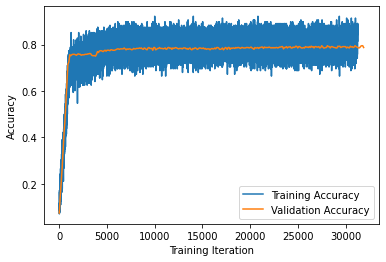

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()